In [55]:
import pandas as pd
import math

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import ElasticNetCV, RidgeCV, LinearRegression
from sklearn.neural_network import MLPRegressor
import threading
from sklearn import preprocessing

from collections import OrderedDict, defaultdict
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, Imputer
import gc
import lightgbm as lgb
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import numpy as np

from skopt import gp_minimize
from hyperopt import *

from tqdm import tqdm

from pathlib import PurePath

import matplotlib.pyplot as plt

import xgboost as xgb
import pickle

In [3]:
# Métrica de evaluación
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

def RMSE(actual, pred):
    return (np.mean((actual - pred) ** 2)) **.5

In [4]:
def generate_text_features(df, text_features):
    for col in text_features:
        df[col].fillna('', inplace=True)
        #df[col] = df[col].str.lower()
        #df[col] = df[col].str.replace("[^[:alpha:]]", " ")
        #df[col] = df[col].str.replace("\\s+", "")
        df[col + '_num_chars'] = df[col].apply(len)
        df[col + '_num_words'] = df[col].apply(lambda comment: len(comment.split()))
        #df[col + '_num_unique_words'] = df[col].apply(lambda comment: len(set(w for w in comment.split())))
        #df[col + '_words_vs_unique'] = df[col+'_num_unique_words'] / df[col+'_num_words'] * 100


In [5]:
def objective_lgb(space):
   
    num_leaves = int(space['num_leaves'])
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    subsample_freq = int(space['subsample_freq'])
    lambda_l1 = space['lambda_l1']
    lambda_l2 = space['lambda_l2']
    learning_rate = space['learning_rate']
    feature_fraction = space['feature_fraction']
    min_data_per_leaf = int(space['min_data_per_leaf'])
    min_child_weight = space['min_child_weight']
    #min_sum_hessian_in_leaf = space['min_sum_hessian_in_leaf']
    min_gain_to_split = space['min_gain_to_split']
    
    print("params: ")
    print("num_leaves: " + str(num_leaves))
    print("max_depth: " + str(max_depth))
    print("min_child_weight: " + str(min_child_weight))
    print("subsample: " + str(subsample))
    print("subsample_freq: " + str(subsample_freq))
    print("lambda_l1: " + str(lambda_l1))
    print("lambda_l2: " + str(lambda_l2))
    print("feature_fraction: " + str(feature_fraction))
    print("learning rate: " + str(learning_rate))
    print("min_data_per_leaf: " + str(min_data_per_leaf))        
    #print("min_sum_hessian_in_leaf: " + str(min_sum_hessian_in_leaf))        
    print("min_gain_to_split: " + str(min_gain_to_split))        

    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators": 20000,
        "max_depth": max_depth,
        "num_leaves" : num_leaves, 
        "learning_rate" : learning_rate,
        "subsample" : subsample,
        "subsample_freq" : subsample_freq,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "feature_fraction" : feature_fraction,
        "min_data_per_leaf": min_data_per_leaf,
        "min_child_weight": min_child_weight,
        #"min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
        "min_gain_to_split": min_gain_to_split,
        "bagging_seed" : 16,
        "device" : "gpu",
        "max_bin": 64
    }
    
#     train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
#     val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)
    train = lgb.Dataset(X[:192000], label=y_valid_meta[:192000], categorical_feature=cat_features)
    val = lgb.Dataset(X[192000:], label=y_valid_meta[192000:], categorical_feature=cat_features)
 
    model = lgb.train(params, train, valid_sets=[train, val], early_stopping_rounds=300, verbose_eval=10)
    
    #val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)
    val = lgb.Dataset(X[192000:], label=y_valid_meta[192000:], categorical_feature=cat_features)

    y_pred = model.predict(val.data, num_iteration=model.best_iteration)
      
    #return {'loss': RMSE(y_val, y_pred), 'status': STATUS_OK }
    return {'loss': RMSE(y_valid_meta[192000:], y_pred), 'status': STATUS_OK }

In [6]:
def objective_xgb(space):
    params = {}
    params["tree_method"] = "gpu_hist"
    params['predictor'] = "gpu_predictor"
    params['objective'] = "gpu:reg:linear"
    params['eval_metric'] = "rmse"
    params['subsample'] = space['subsample']
    params['colsample_bytree'] = space['colsample_bytree']
    params['colsample_bylevel'] = space['colsample_bylevel']
    params['max_depth'] = int(space['max_depth'])
    params['reg_alpha'] = space['reg_alpha']
    params['reg_lambda'] = space['reg_lambda']
    params['min_child_weight'] = space['min_child_weight']
    params['learning_rate'] = space['learning_rate']
    #params['scale_pos_weight'] = space['scale_pos_weight']
    params['gamma'] = space['gamma']
    params['max_delta_step'] = space['max_delta_step']
    params['max_bin'] = 64
    
    print("params: ")
    print("max_depth: " + str(params['max_depth']))
    print("min_child_weight: " + str(params['min_child_weight']))
    print("subsample: " + str(params['subsample']))
    print("reg_alpha: " + str(params['reg_alpha']))
    print("reg_lambda: " + str(params['reg_lambda']))
    print("colsample_bylevel: " + str(params['colsample_bylevel']))
    print("colsample_bytree: " + str(params['colsample_bytree']))
    print("gamma: " + str(params['gamma']))
    #print("scale_pos_weight: " + str(params['scale_pos_weight']))
    print("learning_rate: " + str(params['learning_rate']))
    print("max_delta_step: " + str(params['max_delta_step']))
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    m = xgb.train(params, dtrain, evals=[(dtrain, "train"), (dval, "validation")], num_boost_round=10000,
              early_stopping_rounds=200, verbose_eval=2)
    
    y_pred = m.predict(dval)
    loss = RMSE(dval.get_label(), y_pred)
    
    m.__del__()
    dtrain.__del__()
    dval.__del__()
    
    del m
    del dtrain
    del dval
    gc.collect()
    
    return {'loss': loss, 'status': STATUS_OK }

In [7]:
def add_to_df(df, base_field, new_field, dic):
    mean = np.mean(list(dic.values()))
    new_col = np.zeros((len(df),1))
    field = new_field
        
    i = 0
    
    for _, row in df.iterrows():

        if row[base_field] in dic:
            new_col[i] = dic[row[base_field]]
        else:
            new_col[i] = mean
        
        i = i + 1    
        
    df[new_field] = new_col

In [8]:
def group_target_by_fields(df, target, fields = None):
    if fields is None:
        fields = df.columns
    
    target_mean = df[target].mean()
    target_std = df[target].std()
    
    d = {}
    
    for f in fields:
        gp = df.groupby(f)[target]
        mean = gp.mean()
        std  = gp.std()
        
        if pd.DataFrame(mean).isnull().values.any():
            mean = mean.fillna(target_mean)
            
        if pd.DataFrame(std).isnull().values.any():
            std = std.fillna(target_std)
            
        df[f + '_' + target + '_avg'] = df[f].map(mean)
        df[f + '_' + target + '_std'] = df[f].map(std)
        
        d[f + '_avg'] = mean
        d[f + '_std'] = std
        
    return d

In [9]:
def apply_group_by_dict(df, d, fields_to_group_by, target):
    for f in fields_to_group_by:
        mean = d[f + '_avg']
        std = d[f + '_std']

        df[f + '_' + target + '_avg'] = df[f].map(mean)
        df[f + '_' + target + '_std'] = df[f].map(std)

In [10]:
df = pd.read_csv('train.csv', index_col='id', parse_dates=['fecha'])

In [11]:
df_test = pd.read_csv('test.csv', parse_dates=['fecha'])

In [12]:
text_features = ["titulo", "descripcion", "direccion"]

for col in text_features:
    df[col].fillna('', inplace=True)
    df[col] = df[col].str.lower()
    df_test[col].fillna('', inplace=True)
    df_test[col] = df_test[col].str.lower()

In [13]:
df['año'] = df.fecha.dt.year
df['mes'] = df.fecha.dt.month

df_test['año'] = df_test.fecha.dt.year
df_test['mes'] = df_test.fecha.dt.month

In [14]:
df.drop(['fecha'], axis=1, inplace=True)
df_test.drop(['fecha'], axis=1, inplace=True)

In [15]:
df['metrosdescubiertos'] = df['metrostotales'] - df['metroscubiertos']
df_test['metrosdescubiertos'] = df_test['metrostotales'] - df_test['metroscubiertos']

In [16]:
df['ciudad'] = df['ciudad'].str.lower()
df['provincia'] = df['provincia'].str.lower()

df_test['ciudad'] = df_test['ciudad'].str.lower()
df_test['provincia'] = df_test['provincia'].str.lower()

In [17]:
le = LabelEncoder()
df_all = pd.concat([df, df_test], axis=0)
# # Iterate through the columns
for col in df_all:
    if col == 'titulo' or col == 'descripcion' or col == 'direccion':
        continue
        
    if df_all[col].dtype == 'object':
        le.fit(df_all[col].astype(str))
        # Transform both training and testing data
        df[col] = le.transform(df[col].astype(str))
        df_test[col] = le.transform(df_test[col].astype(str))

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [18]:
X = df.drop(['precio'], axis=1)
y = np.log(df['precio'])

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
fields_to_group_by = ['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'ciudad', 'antiguedad', 'año', 'mes',
                      'tipodepropiedad', 'idzona']
d = group_target_by_fields(pd.concat([X_train, y_train], axis=1), 'precio', fields_to_group_by)

In [21]:
apply_group_by_dict(X_train, d, fields_to_group_by, target='precio')
apply_group_by_dict(X_val, d, fields_to_group_by, target='precio')
apply_group_by_dict(df_test, d, fields_to_group_by, target='precio')

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [22]:
generate_text_features(X_train, text_features)
generate_text_features(X_val, text_features)
generate_text_features(df_test, text_features)

/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

In [144]:
#np.unique(df['idzona'].value_counts().values, return_counts=True)

In [23]:
num_text_features = 20000

tfidf_title = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                              ngram_range=(1,1), min_df=3, max_df=0.4, norm='l2', sublinear_tf=False)
tfidf_title.fit(X_train['titulo'])


tfidf_descr = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                               ngram_range=(1,3), min_df=10, max_df=0.5, norm='l2', sublinear_tf=False)
tfidf_descr.fit(X_train['descripcion'])

tfidf_dir = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                               ngram_range=(1,3), min_df=10, max_df=0.5, norm='l2', sublinear_tf=False)
tfidf_dir.fit(X_train['direccion'])


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=20000, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde'...tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
# titulo_train = tfidf_title.transform(X_train['titulo'])
# descr_train = tfidf_descr.transform(X_train['descripcion'])
# direccion_train = tfidf_dir.transform(X_train['direccion'])

In [25]:
# titulo_val = tfidf_title.transform(X_val['titulo'])
# descr_val = tfidf_descr.transform(X_val['descripcion'])
# direccion_val = tfidf_dir.transform(X_val['direccion'])

In [26]:
# X_train.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)
# X_val.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)

In [27]:
# tfvocab = tfidf_title.get_feature_names() + tfidf_descr.get_feature_names() + tfidf_dir.get_feature_names()
# tfvocab = X_train.columns.tolist() + tfvocab

In [28]:
# X_train = hstack([csr_matrix(X_train.values), titulo_train, descr_train, direccion_train])
# X_val = hstack([csr_matrix(X_val.values), titulo_val, descr_val, direccion_val])

In [29]:
svd_features = 50

svd_title = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_title.fit(tfidf_title.transform(X_train['titulo']))

TruncatedSVD(algorithm='arpack', n_components=50, n_iter=5, random_state=None,
       tol=0.0)

In [30]:
svd_descr = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_descr.fit(tfidf_descr.transform(X_train['descripcion']))

TruncatedSVD(algorithm='arpack', n_components=50, n_iter=5, random_state=None,
       tol=0.0)

In [31]:
svd_dir = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_dir.fit(tfidf_dir.transform(X_train['direccion']))

TruncatedSVD(algorithm='arpack', n_components=50, n_iter=5, random_state=None,
       tol=0.0)

In [32]:
svd_title.explained_variance_ratio_.sum()

0.208078618990192

In [33]:
svd_descr.explained_variance_ratio_.sum()

0.10727963787996173

In [34]:
svd_dir.explained_variance_ratio_.sum()

0.14119854767040363

In [35]:
title_features_train = np.array(svd_title.transform(tfidf_title.transform(X_train['titulo'])), dtype=np.float16)
title_features_val = np.array(svd_title.transform(tfidf_title.transform(X_val['titulo'])), dtype=np.float16)
title_features_test = np.array(svd_title.transform(tfidf_title.transform(df_test['titulo'])), dtype=np.float16)

for i in range(svd_features):
    X_train['title_feature_' + str(i)] = title_features_train[:, i]
    X_val['title_feature_' + str(i)] = title_features_val[:, i]
    df_test['title_feature_' + str(i)] = title_features_test[:, i]

del title_features_train; del title_features_val
gc.collect()

description_features_train = np.array(svd_descr.transform(tfidf_descr.transform(X_train['descripcion'])), dtype=np.float16)
description_features_val = np.array(svd_descr.transform(tfidf_descr.transform(X_val['descripcion'])), dtype=np.float16)
description_features_test = np.array(svd_descr.transform(tfidf_descr.transform(df_test['descripcion'])), dtype=np.float16)

for i in range(svd_features):
    X_train['description_feature_' + str(i)] = description_features_train[:, i]
    X_val['description_feature_' + str(i)] = description_features_val[:, i]
    df_test['description_feature_' + str(i)] = description_features_test[:, i]

del description_features_train; del description_features_val
gc.collect()

dir_features_train = np.array(svd_dir.transform(tfidf_dir.transform(X_train['direccion'])), dtype=np.float16)
dir_features_val = np.array(svd_dir.transform(tfidf_dir.transform(X_val['direccion'])), dtype=np.float16)
dir_features_test = np.array(svd_dir.transform(tfidf_dir.transform(df_test['direccion'])), dtype=np.float16)

for i in range(svd_features):
    X_train['dir_feature_' + str(i)] = dir_features_train[:, i]
    X_val['dir_feature_' + str(i)] = dir_features_val[:, i]
    df_test['dir_feature_' + str(i)] = dir_features_test[:, i]

del dir_features_train; del dir_features_val
gc.collect()

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

7

In [36]:
X_train.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)
X_val.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)

/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [37]:
df_test.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)

In [46]:
# X_train.to_csv('X_train')
# X_val.to_csv('X_val')
# df_test.to_csv('df_test')

# y_train.to_csv('y_train')
# y_val.to_csv('y_val')

In [68]:
# X_train = pd.read_csv('X_train', index_col='id') 
# X_val = pd.read_csv('X_val', index_col='id') 
# df_test = pd.read_csv('df_test').drop(['Unnamed: 0'], axis=1)

# y_train = pd.read_csv('y_train', header=None, index_col=0).values.flatten()
# y_val = pd.read_csv('y_val', header=None, index_col=0).values.flatten()

In [38]:
# cat_features = ['tipodepropiedad', 'ciudad', 'provincia', 'antiguedad',
#        'habitaciones', 'garages', 'banos',
#        'gimnasio', 'usosmultiples', 'piscina',
#        'escuelascercanas', 'centroscomercialescercanos'] 

cat_features = ['tipodepropiedad', 'ciudad', 'provincia']

#idzona queda afuera por espacio

In [39]:
#print(best)

In [43]:
params = {}

params["objective"] = "regression"
params["metric"] = "rmse"
params["n_estimators"] = 20000
params["max_depth"] = 12
params["min_data_per_leaf"] = 356
params["min_child_weight"] = 59.63861149380767
params["num_leaves"] = 174
params["learning_rate"] = 0.025#0.08035122695394581
params["subsample"] = 0.9483241853322317
params["subsample_freq"] = 9
params["lambda_l1"] = 5.844957597750421
params["lambda_l2"] = 20.530656510989612
params["feature_fraction"] = 0.35657869679717286
params["feature_fraction_seed"] = 1
params["bagging_seed"] = 16
params["device"] = "gpu"
params["max_bin"] = 64



In [44]:
train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)#, feature_name=tfvocab)
val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)#, feature_name=tfvocab)

In [45]:
model = lgb.train(params, train, valid_sets=[train, val], early_stopping_rounds=200, verbose_eval=10)

/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1090: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[10]	training's rmse: 0.721043	valid_1's rmse: 0.72024
[20]	training's rmse: 0.628135	valid_1's rmse: 0.62951
[30]	training's rmse: 0.551409	valid_1's rmse: 0.555062
[40]	training's rmse: 0.490417	valid_1's rmse: 0.49709
[50]	training's rmse: 0.441396	valid_1's rmse: 0.451037
[60]	training's rmse: 0.405302	valid_1's rmse: 0.417382
[70]	training's rmse: 0.377843	valid_1's rmse: 0.391877
[80]	training's rmse: 0.352914	valid_1's rmse: 0.36986
[90]	training's rmse: 0.333752	valid_1's rmse: 0.35341
[100]	training's rmse: 0.318749	valid_1's rmse: 0.34119
[110]	training's rmse: 0.308096	valid_1's rmse: 0.332054
[120]	training's rmse: 0.299449	valid_1's rmse: 0.324718
[130]	training's rmse: 0.291574	valid_1's rmse: 0.318723
[140]	training's rmse: 0.285073	valid_1's rmse: 0.313653
[150]	training's rmse: 0.278947	valid_1's rmse: 0.309277
[160]	training's rmse: 0.273657	valid_1's rmse: 0.306099
[170]	training's rmse: 0.269336	valid_1'

[1440]	training's rmse: 0.149041	valid_1's rmse: 0.272844
[1450]	training's rmse: 0.148656	valid_1's rmse: 0.272822
[1460]	training's rmse: 0.148263	valid_1's rmse: 0.272792
[1470]	training's rmse: 0.14788	valid_1's rmse: 0.272755
[1480]	training's rmse: 0.147487	valid_1's rmse: 0.272727
[1490]	training's rmse: 0.147109	valid_1's rmse: 0.27271
[1500]	training's rmse: 0.146748	valid_1's rmse: 0.272669
[1510]	training's rmse: 0.146408	valid_1's rmse: 0.272635
[1520]	training's rmse: 0.146064	valid_1's rmse: 0.272615
[1530]	training's rmse: 0.145734	valid_1's rmse: 0.272583
[1540]	training's rmse: 0.145407	valid_1's rmse: 0.27256
[1550]	training's rmse: 0.145069	valid_1's rmse: 0.272531
[1560]	training's rmse: 0.144739	valid_1's rmse: 0.272506
[1570]	training's rmse: 0.144413	valid_1's rmse: 0.27248
[1580]	training's rmse: 0.144113	valid_1's rmse: 0.272463
[1590]	training's rmse: 0.143784	valid_1's rmse: 0.272432
[1600]	training's rmse: 0.143489	valid_1's rmse: 0.272412
[1610]	training's 

[2860]	training's rmse: 0.127725	valid_1's rmse: 0.271087
[2870]	training's rmse: 0.127697	valid_1's rmse: 0.271084
[2880]	training's rmse: 0.127669	valid_1's rmse: 0.27108
[2890]	training's rmse: 0.127645	valid_1's rmse: 0.271081
[2900]	training's rmse: 0.12762	valid_1's rmse: 0.27108
[2910]	training's rmse: 0.127591	valid_1's rmse: 0.271078
[2920]	training's rmse: 0.127564	valid_1's rmse: 0.271076
[2930]	training's rmse: 0.127528	valid_1's rmse: 0.271073
[2940]	training's rmse: 0.127489	valid_1's rmse: 0.271066
[2950]	training's rmse: 0.127454	valid_1's rmse: 0.271064
[2960]	training's rmse: 0.127417	valid_1's rmse: 0.27106
[2970]	training's rmse: 0.127388	valid_1's rmse: 0.271056
[2980]	training's rmse: 0.127353	valid_1's rmse: 0.271055
[2990]	training's rmse: 0.127314	valid_1's rmse: 0.271054
[3000]	training's rmse: 0.127285	valid_1's rmse: 0.27105
[3010]	training's rmse: 0.127258	valid_1's rmse: 0.271046
[3020]	training's rmse: 0.12723	valid_1's rmse: 0.271044
[3030]	training's rm

[4280]	training's rmse: 0.125076	valid_1's rmse: 0.270802
[4290]	training's rmse: 0.125067	valid_1's rmse: 0.270802
[4300]	training's rmse: 0.125054	valid_1's rmse: 0.2708
[4310]	training's rmse: 0.125046	valid_1's rmse: 0.270799
[4320]	training's rmse: 0.125043	valid_1's rmse: 0.270798
[4330]	training's rmse: 0.125034	valid_1's rmse: 0.270797
[4340]	training's rmse: 0.125028	valid_1's rmse: 0.270796
[4350]	training's rmse: 0.125021	valid_1's rmse: 0.270794
[4360]	training's rmse: 0.125016	valid_1's rmse: 0.270794
[4370]	training's rmse: 0.125001	valid_1's rmse: 0.270794
[4380]	training's rmse: 0.124998	valid_1's rmse: 0.270794
[4390]	training's rmse: 0.124986	valid_1's rmse: 0.270794
[4400]	training's rmse: 0.124976	valid_1's rmse: 0.270793
[4410]	training's rmse: 0.124974	valid_1's rmse: 0.270794
[4420]	training's rmse: 0.12497	valid_1's rmse: 0.270792
[4430]	training's rmse: 0.124963	valid_1's rmse: 0.270792
[4440]	training's rmse: 0.12495	valid_1's rmse: 0.27079
[4450]	training's r

[5700]	training's rmse: 0.124109	valid_1's rmse: 0.27069
[5710]	training's rmse: 0.124097	valid_1's rmse: 0.270687
[5720]	training's rmse: 0.124095	valid_1's rmse: 0.270687
[5730]	training's rmse: 0.124092	valid_1's rmse: 0.270688
[5740]	training's rmse: 0.124086	valid_1's rmse: 0.270687
[5750]	training's rmse: 0.12408	valid_1's rmse: 0.270686
[5760]	training's rmse: 0.124072	valid_1's rmse: 0.270687
[5770]	training's rmse: 0.124069	valid_1's rmse: 0.270686
[5780]	training's rmse: 0.124064	valid_1's rmse: 0.270685
[5790]	training's rmse: 0.12406	valid_1's rmse: 0.270684
[5800]	training's rmse: 0.124058	valid_1's rmse: 0.270684
[5810]	training's rmse: 0.124056	valid_1's rmse: 0.270684
[5820]	training's rmse: 0.124048	valid_1's rmse: 0.270683
[5830]	training's rmse: 0.124042	valid_1's rmse: 0.270684
[5840]	training's rmse: 0.124038	valid_1's rmse: 0.270683
[5850]	training's rmse: 0.124034	valid_1's rmse: 0.270684
[5860]	training's rmse: 0.124029	valid_1's rmse: 0.270682
[5870]	training's

[7120]	training's rmse: 0.123452	valid_1's rmse: 0.270613
[7130]	training's rmse: 0.12345	valid_1's rmse: 0.270613
[7140]	training's rmse: 0.123448	valid_1's rmse: 0.270612
[7150]	training's rmse: 0.123443	valid_1's rmse: 0.270612
[7160]	training's rmse: 0.123437	valid_1's rmse: 0.270611
[7170]	training's rmse: 0.123435	valid_1's rmse: 0.270612
[7180]	training's rmse: 0.123431	valid_1's rmse: 0.270611
[7190]	training's rmse: 0.123421	valid_1's rmse: 0.270612
[7200]	training's rmse: 0.123421	valid_1's rmse: 0.270611
[7210]	training's rmse: 0.123419	valid_1's rmse: 0.270611
[7220]	training's rmse: 0.123415	valid_1's rmse: 0.27061
[7230]	training's rmse: 0.123409	valid_1's rmse: 0.270609
[7240]	training's rmse: 0.123403	valid_1's rmse: 0.270609
[7250]	training's rmse: 0.123399	valid_1's rmse: 0.270608
[7260]	training's rmse: 0.123391	valid_1's rmse: 0.270607
[7270]	training's rmse: 0.12339	valid_1's rmse: 0.270607
[7280]	training's rmse: 0.123388	valid_1's rmse: 0.270607
[7290]	training's

KeyboardInterrupt: 

In [ ]:
# [3655]	training's rmse: 0.174274	valid_1's rmse: 0.285031 (0.2869 lb - 0.2820 ensemble)

# [3990]	training's rmse: 0.0714169	valid_1's rmse: 0.278861 (0.2811 lb - 0.2708 ensemble)

# [3843]	training's rmse: 0.0680983	valid_1's rmse: 0.274904 (          - 0.2612 ensemble)

# [2907]	training's rmse: 0.0829138	valid_1's rmse: 0.274188 (          - 0.2608 ensemble)

# [4042]	training's rmse: 0.0637629	valid_1's rmse: 0.272434 (          - 0.2600 ensemble)


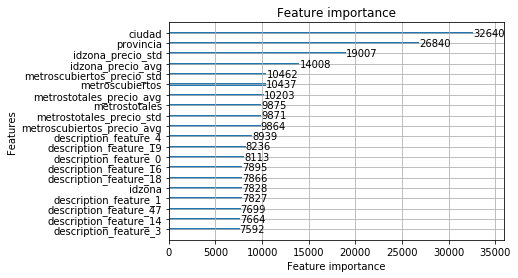

In [174]:
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

In [36]:
space = {
        'max_depth': hp.uniform("max_depth", 3, 20),
        'min_child_weight': hp.uniform('min_child', 0, 300),
        'min_data_per_leaf': hp.uniform('min_data_per_leaf', 20, 2000),
        'num_leaves': hp.uniform('num_leaves', 20, 2000),
        'subsample': hp.uniform('subsample', 0.6, 0.95),
        'subsample_freq': hp.uniform('subsample_freq', 1, 20),
        'lambda_l1': hp.uniform('lambda_l1', 0, 40),
        'lambda_l2': hp.uniform('lambda_l2', 0, 40),
        'feature_fraction': hp.uniform('feature_fraction', 0.1, 0.6),
        'learning_rate': hp.uniform('learning_rate', 0.02, 0.1),
        'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 0.2)
    }

In [37]:
trials = Trials()
best = fmin(fn=objective_lgb,
            space=space,
            algo=tpe.suggest,
            max_evals=80,
            trials=trials)

params: 
num_leaves: 87
max_depth: 6
min_child_weight: 281.51372538019615
subsample: 0.9321968514151913
subsample_freq: 6
lambda_l1: 14.739496598597333
lambda_l2: 17.23918286721269
feature_fraction: 0.18029555332046107
learning rate: 0.06822281969355273
min_data_per_leaf: 175


NameError: name 'min_gain_to_split' is not defined

In [32]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dval = xgb.DMatrix(X_val, label=y_val)

In [33]:
space = {
        'max_depth': hp.uniform("x_max_depth", 5, 12),
        'min_child_weight': hp.uniform('x_min_child', 1, 200),
        'max_delta_step': hp.uniform('max_delta_step', 0, 1),
        'subsample': hp.uniform('x_subsample', 0.6, 0.7),
        'reg_alpha': hp.uniform('x_reg_alpha', 0, 40),
        'reg_lambda': hp.uniform('x_reg_lambda', 0, 40),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel', 0.1, 0.5),
        'colsample_bytree': hp.uniform('x_colsample_bytree', 0.1, 0.5),
        'gamma': hp.uniform('x_gamma', 0, 10),
        #'scale_pos_weight': hp.uniform('x_scale_pos_weight', 0, 20),
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.8)
    }

In [34]:
trials = Trials()
best = fmin(fn=objective_xgb,
            space=space,
            algo=tpe.suggest,
            max_evals=60,
            trials=trials)

params: 
max_depth: 5
min_child_weight: 24.877057463102634
subsample: 0.6724091850761857
reg_alpha: 34.941217215539254
reg_lambda: 11.092673191877886
colsample_bylevel: 0.4397248453079333
colsample_bytree: 0.16603443738701698
gamma: 7.385365986972687
learning_rate: 0.590029903662327
max_delta_step: 0.865470527843216
[0]	train-rmse:13.4281	validation-rmse:13.4175
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:12.409	validation-rmse:12.3984
[4]	train-rmse:11.3902	validation-rmse:11.3796
[6]	train-rmse:10.3719	validation-rmse:10.3613
[8]	train-rmse:9.35432	validation-rmse:9.34368
[10]	train-rmse:8.33763	validation-rmse:8.32696
[12]	train-rmse:7.32221	validation-rmse:7.31152
[14]	train-rmse:6.3087	validation-rmse:6.29797
[16]	train-rmse:5.29819	validation-rmse:5.28742
[18]	train-rmse:4.29279	validation-rmse:4.28196
[20]	train-rmse:3.29719	validation-rmse:3.2863
[22]	t

[308]	train-rmse:0.280565	validation-rmse:0.316759
[310]	train-rmse:0.280411	validation-rmse:0.316719
[312]	train-rmse:0.280288	validation-rmse:0.316695
[314]	train-rmse:0.28014	validation-rmse:0.316654
[316]	train-rmse:0.280054	validation-rmse:0.316632
[318]	train-rmse:0.279846	validation-rmse:0.316562
[320]	train-rmse:0.279663	validation-rmse:0.316482
[322]	train-rmse:0.279559	validation-rmse:0.31645
[324]	train-rmse:0.279399	validation-rmse:0.316357
[326]	train-rmse:0.279277	validation-rmse:0.316276
[328]	train-rmse:0.279134	validation-rmse:0.316253
[330]	train-rmse:0.278951	validation-rmse:0.316074
[332]	train-rmse:0.278713	validation-rmse:0.316057
[334]	train-rmse:0.278633	validation-rmse:0.316038
[336]	train-rmse:0.27853	validation-rmse:0.316001
[338]	train-rmse:0.27845	validation-rmse:0.316014
[340]	train-rmse:0.278359	validation-rmse:0.315969
[342]	train-rmse:0.278261	validation-rmse:0.315955
[344]	train-rmse:0.278182	validation-rmse:0.31591
[346]	train-rmse:0.278105	validation

[632]	train-rmse:0.263199	validation-rmse:0.311015
[634]	train-rmse:0.26314	validation-rmse:0.310975
[636]	train-rmse:0.263015	validation-rmse:0.310899
[638]	train-rmse:0.262911	validation-rmse:0.310923
[640]	train-rmse:0.262854	validation-rmse:0.310883
[642]	train-rmse:0.262804	validation-rmse:0.310877
[644]	train-rmse:0.262725	validation-rmse:0.310859
[646]	train-rmse:0.262641	validation-rmse:0.310885
[648]	train-rmse:0.262594	validation-rmse:0.310867
[650]	train-rmse:0.262522	validation-rmse:0.310886
[652]	train-rmse:0.262431	validation-rmse:0.310864
[654]	train-rmse:0.262373	validation-rmse:0.310873
[656]	train-rmse:0.262314	validation-rmse:0.310847
[658]	train-rmse:0.262257	validation-rmse:0.310846
[660]	train-rmse:0.262186	validation-rmse:0.310869
[662]	train-rmse:0.262099	validation-rmse:0.310857
[664]	train-rmse:0.261902	validation-rmse:0.310711
[666]	train-rmse:0.261858	validation-rmse:0.310716
[668]	train-rmse:0.261817	validation-rmse:0.310689
[670]	train-rmse:0.261744	valida

[956]	train-rmse:0.252768	validation-rmse:0.308706
[958]	train-rmse:0.252648	validation-rmse:0.308658
[960]	train-rmse:0.252599	validation-rmse:0.308605
[962]	train-rmse:0.25255	validation-rmse:0.308613
[964]	train-rmse:0.252489	validation-rmse:0.308538
[966]	train-rmse:0.252441	validation-rmse:0.308556
[968]	train-rmse:0.252398	validation-rmse:0.308551
[970]	train-rmse:0.252337	validation-rmse:0.308559
[972]	train-rmse:0.252272	validation-rmse:0.308574
[974]	train-rmse:0.252226	validation-rmse:0.308589
[976]	train-rmse:0.252169	validation-rmse:0.308571
[978]	train-rmse:0.252128	validation-rmse:0.308557
[980]	train-rmse:0.252075	validation-rmse:0.308567
[982]	train-rmse:0.251982	validation-rmse:0.308533
[984]	train-rmse:0.251933	validation-rmse:0.308536
[986]	train-rmse:0.251888	validation-rmse:0.308495
[988]	train-rmse:0.251854	validation-rmse:0.308472
[990]	train-rmse:0.25179	validation-rmse:0.308455
[992]	train-rmse:0.251738	validation-rmse:0.308483
[994]	train-rmse:0.251641	validat

[1274]	train-rmse:0.244842	validation-rmse:0.307548
[1276]	train-rmse:0.244789	validation-rmse:0.307512
[1278]	train-rmse:0.244749	validation-rmse:0.307519
[1280]	train-rmse:0.244705	validation-rmse:0.307477
[1282]	train-rmse:0.244668	validation-rmse:0.307487
[1284]	train-rmse:0.244635	validation-rmse:0.307498
[1286]	train-rmse:0.244601	validation-rmse:0.307514
[1288]	train-rmse:0.244553	validation-rmse:0.307513
[1290]	train-rmse:0.244491	validation-rmse:0.307536
[1292]	train-rmse:0.244466	validation-rmse:0.307523
[1294]	train-rmse:0.244417	validation-rmse:0.307463
[1296]	train-rmse:0.244376	validation-rmse:0.307486
[1298]	train-rmse:0.244314	validation-rmse:0.307464
[1300]	train-rmse:0.244267	validation-rmse:0.30747
[1302]	train-rmse:0.244225	validation-rmse:0.307483
[1304]	train-rmse:0.244188	validation-rmse:0.307469
[1306]	train-rmse:0.24414	validation-rmse:0.307452
[1308]	train-rmse:0.244079	validation-rmse:0.307431
[1310]	train-rmse:0.24404	validation-rmse:0.307434
[1312]	train-rm

[1592]	train-rmse:0.238526	validation-rmse:0.306754
[1594]	train-rmse:0.238482	validation-rmse:0.30678
[1596]	train-rmse:0.238449	validation-rmse:0.306767
[1598]	train-rmse:0.238392	validation-rmse:0.306738
[1600]	train-rmse:0.238353	validation-rmse:0.306731
[1602]	train-rmse:0.238311	validation-rmse:0.306716
[1604]	train-rmse:0.238272	validation-rmse:0.306719
[1606]	train-rmse:0.238238	validation-rmse:0.306692
[1608]	train-rmse:0.238209	validation-rmse:0.306702
[1610]	train-rmse:0.238159	validation-rmse:0.30671
[1612]	train-rmse:0.23811	validation-rmse:0.306691
[1614]	train-rmse:0.238079	validation-rmse:0.306679
[1616]	train-rmse:0.238038	validation-rmse:0.306664
[1618]	train-rmse:0.238006	validation-rmse:0.306657
[1620]	train-rmse:0.237958	validation-rmse:0.306656
[1622]	train-rmse:0.237922	validation-rmse:0.306647
[1624]	train-rmse:0.23788	validation-rmse:0.30663
[1626]	train-rmse:0.237853	validation-rmse:0.306607
[1628]	train-rmse:0.237812	validation-rmse:0.306612
[1630]	train-rmse

[50]	train-rmse:0.338884	validation-rmse:0.353813
[52]	train-rmse:0.334498	validation-rmse:0.350489
[54]	train-rmse:0.330591	validation-rmse:0.347239
[56]	train-rmse:0.328007	validation-rmse:0.345116
[58]	train-rmse:0.320867	validation-rmse:0.34144
[60]	train-rmse:0.317713	validation-rmse:0.339066
[62]	train-rmse:0.31579	validation-rmse:0.337586
[64]	train-rmse:0.314086	validation-rmse:0.336427
[66]	train-rmse:0.311408	validation-rmse:0.334798
[68]	train-rmse:0.308822	validation-rmse:0.333556
[70]	train-rmse:0.305914	validation-rmse:0.332543
[72]	train-rmse:0.303323	validation-rmse:0.331836
[74]	train-rmse:0.302245	validation-rmse:0.331307
[76]	train-rmse:0.301121	validation-rmse:0.330785
[78]	train-rmse:0.299068	validation-rmse:0.329572
[80]	train-rmse:0.297691	validation-rmse:0.329018
[82]	train-rmse:0.296436	validation-rmse:0.328537
[84]	train-rmse:0.295275	validation-rmse:0.327644
[86]	train-rmse:0.294357	validation-rmse:0.327029
[88]	train-rmse:0.29332	validation-rmse:0.326582
[90

[374]	train-rmse:0.235572	validation-rmse:0.317586
[376]	train-rmse:0.23531	validation-rmse:0.317547
[378]	train-rmse:0.234994	validation-rmse:0.317551
[380]	train-rmse:0.234776	validation-rmse:0.317573
[382]	train-rmse:0.234573	validation-rmse:0.317526
[384]	train-rmse:0.234335	validation-rmse:0.317523
[386]	train-rmse:0.23413	validation-rmse:0.317463
[388]	train-rmse:0.233852	validation-rmse:0.317408
[390]	train-rmse:0.233631	validation-rmse:0.317443
[392]	train-rmse:0.233328	validation-rmse:0.317459
[394]	train-rmse:0.233032	validation-rmse:0.317452
[396]	train-rmse:0.232857	validation-rmse:0.317479
[398]	train-rmse:0.232645	validation-rmse:0.317472
[400]	train-rmse:0.232412	validation-rmse:0.317348
[402]	train-rmse:0.232146	validation-rmse:0.317293
[404]	train-rmse:0.231887	validation-rmse:0.317314
[406]	train-rmse:0.231639	validation-rmse:0.317335
[408]	train-rmse:0.231388	validation-rmse:0.317348
[410]	train-rmse:0.231135	validation-rmse:0.317344
[412]	train-rmse:0.230871	validat

[698]	train-rmse:0.202303	validation-rmse:0.317483
[700]	train-rmse:0.202173	validation-rmse:0.317528
[702]	train-rmse:0.202049	validation-rmse:0.317488
[704]	train-rmse:0.201886	validation-rmse:0.31748
[706]	train-rmse:0.201741	validation-rmse:0.317488
[708]	train-rmse:0.201616	validation-rmse:0.317509
[710]	train-rmse:0.201464	validation-rmse:0.317489
[712]	train-rmse:0.20131	validation-rmse:0.317424
[714]	train-rmse:0.201142	validation-rmse:0.317425
[716]	train-rmse:0.200998	validation-rmse:0.317435
[718]	train-rmse:0.200809	validation-rmse:0.317408
[720]	train-rmse:0.200638	validation-rmse:0.317411
[722]	train-rmse:0.200474	validation-rmse:0.317422
[724]	train-rmse:0.200348	validation-rmse:0.317412
[726]	train-rmse:0.20018	validation-rmse:0.31737
[728]	train-rmse:0.200042	validation-rmse:0.317332
[730]	train-rmse:0.199868	validation-rmse:0.317266
[732]	train-rmse:0.199729	validation-rmse:0.317279
[734]	train-rmse:0.199598	validation-rmse:0.317302
[736]	train-rmse:0.199447	validatio

[162]	train-rmse:0.279211	validation-rmse:0.329862
[164]	train-rmse:0.278726	validation-rmse:0.329582
[166]	train-rmse:0.2783	validation-rmse:0.32948
[168]	train-rmse:0.277998	validation-rmse:0.329476
[170]	train-rmse:0.277549	validation-rmse:0.329275
[172]	train-rmse:0.277149	validation-rmse:0.329073
[174]	train-rmse:0.276808	validation-rmse:0.329003
[176]	train-rmse:0.276556	validation-rmse:0.328877
[178]	train-rmse:0.2762	validation-rmse:0.328793
[180]	train-rmse:0.275824	validation-rmse:0.328664
[182]	train-rmse:0.2754	validation-rmse:0.3287
[184]	train-rmse:0.274945	validation-rmse:0.328454
[186]	train-rmse:0.274595	validation-rmse:0.32843
[188]	train-rmse:0.274269	validation-rmse:0.328279
[190]	train-rmse:0.273958	validation-rmse:0.328286
[192]	train-rmse:0.273616	validation-rmse:0.328237
[194]	train-rmse:0.273242	validation-rmse:0.328269
[196]	train-rmse:0.272893	validation-rmse:0.328224
[198]	train-rmse:0.27254	validation-rmse:0.328179
[200]	train-rmse:0.272139	validation-rmse:

[486]	train-rmse:0.238817	validation-rmse:0.324355
[488]	train-rmse:0.238625	validation-rmse:0.324351
[490]	train-rmse:0.238471	validation-rmse:0.324386
[492]	train-rmse:0.238295	validation-rmse:0.324305
[494]	train-rmse:0.238152	validation-rmse:0.324246
[496]	train-rmse:0.237997	validation-rmse:0.324266
[498]	train-rmse:0.237849	validation-rmse:0.324323
[500]	train-rmse:0.237651	validation-rmse:0.324319
[502]	train-rmse:0.237458	validation-rmse:0.324341
[504]	train-rmse:0.237304	validation-rmse:0.324343
[506]	train-rmse:0.237166	validation-rmse:0.324334
[508]	train-rmse:0.237016	validation-rmse:0.324346
[510]	train-rmse:0.236873	validation-rmse:0.324315
[512]	train-rmse:0.236717	validation-rmse:0.324306
[514]	train-rmse:0.236568	validation-rmse:0.324324
[516]	train-rmse:0.236439	validation-rmse:0.324244
[518]	train-rmse:0.236276	validation-rmse:0.324202
[520]	train-rmse:0.236127	validation-rmse:0.32422
[522]	train-rmse:0.235915	validation-rmse:0.324193
[524]	train-rmse:0.235774	valida

[810]	train-rmse:0.216361	validation-rmse:0.324223
[812]	train-rmse:0.216273	validation-rmse:0.324235
[814]	train-rmse:0.216154	validation-rmse:0.324257
[816]	train-rmse:0.215996	validation-rmse:0.324156
[818]	train-rmse:0.215901	validation-rmse:0.324153
[820]	train-rmse:0.215795	validation-rmse:0.324174
[822]	train-rmse:0.215662	validation-rmse:0.324144
[824]	train-rmse:0.215559	validation-rmse:0.324121
[826]	train-rmse:0.215464	validation-rmse:0.324103
[828]	train-rmse:0.21533	validation-rmse:0.32413
[830]	train-rmse:0.215207	validation-rmse:0.324145
[832]	train-rmse:0.214985	validation-rmse:0.324002
[834]	train-rmse:0.214845	validation-rmse:0.324005
[836]	train-rmse:0.214709	validation-rmse:0.324002
[838]	train-rmse:0.214615	validation-rmse:0.324003
[840]	train-rmse:0.214528	validation-rmse:0.324024
[842]	train-rmse:0.214417	validation-rmse:0.323988
[844]	train-rmse:0.214307	validation-rmse:0.323998
[846]	train-rmse:0.214199	validation-rmse:0.323967
[848]	train-rmse:0.214112	validat

[1130]	train-rmse:0.200373	validation-rmse:0.323811
[1132]	train-rmse:0.200263	validation-rmse:0.323832
[1134]	train-rmse:0.200178	validation-rmse:0.323838
[1136]	train-rmse:0.20007	validation-rmse:0.323814
[1138]	train-rmse:0.199985	validation-rmse:0.323803
[1140]	train-rmse:0.19991	validation-rmse:0.323804
[1142]	train-rmse:0.199813	validation-rmse:0.323813
[1144]	train-rmse:0.199711	validation-rmse:0.323808
[1146]	train-rmse:0.199624	validation-rmse:0.323792
[1148]	train-rmse:0.199527	validation-rmse:0.323785
[1150]	train-rmse:0.199402	validation-rmse:0.323798
[1152]	train-rmse:0.199302	validation-rmse:0.323798
[1154]	train-rmse:0.199206	validation-rmse:0.323812
[1156]	train-rmse:0.199116	validation-rmse:0.323796
[1158]	train-rmse:0.199026	validation-rmse:0.323811
[1160]	train-rmse:0.198921	validation-rmse:0.3238
[1162]	train-rmse:0.19884	validation-rmse:0.323815
[1164]	train-rmse:0.198768	validation-rmse:0.323835
[1166]	train-rmse:0.198698	validation-rmse:0.323866
[1168]	train-rmse

[84]	train-rmse:0.292549	validation-rmse:0.324052
[86]	train-rmse:0.291977	validation-rmse:0.323826
[88]	train-rmse:0.290566	validation-rmse:0.322894
[90]	train-rmse:0.289549	validation-rmse:0.322356
[92]	train-rmse:0.288856	validation-rmse:0.322111
[94]	train-rmse:0.288084	validation-rmse:0.32171
[96]	train-rmse:0.28675	validation-rmse:0.32104
[98]	train-rmse:0.286246	validation-rmse:0.32089
[100]	train-rmse:0.285483	validation-rmse:0.320672
[102]	train-rmse:0.284857	validation-rmse:0.320482
[104]	train-rmse:0.284357	validation-rmse:0.320378
[106]	train-rmse:0.283694	validation-rmse:0.320115
[108]	train-rmse:0.283196	validation-rmse:0.319903
[110]	train-rmse:0.282723	validation-rmse:0.319608
[112]	train-rmse:0.281945	validation-rmse:0.319163
[114]	train-rmse:0.281453	validation-rmse:0.318996
[116]	train-rmse:0.280626	validation-rmse:0.318702
[118]	train-rmse:0.280146	validation-rmse:0.318517
[120]	train-rmse:0.279596	validation-rmse:0.318192
[122]	train-rmse:0.279144	validation-rmse:0

[408]	train-rmse:0.237164	validation-rmse:0.31189
[410]	train-rmse:0.236947	validation-rmse:0.311888
[412]	train-rmse:0.236725	validation-rmse:0.311917
[414]	train-rmse:0.236584	validation-rmse:0.31192
[416]	train-rmse:0.236397	validation-rmse:0.311954
[418]	train-rmse:0.236204	validation-rmse:0.312003
[420]	train-rmse:0.235926	validation-rmse:0.312017
[422]	train-rmse:0.235732	validation-rmse:0.311982
[424]	train-rmse:0.23553	validation-rmse:0.311906
[426]	train-rmse:0.235319	validation-rmse:0.311882
[428]	train-rmse:0.23512	validation-rmse:0.311876
[430]	train-rmse:0.234877	validation-rmse:0.311816
[432]	train-rmse:0.234679	validation-rmse:0.31187
[434]	train-rmse:0.234484	validation-rmse:0.311838
[436]	train-rmse:0.23433	validation-rmse:0.311847
[438]	train-rmse:0.234101	validation-rmse:0.311784
[440]	train-rmse:0.233944	validation-rmse:0.311749
[442]	train-rmse:0.233771	validation-rmse:0.311779
[444]	train-rmse:0.233628	validation-rmse:0.311792
[446]	train-rmse:0.233459	validation-

[732]	train-rmse:0.212353	validation-rmse:0.31164
[734]	train-rmse:0.212229	validation-rmse:0.311626
[736]	train-rmse:0.212098	validation-rmse:0.311625
[738]	train-rmse:0.211962	validation-rmse:0.311622
[740]	train-rmse:0.211851	validation-rmse:0.311626
[742]	train-rmse:0.211704	validation-rmse:0.311574
[744]	train-rmse:0.211601	validation-rmse:0.311563
[746]	train-rmse:0.211466	validation-rmse:0.311555
[748]	train-rmse:0.211359	validation-rmse:0.311547
[750]	train-rmse:0.211206	validation-rmse:0.311509
[752]	train-rmse:0.211098	validation-rmse:0.311549
[754]	train-rmse:0.210977	validation-rmse:0.311634
[756]	train-rmse:0.210858	validation-rmse:0.311608
[758]	train-rmse:0.210738	validation-rmse:0.311655
[760]	train-rmse:0.210628	validation-rmse:0.311649
[762]	train-rmse:0.210499	validation-rmse:0.311693
[764]	train-rmse:0.210385	validation-rmse:0.311657
[766]	train-rmse:0.210278	validation-rmse:0.311619
[768]	train-rmse:0.210171	validation-rmse:0.311629
[770]	train-rmse:0.210048	valida

[188]	train-rmse:0.286286	validation-rmse:0.330579
[190]	train-rmse:0.285889	validation-rmse:0.330412
[192]	train-rmse:0.285517	validation-rmse:0.330291
[194]	train-rmse:0.285328	validation-rmse:0.330191
[196]	train-rmse:0.285027	validation-rmse:0.330124
[198]	train-rmse:0.284759	validation-rmse:0.330084
[200]	train-rmse:0.284509	validation-rmse:0.330025
[202]	train-rmse:0.284173	validation-rmse:0.330001
[204]	train-rmse:0.283908	validation-rmse:0.329952
[206]	train-rmse:0.283556	validation-rmse:0.329938
[208]	train-rmse:0.283254	validation-rmse:0.32985
[210]	train-rmse:0.28298	validation-rmse:0.329814
[212]	train-rmse:0.282649	validation-rmse:0.329662
[214]	train-rmse:0.28241	validation-rmse:0.329544
[216]	train-rmse:0.282162	validation-rmse:0.329424
[218]	train-rmse:0.281942	validation-rmse:0.329375
[220]	train-rmse:0.281588	validation-rmse:0.329444
[222]	train-rmse:0.281409	validation-rmse:0.329396
[224]	train-rmse:0.281111	validation-rmse:0.329424
[226]	train-rmse:0.280856	validati

[512]	train-rmse:0.255122	validation-rmse:0.325663
[514]	train-rmse:0.254984	validation-rmse:0.325669
[516]	train-rmse:0.2549	validation-rmse:0.325654
[518]	train-rmse:0.254754	validation-rmse:0.32564
[520]	train-rmse:0.254628	validation-rmse:0.325689
[522]	train-rmse:0.254483	validation-rmse:0.325588
[524]	train-rmse:0.254355	validation-rmse:0.325612
[526]	train-rmse:0.254215	validation-rmse:0.325593
[528]	train-rmse:0.254093	validation-rmse:0.325585
[530]	train-rmse:0.253952	validation-rmse:0.325571
[532]	train-rmse:0.253786	validation-rmse:0.32553
[534]	train-rmse:0.253637	validation-rmse:0.325525
[536]	train-rmse:0.253479	validation-rmse:0.325492
[538]	train-rmse:0.253378	validation-rmse:0.325524
[540]	train-rmse:0.253234	validation-rmse:0.325419
[542]	train-rmse:0.253109	validation-rmse:0.325367
[544]	train-rmse:0.253013	validation-rmse:0.325329
[546]	train-rmse:0.252833	validation-rmse:0.325364
[548]	train-rmse:0.252698	validation-rmse:0.325437
[550]	train-rmse:0.252538	validatio

[836]	train-rmse:0.23641	validation-rmse:0.324721
[838]	train-rmse:0.236321	validation-rmse:0.324685
[840]	train-rmse:0.236215	validation-rmse:0.32468
[842]	train-rmse:0.236117	validation-rmse:0.324688
[844]	train-rmse:0.236037	validation-rmse:0.324695
[846]	train-rmse:0.235927	validation-rmse:0.324718
[848]	train-rmse:0.235824	validation-rmse:0.324775
[850]	train-rmse:0.235715	validation-rmse:0.324752
[852]	train-rmse:0.235642	validation-rmse:0.324752
[854]	train-rmse:0.235517	validation-rmse:0.324746
[856]	train-rmse:0.23543	validation-rmse:0.324712
[858]	train-rmse:0.235362	validation-rmse:0.324791
[860]	train-rmse:0.235277	validation-rmse:0.324819
[862]	train-rmse:0.23506	validation-rmse:0.324795
[864]	train-rmse:0.234984	validation-rmse:0.324775
[866]	train-rmse:0.234886	validation-rmse:0.324768
[868]	train-rmse:0.234785	validation-rmse:0.32476
[870]	train-rmse:0.234699	validation-rmse:0.324754
[872]	train-rmse:0.234607	validation-rmse:0.32476
[874]	train-rmse:0.234518	validation-

[204]	train-rmse:0.308397	validation-rmse:0.326354
[206]	train-rmse:0.307502	validation-rmse:0.325881
[208]	train-rmse:0.306569	validation-rmse:0.325397
[210]	train-rmse:0.30555	validation-rmse:0.324667
[212]	train-rmse:0.304829	validation-rmse:0.324067
[214]	train-rmse:0.303721	validation-rmse:0.323515
[216]	train-rmse:0.302755	validation-rmse:0.322667
[218]	train-rmse:0.301744	validation-rmse:0.321705
[220]	train-rmse:0.301152	validation-rmse:0.321251
[222]	train-rmse:0.300812	validation-rmse:0.320966
[224]	train-rmse:0.300236	validation-rmse:0.320517
[226]	train-rmse:0.299779	validation-rmse:0.320184
[228]	train-rmse:0.299296	validation-rmse:0.320161
[230]	train-rmse:0.298917	validation-rmse:0.31984
[232]	train-rmse:0.297968	validation-rmse:0.319149
[234]	train-rmse:0.297588	validation-rmse:0.318835
[236]	train-rmse:0.297208	validation-rmse:0.318514
[238]	train-rmse:0.296539	validation-rmse:0.317875
[240]	train-rmse:0.296108	validation-rmse:0.317546
[242]	train-rmse:0.295763	validat

[528]	train-rmse:0.268991	validation-rmse:0.30188
[530]	train-rmse:0.26892	validation-rmse:0.301858
[532]	train-rmse:0.268788	validation-rmse:0.301775
[534]	train-rmse:0.2687	validation-rmse:0.301738
[536]	train-rmse:0.268627	validation-rmse:0.301712
[538]	train-rmse:0.268529	validation-rmse:0.301696
[540]	train-rmse:0.268465	validation-rmse:0.301683
[542]	train-rmse:0.268393	validation-rmse:0.301668
[544]	train-rmse:0.268234	validation-rmse:0.301584
[546]	train-rmse:0.268112	validation-rmse:0.301531
[548]	train-rmse:0.267994	validation-rmse:0.30147
[550]	train-rmse:0.267909	validation-rmse:0.301463
[552]	train-rmse:0.267835	validation-rmse:0.301432
[554]	train-rmse:0.267721	validation-rmse:0.301373
[556]	train-rmse:0.267441	validation-rmse:0.301271
[558]	train-rmse:0.267337	validation-rmse:0.301212
[560]	train-rmse:0.267255	validation-rmse:0.301207
[562]	train-rmse:0.267151	validation-rmse:0.301166
[564]	train-rmse:0.267064	validation-rmse:0.301137
[566]	train-rmse:0.266929	validation

[852]	train-rmse:0.255629	validation-rmse:0.297087
[854]	train-rmse:0.255565	validation-rmse:0.297083
[856]	train-rmse:0.255427	validation-rmse:0.297034
[858]	train-rmse:0.255361	validation-rmse:0.297026
[860]	train-rmse:0.255324	validation-rmse:0.29702
[862]	train-rmse:0.255271	validation-rmse:0.29702
[864]	train-rmse:0.255179	validation-rmse:0.297006
[866]	train-rmse:0.255089	validation-rmse:0.296964
[868]	train-rmse:0.255005	validation-rmse:0.296925
[870]	train-rmse:0.254964	validation-rmse:0.296918
[872]	train-rmse:0.254913	validation-rmse:0.296923
[874]	train-rmse:0.254868	validation-rmse:0.296918
[876]	train-rmse:0.254811	validation-rmse:0.29692
[878]	train-rmse:0.254758	validation-rmse:0.296917
[880]	train-rmse:0.254668	validation-rmse:0.296895
[882]	train-rmse:0.254621	validation-rmse:0.296897
[884]	train-rmse:0.254566	validation-rmse:0.296902
[886]	train-rmse:0.254486	validation-rmse:0.296898
[888]	train-rmse:0.254433	validation-rmse:0.296874
[890]	train-rmse:0.25436	validatio

[1172]	train-rmse:0.246457	validation-rmse:0.294907
[1174]	train-rmse:0.24641	validation-rmse:0.294896
[1176]	train-rmse:0.246344	validation-rmse:0.294872
[1178]	train-rmse:0.246251	validation-rmse:0.294795
[1180]	train-rmse:0.246186	validation-rmse:0.294803
[1182]	train-rmse:0.246135	validation-rmse:0.294812
[1184]	train-rmse:0.246075	validation-rmse:0.294771
[1186]	train-rmse:0.246042	validation-rmse:0.294769
[1188]	train-rmse:0.245997	validation-rmse:0.29476
[1190]	train-rmse:0.245954	validation-rmse:0.29475
[1192]	train-rmse:0.245904	validation-rmse:0.294716
[1194]	train-rmse:0.245845	validation-rmse:0.294707
[1196]	train-rmse:0.245781	validation-rmse:0.294665
[1198]	train-rmse:0.245715	validation-rmse:0.294661
[1200]	train-rmse:0.245662	validation-rmse:0.294663
[1202]	train-rmse:0.245614	validation-rmse:0.294666
[1204]	train-rmse:0.24557	validation-rmse:0.294663
[1206]	train-rmse:0.245522	validation-rmse:0.294678
[1208]	train-rmse:0.245464	validation-rmse:0.294645
[1210]	train-rms

[1490]	train-rmse:0.238651	validation-rmse:0.293044
[1492]	train-rmse:0.23859	validation-rmse:0.293028
[1494]	train-rmse:0.23855	validation-rmse:0.293019
[1496]	train-rmse:0.23851	validation-rmse:0.292998
[1498]	train-rmse:0.23847	validation-rmse:0.292996
[1500]	train-rmse:0.238439	validation-rmse:0.292981
[1502]	train-rmse:0.238392	validation-rmse:0.29295
[1504]	train-rmse:0.238338	validation-rmse:0.292931
[1506]	train-rmse:0.238292	validation-rmse:0.292922
[1508]	train-rmse:0.238239	validation-rmse:0.292902
[1510]	train-rmse:0.238192	validation-rmse:0.292879
[1512]	train-rmse:0.238133	validation-rmse:0.292883
[1514]	train-rmse:0.238073	validation-rmse:0.292842
[1516]	train-rmse:0.238037	validation-rmse:0.292837
[1518]	train-rmse:0.237988	validation-rmse:0.292853
[1520]	train-rmse:0.23795	validation-rmse:0.292849
[1522]	train-rmse:0.237913	validation-rmse:0.292845
[1524]	train-rmse:0.237866	validation-rmse:0.292827
[1526]	train-rmse:0.237821	validation-rmse:0.29284
[1528]	train-rmse:0

[1808]	train-rmse:0.232059	validation-rmse:0.292035
[1810]	train-rmse:0.232024	validation-rmse:0.292046
[1812]	train-rmse:0.231989	validation-rmse:0.292043
[1814]	train-rmse:0.231958	validation-rmse:0.292037
[1816]	train-rmse:0.231926	validation-rmse:0.292038
[1818]	train-rmse:0.231877	validation-rmse:0.29203
[1820]	train-rmse:0.23183	validation-rmse:0.292018
[1822]	train-rmse:0.231793	validation-rmse:0.292014
[1824]	train-rmse:0.231755	validation-rmse:0.292008
[1826]	train-rmse:0.231704	validation-rmse:0.292002
[1828]	train-rmse:0.231672	validation-rmse:0.291996
[1830]	train-rmse:0.231621	validation-rmse:0.291973
[1832]	train-rmse:0.231561	validation-rmse:0.291986
[1834]	train-rmse:0.23152	validation-rmse:0.292004
[1836]	train-rmse:0.231478	validation-rmse:0.291988
[1838]	train-rmse:0.231441	validation-rmse:0.291985
[1840]	train-rmse:0.231401	validation-rmse:0.291984
[1842]	train-rmse:0.231371	validation-rmse:0.291994
[1844]	train-rmse:0.231338	validation-rmse:0.291986
[1846]	train-rm

[2126]	train-rmse:0.225937	validation-rmse:0.291356
[2128]	train-rmse:0.225909	validation-rmse:0.291352
[2130]	train-rmse:0.225866	validation-rmse:0.291335
[2132]	train-rmse:0.225822	validation-rmse:0.29131
[2134]	train-rmse:0.225799	validation-rmse:0.291317
[2136]	train-rmse:0.225758	validation-rmse:0.291314
[2138]	train-rmse:0.225729	validation-rmse:0.291292
[2140]	train-rmse:0.225699	validation-rmse:0.291297
[2142]	train-rmse:0.225656	validation-rmse:0.291294
[2144]	train-rmse:0.225614	validation-rmse:0.291299
[2146]	train-rmse:0.225581	validation-rmse:0.291298
[2148]	train-rmse:0.225549	validation-rmse:0.291299
[2150]	train-rmse:0.225526	validation-rmse:0.291295
[2152]	train-rmse:0.22549	validation-rmse:0.291301
[2154]	train-rmse:0.22545	validation-rmse:0.291299
[2156]	train-rmse:0.225413	validation-rmse:0.291295
[2158]	train-rmse:0.225381	validation-rmse:0.291286
[2160]	train-rmse:0.225341	validation-rmse:0.291286
[2162]	train-rmse:0.225303	validation-rmse:0.29127
[2164]	train-rms

[2444]	train-rmse:0.220465	validation-rmse:0.290662
[2446]	train-rmse:0.22043	validation-rmse:0.290659
[2448]	train-rmse:0.220402	validation-rmse:0.290642
[2450]	train-rmse:0.220361	validation-rmse:0.290632
[2452]	train-rmse:0.220339	validation-rmse:0.290632
[2454]	train-rmse:0.220312	validation-rmse:0.290635
[2456]	train-rmse:0.220282	validation-rmse:0.290626
[2458]	train-rmse:0.220246	validation-rmse:0.290626
[2460]	train-rmse:0.22021	validation-rmse:0.290621
[2462]	train-rmse:0.220177	validation-rmse:0.290612
[2464]	train-rmse:0.220145	validation-rmse:0.290623
[2466]	train-rmse:0.220122	validation-rmse:0.290612
[2468]	train-rmse:0.220095	validation-rmse:0.290604
[2470]	train-rmse:0.220046	validation-rmse:0.290577
[2472]	train-rmse:0.220009	validation-rmse:0.290597
[2474]	train-rmse:0.219972	validation-rmse:0.290601
[2476]	train-rmse:0.219942	validation-rmse:0.290606
[2478]	train-rmse:0.219904	validation-rmse:0.290614
[2480]	train-rmse:0.219874	validation-rmse:0.290608
[2482]	train-r

[2762]	train-rmse:0.215378	validation-rmse:0.29038
[2764]	train-rmse:0.215346	validation-rmse:0.290389
[2766]	train-rmse:0.215315	validation-rmse:0.290395
[2768]	train-rmse:0.215285	validation-rmse:0.290387
[2770]	train-rmse:0.215264	validation-rmse:0.290385
[2772]	train-rmse:0.215239	validation-rmse:0.290388
[2774]	train-rmse:0.215208	validation-rmse:0.290397
[2776]	train-rmse:0.215181	validation-rmse:0.290372
[2778]	train-rmse:0.215152	validation-rmse:0.29036
[2780]	train-rmse:0.215127	validation-rmse:0.290353
[2782]	train-rmse:0.215091	validation-rmse:0.290345
[2784]	train-rmse:0.215057	validation-rmse:0.290345
[2786]	train-rmse:0.215025	validation-rmse:0.29033
[2788]	train-rmse:0.214991	validation-rmse:0.290334
[2790]	train-rmse:0.214951	validation-rmse:0.290308
[2792]	train-rmse:0.214926	validation-rmse:0.290314
[2794]	train-rmse:0.214893	validation-rmse:0.290304
[2796]	train-rmse:0.214861	validation-rmse:0.290305
[2798]	train-rmse:0.214835	validation-rmse:0.290299
[2800]	train-rm

[3080]	train-rmse:0.210632	validation-rmse:0.289922
[3082]	train-rmse:0.210608	validation-rmse:0.289907
[3084]	train-rmse:0.210576	validation-rmse:0.28991
[3086]	train-rmse:0.210552	validation-rmse:0.289899
[3088]	train-rmse:0.210525	validation-rmse:0.289896
[3090]	train-rmse:0.21049	validation-rmse:0.289892
[3092]	train-rmse:0.210453	validation-rmse:0.289888
[3094]	train-rmse:0.210423	validation-rmse:0.289893
[3096]	train-rmse:0.2104	validation-rmse:0.289902
[3098]	train-rmse:0.210378	validation-rmse:0.289903
[3100]	train-rmse:0.210352	validation-rmse:0.289894
[3102]	train-rmse:0.210326	validation-rmse:0.289904
[3104]	train-rmse:0.210301	validation-rmse:0.289899
[3106]	train-rmse:0.21027	validation-rmse:0.289893
[3108]	train-rmse:0.210247	validation-rmse:0.289882
[3110]	train-rmse:0.21021	validation-rmse:0.28988
[3112]	train-rmse:0.210186	validation-rmse:0.289879
[3114]	train-rmse:0.210158	validation-rmse:0.289885
[3116]	train-rmse:0.210126	validation-rmse:0.289879
[3118]	train-rmse:0

[20]	train-rmse:9.93409	validation-rmse:9.92346
[22]	train-rmse:9.55323	validation-rmse:9.5426
[24]	train-rmse:9.17249	validation-rmse:9.16184
[26]	train-rmse:8.79188	validation-rmse:8.78123
[28]	train-rmse:8.41143	validation-rmse:8.40076
[30]	train-rmse:8.03114	validation-rmse:8.02047
[32]	train-rmse:7.65106	validation-rmse:7.64037
[34]	train-rmse:7.27121	validation-rmse:7.26051
[36]	train-rmse:6.89162	validation-rmse:6.88091
[38]	train-rmse:6.51235	validation-rmse:6.50162
[40]	train-rmse:6.13345	validation-rmse:6.12271
[42]	train-rmse:5.755	validation-rmse:5.74424
[44]	train-rmse:5.37708	validation-rmse:5.36631
[46]	train-rmse:4.99984	validation-rmse:4.98904
[48]	train-rmse:4.62342	validation-rmse:4.6126
[50]	train-rmse:4.24804	validation-rmse:4.23721
[52]	train-rmse:3.87402	validation-rmse:3.86316
[54]	train-rmse:3.50177	validation-rmse:3.4909
[56]	train-rmse:3.13195	validation-rmse:3.12106
[58]	train-rmse:2.76552	validation-rmse:2.75461
[60]	train-rmse:2.40402	validation-rmse:2.393

[348]	train-rmse:0.269921	validation-rmse:0.306384
[350]	train-rmse:0.269761	validation-rmse:0.306285
[352]	train-rmse:0.26957	validation-rmse:0.306258
[354]	train-rmse:0.269445	validation-rmse:0.306201
[356]	train-rmse:0.269332	validation-rmse:0.306189
[358]	train-rmse:0.26922	validation-rmse:0.306162
[360]	train-rmse:0.269096	validation-rmse:0.3061
[362]	train-rmse:0.26895	validation-rmse:0.306057
[364]	train-rmse:0.268737	validation-rmse:0.305901
[366]	train-rmse:0.268582	validation-rmse:0.305876
[368]	train-rmse:0.268448	validation-rmse:0.30582
[370]	train-rmse:0.268355	validation-rmse:0.305823
[372]	train-rmse:0.268202	validation-rmse:0.305784
[374]	train-rmse:0.268071	validation-rmse:0.30572
[376]	train-rmse:0.26793	validation-rmse:0.305656
[378]	train-rmse:0.267796	validation-rmse:0.305576
[380]	train-rmse:0.267635	validation-rmse:0.305508
[382]	train-rmse:0.26744	validation-rmse:0.305367
[384]	train-rmse:0.267223	validation-rmse:0.305246
[386]	train-rmse:0.267116	validation-rms

[672]	train-rmse:0.251503	validation-rmse:0.300606
[674]	train-rmse:0.251449	validation-rmse:0.300617
[676]	train-rmse:0.251384	validation-rmse:0.300624
[678]	train-rmse:0.251282	validation-rmse:0.300563
[680]	train-rmse:0.251192	validation-rmse:0.300568
[682]	train-rmse:0.251101	validation-rmse:0.300562
[684]	train-rmse:0.250967	validation-rmse:0.300492
[686]	train-rmse:0.250867	validation-rmse:0.300472
[688]	train-rmse:0.250769	validation-rmse:0.300395
[690]	train-rmse:0.250668	validation-rmse:0.300384
[692]	train-rmse:0.250584	validation-rmse:0.300349
[694]	train-rmse:0.250493	validation-rmse:0.300358
[696]	train-rmse:0.250426	validation-rmse:0.300316
[698]	train-rmse:0.250329	validation-rmse:0.300286
[700]	train-rmse:0.250253	validation-rmse:0.30027
[702]	train-rmse:0.250175	validation-rmse:0.300242
[704]	train-rmse:0.25011	validation-rmse:0.300194
[706]	train-rmse:0.250026	validation-rmse:0.300138
[708]	train-rmse:0.24995	validation-rmse:0.300128
[710]	train-rmse:0.249871	validati

[996]	train-rmse:0.238601	validation-rmse:0.298344
[998]	train-rmse:0.238511	validation-rmse:0.298308
[1000]	train-rmse:0.238445	validation-rmse:0.298286
[1002]	train-rmse:0.238382	validation-rmse:0.29823
[1004]	train-rmse:0.238312	validation-rmse:0.298234
[1006]	train-rmse:0.238237	validation-rmse:0.298237
[1008]	train-rmse:0.23814	validation-rmse:0.298258
[1010]	train-rmse:0.238073	validation-rmse:0.298238
[1012]	train-rmse:0.23801	validation-rmse:0.298275
[1014]	train-rmse:0.237937	validation-rmse:0.298251
[1016]	train-rmse:0.23786	validation-rmse:0.29825
[1018]	train-rmse:0.237777	validation-rmse:0.298243
[1020]	train-rmse:0.23769	validation-rmse:0.29821
[1022]	train-rmse:0.237639	validation-rmse:0.298214
[1024]	train-rmse:0.237587	validation-rmse:0.298222
[1026]	train-rmse:0.237518	validation-rmse:0.298196
[1028]	train-rmse:0.237441	validation-rmse:0.298213
[1030]	train-rmse:0.237371	validation-rmse:0.298205
[1032]	train-rmse:0.237293	validation-rmse:0.298207
[1034]	train-rmse:0.2

[1314]	train-rmse:0.228476	validation-rmse:0.297331
[1316]	train-rmse:0.228417	validation-rmse:0.297344
[1318]	train-rmse:0.228373	validation-rmse:0.297355
[1320]	train-rmse:0.228312	validation-rmse:0.297346
[1322]	train-rmse:0.228251	validation-rmse:0.297341
[1324]	train-rmse:0.228206	validation-rmse:0.297332
[1326]	train-rmse:0.22817	validation-rmse:0.297326
[1328]	train-rmse:0.228093	validation-rmse:0.297314
[1330]	train-rmse:0.228044	validation-rmse:0.297281
[1332]	train-rmse:0.22798	validation-rmse:0.297292
[1334]	train-rmse:0.227928	validation-rmse:0.29724
[1336]	train-rmse:0.227877	validation-rmse:0.297236
[1338]	train-rmse:0.227833	validation-rmse:0.297237
[1340]	train-rmse:0.227779	validation-rmse:0.297232
[1342]	train-rmse:0.227727	validation-rmse:0.297212
[1344]	train-rmse:0.227658	validation-rmse:0.297181
[1346]	train-rmse:0.227608	validation-rmse:0.297228
[1348]	train-rmse:0.227554	validation-rmse:0.297243
[1350]	train-rmse:0.227499	validation-rmse:0.297221
[1352]	train-rm

[1632]	train-rmse:0.219888	validation-rmse:0.296651
[1634]	train-rmse:0.219847	validation-rmse:0.29664
[1636]	train-rmse:0.219805	validation-rmse:0.296636
[1638]	train-rmse:0.219747	validation-rmse:0.296619
[1640]	train-rmse:0.219696	validation-rmse:0.296615
[1642]	train-rmse:0.219651	validation-rmse:0.296623
[1644]	train-rmse:0.219608	validation-rmse:0.296624
[1646]	train-rmse:0.219531	validation-rmse:0.296617
[1648]	train-rmse:0.219478	validation-rmse:0.296635
[1650]	train-rmse:0.219443	validation-rmse:0.296627
[1652]	train-rmse:0.219388	validation-rmse:0.296623
[1654]	train-rmse:0.219345	validation-rmse:0.296633
[1656]	train-rmse:0.219307	validation-rmse:0.296625
[1658]	train-rmse:0.219244	validation-rmse:0.296602
[1660]	train-rmse:0.219189	validation-rmse:0.296597
[1662]	train-rmse:0.219144	validation-rmse:0.296611
[1664]	train-rmse:0.219088	validation-rmse:0.296616
[1666]	train-rmse:0.219024	validation-rmse:0.29657
[1668]	train-rmse:0.218977	validation-rmse:0.29657
[1670]	train-rm

[1950]	train-rmse:0.21236	validation-rmse:0.296098
[1952]	train-rmse:0.212293	validation-rmse:0.296105
[1954]	train-rmse:0.212237	validation-rmse:0.296085
[1956]	train-rmse:0.212194	validation-rmse:0.296113
[1958]	train-rmse:0.212155	validation-rmse:0.296105
[1960]	train-rmse:0.212114	validation-rmse:0.296092
[1962]	train-rmse:0.212068	validation-rmse:0.296086
[1964]	train-rmse:0.212028	validation-rmse:0.2961
[1966]	train-rmse:0.211985	validation-rmse:0.296098
[1968]	train-rmse:0.211933	validation-rmse:0.29612
[1970]	train-rmse:0.21189	validation-rmse:0.29612
[1972]	train-rmse:0.211847	validation-rmse:0.296114
[1974]	train-rmse:0.211794	validation-rmse:0.296111
[1976]	train-rmse:0.211754	validation-rmse:0.296106
[1978]	train-rmse:0.21171	validation-rmse:0.29611
[1980]	train-rmse:0.211665	validation-rmse:0.296091
[1982]	train-rmse:0.211623	validation-rmse:0.296082
[1984]	train-rmse:0.211584	validation-rmse:0.296059
[1986]	train-rmse:0.211527	validation-rmse:0.296048
[1988]	train-rmse:0.

[48]	train-rmse:9.18909	validation-rmse:9.17845
[50]	train-rmse:8.99556	validation-rmse:8.98491
[52]	train-rmse:8.80207	validation-rmse:8.79141
[54]	train-rmse:8.60861	validation-rmse:8.59795
[56]	train-rmse:8.4152	validation-rmse:8.40453
[58]	train-rmse:8.22183	validation-rmse:8.21116
[60]	train-rmse:8.02851	validation-rmse:8.01783
[62]	train-rmse:7.83524	validation-rmse:7.82456
[64]	train-rmse:7.64202	validation-rmse:7.63134
[66]	train-rmse:7.44887	validation-rmse:7.43817
[68]	train-rmse:7.25577	validation-rmse:7.24508
[70]	train-rmse:7.06275	validation-rmse:7.05205
[72]	train-rmse:6.86981	validation-rmse:6.8591
[74]	train-rmse:6.67694	validation-rmse:6.66622
[76]	train-rmse:6.48417	validation-rmse:6.47344
[78]	train-rmse:6.29149	validation-rmse:6.28076
[80]	train-rmse:6.09892	validation-rmse:6.08818
[82]	train-rmse:5.90647	validation-rmse:5.89572
[84]	train-rmse:5.71414	validation-rmse:5.70338
[86]	train-rmse:5.52196	validation-rmse:5.51119
[88]	train-rmse:5.32993	validation-rmse:5.

[376]	train-rmse:0.264641	validation-rmse:0.30895
[378]	train-rmse:0.264413	validation-rmse:0.30888
[380]	train-rmse:0.264193	validation-rmse:0.308808
[382]	train-rmse:0.264016	validation-rmse:0.308727
[384]	train-rmse:0.263823	validation-rmse:0.308705
[386]	train-rmse:0.263641	validation-rmse:0.30867
[388]	train-rmse:0.26347	validation-rmse:0.308621
[390]	train-rmse:0.26321	validation-rmse:0.308627
[392]	train-rmse:0.263078	validation-rmse:0.308561
[394]	train-rmse:0.262955	validation-rmse:0.30852
[396]	train-rmse:0.262769	validation-rmse:0.308481
[398]	train-rmse:0.262489	validation-rmse:0.308515
[400]	train-rmse:0.262344	validation-rmse:0.308487
[402]	train-rmse:0.262063	validation-rmse:0.308394
[404]	train-rmse:0.261834	validation-rmse:0.308391
[406]	train-rmse:0.261666	validation-rmse:0.308403
[408]	train-rmse:0.261515	validation-rmse:0.308338
[410]	train-rmse:0.261396	validation-rmse:0.308302
[412]	train-rmse:0.261224	validation-rmse:0.308258
[414]	train-rmse:0.260989	validation-

[700]	train-rmse:0.237667	validation-rmse:0.304861
[702]	train-rmse:0.237562	validation-rmse:0.304848
[704]	train-rmse:0.237432	validation-rmse:0.30482
[706]	train-rmse:0.237326	validation-rmse:0.304855
[708]	train-rmse:0.237157	validation-rmse:0.304799
[710]	train-rmse:0.236986	validation-rmse:0.304766
[712]	train-rmse:0.236841	validation-rmse:0.304761
[714]	train-rmse:0.236685	validation-rmse:0.304777
[716]	train-rmse:0.236508	validation-rmse:0.304776
[718]	train-rmse:0.236379	validation-rmse:0.304777
[720]	train-rmse:0.236202	validation-rmse:0.304789
[722]	train-rmse:0.236128	validation-rmse:0.304789
[724]	train-rmse:0.236043	validation-rmse:0.304799
[726]	train-rmse:0.235879	validation-rmse:0.304803
[728]	train-rmse:0.235766	validation-rmse:0.304776
[730]	train-rmse:0.235641	validation-rmse:0.30478
[732]	train-rmse:0.23556	validation-rmse:0.304789
[734]	train-rmse:0.235395	validation-rmse:0.304768
[736]	train-rmse:0.235305	validation-rmse:0.304784
[738]	train-rmse:0.235186	validati

[1024]	train-rmse:0.218448	validation-rmse:0.303214
[1026]	train-rmse:0.218338	validation-rmse:0.303221
[1028]	train-rmse:0.218252	validation-rmse:0.303231
[1030]	train-rmse:0.218129	validation-rmse:0.303249
[1032]	train-rmse:0.218041	validation-rmse:0.303303
[1034]	train-rmse:0.217938	validation-rmse:0.303325
[1036]	train-rmse:0.217848	validation-rmse:0.303349
[1038]	train-rmse:0.217735	validation-rmse:0.303326
[1040]	train-rmse:0.217643	validation-rmse:0.303311
[1042]	train-rmse:0.21754	validation-rmse:0.303331
[1044]	train-rmse:0.217442	validation-rmse:0.303326
[1046]	train-rmse:0.217304	validation-rmse:0.303296
[1048]	train-rmse:0.217201	validation-rmse:0.303296
[1050]	train-rmse:0.2171	validation-rmse:0.303327
[1052]	train-rmse:0.217009	validation-rmse:0.303322
[1054]	train-rmse:0.216887	validation-rmse:0.30336
[1056]	train-rmse:0.216782	validation-rmse:0.303315
[1058]	train-rmse:0.216684	validation-rmse:0.303308
[1060]	train-rmse:0.216602	validation-rmse:0.303288
[1062]	train-rms

[1342]	train-rmse:0.203559	validation-rmse:0.303315
[1344]	train-rmse:0.203482	validation-rmse:0.303306
[1346]	train-rmse:0.20339	validation-rmse:0.303333
[1348]	train-rmse:0.203288	validation-rmse:0.303335
[1350]	train-rmse:0.203203	validation-rmse:0.303316
[1352]	train-rmse:0.203117	validation-rmse:0.303325
[1354]	train-rmse:0.203033	validation-rmse:0.303387
[1356]	train-rmse:0.202976	validation-rmse:0.303423
[1358]	train-rmse:0.202895	validation-rmse:0.303412
[1360]	train-rmse:0.202802	validation-rmse:0.303399
[1362]	train-rmse:0.202713	validation-rmse:0.303418
[1364]	train-rmse:0.202624	validation-rmse:0.303398
[1366]	train-rmse:0.202549	validation-rmse:0.303406
[1368]	train-rmse:0.202455	validation-rmse:0.30339
[1370]	train-rmse:0.202384	validation-rmse:0.30342
[1372]	train-rmse:0.202298	validation-rmse:0.303411
[1374]	train-rmse:0.202216	validation-rmse:0.303395
[1376]	train-rmse:0.202136	validation-rmse:0.303399
[1378]	train-rmse:0.202035	validation-rmse:0.30344
[1380]	train-rms

[192]	train-rmse:0.439164	validation-rmse:0.439782
[194]	train-rmse:0.433255	validation-rmse:0.433789
[196]	train-rmse:0.421338	validation-rmse:0.421962
[198]	train-rmse:0.42033	validation-rmse:0.420972
[200]	train-rmse:0.415942	validation-rmse:0.41673
[202]	train-rmse:0.41355	validation-rmse:0.41445
[204]	train-rmse:0.413079	validation-rmse:0.413996
[206]	train-rmse:0.411772	validation-rmse:0.412737
[208]	train-rmse:0.402857	validation-rmse:0.40525
[210]	train-rmse:0.401826	validation-rmse:0.404362
[212]	train-rmse:0.401165	validation-rmse:0.403741
[214]	train-rmse:0.399936	validation-rmse:0.402556
[216]	train-rmse:0.399701	validation-rmse:0.402376
[218]	train-rmse:0.398183	validation-rmse:0.401022
[220]	train-rmse:0.394091	validation-rmse:0.397498
[222]	train-rmse:0.393069	validation-rmse:0.396529
[224]	train-rmse:0.392443	validation-rmse:0.395885
[226]	train-rmse:0.387083	validation-rmse:0.391755
[228]	train-rmse:0.385194	validation-rmse:0.38991
[230]	train-rmse:0.3837	validation-rm

[516]	train-rmse:0.32792	validation-rmse:0.341552
[518]	train-rmse:0.327884	validation-rmse:0.341536
[520]	train-rmse:0.327812	validation-rmse:0.341498
[522]	train-rmse:0.327503	validation-rmse:0.341196
[524]	train-rmse:0.327052	validation-rmse:0.341045
[526]	train-rmse:0.326971	validation-rmse:0.340993
[528]	train-rmse:0.326854	validation-rmse:0.3409
[530]	train-rmse:0.326552	validation-rmse:0.340614
[532]	train-rmse:0.326359	validation-rmse:0.34046
[534]	train-rmse:0.326312	validation-rmse:0.340438
[536]	train-rmse:0.326103	validation-rmse:0.34031
[538]	train-rmse:0.326031	validation-rmse:0.340254
[540]	train-rmse:0.325956	validation-rmse:0.340191
[542]	train-rmse:0.325874	validation-rmse:0.340119
[544]	train-rmse:0.325807	validation-rmse:0.34006
[546]	train-rmse:0.325707	validation-rmse:0.340006
[548]	train-rmse:0.325647	validation-rmse:0.339971
[550]	train-rmse:0.325638	validation-rmse:0.339966
[552]	train-rmse:0.3251	validation-rmse:0.339761
[554]	train-rmse:0.32438	validation-rms

[840]	train-rmse:0.309523	validation-rmse:0.328579
[842]	train-rmse:0.309341	validation-rmse:0.328403
[844]	train-rmse:0.309283	validation-rmse:0.328366
[846]	train-rmse:0.309165	validation-rmse:0.328331
[848]	train-rmse:0.309129	validation-rmse:0.328312
[850]	train-rmse:0.308939	validation-rmse:0.328256
[852]	train-rmse:0.308874	validation-rmse:0.328198
[854]	train-rmse:0.308766	validation-rmse:0.328073
[856]	train-rmse:0.308696	validation-rmse:0.328033
[858]	train-rmse:0.308548	validation-rmse:0.327924
[860]	train-rmse:0.308492	validation-rmse:0.327892
[862]	train-rmse:0.30846	validation-rmse:0.327885
[864]	train-rmse:0.308439	validation-rmse:0.327875
[866]	train-rmse:0.308339	validation-rmse:0.327784
[868]	train-rmse:0.308268	validation-rmse:0.327727
[870]	train-rmse:0.308222	validation-rmse:0.327701
[872]	train-rmse:0.308145	validation-rmse:0.327658
[874]	train-rmse:0.308123	validation-rmse:0.327649
[876]	train-rmse:0.308105	validation-rmse:0.327637
[878]	train-rmse:0.308096	valida

[1160]	train-rmse:0.299011	validation-rmse:0.322024
[1162]	train-rmse:0.298937	validation-rmse:0.321978
[1164]	train-rmse:0.298924	validation-rmse:0.321968
[1166]	train-rmse:0.29888	validation-rmse:0.321936
[1168]	train-rmse:0.298859	validation-rmse:0.321921
[1170]	train-rmse:0.29885	validation-rmse:0.321924
[1172]	train-rmse:0.298837	validation-rmse:0.321911
[1174]	train-rmse:0.298706	validation-rmse:0.32187
[1176]	train-rmse:0.298687	validation-rmse:0.321853
[1178]	train-rmse:0.298664	validation-rmse:0.321836
[1180]	train-rmse:0.298638	validation-rmse:0.321824
[1182]	train-rmse:0.298552	validation-rmse:0.321771
[1184]	train-rmse:0.298519	validation-rmse:0.32174
[1186]	train-rmse:0.298485	validation-rmse:0.321721
[1188]	train-rmse:0.298472	validation-rmse:0.321705
[1190]	train-rmse:0.298438	validation-rmse:0.321686
[1192]	train-rmse:0.298413	validation-rmse:0.321687
[1194]	train-rmse:0.298401	validation-rmse:0.321675
[1196]	train-rmse:0.298261	validation-rmse:0.321617
[1198]	train-rms

[1478]	train-rmse:0.293157	validation-rmse:0.318849
[1480]	train-rmse:0.293033	validation-rmse:0.31876
[1482]	train-rmse:0.293011	validation-rmse:0.318756
[1484]	train-rmse:0.292994	validation-rmse:0.318741
[1486]	train-rmse:0.292977	validation-rmse:0.318729
[1488]	train-rmse:0.292966	validation-rmse:0.31872
[1490]	train-rmse:0.292963	validation-rmse:0.318721
[1492]	train-rmse:0.292953	validation-rmse:0.318724
[1494]	train-rmse:0.292936	validation-rmse:0.318713
[1496]	train-rmse:0.292914	validation-rmse:0.318707
[1498]	train-rmse:0.2929	validation-rmse:0.318697
[1500]	train-rmse:0.292882	validation-rmse:0.318701
[1502]	train-rmse:0.29288	validation-rmse:0.318701
[1504]	train-rmse:0.292857	validation-rmse:0.318695
[1506]	train-rmse:0.292798	validation-rmse:0.318647
[1508]	train-rmse:0.292751	validation-rmse:0.31862
[1510]	train-rmse:0.292737	validation-rmse:0.318613
[1512]	train-rmse:0.29272	validation-rmse:0.318605
[1514]	train-rmse:0.292607	validation-rmse:0.318657
[1516]	train-rmse:0

[1796]	train-rmse:0.288723	validation-rmse:0.316393
[1798]	train-rmse:0.288709	validation-rmse:0.316386
[1800]	train-rmse:0.288685	validation-rmse:0.316374
[1802]	train-rmse:0.288665	validation-rmse:0.316374
[1804]	train-rmse:0.288645	validation-rmse:0.316363
[1806]	train-rmse:0.288633	validation-rmse:0.316362
[1808]	train-rmse:0.288618	validation-rmse:0.316351
[1810]	train-rmse:0.288615	validation-rmse:0.31635
[1812]	train-rmse:0.288606	validation-rmse:0.31635
[1814]	train-rmse:0.288565	validation-rmse:0.316382
[1816]	train-rmse:0.288524	validation-rmse:0.31635
[1818]	train-rmse:0.288501	validation-rmse:0.316318
[1820]	train-rmse:0.288485	validation-rmse:0.316312
[1822]	train-rmse:0.288464	validation-rmse:0.316291
[1824]	train-rmse:0.288411	validation-rmse:0.31627
[1826]	train-rmse:0.288407	validation-rmse:0.316261
[1828]	train-rmse:0.288382	validation-rmse:0.316253
[1830]	train-rmse:0.288368	validation-rmse:0.316258
[1832]	train-rmse:0.288355	validation-rmse:0.31625
[1834]	train-rmse

[2114]	train-rmse:0.285163	validation-rmse:0.314526
[2116]	train-rmse:0.285113	validation-rmse:0.314493
[2118]	train-rmse:0.285108	validation-rmse:0.314493
[2120]	train-rmse:0.285093	validation-rmse:0.314479
[2122]	train-rmse:0.285079	validation-rmse:0.314468
[2124]	train-rmse:0.285051	validation-rmse:0.314448
[2126]	train-rmse:0.285028	validation-rmse:0.314431
[2128]	train-rmse:0.285005	validation-rmse:0.314418
[2130]	train-rmse:0.284979	validation-rmse:0.31441
[2132]	train-rmse:0.284971	validation-rmse:0.314414
[2134]	train-rmse:0.284944	validation-rmse:0.314394
[2136]	train-rmse:0.284934	validation-rmse:0.314391
[2138]	train-rmse:0.284926	validation-rmse:0.314397
[2140]	train-rmse:0.284918	validation-rmse:0.314396
[2142]	train-rmse:0.284908	validation-rmse:0.314385
[2144]	train-rmse:0.284897	validation-rmse:0.314382
[2146]	train-rmse:0.284888	validation-rmse:0.314384
[2148]	train-rmse:0.284879	validation-rmse:0.314382
[2150]	train-rmse:0.284866	validation-rmse:0.314377
[2152]	train-

[2432]	train-rmse:0.282303	validation-rmse:0.313184
[2434]	train-rmse:0.282283	validation-rmse:0.313177
[2436]	train-rmse:0.282279	validation-rmse:0.313174
[2438]	train-rmse:0.282267	validation-rmse:0.313169
[2440]	train-rmse:0.282251	validation-rmse:0.313157
[2442]	train-rmse:0.28224	validation-rmse:0.313161
[2444]	train-rmse:0.282224	validation-rmse:0.313147
[2446]	train-rmse:0.282192	validation-rmse:0.313133
[2448]	train-rmse:0.282153	validation-rmse:0.3131
[2450]	train-rmse:0.282134	validation-rmse:0.313133
[2452]	train-rmse:0.282126	validation-rmse:0.313134
[2454]	train-rmse:0.282122	validation-rmse:0.313132
[2456]	train-rmse:0.28211	validation-rmse:0.313112
[2458]	train-rmse:0.282109	validation-rmse:0.313108
[2460]	train-rmse:0.282076	validation-rmse:0.313083
[2462]	train-rmse:0.282068	validation-rmse:0.313084
[2464]	train-rmse:0.282052	validation-rmse:0.313083
[2466]	train-rmse:0.282025	validation-rmse:0.313064
[2468]	train-rmse:0.282022	validation-rmse:0.313066
[2470]	train-rms

[2750]	train-rmse:0.280082	validation-rmse:0.312155
[2752]	train-rmse:0.280068	validation-rmse:0.312167
[2754]	train-rmse:0.28005	validation-rmse:0.312168
[2756]	train-rmse:0.280015	validation-rmse:0.312152
[2758]	train-rmse:0.280001	validation-rmse:0.312146
[2760]	train-rmse:0.279962	validation-rmse:0.312098
[2762]	train-rmse:0.279866	validation-rmse:0.312015
[2764]	train-rmse:0.279839	validation-rmse:0.311992
[2766]	train-rmse:0.279833	validation-rmse:0.311993
[2768]	train-rmse:0.279811	validation-rmse:0.311963
[2770]	train-rmse:0.279802	validation-rmse:0.311962
[2772]	train-rmse:0.279797	validation-rmse:0.311962
[2774]	train-rmse:0.279789	validation-rmse:0.311956
[2776]	train-rmse:0.279781	validation-rmse:0.311953
[2778]	train-rmse:0.27977	validation-rmse:0.311946
[2780]	train-rmse:0.279758	validation-rmse:0.311942
[2782]	train-rmse:0.27975	validation-rmse:0.311938
[2784]	train-rmse:0.279738	validation-rmse:0.31194
[2786]	train-rmse:0.279731	validation-rmse:0.311936
[2788]	train-rms

[3068]	train-rmse:0.277798	validation-rmse:0.311217
[3070]	train-rmse:0.277794	validation-rmse:0.311214
[3072]	train-rmse:0.277782	validation-rmse:0.311197
[3074]	train-rmse:0.277758	validation-rmse:0.311191
[3076]	train-rmse:0.277752	validation-rmse:0.311197
[3078]	train-rmse:0.277744	validation-rmse:0.31119
[3080]	train-rmse:0.277738	validation-rmse:0.311191
[3082]	train-rmse:0.277737	validation-rmse:0.311192
[3084]	train-rmse:0.277733	validation-rmse:0.311193
[3086]	train-rmse:0.277727	validation-rmse:0.311196
[3088]	train-rmse:0.277723	validation-rmse:0.311195
[3090]	train-rmse:0.277721	validation-rmse:0.311192
[3092]	train-rmse:0.277716	validation-rmse:0.311187
[3094]	train-rmse:0.27771	validation-rmse:0.311192
[3096]	train-rmse:0.277707	validation-rmse:0.311184
[3098]	train-rmse:0.2777	validation-rmse:0.311181
[3100]	train-rmse:0.277682	validation-rmse:0.311174
[3102]	train-rmse:0.27767	validation-rmse:0.311171
[3104]	train-rmse:0.277635	validation-rmse:0.311143
[3106]	train-rmse

[3386]	train-rmse:0.275654	validation-rmse:0.310171
[3388]	train-rmse:0.275648	validation-rmse:0.310169
[3390]	train-rmse:0.275643	validation-rmse:0.310166
[3392]	train-rmse:0.275629	validation-rmse:0.310164
[3394]	train-rmse:0.275617	validation-rmse:0.310163
[3396]	train-rmse:0.275613	validation-rmse:0.310161
[3398]	train-rmse:0.275605	validation-rmse:0.310164
[3400]	train-rmse:0.275595	validation-rmse:0.310165
[3402]	train-rmse:0.275587	validation-rmse:0.310161
[3404]	train-rmse:0.275581	validation-rmse:0.310162
[3406]	train-rmse:0.27557	validation-rmse:0.310157
[3408]	train-rmse:0.275562	validation-rmse:0.310148
[3410]	train-rmse:0.275552	validation-rmse:0.310144
[3412]	train-rmse:0.275546	validation-rmse:0.310149
[3414]	train-rmse:0.275542	validation-rmse:0.310149
[3416]	train-rmse:0.27554	validation-rmse:0.310148
[3418]	train-rmse:0.275513	validation-rmse:0.310135
[3420]	train-rmse:0.275508	validation-rmse:0.310129
[3422]	train-rmse:0.2755	validation-rmse:0.310127
[3424]	train-rms

[3704]	train-rmse:0.274215	validation-rmse:0.309614
[3706]	train-rmse:0.274196	validation-rmse:0.309581
[3708]	train-rmse:0.274189	validation-rmse:0.309573
[3710]	train-rmse:0.274152	validation-rmse:0.309536
[3712]	train-rmse:0.274142	validation-rmse:0.309548
[3714]	train-rmse:0.274131	validation-rmse:0.309543
[3716]	train-rmse:0.274127	validation-rmse:0.309543
[3718]	train-rmse:0.274121	validation-rmse:0.309533
[3720]	train-rmse:0.274092	validation-rmse:0.309518
[3722]	train-rmse:0.274079	validation-rmse:0.309509
[3724]	train-rmse:0.274074	validation-rmse:0.309505
[3726]	train-rmse:0.27401	validation-rmse:0.309452
[3728]	train-rmse:0.274007	validation-rmse:0.309456
[3730]	train-rmse:0.273998	validation-rmse:0.309452
[3732]	train-rmse:0.273986	validation-rmse:0.309442
[3734]	train-rmse:0.27398	validation-rmse:0.309438
[3736]	train-rmse:0.273965	validation-rmse:0.309422
[3738]	train-rmse:0.273962	validation-rmse:0.30942
[3740]	train-rmse:0.273958	validation-rmse:0.309414
[3742]	train-rm

[4022]	train-rmse:0.272702	validation-rmse:0.308923
[4024]	train-rmse:0.2727	validation-rmse:0.308921
[4026]	train-rmse:0.272697	validation-rmse:0.308924
[4028]	train-rmse:0.272695	validation-rmse:0.308925
[4030]	train-rmse:0.272685	validation-rmse:0.30892
[4032]	train-rmse:0.272681	validation-rmse:0.308912
[4034]	train-rmse:0.272679	validation-rmse:0.308914
[4036]	train-rmse:0.272666	validation-rmse:0.308909
[4038]	train-rmse:0.272663	validation-rmse:0.308907
[4040]	train-rmse:0.27265	validation-rmse:0.308908
[4042]	train-rmse:0.272623	validation-rmse:0.308885
[4044]	train-rmse:0.272614	validation-rmse:0.308871
[4046]	train-rmse:0.272614	validation-rmse:0.308871
[4048]	train-rmse:0.272608	validation-rmse:0.308867
[4050]	train-rmse:0.272601	validation-rmse:0.308854
[4052]	train-rmse:0.272593	validation-rmse:0.308853
[4054]	train-rmse:0.272587	validation-rmse:0.308851
[4056]	train-rmse:0.272582	validation-rmse:0.308846
[4058]	train-rmse:0.272578	validation-rmse:0.308847
[4060]	train-rms

[4340]	train-rmse:0.271159	validation-rmse:0.308181
[4342]	train-rmse:0.271151	validation-rmse:0.30818
[4344]	train-rmse:0.271147	validation-rmse:0.308181
[4346]	train-rmse:0.271146	validation-rmse:0.308182
[4348]	train-rmse:0.271135	validation-rmse:0.308187
[4350]	train-rmse:0.27113	validation-rmse:0.308186
[4352]	train-rmse:0.271122	validation-rmse:0.308185
[4354]	train-rmse:0.271108	validation-rmse:0.308165
[4356]	train-rmse:0.271099	validation-rmse:0.308161
[4358]	train-rmse:0.271094	validation-rmse:0.308166
[4360]	train-rmse:0.271093	validation-rmse:0.308167
[4362]	train-rmse:0.271084	validation-rmse:0.308167
[4364]	train-rmse:0.271084	validation-rmse:0.308166
[4366]	train-rmse:0.271072	validation-rmse:0.308167
[4368]	train-rmse:0.271066	validation-rmse:0.30816
[4370]	train-rmse:0.271059	validation-rmse:0.308159
[4372]	train-rmse:0.271047	validation-rmse:0.308158
[4374]	train-rmse:0.271039	validation-rmse:0.308152
[4376]	train-rmse:0.271034	validation-rmse:0.308154
[4378]	train-rm

[4658]	train-rmse:0.269942	validation-rmse:0.30774
[4660]	train-rmse:0.269927	validation-rmse:0.307726
[4662]	train-rmse:0.269906	validation-rmse:0.307712
[4664]	train-rmse:0.269895	validation-rmse:0.307709
[4666]	train-rmse:0.269892	validation-rmse:0.307703
[4668]	train-rmse:0.269889	validation-rmse:0.307707
[4670]	train-rmse:0.269881	validation-rmse:0.307706
[4672]	train-rmse:0.269877	validation-rmse:0.30771
[4674]	train-rmse:0.269869	validation-rmse:0.307711
[4676]	train-rmse:0.269862	validation-rmse:0.307712
[4678]	train-rmse:0.269854	validation-rmse:0.307711
[4680]	train-rmse:0.269839	validation-rmse:0.3077
[4682]	train-rmse:0.269828	validation-rmse:0.30769
[4684]	train-rmse:0.269825	validation-rmse:0.307687
[4686]	train-rmse:0.269817	validation-rmse:0.307685
[4688]	train-rmse:0.269808	validation-rmse:0.307684
[4690]	train-rmse:0.269802	validation-rmse:0.307677
[4692]	train-rmse:0.269784	validation-rmse:0.307665
[4694]	train-rmse:0.269768	validation-rmse:0.307664
[4696]	train-rmse

[4976]	train-rmse:0.268672	validation-rmse:0.307242
[4978]	train-rmse:0.268665	validation-rmse:0.307233
[4980]	train-rmse:0.268661	validation-rmse:0.307229
[4982]	train-rmse:0.268648	validation-rmse:0.307223
[4984]	train-rmse:0.268646	validation-rmse:0.307225
[4986]	train-rmse:0.268639	validation-rmse:0.307224
[4988]	train-rmse:0.268617	validation-rmse:0.307206
[4990]	train-rmse:0.268616	validation-rmse:0.307203
[4992]	train-rmse:0.26861	validation-rmse:0.307202
[4994]	train-rmse:0.268603	validation-rmse:0.307197
[4996]	train-rmse:0.268593	validation-rmse:0.307191
[4998]	train-rmse:0.26859	validation-rmse:0.30719
[5000]	train-rmse:0.268587	validation-rmse:0.307189
[5002]	train-rmse:0.268562	validation-rmse:0.307173
[5004]	train-rmse:0.26855	validation-rmse:0.307166
[5006]	train-rmse:0.268542	validation-rmse:0.307158
[5008]	train-rmse:0.268541	validation-rmse:0.307158
[5010]	train-rmse:0.268532	validation-rmse:0.307154
[5012]	train-rmse:0.268528	validation-rmse:0.307153
[5014]	train-rms

[5294]	train-rmse:0.267434	validation-rmse:0.306685
[5296]	train-rmse:0.26743	validation-rmse:0.306685
[5298]	train-rmse:0.267426	validation-rmse:0.306683
[5300]	train-rmse:0.267421	validation-rmse:0.306683
[5302]	train-rmse:0.267416	validation-rmse:0.306678
[5304]	train-rmse:0.26741	validation-rmse:0.306672
[5306]	train-rmse:0.267397	validation-rmse:0.306662
[5308]	train-rmse:0.26739	validation-rmse:0.306666
[5310]	train-rmse:0.267387	validation-rmse:0.306665
[5312]	train-rmse:0.267386	validation-rmse:0.306666
[5314]	train-rmse:0.267382	validation-rmse:0.306667
[5316]	train-rmse:0.267379	validation-rmse:0.306667
[5318]	train-rmse:0.267376	validation-rmse:0.306663
[5320]	train-rmse:0.267366	validation-rmse:0.306666
[5322]	train-rmse:0.267361	validation-rmse:0.30667
[5324]	train-rmse:0.267356	validation-rmse:0.306666
[5326]	train-rmse:0.26735	validation-rmse:0.306672
[5328]	train-rmse:0.267341	validation-rmse:0.306666
[5330]	train-rmse:0.267336	validation-rmse:0.30666
[5332]	train-rmse:

[5612]	train-rmse:0.26642	validation-rmse:0.306307
[5614]	train-rmse:0.266415	validation-rmse:0.306303
[5616]	train-rmse:0.266412	validation-rmse:0.3063
[5618]	train-rmse:0.266404	validation-rmse:0.306296
[5620]	train-rmse:0.266402	validation-rmse:0.306297
[5622]	train-rmse:0.266395	validation-rmse:0.306294
[5624]	train-rmse:0.266393	validation-rmse:0.306293
[5626]	train-rmse:0.26639	validation-rmse:0.306291
[5628]	train-rmse:0.266388	validation-rmse:0.30629
[5630]	train-rmse:0.266385	validation-rmse:0.30629
[5632]	train-rmse:0.26638	validation-rmse:0.30629
[5634]	train-rmse:0.266373	validation-rmse:0.306286
[5636]	train-rmse:0.266332	validation-rmse:0.306246
[5638]	train-rmse:0.266325	validation-rmse:0.306242
[5640]	train-rmse:0.266282	validation-rmse:0.306195
[5642]	train-rmse:0.266278	validation-rmse:0.306185
[5644]	train-rmse:0.266275	validation-rmse:0.306187
[5646]	train-rmse:0.266271	validation-rmse:0.306189
[5648]	train-rmse:0.266263	validation-rmse:0.306185
[5650]	train-rmse:0.

[5930]	train-rmse:0.265391	validation-rmse:0.30575
[5932]	train-rmse:0.265389	validation-rmse:0.305748
[5934]	train-rmse:0.265386	validation-rmse:0.305745
[5936]	train-rmse:0.265385	validation-rmse:0.305745
[5938]	train-rmse:0.265381	validation-rmse:0.305745
[5940]	train-rmse:0.265379	validation-rmse:0.305749
[5942]	train-rmse:0.265377	validation-rmse:0.305749
[5944]	train-rmse:0.265374	validation-rmse:0.305748
[5946]	train-rmse:0.265364	validation-rmse:0.305743
[5948]	train-rmse:0.26536	validation-rmse:0.305741
[5950]	train-rmse:0.265351	validation-rmse:0.30574
[5952]	train-rmse:0.265351	validation-rmse:0.30574
[5954]	train-rmse:0.26534	validation-rmse:0.30573
[5956]	train-rmse:0.265333	validation-rmse:0.305734
[5958]	train-rmse:0.265312	validation-rmse:0.305722
[5960]	train-rmse:0.265308	validation-rmse:0.305721
[5962]	train-rmse:0.265308	validation-rmse:0.305717
[5964]	train-rmse:0.265303	validation-rmse:0.305714
[5966]	train-rmse:0.265292	validation-rmse:0.305705
[5968]	train-rmse:

[6248]	train-rmse:0.264532	validation-rmse:0.30541
[6250]	train-rmse:0.264521	validation-rmse:0.30541
[6252]	train-rmse:0.264511	validation-rmse:0.305408
[6254]	train-rmse:0.264507	validation-rmse:0.305403
[6256]	train-rmse:0.264504	validation-rmse:0.30541
[6258]	train-rmse:0.2645	validation-rmse:0.305413
[6260]	train-rmse:0.264497	validation-rmse:0.305417
[6262]	train-rmse:0.264496	validation-rmse:0.305413
[6264]	train-rmse:0.264491	validation-rmse:0.305418
[6266]	train-rmse:0.264483	validation-rmse:0.30542
[6268]	train-rmse:0.264478	validation-rmse:0.305413
[6270]	train-rmse:0.264472	validation-rmse:0.305412
[6272]	train-rmse:0.264468	validation-rmse:0.30541
[6274]	train-rmse:0.264463	validation-rmse:0.305406
[6276]	train-rmse:0.264459	validation-rmse:0.305413
[6278]	train-rmse:0.264454	validation-rmse:0.305414
[6280]	train-rmse:0.264449	validation-rmse:0.305411
[6282]	train-rmse:0.264444	validation-rmse:0.305408
[6284]	train-rmse:0.264443	validation-rmse:0.305408
[6286]	train-rmse:0

[6566]	train-rmse:0.263547	validation-rmse:0.305019
[6568]	train-rmse:0.263544	validation-rmse:0.30502
[6570]	train-rmse:0.263536	validation-rmse:0.30502
[6572]	train-rmse:0.263533	validation-rmse:0.305018
[6574]	train-rmse:0.263532	validation-rmse:0.305023
[6576]	train-rmse:0.26353	validation-rmse:0.305022
[6578]	train-rmse:0.263527	validation-rmse:0.30503
[6580]	train-rmse:0.26351	validation-rmse:0.305023
[6582]	train-rmse:0.2635	validation-rmse:0.305018
[6584]	train-rmse:0.263492	validation-rmse:0.305024
[6586]	train-rmse:0.263467	validation-rmse:0.304998
[6588]	train-rmse:0.263457	validation-rmse:0.304993
[6590]	train-rmse:0.263452	validation-rmse:0.304995
[6592]	train-rmse:0.263446	validation-rmse:0.304989
[6594]	train-rmse:0.263443	validation-rmse:0.30499
[6596]	train-rmse:0.26344	validation-rmse:0.304989
[6598]	train-rmse:0.263432	validation-rmse:0.304988
[6600]	train-rmse:0.263428	validation-rmse:0.304984
[6602]	train-rmse:0.263427	validation-rmse:0.304983
[6604]	train-rmse:0.2

[6884]	train-rmse:0.262773	validation-rmse:0.30479
[6886]	train-rmse:0.262769	validation-rmse:0.304793
[6888]	train-rmse:0.262759	validation-rmse:0.30479
[6890]	train-rmse:0.262757	validation-rmse:0.304788
[6892]	train-rmse:0.262753	validation-rmse:0.304786
[6894]	train-rmse:0.262749	validation-rmse:0.304782
[6896]	train-rmse:0.262742	validation-rmse:0.304776
[6898]	train-rmse:0.262738	validation-rmse:0.304777
[6900]	train-rmse:0.262735	validation-rmse:0.304776
[6902]	train-rmse:0.262724	validation-rmse:0.304763
[6904]	train-rmse:0.262717	validation-rmse:0.304765
[6906]	train-rmse:0.262714	validation-rmse:0.30477
[6908]	train-rmse:0.262712	validation-rmse:0.304771
[6910]	train-rmse:0.262699	validation-rmse:0.304759
[6912]	train-rmse:0.262695	validation-rmse:0.304755
[6914]	train-rmse:0.262666	validation-rmse:0.304746
[6916]	train-rmse:0.262653	validation-rmse:0.304724
[6918]	train-rmse:0.262652	validation-rmse:0.304722
[6920]	train-rmse:0.262641	validation-rmse:0.304714
[6922]	train-rm

[7202]	train-rmse:0.261794	validation-rmse:0.304429
[7204]	train-rmse:0.261791	validation-rmse:0.304428
[7206]	train-rmse:0.261783	validation-rmse:0.304421
[7208]	train-rmse:0.261781	validation-rmse:0.304421
[7210]	train-rmse:0.261777	validation-rmse:0.304419
[7212]	train-rmse:0.261772	validation-rmse:0.304413
[7214]	train-rmse:0.26177	validation-rmse:0.304412
[7216]	train-rmse:0.261765	validation-rmse:0.304411
[7218]	train-rmse:0.26176	validation-rmse:0.30441
[7220]	train-rmse:0.26176	validation-rmse:0.304413
[7222]	train-rmse:0.261745	validation-rmse:0.304407
[7224]	train-rmse:0.261739	validation-rmse:0.304399
[7226]	train-rmse:0.261737	validation-rmse:0.304402
[7228]	train-rmse:0.261732	validation-rmse:0.304401
[7230]	train-rmse:0.261728	validation-rmse:0.304401
[7232]	train-rmse:0.261723	validation-rmse:0.304402
[7234]	train-rmse:0.261718	validation-rmse:0.304403
[7236]	train-rmse:0.261714	validation-rmse:0.3044
[7238]	train-rmse:0.261713	validation-rmse:0.304399
[7240]	train-rmse:

[7520]	train-rmse:0.261111	validation-rmse:0.304222
[7522]	train-rmse:0.261102	validation-rmse:0.304214
[7524]	train-rmse:0.261098	validation-rmse:0.304217
[7526]	train-rmse:0.261092	validation-rmse:0.304215
[7528]	train-rmse:0.261091	validation-rmse:0.304218
[7530]	train-rmse:0.261083	validation-rmse:0.304212
[7532]	train-rmse:0.261081	validation-rmse:0.304211
[7534]	train-rmse:0.261076	validation-rmse:0.304213
[7536]	train-rmse:0.261072	validation-rmse:0.304212
[7538]	train-rmse:0.261066	validation-rmse:0.304211
[7540]	train-rmse:0.261063	validation-rmse:0.304209
[7542]	train-rmse:0.261061	validation-rmse:0.304204
[7544]	train-rmse:0.261054	validation-rmse:0.3042
[7546]	train-rmse:0.261051	validation-rmse:0.3042
[7548]	train-rmse:0.261043	validation-rmse:0.304202
[7550]	train-rmse:0.261036	validation-rmse:0.304201
[7552]	train-rmse:0.261032	validation-rmse:0.304203
[7554]	train-rmse:0.261029	validation-rmse:0.304201
[7556]	train-rmse:0.261026	validation-rmse:0.304201
[7558]	train-rms

[7838]	train-rmse:0.260234	validation-rmse:0.303853
[7840]	train-rmse:0.260232	validation-rmse:0.303856
[7842]	train-rmse:0.26023	validation-rmse:0.303859
[7844]	train-rmse:0.260228	validation-rmse:0.303852
[7846]	train-rmse:0.260225	validation-rmse:0.303854
[7848]	train-rmse:0.260217	validation-rmse:0.303856
[7850]	train-rmse:0.260213	validation-rmse:0.303863
[7852]	train-rmse:0.260211	validation-rmse:0.303865
[7854]	train-rmse:0.260204	validation-rmse:0.303865
[7856]	train-rmse:0.260201	validation-rmse:0.303864
[7858]	train-rmse:0.260195	validation-rmse:0.303859
[7860]	train-rmse:0.260195	validation-rmse:0.303856
[7862]	train-rmse:0.260189	validation-rmse:0.303853
[7864]	train-rmse:0.260183	validation-rmse:0.303854
[7866]	train-rmse:0.260182	validation-rmse:0.303852
[7868]	train-rmse:0.26018	validation-rmse:0.303854
[7870]	train-rmse:0.260177	validation-rmse:0.303853
[7872]	train-rmse:0.260172	validation-rmse:0.303856
[7874]	train-rmse:0.260168	validation-rmse:0.303852
[7876]	train-r

[8156]	train-rmse:0.259499	validation-rmse:0.30369
[8158]	train-rmse:0.259496	validation-rmse:0.303689
[8160]	train-rmse:0.259492	validation-rmse:0.303684
[8162]	train-rmse:0.259486	validation-rmse:0.303688
[8164]	train-rmse:0.259484	validation-rmse:0.303687
[8166]	train-rmse:0.259482	validation-rmse:0.303689
[8168]	train-rmse:0.259477	validation-rmse:0.303691
[8170]	train-rmse:0.259469	validation-rmse:0.303688
[8172]	train-rmse:0.259465	validation-rmse:0.303686
[8174]	train-rmse:0.259454	validation-rmse:0.303678
[8176]	train-rmse:0.259451	validation-rmse:0.303673
[8178]	train-rmse:0.25945	validation-rmse:0.303673
[8180]	train-rmse:0.259445	validation-rmse:0.30367
[8182]	train-rmse:0.259442	validation-rmse:0.30367
[8184]	train-rmse:0.259439	validation-rmse:0.303669
[8186]	train-rmse:0.259431	validation-rmse:0.303666
[8188]	train-rmse:0.25943	validation-rmse:0.303665
[8190]	train-rmse:0.259428	validation-rmse:0.303664
[8192]	train-rmse:0.259421	validation-rmse:0.30366
[8194]	train-rmse:

[8474]	train-rmse:0.258816	validation-rmse:0.303469
[8476]	train-rmse:0.258815	validation-rmse:0.30347
[8478]	train-rmse:0.258815	validation-rmse:0.303469
[8480]	train-rmse:0.258813	validation-rmse:0.303466
[8482]	train-rmse:0.25881	validation-rmse:0.303467
[8484]	train-rmse:0.258806	validation-rmse:0.303466
[8486]	train-rmse:0.258802	validation-rmse:0.303465
[8488]	train-rmse:0.258799	validation-rmse:0.303462
[8490]	train-rmse:0.258795	validation-rmse:0.30346
[8492]	train-rmse:0.258795	validation-rmse:0.30346
[8494]	train-rmse:0.258781	validation-rmse:0.303458
[8496]	train-rmse:0.258779	validation-rmse:0.303454
[8498]	train-rmse:0.258779	validation-rmse:0.303454
[8500]	train-rmse:0.258779	validation-rmse:0.303454
[8502]	train-rmse:0.258776	validation-rmse:0.303459
[8504]	train-rmse:0.258775	validation-rmse:0.303459
[8506]	train-rmse:0.258773	validation-rmse:0.303457
[8508]	train-rmse:0.258767	validation-rmse:0.303466
[8510]	train-rmse:0.258764	validation-rmse:0.303462
[8512]	train-rms

[8792]	train-rmse:0.258132	validation-rmse:0.303227
[8794]	train-rmse:0.258124	validation-rmse:0.303224
[8796]	train-rmse:0.258123	validation-rmse:0.303224
[8798]	train-rmse:0.258123	validation-rmse:0.303223
[8800]	train-rmse:0.258119	validation-rmse:0.303218
[8802]	train-rmse:0.258118	validation-rmse:0.303219
[8804]	train-rmse:0.258113	validation-rmse:0.303218
[8806]	train-rmse:0.258105	validation-rmse:0.30322
[8808]	train-rmse:0.258102	validation-rmse:0.303218
[8810]	train-rmse:0.258097	validation-rmse:0.303214
[8812]	train-rmse:0.258095	validation-rmse:0.303215
[8814]	train-rmse:0.258089	validation-rmse:0.303208
[8816]	train-rmse:0.258085	validation-rmse:0.303209
[8818]	train-rmse:0.258083	validation-rmse:0.303208
[8820]	train-rmse:0.258083	validation-rmse:0.303208
[8822]	train-rmse:0.258075	validation-rmse:0.3032
[8824]	train-rmse:0.258071	validation-rmse:0.3032
[8826]	train-rmse:0.258063	validation-rmse:0.303197
[8828]	train-rmse:0.25806	validation-rmse:0.303199
[8830]	train-rmse:

[9110]	train-rmse:0.257442	validation-rmse:0.303
[9112]	train-rmse:0.25744	validation-rmse:0.302999
[9114]	train-rmse:0.257438	validation-rmse:0.302998
[9116]	train-rmse:0.257434	validation-rmse:0.30299
[9118]	train-rmse:0.257419	validation-rmse:0.302981
[9120]	train-rmse:0.257414	validation-rmse:0.30298
[9122]	train-rmse:0.25741	validation-rmse:0.302979
[9124]	train-rmse:0.25741	validation-rmse:0.302978
[9126]	train-rmse:0.257407	validation-rmse:0.302978
[9128]	train-rmse:0.257404	validation-rmse:0.302979
[9130]	train-rmse:0.257404	validation-rmse:0.302977
[9132]	train-rmse:0.257392	validation-rmse:0.302973
[9134]	train-rmse:0.257389	validation-rmse:0.302971
[9136]	train-rmse:0.257384	validation-rmse:0.302972
[9138]	train-rmse:0.257382	validation-rmse:0.302975
[9140]	train-rmse:0.257378	validation-rmse:0.302967
[9142]	train-rmse:0.257375	validation-rmse:0.302969
[9144]	train-rmse:0.257374	validation-rmse:0.302971
[9146]	train-rmse:0.257369	validation-rmse:0.302971
[9148]	train-rmse:0.

[9428]	train-rmse:0.256841	validation-rmse:0.302839
[9430]	train-rmse:0.25684	validation-rmse:0.302842
[9432]	train-rmse:0.256833	validation-rmse:0.302832
[9434]	train-rmse:0.256831	validation-rmse:0.302833
[9436]	train-rmse:0.256831	validation-rmse:0.302832
[9438]	train-rmse:0.256827	validation-rmse:0.302834
[9440]	train-rmse:0.256822	validation-rmse:0.302835
[9442]	train-rmse:0.256814	validation-rmse:0.302833
[9444]	train-rmse:0.256808	validation-rmse:0.302824
[9446]	train-rmse:0.256807	validation-rmse:0.302828
[9448]	train-rmse:0.256804	validation-rmse:0.302825
[9450]	train-rmse:0.256798	validation-rmse:0.302823
[9452]	train-rmse:0.256797	validation-rmse:0.302826
[9454]	train-rmse:0.256795	validation-rmse:0.302824
[9456]	train-rmse:0.256788	validation-rmse:0.302831
[9458]	train-rmse:0.256785	validation-rmse:0.302825
[9460]	train-rmse:0.256785	validation-rmse:0.302823
[9462]	train-rmse:0.256782	validation-rmse:0.302821
[9464]	train-rmse:0.256782	validation-rmse:0.302821
[9466]	train-

[9746]	train-rmse:0.256224	validation-rmse:0.302596
[9748]	train-rmse:0.256214	validation-rmse:0.30259
[9750]	train-rmse:0.256211	validation-rmse:0.302587
[9752]	train-rmse:0.256207	validation-rmse:0.30259
[9754]	train-rmse:0.256206	validation-rmse:0.302592
[9756]	train-rmse:0.256197	validation-rmse:0.302598
[9758]	train-rmse:0.256194	validation-rmse:0.302593
[9760]	train-rmse:0.256194	validation-rmse:0.302595
[9762]	train-rmse:0.256194	validation-rmse:0.302596
[9764]	train-rmse:0.25619	validation-rmse:0.302591
[9766]	train-rmse:0.256188	validation-rmse:0.30259
[9768]	train-rmse:0.256184	validation-rmse:0.302584
[9770]	train-rmse:0.256143	validation-rmse:0.302544
[9772]	train-rmse:0.256134	validation-rmse:0.302538
[9774]	train-rmse:0.256129	validation-rmse:0.302541
[9776]	train-rmse:0.256128	validation-rmse:0.302538
[9778]	train-rmse:0.256127	validation-rmse:0.302537
[9780]	train-rmse:0.256126	validation-rmse:0.302536
[9782]	train-rmse:0.256122	validation-rmse:0.302535
[9784]	train-rms

[46]	train-rmse:12.7101	validation-rmse:12.6995
[48]	train-rmse:12.6579	validation-rmse:12.6473
[50]	train-rmse:12.6057	validation-rmse:12.5951
[52]	train-rmse:12.5534	validation-rmse:12.5428
[54]	train-rmse:12.5012	validation-rmse:12.4906
[56]	train-rmse:12.449	validation-rmse:12.4384
[58]	train-rmse:12.3967	validation-rmse:12.3862
[60]	train-rmse:12.3445	validation-rmse:12.3339
[62]	train-rmse:12.2923	validation-rmse:12.2817
[64]	train-rmse:12.2401	validation-rmse:12.2295
[66]	train-rmse:12.1879	validation-rmse:12.1773
[68]	train-rmse:12.1356	validation-rmse:12.125
[70]	train-rmse:12.0834	validation-rmse:12.0728
[72]	train-rmse:12.0312	validation-rmse:12.0206
[74]	train-rmse:11.979	validation-rmse:11.9684
[76]	train-rmse:11.9268	validation-rmse:11.9162
[78]	train-rmse:11.8745	validation-rmse:11.864
[80]	train-rmse:11.8223	validation-rmse:11.8117
[82]	train-rmse:11.7701	validation-rmse:11.7595
[84]	train-rmse:11.7179	validation-rmse:11.7073
[86]	train-rmse:11.6657	validation-rmse:11.6

[384]	train-rmse:3.92662	validation-rmse:3.91576
[386]	train-rmse:3.87549	validation-rmse:3.86464
[388]	train-rmse:3.82441	validation-rmse:3.81355
[390]	train-rmse:3.77335	validation-rmse:3.76249
[392]	train-rmse:3.72233	validation-rmse:3.71147
[394]	train-rmse:3.67135	validation-rmse:3.66048
[396]	train-rmse:3.62041	validation-rmse:3.60954
[398]	train-rmse:3.56951	validation-rmse:3.55863
[400]	train-rmse:3.51865	validation-rmse:3.50777
[402]	train-rmse:3.46783	validation-rmse:3.45695
[404]	train-rmse:3.41706	validation-rmse:3.40618
[406]	train-rmse:3.36634	validation-rmse:3.35546
[408]	train-rmse:3.31567	validation-rmse:3.30478
[410]	train-rmse:3.26505	validation-rmse:3.25416
[412]	train-rmse:3.21449	validation-rmse:3.2036
[414]	train-rmse:3.16398	validation-rmse:3.15309
[416]	train-rmse:3.11354	validation-rmse:3.10265
[418]	train-rmse:3.06316	validation-rmse:3.05226
[420]	train-rmse:3.01285	validation-rmse:3.00195
[422]	train-rmse:2.9626	validation-rmse:2.95171
[424]	train-rmse:2.912

[712]	train-rmse:0.277124	validation-rmse:0.305576
[714]	train-rmse:0.276879	validation-rmse:0.305452
[716]	train-rmse:0.276699	validation-rmse:0.305334
[718]	train-rmse:0.276592	validation-rmse:0.305265
[720]	train-rmse:0.276449	validation-rmse:0.305171
[722]	train-rmse:0.276139	validation-rmse:0.304992
[724]	train-rmse:0.275864	validation-rmse:0.304784
[726]	train-rmse:0.275541	validation-rmse:0.304537
[728]	train-rmse:0.275351	validation-rmse:0.304435
[730]	train-rmse:0.275199	validation-rmse:0.304338
[732]	train-rmse:0.275025	validation-rmse:0.304241
[734]	train-rmse:0.274857	validation-rmse:0.304117
[736]	train-rmse:0.274615	validation-rmse:0.303935
[738]	train-rmse:0.274448	validation-rmse:0.303833
[740]	train-rmse:0.27421	validation-rmse:0.303695
[742]	train-rmse:0.274066	validation-rmse:0.303614
[744]	train-rmse:0.273896	validation-rmse:0.303519
[746]	train-rmse:0.273748	validation-rmse:0.303434
[748]	train-rmse:0.273557	validation-rmse:0.303333
[750]	train-rmse:0.273448	valida

[1034]	train-rmse:0.257148	validation-rmse:0.295505
[1036]	train-rmse:0.257064	validation-rmse:0.295468
[1038]	train-rmse:0.256946	validation-rmse:0.295406
[1040]	train-rmse:0.256865	validation-rmse:0.295374
[1042]	train-rmse:0.256797	validation-rmse:0.29536
[1044]	train-rmse:0.256702	validation-rmse:0.295333
[1046]	train-rmse:0.256623	validation-rmse:0.295296
[1048]	train-rmse:0.256552	validation-rmse:0.295262
[1050]	train-rmse:0.256476	validation-rmse:0.295258
[1052]	train-rmse:0.256361	validation-rmse:0.295207
[1054]	train-rmse:0.256279	validation-rmse:0.295174
[1056]	train-rmse:0.256201	validation-rmse:0.295135
[1058]	train-rmse:0.256119	validation-rmse:0.295112
[1060]	train-rmse:0.256047	validation-rmse:0.295081
[1062]	train-rmse:0.255981	validation-rmse:0.295057
[1064]	train-rmse:0.255924	validation-rmse:0.295039
[1066]	train-rmse:0.255844	validation-rmse:0.295015
[1068]	train-rmse:0.255768	validation-rmse:0.294975
[1070]	train-rmse:0.255706	validation-rmse:0.294958
[1072]	train-

[1352]	train-rmse:0.246388	validation-rmse:0.291733
[1354]	train-rmse:0.246338	validation-rmse:0.291712
[1356]	train-rmse:0.246277	validation-rmse:0.291692
[1358]	train-rmse:0.246213	validation-rmse:0.291673
[1360]	train-rmse:0.246163	validation-rmse:0.291665
[1362]	train-rmse:0.246112	validation-rmse:0.291647
[1364]	train-rmse:0.246052	validation-rmse:0.291633
[1366]	train-rmse:0.245997	validation-rmse:0.291616
[1368]	train-rmse:0.245911	validation-rmse:0.291589
[1370]	train-rmse:0.245824	validation-rmse:0.29156
[1372]	train-rmse:0.245771	validation-rmse:0.29154
[1374]	train-rmse:0.245717	validation-rmse:0.291532
[1376]	train-rmse:0.245649	validation-rmse:0.291513
[1378]	train-rmse:0.24559	validation-rmse:0.291485
[1380]	train-rmse:0.245542	validation-rmse:0.291483
[1382]	train-rmse:0.245491	validation-rmse:0.291476
[1384]	train-rmse:0.24542	validation-rmse:0.291466
[1386]	train-rmse:0.245365	validation-rmse:0.291466
[1388]	train-rmse:0.245303	validation-rmse:0.291459
[1390]	train-rms

[1670]	train-rmse:0.238389	validation-rmse:0.289767
[1672]	train-rmse:0.238339	validation-rmse:0.289765
[1674]	train-rmse:0.238305	validation-rmse:0.289759
[1676]	train-rmse:0.238259	validation-rmse:0.289762
[1678]	train-rmse:0.238225	validation-rmse:0.289759
[1680]	train-rmse:0.238187	validation-rmse:0.289746
[1682]	train-rmse:0.238141	validation-rmse:0.289719
[1684]	train-rmse:0.238096	validation-rmse:0.289711
[1686]	train-rmse:0.238056	validation-rmse:0.289705
[1688]	train-rmse:0.238009	validation-rmse:0.2897
[1690]	train-rmse:0.237955	validation-rmse:0.289688
[1692]	train-rmse:0.237906	validation-rmse:0.28967
[1694]	train-rmse:0.237857	validation-rmse:0.289657
[1696]	train-rmse:0.237809	validation-rmse:0.289639
[1698]	train-rmse:0.237762	validation-rmse:0.289638
[1700]	train-rmse:0.237702	validation-rmse:0.289627
[1702]	train-rmse:0.237671	validation-rmse:0.289617
[1704]	train-rmse:0.237627	validation-rmse:0.289595
[1706]	train-rmse:0.237596	validation-rmse:0.289596
[1708]	train-rm

[1988]	train-rmse:0.231641	validation-rmse:0.288411
[1990]	train-rmse:0.231596	validation-rmse:0.288399
[1992]	train-rmse:0.231551	validation-rmse:0.288385
[1994]	train-rmse:0.231503	validation-rmse:0.288378
[1996]	train-rmse:0.231466	validation-rmse:0.288372
[1998]	train-rmse:0.231431	validation-rmse:0.288362
[2000]	train-rmse:0.231394	validation-rmse:0.288352
[2002]	train-rmse:0.231357	validation-rmse:0.288339
[2004]	train-rmse:0.231319	validation-rmse:0.288339
[2006]	train-rmse:0.231281	validation-rmse:0.288326
[2008]	train-rmse:0.231239	validation-rmse:0.288314
[2010]	train-rmse:0.231206	validation-rmse:0.288301
[2012]	train-rmse:0.231161	validation-rmse:0.288292
[2014]	train-rmse:0.231118	validation-rmse:0.288291
[2016]	train-rmse:0.23107	validation-rmse:0.288274
[2018]	train-rmse:0.231036	validation-rmse:0.288265
[2020]	train-rmse:0.230997	validation-rmse:0.288277
[2022]	train-rmse:0.230956	validation-rmse:0.288281
[2024]	train-rmse:0.230916	validation-rmse:0.288275
[2026]	train-

[2306]	train-rmse:0.225881	validation-rmse:0.287528
[2308]	train-rmse:0.225858	validation-rmse:0.287523
[2310]	train-rmse:0.225826	validation-rmse:0.287522
[2312]	train-rmse:0.225788	validation-rmse:0.28751
[2314]	train-rmse:0.225755	validation-rmse:0.287506
[2316]	train-rmse:0.225722	validation-rmse:0.287498
[2318]	train-rmse:0.225683	validation-rmse:0.287498
[2320]	train-rmse:0.225649	validation-rmse:0.287485
[2322]	train-rmse:0.225606	validation-rmse:0.287476
[2324]	train-rmse:0.225572	validation-rmse:0.287465
[2326]	train-rmse:0.225537	validation-rmse:0.287467
[2328]	train-rmse:0.225507	validation-rmse:0.287462
[2330]	train-rmse:0.225468	validation-rmse:0.287456
[2332]	train-rmse:0.225436	validation-rmse:0.287455
[2334]	train-rmse:0.225401	validation-rmse:0.287442
[2336]	train-rmse:0.225373	validation-rmse:0.28744
[2338]	train-rmse:0.225343	validation-rmse:0.287432
[2340]	train-rmse:0.225305	validation-rmse:0.287429
[2342]	train-rmse:0.225266	validation-rmse:0.287409
[2344]	train-r

[2624]	train-rmse:0.220866	validation-rmse:0.286779
[2626]	train-rmse:0.220835	validation-rmse:0.286783
[2628]	train-rmse:0.220797	validation-rmse:0.28679
[2630]	train-rmse:0.220769	validation-rmse:0.286789
[2632]	train-rmse:0.22074	validation-rmse:0.286789
[2634]	train-rmse:0.220703	validation-rmse:0.286775
[2636]	train-rmse:0.220673	validation-rmse:0.286763
[2638]	train-rmse:0.220641	validation-rmse:0.286767
[2640]	train-rmse:0.220617	validation-rmse:0.286765
[2642]	train-rmse:0.220588	validation-rmse:0.286768
[2644]	train-rmse:0.220548	validation-rmse:0.286753
[2646]	train-rmse:0.220511	validation-rmse:0.286744
[2648]	train-rmse:0.220484	validation-rmse:0.286744
[2650]	train-rmse:0.220456	validation-rmse:0.286745
[2652]	train-rmse:0.220421	validation-rmse:0.286744
[2654]	train-rmse:0.22039	validation-rmse:0.286738
[2656]	train-rmse:0.220361	validation-rmse:0.286732
[2658]	train-rmse:0.220337	validation-rmse:0.286731
[2660]	train-rmse:0.220309	validation-rmse:0.286724
[2662]	train-rm

[2942]	train-rmse:0.216268	validation-rmse:0.286242
[2944]	train-rmse:0.216247	validation-rmse:0.286236
[2946]	train-rmse:0.216218	validation-rmse:0.286234
[2948]	train-rmse:0.216191	validation-rmse:0.286232
[2950]	train-rmse:0.21617	validation-rmse:0.286227
[2952]	train-rmse:0.216138	validation-rmse:0.286226
[2954]	train-rmse:0.216113	validation-rmse:0.286234
[2956]	train-rmse:0.21609	validation-rmse:0.286241
[2958]	train-rmse:0.21606	validation-rmse:0.28623
[2960]	train-rmse:0.216036	validation-rmse:0.286235
[2962]	train-rmse:0.216017	validation-rmse:0.286233
[2964]	train-rmse:0.215989	validation-rmse:0.286224
[2966]	train-rmse:0.215965	validation-rmse:0.286223
[2968]	train-rmse:0.215934	validation-rmse:0.286218
[2970]	train-rmse:0.215908	validation-rmse:0.286222
[2972]	train-rmse:0.215881	validation-rmse:0.286217
[2974]	train-rmse:0.21586	validation-rmse:0.286214
[2976]	train-rmse:0.215835	validation-rmse:0.28621
[2978]	train-rmse:0.21581	validation-rmse:0.286214
[2980]	train-rmse:0

[3260]	train-rmse:0.212179	validation-rmse:0.28582
[3262]	train-rmse:0.212152	validation-rmse:0.285812
[3264]	train-rmse:0.212131	validation-rmse:0.285812
[3266]	train-rmse:0.212106	validation-rmse:0.285805
[3268]	train-rmse:0.212076	validation-rmse:0.285814
[3270]	train-rmse:0.212055	validation-rmse:0.285806
[3272]	train-rmse:0.212033	validation-rmse:0.285803
[3274]	train-rmse:0.212013	validation-rmse:0.2858
[3276]	train-rmse:0.211986	validation-rmse:0.285802
[3278]	train-rmse:0.211961	validation-rmse:0.285802
[3280]	train-rmse:0.211937	validation-rmse:0.285796
[3282]	train-rmse:0.211916	validation-rmse:0.285786
[3284]	train-rmse:0.211896	validation-rmse:0.285783
[3286]	train-rmse:0.211869	validation-rmse:0.285785
[3288]	train-rmse:0.211839	validation-rmse:0.285779
[3290]	train-rmse:0.211818	validation-rmse:0.285778
[3292]	train-rmse:0.211791	validation-rmse:0.285778
[3294]	train-rmse:0.211771	validation-rmse:0.285772
[3296]	train-rmse:0.211755	validation-rmse:0.285765
[3298]	train-rm

[3578]	train-rmse:0.208483	validation-rmse:0.285421
[3580]	train-rmse:0.208463	validation-rmse:0.285418
[3582]	train-rmse:0.208435	validation-rmse:0.285405
[3584]	train-rmse:0.208412	validation-rmse:0.285398
[3586]	train-rmse:0.208392	validation-rmse:0.285399
[3588]	train-rmse:0.20837	validation-rmse:0.285402
[3590]	train-rmse:0.208351	validation-rmse:0.285398
[3592]	train-rmse:0.208329	validation-rmse:0.285398
[3594]	train-rmse:0.208306	validation-rmse:0.28539
[3596]	train-rmse:0.20829	validation-rmse:0.285381
[3598]	train-rmse:0.208263	validation-rmse:0.285379
[3600]	train-rmse:0.208241	validation-rmse:0.285375
[3602]	train-rmse:0.208218	validation-rmse:0.285367
[3604]	train-rmse:0.208197	validation-rmse:0.285369
[3606]	train-rmse:0.208174	validation-rmse:0.285368
[3608]	train-rmse:0.208151	validation-rmse:0.28537
[3610]	train-rmse:0.208125	validation-rmse:0.285372
[3612]	train-rmse:0.208102	validation-rmse:0.285369
[3614]	train-rmse:0.208084	validation-rmse:0.285371
[3616]	train-rms

[3896]	train-rmse:0.205069	validation-rmse:0.285098
[3898]	train-rmse:0.205047	validation-rmse:0.285093
[3900]	train-rmse:0.205028	validation-rmse:0.285095
[3902]	train-rmse:0.205008	validation-rmse:0.285097
[3904]	train-rmse:0.204988	validation-rmse:0.28509
[3906]	train-rmse:0.204964	validation-rmse:0.285076
[3908]	train-rmse:0.204949	validation-rmse:0.28508
[3910]	train-rmse:0.204927	validation-rmse:0.28508
[3912]	train-rmse:0.204911	validation-rmse:0.285077
[3914]	train-rmse:0.20489	validation-rmse:0.285076
[3916]	train-rmse:0.204874	validation-rmse:0.285078
[3918]	train-rmse:0.204856	validation-rmse:0.285079
[3920]	train-rmse:0.204838	validation-rmse:0.285078
[3922]	train-rmse:0.204823	validation-rmse:0.285074
[3924]	train-rmse:0.204805	validation-rmse:0.285071
[3926]	train-rmse:0.204784	validation-rmse:0.285064
[3928]	train-rmse:0.204762	validation-rmse:0.285064
[3930]	train-rmse:0.204743	validation-rmse:0.285057
[3932]	train-rmse:0.204721	validation-rmse:0.285051
[3934]	train-rms

[4214]	train-rmse:0.201844	validation-rmse:0.284794
[4216]	train-rmse:0.201822	validation-rmse:0.284793
[4218]	train-rmse:0.201805	validation-rmse:0.284797
[4220]	train-rmse:0.20179	validation-rmse:0.284792
[4222]	train-rmse:0.201772	validation-rmse:0.284799
[4224]	train-rmse:0.201755	validation-rmse:0.2848
[4226]	train-rmse:0.201732	validation-rmse:0.284787
[4228]	train-rmse:0.201713	validation-rmse:0.284786
[4230]	train-rmse:0.201689	validation-rmse:0.284787
[4232]	train-rmse:0.201674	validation-rmse:0.284791
[4234]	train-rmse:0.20165	validation-rmse:0.284784
[4236]	train-rmse:0.201628	validation-rmse:0.284781
[4238]	train-rmse:0.20161	validation-rmse:0.284785
[4240]	train-rmse:0.20159	validation-rmse:0.284779
[4242]	train-rmse:0.201566	validation-rmse:0.284775
[4244]	train-rmse:0.201553	validation-rmse:0.284773
[4246]	train-rmse:0.201533	validation-rmse:0.284772
[4248]	train-rmse:0.201513	validation-rmse:0.284768
[4250]	train-rmse:0.201488	validation-rmse:0.28477
[4252]	train-rmse:0

[4532]	train-rmse:0.198916	validation-rmse:0.284607
[4534]	train-rmse:0.198893	validation-rmse:0.284606
[4536]	train-rmse:0.198872	validation-rmse:0.284605
[4538]	train-rmse:0.198856	validation-rmse:0.2846
[4540]	train-rmse:0.198841	validation-rmse:0.284598
[4542]	train-rmse:0.198825	validation-rmse:0.284597
[4544]	train-rmse:0.198805	validation-rmse:0.284591
[4546]	train-rmse:0.198789	validation-rmse:0.28459
[4548]	train-rmse:0.198769	validation-rmse:0.284598
[4550]	train-rmse:0.198751	validation-rmse:0.284584
[4552]	train-rmse:0.198732	validation-rmse:0.284577
[4554]	train-rmse:0.198715	validation-rmse:0.284578
[4556]	train-rmse:0.198699	validation-rmse:0.284578
[4558]	train-rmse:0.198681	validation-rmse:0.284579
[4560]	train-rmse:0.198659	validation-rmse:0.284573
[4562]	train-rmse:0.198645	validation-rmse:0.284573
[4564]	train-rmse:0.198626	validation-rmse:0.284573
[4566]	train-rmse:0.198604	validation-rmse:0.284573
[4568]	train-rmse:0.198587	validation-rmse:0.284568
[4570]	train-rm

[4850]	train-rmse:0.196144	validation-rmse:0.284382
[4852]	train-rmse:0.196132	validation-rmse:0.284381
[4854]	train-rmse:0.196114	validation-rmse:0.284378
[4856]	train-rmse:0.196101	validation-rmse:0.284373
[4858]	train-rmse:0.196089	validation-rmse:0.284375
[4860]	train-rmse:0.196068	validation-rmse:0.284374
[4862]	train-rmse:0.196052	validation-rmse:0.284373
[4864]	train-rmse:0.196036	validation-rmse:0.284373
[4866]	train-rmse:0.196025	validation-rmse:0.284368
[4868]	train-rmse:0.196011	validation-rmse:0.284365
[4870]	train-rmse:0.195995	validation-rmse:0.284365
[4872]	train-rmse:0.195979	validation-rmse:0.284364
[4874]	train-rmse:0.195963	validation-rmse:0.284363
[4876]	train-rmse:0.195941	validation-rmse:0.284358
[4878]	train-rmse:0.195924	validation-rmse:0.284354
[4880]	train-rmse:0.195908	validation-rmse:0.284353
[4882]	train-rmse:0.195894	validation-rmse:0.284353
[4884]	train-rmse:0.195875	validation-rmse:0.284357
[4886]	train-rmse:0.195855	validation-rmse:0.284358
[4888]	train

[5168]	train-rmse:0.193606	validation-rmse:0.2842
[5170]	train-rmse:0.193587	validation-rmse:0.2842
[5172]	train-rmse:0.193577	validation-rmse:0.284196
[5174]	train-rmse:0.193562	validation-rmse:0.284195
[5176]	train-rmse:0.193549	validation-rmse:0.284197
[5178]	train-rmse:0.193534	validation-rmse:0.28419
[5180]	train-rmse:0.193522	validation-rmse:0.28419
[5182]	train-rmse:0.193506	validation-rmse:0.284193
[5184]	train-rmse:0.193492	validation-rmse:0.284191
[5186]	train-rmse:0.193477	validation-rmse:0.284197
[5188]	train-rmse:0.193459	validation-rmse:0.284196
[5190]	train-rmse:0.193446	validation-rmse:0.284198
[5192]	train-rmse:0.193429	validation-rmse:0.284194
[5194]	train-rmse:0.193414	validation-rmse:0.284194
[5196]	train-rmse:0.193396	validation-rmse:0.284189
[5198]	train-rmse:0.193381	validation-rmse:0.284175
[5200]	train-rmse:0.193364	validation-rmse:0.284174
[5202]	train-rmse:0.193345	validation-rmse:0.28418
[5204]	train-rmse:0.193333	validation-rmse:0.284175
[5206]	train-rmse:0

[5486]	train-rmse:0.191174	validation-rmse:0.284034
[5488]	train-rmse:0.191159	validation-rmse:0.284037
[5490]	train-rmse:0.191144	validation-rmse:0.284033
[5492]	train-rmse:0.191126	validation-rmse:0.284035
[5494]	train-rmse:0.19111	validation-rmse:0.284029
[5496]	train-rmse:0.191093	validation-rmse:0.284029
[5498]	train-rmse:0.191082	validation-rmse:0.284029
[5500]	train-rmse:0.191068	validation-rmse:0.284032
[5502]	train-rmse:0.191056	validation-rmse:0.284037
[5504]	train-rmse:0.191044	validation-rmse:0.284037
[5506]	train-rmse:0.19103	validation-rmse:0.284034
[5508]	train-rmse:0.191015	validation-rmse:0.284037
[5510]	train-rmse:0.190999	validation-rmse:0.284036
[5512]	train-rmse:0.190983	validation-rmse:0.284035
[5514]	train-rmse:0.190965	validation-rmse:0.284038
[5516]	train-rmse:0.190949	validation-rmse:0.284036
[5518]	train-rmse:0.190935	validation-rmse:0.284036
[5520]	train-rmse:0.190923	validation-rmse:0.284036
[5522]	train-rmse:0.190907	validation-rmse:0.284031
[5524]	train-r

[5804]	train-rmse:0.188925	validation-rmse:0.283932
[5806]	train-rmse:0.188915	validation-rmse:0.283928
[5808]	train-rmse:0.188901	validation-rmse:0.283922
[5810]	train-rmse:0.188888	validation-rmse:0.283918
[5812]	train-rmse:0.188871	validation-rmse:0.283919
[5814]	train-rmse:0.188859	validation-rmse:0.283918
[5816]	train-rmse:0.188843	validation-rmse:0.283917
[5818]	train-rmse:0.188829	validation-rmse:0.283912
[5820]	train-rmse:0.188816	validation-rmse:0.283911
[5822]	train-rmse:0.188804	validation-rmse:0.283904
[5824]	train-rmse:0.18879	validation-rmse:0.283908
[5826]	train-rmse:0.188777	validation-rmse:0.283913
[5828]	train-rmse:0.18876	validation-rmse:0.283915
[5830]	train-rmse:0.188748	validation-rmse:0.283915
[5832]	train-rmse:0.188735	validation-rmse:0.283914
[5834]	train-rmse:0.18872	validation-rmse:0.283914
[5836]	train-rmse:0.188705	validation-rmse:0.283917
[5838]	train-rmse:0.188689	validation-rmse:0.283916
[5840]	train-rmse:0.188676	validation-rmse:0.283917
[5842]	train-rm

[6122]	train-rmse:0.186742	validation-rmse:0.283809
[6124]	train-rmse:0.186727	validation-rmse:0.28381
[6126]	train-rmse:0.186715	validation-rmse:0.283818
[6128]	train-rmse:0.186699	validation-rmse:0.283811
[6130]	train-rmse:0.186685	validation-rmse:0.283811
[6132]	train-rmse:0.186672	validation-rmse:0.283811
[6134]	train-rmse:0.18666	validation-rmse:0.283808
[6136]	train-rmse:0.186647	validation-rmse:0.28381
[6138]	train-rmse:0.18663	validation-rmse:0.283809
[6140]	train-rmse:0.186617	validation-rmse:0.283806
[6142]	train-rmse:0.186603	validation-rmse:0.283804
[6144]	train-rmse:0.186587	validation-rmse:0.283805
[6146]	train-rmse:0.186577	validation-rmse:0.283801
[6148]	train-rmse:0.186563	validation-rmse:0.283806
[6150]	train-rmse:0.18655	validation-rmse:0.283801
[6152]	train-rmse:0.186538	validation-rmse:0.283796
[6154]	train-rmse:0.186526	validation-rmse:0.283798
[6156]	train-rmse:0.186514	validation-rmse:0.2838
[6158]	train-rmse:0.186503	validation-rmse:0.283796
[6160]	train-rmse:0

[6440]	train-rmse:0.184672	validation-rmse:0.283721
[6442]	train-rmse:0.184657	validation-rmse:0.28372
[6444]	train-rmse:0.184643	validation-rmse:0.283713
[6446]	train-rmse:0.184632	validation-rmse:0.28371
[6448]	train-rmse:0.18462	validation-rmse:0.283709
[6450]	train-rmse:0.184608	validation-rmse:0.283706
[6452]	train-rmse:0.184592	validation-rmse:0.283708
[6454]	train-rmse:0.184577	validation-rmse:0.283709
[6456]	train-rmse:0.184564	validation-rmse:0.283705
[6458]	train-rmse:0.18455	validation-rmse:0.283701
[6460]	train-rmse:0.18454	validation-rmse:0.283703
[6462]	train-rmse:0.184526	validation-rmse:0.283706
[6464]	train-rmse:0.184514	validation-rmse:0.283704
[6466]	train-rmse:0.184503	validation-rmse:0.2837
[6468]	train-rmse:0.184485	validation-rmse:0.283688
[6470]	train-rmse:0.184477	validation-rmse:0.28369
[6472]	train-rmse:0.184462	validation-rmse:0.283688
[6474]	train-rmse:0.184451	validation-rmse:0.283687
[6476]	train-rmse:0.184439	validation-rmse:0.283684
[6478]	train-rmse:0.

[6758]	train-rmse:0.182721	validation-rmse:0.283637
[6760]	train-rmse:0.182708	validation-rmse:0.283641
[6762]	train-rmse:0.182698	validation-rmse:0.283642
[6764]	train-rmse:0.182688	validation-rmse:0.283643
[6766]	train-rmse:0.182676	validation-rmse:0.283638
[6768]	train-rmse:0.182663	validation-rmse:0.283639
[6770]	train-rmse:0.18265	validation-rmse:0.283641
[6772]	train-rmse:0.182638	validation-rmse:0.283639
[6774]	train-rmse:0.182626	validation-rmse:0.283637
[6776]	train-rmse:0.182611	validation-rmse:0.283629
[6778]	train-rmse:0.182595	validation-rmse:0.283621
[6780]	train-rmse:0.182583	validation-rmse:0.283618
[6782]	train-rmse:0.182573	validation-rmse:0.283622
[6784]	train-rmse:0.182562	validation-rmse:0.283618
[6786]	train-rmse:0.18255	validation-rmse:0.283624
[6788]	train-rmse:0.182538	validation-rmse:0.283624
[6790]	train-rmse:0.182527	validation-rmse:0.283626
[6792]	train-rmse:0.182516	validation-rmse:0.283623
[6794]	train-rmse:0.182501	validation-rmse:0.283622
[6796]	train-r

[7076]	train-rmse:0.180867	validation-rmse:0.283539
[7078]	train-rmse:0.180849	validation-rmse:0.283534
[7080]	train-rmse:0.18084	validation-rmse:0.283537
[7082]	train-rmse:0.180829	validation-rmse:0.28353
[7084]	train-rmse:0.180816	validation-rmse:0.283528
[7086]	train-rmse:0.180803	validation-rmse:0.283523
[7088]	train-rmse:0.18079	validation-rmse:0.283528
[7090]	train-rmse:0.18078	validation-rmse:0.283528
[7092]	train-rmse:0.180766	validation-rmse:0.283526
[7094]	train-rmse:0.180757	validation-rmse:0.28353
[7096]	train-rmse:0.180746	validation-rmse:0.283528
[7098]	train-rmse:0.180736	validation-rmse:0.283524
[7100]	train-rmse:0.180724	validation-rmse:0.283524
[7102]	train-rmse:0.180714	validation-rmse:0.283527
[7104]	train-rmse:0.180704	validation-rmse:0.283523
[7106]	train-rmse:0.18069	validation-rmse:0.283524
[7108]	train-rmse:0.180676	validation-rmse:0.283523
[7110]	train-rmse:0.180662	validation-rmse:0.283516
[7112]	train-rmse:0.18065	validation-rmse:0.28352
[7114]	train-rmse:0.

[7394]	train-rmse:0.179076	validation-rmse:0.283476
[7396]	train-rmse:0.179066	validation-rmse:0.283473
[7398]	train-rmse:0.179051	validation-rmse:0.283472
[7400]	train-rmse:0.17904	validation-rmse:0.283471
[7402]	train-rmse:0.179032	validation-rmse:0.28347
[7404]	train-rmse:0.179019	validation-rmse:0.283469
[7406]	train-rmse:0.179007	validation-rmse:0.28347
[7408]	train-rmse:0.178997	validation-rmse:0.283469
[7410]	train-rmse:0.178985	validation-rmse:0.283466
[7412]	train-rmse:0.178976	validation-rmse:0.283463
[7414]	train-rmse:0.178964	validation-rmse:0.283463
[7416]	train-rmse:0.17895	validation-rmse:0.283469
[7418]	train-rmse:0.178937	validation-rmse:0.283463
[7420]	train-rmse:0.178928	validation-rmse:0.283463
[7422]	train-rmse:0.178919	validation-rmse:0.283456
[7424]	train-rmse:0.178906	validation-rmse:0.283452
[7426]	train-rmse:0.178896	validation-rmse:0.283451
[7428]	train-rmse:0.178885	validation-rmse:0.283456
[7430]	train-rmse:0.178873	validation-rmse:0.283457
[7432]	train-rms

[7712]	train-rmse:0.177366	validation-rmse:0.283375
[7714]	train-rmse:0.177354	validation-rmse:0.283371
[7716]	train-rmse:0.177341	validation-rmse:0.283376
[7718]	train-rmse:0.17733	validation-rmse:0.283376
[7720]	train-rmse:0.177319	validation-rmse:0.28337
[7722]	train-rmse:0.177309	validation-rmse:0.28337
[7724]	train-rmse:0.177299	validation-rmse:0.283364
[7726]	train-rmse:0.177287	validation-rmse:0.283361
[7728]	train-rmse:0.177279	validation-rmse:0.283364
[7730]	train-rmse:0.177267	validation-rmse:0.283368
[7732]	train-rmse:0.177256	validation-rmse:0.28337
[7734]	train-rmse:0.177246	validation-rmse:0.283364
[7736]	train-rmse:0.177233	validation-rmse:0.283363
[7738]	train-rmse:0.177224	validation-rmse:0.283362
[7740]	train-rmse:0.177212	validation-rmse:0.283366
[7742]	train-rmse:0.177201	validation-rmse:0.283365
[7744]	train-rmse:0.177193	validation-rmse:0.283366
[7746]	train-rmse:0.177184	validation-rmse:0.283368
[7748]	train-rmse:0.177175	validation-rmse:0.283369
[7750]	train-rms

[152]	train-rmse:0.243623	validation-rmse:0.311668
[154]	train-rmse:0.242926	validation-rmse:0.311552
[156]	train-rmse:0.242129	validation-rmse:0.311449
[158]	train-rmse:0.241382	validation-rmse:0.311292
[160]	train-rmse:0.240846	validation-rmse:0.311309
[162]	train-rmse:0.240083	validation-rmse:0.311217
[164]	train-rmse:0.239474	validation-rmse:0.311077
[166]	train-rmse:0.238786	validation-rmse:0.311121
[168]	train-rmse:0.238248	validation-rmse:0.311186
[170]	train-rmse:0.237406	validation-rmse:0.310909
[172]	train-rmse:0.23699	validation-rmse:0.310871
[174]	train-rmse:0.236567	validation-rmse:0.310833
[176]	train-rmse:0.236045	validation-rmse:0.310697
[178]	train-rmse:0.235333	validation-rmse:0.310713
[180]	train-rmse:0.234785	validation-rmse:0.310726
[182]	train-rmse:0.234143	validation-rmse:0.310681
[184]	train-rmse:0.233479	validation-rmse:0.3106
[186]	train-rmse:0.232864	validation-rmse:0.310477
[188]	train-rmse:0.232368	validation-rmse:0.310494
[190]	train-rmse:0.231872	validati

params: 
max_depth: 11
min_child_weight: 5.5000951961572575
subsample: 0.657165009903108
reg_alpha: 16.518501614266803
reg_lambda: 30.55477487970178
colsample_bylevel: 0.27694002389386607
colsample_bytree: 0.29920481541116606
gamma: 1.8240580967224418
learning_rate: 0.41043080344160326
max_delta_step: 0.4529638062758312
[0]	train-rmse:13.7522	validation-rmse:13.7417
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:13.3811	validation-rmse:13.3705
[4]	train-rmse:13.01	validation-rmse:12.9995
[6]	train-rmse:12.639	validation-rmse:12.6284
[8]	train-rmse:12.268	validation-rmse:12.2575
[10]	train-rmse:11.8971	validation-rmse:11.8865
[12]	train-rmse:11.5263	validation-rmse:11.5157
[14]	train-rmse:11.1555	validation-rmse:11.1448
[16]	train-rmse:10.7847	validation-rmse:10.7741
[18]	train-rmse:10.4141	validation-rmse:10.4034
[20]	train-rmse:10.0435	validation-rmse:10.0329
[22

[310]	train-rmse:0.210773	validation-rmse:0.30775
[312]	train-rmse:0.210388	validation-rmse:0.307785
[314]	train-rmse:0.210028	validation-rmse:0.307698
[316]	train-rmse:0.209659	validation-rmse:0.307705
[318]	train-rmse:0.209256	validation-rmse:0.307652
[320]	train-rmse:0.208955	validation-rmse:0.307657
[322]	train-rmse:0.208625	validation-rmse:0.307618
[324]	train-rmse:0.208224	validation-rmse:0.307623
[326]	train-rmse:0.207913	validation-rmse:0.307577
[328]	train-rmse:0.207518	validation-rmse:0.307643
[330]	train-rmse:0.207191	validation-rmse:0.307698
[332]	train-rmse:0.206894	validation-rmse:0.307684
[334]	train-rmse:0.20652	validation-rmse:0.307693
[336]	train-rmse:0.206126	validation-rmse:0.307683
[338]	train-rmse:0.205852	validation-rmse:0.307705
[340]	train-rmse:0.205435	validation-rmse:0.307715
[342]	train-rmse:0.205053	validation-rmse:0.307747
[344]	train-rmse:0.204796	validation-rmse:0.307747
[346]	train-rmse:0.204517	validation-rmse:0.307781
[348]	train-rmse:0.204219	validat

[634]	train-rmse:0.170316	validation-rmse:0.307852
[636]	train-rmse:0.17013	validation-rmse:0.307822
[638]	train-rmse:0.169961	validation-rmse:0.307824
[640]	train-rmse:0.169805	validation-rmse:0.307841
[642]	train-rmse:0.169666	validation-rmse:0.307825
[644]	train-rmse:0.169504	validation-rmse:0.307852
[646]	train-rmse:0.169352	validation-rmse:0.307864
[648]	train-rmse:0.169205	validation-rmse:0.307813
[650]	train-rmse:0.169037	validation-rmse:0.307812
[652]	train-rmse:0.168906	validation-rmse:0.307803
[654]	train-rmse:0.168726	validation-rmse:0.307836
[656]	train-rmse:0.168571	validation-rmse:0.307879
[658]	train-rmse:0.168427	validation-rmse:0.307893
[660]	train-rmse:0.168278	validation-rmse:0.307904
[662]	train-rmse:0.168105	validation-rmse:0.307935
[664]	train-rmse:0.167923	validation-rmse:0.307946
[666]	train-rmse:0.16776	validation-rmse:0.307953
[668]	train-rmse:0.167615	validation-rmse:0.307939
[670]	train-rmse:0.167485	validation-rmse:0.308002
[672]	train-rmse:0.1673	validatio

[270]	train-rmse:0.750377	validation-rmse:0.749209
[272]	train-rmse:0.69179	validation-rmse:0.69326
[274]	train-rmse:0.639667	validation-rmse:0.641947
[276]	train-rmse:0.588769	validation-rmse:0.591794
[278]	train-rmse:0.542968	validation-rmse:0.548151
[280]	train-rmse:0.503445	validation-rmse:0.509745
[282]	train-rmse:0.466287	validation-rmse:0.475766
[284]	train-rmse:0.43478	validation-rmse:0.445741
[286]	train-rmse:0.409281	validation-rmse:0.421441
[288]	train-rmse:0.386424	validation-rmse:0.399888
[290]	train-rmse:0.369888	validation-rmse:0.384347
[292]	train-rmse:0.354255	validation-rmse:0.370261
[294]	train-rmse:0.346564	validation-rmse:0.363267
[296]	train-rmse:0.33761	validation-rmse:0.355165
[298]	train-rmse:0.330884	validation-rmse:0.3493
[300]	train-rmse:0.32453	validation-rmse:0.343677
[302]	train-rmse:0.318958	validation-rmse:0.338721
[304]	train-rmse:0.312899	validation-rmse:0.333769
[306]	train-rmse:0.309534	validation-rmse:0.33088
[308]	train-rmse:0.305364	validation-rm

[594]	train-rmse:0.239079	validation-rmse:0.293461
[596]	train-rmse:0.238887	validation-rmse:0.29341
[598]	train-rmse:0.238731	validation-rmse:0.293341
[600]	train-rmse:0.238532	validation-rmse:0.29325
[602]	train-rmse:0.238356	validation-rmse:0.293209
[604]	train-rmse:0.238174	validation-rmse:0.293182
[606]	train-rmse:0.238004	validation-rmse:0.293143
[608]	train-rmse:0.237811	validation-rmse:0.293078
[610]	train-rmse:0.23767	validation-rmse:0.29306
[612]	train-rmse:0.237461	validation-rmse:0.293001
[614]	train-rmse:0.237275	validation-rmse:0.292998
[616]	train-rmse:0.237123	validation-rmse:0.292993
[618]	train-rmse:0.236976	validation-rmse:0.292955
[620]	train-rmse:0.236779	validation-rmse:0.292924
[622]	train-rmse:0.236632	validation-rmse:0.2929
[624]	train-rmse:0.236472	validation-rmse:0.292865
[626]	train-rmse:0.236239	validation-rmse:0.292873
[628]	train-rmse:0.236082	validation-rmse:0.292851
[630]	train-rmse:0.235896	validation-rmse:0.292799
[632]	train-rmse:0.235679	validation-

[918]	train-rmse:0.213156	validation-rmse:0.289501
[920]	train-rmse:0.212994	validation-rmse:0.289468
[922]	train-rmse:0.212868	validation-rmse:0.289472
[924]	train-rmse:0.212739	validation-rmse:0.289458
[926]	train-rmse:0.212637	validation-rmse:0.289419
[928]	train-rmse:0.212483	validation-rmse:0.289396
[930]	train-rmse:0.212357	validation-rmse:0.289356
[932]	train-rmse:0.212262	validation-rmse:0.289361
[934]	train-rmse:0.212121	validation-rmse:0.289356
[936]	train-rmse:0.211957	validation-rmse:0.289343
[938]	train-rmse:0.21185	validation-rmse:0.289335
[940]	train-rmse:0.211728	validation-rmse:0.289337
[942]	train-rmse:0.211607	validation-rmse:0.289335
[944]	train-rmse:0.211494	validation-rmse:0.289334
[946]	train-rmse:0.211343	validation-rmse:0.28934
[948]	train-rmse:0.211204	validation-rmse:0.289344
[950]	train-rmse:0.211045	validation-rmse:0.289295
[952]	train-rmse:0.2109	validation-rmse:0.289285
[954]	train-rmse:0.21079	validation-rmse:0.289269
[956]	train-rmse:0.210684	validation

[1236]	train-rmse:0.194285	validation-rmse:0.288433
[1238]	train-rmse:0.194188	validation-rmse:0.288437
[1240]	train-rmse:0.194076	validation-rmse:0.288438
[1242]	train-rmse:0.193947	validation-rmse:0.288428
[1244]	train-rmse:0.193832	validation-rmse:0.288433
[1246]	train-rmse:0.193715	validation-rmse:0.288427
[1248]	train-rmse:0.193603	validation-rmse:0.288421
[1250]	train-rmse:0.193496	validation-rmse:0.288411
[1252]	train-rmse:0.193396	validation-rmse:0.288417
[1254]	train-rmse:0.193309	validation-rmse:0.28841
[1256]	train-rmse:0.193214	validation-rmse:0.288417
[1258]	train-rmse:0.193093	validation-rmse:0.288414
[1260]	train-rmse:0.19301	validation-rmse:0.288422
[1262]	train-rmse:0.192901	validation-rmse:0.288409
[1264]	train-rmse:0.192815	validation-rmse:0.288394
[1266]	train-rmse:0.19271	validation-rmse:0.288368
[1268]	train-rmse:0.192618	validation-rmse:0.288374
[1270]	train-rmse:0.192507	validation-rmse:0.288362
[1272]	train-rmse:0.192402	validation-rmse:0.288371
[1274]	train-rm

[1554]	train-rmse:0.178953	validation-rmse:0.287743
[1556]	train-rmse:0.178877	validation-rmse:0.287746
[1558]	train-rmse:0.178783	validation-rmse:0.287749
[1560]	train-rmse:0.1787	validation-rmse:0.287749
[1562]	train-rmse:0.178629	validation-rmse:0.287732
[1564]	train-rmse:0.178536	validation-rmse:0.287729
[1566]	train-rmse:0.178457	validation-rmse:0.287727
[1568]	train-rmse:0.178367	validation-rmse:0.287722
[1570]	train-rmse:0.17827	validation-rmse:0.287722
[1572]	train-rmse:0.178184	validation-rmse:0.287699
[1574]	train-rmse:0.178093	validation-rmse:0.287699
[1576]	train-rmse:0.178023	validation-rmse:0.287701
[1578]	train-rmse:0.177946	validation-rmse:0.287696
[1580]	train-rmse:0.177844	validation-rmse:0.287696
[1582]	train-rmse:0.177776	validation-rmse:0.287692
[1584]	train-rmse:0.177702	validation-rmse:0.287695
[1586]	train-rmse:0.177615	validation-rmse:0.287704
[1588]	train-rmse:0.177546	validation-rmse:0.28768
[1590]	train-rmse:0.177472	validation-rmse:0.287689
[1592]	train-rms

[1872]	train-rmse:0.166475	validation-rmse:0.287462
[1874]	train-rmse:0.166415	validation-rmse:0.287451
[1876]	train-rmse:0.166336	validation-rmse:0.287446
[1878]	train-rmse:0.166269	validation-rmse:0.287429
[1880]	train-rmse:0.166178	validation-rmse:0.287431
[1882]	train-rmse:0.166115	validation-rmse:0.287423
[1884]	train-rmse:0.166047	validation-rmse:0.287407
[1886]	train-rmse:0.165977	validation-rmse:0.287402
[1888]	train-rmse:0.16591	validation-rmse:0.287389
[1890]	train-rmse:0.165841	validation-rmse:0.287382
[1892]	train-rmse:0.16577	validation-rmse:0.287385
[1894]	train-rmse:0.165704	validation-rmse:0.287381
[1896]	train-rmse:0.165633	validation-rmse:0.287381
[1898]	train-rmse:0.165556	validation-rmse:0.287376
[1900]	train-rmse:0.165484	validation-rmse:0.287382
[1902]	train-rmse:0.165417	validation-rmse:0.287387
[1904]	train-rmse:0.165356	validation-rmse:0.287378
[1906]	train-rmse:0.165282	validation-rmse:0.287383
[1908]	train-rmse:0.165205	validation-rmse:0.287383
[1910]	train-r

[42]	train-rmse:12.57	validation-rmse:12.5594
[44]	train-rmse:12.5064	validation-rmse:12.4958
[46]	train-rmse:12.4428	validation-rmse:12.4322
[48]	train-rmse:12.3792	validation-rmse:12.3686
[50]	train-rmse:12.3156	validation-rmse:12.305
[52]	train-rmse:12.252	validation-rmse:12.2414
[54]	train-rmse:12.1884	validation-rmse:12.1778
[56]	train-rmse:12.1248	validation-rmse:12.1142
[58]	train-rmse:12.0612	validation-rmse:12.0506
[60]	train-rmse:11.9976	validation-rmse:11.987
[62]	train-rmse:11.934	validation-rmse:11.9234
[64]	train-rmse:11.8705	validation-rmse:11.8599
[66]	train-rmse:11.8069	validation-rmse:11.7963
[68]	train-rmse:11.7433	validation-rmse:11.7327
[70]	train-rmse:11.6797	validation-rmse:11.6691
[72]	train-rmse:11.6161	validation-rmse:11.6055
[74]	train-rmse:11.5525	validation-rmse:11.5419
[76]	train-rmse:11.489	validation-rmse:11.4784
[78]	train-rmse:11.4254	validation-rmse:11.4148
[80]	train-rmse:11.3618	validation-rmse:11.3512
[82]	train-rmse:11.2982	validation-rmse:11.2876

[380]	train-rmse:1.95753	validation-rmse:1.94673
[382]	train-rmse:1.90013	validation-rmse:1.88934
[384]	train-rmse:1.84313	validation-rmse:1.83238
[386]	train-rmse:1.7866	validation-rmse:1.77587
[388]	train-rmse:1.73056	validation-rmse:1.71988
[390]	train-rmse:1.67508	validation-rmse:1.66443
[392]	train-rmse:1.62011	validation-rmse:1.60963
[394]	train-rmse:1.56587	validation-rmse:1.55545
[396]	train-rmse:1.51237	validation-rmse:1.50202
[398]	train-rmse:1.45969	validation-rmse:1.44943
[400]	train-rmse:1.40792	validation-rmse:1.39776
[402]	train-rmse:1.35718	validation-rmse:1.34713
[404]	train-rmse:1.30733	validation-rmse:1.29743
[406]	train-rmse:1.25869	validation-rmse:1.24893
[408]	train-rmse:1.20997	validation-rmse:1.2009
[410]	train-rmse:1.16322	validation-rmse:1.1544
[412]	train-rmse:1.11871	validation-rmse:1.11016
[414]	train-rmse:1.07375	validation-rmse:1.06538
[416]	train-rmse:1.03133	validation-rmse:1.02324
[418]	train-rmse:0.988804	validation-rmse:0.981064
[420]	train-rmse:0.95

[704]	train-rmse:0.263206	validation-rmse:0.302415
[706]	train-rmse:0.263076	validation-rmse:0.302391
[708]	train-rmse:0.262922	validation-rmse:0.302408
[710]	train-rmse:0.262813	validation-rmse:0.302357
[712]	train-rmse:0.262554	validation-rmse:0.302313
[714]	train-rmse:0.262429	validation-rmse:0.302335
[716]	train-rmse:0.262318	validation-rmse:0.302313
[718]	train-rmse:0.262225	validation-rmse:0.302276
[720]	train-rmse:0.262065	validation-rmse:0.302243
[722]	train-rmse:0.261869	validation-rmse:0.302219
[724]	train-rmse:0.261743	validation-rmse:0.30215
[726]	train-rmse:0.261604	validation-rmse:0.302091
[728]	train-rmse:0.261486	validation-rmse:0.302059
[730]	train-rmse:0.261341	validation-rmse:0.301949
[732]	train-rmse:0.261244	validation-rmse:0.301937
[734]	train-rmse:0.261095	validation-rmse:0.301909
[736]	train-rmse:0.260971	validation-rmse:0.301934
[738]	train-rmse:0.260826	validation-rmse:0.30189
[740]	train-rmse:0.260645	validation-rmse:0.30182
[742]	train-rmse:0.2605	validation

[1028]	train-rmse:0.243777	validation-rmse:0.298358
[1030]	train-rmse:0.243701	validation-rmse:0.298344
[1032]	train-rmse:0.243638	validation-rmse:0.298346
[1034]	train-rmse:0.243509	validation-rmse:0.298304
[1036]	train-rmse:0.243404	validation-rmse:0.298284
[1038]	train-rmse:0.243317	validation-rmse:0.298271
[1040]	train-rmse:0.243197	validation-rmse:0.29825
[1042]	train-rmse:0.243098	validation-rmse:0.29825
[1044]	train-rmse:0.24302	validation-rmse:0.29825
[1046]	train-rmse:0.242931	validation-rmse:0.298239
[1048]	train-rmse:0.242828	validation-rmse:0.298185
[1050]	train-rmse:0.242743	validation-rmse:0.298195
[1052]	train-rmse:0.242656	validation-rmse:0.29814
[1054]	train-rmse:0.242575	validation-rmse:0.298126
[1056]	train-rmse:0.242494	validation-rmse:0.298126
[1058]	train-rmse:0.242369	validation-rmse:0.298111
[1060]	train-rmse:0.242291	validation-rmse:0.298102
[1062]	train-rmse:0.242214	validation-rmse:0.298088
[1064]	train-rmse:0.242126	validation-rmse:0.298112
[1066]	train-rmse

[1346]	train-rmse:0.23107	validation-rmse:0.296625
[1348]	train-rmse:0.231007	validation-rmse:0.296615
[1350]	train-rmse:0.230933	validation-rmse:0.296605
[1352]	train-rmse:0.230829	validation-rmse:0.296594
[1354]	train-rmse:0.230779	validation-rmse:0.296614
[1356]	train-rmse:0.230723	validation-rmse:0.296625
[1358]	train-rmse:0.230663	validation-rmse:0.296631
[1360]	train-rmse:0.230601	validation-rmse:0.296603
[1362]	train-rmse:0.230544	validation-rmse:0.296613
[1364]	train-rmse:0.230488	validation-rmse:0.296599
[1366]	train-rmse:0.230422	validation-rmse:0.296611
[1368]	train-rmse:0.230324	validation-rmse:0.296615
[1370]	train-rmse:0.230268	validation-rmse:0.296614
[1372]	train-rmse:0.230198	validation-rmse:0.296612
[1374]	train-rmse:0.230125	validation-rmse:0.296613
[1376]	train-rmse:0.230057	validation-rmse:0.296607
[1378]	train-rmse:0.229965	validation-rmse:0.296573
[1380]	train-rmse:0.229895	validation-rmse:0.296581
[1382]	train-rmse:0.229844	validation-rmse:0.296578
[1384]	train-

[1664]	train-rmse:0.221409	validation-rmse:0.295964
[1666]	train-rmse:0.221315	validation-rmse:0.295962
[1668]	train-rmse:0.221263	validation-rmse:0.295963
[1670]	train-rmse:0.221203	validation-rmse:0.295965
[1672]	train-rmse:0.221151	validation-rmse:0.295953
[1674]	train-rmse:0.221094	validation-rmse:0.295941
[1676]	train-rmse:0.221044	validation-rmse:0.29595
[1678]	train-rmse:0.220984	validation-rmse:0.295971
[1680]	train-rmse:0.220933	validation-rmse:0.29597
[1682]	train-rmse:0.220871	validation-rmse:0.295949
[1684]	train-rmse:0.220821	validation-rmse:0.29595
[1686]	train-rmse:0.22077	validation-rmse:0.295955
[1688]	train-rmse:0.220717	validation-rmse:0.295965
[1690]	train-rmse:0.220653	validation-rmse:0.295966
[1692]	train-rmse:0.2206	validation-rmse:0.295963
[1694]	train-rmse:0.220554	validation-rmse:0.295955
[1696]	train-rmse:0.220495	validation-rmse:0.295931
[1698]	train-rmse:0.220441	validation-rmse:0.295935
[1700]	train-rmse:0.220374	validation-rmse:0.295921
[1702]	train-rmse:

[1982]	train-rmse:0.21356	validation-rmse:0.295496
[1984]	train-rmse:0.213517	validation-rmse:0.295472
[1986]	train-rmse:0.213473	validation-rmse:0.29549
[1988]	train-rmse:0.213423	validation-rmse:0.295465
[1990]	train-rmse:0.213371	validation-rmse:0.295482
[1992]	train-rmse:0.213326	validation-rmse:0.295473
[1994]	train-rmse:0.213274	validation-rmse:0.295479
[1996]	train-rmse:0.21324	validation-rmse:0.295483
[1998]	train-rmse:0.213193	validation-rmse:0.295481
[2000]	train-rmse:0.213155	validation-rmse:0.295506
[2002]	train-rmse:0.213101	validation-rmse:0.295519
[2004]	train-rmse:0.213047	validation-rmse:0.295504
[2006]	train-rmse:0.213002	validation-rmse:0.295522
[2008]	train-rmse:0.212949	validation-rmse:0.295539
[2010]	train-rmse:0.212907	validation-rmse:0.295535
[2012]	train-rmse:0.212858	validation-rmse:0.295523
[2014]	train-rmse:0.212814	validation-rmse:0.295524
[2016]	train-rmse:0.212771	validation-rmse:0.295535
[2018]	train-rmse:0.212725	validation-rmse:0.295549
[2020]	train-rm

[2300]	train-rmse:0.206743	validation-rmse:0.295378
[2302]	train-rmse:0.206707	validation-rmse:0.295372
[2304]	train-rmse:0.206669	validation-rmse:0.295373
[2306]	train-rmse:0.206606	validation-rmse:0.295324
[2308]	train-rmse:0.206571	validation-rmse:0.295332
[2310]	train-rmse:0.206534	validation-rmse:0.295345
[2312]	train-rmse:0.206493	validation-rmse:0.295311
[2314]	train-rmse:0.206466	validation-rmse:0.295307
[2316]	train-rmse:0.206441	validation-rmse:0.295317
[2318]	train-rmse:0.206398	validation-rmse:0.295312
[2320]	train-rmse:0.206359	validation-rmse:0.295326
[2322]	train-rmse:0.206323	validation-rmse:0.29533
[2324]	train-rmse:0.206283	validation-rmse:0.295337
[2326]	train-rmse:0.206246	validation-rmse:0.295338
[2328]	train-rmse:0.206208	validation-rmse:0.295345
[2330]	train-rmse:0.206178	validation-rmse:0.295327
[2332]	train-rmse:0.206141	validation-rmse:0.295337
[2334]	train-rmse:0.206111	validation-rmse:0.29533
[2336]	train-rmse:0.206064	validation-rmse:0.295327
[2338]	train-r

[2618]	train-rmse:0.200919	validation-rmse:0.295047
[2620]	train-rmse:0.200894	validation-rmse:0.295051
[2622]	train-rmse:0.200856	validation-rmse:0.295046
[2624]	train-rmse:0.20083	validation-rmse:0.295049
[2626]	train-rmse:0.200803	validation-rmse:0.295055
[2628]	train-rmse:0.200761	validation-rmse:0.295057
[2630]	train-rmse:0.200725	validation-rmse:0.29506
[2632]	train-rmse:0.20069	validation-rmse:0.295058
[2634]	train-rmse:0.200657	validation-rmse:0.295066
[2636]	train-rmse:0.200633	validation-rmse:0.295058
[2638]	train-rmse:0.200608	validation-rmse:0.295062
[2640]	train-rmse:0.200584	validation-rmse:0.295067
[2642]	train-rmse:0.200551	validation-rmse:0.295065
[2644]	train-rmse:0.200524	validation-rmse:0.295078
[2646]	train-rmse:0.200496	validation-rmse:0.295072
[2648]	train-rmse:0.200454	validation-rmse:0.295066
[2650]	train-rmse:0.200425	validation-rmse:0.29507
[2652]	train-rmse:0.200398	validation-rmse:0.295047
[2654]	train-rmse:0.200373	validation-rmse:0.295052
[2656]	train-rms

[2936]	train-rmse:0.195913	validation-rmse:0.294931
[2938]	train-rmse:0.19588	validation-rmse:0.294918
[2940]	train-rmse:0.195855	validation-rmse:0.294915
[2942]	train-rmse:0.195829	validation-rmse:0.29491
[2944]	train-rmse:0.195796	validation-rmse:0.294898
[2946]	train-rmse:0.195767	validation-rmse:0.294905
[2948]	train-rmse:0.195744	validation-rmse:0.294909
[2950]	train-rmse:0.195722	validation-rmse:0.294917
[2952]	train-rmse:0.195695	validation-rmse:0.294911
[2954]	train-rmse:0.195665	validation-rmse:0.29491
[2956]	train-rmse:0.195635	validation-rmse:0.294889
[2958]	train-rmse:0.195612	validation-rmse:0.29491
[2960]	train-rmse:0.195576	validation-rmse:0.294906
[2962]	train-rmse:0.19555	validation-rmse:0.294916
[2964]	train-rmse:0.195518	validation-rmse:0.294917
[2966]	train-rmse:0.195494	validation-rmse:0.294925
[2968]	train-rmse:0.195459	validation-rmse:0.294918
[2970]	train-rmse:0.195428	validation-rmse:0.29492
[2972]	train-rmse:0.19539	validation-rmse:0.294928
[2974]	train-rmse:0

[3254]	train-rmse:0.191382	validation-rmse:0.294762
[3256]	train-rmse:0.191355	validation-rmse:0.294753
[3258]	train-rmse:0.19133	validation-rmse:0.294746
[3260]	train-rmse:0.191302	validation-rmse:0.294745
[3262]	train-rmse:0.191284	validation-rmse:0.294731
[3264]	train-rmse:0.191259	validation-rmse:0.294723
[3266]	train-rmse:0.191231	validation-rmse:0.294717
[3268]	train-rmse:0.191197	validation-rmse:0.294731
[3270]	train-rmse:0.191167	validation-rmse:0.294722
[3272]	train-rmse:0.19113	validation-rmse:0.294727
[3274]	train-rmse:0.191097	validation-rmse:0.294708
[3276]	train-rmse:0.191066	validation-rmse:0.294712
[3278]	train-rmse:0.19104	validation-rmse:0.294694
[3280]	train-rmse:0.191021	validation-rmse:0.294679
[3282]	train-rmse:0.190989	validation-rmse:0.294676
[3284]	train-rmse:0.190971	validation-rmse:0.29469
[3286]	train-rmse:0.190947	validation-rmse:0.294687
[3288]	train-rmse:0.190918	validation-rmse:0.294696
[3290]	train-rmse:0.190896	validation-rmse:0.294703
[3292]	train-rms

[74]	train-rmse:10.4542	validation-rmse:10.4436
[76]	train-rmse:10.3614	validation-rmse:10.3507
[78]	train-rmse:10.2686	validation-rmse:10.2579
[80]	train-rmse:10.1757	validation-rmse:10.1651
[82]	train-rmse:10.0829	validation-rmse:10.0723
[84]	train-rmse:9.99015	validation-rmse:9.97952
[86]	train-rmse:9.89736	validation-rmse:9.88673
[88]	train-rmse:9.80457	validation-rmse:9.79394
[90]	train-rmse:9.7118	validation-rmse:9.70116
[92]	train-rmse:9.61903	validation-rmse:9.60839
[94]	train-rmse:9.52626	validation-rmse:9.51562
[96]	train-rmse:9.43351	validation-rmse:9.42287
[98]	train-rmse:9.34075	validation-rmse:9.33011
[100]	train-rmse:9.24801	validation-rmse:9.23737
[102]	train-rmse:9.15528	validation-rmse:9.14463
[104]	train-rmse:9.06255	validation-rmse:9.05191
[106]	train-rmse:8.96983	validation-rmse:8.95919
[108]	train-rmse:8.87712	validation-rmse:8.86647
[110]	train-rmse:8.78442	validation-rmse:8.77377
[112]	train-rmse:8.69173	validation-rmse:8.68108
[114]	train-rmse:8.59905	validatio

[406]	train-rmse:0.314567	validation-rmse:0.331563
[408]	train-rmse:0.314097	validation-rmse:0.33123
[410]	train-rmse:0.313616	validation-rmse:0.330752
[412]	train-rmse:0.313032	validation-rmse:0.330227
[414]	train-rmse:0.312635	validation-rmse:0.329889
[416]	train-rmse:0.312321	validation-rmse:0.329672
[418]	train-rmse:0.311986	validation-rmse:0.329401
[420]	train-rmse:0.31154	validation-rmse:0.329056
[422]	train-rmse:0.311084	validation-rmse:0.328718
[424]	train-rmse:0.310675	validation-rmse:0.328424
[426]	train-rmse:0.310227	validation-rmse:0.328087
[428]	train-rmse:0.309867	validation-rmse:0.327779
[430]	train-rmse:0.30955	validation-rmse:0.327499
[432]	train-rmse:0.309165	validation-rmse:0.327234
[434]	train-rmse:0.308954	validation-rmse:0.327026
[436]	train-rmse:0.308585	validation-rmse:0.326713
[438]	train-rmse:0.308393	validation-rmse:0.326592
[440]	train-rmse:0.308129	validation-rmse:0.326348
[442]	train-rmse:0.307786	validation-rmse:0.32604
[444]	train-rmse:0.307556	validatio

[730]	train-rmse:0.284422	validation-rmse:0.308447
[732]	train-rmse:0.284328	validation-rmse:0.308385
[734]	train-rmse:0.284238	validation-rmse:0.30832
[736]	train-rmse:0.284173	validation-rmse:0.308301
[738]	train-rmse:0.284125	validation-rmse:0.308268
[740]	train-rmse:0.284039	validation-rmse:0.308254
[742]	train-rmse:0.283931	validation-rmse:0.308163
[744]	train-rmse:0.283863	validation-rmse:0.308107
[746]	train-rmse:0.283774	validation-rmse:0.308062
[748]	train-rmse:0.283661	validation-rmse:0.307948
[750]	train-rmse:0.283587	validation-rmse:0.307908
[752]	train-rmse:0.283513	validation-rmse:0.307861
[754]	train-rmse:0.28347	validation-rmse:0.307832
[756]	train-rmse:0.283426	validation-rmse:0.30778
[758]	train-rmse:0.283369	validation-rmse:0.307745
[760]	train-rmse:0.28331	validation-rmse:0.307694
[762]	train-rmse:0.28325	validation-rmse:0.307655
[764]	train-rmse:0.28315	validation-rmse:0.307605
[766]	train-rmse:0.283067	validation-rmse:0.307551
[768]	train-rmse:0.282985	validation-

[1054]	train-rmse:0.275374	validation-rmse:0.302456
[1056]	train-rmse:0.275339	validation-rmse:0.302429
[1058]	train-rmse:0.275296	validation-rmse:0.30239
[1060]	train-rmse:0.275266	validation-rmse:0.302368
[1062]	train-rmse:0.275239	validation-rmse:0.302354
[1064]	train-rmse:0.275202	validation-rmse:0.302334
[1066]	train-rmse:0.275155	validation-rmse:0.302321
[1068]	train-rmse:0.27512	validation-rmse:0.302298
[1070]	train-rmse:0.275091	validation-rmse:0.302284
[1072]	train-rmse:0.275043	validation-rmse:0.302252
[1074]	train-rmse:0.275009	validation-rmse:0.302225
[1076]	train-rmse:0.274957	validation-rmse:0.302204
[1078]	train-rmse:0.274936	validation-rmse:0.302193
[1080]	train-rmse:0.274884	validation-rmse:0.302159
[1082]	train-rmse:0.274846	validation-rmse:0.302131
[1084]	train-rmse:0.2748	validation-rmse:0.3021
[1086]	train-rmse:0.274763	validation-rmse:0.302084
[1088]	train-rmse:0.274739	validation-rmse:0.302074
[1090]	train-rmse:0.2747	validation-rmse:0.30205
[1092]	train-rmse:0.2

[1372]	train-rmse:0.269622	validation-rmse:0.299084
[1374]	train-rmse:0.269601	validation-rmse:0.299073
[1376]	train-rmse:0.269556	validation-rmse:0.299049
[1378]	train-rmse:0.269528	validation-rmse:0.299041
[1380]	train-rmse:0.269503	validation-rmse:0.299028
[1382]	train-rmse:0.269468	validation-rmse:0.299008
[1384]	train-rmse:0.269438	validation-rmse:0.298993
[1386]	train-rmse:0.269408	validation-rmse:0.298981
[1388]	train-rmse:0.269389	validation-rmse:0.298974
[1390]	train-rmse:0.26937	validation-rmse:0.298963
[1392]	train-rmse:0.26935	validation-rmse:0.298959
[1394]	train-rmse:0.269316	validation-rmse:0.298944
[1396]	train-rmse:0.269292	validation-rmse:0.298932
[1398]	train-rmse:0.269235	validation-rmse:0.298926
[1400]	train-rmse:0.26921	validation-rmse:0.298905
[1402]	train-rmse:0.269186	validation-rmse:0.298889
[1404]	train-rmse:0.269151	validation-rmse:0.298866
[1406]	train-rmse:0.269134	validation-rmse:0.298862
[1408]	train-rmse:0.269099	validation-rmse:0.298845
[1410]	train-rm

[1690]	train-rmse:0.265209	validation-rmse:0.296845
[1692]	train-rmse:0.265178	validation-rmse:0.296824
[1694]	train-rmse:0.265162	validation-rmse:0.296817
[1696]	train-rmse:0.265151	validation-rmse:0.29681
[1698]	train-rmse:0.265135	validation-rmse:0.296803
[1700]	train-rmse:0.265094	validation-rmse:0.296765
[1702]	train-rmse:0.265077	validation-rmse:0.296756
[1704]	train-rmse:0.265051	validation-rmse:0.296751
[1706]	train-rmse:0.265033	validation-rmse:0.296744
[1708]	train-rmse:0.265001	validation-rmse:0.296731
[1710]	train-rmse:0.264979	validation-rmse:0.296721
[1712]	train-rmse:0.264962	validation-rmse:0.296707
[1714]	train-rmse:0.264933	validation-rmse:0.296689
[1716]	train-rmse:0.264907	validation-rmse:0.296671
[1718]	train-rmse:0.264883	validation-rmse:0.296655
[1720]	train-rmse:0.26486	validation-rmse:0.296641
[1722]	train-rmse:0.264835	validation-rmse:0.296627
[1724]	train-rmse:0.264809	validation-rmse:0.296627
[1726]	train-rmse:0.26477	validation-rmse:0.296593
[1728]	train-rm

[2008]	train-rmse:0.261593	validation-rmse:0.29514
[2010]	train-rmse:0.261564	validation-rmse:0.295123
[2012]	train-rmse:0.261537	validation-rmse:0.295114
[2014]	train-rmse:0.261513	validation-rmse:0.295093
[2016]	train-rmse:0.261497	validation-rmse:0.295094
[2018]	train-rmse:0.261479	validation-rmse:0.295085
[2020]	train-rmse:0.261458	validation-rmse:0.295081
[2022]	train-rmse:0.261437	validation-rmse:0.295075
[2024]	train-rmse:0.261417	validation-rmse:0.295063
[2026]	train-rmse:0.261391	validation-rmse:0.295046
[2028]	train-rmse:0.261374	validation-rmse:0.295037
[2030]	train-rmse:0.261344	validation-rmse:0.295023
[2032]	train-rmse:0.261327	validation-rmse:0.295013
[2034]	train-rmse:0.26131	validation-rmse:0.295013
[2036]	train-rmse:0.26129	validation-rmse:0.295005
[2038]	train-rmse:0.261273	validation-rmse:0.295006
[2040]	train-rmse:0.261255	validation-rmse:0.294998
[2042]	train-rmse:0.261241	validation-rmse:0.294991
[2044]	train-rmse:0.261226	validation-rmse:0.294984
[2046]	train-rm

[2326]	train-rmse:0.25846	validation-rmse:0.29373
[2328]	train-rmse:0.258446	validation-rmse:0.29373
[2330]	train-rmse:0.25842	validation-rmse:0.293719
[2332]	train-rmse:0.258394	validation-rmse:0.293704
[2334]	train-rmse:0.25838	validation-rmse:0.293703
[2336]	train-rmse:0.258364	validation-rmse:0.293695
[2338]	train-rmse:0.258342	validation-rmse:0.293693
[2340]	train-rmse:0.258326	validation-rmse:0.29369
[2342]	train-rmse:0.258303	validation-rmse:0.293673
[2344]	train-rmse:0.258282	validation-rmse:0.293667
[2346]	train-rmse:0.258264	validation-rmse:0.293658
[2348]	train-rmse:0.258246	validation-rmse:0.293652
[2350]	train-rmse:0.258222	validation-rmse:0.293635
[2352]	train-rmse:0.258195	validation-rmse:0.293623
[2354]	train-rmse:0.258173	validation-rmse:0.293616
[2356]	train-rmse:0.258154	validation-rmse:0.293609
[2358]	train-rmse:0.258139	validation-rmse:0.293603
[2360]	train-rmse:0.258114	validation-rmse:0.293597
[2362]	train-rmse:0.25809	validation-rmse:0.293585
[2364]	train-rmse:0

[2644]	train-rmse:0.255705	validation-rmse:0.292648
[2646]	train-rmse:0.255674	validation-rmse:0.292643
[2648]	train-rmse:0.255661	validation-rmse:0.292647
[2650]	train-rmse:0.255647	validation-rmse:0.292641
[2652]	train-rmse:0.255626	validation-rmse:0.292629
[2654]	train-rmse:0.255614	validation-rmse:0.292621
[2656]	train-rmse:0.255601	validation-rmse:0.292619
[2658]	train-rmse:0.255582	validation-rmse:0.292606
[2660]	train-rmse:0.255568	validation-rmse:0.292602
[2662]	train-rmse:0.25555	validation-rmse:0.292589
[2664]	train-rmse:0.255536	validation-rmse:0.292583
[2666]	train-rmse:0.25552	validation-rmse:0.292575
[2668]	train-rmse:0.255508	validation-rmse:0.292564
[2670]	train-rmse:0.255495	validation-rmse:0.292562
[2672]	train-rmse:0.255483	validation-rmse:0.292553
[2674]	train-rmse:0.255467	validation-rmse:0.292552
[2676]	train-rmse:0.25545	validation-rmse:0.292539
[2678]	train-rmse:0.255438	validation-rmse:0.292538
[2680]	train-rmse:0.255423	validation-rmse:0.292536
[2682]	train-rm

[2962]	train-rmse:0.253328	validation-rmse:0.29183
[2964]	train-rmse:0.253317	validation-rmse:0.291829
[2966]	train-rmse:0.253301	validation-rmse:0.291825
[2968]	train-rmse:0.253282	validation-rmse:0.291819
[2970]	train-rmse:0.253267	validation-rmse:0.291814
[2972]	train-rmse:0.253248	validation-rmse:0.291805
[2974]	train-rmse:0.253235	validation-rmse:0.291805
[2976]	train-rmse:0.253224	validation-rmse:0.2918
[2978]	train-rmse:0.253213	validation-rmse:0.291792
[2980]	train-rmse:0.253202	validation-rmse:0.291786
[2982]	train-rmse:0.253189	validation-rmse:0.29178
[2984]	train-rmse:0.253176	validation-rmse:0.291778
[2986]	train-rmse:0.253158	validation-rmse:0.291775
[2988]	train-rmse:0.253134	validation-rmse:0.291765
[2990]	train-rmse:0.253118	validation-rmse:0.291761
[2992]	train-rmse:0.253104	validation-rmse:0.291748
[2994]	train-rmse:0.253095	validation-rmse:0.291745
[2996]	train-rmse:0.253083	validation-rmse:0.291744
[2998]	train-rmse:0.253071	validation-rmse:0.291739
[3000]	train-rms

[3280]	train-rmse:0.251133	validation-rmse:0.291048
[3282]	train-rmse:0.251122	validation-rmse:0.291047
[3284]	train-rmse:0.251111	validation-rmse:0.291042
[3286]	train-rmse:0.251097	validation-rmse:0.291034
[3288]	train-rmse:0.251088	validation-rmse:0.29103
[3290]	train-rmse:0.251073	validation-rmse:0.291025
[3292]	train-rmse:0.251055	validation-rmse:0.291021
[3294]	train-rmse:0.251038	validation-rmse:0.291009
[3296]	train-rmse:0.251023	validation-rmse:0.291002
[3298]	train-rmse:0.251012	validation-rmse:0.290999
[3300]	train-rmse:0.251003	validation-rmse:0.291002
[3302]	train-rmse:0.250988	validation-rmse:0.290996
[3304]	train-rmse:0.250977	validation-rmse:0.290991
[3306]	train-rmse:0.250962	validation-rmse:0.290977
[3308]	train-rmse:0.250945	validation-rmse:0.290972
[3310]	train-rmse:0.250933	validation-rmse:0.29097
[3312]	train-rmse:0.250921	validation-rmse:0.290968
[3314]	train-rmse:0.250908	validation-rmse:0.290963
[3316]	train-rmse:0.250896	validation-rmse:0.290967
[3318]	train-r

[3598]	train-rmse:0.249115	validation-rmse:0.290526
[3600]	train-rmse:0.249105	validation-rmse:0.290527
[3602]	train-rmse:0.249094	validation-rmse:0.290525
[3604]	train-rmse:0.249084	validation-rmse:0.290526
[3606]	train-rmse:0.249073	validation-rmse:0.290523
[3608]	train-rmse:0.249062	validation-rmse:0.290518
[3610]	train-rmse:0.249051	validation-rmse:0.290513
[3612]	train-rmse:0.249033	validation-rmse:0.290509
[3614]	train-rmse:0.249016	validation-rmse:0.290507
[3616]	train-rmse:0.249007	validation-rmse:0.290509
[3618]	train-rmse:0.248993	validation-rmse:0.290502
[3620]	train-rmse:0.248977	validation-rmse:0.290499
[3622]	train-rmse:0.248964	validation-rmse:0.290493
[3624]	train-rmse:0.248952	validation-rmse:0.290491
[3626]	train-rmse:0.248942	validation-rmse:0.29049
[3628]	train-rmse:0.248929	validation-rmse:0.290486
[3630]	train-rmse:0.248915	validation-rmse:0.29048
[3632]	train-rmse:0.2489	validation-rmse:0.290487
[3634]	train-rmse:0.248889	validation-rmse:0.290485
[3636]	train-rms

[3916]	train-rmse:0.247176	validation-rmse:0.290011
[3918]	train-rmse:0.247165	validation-rmse:0.290011
[3920]	train-rmse:0.247154	validation-rmse:0.290009
[3922]	train-rmse:0.247142	validation-rmse:0.290002
[3924]	train-rmse:0.247132	validation-rmse:0.29
[3926]	train-rmse:0.247116	validation-rmse:0.289993
[3928]	train-rmse:0.247102	validation-rmse:0.289987
[3930]	train-rmse:0.247091	validation-rmse:0.289984
[3932]	train-rmse:0.247079	validation-rmse:0.289978
[3934]	train-rmse:0.247062	validation-rmse:0.289971
[3936]	train-rmse:0.247052	validation-rmse:0.289968
[3938]	train-rmse:0.247041	validation-rmse:0.289959
[3940]	train-rmse:0.247029	validation-rmse:0.289957
[3942]	train-rmse:0.247016	validation-rmse:0.289956
[3944]	train-rmse:0.247006	validation-rmse:0.289953
[3946]	train-rmse:0.246998	validation-rmse:0.289952
[3948]	train-rmse:0.246988	validation-rmse:0.28995
[3950]	train-rmse:0.246974	validation-rmse:0.289944
[3952]	train-rmse:0.246966	validation-rmse:0.289941
[3954]	train-rmse

[4234]	train-rmse:0.245408	validation-rmse:0.289501
[4236]	train-rmse:0.245399	validation-rmse:0.289496
[4238]	train-rmse:0.24539	validation-rmse:0.289488
[4240]	train-rmse:0.245381	validation-rmse:0.289484
[4242]	train-rmse:0.245371	validation-rmse:0.28948
[4244]	train-rmse:0.24536	validation-rmse:0.289476
[4246]	train-rmse:0.245349	validation-rmse:0.28947
[4248]	train-rmse:0.245339	validation-rmse:0.289466
[4250]	train-rmse:0.245326	validation-rmse:0.289458
[4252]	train-rmse:0.245318	validation-rmse:0.289454
[4254]	train-rmse:0.245305	validation-rmse:0.289444
[4256]	train-rmse:0.245297	validation-rmse:0.289442
[4258]	train-rmse:0.245288	validation-rmse:0.289442
[4260]	train-rmse:0.245279	validation-rmse:0.289439
[4262]	train-rmse:0.24527	validation-rmse:0.289435
[4264]	train-rmse:0.245257	validation-rmse:0.289433
[4266]	train-rmse:0.245251	validation-rmse:0.289432
[4268]	train-rmse:0.245241	validation-rmse:0.289425
[4270]	train-rmse:0.24523	validation-rmse:0.289425
[4272]	train-rmse:

[4552]	train-rmse:0.243755	validation-rmse:0.289077
[4554]	train-rmse:0.243743	validation-rmse:0.289071
[4556]	train-rmse:0.243736	validation-rmse:0.289073
[4558]	train-rmse:0.243726	validation-rmse:0.289068
[4560]	train-rmse:0.243717	validation-rmse:0.289069
[4562]	train-rmse:0.243704	validation-rmse:0.289067
[4564]	train-rmse:0.243697	validation-rmse:0.289064
[4566]	train-rmse:0.243687	validation-rmse:0.289063
[4568]	train-rmse:0.243678	validation-rmse:0.289067
[4570]	train-rmse:0.243666	validation-rmse:0.289063
[4572]	train-rmse:0.243657	validation-rmse:0.28906
[4574]	train-rmse:0.243643	validation-rmse:0.289058
[4576]	train-rmse:0.243633	validation-rmse:0.289057
[4578]	train-rmse:0.243624	validation-rmse:0.289055
[4580]	train-rmse:0.243617	validation-rmse:0.289053
[4582]	train-rmse:0.243607	validation-rmse:0.289052
[4584]	train-rmse:0.243597	validation-rmse:0.289052
[4586]	train-rmse:0.243589	validation-rmse:0.28905
[4588]	train-rmse:0.24358	validation-rmse:0.289049
[4590]	train-rm

[4870]	train-rmse:0.242191	validation-rmse:0.288698
[4872]	train-rmse:0.242182	validation-rmse:0.288697
[4874]	train-rmse:0.24217	validation-rmse:0.288688
[4876]	train-rmse:0.242162	validation-rmse:0.288689
[4878]	train-rmse:0.24215	validation-rmse:0.288692
[4880]	train-rmse:0.242141	validation-rmse:0.288688
[4882]	train-rmse:0.24213	validation-rmse:0.288688
[4884]	train-rmse:0.24212	validation-rmse:0.288687
[4886]	train-rmse:0.24211	validation-rmse:0.288685
[4888]	train-rmse:0.242101	validation-rmse:0.288685
[4890]	train-rmse:0.242093	validation-rmse:0.288685
[4892]	train-rmse:0.242085	validation-rmse:0.288687
[4894]	train-rmse:0.242076	validation-rmse:0.288685
[4896]	train-rmse:0.242067	validation-rmse:0.288684
[4898]	train-rmse:0.24206	validation-rmse:0.288683
[4900]	train-rmse:0.242052	validation-rmse:0.288681
[4902]	train-rmse:0.242041	validation-rmse:0.288677
[4904]	train-rmse:0.242032	validation-rmse:0.288676
[4906]	train-rmse:0.242023	validation-rmse:0.288673
[4908]	train-rmse:

[5188]	train-rmse:0.240666	validation-rmse:0.288306
[5190]	train-rmse:0.240656	validation-rmse:0.288302
[5192]	train-rmse:0.240646	validation-rmse:0.288303
[5194]	train-rmse:0.240636	validation-rmse:0.288304
[5196]	train-rmse:0.240625	validation-rmse:0.288301
[5198]	train-rmse:0.240615	validation-rmse:0.288296
[5200]	train-rmse:0.240607	validation-rmse:0.288295
[5202]	train-rmse:0.240598	validation-rmse:0.288296
[5204]	train-rmse:0.240589	validation-rmse:0.288297
[5206]	train-rmse:0.240581	validation-rmse:0.288298
[5208]	train-rmse:0.24057	validation-rmse:0.288289
[5210]	train-rmse:0.240563	validation-rmse:0.288288
[5212]	train-rmse:0.240553	validation-rmse:0.288285
[5214]	train-rmse:0.240545	validation-rmse:0.288284
[5216]	train-rmse:0.240534	validation-rmse:0.288285
[5218]	train-rmse:0.240521	validation-rmse:0.288286
[5220]	train-rmse:0.240513	validation-rmse:0.288281
[5222]	train-rmse:0.240505	validation-rmse:0.288278
[5224]	train-rmse:0.240487	validation-rmse:0.288268
[5226]	train-

[5506]	train-rmse:0.239234	validation-rmse:0.288013
[5508]	train-rmse:0.239224	validation-rmse:0.28801
[5510]	train-rmse:0.239215	validation-rmse:0.288008
[5512]	train-rmse:0.239207	validation-rmse:0.288004
[5514]	train-rmse:0.239199	validation-rmse:0.288002
[5516]	train-rmse:0.239189	validation-rmse:0.287997
[5518]	train-rmse:0.239179	validation-rmse:0.287993
[5520]	train-rmse:0.239172	validation-rmse:0.287995
[5522]	train-rmse:0.239165	validation-rmse:0.287996
[5524]	train-rmse:0.239155	validation-rmse:0.287994
[5526]	train-rmse:0.239145	validation-rmse:0.287996
[5528]	train-rmse:0.239133	validation-rmse:0.287991
[5530]	train-rmse:0.239123	validation-rmse:0.287988
[5532]	train-rmse:0.239113	validation-rmse:0.287983
[5534]	train-rmse:0.239106	validation-rmse:0.287981
[5536]	train-rmse:0.239096	validation-rmse:0.287979
[5538]	train-rmse:0.239088	validation-rmse:0.287973
[5540]	train-rmse:0.239081	validation-rmse:0.287973
[5542]	train-rmse:0.239072	validation-rmse:0.287972
[5544]	train-

[5824]	train-rmse:0.237888	validation-rmse:0.287712
[5826]	train-rmse:0.237877	validation-rmse:0.287709
[5828]	train-rmse:0.237867	validation-rmse:0.287703
[5830]	train-rmse:0.237858	validation-rmse:0.287702
[5832]	train-rmse:0.23785	validation-rmse:0.287699
[5834]	train-rmse:0.237841	validation-rmse:0.2877
[5836]	train-rmse:0.237829	validation-rmse:0.28769
[5838]	train-rmse:0.237821	validation-rmse:0.287695
[5840]	train-rmse:0.237814	validation-rmse:0.287693
[5842]	train-rmse:0.237804	validation-rmse:0.287691
[5844]	train-rmse:0.237798	validation-rmse:0.287693
[5846]	train-rmse:0.237789	validation-rmse:0.287689
[5848]	train-rmse:0.237782	validation-rmse:0.287688
[5850]	train-rmse:0.237772	validation-rmse:0.287681
[5852]	train-rmse:0.237766	validation-rmse:0.287681
[5854]	train-rmse:0.23776	validation-rmse:0.287681
[5856]	train-rmse:0.237749	validation-rmse:0.287675
[5858]	train-rmse:0.237742	validation-rmse:0.287674
[5860]	train-rmse:0.237733	validation-rmse:0.287673
[5862]	train-rmse

[6142]	train-rmse:0.236526	validation-rmse:0.287455
[6144]	train-rmse:0.236517	validation-rmse:0.287448
[6146]	train-rmse:0.236508	validation-rmse:0.287445
[6148]	train-rmse:0.2365	validation-rmse:0.287448
[6150]	train-rmse:0.236492	validation-rmse:0.287445
[6152]	train-rmse:0.236484	validation-rmse:0.287447
[6154]	train-rmse:0.236476	validation-rmse:0.287447
[6156]	train-rmse:0.236467	validation-rmse:0.287444
[6158]	train-rmse:0.23646	validation-rmse:0.287443
[6160]	train-rmse:0.236451	validation-rmse:0.287445
[6162]	train-rmse:0.236442	validation-rmse:0.287442
[6164]	train-rmse:0.236433	validation-rmse:0.287442
[6166]	train-rmse:0.236419	validation-rmse:0.287442
[6168]	train-rmse:0.236411	validation-rmse:0.287442
[6170]	train-rmse:0.236403	validation-rmse:0.287442
[6172]	train-rmse:0.236395	validation-rmse:0.287444
[6174]	train-rmse:0.236388	validation-rmse:0.287445
[6176]	train-rmse:0.236379	validation-rmse:0.287443
[6178]	train-rmse:0.236369	validation-rmse:0.287449
[6180]	train-rm

[6460]	train-rmse:0.235226	validation-rmse:0.287195
[6462]	train-rmse:0.235217	validation-rmse:0.287198
[6464]	train-rmse:0.235209	validation-rmse:0.287201
[6466]	train-rmse:0.235199	validation-rmse:0.287198
[6468]	train-rmse:0.235192	validation-rmse:0.287196
[6470]	train-rmse:0.235184	validation-rmse:0.287198
[6472]	train-rmse:0.235177	validation-rmse:0.287199
[6474]	train-rmse:0.235169	validation-rmse:0.287194
[6476]	train-rmse:0.235162	validation-rmse:0.287194
[6478]	train-rmse:0.235157	validation-rmse:0.287193
[6480]	train-rmse:0.235151	validation-rmse:0.287192
[6482]	train-rmse:0.23514	validation-rmse:0.28719
[6484]	train-rmse:0.235135	validation-rmse:0.287192
[6486]	train-rmse:0.235128	validation-rmse:0.287191
[6488]	train-rmse:0.235121	validation-rmse:0.287192
[6490]	train-rmse:0.235112	validation-rmse:0.287191
[6492]	train-rmse:0.235106	validation-rmse:0.287189
[6494]	train-rmse:0.2351	validation-rmse:0.287188
[6496]	train-rmse:0.235094	validation-rmse:0.28719
[6498]	train-rmse

[6778]	train-rmse:0.233993	validation-rmse:0.286963
[6780]	train-rmse:0.233986	validation-rmse:0.286961
[6782]	train-rmse:0.233979	validation-rmse:0.28696
[6784]	train-rmse:0.233972	validation-rmse:0.286955
[6786]	train-rmse:0.233964	validation-rmse:0.286956
[6788]	train-rmse:0.233955	validation-rmse:0.286951
[6790]	train-rmse:0.233948	validation-rmse:0.286947
[6792]	train-rmse:0.233939	validation-rmse:0.286945
[6794]	train-rmse:0.233932	validation-rmse:0.286946
[6796]	train-rmse:0.233926	validation-rmse:0.286946
[6798]	train-rmse:0.233918	validation-rmse:0.28694
[6800]	train-rmse:0.23391	validation-rmse:0.286938
[6802]	train-rmse:0.233901	validation-rmse:0.286936
[6804]	train-rmse:0.233894	validation-rmse:0.286934
[6806]	train-rmse:0.233886	validation-rmse:0.286931
[6808]	train-rmse:0.233875	validation-rmse:0.286928
[6810]	train-rmse:0.233865	validation-rmse:0.286913
[6812]	train-rmse:0.233856	validation-rmse:0.28691
[6814]	train-rmse:0.233846	validation-rmse:0.286909
[6816]	train-rms

[7096]	train-rmse:0.232802	validation-rmse:0.286747
[7098]	train-rmse:0.232795	validation-rmse:0.286746
[7100]	train-rmse:0.232786	validation-rmse:0.286746
[7102]	train-rmse:0.232779	validation-rmse:0.286745
[7104]	train-rmse:0.232772	validation-rmse:0.286742
[7106]	train-rmse:0.232765	validation-rmse:0.286743
[7108]	train-rmse:0.232759	validation-rmse:0.286743
[7110]	train-rmse:0.232754	validation-rmse:0.286743
[7112]	train-rmse:0.232744	validation-rmse:0.286746
[7114]	train-rmse:0.232738	validation-rmse:0.28674
[7116]	train-rmse:0.23273	validation-rmse:0.286735
[7118]	train-rmse:0.232724	validation-rmse:0.28673
[7120]	train-rmse:0.232717	validation-rmse:0.286729
[7122]	train-rmse:0.23271	validation-rmse:0.286736
[7124]	train-rmse:0.232705	validation-rmse:0.286736
[7126]	train-rmse:0.232697	validation-rmse:0.286735
[7128]	train-rmse:0.232691	validation-rmse:0.286733
[7130]	train-rmse:0.232684	validation-rmse:0.286734
[7132]	train-rmse:0.232675	validation-rmse:0.286734
[7134]	train-rms

[7414]	train-rmse:0.231624	validation-rmse:0.286552
[7416]	train-rmse:0.231618	validation-rmse:0.28655
[7418]	train-rmse:0.231611	validation-rmse:0.286549
[7420]	train-rmse:0.231604	validation-rmse:0.286542
[7422]	train-rmse:0.231595	validation-rmse:0.286543
[7424]	train-rmse:0.231587	validation-rmse:0.286538
[7426]	train-rmse:0.231579	validation-rmse:0.286539
[7428]	train-rmse:0.23157	validation-rmse:0.286532
[7430]	train-rmse:0.231563	validation-rmse:0.286534
[7432]	train-rmse:0.231558	validation-rmse:0.286535
[7434]	train-rmse:0.23155	validation-rmse:0.286536
[7436]	train-rmse:0.231542	validation-rmse:0.286536
[7438]	train-rmse:0.231534	validation-rmse:0.286542
[7440]	train-rmse:0.231529	validation-rmse:0.286543
[7442]	train-rmse:0.23152	validation-rmse:0.286543
[7444]	train-rmse:0.231513	validation-rmse:0.286544
[7446]	train-rmse:0.231509	validation-rmse:0.286547
[7448]	train-rmse:0.231503	validation-rmse:0.286544
[7450]	train-rmse:0.231498	validation-rmse:0.286542
[7452]	train-rms

[7732]	train-rmse:0.230523	validation-rmse:0.286388
[7734]	train-rmse:0.230516	validation-rmse:0.286389
[7736]	train-rmse:0.230509	validation-rmse:0.286382
[7738]	train-rmse:0.230503	validation-rmse:0.286381
[7740]	train-rmse:0.230497	validation-rmse:0.28638
[7742]	train-rmse:0.230489	validation-rmse:0.286377
[7744]	train-rmse:0.230482	validation-rmse:0.286375
[7746]	train-rmse:0.230476	validation-rmse:0.286374
[7748]	train-rmse:0.230469	validation-rmse:0.286374
[7750]	train-rmse:0.230463	validation-rmse:0.286375
[7752]	train-rmse:0.230456	validation-rmse:0.286373
[7754]	train-rmse:0.230449	validation-rmse:0.286369
[7756]	train-rmse:0.230442	validation-rmse:0.286366
[7758]	train-rmse:0.230434	validation-rmse:0.286364
[7760]	train-rmse:0.230428	validation-rmse:0.286357
[7762]	train-rmse:0.23042	validation-rmse:0.286355
[7764]	train-rmse:0.230414	validation-rmse:0.286355
[7766]	train-rmse:0.230406	validation-rmse:0.286351
[7768]	train-rmse:0.230398	validation-rmse:0.286346
[7770]	train-r

[8050]	train-rmse:0.22944	validation-rmse:0.286209
[8052]	train-rmse:0.229434	validation-rmse:0.28621
[8054]	train-rmse:0.229428	validation-rmse:0.28621
[8056]	train-rmse:0.229422	validation-rmse:0.28621
[8058]	train-rmse:0.229415	validation-rmse:0.286207
[8060]	train-rmse:0.229409	validation-rmse:0.2862
[8062]	train-rmse:0.229404	validation-rmse:0.2862
[8064]	train-rmse:0.229399	validation-rmse:0.286198
[8066]	train-rmse:0.229393	validation-rmse:0.286197
[8068]	train-rmse:0.229385	validation-rmse:0.286198
[8070]	train-rmse:0.229378	validation-rmse:0.286195
[8072]	train-rmse:0.229371	validation-rmse:0.286193
[8074]	train-rmse:0.229366	validation-rmse:0.286193
[8076]	train-rmse:0.22936	validation-rmse:0.286193
[8078]	train-rmse:0.229351	validation-rmse:0.286192
[8080]	train-rmse:0.229345	validation-rmse:0.286187
[8082]	train-rmse:0.229339	validation-rmse:0.286189
[8084]	train-rmse:0.22933	validation-rmse:0.286186
[8086]	train-rmse:0.229322	validation-rmse:0.286185
[8088]	train-rmse:0.22

[8368]	train-rmse:0.22839	validation-rmse:0.286069
[8370]	train-rmse:0.228384	validation-rmse:0.286072
[8372]	train-rmse:0.228378	validation-rmse:0.286073
[8374]	train-rmse:0.228371	validation-rmse:0.286073
[8376]	train-rmse:0.228364	validation-rmse:0.286076
[8378]	train-rmse:0.228357	validation-rmse:0.286079
[8380]	train-rmse:0.22835	validation-rmse:0.286077
[8382]	train-rmse:0.228343	validation-rmse:0.286075
[8384]	train-rmse:0.228338	validation-rmse:0.286073
[8386]	train-rmse:0.228331	validation-rmse:0.286074
[8388]	train-rmse:0.228325	validation-rmse:0.286067
[8390]	train-rmse:0.228317	validation-rmse:0.286064
[8392]	train-rmse:0.228311	validation-rmse:0.28606
[8394]	train-rmse:0.228305	validation-rmse:0.286061
[8396]	train-rmse:0.228299	validation-rmse:0.286056
[8398]	train-rmse:0.228291	validation-rmse:0.286056
[8400]	train-rmse:0.228284	validation-rmse:0.28605
[8402]	train-rmse:0.228279	validation-rmse:0.28605
[8404]	train-rmse:0.228271	validation-rmse:0.28605
[8406]	train-rmse:

[8686]	train-rmse:0.227346	validation-rmse:0.285935
[8688]	train-rmse:0.22734	validation-rmse:0.285934
[8690]	train-rmse:0.227333	validation-rmse:0.285936
[8692]	train-rmse:0.227328	validation-rmse:0.285934
[8694]	train-rmse:0.227321	validation-rmse:0.285931
[8696]	train-rmse:0.227314	validation-rmse:0.285929
[8698]	train-rmse:0.22731	validation-rmse:0.285929
[8700]	train-rmse:0.227303	validation-rmse:0.285925
[8702]	train-rmse:0.227298	validation-rmse:0.285925
[8704]	train-rmse:0.227291	validation-rmse:0.285927
[8706]	train-rmse:0.227284	validation-rmse:0.285927
[8708]	train-rmse:0.227278	validation-rmse:0.285929
[8710]	train-rmse:0.227272	validation-rmse:0.285924
[8712]	train-rmse:0.227268	validation-rmse:0.285924
[8714]	train-rmse:0.227261	validation-rmse:0.285921
[8716]	train-rmse:0.227253	validation-rmse:0.285923
[8718]	train-rmse:0.227246	validation-rmse:0.285925
[8720]	train-rmse:0.22724	validation-rmse:0.285926
[8722]	train-rmse:0.227235	validation-rmse:0.285927
[8724]	train-rm

[9004]	train-rmse:0.226349	validation-rmse:0.285791
[9006]	train-rmse:0.226345	validation-rmse:0.285794
[9008]	train-rmse:0.226337	validation-rmse:0.285797
[9010]	train-rmse:0.22633	validation-rmse:0.285798
[9012]	train-rmse:0.226326	validation-rmse:0.285798
[9014]	train-rmse:0.226319	validation-rmse:0.285802
[9016]	train-rmse:0.226313	validation-rmse:0.285805
[9018]	train-rmse:0.226306	validation-rmse:0.285801
[9020]	train-rmse:0.226301	validation-rmse:0.2858
[9022]	train-rmse:0.226296	validation-rmse:0.285802
[9024]	train-rmse:0.226289	validation-rmse:0.285798
[9026]	train-rmse:0.226282	validation-rmse:0.285799
[9028]	train-rmse:0.226276	validation-rmse:0.285796
[9030]	train-rmse:0.22627	validation-rmse:0.285796
[9032]	train-rmse:0.226263	validation-rmse:0.285795
[9034]	train-rmse:0.226259	validation-rmse:0.285797
[9036]	train-rmse:0.226252	validation-rmse:0.285796
[9038]	train-rmse:0.226244	validation-rmse:0.285796
[9040]	train-rmse:0.226234	validation-rmse:0.285792
[9042]	train-rms

[9322]	train-rmse:0.22538	validation-rmse:0.285679
[9324]	train-rmse:0.225374	validation-rmse:0.285676
[9326]	train-rmse:0.225367	validation-rmse:0.285673
[9328]	train-rmse:0.22536	validation-rmse:0.285671
[9330]	train-rmse:0.225355	validation-rmse:0.285669
[9332]	train-rmse:0.225348	validation-rmse:0.285669
[9334]	train-rmse:0.225343	validation-rmse:0.285667
[9336]	train-rmse:0.225339	validation-rmse:0.285667
[9338]	train-rmse:0.225332	validation-rmse:0.285668
[9340]	train-rmse:0.225324	validation-rmse:0.285666
[9342]	train-rmse:0.225319	validation-rmse:0.285664
[9344]	train-rmse:0.225314	validation-rmse:0.285663
[9346]	train-rmse:0.225308	validation-rmse:0.285665
[9348]	train-rmse:0.225303	validation-rmse:0.285664
[9350]	train-rmse:0.225299	validation-rmse:0.285664
[9352]	train-rmse:0.225292	validation-rmse:0.285663
[9354]	train-rmse:0.225284	validation-rmse:0.285662
[9356]	train-rmse:0.225278	validation-rmse:0.285661
[9358]	train-rmse:0.22527	validation-rmse:0.285659
[9360]	train-rm

[9638]	train-rmse:0.224426	validation-rmse:0.285514
[9640]	train-rmse:0.224419	validation-rmse:0.285514
[9642]	train-rmse:0.224414	validation-rmse:0.285515
[9644]	train-rmse:0.224404	validation-rmse:0.285512
[9646]	train-rmse:0.224398	validation-rmse:0.285511
[9648]	train-rmse:0.224389	validation-rmse:0.285512
[9650]	train-rmse:0.224384	validation-rmse:0.285511
[9652]	train-rmse:0.224373	validation-rmse:0.28551
[9654]	train-rmse:0.224367	validation-rmse:0.28551
[9656]	train-rmse:0.224361	validation-rmse:0.285508
[9658]	train-rmse:0.224354	validation-rmse:0.28551
[9660]	train-rmse:0.224345	validation-rmse:0.285509
[9662]	train-rmse:0.224339	validation-rmse:0.285508
[9664]	train-rmse:0.224333	validation-rmse:0.285508
[9666]	train-rmse:0.224327	validation-rmse:0.285501
[9668]	train-rmse:0.224322	validation-rmse:0.285501
[9670]	train-rmse:0.224316	validation-rmse:0.285502
[9672]	train-rmse:0.224311	validation-rmse:0.285503
[9674]	train-rmse:0.224304	validation-rmse:0.285503
[9676]	train-rm

[9956]	train-rmse:0.223498	validation-rmse:0.285389
[9958]	train-rmse:0.223492	validation-rmse:0.285388
[9960]	train-rmse:0.223487	validation-rmse:0.285389
[9962]	train-rmse:0.223483	validation-rmse:0.285388
[9964]	train-rmse:0.223476	validation-rmse:0.28539
[9966]	train-rmse:0.223472	validation-rmse:0.28539
[9968]	train-rmse:0.223467	validation-rmse:0.28539
[9970]	train-rmse:0.223462	validation-rmse:0.285391
[9972]	train-rmse:0.223455	validation-rmse:0.285388
[9974]	train-rmse:0.223449	validation-rmse:0.285389
[9976]	train-rmse:0.223443	validation-rmse:0.285392
[9978]	train-rmse:0.223437	validation-rmse:0.285391
[9980]	train-rmse:0.223432	validation-rmse:0.285388
[9982]	train-rmse:0.223426	validation-rmse:0.285387
[9984]	train-rmse:0.223419	validation-rmse:0.285384
[9986]	train-rmse:0.223412	validation-rmse:0.285382
[9988]	train-rmse:0.223407	validation-rmse:0.285383
[9990]	train-rmse:0.223402	validation-rmse:0.28538
[9992]	train-rmse:0.223395	validation-rmse:0.285381
[9994]	train-rms

[264]	train-rmse:0.323477	validation-rmse:0.33707
[266]	train-rmse:0.323217	validation-rmse:0.336839
[268]	train-rmse:0.322958	validation-rmse:0.336588
[270]	train-rmse:0.322847	validation-rmse:0.336505
[272]	train-rmse:0.322723	validation-rmse:0.336417
[274]	train-rmse:0.322234	validation-rmse:0.335924
[276]	train-rmse:0.321882	validation-rmse:0.335641
[278]	train-rmse:0.321683	validation-rmse:0.335476
[280]	train-rmse:0.321198	validation-rmse:0.335249
[282]	train-rmse:0.320501	validation-rmse:0.334922
[284]	train-rmse:0.320117	validation-rmse:0.334564
[286]	train-rmse:0.320017	validation-rmse:0.33454
[288]	train-rmse:0.319631	validation-rmse:0.334217
[290]	train-rmse:0.319429	validation-rmse:0.334074
[292]	train-rmse:0.319121	validation-rmse:0.33381
[294]	train-rmse:0.319069	validation-rmse:0.333796
[296]	train-rmse:0.318668	validation-rmse:0.333446
[298]	train-rmse:0.318385	validation-rmse:0.333165
[300]	train-rmse:0.318253	validation-rmse:0.333081
[302]	train-rmse:0.318117	validati

[588]	train-rmse:0.296005	validation-rmse:0.318435
[590]	train-rmse:0.29587	validation-rmse:0.318491
[592]	train-rmse:0.295838	validation-rmse:0.318478
[594]	train-rmse:0.295777	validation-rmse:0.318434
[596]	train-rmse:0.295729	validation-rmse:0.318391
[598]	train-rmse:0.29566	validation-rmse:0.318351
[600]	train-rmse:0.295602	validation-rmse:0.318306
[602]	train-rmse:0.295552	validation-rmse:0.318274
[604]	train-rmse:0.295506	validation-rmse:0.318234
[606]	train-rmse:0.29548	validation-rmse:0.318225
[608]	train-rmse:0.295404	validation-rmse:0.31817
[610]	train-rmse:0.295302	validation-rmse:0.318118
[612]	train-rmse:0.295217	validation-rmse:0.318052
[614]	train-rmse:0.295132	validation-rmse:0.31796
[616]	train-rmse:0.295087	validation-rmse:0.317941
[618]	train-rmse:0.295005	validation-rmse:0.317886
[620]	train-rmse:0.294974	validation-rmse:0.317867
[622]	train-rmse:0.29491	validation-rmse:0.317819
[624]	train-rmse:0.294756	validation-rmse:0.317677
[626]	train-rmse:0.29462	validation-r

[912]	train-rmse:0.286326	validation-rmse:0.312783
[914]	train-rmse:0.286293	validation-rmse:0.312781
[916]	train-rmse:0.286263	validation-rmse:0.312761
[918]	train-rmse:0.286216	validation-rmse:0.312741
[920]	train-rmse:0.286193	validation-rmse:0.31272
[922]	train-rmse:0.286105	validation-rmse:0.312687
[924]	train-rmse:0.285999	validation-rmse:0.312579
[926]	train-rmse:0.285975	validation-rmse:0.312574
[928]	train-rmse:0.285945	validation-rmse:0.31257
[930]	train-rmse:0.285914	validation-rmse:0.312589
[932]	train-rmse:0.285857	validation-rmse:0.312534
[934]	train-rmse:0.285792	validation-rmse:0.312492
[936]	train-rmse:0.285714	validation-rmse:0.312418
[938]	train-rmse:0.285669	validation-rmse:0.312404
[940]	train-rmse:0.285634	validation-rmse:0.312428
[942]	train-rmse:0.285432	validation-rmse:0.312253
[944]	train-rmse:0.285406	validation-rmse:0.312233
[946]	train-rmse:0.28539	validation-rmse:0.312219
[948]	train-rmse:0.2853	validation-rmse:0.312193
[950]	train-rmse:0.285232	validation

[1230]	train-rmse:0.280266	validation-rmse:0.309626
[1232]	train-rmse:0.280217	validation-rmse:0.30957
[1234]	train-rmse:0.28018	validation-rmse:0.309556
[1236]	train-rmse:0.28016	validation-rmse:0.309546
[1238]	train-rmse:0.280104	validation-rmse:0.309513
[1240]	train-rmse:0.280081	validation-rmse:0.309507
[1242]	train-rmse:0.280058	validation-rmse:0.309485
[1244]	train-rmse:0.280036	validation-rmse:0.309469
[1246]	train-rmse:0.279997	validation-rmse:0.30948
[1248]	train-rmse:0.279972	validation-rmse:0.309473
[1250]	train-rmse:0.279945	validation-rmse:0.309482
[1252]	train-rmse:0.279915	validation-rmse:0.309453
[1254]	train-rmse:0.279892	validation-rmse:0.309445
[1256]	train-rmse:0.279869	validation-rmse:0.309447
[1258]	train-rmse:0.279826	validation-rmse:0.309428
[1260]	train-rmse:0.279793	validation-rmse:0.309417
[1262]	train-rmse:0.279781	validation-rmse:0.309415
[1264]	train-rmse:0.279769	validation-rmse:0.309408
[1266]	train-rmse:0.279748	validation-rmse:0.309396
[1268]	train-rms

[1548]	train-rmse:0.275839	validation-rmse:0.307509
[1550]	train-rmse:0.275799	validation-rmse:0.307492
[1552]	train-rmse:0.275785	validation-rmse:0.307489
[1554]	train-rmse:0.275725	validation-rmse:0.307411
[1556]	train-rmse:0.275708	validation-rmse:0.307408
[1558]	train-rmse:0.275693	validation-rmse:0.307419
[1560]	train-rmse:0.275679	validation-rmse:0.307426
[1562]	train-rmse:0.275649	validation-rmse:0.307394
[1564]	train-rmse:0.275632	validation-rmse:0.307388
[1566]	train-rmse:0.27561	validation-rmse:0.30739
[1568]	train-rmse:0.275594	validation-rmse:0.307392
[1570]	train-rmse:0.275582	validation-rmse:0.307395
[1572]	train-rmse:0.275553	validation-rmse:0.307354
[1574]	train-rmse:0.275544	validation-rmse:0.307354
[1576]	train-rmse:0.275525	validation-rmse:0.307338
[1578]	train-rmse:0.275512	validation-rmse:0.307337
[1580]	train-rmse:0.275495	validation-rmse:0.30733
[1582]	train-rmse:0.275479	validation-rmse:0.307331
[1584]	train-rmse:0.275433	validation-rmse:0.307274
[1586]	train-rm

[1866]	train-rmse:0.2721	validation-rmse:0.305545
[1868]	train-rmse:0.272089	validation-rmse:0.305541
[1870]	train-rmse:0.272058	validation-rmse:0.30553
[1872]	train-rmse:0.272052	validation-rmse:0.305523
[1874]	train-rmse:0.272037	validation-rmse:0.305519
[1876]	train-rmse:0.272021	validation-rmse:0.305517
[1878]	train-rmse:0.272006	validation-rmse:0.305511
[1880]	train-rmse:0.27199	validation-rmse:0.305493
[1882]	train-rmse:0.271972	validation-rmse:0.305484
[1884]	train-rmse:0.271959	validation-rmse:0.30549
[1886]	train-rmse:0.271933	validation-rmse:0.305481
[1888]	train-rmse:0.271931	validation-rmse:0.305478
[1890]	train-rmse:0.271912	validation-rmse:0.305484
[1892]	train-rmse:0.271899	validation-rmse:0.305482
[1894]	train-rmse:0.271887	validation-rmse:0.305471
[1896]	train-rmse:0.271848	validation-rmse:0.305418
[1898]	train-rmse:0.271834	validation-rmse:0.305409
[1900]	train-rmse:0.271824	validation-rmse:0.305408
[1902]	train-rmse:0.271815	validation-rmse:0.305414
[1904]	train-rmse

[2184]	train-rmse:0.269352	validation-rmse:0.304332
[2186]	train-rmse:0.269327	validation-rmse:0.30433
[2188]	train-rmse:0.269312	validation-rmse:0.304325
[2190]	train-rmse:0.269307	validation-rmse:0.304322
[2192]	train-rmse:0.269299	validation-rmse:0.304328
[2194]	train-rmse:0.269294	validation-rmse:0.304325
[2196]	train-rmse:0.269285	validation-rmse:0.304323
[2198]	train-rmse:0.269237	validation-rmse:0.304296
[2200]	train-rmse:0.269226	validation-rmse:0.304295
[2202]	train-rmse:0.269206	validation-rmse:0.304284
[2204]	train-rmse:0.269189	validation-rmse:0.304272
[2206]	train-rmse:0.269183	validation-rmse:0.304274
[2208]	train-rmse:0.269167	validation-rmse:0.304268
[2210]	train-rmse:0.269151	validation-rmse:0.304262
[2212]	train-rmse:0.269136	validation-rmse:0.304256
[2214]	train-rmse:0.269123	validation-rmse:0.304255
[2216]	train-rmse:0.269111	validation-rmse:0.304254
[2218]	train-rmse:0.26909	validation-rmse:0.304243
[2220]	train-rmse:0.269086	validation-rmse:0.304242
[2222]	train-r

[2502]	train-rmse:0.266798	validation-rmse:0.303331
[2504]	train-rmse:0.266786	validation-rmse:0.303333
[2506]	train-rmse:0.26677	validation-rmse:0.303325
[2508]	train-rmse:0.266761	validation-rmse:0.303324
[2510]	train-rmse:0.266754	validation-rmse:0.303315
[2512]	train-rmse:0.266732	validation-rmse:0.303305
[2514]	train-rmse:0.266709	validation-rmse:0.303294
[2516]	train-rmse:0.266686	validation-rmse:0.303284
[2518]	train-rmse:0.266676	validation-rmse:0.303294
[2520]	train-rmse:0.266667	validation-rmse:0.3033
[2522]	train-rmse:0.266659	validation-rmse:0.303294
[2524]	train-rmse:0.266653	validation-rmse:0.303283
[2526]	train-rmse:0.266638	validation-rmse:0.303278
[2528]	train-rmse:0.266628	validation-rmse:0.303275
[2530]	train-rmse:0.266614	validation-rmse:0.303264
[2532]	train-rmse:0.266603	validation-rmse:0.303264
[2534]	train-rmse:0.266575	validation-rmse:0.303268
[2536]	train-rmse:0.266569	validation-rmse:0.303263
[2538]	train-rmse:0.266564	validation-rmse:0.30326
[2540]	train-rms

[2820]	train-rmse:0.264674	validation-rmse:0.302706
[2822]	train-rmse:0.26467	validation-rmse:0.3027
[2824]	train-rmse:0.264659	validation-rmse:0.302696
[2826]	train-rmse:0.264656	validation-rmse:0.302699
[2828]	train-rmse:0.264646	validation-rmse:0.302688
[2830]	train-rmse:0.26464	validation-rmse:0.302692
[2832]	train-rmse:0.264627	validation-rmse:0.302686
[2834]	train-rmse:0.26462	validation-rmse:0.302686
[2836]	train-rmse:0.26461	validation-rmse:0.302687
[2838]	train-rmse:0.264601	validation-rmse:0.302682
[2840]	train-rmse:0.264581	validation-rmse:0.302673
[2842]	train-rmse:0.264576	validation-rmse:0.302671
[2844]	train-rmse:0.264555	validation-rmse:0.302669
[2846]	train-rmse:0.264531	validation-rmse:0.30266
[2848]	train-rmse:0.26452	validation-rmse:0.302657
[2850]	train-rmse:0.264509	validation-rmse:0.302647
[2852]	train-rmse:0.264502	validation-rmse:0.302643
[2854]	train-rmse:0.264491	validation-rmse:0.302644
[2856]	train-rmse:0.26448	validation-rmse:0.302637
[2858]	train-rmse:0.2

[3138]	train-rmse:0.262675	validation-rmse:0.302042
[3140]	train-rmse:0.262664	validation-rmse:0.30204
[3142]	train-rmse:0.262655	validation-rmse:0.302034
[3144]	train-rmse:0.262643	validation-rmse:0.302036
[3146]	train-rmse:0.262628	validation-rmse:0.302033
[3148]	train-rmse:0.262595	validation-rmse:0.302014
[3150]	train-rmse:0.262579	validation-rmse:0.301998
[3152]	train-rmse:0.262571	validation-rmse:0.302008
[3154]	train-rmse:0.262551	validation-rmse:0.301991
[3156]	train-rmse:0.262538	validation-rmse:0.301979
[3158]	train-rmse:0.262524	validation-rmse:0.301978
[3160]	train-rmse:0.262508	validation-rmse:0.301982
[3162]	train-rmse:0.262503	validation-rmse:0.301982
[3164]	train-rmse:0.262494	validation-rmse:0.301979
[3166]	train-rmse:0.262487	validation-rmse:0.301987
[3168]	train-rmse:0.262482	validation-rmse:0.301989
[3170]	train-rmse:0.262474	validation-rmse:0.301986
[3172]	train-rmse:0.262441	validation-rmse:0.30196
[3174]	train-rmse:0.262432	validation-rmse:0.30195
[3176]	train-rm

[3456]	train-rmse:0.260722	validation-rmse:0.301431
[3458]	train-rmse:0.260711	validation-rmse:0.301431
[3460]	train-rmse:0.2607	validation-rmse:0.301428
[3462]	train-rmse:0.260695	validation-rmse:0.301423
[3464]	train-rmse:0.260688	validation-rmse:0.301418
[3466]	train-rmse:0.26068	validation-rmse:0.301419
[3468]	train-rmse:0.260665	validation-rmse:0.301419
[3470]	train-rmse:0.260635	validation-rmse:0.301426
[3472]	train-rmse:0.260627	validation-rmse:0.301429
[3474]	train-rmse:0.260624	validation-rmse:0.301425
[3476]	train-rmse:0.260615	validation-rmse:0.301419
[3478]	train-rmse:0.260602	validation-rmse:0.301423
[3480]	train-rmse:0.260591	validation-rmse:0.301421
[3482]	train-rmse:0.260503	validation-rmse:0.301382
[3484]	train-rmse:0.260498	validation-rmse:0.301382
[3486]	train-rmse:0.260482	validation-rmse:0.301367
[3488]	train-rmse:0.260473	validation-rmse:0.301363
[3490]	train-rmse:0.260464	validation-rmse:0.301369
[3492]	train-rmse:0.260456	validation-rmse:0.301371
[3494]	train-rm

[3774]	train-rmse:0.258913	validation-rmse:0.300849
[3776]	train-rmse:0.258899	validation-rmse:0.300857
[3778]	train-rmse:0.258888	validation-rmse:0.300858
[3780]	train-rmse:0.258881	validation-rmse:0.300857
[3782]	train-rmse:0.258862	validation-rmse:0.300843
[3784]	train-rmse:0.258855	validation-rmse:0.300836
[3786]	train-rmse:0.258849	validation-rmse:0.300829
[3788]	train-rmse:0.258845	validation-rmse:0.300829
[3790]	train-rmse:0.258829	validation-rmse:0.300828
[3792]	train-rmse:0.258822	validation-rmse:0.300828
[3794]	train-rmse:0.258817	validation-rmse:0.300839
[3796]	train-rmse:0.258808	validation-rmse:0.300833
[3798]	train-rmse:0.258794	validation-rmse:0.30082
[3800]	train-rmse:0.258781	validation-rmse:0.300819
[3802]	train-rmse:0.258774	validation-rmse:0.300815
[3804]	train-rmse:0.258767	validation-rmse:0.300813
[3806]	train-rmse:0.258759	validation-rmse:0.300812
[3808]	train-rmse:0.258751	validation-rmse:0.300796
[3810]	train-rmse:0.258739	validation-rmse:0.300786
[3812]	train-

[4092]	train-rmse:0.257377	validation-rmse:0.300472
[4094]	train-rmse:0.257365	validation-rmse:0.300463
[4096]	train-rmse:0.257358	validation-rmse:0.300461
[4098]	train-rmse:0.257351	validation-rmse:0.300464
[4100]	train-rmse:0.257343	validation-rmse:0.300469
[4102]	train-rmse:0.257334	validation-rmse:0.300466
[4104]	train-rmse:0.257324	validation-rmse:0.300474
[4106]	train-rmse:0.257313	validation-rmse:0.30047
[4108]	train-rmse:0.257313	validation-rmse:0.300468
[4110]	train-rmse:0.257301	validation-rmse:0.300465
[4112]	train-rmse:0.257282	validation-rmse:0.300448
[4114]	train-rmse:0.257269	validation-rmse:0.300444
[4116]	train-rmse:0.257256	validation-rmse:0.300453
[4118]	train-rmse:0.257252	validation-rmse:0.300453
[4120]	train-rmse:0.257246	validation-rmse:0.300448
[4122]	train-rmse:0.257242	validation-rmse:0.300445
[4124]	train-rmse:0.257229	validation-rmse:0.300445
[4126]	train-rmse:0.257224	validation-rmse:0.300446
[4128]	train-rmse:0.257211	validation-rmse:0.300424
[4130]	train-

[4410]	train-rmse:0.255825	validation-rmse:0.299978
[4412]	train-rmse:0.25582	validation-rmse:0.299975
[4414]	train-rmse:0.255808	validation-rmse:0.299968
[4416]	train-rmse:0.255799	validation-rmse:0.299963
[4418]	train-rmse:0.255795	validation-rmse:0.299965
[4420]	train-rmse:0.255768	validation-rmse:0.299932
[4422]	train-rmse:0.255754	validation-rmse:0.299916
[4424]	train-rmse:0.255744	validation-rmse:0.299908
[4426]	train-rmse:0.255742	validation-rmse:0.299909
[4428]	train-rmse:0.255739	validation-rmse:0.299908
[4430]	train-rmse:0.255724	validation-rmse:0.2999
[4432]	train-rmse:0.255711	validation-rmse:0.299894
[4434]	train-rmse:0.255703	validation-rmse:0.299899
[4436]	train-rmse:0.255675	validation-rmse:0.299875
[4438]	train-rmse:0.255667	validation-rmse:0.299862
[4440]	train-rmse:0.255654	validation-rmse:0.299837
[4442]	train-rmse:0.25565	validation-rmse:0.299836
[4444]	train-rmse:0.255642	validation-rmse:0.299845
[4446]	train-rmse:0.25564	validation-rmse:0.299843
[4448]	train-rmse

[4728]	train-rmse:0.254486	validation-rmse:0.299643
[4730]	train-rmse:0.254481	validation-rmse:0.299646
[4732]	train-rmse:0.254474	validation-rmse:0.29965
[4734]	train-rmse:0.254469	validation-rmse:0.29965
[4736]	train-rmse:0.254464	validation-rmse:0.299649
[4738]	train-rmse:0.254452	validation-rmse:0.299634
[4740]	train-rmse:0.254449	validation-rmse:0.299631
[4742]	train-rmse:0.25444	validation-rmse:0.299638
[4744]	train-rmse:0.254436	validation-rmse:0.299638
[4746]	train-rmse:0.254429	validation-rmse:0.299629
[4748]	train-rmse:0.254421	validation-rmse:0.299623
[4750]	train-rmse:0.254416	validation-rmse:0.299619
[4752]	train-rmse:0.254406	validation-rmse:0.299614
[4754]	train-rmse:0.254402	validation-rmse:0.299615
[4756]	train-rmse:0.254386	validation-rmse:0.299619
[4758]	train-rmse:0.25438	validation-rmse:0.299615
[4760]	train-rmse:0.254372	validation-rmse:0.299615
[4762]	train-rmse:0.254359	validation-rmse:0.299601
[4764]	train-rmse:0.254355	validation-rmse:0.299596
[4766]	train-rms

[5046]	train-rmse:0.253247	validation-rmse:0.299344
[5048]	train-rmse:0.25324	validation-rmse:0.299347
[5050]	train-rmse:0.253233	validation-rmse:0.299342
[5052]	train-rmse:0.253227	validation-rmse:0.299336
[5054]	train-rmse:0.25322	validation-rmse:0.299333
[5056]	train-rmse:0.253194	validation-rmse:0.299325
[5058]	train-rmse:0.253189	validation-rmse:0.299328
[5060]	train-rmse:0.253182	validation-rmse:0.299328
[5062]	train-rmse:0.253167	validation-rmse:0.29933
[5064]	train-rmse:0.253158	validation-rmse:0.299327
[5066]	train-rmse:0.25315	validation-rmse:0.299325
[5068]	train-rmse:0.253143	validation-rmse:0.299323
[5070]	train-rmse:0.253137	validation-rmse:0.299318
[5072]	train-rmse:0.25312	validation-rmse:0.299303
[5074]	train-rmse:0.253104	validation-rmse:0.299301
[5076]	train-rmse:0.253091	validation-rmse:0.299295
[5078]	train-rmse:0.253078	validation-rmse:0.299302
[5080]	train-rmse:0.253068	validation-rmse:0.299301
[5082]	train-rmse:0.253063	validation-rmse:0.299303
[5084]	train-rmse

[5364]	train-rmse:0.251877	validation-rmse:0.298989
[5366]	train-rmse:0.251872	validation-rmse:0.298986
[5368]	train-rmse:0.251867	validation-rmse:0.298982
[5370]	train-rmse:0.251854	validation-rmse:0.298977
[5372]	train-rmse:0.251848	validation-rmse:0.298979
[5374]	train-rmse:0.251838	validation-rmse:0.298973
[5376]	train-rmse:0.251829	validation-rmse:0.298965
[5378]	train-rmse:0.251822	validation-rmse:0.29896
[5380]	train-rmse:0.251813	validation-rmse:0.298961
[5382]	train-rmse:0.251809	validation-rmse:0.298958
[5384]	train-rmse:0.251801	validation-rmse:0.298966
[5386]	train-rmse:0.251798	validation-rmse:0.298952
[5388]	train-rmse:0.251793	validation-rmse:0.29895
[5390]	train-rmse:0.251789	validation-rmse:0.298954
[5392]	train-rmse:0.251779	validation-rmse:0.298935
[5394]	train-rmse:0.251773	validation-rmse:0.29894
[5396]	train-rmse:0.251766	validation-rmse:0.298947
[5398]	train-rmse:0.25176	validation-rmse:0.298943
[5400]	train-rmse:0.251749	validation-rmse:0.29895
[5402]	train-rmse

[5682]	train-rmse:0.250782	validation-rmse:0.298788
[5684]	train-rmse:0.250776	validation-rmse:0.298784
[5686]	train-rmse:0.250769	validation-rmse:0.298789
[5688]	train-rmse:0.250763	validation-rmse:0.298788
[5690]	train-rmse:0.250755	validation-rmse:0.298787
[5692]	train-rmse:0.250748	validation-rmse:0.298786
[5694]	train-rmse:0.250741	validation-rmse:0.298791
[5696]	train-rmse:0.250736	validation-rmse:0.298785
[5698]	train-rmse:0.250733	validation-rmse:0.298788
[5700]	train-rmse:0.250724	validation-rmse:0.2988
[5702]	train-rmse:0.250716	validation-rmse:0.298803
[5704]	train-rmse:0.250713	validation-rmse:0.298798
[5706]	train-rmse:0.250707	validation-rmse:0.298801
[5708]	train-rmse:0.250701	validation-rmse:0.298806
[5710]	train-rmse:0.25069	validation-rmse:0.298786
[5712]	train-rmse:0.250682	validation-rmse:0.298782
[5714]	train-rmse:0.25068	validation-rmse:0.298784
[5716]	train-rmse:0.250675	validation-rmse:0.298784
[5718]	train-rmse:0.250667	validation-rmse:0.298779
[5720]	train-rms

[6000]	train-rmse:0.249687	validation-rmse:0.298478
[6002]	train-rmse:0.249679	validation-rmse:0.298486
[6004]	train-rmse:0.249675	validation-rmse:0.29849
[6006]	train-rmse:0.249672	validation-rmse:0.298488
[6008]	train-rmse:0.249663	validation-rmse:0.29849
[6010]	train-rmse:0.24966	validation-rmse:0.298483
[6012]	train-rmse:0.24965	validation-rmse:0.298481
[6014]	train-rmse:0.249649	validation-rmse:0.298484
[6016]	train-rmse:0.249643	validation-rmse:0.298479
[6018]	train-rmse:0.249639	validation-rmse:0.29848
[6020]	train-rmse:0.249626	validation-rmse:0.298478
[6022]	train-rmse:0.249619	validation-rmse:0.298479
[6024]	train-rmse:0.249614	validation-rmse:0.298482
[6026]	train-rmse:0.249609	validation-rmse:0.298481
[6028]	train-rmse:0.249601	validation-rmse:0.29848
[6030]	train-rmse:0.249592	validation-rmse:0.298478
[6032]	train-rmse:0.24959	validation-rmse:0.298479
[6034]	train-rmse:0.249584	validation-rmse:0.298478
[6036]	train-rmse:0.24958	validation-rmse:0.298472
[6038]	train-rmse:0.

[6318]	train-rmse:0.2486	validation-rmse:0.29831
[6320]	train-rmse:0.248597	validation-rmse:0.298283
[6322]	train-rmse:0.248586	validation-rmse:0.298293
[6324]	train-rmse:0.248581	validation-rmse:0.298285
[6326]	train-rmse:0.248575	validation-rmse:0.298285
[6328]	train-rmse:0.248565	validation-rmse:0.298281
[6330]	train-rmse:0.248559	validation-rmse:0.298285
[6332]	train-rmse:0.248552	validation-rmse:0.298285
[6334]	train-rmse:0.248543	validation-rmse:0.298287
[6336]	train-rmse:0.248536	validation-rmse:0.298294
[6338]	train-rmse:0.248529	validation-rmse:0.298288
[6340]	train-rmse:0.248523	validation-rmse:0.298289
[6342]	train-rmse:0.248518	validation-rmse:0.298273
[6344]	train-rmse:0.248513	validation-rmse:0.298269
[6346]	train-rmse:0.248506	validation-rmse:0.298263
[6348]	train-rmse:0.248495	validation-rmse:0.298265
[6350]	train-rmse:0.248491	validation-rmse:0.298273
[6352]	train-rmse:0.24848	validation-rmse:0.298263
[6354]	train-rmse:0.248475	validation-rmse:0.298275
[6356]	train-rms

[6636]	train-rmse:0.247561	validation-rmse:0.29801
[6638]	train-rmse:0.247558	validation-rmse:0.298008
[6640]	train-rmse:0.247551	validation-rmse:0.29801
[6642]	train-rmse:0.247546	validation-rmse:0.297997
[6644]	train-rmse:0.247542	validation-rmse:0.298003
[6646]	train-rmse:0.247539	validation-rmse:0.298003
[6648]	train-rmse:0.247527	validation-rmse:0.297999
[6650]	train-rmse:0.247522	validation-rmse:0.297998
[6652]	train-rmse:0.247519	validation-rmse:0.298002
[6654]	train-rmse:0.24751	validation-rmse:0.297996
[6656]	train-rmse:0.247505	validation-rmse:0.297991
[6658]	train-rmse:0.247499	validation-rmse:0.298003
[6660]	train-rmse:0.247491	validation-rmse:0.298007
[6662]	train-rmse:0.247486	validation-rmse:0.298006
[6664]	train-rmse:0.247479	validation-rmse:0.297997
[6666]	train-rmse:0.247471	validation-rmse:0.297996
[6668]	train-rmse:0.247462	validation-rmse:0.29799
[6670]	train-rmse:0.247457	validation-rmse:0.297989
[6672]	train-rmse:0.247451	validation-rmse:0.297995
[6674]	train-rms

[6954]	train-rmse:0.246569	validation-rmse:0.297747
[6956]	train-rmse:0.246566	validation-rmse:0.297748
[6958]	train-rmse:0.24656	validation-rmse:0.297734
[6960]	train-rmse:0.246555	validation-rmse:0.297726
[6962]	train-rmse:0.24655	validation-rmse:0.297729
[6964]	train-rmse:0.246544	validation-rmse:0.297733
[6966]	train-rmse:0.246537	validation-rmse:0.297733
[6968]	train-rmse:0.246532	validation-rmse:0.297736
[6970]	train-rmse:0.246528	validation-rmse:0.29773
[6972]	train-rmse:0.246526	validation-rmse:0.297732
[6974]	train-rmse:0.246523	validation-rmse:0.297731
[6976]	train-rmse:0.246521	validation-rmse:0.297732
[6978]	train-rmse:0.246513	validation-rmse:0.297724
[6980]	train-rmse:0.246508	validation-rmse:0.297721
[6982]	train-rmse:0.246503	validation-rmse:0.297715
[6984]	train-rmse:0.2465	validation-rmse:0.297719
[6986]	train-rmse:0.24649	validation-rmse:0.297715
[6988]	train-rmse:0.246482	validation-rmse:0.297719
[6990]	train-rmse:0.246477	validation-rmse:0.29772
[6992]	train-rmse:0

[7272]	train-rmse:0.245662	validation-rmse:0.297662
[7274]	train-rmse:0.245656	validation-rmse:0.29766
[7276]	train-rmse:0.245646	validation-rmse:0.297654
[7278]	train-rmse:0.245643	validation-rmse:0.297651
[7280]	train-rmse:0.245638	validation-rmse:0.297651
[7282]	train-rmse:0.245633	validation-rmse:0.297645
[7284]	train-rmse:0.245628	validation-rmse:0.297642
[7286]	train-rmse:0.245625	validation-rmse:0.297645
[7288]	train-rmse:0.245619	validation-rmse:0.297638
[7290]	train-rmse:0.245615	validation-rmse:0.297638
[7292]	train-rmse:0.245609	validation-rmse:0.297634
[7294]	train-rmse:0.245602	validation-rmse:0.297637
[7296]	train-rmse:0.245598	validation-rmse:0.297633
[7298]	train-rmse:0.245595	validation-rmse:0.297633
[7300]	train-rmse:0.245588	validation-rmse:0.29763
[7302]	train-rmse:0.245585	validation-rmse:0.297628
[7304]	train-rmse:0.245582	validation-rmse:0.297627
[7306]	train-rmse:0.245578	validation-rmse:0.297628
[7308]	train-rmse:0.245574	validation-rmse:0.297629
[7310]	train-r

[7590]	train-rmse:0.244769	validation-rmse:0.297418
[7592]	train-rmse:0.244765	validation-rmse:0.297414
[7594]	train-rmse:0.244759	validation-rmse:0.297411
[7596]	train-rmse:0.244754	validation-rmse:0.297415
[7598]	train-rmse:0.244747	validation-rmse:0.297412
[7600]	train-rmse:0.244744	validation-rmse:0.297415
[7602]	train-rmse:0.244739	validation-rmse:0.297411
[7604]	train-rmse:0.244734	validation-rmse:0.297409
[7606]	train-rmse:0.244729	validation-rmse:0.297411
[7608]	train-rmse:0.244721	validation-rmse:0.297404
[7610]	train-rmse:0.244709	validation-rmse:0.2974
[7612]	train-rmse:0.244701	validation-rmse:0.297397
[7614]	train-rmse:0.244692	validation-rmse:0.297385
[7616]	train-rmse:0.244688	validation-rmse:0.297389
[7618]	train-rmse:0.244685	validation-rmse:0.29739
[7620]	train-rmse:0.244679	validation-rmse:0.29739
[7622]	train-rmse:0.244675	validation-rmse:0.297388
[7624]	train-rmse:0.244672	validation-rmse:0.29739
[7626]	train-rmse:0.244661	validation-rmse:0.297393
[7628]	train-rmse

[7908]	train-rmse:0.24386	validation-rmse:0.297352
[7910]	train-rmse:0.243853	validation-rmse:0.297358
[7912]	train-rmse:0.243846	validation-rmse:0.297363
[7914]	train-rmse:0.24384	validation-rmse:0.297369
[7916]	train-rmse:0.243837	validation-rmse:0.297369
[7918]	train-rmse:0.243829	validation-rmse:0.297362
[7920]	train-rmse:0.243827	validation-rmse:0.297363
[7922]	train-rmse:0.243821	validation-rmse:0.297358
[7924]	train-rmse:0.243816	validation-rmse:0.297351
[7926]	train-rmse:0.243811	validation-rmse:0.297348
[7928]	train-rmse:0.243798	validation-rmse:0.29735
[7930]	train-rmse:0.243795	validation-rmse:0.29735
[7932]	train-rmse:0.243789	validation-rmse:0.297355
[7934]	train-rmse:0.243777	validation-rmse:0.29735
[7936]	train-rmse:0.243772	validation-rmse:0.297345
[7938]	train-rmse:0.24377	validation-rmse:0.297336
[7940]	train-rmse:0.243765	validation-rmse:0.297332
[7942]	train-rmse:0.243764	validation-rmse:0.297328
[7944]	train-rmse:0.243762	validation-rmse:0.297326
[7946]	train-rmse:

[8226]	train-rmse:0.243004	validation-rmse:0.297178
[8228]	train-rmse:0.242997	validation-rmse:0.297174
[8230]	train-rmse:0.242993	validation-rmse:0.297176
[8232]	train-rmse:0.24299	validation-rmse:0.297174
[8234]	train-rmse:0.242986	validation-rmse:0.297156
[8236]	train-rmse:0.242981	validation-rmse:0.297162
[8238]	train-rmse:0.242975	validation-rmse:0.297162
[8240]	train-rmse:0.242969	validation-rmse:0.297158
[8242]	train-rmse:0.242963	validation-rmse:0.29715
[8244]	train-rmse:0.242959	validation-rmse:0.297153
[8246]	train-rmse:0.242955	validation-rmse:0.29715
[8248]	train-rmse:0.242948	validation-rmse:0.297144
[8250]	train-rmse:0.242945	validation-rmse:0.297137
[8252]	train-rmse:0.242942	validation-rmse:0.297132
[8254]	train-rmse:0.242933	validation-rmse:0.297131
[8256]	train-rmse:0.242924	validation-rmse:0.297127
[8258]	train-rmse:0.242921	validation-rmse:0.297123
[8260]	train-rmse:0.242914	validation-rmse:0.297119
[8262]	train-rmse:0.242912	validation-rmse:0.297119
[8264]	train-rm

[8544]	train-rmse:0.242103	validation-rmse:0.297013
[8546]	train-rmse:0.242099	validation-rmse:0.297018
[8548]	train-rmse:0.242094	validation-rmse:0.297022
[8550]	train-rmse:0.242091	validation-rmse:0.297025
[8552]	train-rmse:0.242085	validation-rmse:0.297013
[8554]	train-rmse:0.242078	validation-rmse:0.297008
[8556]	train-rmse:0.242071	validation-rmse:0.297004
[8558]	train-rmse:0.242069	validation-rmse:0.297001
[8560]	train-rmse:0.242066	validation-rmse:0.297008
[8562]	train-rmse:0.24206	validation-rmse:0.297006
[8564]	train-rmse:0.242055	validation-rmse:0.297009
[8566]	train-rmse:0.242049	validation-rmse:0.297005
[8568]	train-rmse:0.242045	validation-rmse:0.297003
[8570]	train-rmse:0.242039	validation-rmse:0.297007
[8572]	train-rmse:0.242034	validation-rmse:0.29701
[8574]	train-rmse:0.242029	validation-rmse:0.297005
[8576]	train-rmse:0.242027	validation-rmse:0.296997
[8578]	train-rmse:0.242021	validation-rmse:0.296997
[8580]	train-rmse:0.242013	validation-rmse:0.29699
[8582]	train-rm

[8862]	train-rmse:0.241336	validation-rmse:0.296853
[8864]	train-rmse:0.241335	validation-rmse:0.296849
[8866]	train-rmse:0.241331	validation-rmse:0.296851
[8868]	train-rmse:0.241325	validation-rmse:0.296843
[8870]	train-rmse:0.241318	validation-rmse:0.296834
[8872]	train-rmse:0.241313	validation-rmse:0.296835
[8874]	train-rmse:0.241305	validation-rmse:0.296837
[8876]	train-rmse:0.241304	validation-rmse:0.296834
[8878]	train-rmse:0.241301	validation-rmse:0.296835
[8880]	train-rmse:0.241294	validation-rmse:0.296833
[8882]	train-rmse:0.241289	validation-rmse:0.296833
[8884]	train-rmse:0.241284	validation-rmse:0.296836
[8886]	train-rmse:0.241279	validation-rmse:0.296833
[8888]	train-rmse:0.241276	validation-rmse:0.296831
[8890]	train-rmse:0.241273	validation-rmse:0.296824
[8892]	train-rmse:0.241269	validation-rmse:0.296832
[8894]	train-rmse:0.241266	validation-rmse:0.296837
[8896]	train-rmse:0.241261	validation-rmse:0.296829
[8898]	train-rmse:0.241252	validation-rmse:0.296814
[8900]	train

[9180]	train-rmse:0.240532	validation-rmse:0.296684
[9182]	train-rmse:0.240528	validation-rmse:0.296694
[9184]	train-rmse:0.240521	validation-rmse:0.296692
[9186]	train-rmse:0.240516	validation-rmse:0.296685
[9188]	train-rmse:0.240511	validation-rmse:0.296688
[9190]	train-rmse:0.240504	validation-rmse:0.296697
[9192]	train-rmse:0.240492	validation-rmse:0.296677
[9194]	train-rmse:0.24049	validation-rmse:0.296675
[9196]	train-rmse:0.240486	validation-rmse:0.296677
[9198]	train-rmse:0.240483	validation-rmse:0.296679
[9200]	train-rmse:0.240479	validation-rmse:0.296681
[9202]	train-rmse:0.240476	validation-rmse:0.296689
[9204]	train-rmse:0.24047	validation-rmse:0.296684
[9206]	train-rmse:0.24046	validation-rmse:0.29668
[9208]	train-rmse:0.240457	validation-rmse:0.296677
[9210]	train-rmse:0.240452	validation-rmse:0.296688
[9212]	train-rmse:0.240451	validation-rmse:0.296694
[9214]	train-rmse:0.240447	validation-rmse:0.296694
[9216]	train-rmse:0.24043	validation-rmse:0.296688
[9218]	train-rmse

[9498]	train-rmse:0.239817	validation-rmse:0.296565
[9500]	train-rmse:0.239812	validation-rmse:0.296558
[9502]	train-rmse:0.239804	validation-rmse:0.296549
[9504]	train-rmse:0.239802	validation-rmse:0.296555
[9506]	train-rmse:0.239799	validation-rmse:0.296568
[9508]	train-rmse:0.239791	validation-rmse:0.296553
[9510]	train-rmse:0.239783	validation-rmse:0.296555
[9512]	train-rmse:0.239778	validation-rmse:0.296553
[9514]	train-rmse:0.239774	validation-rmse:0.296551
[9516]	train-rmse:0.239772	validation-rmse:0.296548
[9518]	train-rmse:0.239768	validation-rmse:0.296556
[9520]	train-rmse:0.239766	validation-rmse:0.296557
[9522]	train-rmse:0.239762	validation-rmse:0.296551
[9524]	train-rmse:0.239761	validation-rmse:0.296551
[9526]	train-rmse:0.239752	validation-rmse:0.29655
[9528]	train-rmse:0.239746	validation-rmse:0.296539
[9530]	train-rmse:0.239741	validation-rmse:0.296539
[9532]	train-rmse:0.239733	validation-rmse:0.296538
[9534]	train-rmse:0.239726	validation-rmse:0.296535
[9536]	train-

[9816]	train-rmse:0.239038	validation-rmse:0.296354
[9818]	train-rmse:0.239029	validation-rmse:0.296356
[9820]	train-rmse:0.239022	validation-rmse:0.296352
[9822]	train-rmse:0.239019	validation-rmse:0.296355
[9824]	train-rmse:0.239013	validation-rmse:0.296352
[9826]	train-rmse:0.23901	validation-rmse:0.296356
[9828]	train-rmse:0.239007	validation-rmse:0.296352
[9830]	train-rmse:0.239001	validation-rmse:0.296358
[9832]	train-rmse:0.238996	validation-rmse:0.296352
[9834]	train-rmse:0.238994	validation-rmse:0.296349
[9836]	train-rmse:0.238989	validation-rmse:0.296356
[9838]	train-rmse:0.238985	validation-rmse:0.296353
[9840]	train-rmse:0.238981	validation-rmse:0.296344
[9842]	train-rmse:0.23898	validation-rmse:0.29634
[9844]	train-rmse:0.23897	validation-rmse:0.296335
[9846]	train-rmse:0.238965	validation-rmse:0.296336
[9848]	train-rmse:0.238962	validation-rmse:0.296333
[9850]	train-rmse:0.238956	validation-rmse:0.296322
[9852]	train-rmse:0.23895	validation-rmse:0.296321
[9854]	train-rmse

[120]	train-rmse:0.294667	validation-rmse:0.338903
[122]	train-rmse:0.293895	validation-rmse:0.3385
[124]	train-rmse:0.29324	validation-rmse:0.338238
[126]	train-rmse:0.292708	validation-rmse:0.338119
[128]	train-rmse:0.292227	validation-rmse:0.338024
[130]	train-rmse:0.291495	validation-rmse:0.337737
[132]	train-rmse:0.29052	validation-rmse:0.337205
[134]	train-rmse:0.28996	validation-rmse:0.336946
[136]	train-rmse:0.289495	validation-rmse:0.336898
[138]	train-rmse:0.289044	validation-rmse:0.336748
[140]	train-rmse:0.288811	validation-rmse:0.336638
[142]	train-rmse:0.288456	validation-rmse:0.336529
[144]	train-rmse:0.287972	validation-rmse:0.336447
[146]	train-rmse:0.287394	validation-rmse:0.33627
[148]	train-rmse:0.286934	validation-rmse:0.336233
[150]	train-rmse:0.286553	validation-rmse:0.336126
[152]	train-rmse:0.286068	validation-rmse:0.336039
[154]	train-rmse:0.285753	validation-rmse:0.335984
[156]	train-rmse:0.285019	validation-rmse:0.335694
[158]	train-rmse:0.284659	validation-

[444]	train-rmse:0.243516	validation-rmse:0.330587
[446]	train-rmse:0.243319	validation-rmse:0.330579
[448]	train-rmse:0.243081	validation-rmse:0.330608
[450]	train-rmse:0.242886	validation-rmse:0.330721
[452]	train-rmse:0.242683	validation-rmse:0.330654
[454]	train-rmse:0.242525	validation-rmse:0.330674
[456]	train-rmse:0.242386	validation-rmse:0.330681
[458]	train-rmse:0.2422	validation-rmse:0.330579
[460]	train-rmse:0.242005	validation-rmse:0.330522
[462]	train-rmse:0.241824	validation-rmse:0.330547
[464]	train-rmse:0.241612	validation-rmse:0.330639
[466]	train-rmse:0.241414	validation-rmse:0.330701
[468]	train-rmse:0.241253	validation-rmse:0.330713
[470]	train-rmse:0.241068	validation-rmse:0.330699
[472]	train-rmse:0.240793	validation-rmse:0.330708
[474]	train-rmse:0.24065	validation-rmse:0.330727
[476]	train-rmse:0.24048	validation-rmse:0.330735
[478]	train-rmse:0.240314	validation-rmse:0.330752
[480]	train-rmse:0.240099	validation-rmse:0.330827
[482]	train-rmse:0.239908	validatio

[768]	train-rmse:0.217672	validation-rmse:0.330087
[770]	train-rmse:0.21753	validation-rmse:0.330088
[772]	train-rmse:0.217424	validation-rmse:0.330082
[774]	train-rmse:0.2173	validation-rmse:0.330135
[776]	train-rmse:0.217158	validation-rmse:0.330148
[778]	train-rmse:0.217023	validation-rmse:0.330163
[780]	train-rmse:0.216858	validation-rmse:0.330152
[782]	train-rmse:0.216731	validation-rmse:0.33018
[784]	train-rmse:0.216605	validation-rmse:0.330137
[786]	train-rmse:0.216487	validation-rmse:0.330146
[788]	train-rmse:0.216364	validation-rmse:0.330177
[790]	train-rmse:0.216256	validation-rmse:0.330177
[792]	train-rmse:0.21615	validation-rmse:0.330132
[794]	train-rmse:0.216027	validation-rmse:0.330111
[796]	train-rmse:0.215912	validation-rmse:0.33014
[798]	train-rmse:0.215764	validation-rmse:0.330159
[800]	train-rmse:0.215641	validation-rmse:0.330198
[802]	train-rmse:0.215554	validation-rmse:0.330221
[804]	train-rmse:0.215436	validation-rmse:0.330228
[806]	train-rmse:0.215342	validation-

[152]	train-rmse:0.325047	validation-rmse:0.351996
[154]	train-rmse:0.324223	validation-rmse:0.351644
[156]	train-rmse:0.323815	validation-rmse:0.351521
[158]	train-rmse:0.32273	validation-rmse:0.350568
[160]	train-rmse:0.321274	validation-rmse:0.349337
[162]	train-rmse:0.319621	validation-rmse:0.347585
[164]	train-rmse:0.318668	validation-rmse:0.347208
[166]	train-rmse:0.317815	validation-rmse:0.346501
[168]	train-rmse:0.317134	validation-rmse:0.34601
[170]	train-rmse:0.316674	validation-rmse:0.345781
[172]	train-rmse:0.316142	validation-rmse:0.345616
[174]	train-rmse:0.315387	validation-rmse:0.344926
[176]	train-rmse:0.314687	validation-rmse:0.344488
[178]	train-rmse:0.314136	validation-rmse:0.343945
[180]	train-rmse:0.312979	validation-rmse:0.342984
[182]	train-rmse:0.312612	validation-rmse:0.342743
[184]	train-rmse:0.311956	validation-rmse:0.342411
[186]	train-rmse:0.311458	validation-rmse:0.342179
[188]	train-rmse:0.310701	validation-rmse:0.341547
[190]	train-rmse:0.310138	validat

[476]	train-rmse:0.270737	validation-rmse:0.329599
[478]	train-rmse:0.270587	validation-rmse:0.329584
[480]	train-rmse:0.270384	validation-rmse:0.329621
[482]	train-rmse:0.270201	validation-rmse:0.329654
[484]	train-rmse:0.270018	validation-rmse:0.329683
[486]	train-rmse:0.269892	validation-rmse:0.329777
[488]	train-rmse:0.26972	validation-rmse:0.329778
[490]	train-rmse:0.269536	validation-rmse:0.329682
[492]	train-rmse:0.269416	validation-rmse:0.329692
[494]	train-rmse:0.269232	validation-rmse:0.329643
[496]	train-rmse:0.269042	validation-rmse:0.329675
[498]	train-rmse:0.268888	validation-rmse:0.329694
[500]	train-rmse:0.268728	validation-rmse:0.329677
[502]	train-rmse:0.268533	validation-rmse:0.32964
[504]	train-rmse:0.268391	validation-rmse:0.329593
[506]	train-rmse:0.26823	validation-rmse:0.329526
[508]	train-rmse:0.268129	validation-rmse:0.329503
[510]	train-rmse:0.268006	validation-rmse:0.329492
[512]	train-rmse:0.267879	validation-rmse:0.32946
[514]	train-rmse:0.267731	validatio

[0]	train-rmse:13.9378	validation-rmse:13.9272
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:13.9377	validation-rmse:13.9271
[4]	train-rmse:13.9376	validation-rmse:13.9271
[6]	train-rmse:13.9376	validation-rmse:13.927
[8]	train-rmse:13.9375	validation-rmse:13.927
[10]	train-rmse:13.9375	validation-rmse:13.9269
[12]	train-rmse:13.9374	validation-rmse:13.9268
[14]	train-rmse:13.9373	validation-rmse:13.9268
[16]	train-rmse:13.9373	validation-rmse:13.9267
[18]	train-rmse:13.9372	validation-rmse:13.9267
[20]	train-rmse:13.9372	validation-rmse:13.9266
[22]	train-rmse:13.9371	validation-rmse:13.9265
[24]	train-rmse:13.937	validation-rmse:13.9265
[26]	train-rmse:13.937	validation-rmse:13.9264
[28]	train-rmse:13.9369	validation-rmse:13.9264
[30]	train-rmse:13.9369	validation-rmse:13.9263
[32]	train-rmse:13.9368	validation-rmse:13.9262
[34]	train-rmse:13.9367	validation-rm

[332]	train-rmse:13.9277	validation-rmse:13.9172
[334]	train-rmse:13.9277	validation-rmse:13.9171
[336]	train-rmse:13.9276	validation-rmse:13.917
[338]	train-rmse:13.9276	validation-rmse:13.917
[340]	train-rmse:13.9275	validation-rmse:13.9169
[342]	train-rmse:13.9274	validation-rmse:13.9169
[344]	train-rmse:13.9274	validation-rmse:13.9168
[346]	train-rmse:13.9273	validation-rmse:13.9167
[348]	train-rmse:13.9272	validation-rmse:13.9167
[350]	train-rmse:13.9272	validation-rmse:13.9166
[352]	train-rmse:13.9271	validation-rmse:13.9166
[354]	train-rmse:13.9271	validation-rmse:13.9165
[356]	train-rmse:13.927	validation-rmse:13.9164
[358]	train-rmse:13.9269	validation-rmse:13.9164
[360]	train-rmse:13.9269	validation-rmse:13.9163
[362]	train-rmse:13.9268	validation-rmse:13.9163
[364]	train-rmse:13.9268	validation-rmse:13.9162
[366]	train-rmse:13.9267	validation-rmse:13.9161
[368]	train-rmse:13.9266	validation-rmse:13.9161
[370]	train-rmse:13.9266	validation-rmse:13.916
[372]	train-rmse:13.9265

[668]	train-rmse:13.9176	validation-rmse:13.907
[670]	train-rmse:13.9175	validation-rmse:13.907
[672]	train-rmse:13.9175	validation-rmse:13.9069
[674]	train-rmse:13.9174	validation-rmse:13.9068
[676]	train-rmse:13.9173	validation-rmse:13.9068
[678]	train-rmse:13.9173	validation-rmse:13.9067
[680]	train-rmse:13.9172	validation-rmse:13.9066
[682]	train-rmse:13.9172	validation-rmse:13.9066
[684]	train-rmse:13.9171	validation-rmse:13.9065
[686]	train-rmse:13.917	validation-rmse:13.9065
[688]	train-rmse:13.917	validation-rmse:13.9064
[690]	train-rmse:13.9169	validation-rmse:13.9063
[692]	train-rmse:13.9169	validation-rmse:13.9063
[694]	train-rmse:13.9168	validation-rmse:13.9062
[696]	train-rmse:13.9167	validation-rmse:13.9062
[698]	train-rmse:13.9167	validation-rmse:13.9061
[700]	train-rmse:13.9166	validation-rmse:13.906
[702]	train-rmse:13.9165	validation-rmse:13.906
[704]	train-rmse:13.9165	validation-rmse:13.9059
[706]	train-rmse:13.9164	validation-rmse:13.9059
[708]	train-rmse:13.9164	v

[1004]	train-rmse:13.9074	validation-rmse:13.8969
[1006]	train-rmse:13.9074	validation-rmse:13.8968
[1008]	train-rmse:13.9073	validation-rmse:13.8967
[1010]	train-rmse:13.9072	validation-rmse:13.8967
[1012]	train-rmse:13.9072	validation-rmse:13.8966
[1014]	train-rmse:13.9071	validation-rmse:13.8966
[1016]	train-rmse:13.9071	validation-rmse:13.8965
[1018]	train-rmse:13.907	validation-rmse:13.8964
[1020]	train-rmse:13.9069	validation-rmse:13.8964
[1022]	train-rmse:13.9069	validation-rmse:13.8963
[1024]	train-rmse:13.9068	validation-rmse:13.8963
[1026]	train-rmse:13.9068	validation-rmse:13.8962
[1028]	train-rmse:13.9067	validation-rmse:13.8961
[1030]	train-rmse:13.9066	validation-rmse:13.8961
[1032]	train-rmse:13.9066	validation-rmse:13.896
[1034]	train-rmse:13.9065	validation-rmse:13.8959
[1036]	train-rmse:13.9065	validation-rmse:13.8959
[1038]	train-rmse:13.9064	validation-rmse:13.8958
[1040]	train-rmse:13.9063	validation-rmse:13.8958
[1042]	train-rmse:13.9063	validation-rmse:13.8957
[1

[1334]	train-rmse:13.8974	validation-rmse:13.8869
[1336]	train-rmse:13.8974	validation-rmse:13.8868
[1338]	train-rmse:13.8973	validation-rmse:13.8868
[1340]	train-rmse:13.8973	validation-rmse:13.8867
[1342]	train-rmse:13.8972	validation-rmse:13.8866
[1344]	train-rmse:13.8971	validation-rmse:13.8866
[1346]	train-rmse:13.8971	validation-rmse:13.8865
[1348]	train-rmse:13.897	validation-rmse:13.8865
[1350]	train-rmse:13.897	validation-rmse:13.8864
[1352]	train-rmse:13.8969	validation-rmse:13.8863
[1354]	train-rmse:13.8968	validation-rmse:13.8863
[1356]	train-rmse:13.8968	validation-rmse:13.8862
[1358]	train-rmse:13.8967	validation-rmse:13.8862
[1360]	train-rmse:13.8967	validation-rmse:13.8861
[1362]	train-rmse:13.8966	validation-rmse:13.886
[1364]	train-rmse:13.8965	validation-rmse:13.886
[1366]	train-rmse:13.8965	validation-rmse:13.8859
[1368]	train-rmse:13.8964	validation-rmse:13.8859
[1370]	train-rmse:13.8964	validation-rmse:13.8858
[1372]	train-rmse:13.8963	validation-rmse:13.8857
[137

[1664]	train-rmse:13.8875	validation-rmse:13.8769
[1666]	train-rmse:13.8874	validation-rmse:13.8768
[1668]	train-rmse:13.8874	validation-rmse:13.8768
[1670]	train-rmse:13.8873	validation-rmse:13.8767
[1672]	train-rmse:13.8872	validation-rmse:13.8767
[1674]	train-rmse:13.8872	validation-rmse:13.8766
[1676]	train-rmse:13.8871	validation-rmse:13.8765
[1678]	train-rmse:13.8871	validation-rmse:13.8765
[1680]	train-rmse:13.887	validation-rmse:13.8764
[1682]	train-rmse:13.8869	validation-rmse:13.8764
[1684]	train-rmse:13.8869	validation-rmse:13.8763
[1686]	train-rmse:13.8868	validation-rmse:13.8762
[1688]	train-rmse:13.8867	validation-rmse:13.8762
[1690]	train-rmse:13.8867	validation-rmse:13.8761
[1692]	train-rmse:13.8866	validation-rmse:13.8761
[1694]	train-rmse:13.8866	validation-rmse:13.876
[1696]	train-rmse:13.8865	validation-rmse:13.8759
[1698]	train-rmse:13.8864	validation-rmse:13.8759
[1700]	train-rmse:13.8864	validation-rmse:13.8758
[1702]	train-rmse:13.8863	validation-rmse:13.8758
[1

[1994]	train-rmse:13.8775	validation-rmse:13.8669
[1996]	train-rmse:13.8774	validation-rmse:13.8669
[1998]	train-rmse:13.8774	validation-rmse:13.8668
[2000]	train-rmse:13.8773	validation-rmse:13.8668
[2002]	train-rmse:13.8773	validation-rmse:13.8667
[2004]	train-rmse:13.8772	validation-rmse:13.8666
[2006]	train-rmse:13.8771	validation-rmse:13.8666
[2008]	train-rmse:13.8771	validation-rmse:13.8665
[2010]	train-rmse:13.877	validation-rmse:13.8665
[2012]	train-rmse:13.877	validation-rmse:13.8664
[2014]	train-rmse:13.8769	validation-rmse:13.8663
[2016]	train-rmse:13.8768	validation-rmse:13.8663
[2018]	train-rmse:13.8768	validation-rmse:13.8662
[2020]	train-rmse:13.8767	validation-rmse:13.8661
[2022]	train-rmse:13.8767	validation-rmse:13.8661
[2024]	train-rmse:13.8766	validation-rmse:13.866
[2026]	train-rmse:13.8765	validation-rmse:13.866
[2028]	train-rmse:13.8765	validation-rmse:13.8659
[2030]	train-rmse:13.8764	validation-rmse:13.8658
[2032]	train-rmse:13.8764	validation-rmse:13.8658
[203

[2324]	train-rmse:13.8675	validation-rmse:13.857
[2326]	train-rmse:13.8675	validation-rmse:13.8569
[2328]	train-rmse:13.8674	validation-rmse:13.8568
[2330]	train-rmse:13.8673	validation-rmse:13.8568
[2332]	train-rmse:13.8673	validation-rmse:13.8567
[2334]	train-rmse:13.8672	validation-rmse:13.8567
[2336]	train-rmse:13.8672	validation-rmse:13.8566
[2338]	train-rmse:13.8671	validation-rmse:13.8565
[2340]	train-rmse:13.867	validation-rmse:13.8565
[2342]	train-rmse:13.867	validation-rmse:13.8564
[2344]	train-rmse:13.8669	validation-rmse:13.8564
[2346]	train-rmse:13.8669	validation-rmse:13.8563
[2348]	train-rmse:13.8668	validation-rmse:13.8562
[2350]	train-rmse:13.8667	validation-rmse:13.8562
[2352]	train-rmse:13.8667	validation-rmse:13.8561
[2354]	train-rmse:13.8666	validation-rmse:13.8561
[2356]	train-rmse:13.8666	validation-rmse:13.856
[2358]	train-rmse:13.8665	validation-rmse:13.8559
[2360]	train-rmse:13.8664	validation-rmse:13.8559
[2362]	train-rmse:13.8664	validation-rmse:13.8558
[236

[2654]	train-rmse:13.8576	validation-rmse:13.847
[2656]	train-rmse:13.8575	validation-rmse:13.8469
[2658]	train-rmse:13.8574	validation-rmse:13.8469
[2660]	train-rmse:13.8574	validation-rmse:13.8468
[2662]	train-rmse:13.8573	validation-rmse:13.8467
[2664]	train-rmse:13.8572	validation-rmse:13.8467
[2666]	train-rmse:13.8572	validation-rmse:13.8466
[2668]	train-rmse:13.8571	validation-rmse:13.8466
[2670]	train-rmse:13.8571	validation-rmse:13.8465
[2672]	train-rmse:13.857	validation-rmse:13.8464
[2674]	train-rmse:13.8569	validation-rmse:13.8464
[2676]	train-rmse:13.8569	validation-rmse:13.8463
[2678]	train-rmse:13.8568	validation-rmse:13.8463
[2680]	train-rmse:13.8568	validation-rmse:13.8462
[2682]	train-rmse:13.8567	validation-rmse:13.8461
[2684]	train-rmse:13.8566	validation-rmse:13.8461
[2686]	train-rmse:13.8566	validation-rmse:13.846
[2688]	train-rmse:13.8565	validation-rmse:13.846
[2690]	train-rmse:13.8565	validation-rmse:13.8459
[2692]	train-rmse:13.8564	validation-rmse:13.8458
[269

[2984]	train-rmse:13.8476	validation-rmse:13.837
[2986]	train-rmse:13.8475	validation-rmse:13.837
[2988]	train-rmse:13.8475	validation-rmse:13.8369
[2990]	train-rmse:13.8474	validation-rmse:13.8368
[2992]	train-rmse:13.8473	validation-rmse:13.8368
[2994]	train-rmse:13.8473	validation-rmse:13.8367
[2996]	train-rmse:13.8472	validation-rmse:13.8366
[2998]	train-rmse:13.8472	validation-rmse:13.8366
[3000]	train-rmse:13.8471	validation-rmse:13.8365
[3002]	train-rmse:13.847	validation-rmse:13.8365
[3004]	train-rmse:13.847	validation-rmse:13.8364
[3006]	train-rmse:13.8469	validation-rmse:13.8363
[3008]	train-rmse:13.8469	validation-rmse:13.8363
[3010]	train-rmse:13.8468	validation-rmse:13.8362
[3012]	train-rmse:13.8467	validation-rmse:13.8362
[3014]	train-rmse:13.8467	validation-rmse:13.8361
[3016]	train-rmse:13.8466	validation-rmse:13.836
[3018]	train-rmse:13.8466	validation-rmse:13.836
[3020]	train-rmse:13.8465	validation-rmse:13.8359
[3022]	train-rmse:13.8464	validation-rmse:13.8359
[3024]

[3314]	train-rmse:13.8376	validation-rmse:13.827
[3316]	train-rmse:13.8375	validation-rmse:13.827
[3318]	train-rmse:13.8375	validation-rmse:13.8269
[3320]	train-rmse:13.8374	validation-rmse:13.8269
[3322]	train-rmse:13.8374	validation-rmse:13.8268
[3324]	train-rmse:13.8373	validation-rmse:13.8267
[3326]	train-rmse:13.8372	validation-rmse:13.8267
[3328]	train-rmse:13.8372	validation-rmse:13.8266
[3330]	train-rmse:13.8371	validation-rmse:13.8266
[3332]	train-rmse:13.8371	validation-rmse:13.8265
[3334]	train-rmse:13.837	validation-rmse:13.8264
[3336]	train-rmse:13.8369	validation-rmse:13.8264
[3338]	train-rmse:13.8369	validation-rmse:13.8263
[3340]	train-rmse:13.8368	validation-rmse:13.8263
[3342]	train-rmse:13.8368	validation-rmse:13.8262
[3344]	train-rmse:13.8367	validation-rmse:13.8261
[3346]	train-rmse:13.8366	validation-rmse:13.8261
[3348]	train-rmse:13.8366	validation-rmse:13.826
[3350]	train-rmse:13.8365	validation-rmse:13.826
[3352]	train-rmse:13.8365	validation-rmse:13.8259
[3354

[3644]	train-rmse:13.8276	validation-rmse:13.8171
[3646]	train-rmse:13.8276	validation-rmse:13.817
[3648]	train-rmse:13.8275	validation-rmse:13.8169
[3650]	train-rmse:13.8274	validation-rmse:13.8169
[3652]	train-rmse:13.8274	validation-rmse:13.8168
[3654]	train-rmse:13.8273	validation-rmse:13.8168
[3656]	train-rmse:13.8273	validation-rmse:13.8167
[3658]	train-rmse:13.8272	validation-rmse:13.8166
[3660]	train-rmse:13.8271	validation-rmse:13.8166
[3662]	train-rmse:13.8271	validation-rmse:13.8165
[3664]	train-rmse:13.827	validation-rmse:13.8165
[3666]	train-rmse:13.827	validation-rmse:13.8164
[3668]	train-rmse:13.8269	validation-rmse:13.8163
[3670]	train-rmse:13.8268	validation-rmse:13.8163
[3672]	train-rmse:13.8268	validation-rmse:13.8162
[3674]	train-rmse:13.8267	validation-rmse:13.8162
[3676]	train-rmse:13.8267	validation-rmse:13.8161
[3678]	train-rmse:13.8266	validation-rmse:13.816
[3680]	train-rmse:13.8265	validation-rmse:13.816
[3682]	train-rmse:13.8265	validation-rmse:13.8159
[3684

[3974]	train-rmse:13.8177	validation-rmse:13.8071
[3976]	train-rmse:13.8176	validation-rmse:13.807
[3978]	train-rmse:13.8175	validation-rmse:13.807
[3980]	train-rmse:13.8175	validation-rmse:13.8069
[3982]	train-rmse:13.8174	validation-rmse:13.8068
[3984]	train-rmse:13.8174	validation-rmse:13.8068
[3986]	train-rmse:13.8173	validation-rmse:13.8067
[3988]	train-rmse:13.8172	validation-rmse:13.8067
[3990]	train-rmse:13.8172	validation-rmse:13.8066
[3992]	train-rmse:13.8171	validation-rmse:13.8065
[3994]	train-rmse:13.8171	validation-rmse:13.8065
[3996]	train-rmse:13.817	validation-rmse:13.8064
[3998]	train-rmse:13.8169	validation-rmse:13.8064
[4000]	train-rmse:13.8169	validation-rmse:13.8063
[4002]	train-rmse:13.8168	validation-rmse:13.8062
[4004]	train-rmse:13.8168	validation-rmse:13.8062
[4006]	train-rmse:13.8167	validation-rmse:13.8061
[4008]	train-rmse:13.8166	validation-rmse:13.8061
[4010]	train-rmse:13.8166	validation-rmse:13.806
[4012]	train-rmse:13.8165	validation-rmse:13.8059
[401

[4304]	train-rmse:13.8077	validation-rmse:13.7971
[4306]	train-rmse:13.8076	validation-rmse:13.7971
[4308]	train-rmse:13.8076	validation-rmse:13.797
[4310]	train-rmse:13.8075	validation-rmse:13.7969
[4312]	train-rmse:13.8074	validation-rmse:13.7969
[4314]	train-rmse:13.8074	validation-rmse:13.7968
[4316]	train-rmse:13.8073	validation-rmse:13.7968
[4318]	train-rmse:13.8073	validation-rmse:13.7967
[4320]	train-rmse:13.8072	validation-rmse:13.7966
[4322]	train-rmse:13.8071	validation-rmse:13.7966
[4324]	train-rmse:13.8071	validation-rmse:13.7965
[4326]	train-rmse:13.807	validation-rmse:13.7965
[4328]	train-rmse:13.807	validation-rmse:13.7964
[4330]	train-rmse:13.8069	validation-rmse:13.7963
[4332]	train-rmse:13.8068	validation-rmse:13.7963
[4334]	train-rmse:13.8068	validation-rmse:13.7962
[4336]	train-rmse:13.8067	validation-rmse:13.7961
[4338]	train-rmse:13.8067	validation-rmse:13.7961
[4340]	train-rmse:13.8066	validation-rmse:13.796
[4342]	train-rmse:13.8065	validation-rmse:13.796
[4344

[4634]	train-rmse:13.7977	validation-rmse:13.7871
[4636]	train-rmse:13.7976	validation-rmse:13.7871
[4638]	train-rmse:13.7976	validation-rmse:13.787
[4640]	train-rmse:13.7975	validation-rmse:13.787
[4642]	train-rmse:13.7975	validation-rmse:13.7869
[4644]	train-rmse:13.7974	validation-rmse:13.7868
[4646]	train-rmse:13.7973	validation-rmse:13.7868
[4648]	train-rmse:13.7973	validation-rmse:13.7867
[4650]	train-rmse:13.7972	validation-rmse:13.7867
[4652]	train-rmse:13.7972	validation-rmse:13.7866
[4654]	train-rmse:13.7971	validation-rmse:13.7865
[4656]	train-rmse:13.797	validation-rmse:13.7865
[4658]	train-rmse:13.797	validation-rmse:13.7864
[4660]	train-rmse:13.7969	validation-rmse:13.7864
[4662]	train-rmse:13.7969	validation-rmse:13.7863
[4664]	train-rmse:13.7968	validation-rmse:13.7862
[4666]	train-rmse:13.7967	validation-rmse:13.7862
[4668]	train-rmse:13.7967	validation-rmse:13.7861
[4670]	train-rmse:13.7966	validation-rmse:13.7861
[4672]	train-rmse:13.7966	validation-rmse:13.786
[4674

[4964]	train-rmse:13.7877	validation-rmse:13.7772
[4966]	train-rmse:13.7877	validation-rmse:13.7771
[4968]	train-rmse:13.7876	validation-rmse:13.777
[4970]	train-rmse:13.7876	validation-rmse:13.777
[4972]	train-rmse:13.7875	validation-rmse:13.7769
[4974]	train-rmse:13.7874	validation-rmse:13.7769
[4976]	train-rmse:13.7874	validation-rmse:13.7768
[4978]	train-rmse:13.7873	validation-rmse:13.7767
[4980]	train-rmse:13.7873	validation-rmse:13.7767
[4982]	train-rmse:13.7872	validation-rmse:13.7766
[4984]	train-rmse:13.7871	validation-rmse:13.7766
[4986]	train-rmse:13.7871	validation-rmse:13.7765
[4988]	train-rmse:13.787	validation-rmse:13.7764
[4990]	train-rmse:13.7869	validation-rmse:13.7764
[4992]	train-rmse:13.7869	validation-rmse:13.7763
[4994]	train-rmse:13.7868	validation-rmse:13.7763
[4996]	train-rmse:13.7868	validation-rmse:13.7762
[4998]	train-rmse:13.7867	validation-rmse:13.7761
[5000]	train-rmse:13.7866	validation-rmse:13.7761
[5002]	train-rmse:13.7866	validation-rmse:13.776
[500

[5294]	train-rmse:13.7778	validation-rmse:13.7672
[5296]	train-rmse:13.7777	validation-rmse:13.7671
[5298]	train-rmse:13.7776	validation-rmse:13.7671
[5300]	train-rmse:13.7776	validation-rmse:13.767
[5302]	train-rmse:13.7775	validation-rmse:13.767
[5304]	train-rmse:13.7775	validation-rmse:13.7669
[5306]	train-rmse:13.7774	validation-rmse:13.7668
[5308]	train-rmse:13.7773	validation-rmse:13.7668
[5310]	train-rmse:13.7773	validation-rmse:13.7667
[5312]	train-rmse:13.7772	validation-rmse:13.7667
[5314]	train-rmse:13.7772	validation-rmse:13.7666
[5316]	train-rmse:13.7771	validation-rmse:13.7665
[5318]	train-rmse:13.777	validation-rmse:13.7665
[5320]	train-rmse:13.777	validation-rmse:13.7664
[5322]	train-rmse:13.7769	validation-rmse:13.7663
[5324]	train-rmse:13.7769	validation-rmse:13.7663
[5326]	train-rmse:13.7768	validation-rmse:13.7662
[5328]	train-rmse:13.7767	validation-rmse:13.7662
[5330]	train-rmse:13.7767	validation-rmse:13.7661
[5332]	train-rmse:13.7766	validation-rmse:13.766
[5334

[5624]	train-rmse:13.7678	validation-rmse:13.7572
[5626]	train-rmse:13.7677	validation-rmse:13.7572
[5628]	train-rmse:13.7677	validation-rmse:13.7571
[5630]	train-rmse:13.7676	validation-rmse:13.757
[5632]	train-rmse:13.7675	validation-rmse:13.757
[5634]	train-rmse:13.7675	validation-rmse:13.7569
[5636]	train-rmse:13.7674	validation-rmse:13.7569
[5638]	train-rmse:13.7674	validation-rmse:13.7568
[5640]	train-rmse:13.7673	validation-rmse:13.7567
[5642]	train-rmse:13.7672	validation-rmse:13.7567
[5644]	train-rmse:13.7672	validation-rmse:13.7566
[5646]	train-rmse:13.7671	validation-rmse:13.7566
[5648]	train-rmse:13.7671	validation-rmse:13.7565
[5650]	train-rmse:13.767	validation-rmse:13.7564
[5652]	train-rmse:13.7669	validation-rmse:13.7564
[5654]	train-rmse:13.7669	validation-rmse:13.7563
[5656]	train-rmse:13.7668	validation-rmse:13.7563
[5658]	train-rmse:13.7668	validation-rmse:13.7562
[5660]	train-rmse:13.7667	validation-rmse:13.7561
[5662]	train-rmse:13.7666	validation-rmse:13.7561
[56

[5954]	train-rmse:13.7578	validation-rmse:13.7472
[5956]	train-rmse:13.7578	validation-rmse:13.7472
[5958]	train-rmse:13.7577	validation-rmse:13.7471
[5960]	train-rmse:13.7576	validation-rmse:13.7471
[5962]	train-rmse:13.7576	validation-rmse:13.747
[5964]	train-rmse:13.7575	validation-rmse:13.7469
[5966]	train-rmse:13.7575	validation-rmse:13.7469
[5968]	train-rmse:13.7574	validation-rmse:13.7468
[5970]	train-rmse:13.7573	validation-rmse:13.7468
[5972]	train-rmse:13.7573	validation-rmse:13.7467
[5974]	train-rmse:13.7572	validation-rmse:13.7466
[5976]	train-rmse:13.7571	validation-rmse:13.7466
[5978]	train-rmse:13.7571	validation-rmse:13.7465
[5980]	train-rmse:13.757	validation-rmse:13.7465
[5982]	train-rmse:13.757	validation-rmse:13.7464
[5984]	train-rmse:13.7569	validation-rmse:13.7463
[5986]	train-rmse:13.7568	validation-rmse:13.7463
[5988]	train-rmse:13.7568	validation-rmse:13.7462
[5990]	train-rmse:13.7567	validation-rmse:13.7462
[5992]	train-rmse:13.7567	validation-rmse:13.7461
[59

[6284]	train-rmse:13.7478	validation-rmse:13.7373
[6286]	train-rmse:13.7478	validation-rmse:13.7372
[6288]	train-rmse:13.7477	validation-rmse:13.7372
[6290]	train-rmse:13.7477	validation-rmse:13.7371
[6292]	train-rmse:13.7476	validation-rmse:13.737
[6294]	train-rmse:13.7475	validation-rmse:13.737
[6296]	train-rmse:13.7475	validation-rmse:13.7369
[6298]	train-rmse:13.7474	validation-rmse:13.7369
[6300]	train-rmse:13.7474	validation-rmse:13.7368
[6302]	train-rmse:13.7473	validation-rmse:13.7367
[6304]	train-rmse:13.7472	validation-rmse:13.7367
[6306]	train-rmse:13.7472	validation-rmse:13.7366
[6308]	train-rmse:13.7471	validation-rmse:13.7365
[6310]	train-rmse:13.7471	validation-rmse:13.7365
[6312]	train-rmse:13.747	validation-rmse:13.7364
[6314]	train-rmse:13.7469	validation-rmse:13.7364
[6316]	train-rmse:13.7469	validation-rmse:13.7363
[6318]	train-rmse:13.7468	validation-rmse:13.7362
[6320]	train-rmse:13.7468	validation-rmse:13.7362
[6322]	train-rmse:13.7467	validation-rmse:13.7361
[63

[6614]	train-rmse:13.7379	validation-rmse:13.7273
[6616]	train-rmse:13.7378	validation-rmse:13.7272
[6618]	train-rmse:13.7377	validation-rmse:13.7272
[6620]	train-rmse:13.7377	validation-rmse:13.7271
[6622]	train-rmse:13.7376	validation-rmse:13.7271
[6624]	train-rmse:13.7376	validation-rmse:13.727
[6626]	train-rmse:13.7375	validation-rmse:13.7269
[6628]	train-rmse:13.7374	validation-rmse:13.7269
[6630]	train-rmse:13.7374	validation-rmse:13.7268
[6632]	train-rmse:13.7373	validation-rmse:13.7268
[6634]	train-rmse:13.7373	validation-rmse:13.7267
[6636]	train-rmse:13.7372	validation-rmse:13.7266
[6638]	train-rmse:13.7371	validation-rmse:13.7266
[6640]	train-rmse:13.7371	validation-rmse:13.7265
[6642]	train-rmse:13.737	validation-rmse:13.7265
[6644]	train-rmse:13.737	validation-rmse:13.7264
[6646]	train-rmse:13.7369	validation-rmse:13.7263
[6648]	train-rmse:13.7368	validation-rmse:13.7263
[6650]	train-rmse:13.7368	validation-rmse:13.7262
[6652]	train-rmse:13.7367	validation-rmse:13.7262
[66

[6944]	train-rmse:13.7279	validation-rmse:13.7173
[6946]	train-rmse:13.7278	validation-rmse:13.7173
[6948]	train-rmse:13.7278	validation-rmse:13.7172
[6950]	train-rmse:13.7277	validation-rmse:13.7171
[6952]	train-rmse:13.7277	validation-rmse:13.7171
[6954]	train-rmse:13.7276	validation-rmse:13.717
[6956]	train-rmse:13.7275	validation-rmse:13.717
[6958]	train-rmse:13.7275	validation-rmse:13.7169
[6960]	train-rmse:13.7274	validation-rmse:13.7168
[6962]	train-rmse:13.7273	validation-rmse:13.7168
[6964]	train-rmse:13.7273	validation-rmse:13.7167
[6966]	train-rmse:13.7272	validation-rmse:13.7167
[6968]	train-rmse:13.7272	validation-rmse:13.7166
[6970]	train-rmse:13.7271	validation-rmse:13.7165
[6972]	train-rmse:13.727	validation-rmse:13.7165
[6974]	train-rmse:13.727	validation-rmse:13.7164
[6976]	train-rmse:13.7269	validation-rmse:13.7164
[6978]	train-rmse:13.7269	validation-rmse:13.7163
[6980]	train-rmse:13.7268	validation-rmse:13.7162
[6982]	train-rmse:13.7267	validation-rmse:13.7162
[698

[7274]	train-rmse:13.7179	validation-rmse:13.7074
[7276]	train-rmse:13.7179	validation-rmse:13.7073
[7278]	train-rmse:13.7178	validation-rmse:13.7072
[7280]	train-rmse:13.7177	validation-rmse:13.7072
[7282]	train-rmse:13.7177	validation-rmse:13.7071
[7284]	train-rmse:13.7176	validation-rmse:13.7071
[7286]	train-rmse:13.7176	validation-rmse:13.707
[7288]	train-rmse:13.7175	validation-rmse:13.7069
[7290]	train-rmse:13.7174	validation-rmse:13.7069
[7292]	train-rmse:13.7174	validation-rmse:13.7068
[7294]	train-rmse:13.7173	validation-rmse:13.7067
[7296]	train-rmse:13.7173	validation-rmse:13.7067
[7298]	train-rmse:13.7172	validation-rmse:13.7066
[7300]	train-rmse:13.7171	validation-rmse:13.7066
[7302]	train-rmse:13.7171	validation-rmse:13.7065
[7304]	train-rmse:13.717	validation-rmse:13.7064
[7306]	train-rmse:13.717	validation-rmse:13.7064
[7308]	train-rmse:13.7169	validation-rmse:13.7063
[7310]	train-rmse:13.7168	validation-rmse:13.7063
[7312]	train-rmse:13.7168	validation-rmse:13.7062
[73

[7604]	train-rmse:13.7079	validation-rmse:13.6974
[7606]	train-rmse:13.7079	validation-rmse:13.6973
[7608]	train-rmse:13.7078	validation-rmse:13.6973
[7610]	train-rmse:13.7078	validation-rmse:13.6972
[7612]	train-rmse:13.7077	validation-rmse:13.6971
[7614]	train-rmse:13.7076	validation-rmse:13.6971
[7616]	train-rmse:13.7076	validation-rmse:13.697
[7618]	train-rmse:13.7075	validation-rmse:13.697
[7620]	train-rmse:13.7075	validation-rmse:13.6969
[7622]	train-rmse:13.7074	validation-rmse:13.6968
[7624]	train-rmse:13.7073	validation-rmse:13.6968
[7626]	train-rmse:13.7073	validation-rmse:13.6967
[7628]	train-rmse:13.7072	validation-rmse:13.6967
[7630]	train-rmse:13.7072	validation-rmse:13.6966
[7632]	train-rmse:13.7071	validation-rmse:13.6965
[7634]	train-rmse:13.707	validation-rmse:13.6965
[7636]	train-rmse:13.707	validation-rmse:13.6964
[7638]	train-rmse:13.7069	validation-rmse:13.6964
[7640]	train-rmse:13.7069	validation-rmse:13.6963
[7642]	train-rmse:13.7068	validation-rmse:13.6962
[764

[7934]	train-rmse:13.698	validation-rmse:13.6874
[7936]	train-rmse:13.6979	validation-rmse:13.6873
[7938]	train-rmse:13.6979	validation-rmse:13.6873
[7940]	train-rmse:13.6978	validation-rmse:13.6872
[7942]	train-rmse:13.6977	validation-rmse:13.6872
[7944]	train-rmse:13.6977	validation-rmse:13.6871
[7946]	train-rmse:13.6976	validation-rmse:13.687
[7948]	train-rmse:13.6976	validation-rmse:13.687
[7950]	train-rmse:13.6975	validation-rmse:13.6869
[7952]	train-rmse:13.6974	validation-rmse:13.6869
[7954]	train-rmse:13.6974	validation-rmse:13.6868
[7956]	train-rmse:13.6973	validation-rmse:13.6867
[7958]	train-rmse:13.6972	validation-rmse:13.6867
[7960]	train-rmse:13.6972	validation-rmse:13.6866
[7962]	train-rmse:13.6971	validation-rmse:13.6866
[7964]	train-rmse:13.6971	validation-rmse:13.6865
[7966]	train-rmse:13.697	validation-rmse:13.6864
[7968]	train-rmse:13.6969	validation-rmse:13.6864
[7970]	train-rmse:13.6969	validation-rmse:13.6863
[7972]	train-rmse:13.6968	validation-rmse:13.6863
[797

[8264]	train-rmse:13.688	validation-rmse:13.6774
[8266]	train-rmse:13.6879	validation-rmse:13.6774
[8268]	train-rmse:13.6879	validation-rmse:13.6773
[8270]	train-rmse:13.6878	validation-rmse:13.6773
[8272]	train-rmse:13.6878	validation-rmse:13.6772
[8274]	train-rmse:13.6877	validation-rmse:13.6771
[8276]	train-rmse:13.6876	validation-rmse:13.6771
[8278]	train-rmse:13.6876	validation-rmse:13.677
[8280]	train-rmse:13.6875	validation-rmse:13.6769
[8282]	train-rmse:13.6875	validation-rmse:13.6769
[8284]	train-rmse:13.6874	validation-rmse:13.6768
[8286]	train-rmse:13.6873	validation-rmse:13.6768
[8288]	train-rmse:13.6873	validation-rmse:13.6767
[8290]	train-rmse:13.6872	validation-rmse:13.6766
[8292]	train-rmse:13.6872	validation-rmse:13.6766
[8294]	train-rmse:13.6871	validation-rmse:13.6765
[8296]	train-rmse:13.687	validation-rmse:13.6765
[8298]	train-rmse:13.687	validation-rmse:13.6764
[8300]	train-rmse:13.6869	validation-rmse:13.6763
[8302]	train-rmse:13.6869	validation-rmse:13.6763
[830

[8594]	train-rmse:13.678	validation-rmse:13.6675
[8596]	train-rmse:13.678	validation-rmse:13.6674
[8598]	train-rmse:13.6779	validation-rmse:13.6673
[8600]	train-rmse:13.6778	validation-rmse:13.6673
[8602]	train-rmse:13.6778	validation-rmse:13.6672
[8604]	train-rmse:13.6777	validation-rmse:13.6672
[8606]	train-rmse:13.6777	validation-rmse:13.6671
[8608]	train-rmse:13.6776	validation-rmse:13.667
[8610]	train-rmse:13.6775	validation-rmse:13.667
[8612]	train-rmse:13.6775	validation-rmse:13.6669
[8614]	train-rmse:13.6774	validation-rmse:13.6669
[8616]	train-rmse:13.6774	validation-rmse:13.6668
[8618]	train-rmse:13.6773	validation-rmse:13.6667
[8620]	train-rmse:13.6772	validation-rmse:13.6667
[8622]	train-rmse:13.6772	validation-rmse:13.6666
[8624]	train-rmse:13.6771	validation-rmse:13.6666
[8626]	train-rmse:13.6771	validation-rmse:13.6665
[8628]	train-rmse:13.677	validation-rmse:13.6664
[8630]	train-rmse:13.6769	validation-rmse:13.6664
[8632]	train-rmse:13.6769	validation-rmse:13.6663
[8634

[8924]	train-rmse:13.6681	validation-rmse:13.6575
[8926]	train-rmse:13.668	validation-rmse:13.6574
[8928]	train-rmse:13.6679	validation-rmse:13.6574
[8930]	train-rmse:13.6679	validation-rmse:13.6573
[8932]	train-rmse:13.6678	validation-rmse:13.6572
[8934]	train-rmse:13.6678	validation-rmse:13.6572
[8936]	train-rmse:13.6677	validation-rmse:13.6571
[8938]	train-rmse:13.6676	validation-rmse:13.6571
[8940]	train-rmse:13.6676	validation-rmse:13.657
[8942]	train-rmse:13.6675	validation-rmse:13.6569
[8944]	train-rmse:13.6674	validation-rmse:13.6569
[8946]	train-rmse:13.6674	validation-rmse:13.6568
[8948]	train-rmse:13.6673	validation-rmse:13.6568
[8950]	train-rmse:13.6673	validation-rmse:13.6567
[8952]	train-rmse:13.6672	validation-rmse:13.6566
[8954]	train-rmse:13.6671	validation-rmse:13.6566
[8956]	train-rmse:13.6671	validation-rmse:13.6565
[8958]	train-rmse:13.667	validation-rmse:13.6565
[8960]	train-rmse:13.667	validation-rmse:13.6564
[8962]	train-rmse:13.6669	validation-rmse:13.6563
[896

[9254]	train-rmse:13.6581	validation-rmse:13.6475
[9256]	train-rmse:13.658	validation-rmse:13.6474
[9258]	train-rmse:13.658	validation-rmse:13.6474
[9260]	train-rmse:13.6579	validation-rmse:13.6473
[9262]	train-rmse:13.6578	validation-rmse:13.6473
[9264]	train-rmse:13.6578	validation-rmse:13.6472
[9266]	train-rmse:13.6577	validation-rmse:13.6471
[9268]	train-rmse:13.6577	validation-rmse:13.6471
[9270]	train-rmse:13.6576	validation-rmse:13.647
[9272]	train-rmse:13.6575	validation-rmse:13.647
[9274]	train-rmse:13.6575	validation-rmse:13.6469
[9276]	train-rmse:13.6574	validation-rmse:13.6468
[9278]	train-rmse:13.6574	validation-rmse:13.6468
[9280]	train-rmse:13.6573	validation-rmse:13.6467
[9282]	train-rmse:13.6572	validation-rmse:13.6467
[9284]	train-rmse:13.6572	validation-rmse:13.6466
[9286]	train-rmse:13.6571	validation-rmse:13.6465
[9288]	train-rmse:13.6571	validation-rmse:13.6465
[9290]	train-rmse:13.657	validation-rmse:13.6464
[9292]	train-rmse:13.6569	validation-rmse:13.6464
[9294

[9584]	train-rmse:13.6481	validation-rmse:13.6375
[9586]	train-rmse:13.648	validation-rmse:13.6375
[9588]	train-rmse:13.648	validation-rmse:13.6374
[9590]	train-rmse:13.6479	validation-rmse:13.6374
[9592]	train-rmse:13.6479	validation-rmse:13.6373
[9594]	train-rmse:13.6478	validation-rmse:13.6372
[9596]	train-rmse:13.6477	validation-rmse:13.6372
[9598]	train-rmse:13.6477	validation-rmse:13.6371
[9600]	train-rmse:13.6476	validation-rmse:13.6371
[9602]	train-rmse:13.6476	validation-rmse:13.637
[9604]	train-rmse:13.6475	validation-rmse:13.6369
[9606]	train-rmse:13.6474	validation-rmse:13.6369
[9608]	train-rmse:13.6474	validation-rmse:13.6368
[9610]	train-rmse:13.6473	validation-rmse:13.6368
[9612]	train-rmse:13.6473	validation-rmse:13.6367
[9614]	train-rmse:13.6472	validation-rmse:13.6366
[9616]	train-rmse:13.6471	validation-rmse:13.6366
[9618]	train-rmse:13.6471	validation-rmse:13.6365
[9620]	train-rmse:13.647	validation-rmse:13.6364
[9622]	train-rmse:13.647	validation-rmse:13.6364
[9624

[9914]	train-rmse:13.6381	validation-rmse:13.6276
[9916]	train-rmse:13.6381	validation-rmse:13.6275
[9918]	train-rmse:13.638	validation-rmse:13.6274
[9920]	train-rmse:13.638	validation-rmse:13.6274
[9922]	train-rmse:13.6379	validation-rmse:13.6273
[9924]	train-rmse:13.6378	validation-rmse:13.6273
[9926]	train-rmse:13.6378	validation-rmse:13.6272
[9928]	train-rmse:13.6377	validation-rmse:13.6271
[9930]	train-rmse:13.6377	validation-rmse:13.6271
[9932]	train-rmse:13.6376	validation-rmse:13.627
[9934]	train-rmse:13.6375	validation-rmse:13.627
[9936]	train-rmse:13.6375	validation-rmse:13.6269
[9938]	train-rmse:13.6374	validation-rmse:13.6268
[9940]	train-rmse:13.6373	validation-rmse:13.6268
[9942]	train-rmse:13.6373	validation-rmse:13.6267
[9944]	train-rmse:13.6372	validation-rmse:13.6267
[9946]	train-rmse:13.6372	validation-rmse:13.6266
[9948]	train-rmse:13.6371	validation-rmse:13.6265
[9950]	train-rmse:13.637	validation-rmse:13.6265
[9952]	train-rmse:13.637	validation-rmse:13.6264
[9954]

[230]	train-rmse:12.9301	validation-rmse:12.9195
[232]	train-rmse:12.9213	validation-rmse:12.9108
[234]	train-rmse:12.9126	validation-rmse:12.902
[236]	train-rmse:12.9039	validation-rmse:12.8933
[238]	train-rmse:12.8952	validation-rmse:12.8846
[240]	train-rmse:12.8864	validation-rmse:12.8759
[242]	train-rmse:12.8777	validation-rmse:12.8671
[244]	train-rmse:12.869	validation-rmse:12.8584
[246]	train-rmse:12.8603	validation-rmse:12.8497
[248]	train-rmse:12.8515	validation-rmse:12.841
[250]	train-rmse:12.8428	validation-rmse:12.8322
[252]	train-rmse:12.8341	validation-rmse:12.8235
[254]	train-rmse:12.8254	validation-rmse:12.8148
[256]	train-rmse:12.8166	validation-rmse:12.8061
[258]	train-rmse:12.8079	validation-rmse:12.7973
[260]	train-rmse:12.7992	validation-rmse:12.7886
[262]	train-rmse:12.7905	validation-rmse:12.7799
[264]	train-rmse:12.7818	validation-rmse:12.7712
[266]	train-rmse:12.773	validation-rmse:12.7625
[268]	train-rmse:12.7643	validation-rmse:12.7537
[270]	train-rmse:12.7556

[566]	train-rmse:11.4649	validation-rmse:11.4543
[568]	train-rmse:11.4562	validation-rmse:11.4456
[570]	train-rmse:11.4475	validation-rmse:11.4369
[572]	train-rmse:11.4387	validation-rmse:11.4281
[574]	train-rmse:11.43	validation-rmse:11.4194
[576]	train-rmse:11.4213	validation-rmse:11.4107
[578]	train-rmse:11.4126	validation-rmse:11.402
[580]	train-rmse:11.4039	validation-rmse:11.3933
[582]	train-rmse:11.3951	validation-rmse:11.3845
[584]	train-rmse:11.3864	validation-rmse:11.3758
[586]	train-rmse:11.3777	validation-rmse:11.3671
[588]	train-rmse:11.369	validation-rmse:11.3584
[590]	train-rmse:11.3603	validation-rmse:11.3497
[592]	train-rmse:11.3516	validation-rmse:11.341
[594]	train-rmse:11.3428	validation-rmse:11.3322
[596]	train-rmse:11.3341	validation-rmse:11.3235
[598]	train-rmse:11.3254	validation-rmse:11.3148
[600]	train-rmse:11.3167	validation-rmse:11.3061
[602]	train-rmse:11.308	validation-rmse:11.2974
[604]	train-rmse:11.2993	validation-rmse:11.2887
[606]	train-rmse:11.2905	v

[902]	train-rmse:10.0007	validation-rmse:9.99012
[904]	train-rmse:9.99204	validation-rmse:9.98141
[906]	train-rmse:9.98332	validation-rmse:9.9727
[908]	train-rmse:9.97461	validation-rmse:9.96398
[910]	train-rmse:9.9659	validation-rmse:9.95528
[912]	train-rmse:9.95719	validation-rmse:9.94656
[914]	train-rmse:9.94848	validation-rmse:9.93785
[916]	train-rmse:9.93977	validation-rmse:9.92914
[918]	train-rmse:9.93106	validation-rmse:9.92043
[920]	train-rmse:9.92234	validation-rmse:9.91172
[922]	train-rmse:9.91363	validation-rmse:9.90301
[924]	train-rmse:9.90492	validation-rmse:9.89429
[926]	train-rmse:9.89621	validation-rmse:9.88558
[928]	train-rmse:9.8875	validation-rmse:9.87687
[930]	train-rmse:9.87879	validation-rmse:9.86816
[932]	train-rmse:9.87008	validation-rmse:9.85945
[934]	train-rmse:9.86137	validation-rmse:9.85074
[936]	train-rmse:9.85266	validation-rmse:9.84203
[938]	train-rmse:9.84395	validation-rmse:9.83332
[940]	train-rmse:9.83524	validation-rmse:9.82461
[942]	train-rmse:9.8265

[1234]	train-rmse:8.55549	validation-rmse:8.54483
[1236]	train-rmse:8.54679	validation-rmse:8.53613
[1238]	train-rmse:8.53809	validation-rmse:8.52743
[1240]	train-rmse:8.52939	validation-rmse:8.51873
[1242]	train-rmse:8.52069	validation-rmse:8.51003
[1244]	train-rmse:8.51199	validation-rmse:8.50133
[1246]	train-rmse:8.50329	validation-rmse:8.49263
[1248]	train-rmse:8.49459	validation-rmse:8.48393
[1250]	train-rmse:8.48589	validation-rmse:8.47523
[1252]	train-rmse:8.47719	validation-rmse:8.46653
[1254]	train-rmse:8.46849	validation-rmse:8.45783
[1256]	train-rmse:8.45979	validation-rmse:8.44913
[1258]	train-rmse:8.4511	validation-rmse:8.44043
[1260]	train-rmse:8.44239	validation-rmse:8.43173
[1262]	train-rmse:8.4337	validation-rmse:8.42303
[1264]	train-rmse:8.425	validation-rmse:8.41433
[1266]	train-rmse:8.4163	validation-rmse:8.40564
[1268]	train-rmse:8.4076	validation-rmse:8.39694
[1270]	train-rmse:8.3989	validation-rmse:8.38824
[1272]	train-rmse:8.3902	validation-rmse:8.37954
[1274]	t

[1564]	train-rmse:7.12135	validation-rmse:7.11065
[1566]	train-rmse:7.11267	validation-rmse:7.10197
[1568]	train-rmse:7.10399	validation-rmse:7.09328
[1570]	train-rmse:7.09531	validation-rmse:7.0846
[1572]	train-rmse:7.08663	validation-rmse:7.07592
[1574]	train-rmse:7.07794	validation-rmse:7.06724
[1576]	train-rmse:7.06926	validation-rmse:7.05856
[1578]	train-rmse:7.06058	validation-rmse:7.04988
[1580]	train-rmse:7.0519	validation-rmse:7.0412
[1582]	train-rmse:7.04322	validation-rmse:7.03252
[1584]	train-rmse:7.03454	validation-rmse:7.02384
[1586]	train-rmse:7.02586	validation-rmse:7.01516
[1588]	train-rmse:7.01718	validation-rmse:7.00648
[1590]	train-rmse:7.0085	validation-rmse:6.9978
[1592]	train-rmse:6.99982	validation-rmse:6.98912
[1594]	train-rmse:6.99114	validation-rmse:6.98044
[1596]	train-rmse:6.98247	validation-rmse:6.97176
[1598]	train-rmse:6.97379	validation-rmse:6.96308
[1600]	train-rmse:6.96511	validation-rmse:6.9544
[1602]	train-rmse:6.95643	validation-rmse:6.94572
[1604]

[1894]	train-rmse:5.69151	validation-rmse:5.68075
[1896]	train-rmse:5.68287	validation-rmse:5.67211
[1898]	train-rmse:5.67422	validation-rmse:5.66346
[1900]	train-rmse:5.66558	validation-rmse:5.65482
[1902]	train-rmse:5.65693	validation-rmse:5.64617
[1904]	train-rmse:5.64829	validation-rmse:5.63753
[1906]	train-rmse:5.63964	validation-rmse:5.62888
[1908]	train-rmse:5.631	validation-rmse:5.62024
[1910]	train-rmse:5.62235	validation-rmse:5.61159
[1912]	train-rmse:5.61371	validation-rmse:5.60295
[1914]	train-rmse:5.60507	validation-rmse:5.5943
[1916]	train-rmse:5.59642	validation-rmse:5.58566
[1918]	train-rmse:5.58778	validation-rmse:5.57702
[1920]	train-rmse:5.57914	validation-rmse:5.56837
[1922]	train-rmse:5.5705	validation-rmse:5.55973
[1924]	train-rmse:5.56186	validation-rmse:5.55109
[1926]	train-rmse:5.55321	validation-rmse:5.54245
[1928]	train-rmse:5.54457	validation-rmse:5.53381
[1930]	train-rmse:5.53593	validation-rmse:5.52517
[1932]	train-rmse:5.52729	validation-rmse:5.51652
[193

[2224]	train-rmse:4.2702	validation-rmse:4.25937
[2226]	train-rmse:4.26163	validation-rmse:4.2508
[2228]	train-rmse:4.25306	validation-rmse:4.24223
[2230]	train-rmse:4.24449	validation-rmse:4.23366
[2232]	train-rmse:4.23592	validation-rmse:4.22509
[2234]	train-rmse:4.22736	validation-rmse:4.21652
[2236]	train-rmse:4.21879	validation-rmse:4.20795
[2238]	train-rmse:4.21022	validation-rmse:4.19939
[2240]	train-rmse:4.20165	validation-rmse:4.19082
[2242]	train-rmse:4.19309	validation-rmse:4.18225
[2244]	train-rmse:4.18453	validation-rmse:4.17369
[2246]	train-rmse:4.17596	validation-rmse:4.16512
[2248]	train-rmse:4.1674	validation-rmse:4.15656
[2250]	train-rmse:4.15884	validation-rmse:4.148
[2252]	train-rmse:4.15027	validation-rmse:4.13943
[2254]	train-rmse:4.14171	validation-rmse:4.13087
[2256]	train-rmse:4.13315	validation-rmse:4.12231
[2258]	train-rmse:4.1246	validation-rmse:4.11375
[2260]	train-rmse:4.11604	validation-rmse:4.10519
[2262]	train-rmse:4.10748	validation-rmse:4.09664
[2264]

[2554]	train-rmse:2.86994	validation-rmse:2.85904
[2556]	train-rmse:2.86158	validation-rmse:2.85068
[2558]	train-rmse:2.85323	validation-rmse:2.84233
[2560]	train-rmse:2.84487	validation-rmse:2.83397
[2562]	train-rmse:2.83652	validation-rmse:2.82562
[2564]	train-rmse:2.82817	validation-rmse:2.81727
[2566]	train-rmse:2.81982	validation-rmse:2.80892
[2568]	train-rmse:2.81148	validation-rmse:2.80058
[2570]	train-rmse:2.80314	validation-rmse:2.79223
[2572]	train-rmse:2.7948	validation-rmse:2.78389
[2574]	train-rmse:2.78646	validation-rmse:2.77556
[2576]	train-rmse:2.77812	validation-rmse:2.76722
[2578]	train-rmse:2.76979	validation-rmse:2.75889
[2580]	train-rmse:2.76146	validation-rmse:2.75056
[2582]	train-rmse:2.75313	validation-rmse:2.74223
[2584]	train-rmse:2.74481	validation-rmse:2.73391
[2586]	train-rmse:2.73649	validation-rmse:2.72559
[2588]	train-rmse:2.72817	validation-rmse:2.71726
[2590]	train-rmse:2.71985	validation-rmse:2.70895
[2592]	train-rmse:2.71153	validation-rmse:2.70063
[

[2884]	train-rmse:1.54872	validation-rmse:1.53832
[2886]	train-rmse:1.54136	validation-rmse:1.53098
[2888]	train-rmse:1.53403	validation-rmse:1.52366
[2890]	train-rmse:1.5267	validation-rmse:1.51634
[2892]	train-rmse:1.51939	validation-rmse:1.50905
[2894]	train-rmse:1.51209	validation-rmse:1.50177
[2896]	train-rmse:1.50482	validation-rmse:1.4945
[2898]	train-rmse:1.49755	validation-rmse:1.48724
[2900]	train-rmse:1.49026	validation-rmse:1.47999
[2902]	train-rmse:1.48302	validation-rmse:1.47277
[2904]	train-rmse:1.47581	validation-rmse:1.46556
[2906]	train-rmse:1.46856	validation-rmse:1.45836
[2908]	train-rmse:1.46136	validation-rmse:1.45118
[2910]	train-rmse:1.45419	validation-rmse:1.44403
[2912]	train-rmse:1.44699	validation-rmse:1.43688
[2914]	train-rmse:1.43986	validation-rmse:1.42976
[2916]	train-rmse:1.43273	validation-rmse:1.42265
[2918]	train-rmse:1.42562	validation-rmse:1.41556
[2920]	train-rmse:1.41854	validation-rmse:1.40849
[2922]	train-rmse:1.41147	validation-rmse:1.40145
[2

[3208]	train-rmse:0.581081	validation-rmse:0.588024
[3210]	train-rmse:0.577401	validation-rmse:0.584502
[3212]	train-rmse:0.57309	validation-rmse:0.58026
[3214]	train-rmse:0.569107	validation-rmse:0.57654
[3216]	train-rmse:0.56498	validation-rmse:0.57259
[3218]	train-rmse:0.560951	validation-rmse:0.568655
[3220]	train-rmse:0.556691	validation-rmse:0.564646
[3222]	train-rmse:0.55269	validation-rmse:0.560878
[3224]	train-rmse:0.548661	validation-rmse:0.557019
[3226]	train-rmse:0.544595	validation-rmse:0.55317
[3228]	train-rmse:0.540513	validation-rmse:0.549433
[3230]	train-rmse:0.536537	validation-rmse:0.54553
[3232]	train-rmse:0.532717	validation-rmse:0.54187
[3234]	train-rmse:0.528759	validation-rmse:0.538092
[3236]	train-rmse:0.524957	validation-rmse:0.534481
[3238]	train-rmse:0.521359	validation-rmse:0.531148
[3240]	train-rmse:0.517506	validation-rmse:0.527513
[3242]	train-rmse:0.513764	validation-rmse:0.523954
[3244]	train-rmse:0.510068	validation-rmse:0.520397
[3246]	train-rmse:0.5

[3526]	train-rmse:0.26849	validation-rmse:0.304707
[3528]	train-rmse:0.268137	validation-rmse:0.304475
[3530]	train-rmse:0.267824	validation-rmse:0.304285
[3532]	train-rmse:0.267502	validation-rmse:0.304059
[3534]	train-rmse:0.267188	validation-rmse:0.303844
[3536]	train-rmse:0.26693	validation-rmse:0.303701
[3538]	train-rmse:0.26662	validation-rmse:0.303486
[3540]	train-rmse:0.266306	validation-rmse:0.303285
[3542]	train-rmse:0.266045	validation-rmse:0.30314
[3544]	train-rmse:0.265764	validation-rmse:0.302946
[3546]	train-rmse:0.265449	validation-rmse:0.302768
[3548]	train-rmse:0.265177	validation-rmse:0.302601
[3550]	train-rmse:0.264884	validation-rmse:0.30243
[3552]	train-rmse:0.264622	validation-rmse:0.302255
[3554]	train-rmse:0.264407	validation-rmse:0.302131
[3556]	train-rmse:0.264163	validation-rmse:0.301956
[3558]	train-rmse:0.263957	validation-rmse:0.30183
[3560]	train-rmse:0.263727	validation-rmse:0.301718
[3562]	train-rmse:0.263499	validation-rmse:0.301602
[3564]	train-rmse:

[3844]	train-rmse:0.2441	validation-rmse:0.29254
[3846]	train-rmse:0.244001	validation-rmse:0.292501
[3848]	train-rmse:0.24392	validation-rmse:0.292485
[3850]	train-rmse:0.24383	validation-rmse:0.292456
[3852]	train-rmse:0.243747	validation-rmse:0.292435
[3854]	train-rmse:0.243665	validation-rmse:0.292398
[3856]	train-rmse:0.243562	validation-rmse:0.292374
[3858]	train-rmse:0.243479	validation-rmse:0.292337
[3860]	train-rmse:0.243384	validation-rmse:0.292302
[3862]	train-rmse:0.243277	validation-rmse:0.292254
[3864]	train-rmse:0.243217	validation-rmse:0.292234
[3866]	train-rmse:0.243121	validation-rmse:0.292203
[3868]	train-rmse:0.243052	validation-rmse:0.292176
[3870]	train-rmse:0.242985	validation-rmse:0.292132
[3872]	train-rmse:0.242893	validation-rmse:0.292102
[3874]	train-rmse:0.242798	validation-rmse:0.292074
[3876]	train-rmse:0.242723	validation-rmse:0.292055
[3878]	train-rmse:0.242614	validation-rmse:0.29201
[3880]	train-rmse:0.242494	validation-rmse:0.291949
[3882]	train-rmse:

[4162]	train-rmse:0.231611	validation-rmse:0.288582
[4164]	train-rmse:0.231558	validation-rmse:0.288557
[4166]	train-rmse:0.231483	validation-rmse:0.288536
[4168]	train-rmse:0.231401	validation-rmse:0.28852
[4170]	train-rmse:0.231344	validation-rmse:0.288517
[4172]	train-rmse:0.231283	validation-rmse:0.288501
[4174]	train-rmse:0.231209	validation-rmse:0.288471
[4176]	train-rmse:0.231162	validation-rmse:0.288465
[4178]	train-rmse:0.231082	validation-rmse:0.288449
[4180]	train-rmse:0.230988	validation-rmse:0.288401
[4182]	train-rmse:0.230928	validation-rmse:0.288386
[4184]	train-rmse:0.230854	validation-rmse:0.288364
[4186]	train-rmse:0.230774	validation-rmse:0.288339
[4188]	train-rmse:0.23069	validation-rmse:0.288323
[4190]	train-rmse:0.23063	validation-rmse:0.288295
[4192]	train-rmse:0.230573	validation-rmse:0.28828
[4194]	train-rmse:0.230502	validation-rmse:0.288258
[4196]	train-rmse:0.230438	validation-rmse:0.288249
[4198]	train-rmse:0.230374	validation-rmse:0.288224
[4200]	train-rms

[4480]	train-rmse:0.222078	validation-rmse:0.286338
[4482]	train-rmse:0.222028	validation-rmse:0.286337
[4484]	train-rmse:0.221971	validation-rmse:0.286332
[4486]	train-rmse:0.221915	validation-rmse:0.286319
[4488]	train-rmse:0.221872	validation-rmse:0.286311
[4490]	train-rmse:0.221837	validation-rmse:0.286296
[4492]	train-rmse:0.221792	validation-rmse:0.286283
[4494]	train-rmse:0.221739	validation-rmse:0.286273
[4496]	train-rmse:0.221688	validation-rmse:0.286265
[4498]	train-rmse:0.22163	validation-rmse:0.286259
[4500]	train-rmse:0.221587	validation-rmse:0.286251
[4502]	train-rmse:0.221531	validation-rmse:0.286243
[4504]	train-rmse:0.221475	validation-rmse:0.286236
[4506]	train-rmse:0.221433	validation-rmse:0.286236
[4508]	train-rmse:0.221378	validation-rmse:0.286222
[4510]	train-rmse:0.221331	validation-rmse:0.286209
[4512]	train-rmse:0.221287	validation-rmse:0.286197
[4514]	train-rmse:0.221241	validation-rmse:0.286187
[4516]	train-rmse:0.22119	validation-rmse:0.286172
[4518]	train-r

[4798]	train-rmse:0.214352	validation-rmse:0.285075
[4800]	train-rmse:0.21431	validation-rmse:0.285066
[4802]	train-rmse:0.214269	validation-rmse:0.28505
[4804]	train-rmse:0.21423	validation-rmse:0.285037
[4806]	train-rmse:0.214186	validation-rmse:0.285029
[4808]	train-rmse:0.214142	validation-rmse:0.285024
[4810]	train-rmse:0.214106	validation-rmse:0.285028
[4812]	train-rmse:0.21405	validation-rmse:0.285012
[4814]	train-rmse:0.213998	validation-rmse:0.285006
[4816]	train-rmse:0.213962	validation-rmse:0.285004
[4818]	train-rmse:0.213912	validation-rmse:0.284986
[4820]	train-rmse:0.213859	validation-rmse:0.284985
[4822]	train-rmse:0.213813	validation-rmse:0.284982
[4824]	train-rmse:0.213769	validation-rmse:0.284968
[4826]	train-rmse:0.213718	validation-rmse:0.284958
[4828]	train-rmse:0.213669	validation-rmse:0.284939
[4830]	train-rmse:0.213637	validation-rmse:0.284942
[4832]	train-rmse:0.213592	validation-rmse:0.284938
[4834]	train-rmse:0.213548	validation-rmse:0.284929
[4836]	train-rms

[5116]	train-rmse:0.207782	validation-rmse:0.284105
[5118]	train-rmse:0.207749	validation-rmse:0.284107
[5120]	train-rmse:0.207699	validation-rmse:0.284093
[5122]	train-rmse:0.207664	validation-rmse:0.284093
[5124]	train-rmse:0.207631	validation-rmse:0.28409
[5126]	train-rmse:0.207594	validation-rmse:0.284082
[5128]	train-rmse:0.207566	validation-rmse:0.284078
[5130]	train-rmse:0.207536	validation-rmse:0.284085
[5132]	train-rmse:0.207498	validation-rmse:0.284077
[5134]	train-rmse:0.207455	validation-rmse:0.284076
[5136]	train-rmse:0.207421	validation-rmse:0.28407
[5138]	train-rmse:0.207375	validation-rmse:0.284062
[5140]	train-rmse:0.207336	validation-rmse:0.284066
[5142]	train-rmse:0.2073	validation-rmse:0.284056
[5144]	train-rmse:0.20727	validation-rmse:0.284051
[5146]	train-rmse:0.207226	validation-rmse:0.284047
[5148]	train-rmse:0.207195	validation-rmse:0.28404
[5150]	train-rmse:0.207152	validation-rmse:0.284031
[5152]	train-rmse:0.207116	validation-rmse:0.284029
[5154]	train-rmse:

[5434]	train-rmse:0.202311	validation-rmse:0.283513
[5436]	train-rmse:0.202278	validation-rmse:0.283513
[5438]	train-rmse:0.202242	validation-rmse:0.283513
[5440]	train-rmse:0.202212	validation-rmse:0.283509
[5442]	train-rmse:0.202184	validation-rmse:0.283504
[5444]	train-rmse:0.202145	validation-rmse:0.283499
[5446]	train-rmse:0.202112	validation-rmse:0.283491
[5448]	train-rmse:0.20208	validation-rmse:0.283486
[5450]	train-rmse:0.202049	validation-rmse:0.283482
[5452]	train-rmse:0.20202	validation-rmse:0.283471
[5454]	train-rmse:0.201985	validation-rmse:0.283466
[5456]	train-rmse:0.201957	validation-rmse:0.283462
[5458]	train-rmse:0.201921	validation-rmse:0.283456
[5460]	train-rmse:0.201889	validation-rmse:0.283449
[5462]	train-rmse:0.201856	validation-rmse:0.283439
[5464]	train-rmse:0.201822	validation-rmse:0.283443
[5466]	train-rmse:0.201793	validation-rmse:0.283436
[5468]	train-rmse:0.201764	validation-rmse:0.28343
[5470]	train-rmse:0.201731	validation-rmse:0.283425
[5472]	train-rm

[5752]	train-rmse:0.197375	validation-rmse:0.282952
[5754]	train-rmse:0.197348	validation-rmse:0.282958
[5756]	train-rmse:0.19732	validation-rmse:0.282952
[5758]	train-rmse:0.197283	validation-rmse:0.282946
[5760]	train-rmse:0.197257	validation-rmse:0.28294
[5762]	train-rmse:0.197226	validation-rmse:0.282941
[5764]	train-rmse:0.197193	validation-rmse:0.28293
[5766]	train-rmse:0.197167	validation-rmse:0.282924
[5768]	train-rmse:0.197138	validation-rmse:0.282912
[5770]	train-rmse:0.197111	validation-rmse:0.282907
[5772]	train-rmse:0.197086	validation-rmse:0.282902
[5774]	train-rmse:0.197048	validation-rmse:0.282896
[5776]	train-rmse:0.197015	validation-rmse:0.282894
[5778]	train-rmse:0.196986	validation-rmse:0.282889
[5780]	train-rmse:0.196959	validation-rmse:0.282891
[5782]	train-rmse:0.196933	validation-rmse:0.282887
[5784]	train-rmse:0.196901	validation-rmse:0.28289
[5786]	train-rmse:0.196865	validation-rmse:0.282888
[5788]	train-rmse:0.196836	validation-rmse:0.282887
[5790]	train-rms

[6070]	train-rmse:0.192998	validation-rmse:0.2825
[6072]	train-rmse:0.192971	validation-rmse:0.2825
[6074]	train-rmse:0.192946	validation-rmse:0.282494
[6076]	train-rmse:0.192921	validation-rmse:0.282489
[6078]	train-rmse:0.192897	validation-rmse:0.282489
[6080]	train-rmse:0.192868	validation-rmse:0.282492
[6082]	train-rmse:0.192841	validation-rmse:0.282491
[6084]	train-rmse:0.192815	validation-rmse:0.282484
[6086]	train-rmse:0.192792	validation-rmse:0.28248
[6088]	train-rmse:0.192766	validation-rmse:0.282475
[6090]	train-rmse:0.192741	validation-rmse:0.282473
[6092]	train-rmse:0.192721	validation-rmse:0.282472
[6094]	train-rmse:0.192699	validation-rmse:0.282474
[6096]	train-rmse:0.192667	validation-rmse:0.282474
[6098]	train-rmse:0.19264	validation-rmse:0.282471
[6100]	train-rmse:0.192614	validation-rmse:0.282461
[6102]	train-rmse:0.192581	validation-rmse:0.282453
[6104]	train-rmse:0.192557	validation-rmse:0.282453
[6106]	train-rmse:0.192529	validation-rmse:0.282452
[6108]	train-rmse:

[6388]	train-rmse:0.189069	validation-rmse:0.282163
[6390]	train-rmse:0.189039	validation-rmse:0.282166
[6392]	train-rmse:0.189014	validation-rmse:0.282166
[6394]	train-rmse:0.188994	validation-rmse:0.282162
[6396]	train-rmse:0.188972	validation-rmse:0.282158
[6398]	train-rmse:0.188944	validation-rmse:0.282153
[6400]	train-rmse:0.188917	validation-rmse:0.282148
[6402]	train-rmse:0.188894	validation-rmse:0.282145
[6404]	train-rmse:0.188872	validation-rmse:0.282143
[6406]	train-rmse:0.188851	validation-rmse:0.282142
[6408]	train-rmse:0.188829	validation-rmse:0.282146
[6410]	train-rmse:0.188801	validation-rmse:0.282134
[6412]	train-rmse:0.188774	validation-rmse:0.282129
[6414]	train-rmse:0.188752	validation-rmse:0.282131
[6416]	train-rmse:0.188727	validation-rmse:0.282128
[6418]	train-rmse:0.188707	validation-rmse:0.282126
[6420]	train-rmse:0.188682	validation-rmse:0.282127
[6422]	train-rmse:0.188662	validation-rmse:0.282126
[6424]	train-rmse:0.188637	validation-rmse:0.282117
[6426]	train

[6706]	train-rmse:0.185409	validation-rmse:0.281843
[6708]	train-rmse:0.185388	validation-rmse:0.281838
[6710]	train-rmse:0.185367	validation-rmse:0.281833
[6712]	train-rmse:0.185344	validation-rmse:0.281835
[6714]	train-rmse:0.185322	validation-rmse:0.281839
[6716]	train-rmse:0.185302	validation-rmse:0.281841
[6718]	train-rmse:0.185281	validation-rmse:0.281837
[6720]	train-rmse:0.18526	validation-rmse:0.281837
[6722]	train-rmse:0.185237	validation-rmse:0.281833
[6724]	train-rmse:0.185213	validation-rmse:0.28183
[6726]	train-rmse:0.185185	validation-rmse:0.281831
[6728]	train-rmse:0.185166	validation-rmse:0.281829
[6730]	train-rmse:0.185147	validation-rmse:0.28183
[6732]	train-rmse:0.185125	validation-rmse:0.281826
[6734]	train-rmse:0.185104	validation-rmse:0.281829
[6736]	train-rmse:0.18508	validation-rmse:0.281832
[6738]	train-rmse:0.18506	validation-rmse:0.281831
[6740]	train-rmse:0.185041	validation-rmse:0.281831
[6742]	train-rmse:0.185019	validation-rmse:0.281828
[6744]	train-rmse

[7024]	train-rmse:0.182067	validation-rmse:0.281606
[7026]	train-rmse:0.182047	validation-rmse:0.281604
[7028]	train-rmse:0.182025	validation-rmse:0.281601
[7030]	train-rmse:0.182009	validation-rmse:0.281601
[7032]	train-rmse:0.181988	validation-rmse:0.281595
[7034]	train-rmse:0.181967	validation-rmse:0.281596
[7036]	train-rmse:0.181948	validation-rmse:0.281594
[7038]	train-rmse:0.181921	validation-rmse:0.281594
[7040]	train-rmse:0.1819	validation-rmse:0.281597
[7042]	train-rmse:0.181879	validation-rmse:0.281591
[7044]	train-rmse:0.18186	validation-rmse:0.281592
[7046]	train-rmse:0.181837	validation-rmse:0.281597
[7048]	train-rmse:0.18182	validation-rmse:0.281593
[7050]	train-rmse:0.1818	validation-rmse:0.28159
[7052]	train-rmse:0.18178	validation-rmse:0.281586
[7054]	train-rmse:0.181762	validation-rmse:0.281584
[7056]	train-rmse:0.181743	validation-rmse:0.281583
[7058]	train-rmse:0.181724	validation-rmse:0.281587
[7060]	train-rmse:0.181703	validation-rmse:0.281587
[7062]	train-rmse:0.

[7342]	train-rmse:0.17899	validation-rmse:0.281392
[7344]	train-rmse:0.178972	validation-rmse:0.281388
[7346]	train-rmse:0.17895	validation-rmse:0.281394
[7348]	train-rmse:0.178932	validation-rmse:0.28139
[7350]	train-rmse:0.178913	validation-rmse:0.281385
[7352]	train-rmse:0.17889	validation-rmse:0.281385
[7354]	train-rmse:0.17887	validation-rmse:0.281382
[7356]	train-rmse:0.178851	validation-rmse:0.281381
[7358]	train-rmse:0.178833	validation-rmse:0.281385
[7360]	train-rmse:0.178816	validation-rmse:0.281385
[7362]	train-rmse:0.178798	validation-rmse:0.281382
[7364]	train-rmse:0.178777	validation-rmse:0.281381
[7366]	train-rmse:0.178761	validation-rmse:0.281376
[7368]	train-rmse:0.178741	validation-rmse:0.281378
[7370]	train-rmse:0.178722	validation-rmse:0.281375
[7372]	train-rmse:0.178702	validation-rmse:0.281372
[7374]	train-rmse:0.178683	validation-rmse:0.281371
[7376]	train-rmse:0.178671	validation-rmse:0.281373
[7378]	train-rmse:0.178649	validation-rmse:0.281375
[7380]	train-rmse

[7660]	train-rmse:0.176095	validation-rmse:0.281217
[7662]	train-rmse:0.176076	validation-rmse:0.281223
[7664]	train-rmse:0.17606	validation-rmse:0.281225
[7666]	train-rmse:0.176042	validation-rmse:0.281222
[7668]	train-rmse:0.176023	validation-rmse:0.281224
[7670]	train-rmse:0.176009	validation-rmse:0.281233
[7672]	train-rmse:0.175994	validation-rmse:0.281236
[7674]	train-rmse:0.175976	validation-rmse:0.281234
[7676]	train-rmse:0.175961	validation-rmse:0.281235
[7678]	train-rmse:0.175947	validation-rmse:0.281236
[7680]	train-rmse:0.175929	validation-rmse:0.281234
[7682]	train-rmse:0.175906	validation-rmse:0.281232
[7684]	train-rmse:0.175888	validation-rmse:0.281226
[7686]	train-rmse:0.175872	validation-rmse:0.281218
[7688]	train-rmse:0.175857	validation-rmse:0.281214
[7690]	train-rmse:0.17584	validation-rmse:0.281215
[7692]	train-rmse:0.175827	validation-rmse:0.281214
[7694]	train-rmse:0.17581	validation-rmse:0.281213
[7696]	train-rmse:0.17579	validation-rmse:0.281214
[7698]	train-rms

[7978]	train-rmse:0.173486	validation-rmse:0.281114
[7980]	train-rmse:0.173464	validation-rmse:0.28111
[7982]	train-rmse:0.173449	validation-rmse:0.281104
[7984]	train-rmse:0.173431	validation-rmse:0.281101
[7986]	train-rmse:0.173413	validation-rmse:0.281096
[7988]	train-rmse:0.173399	validation-rmse:0.281102
[7990]	train-rmse:0.173379	validation-rmse:0.281102
[7992]	train-rmse:0.173366	validation-rmse:0.281099
[7994]	train-rmse:0.173352	validation-rmse:0.281096
[7996]	train-rmse:0.173336	validation-rmse:0.281099
[7998]	train-rmse:0.173318	validation-rmse:0.281095
[8000]	train-rmse:0.173304	validation-rmse:0.281094
[8002]	train-rmse:0.173291	validation-rmse:0.281093
[8004]	train-rmse:0.173278	validation-rmse:0.281092
[8006]	train-rmse:0.173263	validation-rmse:0.281092
[8008]	train-rmse:0.173249	validation-rmse:0.281091
[8010]	train-rmse:0.173232	validation-rmse:0.281089
[8012]	train-rmse:0.173217	validation-rmse:0.281087
[8014]	train-rmse:0.173199	validation-rmse:0.281089
[8016]	train-

[8294]	train-rmse:0.17105	validation-rmse:0.280945
[8296]	train-rmse:0.171036	validation-rmse:0.280948
[8298]	train-rmse:0.171019	validation-rmse:0.280955
[8300]	train-rmse:0.171002	validation-rmse:0.280952
[8302]	train-rmse:0.170987	validation-rmse:0.280947
[8304]	train-rmse:0.170971	validation-rmse:0.280946
[8306]	train-rmse:0.170957	validation-rmse:0.280945
[8308]	train-rmse:0.170942	validation-rmse:0.280942
[8310]	train-rmse:0.170925	validation-rmse:0.280942
[8312]	train-rmse:0.170912	validation-rmse:0.280942
[8314]	train-rmse:0.170896	validation-rmse:0.28094
[8316]	train-rmse:0.170882	validation-rmse:0.280942
[8318]	train-rmse:0.170868	validation-rmse:0.280947
[8320]	train-rmse:0.170856	validation-rmse:0.280946
[8322]	train-rmse:0.170843	validation-rmse:0.280944
[8324]	train-rmse:0.170829	validation-rmse:0.280942
[8326]	train-rmse:0.170817	validation-rmse:0.280944
[8328]	train-rmse:0.170805	validation-rmse:0.28094
[8330]	train-rmse:0.170792	validation-rmse:0.280939
[8332]	train-rm

[8612]	train-rmse:0.168778	validation-rmse:0.280794
[8614]	train-rmse:0.168765	validation-rmse:0.280795
[8616]	train-rmse:0.168752	validation-rmse:0.280798
[8618]	train-rmse:0.168737	validation-rmse:0.2808
[8620]	train-rmse:0.168722	validation-rmse:0.280803
[8622]	train-rmse:0.168707	validation-rmse:0.280804
[8624]	train-rmse:0.168697	validation-rmse:0.280804
[8626]	train-rmse:0.168682	validation-rmse:0.280803
[8628]	train-rmse:0.168668	validation-rmse:0.2808
[8630]	train-rmse:0.168652	validation-rmse:0.280799
[8632]	train-rmse:0.168636	validation-rmse:0.280802
[8634]	train-rmse:0.168623	validation-rmse:0.280806
[8636]	train-rmse:0.168606	validation-rmse:0.280806
[8638]	train-rmse:0.168591	validation-rmse:0.28081
[8640]	train-rmse:0.168576	validation-rmse:0.280809
[8642]	train-rmse:0.168562	validation-rmse:0.280805
[8644]	train-rmse:0.168546	validation-rmse:0.280806
[8646]	train-rmse:0.16853	validation-rmse:0.280806
[8648]	train-rmse:0.168515	validation-rmse:0.280808
[8650]	train-rmse:

[8930]	train-rmse:0.166588	validation-rmse:0.280713
[8932]	train-rmse:0.166571	validation-rmse:0.28071
[8934]	train-rmse:0.166554	validation-rmse:0.28071
[8936]	train-rmse:0.166537	validation-rmse:0.280711
[8938]	train-rmse:0.16652	validation-rmse:0.280709
[8940]	train-rmse:0.166503	validation-rmse:0.280709
[8942]	train-rmse:0.166489	validation-rmse:0.280706
[8944]	train-rmse:0.166479	validation-rmse:0.280707
[8946]	train-rmse:0.166466	validation-rmse:0.28071
[8948]	train-rmse:0.16645	validation-rmse:0.280711
[8950]	train-rmse:0.166436	validation-rmse:0.280708
[8952]	train-rmse:0.166425	validation-rmse:0.280712
[8954]	train-rmse:0.166413	validation-rmse:0.280708
[8956]	train-rmse:0.166401	validation-rmse:0.280707
[8958]	train-rmse:0.166389	validation-rmse:0.280706
[8960]	train-rmse:0.166375	validation-rmse:0.280709
[8962]	train-rmse:0.166362	validation-rmse:0.280711
[8964]	train-rmse:0.166348	validation-rmse:0.28071
[8966]	train-rmse:0.166336	validation-rmse:0.280713
[8968]	train-rmse:

[9248]	train-rmse:0.164556	validation-rmse:0.280614
[9250]	train-rmse:0.164544	validation-rmse:0.280617
[9252]	train-rmse:0.164534	validation-rmse:0.280619
[9254]	train-rmse:0.164523	validation-rmse:0.280621
[9256]	train-rmse:0.16451	validation-rmse:0.280621
[9258]	train-rmse:0.164498	validation-rmse:0.280619
[9260]	train-rmse:0.164487	validation-rmse:0.280616
[9262]	train-rmse:0.164475	validation-rmse:0.280613
[9264]	train-rmse:0.164458	validation-rmse:0.280605
[9266]	train-rmse:0.164446	validation-rmse:0.280605
[9268]	train-rmse:0.164435	validation-rmse:0.280609
[9270]	train-rmse:0.16442	validation-rmse:0.280609
[9272]	train-rmse:0.16441	validation-rmse:0.280609
[9274]	train-rmse:0.164397	validation-rmse:0.280609
[9276]	train-rmse:0.164383	validation-rmse:0.280606
[9278]	train-rmse:0.164368	validation-rmse:0.2806
[9280]	train-rmse:0.164358	validation-rmse:0.280597
[9282]	train-rmse:0.164344	validation-rmse:0.280596
[9284]	train-rmse:0.164332	validation-rmse:0.280598
[9286]	train-rmse

[9566]	train-rmse:0.162578	validation-rmse:0.280555
[9568]	train-rmse:0.162565	validation-rmse:0.280557
[9570]	train-rmse:0.162556	validation-rmse:0.280561
[9572]	train-rmse:0.162546	validation-rmse:0.280561
[9574]	train-rmse:0.162531	validation-rmse:0.28056
[9576]	train-rmse:0.162518	validation-rmse:0.280562
[9578]	train-rmse:0.162507	validation-rmse:0.280556
[9580]	train-rmse:0.162494	validation-rmse:0.280558
[9582]	train-rmse:0.162483	validation-rmse:0.280558
[9584]	train-rmse:0.162469	validation-rmse:0.280556
[9586]	train-rmse:0.162456	validation-rmse:0.280552
[9588]	train-rmse:0.162447	validation-rmse:0.280546
[9590]	train-rmse:0.162435	validation-rmse:0.280542
[9592]	train-rmse:0.162422	validation-rmse:0.280541
[9594]	train-rmse:0.16241	validation-rmse:0.280542
[9596]	train-rmse:0.162396	validation-rmse:0.28054
[9598]	train-rmse:0.162385	validation-rmse:0.28054
[9600]	train-rmse:0.162374	validation-rmse:0.280538
[9602]	train-rmse:0.162363	validation-rmse:0.280535
[9604]	train-rms

[9884]	train-rmse:0.160712	validation-rmse:0.280503
[9886]	train-rmse:0.160702	validation-rmse:0.280508
[9888]	train-rmse:0.160689	validation-rmse:0.280508
[9890]	train-rmse:0.160679	validation-rmse:0.280507
[9892]	train-rmse:0.160668	validation-rmse:0.280506
[9894]	train-rmse:0.160658	validation-rmse:0.280504
[9896]	train-rmse:0.160646	validation-rmse:0.280507
[9898]	train-rmse:0.160637	validation-rmse:0.28051
[9900]	train-rmse:0.160625	validation-rmse:0.28051
[9902]	train-rmse:0.160616	validation-rmse:0.280512
[9904]	train-rmse:0.160605	validation-rmse:0.280517
[9906]	train-rmse:0.16059	validation-rmse:0.280516
[9908]	train-rmse:0.160577	validation-rmse:0.280511
[9910]	train-rmse:0.160566	validation-rmse:0.280505
[9912]	train-rmse:0.160554	validation-rmse:0.280503
[9914]	train-rmse:0.160541	validation-rmse:0.280503
[9916]	train-rmse:0.160529	validation-rmse:0.280502
[9918]	train-rmse:0.160518	validation-rmse:0.280498
[9920]	train-rmse:0.160509	validation-rmse:0.280499
[9922]	train-rm

[194]	train-rmse:13.2231	validation-rmse:13.2126
[196]	train-rmse:13.2158	validation-rmse:13.2052
[198]	train-rmse:13.2085	validation-rmse:13.1979
[200]	train-rmse:13.2012	validation-rmse:13.1906
[202]	train-rmse:13.1938	validation-rmse:13.1832
[204]	train-rmse:13.1865	validation-rmse:13.1759
[206]	train-rmse:13.1792	validation-rmse:13.1686
[208]	train-rmse:13.1718	validation-rmse:13.1613
[210]	train-rmse:13.1645	validation-rmse:13.1539
[212]	train-rmse:13.1572	validation-rmse:13.1466
[214]	train-rmse:13.1498	validation-rmse:13.1393
[216]	train-rmse:13.1425	validation-rmse:13.1319
[218]	train-rmse:13.1352	validation-rmse:13.1246
[220]	train-rmse:13.1279	validation-rmse:13.1173
[222]	train-rmse:13.1205	validation-rmse:13.11
[224]	train-rmse:13.1132	validation-rmse:13.1026
[226]	train-rmse:13.1059	validation-rmse:13.0953
[228]	train-rmse:13.0985	validation-rmse:13.088
[230]	train-rmse:13.0912	validation-rmse:13.0806
[232]	train-rmse:13.0839	validation-rmse:13.0733
[234]	train-rmse:13.076

[530]	train-rmse:11.9921	validation-rmse:11.9815
[532]	train-rmse:11.9848	validation-rmse:11.9742
[534]	train-rmse:11.9775	validation-rmse:11.9669
[536]	train-rmse:11.9701	validation-rmse:11.9596
[538]	train-rmse:11.9628	validation-rmse:11.9522
[540]	train-rmse:11.9555	validation-rmse:11.9449
[542]	train-rmse:11.9482	validation-rmse:11.9376
[544]	train-rmse:11.9408	validation-rmse:11.9302
[546]	train-rmse:11.9335	validation-rmse:11.9229
[548]	train-rmse:11.9262	validation-rmse:11.9156
[550]	train-rmse:11.9189	validation-rmse:11.9083
[552]	train-rmse:11.9115	validation-rmse:11.9009
[554]	train-rmse:11.9042	validation-rmse:11.8936
[556]	train-rmse:11.8969	validation-rmse:11.8863
[558]	train-rmse:11.8896	validation-rmse:11.879
[560]	train-rmse:11.8822	validation-rmse:11.8716
[562]	train-rmse:11.8749	validation-rmse:11.8643
[564]	train-rmse:11.8676	validation-rmse:11.857
[566]	train-rmse:11.8603	validation-rmse:11.8497
[568]	train-rmse:11.8529	validation-rmse:11.8423
[570]	train-rmse:11.84

[866]	train-rmse:10.7617	validation-rmse:10.7511
[868]	train-rmse:10.7544	validation-rmse:10.7438
[870]	train-rmse:10.7471	validation-rmse:10.7365
[872]	train-rmse:10.7398	validation-rmse:10.7292
[874]	train-rmse:10.7324	validation-rmse:10.7218
[876]	train-rmse:10.7251	validation-rmse:10.7145
[878]	train-rmse:10.7178	validation-rmse:10.7072
[880]	train-rmse:10.7105	validation-rmse:10.6999
[882]	train-rmse:10.7032	validation-rmse:10.6925
[884]	train-rmse:10.6958	validation-rmse:10.6852
[886]	train-rmse:10.6885	validation-rmse:10.6779
[888]	train-rmse:10.6812	validation-rmse:10.6706
[890]	train-rmse:10.6739	validation-rmse:10.6633
[892]	train-rmse:10.6666	validation-rmse:10.6559
[894]	train-rmse:10.6592	validation-rmse:10.6486
[896]	train-rmse:10.6519	validation-rmse:10.6413
[898]	train-rmse:10.6446	validation-rmse:10.634
[900]	train-rmse:10.6373	validation-rmse:10.6267
[902]	train-rmse:10.63	validation-rmse:10.6193
[904]	train-rmse:10.6226	validation-rmse:10.612
[906]	train-rmse:10.6153

[1198]	train-rmse:9.54678	validation-rmse:9.53615
[1200]	train-rmse:9.53947	validation-rmse:9.52883
[1202]	train-rmse:9.53215	validation-rmse:9.52152
[1204]	train-rmse:9.52484	validation-rmse:9.5142
[1206]	train-rmse:9.51752	validation-rmse:9.50688
[1208]	train-rmse:9.5102	validation-rmse:9.49957
[1210]	train-rmse:9.50289	validation-rmse:9.49225
[1212]	train-rmse:9.49557	validation-rmse:9.48494
[1214]	train-rmse:9.48826	validation-rmse:9.47762
[1216]	train-rmse:9.48094	validation-rmse:9.4703
[1218]	train-rmse:9.47363	validation-rmse:9.46299
[1220]	train-rmse:9.46631	validation-rmse:9.45567
[1222]	train-rmse:9.459	validation-rmse:9.44836
[1224]	train-rmse:9.45168	validation-rmse:9.44104
[1226]	train-rmse:9.44437	validation-rmse:9.43373
[1228]	train-rmse:9.43705	validation-rmse:9.42641
[1230]	train-rmse:9.42974	validation-rmse:9.4191
[1232]	train-rmse:9.42242	validation-rmse:9.41178
[1234]	train-rmse:9.41511	validation-rmse:9.40447
[1236]	train-rmse:9.40779	validation-rmse:9.39715
[1238]

[1528]	train-rmse:8.34034	validation-rmse:8.32968
[1530]	train-rmse:8.33304	validation-rmse:8.32237
[1532]	train-rmse:8.32573	validation-rmse:8.31506
[1534]	train-rmse:8.31842	validation-rmse:8.30776
[1536]	train-rmse:8.31111	validation-rmse:8.30045
[1538]	train-rmse:8.30381	validation-rmse:8.29314
[1540]	train-rmse:8.2965	validation-rmse:8.28584
[1542]	train-rmse:8.28919	validation-rmse:8.27853
[1544]	train-rmse:8.28189	validation-rmse:8.27122
[1546]	train-rmse:8.27458	validation-rmse:8.26392
[1548]	train-rmse:8.26728	validation-rmse:8.25661
[1550]	train-rmse:8.25997	validation-rmse:8.2493
[1552]	train-rmse:8.25266	validation-rmse:8.24199
[1554]	train-rmse:8.24536	validation-rmse:8.23469
[1556]	train-rmse:8.23805	validation-rmse:8.22738
[1558]	train-rmse:8.23074	validation-rmse:8.22008
[1560]	train-rmse:8.22344	validation-rmse:8.21277
[1562]	train-rmse:8.21613	validation-rmse:8.20546
[1564]	train-rmse:8.20883	validation-rmse:8.19816
[1566]	train-rmse:8.20152	validation-rmse:8.19085
[1

[1858]	train-rmse:7.13572	validation-rmse:7.12502
[1860]	train-rmse:7.12843	validation-rmse:7.11772
[1862]	train-rmse:7.12113	validation-rmse:7.11043
[1864]	train-rmse:7.11384	validation-rmse:7.10314
[1866]	train-rmse:7.10655	validation-rmse:7.09584
[1868]	train-rmse:7.09925	validation-rmse:7.08855
[1870]	train-rmse:7.09196	validation-rmse:7.08126
[1872]	train-rmse:7.08467	validation-rmse:7.07396
[1874]	train-rmse:7.07737	validation-rmse:7.06667
[1876]	train-rmse:7.07008	validation-rmse:7.05938
[1878]	train-rmse:7.06279	validation-rmse:7.05208
[1880]	train-rmse:7.0555	validation-rmse:7.04479
[1882]	train-rmse:7.04821	validation-rmse:7.0375
[1884]	train-rmse:7.04091	validation-rmse:7.03021
[1886]	train-rmse:7.03362	validation-rmse:7.02292
[1888]	train-rmse:7.02633	validation-rmse:7.01562
[1890]	train-rmse:7.01904	validation-rmse:7.00833
[1892]	train-rmse:7.01175	validation-rmse:7.00104
[1894]	train-rmse:7.00446	validation-rmse:6.99375
[1896]	train-rmse:6.99716	validation-rmse:6.98646
[1

[2188]	train-rmse:5.93409	validation-rmse:5.92334
[2190]	train-rmse:5.92682	validation-rmse:5.91607
[2192]	train-rmse:5.91955	validation-rmse:5.9088
[2194]	train-rmse:5.91228	validation-rmse:5.90153
[2196]	train-rmse:5.90501	validation-rmse:5.89426
[2198]	train-rmse:5.89774	validation-rmse:5.88699
[2200]	train-rmse:5.89047	validation-rmse:5.87972
[2202]	train-rmse:5.8832	validation-rmse:5.87245
[2204]	train-rmse:5.87594	validation-rmse:5.86518
[2206]	train-rmse:5.86867	validation-rmse:5.85792
[2208]	train-rmse:5.8614	validation-rmse:5.85065
[2210]	train-rmse:5.85413	validation-rmse:5.84338
[2212]	train-rmse:5.84686	validation-rmse:5.83611
[2214]	train-rmse:5.8396	validation-rmse:5.82884
[2216]	train-rmse:5.83233	validation-rmse:5.82158
[2218]	train-rmse:5.82506	validation-rmse:5.81431
[2220]	train-rmse:5.8178	validation-rmse:5.80704
[2222]	train-rmse:5.81053	validation-rmse:5.79978
[2224]	train-rmse:5.80326	validation-rmse:5.79251
[2226]	train-rmse:5.796	validation-rmse:5.78524
[2228]	

[2518]	train-rmse:4.73769	validation-rmse:4.72688
[2520]	train-rmse:4.73046	validation-rmse:4.71965
[2522]	train-rmse:4.72323	validation-rmse:4.71242
[2524]	train-rmse:4.71601	validation-rmse:4.7052
[2526]	train-rmse:4.70878	validation-rmse:4.69797
[2528]	train-rmse:4.70155	validation-rmse:4.69074
[2530]	train-rmse:4.69433	validation-rmse:4.68352
[2532]	train-rmse:4.6871	validation-rmse:4.67629
[2534]	train-rmse:4.67988	validation-rmse:4.66907
[2536]	train-rmse:4.67265	validation-rmse:4.66184
[2538]	train-rmse:4.66543	validation-rmse:4.65462
[2540]	train-rmse:4.65821	validation-rmse:4.6474
[2542]	train-rmse:4.65098	validation-rmse:4.64017
[2544]	train-rmse:4.64376	validation-rmse:4.63295
[2546]	train-rmse:4.63654	validation-rmse:4.62573
[2548]	train-rmse:4.62932	validation-rmse:4.6185
[2550]	train-rmse:4.62209	validation-rmse:4.61128
[2552]	train-rmse:4.61487	validation-rmse:4.60406
[2554]	train-rmse:4.60765	validation-rmse:4.59684
[2556]	train-rmse:4.60043	validation-rmse:4.58962
[255

[2848]	train-rmse:3.55164	validation-rmse:3.54076
[2850]	train-rmse:3.5445	validation-rmse:3.53363
[2852]	train-rmse:3.53737	validation-rmse:3.52649
[2854]	train-rmse:3.53023	validation-rmse:3.51936
[2856]	train-rmse:3.5231	validation-rmse:3.51223
[2858]	train-rmse:3.51597	validation-rmse:3.50509
[2860]	train-rmse:3.50884	validation-rmse:3.49796
[2862]	train-rmse:3.50171	validation-rmse:3.49083
[2864]	train-rmse:3.49458	validation-rmse:3.4837
[2866]	train-rmse:3.48745	validation-rmse:3.47657
[2868]	train-rmse:3.48032	validation-rmse:3.46945
[2870]	train-rmse:3.4732	validation-rmse:3.46232
[2872]	train-rmse:3.46607	validation-rmse:3.45519
[2874]	train-rmse:3.45895	validation-rmse:3.44807
[2876]	train-rmse:3.45182	validation-rmse:3.44094
[2878]	train-rmse:3.4447	validation-rmse:3.43382
[2880]	train-rmse:3.43758	validation-rmse:3.4267
[2882]	train-rmse:3.43046	validation-rmse:3.41958
[2884]	train-rmse:3.42334	validation-rmse:3.41246
[2886]	train-rmse:3.41622	validation-rmse:3.40534
[2888]

[3178]	train-rmse:2.39139	validation-rmse:2.3805
[3180]	train-rmse:2.38451	validation-rmse:2.37363
[3182]	train-rmse:2.37764	validation-rmse:2.36675
[3184]	train-rmse:2.37077	validation-rmse:2.35989
[3186]	train-rmse:2.3639	validation-rmse:2.35302
[3188]	train-rmse:2.35704	validation-rmse:2.34615
[3190]	train-rmse:2.35018	validation-rmse:2.33929
[3192]	train-rmse:2.34332	validation-rmse:2.33244
[3194]	train-rmse:2.33646	validation-rmse:2.32558
[3196]	train-rmse:2.32961	validation-rmse:2.31873
[3198]	train-rmse:2.32276	validation-rmse:2.31188
[3200]	train-rmse:2.31591	validation-rmse:2.30503
[3202]	train-rmse:2.30907	validation-rmse:2.29819
[3204]	train-rmse:2.30223	validation-rmse:2.29135
[3206]	train-rmse:2.29539	validation-rmse:2.28451
[3208]	train-rmse:2.28856	validation-rmse:2.27768
[3210]	train-rmse:2.28173	validation-rmse:2.27085
[3212]	train-rmse:2.2749	validation-rmse:2.26402
[3214]	train-rmse:2.26807	validation-rmse:2.2572
[3216]	train-rmse:2.26125	validation-rmse:2.25038
[321

[3508]	train-rmse:1.32518	validation-rmse:1.31551
[3510]	train-rmse:1.31947	validation-rmse:1.30981
[3512]	train-rmse:1.31369	validation-rmse:1.30406
[3514]	train-rmse:1.30801	validation-rmse:1.29839
[3516]	train-rmse:1.30229	validation-rmse:1.29269
[3518]	train-rmse:1.29661	validation-rmse:1.28703
[3520]	train-rmse:1.29093	validation-rmse:1.28138
[3522]	train-rmse:1.28509	validation-rmse:1.27565
[3524]	train-rmse:1.27936	validation-rmse:1.27
[3526]	train-rmse:1.27376	validation-rmse:1.26442
[3528]	train-rmse:1.26814	validation-rmse:1.25883
[3530]	train-rmse:1.26231	validation-rmse:1.25311
[3532]	train-rmse:1.25671	validation-rmse:1.24754
[3534]	train-rmse:1.2511	validation-rmse:1.24195
[3536]	train-rmse:1.24543	validation-rmse:1.23636
[3538]	train-rmse:1.23992	validation-rmse:1.23088
[3540]	train-rmse:1.23426	validation-rmse:1.22524
[3542]	train-rmse:1.22866	validation-rmse:1.21967
[3544]	train-rmse:1.2232	validation-rmse:1.21424
[3546]	train-rmse:1.21767	validation-rmse:1.20874
[3548

[3830]	train-rmse:0.579187	validation-rmse:0.583627
[3832]	train-rmse:0.575924	validation-rmse:0.580393
[3834]	train-rmse:0.572753	validation-rmse:0.577285
[3836]	train-rmse:0.569295	validation-rmse:0.573944
[3838]	train-rmse:0.565894	validation-rmse:0.570632
[3840]	train-rmse:0.562729	validation-rmse:0.567486
[3842]	train-rmse:0.559424	validation-rmse:0.564216
[3844]	train-rmse:0.556058	validation-rmse:0.560984
[3846]	train-rmse:0.552756	validation-rmse:0.557722
[3848]	train-rmse:0.54963	validation-rmse:0.554682
[3850]	train-rmse:0.546807	validation-rmse:0.55194
[3852]	train-rmse:0.543956	validation-rmse:0.549191
[3854]	train-rmse:0.54047	validation-rmse:0.545894
[3856]	train-rmse:0.537245	validation-rmse:0.542813
[3858]	train-rmse:0.533939	validation-rmse:0.539672
[3860]	train-rmse:0.530994	validation-rmse:0.536744
[3862]	train-rmse:0.528092	validation-rmse:0.533911
[3864]	train-rmse:0.524691	validation-rmse:0.53067
[3866]	train-rmse:0.521959	validation-rmse:0.52799
[3868]	train-rmse

[4148]	train-rmse:0.287782	validation-rmse:0.313413
[4150]	train-rmse:0.28734	validation-rmse:0.313094
[4152]	train-rmse:0.286823	validation-rmse:0.312741
[4154]	train-rmse:0.28642	validation-rmse:0.312433
[4156]	train-rmse:0.285847	validation-rmse:0.312017
[4158]	train-rmse:0.285451	validation-rmse:0.311726
[4160]	train-rmse:0.285046	validation-rmse:0.311427
[4162]	train-rmse:0.28458	validation-rmse:0.311094
[4164]	train-rmse:0.284131	validation-rmse:0.310745
[4166]	train-rmse:0.283695	validation-rmse:0.310425
[4168]	train-rmse:0.283329	validation-rmse:0.310158
[4170]	train-rmse:0.282833	validation-rmse:0.309783
[4172]	train-rmse:0.282589	validation-rmse:0.30962
[4174]	train-rmse:0.282217	validation-rmse:0.309326
[4176]	train-rmse:0.281786	validation-rmse:0.309048
[4178]	train-rmse:0.281374	validation-rmse:0.308769
[4180]	train-rmse:0.280993	validation-rmse:0.308489
[4182]	train-rmse:0.280662	validation-rmse:0.308237
[4184]	train-rmse:0.280294	validation-rmse:0.307977
[4186]	train-rms

[4466]	train-rmse:0.254382	validation-rmse:0.294515
[4468]	train-rmse:0.254253	validation-rmse:0.294441
[4470]	train-rmse:0.254153	validation-rmse:0.294402
[4472]	train-rmse:0.254037	validation-rmse:0.294351
[4474]	train-rmse:0.253928	validation-rmse:0.294288
[4476]	train-rmse:0.253821	validation-rmse:0.29426
[4478]	train-rmse:0.253687	validation-rmse:0.294224
[4480]	train-rmse:0.25361	validation-rmse:0.2942
[4482]	train-rmse:0.253494	validation-rmse:0.294153
[4484]	train-rmse:0.253388	validation-rmse:0.294121
[4486]	train-rmse:0.25328	validation-rmse:0.294085
[4488]	train-rmse:0.253162	validation-rmse:0.294036
[4490]	train-rmse:0.253052	validation-rmse:0.294001
[4492]	train-rmse:0.252934	validation-rmse:0.293941
[4494]	train-rmse:0.252829	validation-rmse:0.293903
[4496]	train-rmse:0.252733	validation-rmse:0.29387
[4498]	train-rmse:0.252585	validation-rmse:0.293804
[4500]	train-rmse:0.25249	validation-rmse:0.29376
[4502]	train-rmse:0.252382	validation-rmse:0.293722
[4504]	train-rmse:0.

[4784]	train-rmse:0.240183	validation-rmse:0.290014
[4786]	train-rmse:0.240086	validation-rmse:0.289996
[4788]	train-rmse:0.239994	validation-rmse:0.289966
[4790]	train-rmse:0.23993	validation-rmse:0.289954
[4792]	train-rmse:0.239869	validation-rmse:0.289933
[4794]	train-rmse:0.239811	validation-rmse:0.289927
[4796]	train-rmse:0.239723	validation-rmse:0.289903
[4798]	train-rmse:0.239668	validation-rmse:0.289892
[4800]	train-rmse:0.239595	validation-rmse:0.289886
[4802]	train-rmse:0.239543	validation-rmse:0.289875
[4804]	train-rmse:0.239462	validation-rmse:0.289857
[4806]	train-rmse:0.239395	validation-rmse:0.28984
[4808]	train-rmse:0.239322	validation-rmse:0.28983
[4810]	train-rmse:0.239267	validation-rmse:0.289815
[4812]	train-rmse:0.239204	validation-rmse:0.289787
[4814]	train-rmse:0.239148	validation-rmse:0.28979
[4816]	train-rmse:0.239056	validation-rmse:0.289761
[4818]	train-rmse:0.238994	validation-rmse:0.289759
[4820]	train-rmse:0.238946	validation-rmse:0.289759
[4822]	train-rms

[5102]	train-rmse:0.230345	validation-rmse:0.287704
[5104]	train-rmse:0.230302	validation-rmse:0.287708
[5106]	train-rmse:0.230247	validation-rmse:0.287706
[5108]	train-rmse:0.23019	validation-rmse:0.287695
[5110]	train-rmse:0.23013	validation-rmse:0.287672
[5112]	train-rmse:0.230045	validation-rmse:0.287653
[5114]	train-rmse:0.229989	validation-rmse:0.287643
[5116]	train-rmse:0.229925	validation-rmse:0.287617
[5118]	train-rmse:0.229879	validation-rmse:0.2876
[5120]	train-rmse:0.229821	validation-rmse:0.287594
[5122]	train-rmse:0.229774	validation-rmse:0.287582
[5124]	train-rmse:0.229718	validation-rmse:0.287572
[5126]	train-rmse:0.229669	validation-rmse:0.287563
[5128]	train-rmse:0.229619	validation-rmse:0.287553
[5130]	train-rmse:0.22956	validation-rmse:0.287557
[5132]	train-rmse:0.229484	validation-rmse:0.287534
[5134]	train-rmse:0.229438	validation-rmse:0.287528
[5136]	train-rmse:0.229386	validation-rmse:0.287517
[5138]	train-rmse:0.229338	validation-rmse:0.287504
[5140]	train-rmse

[5420]	train-rmse:0.222343	validation-rmse:0.286376
[5422]	train-rmse:0.222293	validation-rmse:0.286369
[5424]	train-rmse:0.222242	validation-rmse:0.286357
[5426]	train-rmse:0.2222	validation-rmse:0.286357
[5428]	train-rmse:0.222149	validation-rmse:0.286349
[5430]	train-rmse:0.22211	validation-rmse:0.286338
[5432]	train-rmse:0.222044	validation-rmse:0.286303
[5434]	train-rmse:0.221986	validation-rmse:0.286273
[5436]	train-rmse:0.221934	validation-rmse:0.286269
[5438]	train-rmse:0.221881	validation-rmse:0.286252
[5440]	train-rmse:0.221836	validation-rmse:0.286245
[5442]	train-rmse:0.22179	validation-rmse:0.286231
[5444]	train-rmse:0.221748	validation-rmse:0.286224
[5446]	train-rmse:0.221714	validation-rmse:0.286222
[5448]	train-rmse:0.221674	validation-rmse:0.286208
[5450]	train-rmse:0.221623	validation-rmse:0.286196
[5452]	train-rmse:0.221578	validation-rmse:0.286189
[5454]	train-rmse:0.22154	validation-rmse:0.28618
[5456]	train-rmse:0.221495	validation-rmse:0.286172
[5458]	train-rmse:

[5738]	train-rmse:0.215637	validation-rmse:0.285437
[5740]	train-rmse:0.215599	validation-rmse:0.285436
[5742]	train-rmse:0.215564	validation-rmse:0.285438
[5744]	train-rmse:0.215536	validation-rmse:0.285443
[5746]	train-rmse:0.215499	validation-rmse:0.285433
[5748]	train-rmse:0.215455	validation-rmse:0.285428
[5750]	train-rmse:0.215419	validation-rmse:0.285417
[5752]	train-rmse:0.215382	validation-rmse:0.285412
[5754]	train-rmse:0.215346	validation-rmse:0.285402
[5756]	train-rmse:0.215311	validation-rmse:0.285388
[5758]	train-rmse:0.215271	validation-rmse:0.285392
[5760]	train-rmse:0.215227	validation-rmse:0.285385
[5762]	train-rmse:0.215184	validation-rmse:0.285369
[5764]	train-rmse:0.215153	validation-rmse:0.285367
[5766]	train-rmse:0.215121	validation-rmse:0.285367
[5768]	train-rmse:0.21508	validation-rmse:0.285358
[5770]	train-rmse:0.215051	validation-rmse:0.285351
[5772]	train-rmse:0.215021	validation-rmse:0.28535
[5774]	train-rmse:0.214961	validation-rmse:0.285338
[5776]	train-r

[6056]	train-rmse:0.209883	validation-rmse:0.284788
[6058]	train-rmse:0.209845	validation-rmse:0.284778
[6060]	train-rmse:0.209813	validation-rmse:0.284774
[6062]	train-rmse:0.209787	validation-rmse:0.284773
[6064]	train-rmse:0.209746	validation-rmse:0.284768
[6066]	train-rmse:0.209705	validation-rmse:0.284762
[6068]	train-rmse:0.209676	validation-rmse:0.284763
[6070]	train-rmse:0.209642	validation-rmse:0.284757
[6072]	train-rmse:0.209609	validation-rmse:0.284755
[6074]	train-rmse:0.209582	validation-rmse:0.28475
[6076]	train-rmse:0.209552	validation-rmse:0.284743
[6078]	train-rmse:0.209526	validation-rmse:0.284739
[6080]	train-rmse:0.209489	validation-rmse:0.28473
[6082]	train-rmse:0.209458	validation-rmse:0.284723
[6084]	train-rmse:0.209425	validation-rmse:0.284723
[6086]	train-rmse:0.209393	validation-rmse:0.284709
[6088]	train-rmse:0.209362	validation-rmse:0.284709
[6090]	train-rmse:0.209326	validation-rmse:0.284703
[6092]	train-rmse:0.209297	validation-rmse:0.284702
[6094]	train-r

[6374]	train-rmse:0.204926	validation-rmse:0.2842
[6376]	train-rmse:0.204893	validation-rmse:0.284205
[6378]	train-rmse:0.204867	validation-rmse:0.284203
[6380]	train-rmse:0.204838	validation-rmse:0.284203
[6382]	train-rmse:0.204812	validation-rmse:0.284193
[6384]	train-rmse:0.20478	validation-rmse:0.284186
[6386]	train-rmse:0.204749	validation-rmse:0.284177
[6388]	train-rmse:0.204724	validation-rmse:0.284173
[6390]	train-rmse:0.204695	validation-rmse:0.284163
[6392]	train-rmse:0.204662	validation-rmse:0.284166
[6394]	train-rmse:0.204634	validation-rmse:0.284166
[6396]	train-rmse:0.204607	validation-rmse:0.28416
[6398]	train-rmse:0.204584	validation-rmse:0.284148
[6400]	train-rmse:0.204563	validation-rmse:0.284142
[6402]	train-rmse:0.204536	validation-rmse:0.284142
[6404]	train-rmse:0.204507	validation-rmse:0.284138
[6406]	train-rmse:0.204478	validation-rmse:0.284144
[6408]	train-rmse:0.204448	validation-rmse:0.284137
[6410]	train-rmse:0.204412	validation-rmse:0.28413
[6412]	train-rmse

[6692]	train-rmse:0.200485	validation-rmse:0.283805
[6694]	train-rmse:0.20046	validation-rmse:0.283801
[6696]	train-rmse:0.20042	validation-rmse:0.283799
[6698]	train-rmse:0.200397	validation-rmse:0.283797
[6700]	train-rmse:0.200377	validation-rmse:0.283789
[6702]	train-rmse:0.200348	validation-rmse:0.28379
[6704]	train-rmse:0.200322	validation-rmse:0.28379
[6706]	train-rmse:0.200295	validation-rmse:0.283792
[6708]	train-rmse:0.200267	validation-rmse:0.283787
[6710]	train-rmse:0.200244	validation-rmse:0.283781
[6712]	train-rmse:0.200217	validation-rmse:0.283777
[6714]	train-rmse:0.200193	validation-rmse:0.283778
[6716]	train-rmse:0.200169	validation-rmse:0.283789
[6718]	train-rmse:0.200144	validation-rmse:0.283781
[6720]	train-rmse:0.20012	validation-rmse:0.283774
[6722]	train-rmse:0.20009	validation-rmse:0.283772
[6724]	train-rmse:0.200068	validation-rmse:0.283771
[6726]	train-rmse:0.200043	validation-rmse:0.283768
[6728]	train-rmse:0.20002	validation-rmse:0.28377
[6730]	train-rmse:0.

[7010]	train-rmse:0.19639	validation-rmse:0.283448
[7012]	train-rmse:0.196364	validation-rmse:0.283447
[7014]	train-rmse:0.196348	validation-rmse:0.283448
[7016]	train-rmse:0.196329	validation-rmse:0.283451
[7018]	train-rmse:0.196304	validation-rmse:0.283446
[7020]	train-rmse:0.196279	validation-rmse:0.283441
[7022]	train-rmse:0.196256	validation-rmse:0.283441
[7024]	train-rmse:0.196228	validation-rmse:0.283437
[7026]	train-rmse:0.196203	validation-rmse:0.283443
[7028]	train-rmse:0.196179	validation-rmse:0.283448
[7030]	train-rmse:0.196153	validation-rmse:0.283441
[7032]	train-rmse:0.196134	validation-rmse:0.283443
[7034]	train-rmse:0.196108	validation-rmse:0.283438
[7036]	train-rmse:0.196079	validation-rmse:0.283434
[7038]	train-rmse:0.196054	validation-rmse:0.283432
[7040]	train-rmse:0.196033	validation-rmse:0.283433
[7042]	train-rmse:0.196009	validation-rmse:0.28343
[7044]	train-rmse:0.195985	validation-rmse:0.283434
[7046]	train-rmse:0.19596	validation-rmse:0.28343
[7048]	train-rms

[7328]	train-rmse:0.19274	validation-rmse:0.283163
[7330]	train-rmse:0.192721	validation-rmse:0.283162
[7332]	train-rmse:0.192698	validation-rmse:0.283156
[7334]	train-rmse:0.192669	validation-rmse:0.283149
[7336]	train-rmse:0.192652	validation-rmse:0.283151
[7338]	train-rmse:0.192627	validation-rmse:0.283148
[7340]	train-rmse:0.192609	validation-rmse:0.283146
[7342]	train-rmse:0.192586	validation-rmse:0.283148
[7344]	train-rmse:0.192564	validation-rmse:0.283141
[7346]	train-rmse:0.192544	validation-rmse:0.283135
[7348]	train-rmse:0.19252	validation-rmse:0.283134
[7350]	train-rmse:0.192504	validation-rmse:0.283128
[7352]	train-rmse:0.192478	validation-rmse:0.283128
[7354]	train-rmse:0.192457	validation-rmse:0.283126
[7356]	train-rmse:0.192433	validation-rmse:0.283121
[7358]	train-rmse:0.192406	validation-rmse:0.283113
[7360]	train-rmse:0.192382	validation-rmse:0.283111
[7362]	train-rmse:0.192357	validation-rmse:0.283111
[7364]	train-rmse:0.192337	validation-rmse:0.283104
[7366]	train-r

[7646]	train-rmse:0.189371	validation-rmse:0.282913
[7648]	train-rmse:0.189343	validation-rmse:0.282911
[7650]	train-rmse:0.189328	validation-rmse:0.282912
[7652]	train-rmse:0.189307	validation-rmse:0.282909
[7654]	train-rmse:0.189287	validation-rmse:0.282908
[7656]	train-rmse:0.189267	validation-rmse:0.28291
[7658]	train-rmse:0.189243	validation-rmse:0.282909
[7660]	train-rmse:0.189227	validation-rmse:0.282905
[7662]	train-rmse:0.189208	validation-rmse:0.2829
[7664]	train-rmse:0.189187	validation-rmse:0.282901
[7666]	train-rmse:0.189168	validation-rmse:0.282895
[7668]	train-rmse:0.189148	validation-rmse:0.282886
[7670]	train-rmse:0.189129	validation-rmse:0.282885
[7672]	train-rmse:0.18911	validation-rmse:0.282885
[7674]	train-rmse:0.189088	validation-rmse:0.282892
[7676]	train-rmse:0.189074	validation-rmse:0.28289
[7678]	train-rmse:0.189057	validation-rmse:0.282889
[7680]	train-rmse:0.189032	validation-rmse:0.282892
[7682]	train-rmse:0.189007	validation-rmse:0.282892
[7684]	train-rmse

[7964]	train-rmse:0.186239	validation-rmse:0.282719
[7966]	train-rmse:0.186218	validation-rmse:0.282712
[7968]	train-rmse:0.1862	validation-rmse:0.282716
[7970]	train-rmse:0.186182	validation-rmse:0.282713
[7972]	train-rmse:0.186165	validation-rmse:0.282705
[7974]	train-rmse:0.18615	validation-rmse:0.282701
[7976]	train-rmse:0.186125	validation-rmse:0.282695
[7978]	train-rmse:0.186106	validation-rmse:0.282695
[7980]	train-rmse:0.186088	validation-rmse:0.282688
[7982]	train-rmse:0.186067	validation-rmse:0.282687
[7984]	train-rmse:0.186048	validation-rmse:0.282684
[7986]	train-rmse:0.186034	validation-rmse:0.28268
[7988]	train-rmse:0.186015	validation-rmse:0.282679
[7990]	train-rmse:0.185994	validation-rmse:0.282685
[7992]	train-rmse:0.185983	validation-rmse:0.282683
[7994]	train-rmse:0.185965	validation-rmse:0.282692
[7996]	train-rmse:0.185942	validation-rmse:0.282695
[7998]	train-rmse:0.185924	validation-rmse:0.282698
[8000]	train-rmse:0.185908	validation-rmse:0.282692
[8002]	train-rms

[8282]	train-rmse:0.183373	validation-rmse:0.282599
[8284]	train-rmse:0.183357	validation-rmse:0.282601
[8286]	train-rmse:0.18334	validation-rmse:0.282602
[8288]	train-rmse:0.183322	validation-rmse:0.282605
[8290]	train-rmse:0.183305	validation-rmse:0.282609
[8292]	train-rmse:0.183292	validation-rmse:0.282604
[8294]	train-rmse:0.183273	validation-rmse:0.282609
[8296]	train-rmse:0.183256	validation-rmse:0.282607
[8298]	train-rmse:0.183238	validation-rmse:0.282606
[8300]	train-rmse:0.183223	validation-rmse:0.282602
[8302]	train-rmse:0.183206	validation-rmse:0.2826
[8304]	train-rmse:0.183187	validation-rmse:0.2826
[8306]	train-rmse:0.183173	validation-rmse:0.2826
[8308]	train-rmse:0.183149	validation-rmse:0.282601
[8310]	train-rmse:0.183138	validation-rmse:0.282599
[8312]	train-rmse:0.18312	validation-rmse:0.282592
[8314]	train-rmse:0.183102	validation-rmse:0.282596
[8316]	train-rmse:0.183083	validation-rmse:0.28259
[8318]	train-rmse:0.183067	validation-rmse:0.282582
[8320]	train-rmse:0.1

[8600]	train-rmse:0.18072	validation-rmse:0.282462
[8602]	train-rmse:0.180699	validation-rmse:0.282461
[8604]	train-rmse:0.180685	validation-rmse:0.282459
[8606]	train-rmse:0.180669	validation-rmse:0.282464
[8608]	train-rmse:0.18065	validation-rmse:0.282458
[8610]	train-rmse:0.180634	validation-rmse:0.282452
[8612]	train-rmse:0.180618	validation-rmse:0.282446
[8614]	train-rmse:0.180597	validation-rmse:0.282449
[8616]	train-rmse:0.180579	validation-rmse:0.282444
[8618]	train-rmse:0.180563	validation-rmse:0.282445
[8620]	train-rmse:0.180542	validation-rmse:0.282441
[8622]	train-rmse:0.180526	validation-rmse:0.28244
[8624]	train-rmse:0.180504	validation-rmse:0.282437
[8626]	train-rmse:0.180488	validation-rmse:0.282433
[8628]	train-rmse:0.180474	validation-rmse:0.282435
[8630]	train-rmse:0.180454	validation-rmse:0.282433
[8632]	train-rmse:0.180438	validation-rmse:0.282439
[8634]	train-rmse:0.18042	validation-rmse:0.282437
[8636]	train-rmse:0.180407	validation-rmse:0.282435
[8638]	train-rms

[8918]	train-rmse:0.178224	validation-rmse:0.282315
[8920]	train-rmse:0.178206	validation-rmse:0.282312
[8922]	train-rmse:0.178188	validation-rmse:0.282314
[8924]	train-rmse:0.178175	validation-rmse:0.282318
[8926]	train-rmse:0.178165	validation-rmse:0.28232
[8928]	train-rmse:0.178151	validation-rmse:0.282319
[8930]	train-rmse:0.178133	validation-rmse:0.282316
[8932]	train-rmse:0.17812	validation-rmse:0.282313
[8934]	train-rmse:0.178108	validation-rmse:0.282313
[8936]	train-rmse:0.178093	validation-rmse:0.282312
[8938]	train-rmse:0.17808	validation-rmse:0.282313
[8940]	train-rmse:0.178062	validation-rmse:0.282313
[8942]	train-rmse:0.17805	validation-rmse:0.282309
[8944]	train-rmse:0.178032	validation-rmse:0.282311
[8946]	train-rmse:0.178015	validation-rmse:0.282309
[8948]	train-rmse:0.178001	validation-rmse:0.282301
[8950]	train-rmse:0.177984	validation-rmse:0.282302
[8952]	train-rmse:0.177969	validation-rmse:0.282297
[8954]	train-rmse:0.177956	validation-rmse:0.282294
[8956]	train-rms

[9236]	train-rmse:0.17584	validation-rmse:0.28215
[9238]	train-rmse:0.175822	validation-rmse:0.282149
[9240]	train-rmse:0.175807	validation-rmse:0.282146
[9242]	train-rmse:0.175796	validation-rmse:0.282144
[9244]	train-rmse:0.175783	validation-rmse:0.282143
[9246]	train-rmse:0.175773	validation-rmse:0.282146
[9248]	train-rmse:0.175762	validation-rmse:0.282143
[9250]	train-rmse:0.175749	validation-rmse:0.282145
[9252]	train-rmse:0.175732	validation-rmse:0.282146
[9254]	train-rmse:0.175719	validation-rmse:0.282142
[9256]	train-rmse:0.175705	validation-rmse:0.282143
[9258]	train-rmse:0.175688	validation-rmse:0.282147
[9260]	train-rmse:0.175668	validation-rmse:0.282149
[9262]	train-rmse:0.175652	validation-rmse:0.282146
[9264]	train-rmse:0.175637	validation-rmse:0.282147
[9266]	train-rmse:0.175625	validation-rmse:0.282146
[9268]	train-rmse:0.175613	validation-rmse:0.282143
[9270]	train-rmse:0.1756	validation-rmse:0.282139
[9272]	train-rmse:0.175589	validation-rmse:0.282139
[9274]	train-rms

[9554]	train-rmse:0.173611	validation-rmse:0.282046
[9556]	train-rmse:0.173599	validation-rmse:0.28205
[9558]	train-rmse:0.173584	validation-rmse:0.282051
[9560]	train-rmse:0.173569	validation-rmse:0.282043
[9562]	train-rmse:0.173556	validation-rmse:0.282035
[9564]	train-rmse:0.173542	validation-rmse:0.282032
[9566]	train-rmse:0.173532	validation-rmse:0.28203
[9568]	train-rmse:0.173522	validation-rmse:0.282031
[9570]	train-rmse:0.173511	validation-rmse:0.282033
[9572]	train-rmse:0.173502	validation-rmse:0.282035
[9574]	train-rmse:0.173487	validation-rmse:0.282035
[9576]	train-rmse:0.173468	validation-rmse:0.282037
[9578]	train-rmse:0.173455	validation-rmse:0.282032
[9580]	train-rmse:0.173445	validation-rmse:0.282023
[9582]	train-rmse:0.173435	validation-rmse:0.282026
[9584]	train-rmse:0.17342	validation-rmse:0.282021
[9586]	train-rmse:0.173408	validation-rmse:0.282024
[9588]	train-rmse:0.173395	validation-rmse:0.282027
[9590]	train-rmse:0.173384	validation-rmse:0.282023
[9592]	train-rm

[9870]	train-rmse:0.171558	validation-rmse:0.281926
[9872]	train-rmse:0.171548	validation-rmse:0.281919
[9874]	train-rmse:0.17153	validation-rmse:0.281919
[9876]	train-rmse:0.171514	validation-rmse:0.281915
[9878]	train-rmse:0.171503	validation-rmse:0.281918
[9880]	train-rmse:0.171488	validation-rmse:0.281912
[9882]	train-rmse:0.171475	validation-rmse:0.281916
[9884]	train-rmse:0.171465	validation-rmse:0.281919
[9886]	train-rmse:0.171455	validation-rmse:0.281922
[9888]	train-rmse:0.171443	validation-rmse:0.281925
[9890]	train-rmse:0.171428	validation-rmse:0.281922
[9892]	train-rmse:0.171414	validation-rmse:0.281916
[9894]	train-rmse:0.171405	validation-rmse:0.281918
[9896]	train-rmse:0.171391	validation-rmse:0.281918
[9898]	train-rmse:0.171377	validation-rmse:0.281914
[9900]	train-rmse:0.171365	validation-rmse:0.281915
[9902]	train-rmse:0.171353	validation-rmse:0.281913
[9904]	train-rmse:0.171343	validation-rmse:0.281914
[9906]	train-rmse:0.171332	validation-rmse:0.281913
[9908]	train-

[180]	train-rmse:12.9243	validation-rmse:12.9137
[182]	train-rmse:12.9131	validation-rmse:12.9025
[184]	train-rmse:12.9019	validation-rmse:12.8913
[186]	train-rmse:12.8907	validation-rmse:12.8801
[188]	train-rmse:12.8795	validation-rmse:12.8689
[190]	train-rmse:12.8683	validation-rmse:12.8577
[192]	train-rmse:12.8571	validation-rmse:12.8465
[194]	train-rmse:12.8459	validation-rmse:12.8353
[196]	train-rmse:12.8347	validation-rmse:12.8241
[198]	train-rmse:12.8235	validation-rmse:12.8129
[200]	train-rmse:12.8123	validation-rmse:12.8017
[202]	train-rmse:12.8011	validation-rmse:12.7905
[204]	train-rmse:12.7899	validation-rmse:12.7793
[206]	train-rmse:12.7787	validation-rmse:12.7681
[208]	train-rmse:12.7675	validation-rmse:12.757
[210]	train-rmse:12.7564	validation-rmse:12.7458
[212]	train-rmse:12.7452	validation-rmse:12.7346
[214]	train-rmse:12.734	validation-rmse:12.7234
[216]	train-rmse:12.7228	validation-rmse:12.7122
[218]	train-rmse:12.7116	validation-rmse:12.701
[220]	train-rmse:12.700

[516]	train-rmse:11.0438	validation-rmse:11.0332
[518]	train-rmse:11.0327	validation-rmse:11.022
[520]	train-rmse:11.0215	validation-rmse:11.0108
[522]	train-rmse:11.0103	validation-rmse:10.9996
[524]	train-rmse:10.9991	validation-rmse:10.9885
[526]	train-rmse:10.9879	validation-rmse:10.9773
[528]	train-rmse:10.9767	validation-rmse:10.9661
[530]	train-rmse:10.9655	validation-rmse:10.9549
[532]	train-rmse:10.9543	validation-rmse:10.9437
[534]	train-rmse:10.9431	validation-rmse:10.9325
[536]	train-rmse:10.932	validation-rmse:10.9213
[538]	train-rmse:10.9208	validation-rmse:10.9101
[540]	train-rmse:10.9096	validation-rmse:10.899
[542]	train-rmse:10.8984	validation-rmse:10.8878
[544]	train-rmse:10.8872	validation-rmse:10.8766
[546]	train-rmse:10.876	validation-rmse:10.8654
[548]	train-rmse:10.8648	validation-rmse:10.8542
[550]	train-rmse:10.8536	validation-rmse:10.843
[552]	train-rmse:10.8425	validation-rmse:10.8318
[554]	train-rmse:10.8313	validation-rmse:10.8206
[556]	train-rmse:10.8201	

[852]	train-rmse:9.16528	validation-rmse:9.15461
[854]	train-rmse:9.15411	validation-rmse:9.14344
[856]	train-rmse:9.14293	validation-rmse:9.13227
[858]	train-rmse:9.13176	validation-rmse:9.12109
[860]	train-rmse:9.12059	validation-rmse:9.10992
[862]	train-rmse:9.10941	validation-rmse:9.09874
[864]	train-rmse:9.09824	validation-rmse:9.08757
[866]	train-rmse:9.08707	validation-rmse:9.0764
[868]	train-rmse:9.07589	validation-rmse:9.06523
[870]	train-rmse:9.06472	validation-rmse:9.05405
[872]	train-rmse:9.05355	validation-rmse:9.04288
[874]	train-rmse:9.04237	validation-rmse:9.03171
[876]	train-rmse:9.0312	validation-rmse:9.02053
[878]	train-rmse:9.02003	validation-rmse:9.00936
[880]	train-rmse:9.00886	validation-rmse:8.99819
[882]	train-rmse:8.99769	validation-rmse:8.98702
[884]	train-rmse:8.98651	validation-rmse:8.97584
[886]	train-rmse:8.97534	validation-rmse:8.96467
[888]	train-rmse:8.96417	validation-rmse:8.9535
[890]	train-rmse:8.953	validation-rmse:8.94233
[892]	train-rmse:8.94183	

[1184]	train-rmse:7.3124	validation-rmse:7.30168
[1186]	train-rmse:7.30125	validation-rmse:7.29053
[1188]	train-rmse:7.2901	validation-rmse:7.27939
[1190]	train-rmse:7.27896	validation-rmse:7.26824
[1192]	train-rmse:7.26781	validation-rmse:7.25709
[1194]	train-rmse:7.25667	validation-rmse:7.24595
[1196]	train-rmse:7.24552	validation-rmse:7.2348
[1198]	train-rmse:7.23438	validation-rmse:7.22365
[1200]	train-rmse:7.22323	validation-rmse:7.21251
[1202]	train-rmse:7.21209	validation-rmse:7.20137
[1204]	train-rmse:7.20094	validation-rmse:7.19022
[1206]	train-rmse:7.1898	validation-rmse:7.17907
[1208]	train-rmse:7.17865	validation-rmse:7.16793
[1210]	train-rmse:7.16751	validation-rmse:7.15679
[1212]	train-rmse:7.15636	validation-rmse:7.14564
[1214]	train-rmse:7.14522	validation-rmse:7.1345
[1216]	train-rmse:7.13408	validation-rmse:7.12335
[1218]	train-rmse:7.12293	validation-rmse:7.11221
[1220]	train-rmse:7.11179	validation-rmse:7.10107
[1222]	train-rmse:7.10065	validation-rmse:7.08992
[1224

[1514]	train-rmse:5.47727	validation-rmse:5.46647
[1516]	train-rmse:5.46618	validation-rmse:5.45539
[1518]	train-rmse:5.45509	validation-rmse:5.4443
[1520]	train-rmse:5.444	validation-rmse:5.43321
[1522]	train-rmse:5.43291	validation-rmse:5.42212
[1524]	train-rmse:5.42183	validation-rmse:5.41104
[1526]	train-rmse:5.41074	validation-rmse:5.39995
[1528]	train-rmse:5.39966	validation-rmse:5.38886
[1530]	train-rmse:5.38857	validation-rmse:5.37778
[1532]	train-rmse:5.37749	validation-rmse:5.36669
[1534]	train-rmse:5.36641	validation-rmse:5.35561
[1536]	train-rmse:5.35532	validation-rmse:5.34453
[1538]	train-rmse:5.34424	validation-rmse:5.33344
[1540]	train-rmse:5.33316	validation-rmse:5.32236
[1542]	train-rmse:5.32208	validation-rmse:5.31128
[1544]	train-rmse:5.311	validation-rmse:5.3002
[1546]	train-rmse:5.29992	validation-rmse:5.28912
[1548]	train-rmse:5.28884	validation-rmse:5.27804
[1550]	train-rmse:5.27776	validation-rmse:5.26696
[1552]	train-rmse:5.26668	validation-rmse:5.25588
[1554]

[1844]	train-rmse:3.65861	validation-rmse:3.64772
[1846]	train-rmse:3.64769	validation-rmse:3.6368
[1848]	train-rmse:3.63677	validation-rmse:3.62588
[1850]	train-rmse:3.62586	validation-rmse:3.61497
[1852]	train-rmse:3.61494	validation-rmse:3.60405
[1854]	train-rmse:3.60403	validation-rmse:3.59313
[1856]	train-rmse:3.59311	validation-rmse:3.58222
[1858]	train-rmse:3.5822	validation-rmse:3.57131
[1860]	train-rmse:3.57129	validation-rmse:3.5604
[1862]	train-rmse:3.56039	validation-rmse:3.54949
[1864]	train-rmse:3.54948	validation-rmse:3.53859
[1866]	train-rmse:3.53858	validation-rmse:3.52768
[1868]	train-rmse:3.52768	validation-rmse:3.51678
[1870]	train-rmse:3.51678	validation-rmse:3.50589
[1872]	train-rmse:3.50589	validation-rmse:3.49499
[1874]	train-rmse:3.49499	validation-rmse:3.48409
[1876]	train-rmse:3.4841	validation-rmse:3.4732
[1878]	train-rmse:3.47321	validation-rmse:3.46231
[1880]	train-rmse:3.46232	validation-rmse:3.45142
[1882]	train-rmse:3.45143	validation-rmse:3.44053
[1884

[2174]	train-rmse:1.90427	validation-rmse:1.89347
[2176]	train-rmse:1.8942	validation-rmse:1.8834
[2178]	train-rmse:1.88414	validation-rmse:1.87335
[2180]	train-rmse:1.8741	validation-rmse:1.86331
[2182]	train-rmse:1.86407	validation-rmse:1.85329
[2184]	train-rmse:1.85406	validation-rmse:1.84328
[2186]	train-rmse:1.84406	validation-rmse:1.83328
[2188]	train-rmse:1.83407	validation-rmse:1.8233
[2190]	train-rmse:1.8241	validation-rmse:1.81334
[2192]	train-rmse:1.81414	validation-rmse:1.80338
[2194]	train-rmse:1.80419	validation-rmse:1.79344
[2196]	train-rmse:1.79426	validation-rmse:1.78352
[2198]	train-rmse:1.78435	validation-rmse:1.77361
[2200]	train-rmse:1.77445	validation-rmse:1.76372
[2202]	train-rmse:1.76457	validation-rmse:1.75385
[2204]	train-rmse:1.7547	validation-rmse:1.74399
[2206]	train-rmse:1.74486	validation-rmse:1.73414
[2208]	train-rmse:1.73502	validation-rmse:1.72432
[2210]	train-rmse:1.72521	validation-rmse:1.71451
[2212]	train-rmse:1.71541	validation-rmse:1.70471
[2214]

[2500]	train-rmse:0.585548	validation-rmse:0.588521
[2502]	train-rmse:0.580327	validation-rmse:0.583456
[2504]	train-rmse:0.574693	validation-rmse:0.577971
[2506]	train-rmse:0.569141	validation-rmse:0.572528
[2508]	train-rmse:0.563853	validation-rmse:0.567351
[2510]	train-rmse:0.558426	validation-rmse:0.562013
[2512]	train-rmse:0.55305	validation-rmse:0.556879
[2514]	train-rmse:0.548267	validation-rmse:0.552239
[2516]	train-rmse:0.543297	validation-rmse:0.547355
[2518]	train-rmse:0.537945	validation-rmse:0.542378
[2520]	train-rmse:0.533361	validation-rmse:0.538201
[2522]	train-rmse:0.528434	validation-rmse:0.533445
[2524]	train-rmse:0.52341	validation-rmse:0.528776
[2526]	train-rmse:0.518832	validation-rmse:0.524392
[2528]	train-rmse:0.514048	validation-rmse:0.519736
[2530]	train-rmse:0.509236	validation-rmse:0.515095
[2532]	train-rmse:0.504457	validation-rmse:0.510396
[2534]	train-rmse:0.499538	validation-rmse:0.505612
[2536]	train-rmse:0.494852	validation-rmse:0.501037
[2538]	train-r

[2816]	train-rmse:0.247412	validation-rmse:0.29424
[2818]	train-rmse:0.247027	validation-rmse:0.294158
[2820]	train-rmse:0.24662	validation-rmse:0.293963
[2822]	train-rmse:0.246287	validation-rmse:0.293866
[2824]	train-rmse:0.245908	validation-rmse:0.29373
[2826]	train-rmse:0.245541	validation-rmse:0.293589
[2828]	train-rmse:0.245267	validation-rmse:0.293474
[2830]	train-rmse:0.244914	validation-rmse:0.293335
[2832]	train-rmse:0.244678	validation-rmse:0.29326
[2834]	train-rmse:0.244302	validation-rmse:0.293121
[2836]	train-rmse:0.244041	validation-rmse:0.293011
[2838]	train-rmse:0.243691	validation-rmse:0.292876
[2840]	train-rmse:0.243364	validation-rmse:0.292754
[2842]	train-rmse:0.242942	validation-rmse:0.292584
[2844]	train-rmse:0.242616	validation-rmse:0.29245
[2846]	train-rmse:0.242337	validation-rmse:0.29237
[2848]	train-rmse:0.242047	validation-rmse:0.292272
[2850]	train-rmse:0.241768	validation-rmse:0.292171
[2852]	train-rmse:0.241469	validation-rmse:0.292102
[2854]	train-rmse:

[3134]	train-rmse:0.209815	validation-rmse:0.2853
[3136]	train-rmse:0.209674	validation-rmse:0.285272
[3138]	train-rmse:0.209479	validation-rmse:0.285241
[3140]	train-rmse:0.209328	validation-rmse:0.285226
[3142]	train-rmse:0.209176	validation-rmse:0.285205
[3144]	train-rmse:0.209006	validation-rmse:0.285192
[3146]	train-rmse:0.208823	validation-rmse:0.28517
[3148]	train-rmse:0.208663	validation-rmse:0.285145
[3150]	train-rmse:0.208527	validation-rmse:0.285121
[3152]	train-rmse:0.20834	validation-rmse:0.285081
[3154]	train-rmse:0.208165	validation-rmse:0.285026
[3156]	train-rmse:0.208009	validation-rmse:0.285023
[3158]	train-rmse:0.207892	validation-rmse:0.285023
[3160]	train-rmse:0.207674	validation-rmse:0.285002
[3162]	train-rmse:0.207551	validation-rmse:0.284986
[3164]	train-rmse:0.207398	validation-rmse:0.284963
[3166]	train-rmse:0.207204	validation-rmse:0.284943
[3168]	train-rmse:0.207	validation-rmse:0.284924
[3170]	train-rmse:0.206828	validation-rmse:0.284899
[3172]	train-rmse:0

[3452]	train-rmse:0.185558	validation-rmse:0.282515
[3454]	train-rmse:0.185458	validation-rmse:0.282509
[3456]	train-rmse:0.185334	validation-rmse:0.282505
[3458]	train-rmse:0.18519	validation-rmse:0.282504
[3460]	train-rmse:0.185055	validation-rmse:0.282495
[3462]	train-rmse:0.184943	validation-rmse:0.282478
[3464]	train-rmse:0.184764	validation-rmse:0.282471
[3466]	train-rmse:0.184614	validation-rmse:0.282452
[3468]	train-rmse:0.184522	validation-rmse:0.282449
[3470]	train-rmse:0.184447	validation-rmse:0.282448
[3472]	train-rmse:0.184335	validation-rmse:0.282435
[3474]	train-rmse:0.18421	validation-rmse:0.282418
[3476]	train-rmse:0.184072	validation-rmse:0.282413
[3478]	train-rmse:0.183919	validation-rmse:0.2824
[3480]	train-rmse:0.183793	validation-rmse:0.282383
[3482]	train-rmse:0.183681	validation-rmse:0.282378
[3484]	train-rmse:0.183501	validation-rmse:0.282352
[3486]	train-rmse:0.183345	validation-rmse:0.282335
[3488]	train-rmse:0.183205	validation-rmse:0.28233
[3490]	train-rmse

[3770]	train-rmse:0.16562	validation-rmse:0.280966
[3772]	train-rmse:0.165522	validation-rmse:0.280961
[3774]	train-rmse:0.165434	validation-rmse:0.280953
[3776]	train-rmse:0.165329	validation-rmse:0.280942
[3778]	train-rmse:0.165235	validation-rmse:0.280945
[3780]	train-rmse:0.165116	validation-rmse:0.28094
[3782]	train-rmse:0.16503	validation-rmse:0.280939
[3784]	train-rmse:0.164924	validation-rmse:0.280938
[3786]	train-rmse:0.164819	validation-rmse:0.280936
[3788]	train-rmse:0.164713	validation-rmse:0.280927
[3790]	train-rmse:0.164597	validation-rmse:0.280924
[3792]	train-rmse:0.164486	validation-rmse:0.280902
[3794]	train-rmse:0.164378	validation-rmse:0.280895
[3796]	train-rmse:0.164243	validation-rmse:0.280882
[3798]	train-rmse:0.164117	validation-rmse:0.28087
[3800]	train-rmse:0.163988	validation-rmse:0.280856
[3802]	train-rmse:0.163914	validation-rmse:0.280855
[3804]	train-rmse:0.16379	validation-rmse:0.280844
[3806]	train-rmse:0.16369	validation-rmse:0.280841
[3808]	train-rmse:

[4088]	train-rmse:0.149182	validation-rmse:0.279839
[4090]	train-rmse:0.149081	validation-rmse:0.27984
[4092]	train-rmse:0.148982	validation-rmse:0.279842
[4094]	train-rmse:0.148903	validation-rmse:0.279841
[4096]	train-rmse:0.148793	validation-rmse:0.279829
[4098]	train-rmse:0.148675	validation-rmse:0.279824
[4100]	train-rmse:0.148626	validation-rmse:0.279821
[4102]	train-rmse:0.148548	validation-rmse:0.279819
[4104]	train-rmse:0.148444	validation-rmse:0.279813
[4106]	train-rmse:0.14833	validation-rmse:0.279803
[4108]	train-rmse:0.148257	validation-rmse:0.279796
[4110]	train-rmse:0.148165	validation-rmse:0.2798
[4112]	train-rmse:0.148091	validation-rmse:0.279783
[4114]	train-rmse:0.147981	validation-rmse:0.279777
[4116]	train-rmse:0.147912	validation-rmse:0.279776
[4118]	train-rmse:0.14782	validation-rmse:0.279764
[4120]	train-rmse:0.147698	validation-rmse:0.279755
[4122]	train-rmse:0.147595	validation-rmse:0.27975
[4124]	train-rmse:0.147503	validation-rmse:0.279748
[4126]	train-rmse:

[4406]	train-rmse:0.134947	validation-rmse:0.2791
[4408]	train-rmse:0.134864	validation-rmse:0.279095
[4410]	train-rmse:0.13479	validation-rmse:0.279082
[4412]	train-rmse:0.134712	validation-rmse:0.279074
[4414]	train-rmse:0.134603	validation-rmse:0.279076
[4416]	train-rmse:0.134527	validation-rmse:0.279074
[4418]	train-rmse:0.134457	validation-rmse:0.279074
[4420]	train-rmse:0.134369	validation-rmse:0.279074
[4422]	train-rmse:0.1343	validation-rmse:0.279074
[4424]	train-rmse:0.134225	validation-rmse:0.279074
[4426]	train-rmse:0.134128	validation-rmse:0.279067
[4428]	train-rmse:0.134071	validation-rmse:0.279063
[4430]	train-rmse:0.13395	validation-rmse:0.279055
[4432]	train-rmse:0.133851	validation-rmse:0.279052
[4434]	train-rmse:0.133778	validation-rmse:0.279048
[4436]	train-rmse:0.133714	validation-rmse:0.279037
[4438]	train-rmse:0.133606	validation-rmse:0.279037
[4440]	train-rmse:0.13353	validation-rmse:0.279035
[4442]	train-rmse:0.133452	validation-rmse:0.279033
[4444]	train-rmse:0

[4724]	train-rmse:0.122421	validation-rmse:0.278606
[4726]	train-rmse:0.122349	validation-rmse:0.278607
[4728]	train-rmse:0.122268	validation-rmse:0.278607
[4730]	train-rmse:0.122207	validation-rmse:0.278597
[4732]	train-rmse:0.122141	validation-rmse:0.278594
[4734]	train-rmse:0.122056	validation-rmse:0.278603
[4736]	train-rmse:0.121986	validation-rmse:0.27859
[4738]	train-rmse:0.121916	validation-rmse:0.278597
[4740]	train-rmse:0.121826	validation-rmse:0.278594
[4742]	train-rmse:0.121763	validation-rmse:0.278597
[4744]	train-rmse:0.121686	validation-rmse:0.278599
[4746]	train-rmse:0.121606	validation-rmse:0.278591
[4748]	train-rmse:0.121536	validation-rmse:0.278589
[4750]	train-rmse:0.121484	validation-rmse:0.278594
[4752]	train-rmse:0.121415	validation-rmse:0.278591
[4754]	train-rmse:0.121345	validation-rmse:0.278588
[4756]	train-rmse:0.121282	validation-rmse:0.278587
[4758]	train-rmse:0.121209	validation-rmse:0.278588
[4760]	train-rmse:0.12114	validation-rmse:0.278581
[4762]	train-r

[5042]	train-rmse:0.111692	validation-rmse:0.278293
[5044]	train-rmse:0.111622	validation-rmse:0.278292
[5046]	train-rmse:0.111552	validation-rmse:0.278286
[5048]	train-rmse:0.111494	validation-rmse:0.278291
[5050]	train-rmse:0.111432	validation-rmse:0.278292
[5052]	train-rmse:0.111383	validation-rmse:0.278286
[5054]	train-rmse:0.111316	validation-rmse:0.278284
[5056]	train-rmse:0.111251	validation-rmse:0.278279
[5058]	train-rmse:0.111182	validation-rmse:0.278277
[5060]	train-rmse:0.111133	validation-rmse:0.278277
[5062]	train-rmse:0.111051	validation-rmse:0.278274
[5064]	train-rmse:0.110988	validation-rmse:0.278282
[5066]	train-rmse:0.11092	validation-rmse:0.278284
[5068]	train-rmse:0.110866	validation-rmse:0.278281
[5070]	train-rmse:0.110809	validation-rmse:0.278279
[5072]	train-rmse:0.110743	validation-rmse:0.278277
[5074]	train-rmse:0.110667	validation-rmse:0.278278
[5076]	train-rmse:0.110593	validation-rmse:0.278276
[5078]	train-rmse:0.110529	validation-rmse:0.278266
[5080]	train-

[5360]	train-rmse:0.102314	validation-rmse:0.278019
[5362]	train-rmse:0.102266	validation-rmse:0.278022
[5364]	train-rmse:0.102213	validation-rmse:0.278019
[5366]	train-rmse:0.102151	validation-rmse:0.278026
[5368]	train-rmse:0.1021	validation-rmse:0.278026
[5370]	train-rmse:0.102053	validation-rmse:0.278027
[5372]	train-rmse:0.101996	validation-rmse:0.27802
[5374]	train-rmse:0.101944	validation-rmse:0.278017
[5376]	train-rmse:0.101885	validation-rmse:0.278015
[5378]	train-rmse:0.10182	validation-rmse:0.278012
[5380]	train-rmse:0.101752	validation-rmse:0.278012
[5382]	train-rmse:0.101702	validation-rmse:0.278013
[5384]	train-rmse:0.101659	validation-rmse:0.27801
[5386]	train-rmse:0.101609	validation-rmse:0.278013
[5388]	train-rmse:0.101548	validation-rmse:0.278014
[5390]	train-rmse:0.101489	validation-rmse:0.278013
[5392]	train-rmse:0.101452	validation-rmse:0.278006
[5394]	train-rmse:0.101388	validation-rmse:0.278008
[5396]	train-rmse:0.101324	validation-rmse:0.278006
[5398]	train-rmse

[5678]	train-rmse:0.093997	validation-rmse:0.277867
[5680]	train-rmse:0.093944	validation-rmse:0.277871
[5682]	train-rmse:0.093899	validation-rmse:0.277871
[5684]	train-rmse:0.093842	validation-rmse:0.277867
[5686]	train-rmse:0.093791	validation-rmse:0.277869
[5688]	train-rmse:0.093746	validation-rmse:0.277862
[5690]	train-rmse:0.093694	validation-rmse:0.277861
[5692]	train-rmse:0.093653	validation-rmse:0.277857
[5694]	train-rmse:0.093611	validation-rmse:0.277851
[5696]	train-rmse:0.093566	validation-rmse:0.277849
[5698]	train-rmse:0.093511	validation-rmse:0.277848
[5700]	train-rmse:0.093467	validation-rmse:0.277844
[5702]	train-rmse:0.09342	validation-rmse:0.277841
[5704]	train-rmse:0.093378	validation-rmse:0.277842
[5706]	train-rmse:0.093341	validation-rmse:0.277838
[5708]	train-rmse:0.093294	validation-rmse:0.277834
[5710]	train-rmse:0.093238	validation-rmse:0.277836
[5712]	train-rmse:0.09318	validation-rmse:0.277835
[5714]	train-rmse:0.093118	validation-rmse:0.277841
[5716]	train-r

[5996]	train-rmse:0.086429	validation-rmse:0.277744
[5998]	train-rmse:0.086383	validation-rmse:0.277742
[6000]	train-rmse:0.086333	validation-rmse:0.277737
[6002]	train-rmse:0.086278	validation-rmse:0.277739
[6004]	train-rmse:0.086231	validation-rmse:0.277738
[6006]	train-rmse:0.086197	validation-rmse:0.277737
[6008]	train-rmse:0.086149	validation-rmse:0.27774
[6010]	train-rmse:0.086097	validation-rmse:0.277738
[6012]	train-rmse:0.086058	validation-rmse:0.277735
[6014]	train-rmse:0.086022	validation-rmse:0.277733
[6016]	train-rmse:0.085976	validation-rmse:0.277733
[6018]	train-rmse:0.085938	validation-rmse:0.277731
[6020]	train-rmse:0.085896	validation-rmse:0.277728
[6022]	train-rmse:0.085846	validation-rmse:0.277727
[6024]	train-rmse:0.085803	validation-rmse:0.277725
[6026]	train-rmse:0.08575	validation-rmse:0.277719
[6028]	train-rmse:0.085707	validation-rmse:0.277718
[6030]	train-rmse:0.085659	validation-rmse:0.277716
[6032]	train-rmse:0.085617	validation-rmse:0.277716
[6034]	train-r

[6314]	train-rmse:0.079968	validation-rmse:0.277586
[6316]	train-rmse:0.079932	validation-rmse:0.277586
[6318]	train-rmse:0.079903	validation-rmse:0.277584
[6320]	train-rmse:0.079864	validation-rmse:0.27758
[6322]	train-rmse:0.079823	validation-rmse:0.277579
[6324]	train-rmse:0.079784	validation-rmse:0.277579
[6326]	train-rmse:0.079751	validation-rmse:0.277578
[6328]	train-rmse:0.079707	validation-rmse:0.277578
[6330]	train-rmse:0.079681	validation-rmse:0.277576
[6332]	train-rmse:0.079636	validation-rmse:0.277577
[6334]	train-rmse:0.079598	validation-rmse:0.277574
[6336]	train-rmse:0.07956	validation-rmse:0.277574
[6338]	train-rmse:0.079529	validation-rmse:0.277576
[6340]	train-rmse:0.079489	validation-rmse:0.277575
[6342]	train-rmse:0.079448	validation-rmse:0.277575
[6344]	train-rmse:0.079402	validation-rmse:0.277573
[6346]	train-rmse:0.079363	validation-rmse:0.27757
[6348]	train-rmse:0.079313	validation-rmse:0.277569
[6350]	train-rmse:0.07926	validation-rmse:0.277569
[6352]	train-rms

[6632]	train-rmse:0.07411	validation-rmse:0.27754
[6634]	train-rmse:0.074071	validation-rmse:0.277536
[6636]	train-rmse:0.07404	validation-rmse:0.277536
[6638]	train-rmse:0.074	validation-rmse:0.277534
[6640]	train-rmse:0.07397	validation-rmse:0.277533
[6642]	train-rmse:0.073944	validation-rmse:0.277539
[6644]	train-rmse:0.073914	validation-rmse:0.277537
[6646]	train-rmse:0.073887	validation-rmse:0.277537
[6648]	train-rmse:0.073854	validation-rmse:0.277533
[6650]	train-rmse:0.073826	validation-rmse:0.277532
[6652]	train-rmse:0.073789	validation-rmse:0.277534
[6654]	train-rmse:0.073759	validation-rmse:0.277533
[6656]	train-rmse:0.073726	validation-rmse:0.277534
[6658]	train-rmse:0.073692	validation-rmse:0.277532
[6660]	train-rmse:0.073662	validation-rmse:0.277534
[6662]	train-rmse:0.073627	validation-rmse:0.277533
[6664]	train-rmse:0.07359	validation-rmse:0.277538
[6666]	train-rmse:0.073556	validation-rmse:0.277537
[6668]	train-rmse:0.073531	validation-rmse:0.277535
[6670]	train-rmse:0.

[6950]	train-rmse:0.069004	validation-rmse:0.277454
[6952]	train-rmse:0.068972	validation-rmse:0.277453
[6954]	train-rmse:0.06894	validation-rmse:0.277453
[6956]	train-rmse:0.068914	validation-rmse:0.277451
[6958]	train-rmse:0.068885	validation-rmse:0.27745
[6960]	train-rmse:0.068853	validation-rmse:0.277447
[6962]	train-rmse:0.068819	validation-rmse:0.277446
[6964]	train-rmse:0.068789	validation-rmse:0.277449
[6966]	train-rmse:0.068763	validation-rmse:0.277449
[6968]	train-rmse:0.068729	validation-rmse:0.277451
[6970]	train-rmse:0.068707	validation-rmse:0.277453
[6972]	train-rmse:0.06868	validation-rmse:0.277452
[6974]	train-rmse:0.068641	validation-rmse:0.277451
[6976]	train-rmse:0.068607	validation-rmse:0.277454
[6978]	train-rmse:0.068579	validation-rmse:0.277453
[6980]	train-rmse:0.068552	validation-rmse:0.277453
[6982]	train-rmse:0.068521	validation-rmse:0.277449
[6984]	train-rmse:0.06849	validation-rmse:0.277445
[6986]	train-rmse:0.06846	validation-rmse:0.277445
[6988]	train-rmse

[7268]	train-rmse:0.064389	validation-rmse:0.27739
[7270]	train-rmse:0.064359	validation-rmse:0.277393
[7272]	train-rmse:0.064329	validation-rmse:0.277389
[7274]	train-rmse:0.064301	validation-rmse:0.277388
[7276]	train-rmse:0.064272	validation-rmse:0.277386
[7278]	train-rmse:0.064237	validation-rmse:0.277388
[7280]	train-rmse:0.064202	validation-rmse:0.277388
[7282]	train-rmse:0.06417	validation-rmse:0.277383
[7284]	train-rmse:0.064145	validation-rmse:0.277385
[7286]	train-rmse:0.064117	validation-rmse:0.277385
[7288]	train-rmse:0.064088	validation-rmse:0.277386
[7290]	train-rmse:0.064064	validation-rmse:0.277382
[7292]	train-rmse:0.064034	validation-rmse:0.27738
[7294]	train-rmse:0.064004	validation-rmse:0.277376
[7296]	train-rmse:0.063975	validation-rmse:0.277376
[7298]	train-rmse:0.063949	validation-rmse:0.277375
[7300]	train-rmse:0.063922	validation-rmse:0.277376
[7302]	train-rmse:0.063894	validation-rmse:0.277374
[7304]	train-rmse:0.063873	validation-rmse:0.27737
[7306]	train-rms

[7586]	train-rmse:0.060234	validation-rmse:0.277322
[7588]	train-rmse:0.060208	validation-rmse:0.277319
[7590]	train-rmse:0.060187	validation-rmse:0.27732
[7592]	train-rmse:0.060168	validation-rmse:0.277319
[7594]	train-rmse:0.060142	validation-rmse:0.277319
[7596]	train-rmse:0.060119	validation-rmse:0.277318
[7598]	train-rmse:0.060092	validation-rmse:0.277319
[7600]	train-rmse:0.060064	validation-rmse:0.277319
[7602]	train-rmse:0.060044	validation-rmse:0.27732
[7604]	train-rmse:0.060024	validation-rmse:0.277317
[7606]	train-rmse:0.060003	validation-rmse:0.277318
[7608]	train-rmse:0.059976	validation-rmse:0.277316
[7610]	train-rmse:0.059951	validation-rmse:0.277316
[7612]	train-rmse:0.059931	validation-rmse:0.277319
[7614]	train-rmse:0.059899	validation-rmse:0.277322
[7616]	train-rmse:0.059874	validation-rmse:0.277323
[7618]	train-rmse:0.059854	validation-rmse:0.277324
[7620]	train-rmse:0.05983	validation-rmse:0.277323
[7622]	train-rmse:0.059811	validation-rmse:0.277321
[7624]	train-rm

[7904]	train-rmse:0.056598	validation-rmse:0.277279
[7906]	train-rmse:0.056575	validation-rmse:0.277278
[7908]	train-rmse:0.056559	validation-rmse:0.277277
[7910]	train-rmse:0.056538	validation-rmse:0.277275
[7912]	train-rmse:0.056515	validation-rmse:0.277276
[7914]	train-rmse:0.056495	validation-rmse:0.277274
[7916]	train-rmse:0.056479	validation-rmse:0.277273
[7918]	train-rmse:0.056461	validation-rmse:0.277273
[7920]	train-rmse:0.05644	validation-rmse:0.277273
[7922]	train-rmse:0.056418	validation-rmse:0.277273
[7924]	train-rmse:0.056396	validation-rmse:0.277273
[7926]	train-rmse:0.056379	validation-rmse:0.277276
[7928]	train-rmse:0.056356	validation-rmse:0.277277
[7930]	train-rmse:0.056337	validation-rmse:0.277274
[7932]	train-rmse:0.05632	validation-rmse:0.277271
[7934]	train-rmse:0.056295	validation-rmse:0.277268
[7936]	train-rmse:0.056276	validation-rmse:0.277269
[7938]	train-rmse:0.056251	validation-rmse:0.27727
[7940]	train-rmse:0.056232	validation-rmse:0.277269
[7942]	train-rm

[72]	train-rmse:11.8995	validation-rmse:11.8889
[74]	train-rmse:11.8436	validation-rmse:11.833
[76]	train-rmse:11.7878	validation-rmse:11.7772
[78]	train-rmse:11.732	validation-rmse:11.7214
[80]	train-rmse:11.6762	validation-rmse:11.6656
[82]	train-rmse:11.6204	validation-rmse:11.6098
[84]	train-rmse:11.5645	validation-rmse:11.5539
[86]	train-rmse:11.5087	validation-rmse:11.4981
[88]	train-rmse:11.4529	validation-rmse:11.4423
[90]	train-rmse:11.3971	validation-rmse:11.3865
[92]	train-rmse:11.3413	validation-rmse:11.3307
[94]	train-rmse:11.2855	validation-rmse:11.2749
[96]	train-rmse:11.2297	validation-rmse:11.2191
[98]	train-rmse:11.1739	validation-rmse:11.1633
[100]	train-rmse:11.1181	validation-rmse:11.1075
[102]	train-rmse:11.0623	validation-rmse:11.0516
[104]	train-rmse:11.0064	validation-rmse:10.9958
[106]	train-rmse:10.9506	validation-rmse:10.94
[108]	train-rmse:10.8949	validation-rmse:10.8842
[110]	train-rmse:10.8391	validation-rmse:10.8284
[112]	train-rmse:10.7833	validation-rm

[410]	train-rmse:2.55358	validation-rmse:2.54268
[412]	train-rmse:2.50079	validation-rmse:2.48989
[414]	train-rmse:2.44813	validation-rmse:2.43724
[416]	train-rmse:2.39563	validation-rmse:2.38474
[418]	train-rmse:2.34328	validation-rmse:2.3324
[420]	train-rmse:2.29111	validation-rmse:2.28024
[422]	train-rmse:2.23912	validation-rmse:2.22825
[424]	train-rmse:2.18733	validation-rmse:2.17647
[426]	train-rmse:2.13575	validation-rmse:2.1249
[428]	train-rmse:2.08439	validation-rmse:2.07355
[430]	train-rmse:2.03328	validation-rmse:2.02245
[432]	train-rmse:1.98243	validation-rmse:1.97161
[434]	train-rmse:1.93186	validation-rmse:1.92106
[436]	train-rmse:1.88159	validation-rmse:1.87082
[438]	train-rmse:1.83166	validation-rmse:1.82091
[440]	train-rmse:1.78209	validation-rmse:1.77136
[442]	train-rmse:1.7329	validation-rmse:1.72221
[444]	train-rmse:1.68414	validation-rmse:1.67348
[446]	train-rmse:1.63584	validation-rmse:1.62522
[448]	train-rmse:1.58804	validation-rmse:1.57747
[450]	train-rmse:1.5407

[736]	train-rmse:0.187531	validation-rmse:0.293732
[738]	train-rmse:0.186958	validation-rmse:0.293662
[740]	train-rmse:0.186314	validation-rmse:0.293605
[742]	train-rmse:0.185918	validation-rmse:0.293604
[744]	train-rmse:0.185452	validation-rmse:0.293549
[746]	train-rmse:0.184879	validation-rmse:0.293505
[748]	train-rmse:0.184429	validation-rmse:0.293458
[750]	train-rmse:0.183769	validation-rmse:0.293441
[752]	train-rmse:0.18324	validation-rmse:0.293436
[754]	train-rmse:0.182649	validation-rmse:0.29341
[756]	train-rmse:0.18221	validation-rmse:0.293412
[758]	train-rmse:0.181796	validation-rmse:0.293382
[760]	train-rmse:0.181246	validation-rmse:0.293411
[762]	train-rmse:0.180883	validation-rmse:0.293388
[764]	train-rmse:0.18027	validation-rmse:0.293353
[766]	train-rmse:0.179778	validation-rmse:0.29336
[768]	train-rmse:0.179127	validation-rmse:0.293369
[770]	train-rmse:0.178644	validation-rmse:0.293316
[772]	train-rmse:0.178139	validation-rmse:0.293276
[774]	train-rmse:0.177647	validation

[1058]	train-rmse:0.121612	validation-rmse:0.292954
[1060]	train-rmse:0.121356	validation-rmse:0.292975
[1062]	train-rmse:0.121095	validation-rmse:0.292987
[1064]	train-rmse:0.120793	validation-rmse:0.292957
[1066]	train-rmse:0.120515	validation-rmse:0.292938
[1068]	train-rmse:0.120238	validation-rmse:0.29292
[1070]	train-rmse:0.120005	validation-rmse:0.292942
[1072]	train-rmse:0.119743	validation-rmse:0.292938
Stopping. Best iteration:
[873]	train-rmse:0.154653	validation-rmse:0.292902

params: 
max_depth: 11
min_child_weight: 52.02340848413976
subsample: 0.6997068566085329
reg_alpha: 0.3347273133581581
reg_lambda: 39.67930503659913
colsample_bylevel: 0.10440889655588487
colsample_bytree: 0.4995117570659445
gamma: 1.52532422138878
learning_rate: 0.06763060109408091
max_delta_step: 0.3683840405822404
[0]	train-rmse:13.9129	validation-rmse:13.9024
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved 

[300]	train-rmse:6.46796	validation-rmse:6.45723
[302]	train-rmse:6.41855	validation-rmse:6.40782
[304]	train-rmse:6.36916	validation-rmse:6.35843
[306]	train-rmse:6.31977	validation-rmse:6.30903
[308]	train-rmse:6.27038	validation-rmse:6.25965
[310]	train-rmse:6.221	validation-rmse:6.21027
[312]	train-rmse:6.17164	validation-rmse:6.1609
[314]	train-rmse:6.12227	validation-rmse:6.11153
[316]	train-rmse:6.07292	validation-rmse:6.06218
[318]	train-rmse:6.02357	validation-rmse:6.01283
[320]	train-rmse:5.97423	validation-rmse:5.96349
[322]	train-rmse:5.9249	validation-rmse:5.91415
[324]	train-rmse:5.87558	validation-rmse:5.86483
[326]	train-rmse:5.82627	validation-rmse:5.81551
[328]	train-rmse:5.77696	validation-rmse:5.76621
[330]	train-rmse:5.72767	validation-rmse:5.71691
[332]	train-rmse:5.67838	validation-rmse:5.66762
[334]	train-rmse:5.6291	validation-rmse:5.61834
[336]	train-rmse:5.57984	validation-rmse:5.56907
[338]	train-rmse:5.53058	validation-rmse:5.51981
[340]	train-rmse:5.48133	

[632]	train-rmse:0.287483	validation-rmse:0.316789
[634]	train-rmse:0.285709	validation-rmse:0.315517
[636]	train-rmse:0.284289	validation-rmse:0.314648
[638]	train-rmse:0.282443	validation-rmse:0.313539
[640]	train-rmse:0.281316	validation-rmse:0.312763
[642]	train-rmse:0.279749	validation-rmse:0.311878
[644]	train-rmse:0.278751	validation-rmse:0.311305
[646]	train-rmse:0.277661	validation-rmse:0.310565
[648]	train-rmse:0.276663	validation-rmse:0.30987
[650]	train-rmse:0.275711	validation-rmse:0.309296
[652]	train-rmse:0.274858	validation-rmse:0.308846
[654]	train-rmse:0.273673	validation-rmse:0.308192
[656]	train-rmse:0.272873	validation-rmse:0.307758
[658]	train-rmse:0.271865	validation-rmse:0.307245
[660]	train-rmse:0.270758	validation-rmse:0.306616
[662]	train-rmse:0.27008	validation-rmse:0.306186
[664]	train-rmse:0.269425	validation-rmse:0.305901
[666]	train-rmse:0.268496	validation-rmse:0.305353
[668]	train-rmse:0.267681	validation-rmse:0.304978
[670]	train-rmse:0.266984	validat

[956]	train-rmse:0.210129	validation-rmse:0.288501
[958]	train-rmse:0.209839	validation-rmse:0.288484
[960]	train-rmse:0.209597	validation-rmse:0.288436
[962]	train-rmse:0.209354	validation-rmse:0.288397
[964]	train-rmse:0.209142	validation-rmse:0.288356
[966]	train-rmse:0.208807	validation-rmse:0.288294
[968]	train-rmse:0.208593	validation-rmse:0.288289
[970]	train-rmse:0.208365	validation-rmse:0.28825
[972]	train-rmse:0.208162	validation-rmse:0.28823
[974]	train-rmse:0.207952	validation-rmse:0.288214
[976]	train-rmse:0.20769	validation-rmse:0.288209
[978]	train-rmse:0.207458	validation-rmse:0.288189
[980]	train-rmse:0.207121	validation-rmse:0.288146
[982]	train-rmse:0.206968	validation-rmse:0.288137
[984]	train-rmse:0.206677	validation-rmse:0.288085
[986]	train-rmse:0.206392	validation-rmse:0.288059
[988]	train-rmse:0.206093	validation-rmse:0.287984
[990]	train-rmse:0.205872	validation-rmse:0.287969
[992]	train-rmse:0.205623	validation-rmse:0.287948
[994]	train-rmse:0.205386	validati

[1274]	train-rmse:0.175004	validation-rmse:0.284897
[1276]	train-rmse:0.174841	validation-rmse:0.284883
[1278]	train-rmse:0.174645	validation-rmse:0.284866
[1280]	train-rmse:0.174472	validation-rmse:0.284849
[1282]	train-rmse:0.174315	validation-rmse:0.284851
[1284]	train-rmse:0.174105	validation-rmse:0.28484
[1286]	train-rmse:0.173937	validation-rmse:0.284826
[1288]	train-rmse:0.173726	validation-rmse:0.284806
[1290]	train-rmse:0.173533	validation-rmse:0.284768
[1292]	train-rmse:0.173305	validation-rmse:0.284726
[1294]	train-rmse:0.173129	validation-rmse:0.284715
[1296]	train-rmse:0.172947	validation-rmse:0.284706
[1298]	train-rmse:0.172806	validation-rmse:0.284705
[1300]	train-rmse:0.172593	validation-rmse:0.284695
[1302]	train-rmse:0.172402	validation-rmse:0.284679
[1304]	train-rmse:0.172252	validation-rmse:0.284665
[1306]	train-rmse:0.172055	validation-rmse:0.284657
[1308]	train-rmse:0.171853	validation-rmse:0.284634
[1310]	train-rmse:0.171736	validation-rmse:0.284619
[1312]	train-

[1592]	train-rmse:0.148617	validation-rmse:0.283211
[1594]	train-rmse:0.148475	validation-rmse:0.283204
[1596]	train-rmse:0.148315	validation-rmse:0.283204
[1598]	train-rmse:0.148134	validation-rmse:0.283188
[1600]	train-rmse:0.14798	validation-rmse:0.283172
[1602]	train-rmse:0.147805	validation-rmse:0.283167
[1604]	train-rmse:0.147645	validation-rmse:0.283146
[1606]	train-rmse:0.147454	validation-rmse:0.28314
[1608]	train-rmse:0.147324	validation-rmse:0.283138
[1610]	train-rmse:0.147159	validation-rmse:0.283138
[1612]	train-rmse:0.147013	validation-rmse:0.283127
[1614]	train-rmse:0.146851	validation-rmse:0.283102
[1616]	train-rmse:0.146702	validation-rmse:0.283093
[1618]	train-rmse:0.14652	validation-rmse:0.283088
[1620]	train-rmse:0.14637	validation-rmse:0.283083
[1622]	train-rmse:0.146201	validation-rmse:0.283081
[1624]	train-rmse:0.146007	validation-rmse:0.283068
[1626]	train-rmse:0.145869	validation-rmse:0.28306
[1628]	train-rmse:0.145742	validation-rmse:0.283039
[1630]	train-rmse

[1910]	train-rmse:0.126614	validation-rmse:0.282263
[1912]	train-rmse:0.126481	validation-rmse:0.282259
[1914]	train-rmse:0.12637	validation-rmse:0.282264
[1916]	train-rmse:0.126241	validation-rmse:0.282258
[1918]	train-rmse:0.126119	validation-rmse:0.282261
[1920]	train-rmse:0.12598	validation-rmse:0.282256
[1922]	train-rmse:0.125837	validation-rmse:0.282246
[1924]	train-rmse:0.125726	validation-rmse:0.282239
[1926]	train-rmse:0.12559	validation-rmse:0.282231
[1928]	train-rmse:0.125466	validation-rmse:0.282219
[1930]	train-rmse:0.125396	validation-rmse:0.282217
[1932]	train-rmse:0.125311	validation-rmse:0.282213
[1934]	train-rmse:0.125214	validation-rmse:0.282211
[1936]	train-rmse:0.125079	validation-rmse:0.282197
[1938]	train-rmse:0.125004	validation-rmse:0.2822
[1940]	train-rmse:0.124873	validation-rmse:0.28218
[1942]	train-rmse:0.12475	validation-rmse:0.282181
[1944]	train-rmse:0.124621	validation-rmse:0.282184
[1946]	train-rmse:0.124509	validation-rmse:0.282182
[1948]	train-rmse:0

[2228]	train-rmse:0.108624	validation-rmse:0.281617
[2230]	train-rmse:0.108494	validation-rmse:0.281619
[2232]	train-rmse:0.108411	validation-rmse:0.28162
[2234]	train-rmse:0.108322	validation-rmse:0.281616
[2236]	train-rmse:0.108236	validation-rmse:0.281612
[2238]	train-rmse:0.108128	validation-rmse:0.281609
[2240]	train-rmse:0.108018	validation-rmse:0.281615
[2242]	train-rmse:0.107926	validation-rmse:0.281615
[2244]	train-rmse:0.107851	validation-rmse:0.281608
[2246]	train-rmse:0.107754	validation-rmse:0.281607
[2248]	train-rmse:0.107656	validation-rmse:0.281606
[2250]	train-rmse:0.107545	validation-rmse:0.281608
[2252]	train-rmse:0.107464	validation-rmse:0.281608
[2254]	train-rmse:0.107362	validation-rmse:0.281603
[2256]	train-rmse:0.107276	validation-rmse:0.281598
[2258]	train-rmse:0.10718	validation-rmse:0.281594
[2260]	train-rmse:0.107078	validation-rmse:0.281587
[2262]	train-rmse:0.106976	validation-rmse:0.281585
[2264]	train-rmse:0.106871	validation-rmse:0.28158
[2266]	train-rm

[2546]	train-rmse:0.093393	validation-rmse:0.281225
[2548]	train-rmse:0.093302	validation-rmse:0.281225
[2550]	train-rmse:0.093203	validation-rmse:0.281224
[2552]	train-rmse:0.093114	validation-rmse:0.28122
[2554]	train-rmse:0.093009	validation-rmse:0.281222
[2556]	train-rmse:0.092937	validation-rmse:0.28121
[2558]	train-rmse:0.092873	validation-rmse:0.281208
[2560]	train-rmse:0.092809	validation-rmse:0.281203
[2562]	train-rmse:0.092729	validation-rmse:0.281203
[2564]	train-rmse:0.092645	validation-rmse:0.281197
[2566]	train-rmse:0.092549	validation-rmse:0.281203
[2568]	train-rmse:0.09244	validation-rmse:0.281204
[2570]	train-rmse:0.092331	validation-rmse:0.2812
[2572]	train-rmse:0.092234	validation-rmse:0.281203
[2574]	train-rmse:0.092147	validation-rmse:0.281199
[2576]	train-rmse:0.092069	validation-rmse:0.281194
[2578]	train-rmse:0.09196	validation-rmse:0.281195
[2580]	train-rmse:0.091904	validation-rmse:0.281196
[2582]	train-rmse:0.091798	validation-rmse:0.281192
[2584]	train-rmse:

[2864]	train-rmse:0.080812	validation-rmse:0.280897
[2866]	train-rmse:0.080755	validation-rmse:0.28089
[2868]	train-rmse:0.08068	validation-rmse:0.280889
[2870]	train-rmse:0.0806	validation-rmse:0.280888
[2872]	train-rmse:0.08052	validation-rmse:0.280889
[2874]	train-rmse:0.080453	validation-rmse:0.280888
[2876]	train-rmse:0.080389	validation-rmse:0.280894
[2878]	train-rmse:0.080317	validation-rmse:0.280893
[2880]	train-rmse:0.08024	validation-rmse:0.280889
[2882]	train-rmse:0.080143	validation-rmse:0.280884
[2884]	train-rmse:0.080067	validation-rmse:0.280879
[2886]	train-rmse:0.080021	validation-rmse:0.28088
[2888]	train-rmse:0.079959	validation-rmse:0.280881
[2890]	train-rmse:0.079848	validation-rmse:0.280879
[2892]	train-rmse:0.079768	validation-rmse:0.280881
[2894]	train-rmse:0.079711	validation-rmse:0.280879
[2896]	train-rmse:0.079645	validation-rmse:0.280881
[2898]	train-rmse:0.079578	validation-rmse:0.28087
[2900]	train-rmse:0.079488	validation-rmse:0.280877
[2902]	train-rmse:0.

[3182]	train-rmse:0.070316	validation-rmse:0.28074
[3184]	train-rmse:0.070249	validation-rmse:0.280738
[3186]	train-rmse:0.070201	validation-rmse:0.280739
[3188]	train-rmse:0.070152	validation-rmse:0.28074
[3190]	train-rmse:0.07008	validation-rmse:0.280744
[3192]	train-rmse:0.070035	validation-rmse:0.280742
[3194]	train-rmse:0.069972	validation-rmse:0.280743
[3196]	train-rmse:0.069907	validation-rmse:0.280739
[3198]	train-rmse:0.069845	validation-rmse:0.280732
[3200]	train-rmse:0.069776	validation-rmse:0.280733
[3202]	train-rmse:0.069703	validation-rmse:0.280735
[3204]	train-rmse:0.06964	validation-rmse:0.280735
[3206]	train-rmse:0.069579	validation-rmse:0.280741
[3208]	train-rmse:0.069527	validation-rmse:0.280738
[3210]	train-rmse:0.069471	validation-rmse:0.280734
[3212]	train-rmse:0.069415	validation-rmse:0.280738
[3214]	train-rmse:0.069363	validation-rmse:0.280735
[3216]	train-rmse:0.069293	validation-rmse:0.280737
[3218]	train-rmse:0.069236	validation-rmse:0.280735
[3220]	train-rms

[3500]	train-rmse:0.061269	validation-rmse:0.280606
[3502]	train-rmse:0.061209	validation-rmse:0.280603
[3504]	train-rmse:0.06115	validation-rmse:0.280602
[3506]	train-rmse:0.061103	validation-rmse:0.2806
[3508]	train-rmse:0.061046	validation-rmse:0.280598
[3510]	train-rmse:0.061008	validation-rmse:0.280597
[3512]	train-rmse:0.060963	validation-rmse:0.280596
[3514]	train-rmse:0.060911	validation-rmse:0.280597
[3516]	train-rmse:0.060873	validation-rmse:0.280595
[3518]	train-rmse:0.060837	validation-rmse:0.280592
[3520]	train-rmse:0.060781	validation-rmse:0.280591
[3522]	train-rmse:0.060722	validation-rmse:0.280595
[3524]	train-rmse:0.060666	validation-rmse:0.280595
[3526]	train-rmse:0.060624	validation-rmse:0.280595
[3528]	train-rmse:0.060574	validation-rmse:0.280592
[3530]	train-rmse:0.060529	validation-rmse:0.280589
[3532]	train-rmse:0.060471	validation-rmse:0.28059
[3534]	train-rmse:0.06042	validation-rmse:0.280589
[3536]	train-rmse:0.060361	validation-rmse:0.280591
[3538]	train-rmse

[3818]	train-rmse:0.053593	validation-rmse:0.280524
[3820]	train-rmse:0.053549	validation-rmse:0.280524
[3822]	train-rmse:0.053501	validation-rmse:0.280528
[3824]	train-rmse:0.053467	validation-rmse:0.28053
[3826]	train-rmse:0.053431	validation-rmse:0.280533
[3828]	train-rmse:0.053394	validation-rmse:0.280534
[3830]	train-rmse:0.053345	validation-rmse:0.280534
[3832]	train-rmse:0.053299	validation-rmse:0.280531
[3834]	train-rmse:0.053257	validation-rmse:0.280531
[3836]	train-rmse:0.053208	validation-rmse:0.280529
[3838]	train-rmse:0.053176	validation-rmse:0.280526
[3840]	train-rmse:0.053143	validation-rmse:0.280525
[3842]	train-rmse:0.053096	validation-rmse:0.280524
[3844]	train-rmse:0.053059	validation-rmse:0.280524
[3846]	train-rmse:0.053004	validation-rmse:0.280529
[3848]	train-rmse:0.05297	validation-rmse:0.280527
[3850]	train-rmse:0.052922	validation-rmse:0.280527
[3852]	train-rmse:0.052879	validation-rmse:0.280525
[3854]	train-rmse:0.052839	validation-rmse:0.280524
[3856]	train-r

[4136]	train-rmse:0.047147	validation-rmse:0.280461
[4138]	train-rmse:0.047106	validation-rmse:0.280461
[4140]	train-rmse:0.047066	validation-rmse:0.28046
[4142]	train-rmse:0.04701	validation-rmse:0.28046
[4144]	train-rmse:0.046975	validation-rmse:0.280461
[4146]	train-rmse:0.046935	validation-rmse:0.280459
[4148]	train-rmse:0.046898	validation-rmse:0.280462
[4150]	train-rmse:0.046864	validation-rmse:0.280461
[4152]	train-rmse:0.04683	validation-rmse:0.280461
[4154]	train-rmse:0.046794	validation-rmse:0.280462
[4156]	train-rmse:0.046755	validation-rmse:0.280463
[4158]	train-rmse:0.04671	validation-rmse:0.280463
[4160]	train-rmse:0.046667	validation-rmse:0.280459
[4162]	train-rmse:0.046629	validation-rmse:0.280462
[4164]	train-rmse:0.046591	validation-rmse:0.280463
[4166]	train-rmse:0.046543	validation-rmse:0.280461
[4168]	train-rmse:0.046505	validation-rmse:0.28046
[4170]	train-rmse:0.046461	validation-rmse:0.280458
[4172]	train-rmse:0.046431	validation-rmse:0.280458
[4174]	train-rmse:

[4454]	train-rmse:0.041648	validation-rmse:0.280426
[4456]	train-rmse:0.041612	validation-rmse:0.280425
[4458]	train-rmse:0.041587	validation-rmse:0.280423
[4460]	train-rmse:0.04156	validation-rmse:0.280422
[4462]	train-rmse:0.041528	validation-rmse:0.280424
[4464]	train-rmse:0.041491	validation-rmse:0.280424
[4466]	train-rmse:0.041462	validation-rmse:0.280423
[4468]	train-rmse:0.041425	validation-rmse:0.280422
[4470]	train-rmse:0.041391	validation-rmse:0.280423
[4472]	train-rmse:0.041358	validation-rmse:0.280421
[4474]	train-rmse:0.041331	validation-rmse:0.280421
[4476]	train-rmse:0.041309	validation-rmse:0.280421
[4478]	train-rmse:0.041277	validation-rmse:0.280421
[4480]	train-rmse:0.041245	validation-rmse:0.28042
[4482]	train-rmse:0.041204	validation-rmse:0.280419
[4484]	train-rmse:0.041173	validation-rmse:0.280418
[4486]	train-rmse:0.041144	validation-rmse:0.280418
[4488]	train-rmse:0.041112	validation-rmse:0.280418
[4490]	train-rmse:0.041081	validation-rmse:0.280417
[4492]	train-r

[4772]	train-rmse:0.037045	validation-rmse:0.280363
[4774]	train-rmse:0.037021	validation-rmse:0.280363
[4776]	train-rmse:0.036992	validation-rmse:0.280362
[4778]	train-rmse:0.036967	validation-rmse:0.28036
[4780]	train-rmse:0.036937	validation-rmse:0.28036
[4782]	train-rmse:0.036906	validation-rmse:0.280362
[4784]	train-rmse:0.036877	validation-rmse:0.280364
[4786]	train-rmse:0.036856	validation-rmse:0.280364
[4788]	train-rmse:0.036829	validation-rmse:0.280362
[4790]	train-rmse:0.036803	validation-rmse:0.280359
[4792]	train-rmse:0.03677	validation-rmse:0.280361
[4794]	train-rmse:0.036745	validation-rmse:0.280362
[4796]	train-rmse:0.036714	validation-rmse:0.280363
[4798]	train-rmse:0.03669	validation-rmse:0.280362
[4800]	train-rmse:0.036668	validation-rmse:0.280362
[4802]	train-rmse:0.036645	validation-rmse:0.280362
[4804]	train-rmse:0.03662	validation-rmse:0.280361
[4806]	train-rmse:0.036591	validation-rmse:0.28036
[4808]	train-rmse:0.036568	validation-rmse:0.280357
[4810]	train-rmse:

[5090]	train-rmse:0.032988	validation-rmse:0.28034
[5092]	train-rmse:0.032966	validation-rmse:0.280338
[5094]	train-rmse:0.032938	validation-rmse:0.280339
[5096]	train-rmse:0.032915	validation-rmse:0.280338
[5098]	train-rmse:0.032894	validation-rmse:0.280339
[5100]	train-rmse:0.032868	validation-rmse:0.280339
[5102]	train-rmse:0.032846	validation-rmse:0.280338
[5104]	train-rmse:0.032824	validation-rmse:0.280338
[5106]	train-rmse:0.032798	validation-rmse:0.280338
[5108]	train-rmse:0.032779	validation-rmse:0.280337
[5110]	train-rmse:0.032761	validation-rmse:0.280336
[5112]	train-rmse:0.032737	validation-rmse:0.280335
[5114]	train-rmse:0.032716	validation-rmse:0.280335
[5116]	train-rmse:0.03269	validation-rmse:0.280336
[5118]	train-rmse:0.032668	validation-rmse:0.280336
[5120]	train-rmse:0.032646	validation-rmse:0.280336
[5122]	train-rmse:0.032629	validation-rmse:0.280337
[5124]	train-rmse:0.0326	validation-rmse:0.280337
[5126]	train-rmse:0.032571	validation-rmse:0.280338
[5128]	train-rms

[5408]	train-rmse:0.029576	validation-rmse:0.280322
[5410]	train-rmse:0.029557	validation-rmse:0.280323
[5412]	train-rmse:0.029537	validation-rmse:0.280324
[5414]	train-rmse:0.02951	validation-rmse:0.280323
[5416]	train-rmse:0.029488	validation-rmse:0.280323
[5418]	train-rmse:0.029466	validation-rmse:0.280324
[5420]	train-rmse:0.029438	validation-rmse:0.280325
[5422]	train-rmse:0.029416	validation-rmse:0.280324
[5424]	train-rmse:0.029399	validation-rmse:0.280323
[5426]	train-rmse:0.029378	validation-rmse:0.280321
[5428]	train-rmse:0.029359	validation-rmse:0.28032
[5430]	train-rmse:0.029342	validation-rmse:0.280318
[5432]	train-rmse:0.029315	validation-rmse:0.280319
[5434]	train-rmse:0.029296	validation-rmse:0.28032
[5436]	train-rmse:0.029273	validation-rmse:0.28032
[5438]	train-rmse:0.029252	validation-rmse:0.280319
[5440]	train-rmse:0.029231	validation-rmse:0.28032
[5442]	train-rmse:0.02921	validation-rmse:0.28032
[5444]	train-rmse:0.029193	validation-rmse:0.280319
[5446]	train-rmse:0

[5726]	train-rmse:0.026637	validation-rmse:0.280302
[5728]	train-rmse:0.026619	validation-rmse:0.280302
[5730]	train-rmse:0.026601	validation-rmse:0.280301
[5732]	train-rmse:0.026587	validation-rmse:0.280301
[5734]	train-rmse:0.02657	validation-rmse:0.280301
[5736]	train-rmse:0.026552	validation-rmse:0.2803
[5738]	train-rmse:0.02653	validation-rmse:0.280299
[5740]	train-rmse:0.026516	validation-rmse:0.280299
[5742]	train-rmse:0.026498	validation-rmse:0.280299
[5744]	train-rmse:0.02648	validation-rmse:0.280298
[5746]	train-rmse:0.026463	validation-rmse:0.280298
[5748]	train-rmse:0.026446	validation-rmse:0.280299
[5750]	train-rmse:0.026428	validation-rmse:0.280298
[5752]	train-rmse:0.026411	validation-rmse:0.280299
[5754]	train-rmse:0.026394	validation-rmse:0.280298
[5756]	train-rmse:0.026378	validation-rmse:0.280297
[5758]	train-rmse:0.026364	validation-rmse:0.280296
[5760]	train-rmse:0.026346	validation-rmse:0.280294
[5762]	train-rmse:0.026327	validation-rmse:0.280294
[5764]	train-rmse

[34]	train-rmse:11.8151	validation-rmse:11.8045
[36]	train-rmse:11.6938	validation-rmse:11.6832
[38]	train-rmse:11.5726	validation-rmse:11.562
[40]	train-rmse:11.4513	validation-rmse:11.4407
[42]	train-rmse:11.3301	validation-rmse:11.3195
[44]	train-rmse:11.2089	validation-rmse:11.1983
[46]	train-rmse:11.0877	validation-rmse:11.0771
[48]	train-rmse:10.9665	validation-rmse:10.9559
[50]	train-rmse:10.8453	validation-rmse:10.8347
[52]	train-rmse:10.7241	validation-rmse:10.7135
[54]	train-rmse:10.6029	validation-rmse:10.5923
[56]	train-rmse:10.4817	validation-rmse:10.4711
[58]	train-rmse:10.3606	validation-rmse:10.35
[60]	train-rmse:10.2394	validation-rmse:10.2288
[62]	train-rmse:10.1183	validation-rmse:10.1076
[64]	train-rmse:9.99713	validation-rmse:9.98651
[66]	train-rmse:9.87601	validation-rmse:9.86538
[68]	train-rmse:9.75489	validation-rmse:9.74427
[70]	train-rmse:9.63379	validation-rmse:9.62316
[72]	train-rmse:9.5127	validation-rmse:9.50206
[74]	train-rmse:9.39162	validation-rmse:9.38

[366]	train-rmse:0.227454	validation-rmse:0.297649
[368]	train-rmse:0.22678	validation-rmse:0.297599
[370]	train-rmse:0.226205	validation-rmse:0.297469
[372]	train-rmse:0.225172	validation-rmse:0.297172
[374]	train-rmse:0.224517	validation-rmse:0.297083
[376]	train-rmse:0.22389	validation-rmse:0.29695
[378]	train-rmse:0.223312	validation-rmse:0.296868
[380]	train-rmse:0.222723	validation-rmse:0.296701
[382]	train-rmse:0.221791	validation-rmse:0.296612
[384]	train-rmse:0.221042	validation-rmse:0.29645
[386]	train-rmse:0.22044	validation-rmse:0.296449
[388]	train-rmse:0.219686	validation-rmse:0.296407
[390]	train-rmse:0.219158	validation-rmse:0.296277
[392]	train-rmse:0.218637	validation-rmse:0.296156
[394]	train-rmse:0.218148	validation-rmse:0.296081
[396]	train-rmse:0.217565	validation-rmse:0.295958
[398]	train-rmse:0.217114	validation-rmse:0.295899
[400]	train-rmse:0.216497	validation-rmse:0.295815
[402]	train-rmse:0.215852	validation-rmse:0.295802
[404]	train-rmse:0.215058	validation

[690]	train-rmse:0.150293	validation-rmse:0.291575
[692]	train-rmse:0.149952	validation-rmse:0.291571
[694]	train-rmse:0.149564	validation-rmse:0.291549
[696]	train-rmse:0.149287	validation-rmse:0.291541
[698]	train-rmse:0.149028	validation-rmse:0.291533
[700]	train-rmse:0.148684	validation-rmse:0.291552
[702]	train-rmse:0.148309	validation-rmse:0.291536
[704]	train-rmse:0.148	validation-rmse:0.291544
[706]	train-rmse:0.147686	validation-rmse:0.291523
[708]	train-rmse:0.147299	validation-rmse:0.291527
[710]	train-rmse:0.147019	validation-rmse:0.291521
[712]	train-rmse:0.146653	validation-rmse:0.2915
[714]	train-rmse:0.146356	validation-rmse:0.291461
[716]	train-rmse:0.14608	validation-rmse:0.291451
[718]	train-rmse:0.145721	validation-rmse:0.291472
[720]	train-rmse:0.145373	validation-rmse:0.291459
[722]	train-rmse:0.145057	validation-rmse:0.291449
[724]	train-rmse:0.1447	validation-rmse:0.291426
[726]	train-rmse:0.144415	validation-rmse:0.291402
[728]	train-rmse:0.144137	validation-rm

[1014]	train-rmse:0.104018	validation-rmse:0.290471
[1016]	train-rmse:0.103755	validation-rmse:0.290466
[1018]	train-rmse:0.103475	validation-rmse:0.290492
[1020]	train-rmse:0.103255	validation-rmse:0.290482
[1022]	train-rmse:0.102999	validation-rmse:0.290475
[1024]	train-rmse:0.102708	validation-rmse:0.290479
[1026]	train-rmse:0.102494	validation-rmse:0.290489
[1028]	train-rmse:0.102299	validation-rmse:0.290509
[1030]	train-rmse:0.102004	validation-rmse:0.290496
[1032]	train-rmse:0.101809	validation-rmse:0.290473
[1034]	train-rmse:0.101548	validation-rmse:0.290476
[1036]	train-rmse:0.101344	validation-rmse:0.290486
[1038]	train-rmse:0.101162	validation-rmse:0.290488
[1040]	train-rmse:0.100947	validation-rmse:0.290499
[1042]	train-rmse:0.100778	validation-rmse:0.290502
[1044]	train-rmse:0.100537	validation-rmse:0.2905
[1046]	train-rmse:0.100314	validation-rmse:0.290485
[1048]	train-rmse:0.100082	validation-rmse:0.290474
[1050]	train-rmse:0.099855	validation-rmse:0.290484
[1052]	train-r

[1332]	train-rmse:0.073216	validation-rmse:0.290304
[1334]	train-rmse:0.073061	validation-rmse:0.290304
[1336]	train-rmse:0.072913	validation-rmse:0.290303
[1338]	train-rmse:0.072727	validation-rmse:0.290297
[1340]	train-rmse:0.072572	validation-rmse:0.290295
[1342]	train-rmse:0.072469	validation-rmse:0.290291
[1344]	train-rmse:0.072365	validation-rmse:0.290276
[1346]	train-rmse:0.072238	validation-rmse:0.290268
[1348]	train-rmse:0.072066	validation-rmse:0.290261
[1350]	train-rmse:0.071881	validation-rmse:0.290263
[1352]	train-rmse:0.071756	validation-rmse:0.290266
[1354]	train-rmse:0.071633	validation-rmse:0.290264
[1356]	train-rmse:0.07146	validation-rmse:0.290262
[1358]	train-rmse:0.071308	validation-rmse:0.290267
[1360]	train-rmse:0.071169	validation-rmse:0.290261
[1362]	train-rmse:0.070992	validation-rmse:0.29024
[1364]	train-rmse:0.070847	validation-rmse:0.290247
[1366]	train-rmse:0.070664	validation-rmse:0.290253
[1368]	train-rmse:0.070501	validation-rmse:0.290251
[1370]	train-r

[1650]	train-rmse:0.05222	validation-rmse:0.290197
[1652]	train-rmse:0.052101	validation-rmse:0.290196
[1654]	train-rmse:0.051997	validation-rmse:0.290197
[1656]	train-rmse:0.051896	validation-rmse:0.290203
[1658]	train-rmse:0.051793	validation-rmse:0.290205
[1660]	train-rmse:0.051678	validation-rmse:0.290202
[1662]	train-rmse:0.051555	validation-rmse:0.290199
[1664]	train-rmse:0.051448	validation-rmse:0.290203
[1666]	train-rmse:0.051356	validation-rmse:0.290209
[1668]	train-rmse:0.051231	validation-rmse:0.290207
[1670]	train-rmse:0.051121	validation-rmse:0.290204
[1672]	train-rmse:0.051029	validation-rmse:0.290203
[1674]	train-rmse:0.050932	validation-rmse:0.290198
[1676]	train-rmse:0.050803	validation-rmse:0.290203
[1678]	train-rmse:0.050681	validation-rmse:0.290203
[1680]	train-rmse:0.050587	validation-rmse:0.29021
[1682]	train-rmse:0.050484	validation-rmse:0.290213
[1684]	train-rmse:0.050356	validation-rmse:0.290209
[1686]	train-rmse:0.050258	validation-rmse:0.290205
[1688]	train-r

[254]	train-rmse:8.69246	validation-rmse:8.68181
[256]	train-rmse:8.6514	validation-rmse:8.64074
[258]	train-rmse:8.61033	validation-rmse:8.59967
[260]	train-rmse:8.56927	validation-rmse:8.55861
[262]	train-rmse:8.52821	validation-rmse:8.51755
[264]	train-rmse:8.48715	validation-rmse:8.47649
[266]	train-rmse:8.44609	validation-rmse:8.43543
[268]	train-rmse:8.40504	validation-rmse:8.39437
[270]	train-rmse:8.36398	validation-rmse:8.35332
[272]	train-rmse:8.32293	validation-rmse:8.31227
[274]	train-rmse:8.28188	validation-rmse:8.27121
[276]	train-rmse:8.24084	validation-rmse:8.23017
[278]	train-rmse:8.19979	validation-rmse:8.18912
[280]	train-rmse:8.15875	validation-rmse:8.14808
[282]	train-rmse:8.11771	validation-rmse:8.10704
[284]	train-rmse:8.07667	validation-rmse:8.066
[286]	train-rmse:8.03563	validation-rmse:8.02496
[288]	train-rmse:7.9946	validation-rmse:7.98393
[290]	train-rmse:7.95357	validation-rmse:7.94289
[292]	train-rmse:7.91254	validation-rmse:7.90186
[294]	train-rmse:7.87151

[592]	train-rmse:1.87669	validation-rmse:1.86592
[594]	train-rmse:1.83986	validation-rmse:1.82912
[596]	train-rmse:1.80323	validation-rmse:1.7925
[598]	train-rmse:1.7668	validation-rmse:1.75609
[600]	train-rmse:1.73059	validation-rmse:1.71991
[602]	train-rmse:1.6946	validation-rmse:1.68395
[604]	train-rmse:1.65887	validation-rmse:1.64824
[606]	train-rmse:1.62339	validation-rmse:1.6128
[608]	train-rmse:1.5882	validation-rmse:1.57764
[610]	train-rmse:1.5533	validation-rmse:1.54279
[612]	train-rmse:1.51873	validation-rmse:1.50826
[614]	train-rmse:1.48449	validation-rmse:1.47407
[616]	train-rmse:1.45062	validation-rmse:1.44025
[618]	train-rmse:1.41714	validation-rmse:1.40683
[620]	train-rmse:1.38401	validation-rmse:1.37377
[622]	train-rmse:1.35138	validation-rmse:1.34121
[624]	train-rmse:1.31924	validation-rmse:1.30914
[626]	train-rmse:1.28678	validation-rmse:1.27697
[628]	train-rmse:1.25533	validation-rmse:1.24564
[630]	train-rmse:1.22464	validation-rmse:1.21507
[632]	train-rmse:1.19374	v

[918]	train-rmse:0.226964	validation-rmse:0.292332
[920]	train-rmse:0.226573	validation-rmse:0.292286
[922]	train-rmse:0.226263	validation-rmse:0.292233
[924]	train-rmse:0.225926	validation-rmse:0.29216
[926]	train-rmse:0.225555	validation-rmse:0.292075
[928]	train-rmse:0.225138	validation-rmse:0.292004
[930]	train-rmse:0.22488	validation-rmse:0.291999
[932]	train-rmse:0.224558	validation-rmse:0.291924
[934]	train-rmse:0.224297	validation-rmse:0.291907
[936]	train-rmse:0.223903	validation-rmse:0.29184
[938]	train-rmse:0.22358	validation-rmse:0.291785
[940]	train-rmse:0.223168	validation-rmse:0.2917
[942]	train-rmse:0.222806	validation-rmse:0.291609
[944]	train-rmse:0.22251	validation-rmse:0.291545
[946]	train-rmse:0.222205	validation-rmse:0.291462
[948]	train-rmse:0.221791	validation-rmse:0.291344
[950]	train-rmse:0.221451	validation-rmse:0.291289
[952]	train-rmse:0.221176	validation-rmse:0.291293
[954]	train-rmse:0.22095	validation-rmse:0.291265
[956]	train-rmse:0.220679	validation-rm

[1238]	train-rmse:0.184054	validation-rmse:0.287129
[1240]	train-rmse:0.183749	validation-rmse:0.28712
[1242]	train-rmse:0.183561	validation-rmse:0.287104
[1244]	train-rmse:0.183346	validation-rmse:0.287102
[1246]	train-rmse:0.183025	validation-rmse:0.287049
[1248]	train-rmse:0.182797	validation-rmse:0.287024
[1250]	train-rmse:0.182554	validation-rmse:0.287013
[1252]	train-rmse:0.182313	validation-rmse:0.28701
[1254]	train-rmse:0.182091	validation-rmse:0.286975
[1256]	train-rmse:0.181924	validation-rmse:0.286959
[1258]	train-rmse:0.181686	validation-rmse:0.286961
[1260]	train-rmse:0.181451	validation-rmse:0.286944
[1262]	train-rmse:0.181312	validation-rmse:0.286923
[1264]	train-rmse:0.1812	validation-rmse:0.286913
[1266]	train-rmse:0.18102	validation-rmse:0.286892
[1268]	train-rmse:0.180775	validation-rmse:0.286885
[1270]	train-rmse:0.180551	validation-rmse:0.286851
[1272]	train-rmse:0.180368	validation-rmse:0.286845
[1274]	train-rmse:0.180161	validation-rmse:0.28683
[1276]	train-rmse:

[1556]	train-rmse:0.154819	validation-rmse:0.285275
[1558]	train-rmse:0.154655	validation-rmse:0.28528
[1560]	train-rmse:0.154521	validation-rmse:0.28528
[1562]	train-rmse:0.154422	validation-rmse:0.285274
[1564]	train-rmse:0.154256	validation-rmse:0.285249
[1566]	train-rmse:0.154114	validation-rmse:0.285225
[1568]	train-rmse:0.153948	validation-rmse:0.285218
[1570]	train-rmse:0.153767	validation-rmse:0.285199
[1572]	train-rmse:0.153594	validation-rmse:0.285211
[1574]	train-rmse:0.153417	validation-rmse:0.285223
[1576]	train-rmse:0.153224	validation-rmse:0.285223
[1578]	train-rmse:0.153102	validation-rmse:0.285228
[1580]	train-rmse:0.152906	validation-rmse:0.28523
[1582]	train-rmse:0.152759	validation-rmse:0.285233
[1584]	train-rmse:0.152666	validation-rmse:0.285241
[1586]	train-rmse:0.15253	validation-rmse:0.285254
[1588]	train-rmse:0.152397	validation-rmse:0.285247
[1590]	train-rmse:0.152228	validation-rmse:0.285236
[1592]	train-rmse:0.152071	validation-rmse:0.285235
[1594]	train-rms

[1874]	train-rmse:0.132981	validation-rmse:0.284391
[1876]	train-rmse:0.132868	validation-rmse:0.284377
[1878]	train-rmse:0.132747	validation-rmse:0.284382
[1880]	train-rmse:0.132637	validation-rmse:0.28438
[1882]	train-rmse:0.13251	validation-rmse:0.284382
[1884]	train-rmse:0.132397	validation-rmse:0.284386
[1886]	train-rmse:0.132269	validation-rmse:0.284388
[1888]	train-rmse:0.132153	validation-rmse:0.284395
[1890]	train-rmse:0.132042	validation-rmse:0.284398
[1892]	train-rmse:0.131905	validation-rmse:0.284389
[1894]	train-rmse:0.13182	validation-rmse:0.284386
[1896]	train-rmse:0.131699	validation-rmse:0.284387
[1898]	train-rmse:0.131602	validation-rmse:0.284388
[1900]	train-rmse:0.131478	validation-rmse:0.284383
[1902]	train-rmse:0.131363	validation-rmse:0.284375
[1904]	train-rmse:0.131256	validation-rmse:0.284362
[1906]	train-rmse:0.131137	validation-rmse:0.28436
[1908]	train-rmse:0.130989	validation-rmse:0.284355
[1910]	train-rmse:0.13085	validation-rmse:0.284341
[1912]	train-rmse

[2192]	train-rmse:0.116054	validation-rmse:0.284024
[2194]	train-rmse:0.115971	validation-rmse:0.284026
[2196]	train-rmse:0.115855	validation-rmse:0.28402
[2198]	train-rmse:0.115761	validation-rmse:0.284003
[2200]	train-rmse:0.115695	validation-rmse:0.283996
[2202]	train-rmse:0.115619	validation-rmse:0.283995
[2204]	train-rmse:0.115502	validation-rmse:0.28399
[2206]	train-rmse:0.115396	validation-rmse:0.283994
[2208]	train-rmse:0.115293	validation-rmse:0.283999
[2210]	train-rmse:0.115196	validation-rmse:0.283989
[2212]	train-rmse:0.115111	validation-rmse:0.283984
[2214]	train-rmse:0.115038	validation-rmse:0.283981
[2216]	train-rmse:0.114934	validation-rmse:0.283979
[2218]	train-rmse:0.11483	validation-rmse:0.283977
[2220]	train-rmse:0.114748	validation-rmse:0.283979
[2222]	train-rmse:0.114665	validation-rmse:0.283974
[2224]	train-rmse:0.114566	validation-rmse:0.283984
[2226]	train-rmse:0.11445	validation-rmse:0.283973
[2228]	train-rmse:0.114357	validation-rmse:0.283964
[2230]	train-rms

[2510]	train-rmse:0.102971	validation-rmse:0.283798
[2512]	train-rmse:0.102884	validation-rmse:0.283792
[2514]	train-rmse:0.102816	validation-rmse:0.283789
[2516]	train-rmse:0.102731	validation-rmse:0.283786
[2518]	train-rmse:0.102655	validation-rmse:0.283781
[2520]	train-rmse:0.102574	validation-rmse:0.283783
[2522]	train-rmse:0.102494	validation-rmse:0.283782
[2524]	train-rmse:0.102406	validation-rmse:0.283787
[2526]	train-rmse:0.102326	validation-rmse:0.28378
[2528]	train-rmse:0.102262	validation-rmse:0.283773
[2530]	train-rmse:0.102187	validation-rmse:0.283769
[2532]	train-rmse:0.10212	validation-rmse:0.283764
[2534]	train-rmse:0.102041	validation-rmse:0.283766
[2536]	train-rmse:0.101962	validation-rmse:0.283771
[2538]	train-rmse:0.101896	validation-rmse:0.28377
[2540]	train-rmse:0.101817	validation-rmse:0.28377
[2542]	train-rmse:0.101743	validation-rmse:0.283763
[2544]	train-rmse:0.101665	validation-rmse:0.283761
[2546]	train-rmse:0.101596	validation-rmse:0.283752
[2548]	train-rms

[8]	train-rmse:13.1561	validation-rmse:13.1455
[10]	train-rmse:12.9824	validation-rmse:12.9718
[12]	train-rmse:12.8087	validation-rmse:12.7981
[14]	train-rmse:12.635	validation-rmse:12.6245
[16]	train-rmse:12.4614	validation-rmse:12.4508
[18]	train-rmse:12.2877	validation-rmse:12.2772
[20]	train-rmse:12.1141	validation-rmse:12.1035
[22]	train-rmse:11.9405	validation-rmse:11.9299
[24]	train-rmse:11.7669	validation-rmse:11.7563
[26]	train-rmse:11.5933	validation-rmse:11.5827
[28]	train-rmse:11.4197	validation-rmse:11.4091
[30]	train-rmse:11.2461	validation-rmse:11.2355
[32]	train-rmse:11.0726	validation-rmse:11.062
[34]	train-rmse:10.899	validation-rmse:10.8884
[36]	train-rmse:10.7255	validation-rmse:10.7149
[38]	train-rmse:10.552	validation-rmse:10.5414
[40]	train-rmse:10.3785	validation-rmse:10.3679
[42]	train-rmse:10.205	validation-rmse:10.1944
[44]	train-rmse:10.0316	validation-rmse:10.021
[46]	train-rmse:9.85816	validation-rmse:9.84753
[48]	train-rmse:9.68475	validation-rmse:9.67412

[340]	train-rmse:0.237294	validation-rmse:0.300362
[342]	train-rmse:0.236981	validation-rmse:0.300313
[344]	train-rmse:0.236559	validation-rmse:0.300221
[346]	train-rmse:0.236132	validation-rmse:0.300173
[348]	train-rmse:0.235642	validation-rmse:0.300096
[350]	train-rmse:0.235219	validation-rmse:0.300024
[352]	train-rmse:0.234833	validation-rmse:0.299963
[354]	train-rmse:0.234433	validation-rmse:0.299842
[356]	train-rmse:0.23411	validation-rmse:0.299795
[358]	train-rmse:0.233785	validation-rmse:0.299763
[360]	train-rmse:0.233234	validation-rmse:0.299829
[362]	train-rmse:0.232854	validation-rmse:0.299821
[364]	train-rmse:0.232374	validation-rmse:0.299759
[366]	train-rmse:0.231959	validation-rmse:0.299808
[368]	train-rmse:0.231584	validation-rmse:0.299728
[370]	train-rmse:0.231145	validation-rmse:0.299686
[372]	train-rmse:0.230681	validation-rmse:0.299518
[374]	train-rmse:0.230375	validation-rmse:0.29952
[376]	train-rmse:0.230009	validation-rmse:0.299452
[378]	train-rmse:0.229708	validat

[664]	train-rmse:0.188921	validation-rmse:0.296796
[666]	train-rmse:0.188672	validation-rmse:0.296757
[668]	train-rmse:0.188382	validation-rmse:0.296769
[670]	train-rmse:0.188145	validation-rmse:0.296751
[672]	train-rmse:0.187934	validation-rmse:0.296705
[674]	train-rmse:0.187745	validation-rmse:0.296705
[676]	train-rmse:0.187458	validation-rmse:0.296681
[678]	train-rmse:0.187233	validation-rmse:0.29668
[680]	train-rmse:0.186981	validation-rmse:0.296691
[682]	train-rmse:0.186745	validation-rmse:0.296661
[684]	train-rmse:0.186553	validation-rmse:0.296685
[686]	train-rmse:0.186338	validation-rmse:0.296702
[688]	train-rmse:0.18618	validation-rmse:0.296717
[690]	train-rmse:0.18594	validation-rmse:0.296666
[692]	train-rmse:0.185647	validation-rmse:0.296617
[694]	train-rmse:0.185436	validation-rmse:0.296632
[696]	train-rmse:0.185103	validation-rmse:0.296611
[698]	train-rmse:0.184919	validation-rmse:0.296606
[700]	train-rmse:0.184746	validation-rmse:0.296594
[702]	train-rmse:0.184459	validati

[988]	train-rmse:0.156542	validation-rmse:0.295908
[990]	train-rmse:0.156368	validation-rmse:0.295892
[992]	train-rmse:0.156205	validation-rmse:0.295889
[994]	train-rmse:0.155995	validation-rmse:0.295881
[996]	train-rmse:0.155807	validation-rmse:0.295887
[998]	train-rmse:0.155623	validation-rmse:0.295877
[1000]	train-rmse:0.15549	validation-rmse:0.295866
[1002]	train-rmse:0.155297	validation-rmse:0.295889
[1004]	train-rmse:0.155135	validation-rmse:0.295857
[1006]	train-rmse:0.154948	validation-rmse:0.295839
[1008]	train-rmse:0.15481	validation-rmse:0.295825
[1010]	train-rmse:0.154706	validation-rmse:0.29583
[1012]	train-rmse:0.154532	validation-rmse:0.295817
[1014]	train-rmse:0.154353	validation-rmse:0.295848
[1016]	train-rmse:0.154175	validation-rmse:0.295829
[1018]	train-rmse:0.154076	validation-rmse:0.295839
[1020]	train-rmse:0.153945	validation-rmse:0.295854
[1022]	train-rmse:0.153769	validation-rmse:0.295857
[1024]	train-rmse:0.153595	validation-rmse:0.295882
[1026]	train-rmse:0.1

[78]	train-rmse:8.21997	validation-rmse:8.2093
[80]	train-rmse:8.07554	validation-rmse:8.06486
[82]	train-rmse:7.93113	validation-rmse:7.92045
[84]	train-rmse:7.78676	validation-rmse:7.77608
[86]	train-rmse:7.64242	validation-rmse:7.63173
[88]	train-rmse:7.49811	validation-rmse:7.48742
[90]	train-rmse:7.35384	validation-rmse:7.34314
[92]	train-rmse:7.2096	validation-rmse:7.1989
[94]	train-rmse:7.0654	validation-rmse:7.0547
[96]	train-rmse:6.92125	validation-rmse:6.91054
[98]	train-rmse:6.77714	validation-rmse:6.76642
[100]	train-rmse:6.63307	validation-rmse:6.62235
[102]	train-rmse:6.48906	validation-rmse:6.47834
[104]	train-rmse:6.34511	validation-rmse:6.33437
[106]	train-rmse:6.20121	validation-rmse:6.19047
[108]	train-rmse:6.05737	validation-rmse:6.04663
[110]	train-rmse:5.9136	validation-rmse:5.90285
[112]	train-rmse:5.76991	validation-rmse:5.75915
[114]	train-rmse:5.62629	validation-rmse:5.61552
[116]	train-rmse:5.48275	validation-rmse:5.47198
[118]	train-rmse:5.3393	validation-rm

[406]	train-rmse:0.20471	validation-rmse:0.305272
[408]	train-rmse:0.204085	validation-rmse:0.30527
[410]	train-rmse:0.203702	validation-rmse:0.305214
[412]	train-rmse:0.203199	validation-rmse:0.305147
[414]	train-rmse:0.20263	validation-rmse:0.305185
[416]	train-rmse:0.202107	validation-rmse:0.305155
[418]	train-rmse:0.201426	validation-rmse:0.305112
[420]	train-rmse:0.200995	validation-rmse:0.305106
[422]	train-rmse:0.200494	validation-rmse:0.305151
[424]	train-rmse:0.199959	validation-rmse:0.305185
[426]	train-rmse:0.199457	validation-rmse:0.305222
[428]	train-rmse:0.199008	validation-rmse:0.305216
[430]	train-rmse:0.198551	validation-rmse:0.305208
[432]	train-rmse:0.197851	validation-rmse:0.305197
[434]	train-rmse:0.197448	validation-rmse:0.305258
[436]	train-rmse:0.196921	validation-rmse:0.305239
[438]	train-rmse:0.196353	validation-rmse:0.305219
[440]	train-rmse:0.195806	validation-rmse:0.305222
[442]	train-rmse:0.195425	validation-rmse:0.305264
[444]	train-rmse:0.194893	validati

[90]	train-rmse:0.305524	validation-rmse:0.334734
[92]	train-rmse:0.301967	validation-rmse:0.332775
[94]	train-rmse:0.299933	validation-rmse:0.331875
[96]	train-rmse:0.297036	validation-rmse:0.330834
[98]	train-rmse:0.294609	validation-rmse:0.330327
[100]	train-rmse:0.292394	validation-rmse:0.329514
[102]	train-rmse:0.29052	validation-rmse:0.328207
[104]	train-rmse:0.288424	validation-rmse:0.327625
[106]	train-rmse:0.286755	validation-rmse:0.327136
[108]	train-rmse:0.284651	validation-rmse:0.326152
[110]	train-rmse:0.283039	validation-rmse:0.32571
[112]	train-rmse:0.281322	validation-rmse:0.325155
[114]	train-rmse:0.280009	validation-rmse:0.32442
[116]	train-rmse:0.278787	validation-rmse:0.323971
[118]	train-rmse:0.277221	validation-rmse:0.323144
[120]	train-rmse:0.275821	validation-rmse:0.322795
[122]	train-rmse:0.274443	validation-rmse:0.322301
[124]	train-rmse:0.273319	validation-rmse:0.322113
[126]	train-rmse:0.272189	validation-rmse:0.321657
[128]	train-rmse:0.271252	validation-rm

[414]	train-rmse:0.202337	validation-rmse:0.31561
[416]	train-rmse:0.202048	validation-rmse:0.315572
[418]	train-rmse:0.201816	validation-rmse:0.315567
[420]	train-rmse:0.201504	validation-rmse:0.315613
[422]	train-rmse:0.201215	validation-rmse:0.315573
[424]	train-rmse:0.201002	validation-rmse:0.31561
[426]	train-rmse:0.200772	validation-rmse:0.315627
[428]	train-rmse:0.200506	validation-rmse:0.315637
[430]	train-rmse:0.200242	validation-rmse:0.315635
[432]	train-rmse:0.200009	validation-rmse:0.315653
[434]	train-rmse:0.199687	validation-rmse:0.315638
[436]	train-rmse:0.199407	validation-rmse:0.315638
[438]	train-rmse:0.199163	validation-rmse:0.315627
[440]	train-rmse:0.198895	validation-rmse:0.315621
[442]	train-rmse:0.198651	validation-rmse:0.315617
[444]	train-rmse:0.198341	validation-rmse:0.315623
[446]	train-rmse:0.198031	validation-rmse:0.315629
[448]	train-rmse:0.197777	validation-rmse:0.315607
[450]	train-rmse:0.197507	validation-rmse:0.3156
[452]	train-rmse:0.197188	validatio

[102]	train-rmse:13.8231	validation-rmse:13.8126
[104]	train-rmse:13.8209	validation-rmse:13.8103
[106]	train-rmse:13.8187	validation-rmse:13.8081
[108]	train-rmse:13.8164	validation-rmse:13.8059
[110]	train-rmse:13.8142	validation-rmse:13.8036
[112]	train-rmse:13.812	validation-rmse:13.8014
[114]	train-rmse:13.8098	validation-rmse:13.7992
[116]	train-rmse:13.8075	validation-rmse:13.797
[118]	train-rmse:13.8053	validation-rmse:13.7947
[120]	train-rmse:13.8031	validation-rmse:13.7925
[122]	train-rmse:13.8009	validation-rmse:13.7903
[124]	train-rmse:13.7986	validation-rmse:13.7881
[126]	train-rmse:13.7964	validation-rmse:13.7858
[128]	train-rmse:13.7942	validation-rmse:13.7836
[130]	train-rmse:13.7919	validation-rmse:13.7814
[132]	train-rmse:13.7897	validation-rmse:13.7792
[134]	train-rmse:13.7875	validation-rmse:13.7769
[136]	train-rmse:13.7853	validation-rmse:13.7747
[138]	train-rmse:13.783	validation-rmse:13.7725
[140]	train-rmse:13.7808	validation-rmse:13.7702
[142]	train-rmse:13.778

[438]	train-rmse:13.4491	validation-rmse:13.4385
[440]	train-rmse:13.4468	validation-rmse:13.4363
[442]	train-rmse:13.4446	validation-rmse:13.434
[444]	train-rmse:13.4424	validation-rmse:13.4318
[446]	train-rmse:13.4402	validation-rmse:13.4296
[448]	train-rmse:13.4379	validation-rmse:13.4274
[450]	train-rmse:13.4357	validation-rmse:13.4251
[452]	train-rmse:13.4335	validation-rmse:13.4229
[454]	train-rmse:13.4313	validation-rmse:13.4207
[456]	train-rmse:13.429	validation-rmse:13.4185
[458]	train-rmse:13.4268	validation-rmse:13.4162
[460]	train-rmse:13.4246	validation-rmse:13.414
[462]	train-rmse:13.4223	validation-rmse:13.4118
[464]	train-rmse:13.4201	validation-rmse:13.4095
[466]	train-rmse:13.4179	validation-rmse:13.4073
[468]	train-rmse:13.4157	validation-rmse:13.4051
[470]	train-rmse:13.4134	validation-rmse:13.4029
[472]	train-rmse:13.4112	validation-rmse:13.4006
[474]	train-rmse:13.409	validation-rmse:13.3984
[476]	train-rmse:13.4068	validation-rmse:13.3962
[478]	train-rmse:13.4045

[774]	train-rmse:13.0751	validation-rmse:13.0645
[776]	train-rmse:13.0728	validation-rmse:13.0623
[778]	train-rmse:13.0706	validation-rmse:13.06
[780]	train-rmse:13.0684	validation-rmse:13.0578
[782]	train-rmse:13.0662	validation-rmse:13.0556
[784]	train-rmse:13.0639	validation-rmse:13.0534
[786]	train-rmse:13.0617	validation-rmse:13.0511
[788]	train-rmse:13.0595	validation-rmse:13.0489
[790]	train-rmse:13.0573	validation-rmse:13.0467
[792]	train-rmse:13.055	validation-rmse:13.0445
[794]	train-rmse:13.0528	validation-rmse:13.0422
[796]	train-rmse:13.0506	validation-rmse:13.04
[798]	train-rmse:13.0484	validation-rmse:13.0378
[800]	train-rmse:13.0461	validation-rmse:13.0355
[802]	train-rmse:13.0439	validation-rmse:13.0333
[804]	train-rmse:13.0417	validation-rmse:13.0311
[806]	train-rmse:13.0394	validation-rmse:13.0289
[808]	train-rmse:13.0372	validation-rmse:13.0266
[810]	train-rmse:13.035	validation-rmse:13.0244
[812]	train-rmse:13.0328	validation-rmse:13.0222
[814]	train-rmse:13.0305	v

[1108]	train-rmse:12.7033	validation-rmse:12.6928
[1110]	train-rmse:12.7011	validation-rmse:12.6905
[1112]	train-rmse:12.6989	validation-rmse:12.6883
[1114]	train-rmse:12.6967	validation-rmse:12.6861
[1116]	train-rmse:12.6944	validation-rmse:12.6838
[1118]	train-rmse:12.6922	validation-rmse:12.6816
[1120]	train-rmse:12.69	validation-rmse:12.6794
[1122]	train-rmse:12.6878	validation-rmse:12.6772
[1124]	train-rmse:12.6855	validation-rmse:12.6749
[1126]	train-rmse:12.6833	validation-rmse:12.6727
[1128]	train-rmse:12.6811	validation-rmse:12.6705
[1130]	train-rmse:12.6789	validation-rmse:12.6683
[1132]	train-rmse:12.6766	validation-rmse:12.666
[1134]	train-rmse:12.6744	validation-rmse:12.6638
[1136]	train-rmse:12.6722	validation-rmse:12.6616
[1138]	train-rmse:12.6699	validation-rmse:12.6594
[1140]	train-rmse:12.6677	validation-rmse:12.6571
[1142]	train-rmse:12.6655	validation-rmse:12.6549
[1144]	train-rmse:12.6633	validation-rmse:12.6527
[1146]	train-rmse:12.661	validation-rmse:12.6505
[114

[1438]	train-rmse:12.3361	validation-rmse:12.3255
[1440]	train-rmse:12.3339	validation-rmse:12.3233
[1442]	train-rmse:12.3317	validation-rmse:12.3211
[1444]	train-rmse:12.3294	validation-rmse:12.3188
[1446]	train-rmse:12.3272	validation-rmse:12.3166
[1448]	train-rmse:12.325	validation-rmse:12.3144
[1450]	train-rmse:12.3228	validation-rmse:12.3122
[1452]	train-rmse:12.3205	validation-rmse:12.3099
[1454]	train-rmse:12.3183	validation-rmse:12.3077
[1456]	train-rmse:12.3161	validation-rmse:12.3055
[1458]	train-rmse:12.3138	validation-rmse:12.3033
[1460]	train-rmse:12.3116	validation-rmse:12.301
[1462]	train-rmse:12.3094	validation-rmse:12.2988
[1464]	train-rmse:12.3072	validation-rmse:12.2966
[1466]	train-rmse:12.3049	validation-rmse:12.2944
[1468]	train-rmse:12.3027	validation-rmse:12.2921
[1470]	train-rmse:12.3005	validation-rmse:12.2899
[1472]	train-rmse:12.2983	validation-rmse:12.2877
[1474]	train-rmse:12.296	validation-rmse:12.2855
[1476]	train-rmse:12.2938	validation-rmse:12.2832
[14

[1768]	train-rmse:11.9689	validation-rmse:11.9583
[1770]	train-rmse:11.9667	validation-rmse:11.9561
[1772]	train-rmse:11.9645	validation-rmse:11.9539
[1774]	train-rmse:11.9622	validation-rmse:11.9517
[1776]	train-rmse:11.96	validation-rmse:11.9494
[1778]	train-rmse:11.9578	validation-rmse:11.9472
[1780]	train-rmse:11.9556	validation-rmse:11.945
[1782]	train-rmse:11.9533	validation-rmse:11.9428
[1784]	train-rmse:11.9511	validation-rmse:11.9405
[1786]	train-rmse:11.9489	validation-rmse:11.9383
[1788]	train-rmse:11.9467	validation-rmse:11.9361
[1790]	train-rmse:11.9444	validation-rmse:11.9339
[1792]	train-rmse:11.9422	validation-rmse:11.9316
[1794]	train-rmse:11.94	validation-rmse:11.9294
[1796]	train-rmse:11.9378	validation-rmse:11.9272
[1798]	train-rmse:11.9355	validation-rmse:11.925
[1800]	train-rmse:11.9333	validation-rmse:11.9227
[1802]	train-rmse:11.9311	validation-rmse:11.9205
[1804]	train-rmse:11.9289	validation-rmse:11.9183
[1806]	train-rmse:11.9266	validation-rmse:11.9161
[1808]

[2098]	train-rmse:11.6018	validation-rmse:11.5912
[2100]	train-rmse:11.5996	validation-rmse:11.589
[2102]	train-rmse:11.5974	validation-rmse:11.5868
[2104]	train-rmse:11.5951	validation-rmse:11.5845
[2106]	train-rmse:11.5929	validation-rmse:11.5823
[2108]	train-rmse:11.5907	validation-rmse:11.5801
[2110]	train-rmse:11.5885	validation-rmse:11.5779
[2112]	train-rmse:11.5862	validation-rmse:11.5756
[2114]	train-rmse:11.584	validation-rmse:11.5734
[2116]	train-rmse:11.5818	validation-rmse:11.5712
[2118]	train-rmse:11.5796	validation-rmse:11.569
[2120]	train-rmse:11.5773	validation-rmse:11.5667
[2122]	train-rmse:11.5751	validation-rmse:11.5645
[2124]	train-rmse:11.5729	validation-rmse:11.5623
[2126]	train-rmse:11.5707	validation-rmse:11.5601
[2128]	train-rmse:11.5684	validation-rmse:11.5578
[2130]	train-rmse:11.5662	validation-rmse:11.5556
[2132]	train-rmse:11.564	validation-rmse:11.5534
[2134]	train-rmse:11.5618	validation-rmse:11.5512
[2136]	train-rmse:11.5595	validation-rmse:11.5489
[213

[2428]	train-rmse:11.2347	validation-rmse:11.2241
[2430]	train-rmse:11.2325	validation-rmse:11.2219
[2432]	train-rmse:11.2303	validation-rmse:11.2197
[2434]	train-rmse:11.2281	validation-rmse:11.2175
[2436]	train-rmse:11.2258	validation-rmse:11.2152
[2438]	train-rmse:11.2236	validation-rmse:11.213
[2440]	train-rmse:11.2214	validation-rmse:11.2108
[2442]	train-rmse:11.2192	validation-rmse:11.2086
[2444]	train-rmse:11.2169	validation-rmse:11.2063
[2446]	train-rmse:11.2147	validation-rmse:11.2041
[2448]	train-rmse:11.2125	validation-rmse:11.2019
[2450]	train-rmse:11.2103	validation-rmse:11.1997
[2452]	train-rmse:11.208	validation-rmse:11.1974
[2454]	train-rmse:11.2058	validation-rmse:11.1952
[2456]	train-rmse:11.2036	validation-rmse:11.193
[2458]	train-rmse:11.2014	validation-rmse:11.1908
[2460]	train-rmse:11.1991	validation-rmse:11.1885
[2462]	train-rmse:11.1969	validation-rmse:11.1863
[2464]	train-rmse:11.1947	validation-rmse:11.1841
[2466]	train-rmse:11.1925	validation-rmse:11.1819
[24

[2758]	train-rmse:10.8677	validation-rmse:10.8571
[2760]	train-rmse:10.8655	validation-rmse:10.8549
[2762]	train-rmse:10.8633	validation-rmse:10.8527
[2764]	train-rmse:10.8611	validation-rmse:10.8505
[2766]	train-rmse:10.8588	validation-rmse:10.8482
[2768]	train-rmse:10.8566	validation-rmse:10.846
[2770]	train-rmse:10.8544	validation-rmse:10.8438
[2772]	train-rmse:10.8522	validation-rmse:10.8416
[2774]	train-rmse:10.85	validation-rmse:10.8393
[2776]	train-rmse:10.8477	validation-rmse:10.8371
[2778]	train-rmse:10.8455	validation-rmse:10.8349
[2780]	train-rmse:10.8433	validation-rmse:10.8327
[2782]	train-rmse:10.8411	validation-rmse:10.8304
[2784]	train-rmse:10.8388	validation-rmse:10.8282
[2786]	train-rmse:10.8366	validation-rmse:10.826
[2788]	train-rmse:10.8344	validation-rmse:10.8238
[2790]	train-rmse:10.8322	validation-rmse:10.8215
[2792]	train-rmse:10.8299	validation-rmse:10.8193
[2794]	train-rmse:10.8277	validation-rmse:10.8171
[2796]	train-rmse:10.8255	validation-rmse:10.8149
[279

[3088]	train-rmse:10.5008	validation-rmse:10.4902
[3090]	train-rmse:10.4986	validation-rmse:10.488
[3092]	train-rmse:10.4964	validation-rmse:10.4858
[3094]	train-rmse:10.4942	validation-rmse:10.4835
[3096]	train-rmse:10.4919	validation-rmse:10.4813
[3098]	train-rmse:10.4897	validation-rmse:10.4791
[3100]	train-rmse:10.4875	validation-rmse:10.4769
[3102]	train-rmse:10.4853	validation-rmse:10.4746
[3104]	train-rmse:10.483	validation-rmse:10.4724
[3106]	train-rmse:10.4808	validation-rmse:10.4702
[3108]	train-rmse:10.4786	validation-rmse:10.468
[3110]	train-rmse:10.4764	validation-rmse:10.4657
[3112]	train-rmse:10.4741	validation-rmse:10.4635
[3114]	train-rmse:10.4719	validation-rmse:10.4613
[3116]	train-rmse:10.4697	validation-rmse:10.4591
[3118]	train-rmse:10.4675	validation-rmse:10.4569
[3120]	train-rmse:10.4652	validation-rmse:10.4546
[3122]	train-rmse:10.463	validation-rmse:10.4524
[3124]	train-rmse:10.4608	validation-rmse:10.4502
[3126]	train-rmse:10.4586	validation-rmse:10.448
[3128

[3418]	train-rmse:10.134	validation-rmse:10.1234
[3420]	train-rmse:10.1318	validation-rmse:10.1211
[3422]	train-rmse:10.1295	validation-rmse:10.1189
[3424]	train-rmse:10.1273	validation-rmse:10.1167
[3426]	train-rmse:10.1251	validation-rmse:10.1145
[3428]	train-rmse:10.1229	validation-rmse:10.1122
[3430]	train-rmse:10.1206	validation-rmse:10.11
[3432]	train-rmse:10.1184	validation-rmse:10.1078
[3434]	train-rmse:10.1162	validation-rmse:10.1056
[3436]	train-rmse:10.114	validation-rmse:10.1034
[3438]	train-rmse:10.1118	validation-rmse:10.1011
[3440]	train-rmse:10.1095	validation-rmse:10.0989
[3442]	train-rmse:10.1073	validation-rmse:10.0967
[3444]	train-rmse:10.1051	validation-rmse:10.0945
[3446]	train-rmse:10.1029	validation-rmse:10.0922
[3448]	train-rmse:10.1006	validation-rmse:10.09
[3450]	train-rmse:10.0984	validation-rmse:10.0878
[3452]	train-rmse:10.0962	validation-rmse:10.0856
[3454]	train-rmse:10.094	validation-rmse:10.0833
[3456]	train-rmse:10.0917	validation-rmse:10.0811
[3458]	

[3748]	train-rmse:9.76724	validation-rmse:9.7566
[3750]	train-rmse:9.76501	validation-rmse:9.75438
[3752]	train-rmse:9.76279	validation-rmse:9.75216
[3754]	train-rmse:9.76057	validation-rmse:9.74994
[3756]	train-rmse:9.75835	validation-rmse:9.74771
[3758]	train-rmse:9.75612	validation-rmse:9.74549
[3760]	train-rmse:9.7539	validation-rmse:9.74327
[3762]	train-rmse:9.75168	validation-rmse:9.74105
[3764]	train-rmse:9.74946	validation-rmse:9.73883
[3766]	train-rmse:9.74723	validation-rmse:9.7366
[3768]	train-rmse:9.74501	validation-rmse:9.73438
[3770]	train-rmse:9.74279	validation-rmse:9.73216
[3772]	train-rmse:9.74057	validation-rmse:9.72994
[3774]	train-rmse:9.73834	validation-rmse:9.72771
[3776]	train-rmse:9.73612	validation-rmse:9.72549
[3778]	train-rmse:9.7339	validation-rmse:9.72327
[3780]	train-rmse:9.73168	validation-rmse:9.72105
[3782]	train-rmse:9.72945	validation-rmse:9.71882
[3784]	train-rmse:9.72723	validation-rmse:9.7166
[3786]	train-rmse:9.72501	validation-rmse:9.71438
[3788

[4078]	train-rmse:9.40059	validation-rmse:9.38995
[4080]	train-rmse:9.39837	validation-rmse:9.38773
[4082]	train-rmse:9.39615	validation-rmse:9.38551
[4084]	train-rmse:9.39392	validation-rmse:9.38329
[4086]	train-rmse:9.3917	validation-rmse:9.38106
[4088]	train-rmse:9.38948	validation-rmse:9.37884
[4090]	train-rmse:9.38726	validation-rmse:9.37662
[4092]	train-rmse:9.38504	validation-rmse:9.3744
[4094]	train-rmse:9.38282	validation-rmse:9.37218
[4096]	train-rmse:9.38059	validation-rmse:9.36995
[4098]	train-rmse:9.37837	validation-rmse:9.36773
[4100]	train-rmse:9.37615	validation-rmse:9.36551
[4102]	train-rmse:9.37393	validation-rmse:9.36329
[4104]	train-rmse:9.37171	validation-rmse:9.36107
[4106]	train-rmse:9.36949	validation-rmse:9.35885
[4108]	train-rmse:9.36726	validation-rmse:9.35662
[4110]	train-rmse:9.36504	validation-rmse:9.3544
[4112]	train-rmse:9.36282	validation-rmse:9.35218
[4114]	train-rmse:9.3606	validation-rmse:9.34996
[4116]	train-rmse:9.35838	validation-rmse:9.34774
[411

[4408]	train-rmse:9.03406	validation-rmse:9.02341
[4410]	train-rmse:9.03184	validation-rmse:9.02119
[4412]	train-rmse:9.02962	validation-rmse:9.01897
[4414]	train-rmse:9.0274	validation-rmse:9.01675
[4416]	train-rmse:9.02518	validation-rmse:9.01453
[4418]	train-rmse:9.02295	validation-rmse:9.01231
[4420]	train-rmse:9.02073	validation-rmse:9.01009
[4422]	train-rmse:9.01851	validation-rmse:9.00787
[4424]	train-rmse:9.01629	validation-rmse:9.00564
[4426]	train-rmse:9.01407	validation-rmse:9.00342
[4428]	train-rmse:9.01185	validation-rmse:9.0012
[4430]	train-rmse:9.00963	validation-rmse:8.99898
[4432]	train-rmse:9.00741	validation-rmse:8.99676
[4434]	train-rmse:9.00519	validation-rmse:8.99454
[4436]	train-rmse:9.00297	validation-rmse:8.99232
[4438]	train-rmse:9.00075	validation-rmse:8.9901
[4440]	train-rmse:8.99852	validation-rmse:8.98788
[4442]	train-rmse:8.9963	validation-rmse:8.98565
[4444]	train-rmse:8.99408	validation-rmse:8.98343
[4446]	train-rmse:8.99186	validation-rmse:8.98121
[444

[4738]	train-rmse:8.66766	validation-rmse:8.657
[4740]	train-rmse:8.66544	validation-rmse:8.65478
[4742]	train-rmse:8.66322	validation-rmse:8.65256
[4744]	train-rmse:8.661	validation-rmse:8.65034
[4746]	train-rmse:8.65878	validation-rmse:8.64812
[4748]	train-rmse:8.65656	validation-rmse:8.6459
[4750]	train-rmse:8.65434	validation-rmse:8.64368
[4752]	train-rmse:8.65212	validation-rmse:8.64146
[4754]	train-rmse:8.6499	validation-rmse:8.63924
[4756]	train-rmse:8.64768	validation-rmse:8.63702
[4758]	train-rmse:8.64546	validation-rmse:8.6348
[4760]	train-rmse:8.64324	validation-rmse:8.63258
[4762]	train-rmse:8.64102	validation-rmse:8.63036
[4764]	train-rmse:8.6388	validation-rmse:8.62814
[4766]	train-rmse:8.63658	validation-rmse:8.62592
[4768]	train-rmse:8.63436	validation-rmse:8.6237
[4770]	train-rmse:8.63214	validation-rmse:8.62148
[4772]	train-rmse:8.62992	validation-rmse:8.61926
[4774]	train-rmse:8.6277	validation-rmse:8.61704
[4776]	train-rmse:8.62548	validation-rmse:8.61482
[4778]	tra

[5068]	train-rmse:8.3014	validation-rmse:8.29074
[5070]	train-rmse:8.29918	validation-rmse:8.28852
[5072]	train-rmse:8.29697	validation-rmse:8.2863
[5074]	train-rmse:8.29475	validation-rmse:8.28408
[5076]	train-rmse:8.29253	validation-rmse:8.28186
[5078]	train-rmse:8.29031	validation-rmse:8.27964
[5080]	train-rmse:8.28809	validation-rmse:8.27742
[5082]	train-rmse:8.28587	validation-rmse:8.2752
[5084]	train-rmse:8.28365	validation-rmse:8.27298
[5086]	train-rmse:8.28143	validation-rmse:8.27076
[5088]	train-rmse:8.27921	validation-rmse:8.26854
[5090]	train-rmse:8.27699	validation-rmse:8.26633
[5092]	train-rmse:8.27477	validation-rmse:8.26411
[5094]	train-rmse:8.27255	validation-rmse:8.26189
[5096]	train-rmse:8.27033	validation-rmse:8.25967
[5098]	train-rmse:8.26812	validation-rmse:8.25745
[5100]	train-rmse:8.2659	validation-rmse:8.25523
[5102]	train-rmse:8.26368	validation-rmse:8.25301
[5104]	train-rmse:8.26146	validation-rmse:8.25079
[5106]	train-rmse:8.25924	validation-rmse:8.24857
[510

[5398]	train-rmse:7.93532	validation-rmse:7.92464
[5400]	train-rmse:7.9331	validation-rmse:7.92242
[5402]	train-rmse:7.93088	validation-rmse:7.9202
[5404]	train-rmse:7.92866	validation-rmse:7.91798
[5406]	train-rmse:7.92644	validation-rmse:7.91577
[5408]	train-rmse:7.92423	validation-rmse:7.91355
[5410]	train-rmse:7.92201	validation-rmse:7.91133
[5412]	train-rmse:7.91979	validation-rmse:7.90911
[5414]	train-rmse:7.91757	validation-rmse:7.90689
[5416]	train-rmse:7.91535	validation-rmse:7.90468
[5418]	train-rmse:7.91313	validation-rmse:7.90246
[5420]	train-rmse:7.91092	validation-rmse:7.90024
[5422]	train-rmse:7.9087	validation-rmse:7.89802
[5424]	train-rmse:7.90648	validation-rmse:7.8958
[5426]	train-rmse:7.90426	validation-rmse:7.89358
[5428]	train-rmse:7.90205	validation-rmse:7.89137
[5430]	train-rmse:7.89983	validation-rmse:7.88915
[5432]	train-rmse:7.89761	validation-rmse:7.88693
[5434]	train-rmse:7.89539	validation-rmse:7.88471
[5436]	train-rmse:7.89317	validation-rmse:7.88249
[543

[5728]	train-rmse:7.56942	validation-rmse:7.55873
[5730]	train-rmse:7.5672	validation-rmse:7.55651
[5732]	train-rmse:7.56499	validation-rmse:7.5543
[5734]	train-rmse:7.56277	validation-rmse:7.55208
[5736]	train-rmse:7.56055	validation-rmse:7.54986
[5738]	train-rmse:7.55833	validation-rmse:7.54765
[5740]	train-rmse:7.55612	validation-rmse:7.54543
[5742]	train-rmse:7.5539	validation-rmse:7.54321
[5744]	train-rmse:7.55168	validation-rmse:7.541
[5746]	train-rmse:7.54947	validation-rmse:7.53878
[5748]	train-rmse:7.54725	validation-rmse:7.53656
[5750]	train-rmse:7.54503	validation-rmse:7.53435
[5752]	train-rmse:7.54282	validation-rmse:7.53213
[5754]	train-rmse:7.5406	validation-rmse:7.52991
[5756]	train-rmse:7.53838	validation-rmse:7.52769
[5758]	train-rmse:7.53617	validation-rmse:7.52548
[5760]	train-rmse:7.53395	validation-rmse:7.52326
[5762]	train-rmse:7.53173	validation-rmse:7.52104
[5764]	train-rmse:7.52952	validation-rmse:7.51883
[5766]	train-rmse:7.5273	validation-rmse:7.51661
[5768]	

[6058]	train-rmse:7.20374	validation-rmse:7.19304
[6060]	train-rmse:7.20153	validation-rmse:7.19083
[6062]	train-rmse:7.19931	validation-rmse:7.18861
[6064]	train-rmse:7.1971	validation-rmse:7.1864
[6066]	train-rmse:7.19488	validation-rmse:7.18418
[6068]	train-rmse:7.19266	validation-rmse:7.18196
[6070]	train-rmse:7.19045	validation-rmse:7.17975
[6072]	train-rmse:7.18823	validation-rmse:7.17753
[6074]	train-rmse:7.18602	validation-rmse:7.17532
[6076]	train-rmse:7.1838	validation-rmse:7.1731
[6078]	train-rmse:7.18159	validation-rmse:7.17089
[6080]	train-rmse:7.17937	validation-rmse:7.16867
[6082]	train-rmse:7.17716	validation-rmse:7.16646
[6084]	train-rmse:7.17494	validation-rmse:7.16424
[6086]	train-rmse:7.17273	validation-rmse:7.16202
[6088]	train-rmse:7.17051	validation-rmse:7.15981
[6090]	train-rmse:7.1683	validation-rmse:7.15759
[6092]	train-rmse:7.16608	validation-rmse:7.15538
[6094]	train-rmse:7.16387	validation-rmse:7.15316
[6096]	train-rmse:7.16165	validation-rmse:7.15095
[6098

[6388]	train-rmse:6.83832	validation-rmse:6.82761
[6390]	train-rmse:6.83611	validation-rmse:6.82539
[6392]	train-rmse:6.83389	validation-rmse:6.82318
[6394]	train-rmse:6.83168	validation-rmse:6.82097
[6396]	train-rmse:6.82947	validation-rmse:6.81875
[6398]	train-rmse:6.82725	validation-rmse:6.81654
[6400]	train-rmse:6.82504	validation-rmse:6.81433
[6402]	train-rmse:6.82282	validation-rmse:6.81211
[6404]	train-rmse:6.82061	validation-rmse:6.8099
[6406]	train-rmse:6.8184	validation-rmse:6.80768
[6408]	train-rmse:6.81618	validation-rmse:6.80547
[6410]	train-rmse:6.81397	validation-rmse:6.80326
[6412]	train-rmse:6.81176	validation-rmse:6.80104
[6414]	train-rmse:6.80954	validation-rmse:6.79883
[6416]	train-rmse:6.80733	validation-rmse:6.79662
[6418]	train-rmse:6.80511	validation-rmse:6.7944
[6420]	train-rmse:6.8029	validation-rmse:6.79219
[6422]	train-rmse:6.80069	validation-rmse:6.78997
[6424]	train-rmse:6.79847	validation-rmse:6.78776
[6426]	train-rmse:6.79626	validation-rmse:6.78555
[642

[6718]	train-rmse:6.4732	validation-rmse:6.46247
[6720]	train-rmse:6.47099	validation-rmse:6.46026
[6722]	train-rmse:6.46877	validation-rmse:6.45805
[6724]	train-rmse:6.46656	validation-rmse:6.45584
[6726]	train-rmse:6.46435	validation-rmse:6.45362
[6728]	train-rmse:6.46214	validation-rmse:6.45141
[6730]	train-rmse:6.45992	validation-rmse:6.4492
[6732]	train-rmse:6.45771	validation-rmse:6.44698
[6734]	train-rmse:6.4555	validation-rmse:6.44477
[6736]	train-rmse:6.45329	validation-rmse:6.44256
[6738]	train-rmse:6.45107	validation-rmse:6.44034
[6740]	train-rmse:6.44886	validation-rmse:6.43813
[6742]	train-rmse:6.44665	validation-rmse:6.43592
[6744]	train-rmse:6.44444	validation-rmse:6.43371
[6746]	train-rmse:6.44222	validation-rmse:6.43149
[6748]	train-rmse:6.44001	validation-rmse:6.42928
[6750]	train-rmse:6.4378	validation-rmse:6.42707
[6752]	train-rmse:6.43558	validation-rmse:6.42486
[6754]	train-rmse:6.43337	validation-rmse:6.42264
[6756]	train-rmse:6.43116	validation-rmse:6.42043
[675

[7048]	train-rmse:6.10827	validation-rmse:6.09753
[7050]	train-rmse:6.10606	validation-rmse:6.09532
[7052]	train-rmse:6.10385	validation-rmse:6.09311
[7054]	train-rmse:6.10164	validation-rmse:6.0909
[7056]	train-rmse:6.09943	validation-rmse:6.08869
[7058]	train-rmse:6.09722	validation-rmse:6.08648
[7060]	train-rmse:6.09501	validation-rmse:6.08427
[7062]	train-rmse:6.0928	validation-rmse:6.08206
[7064]	train-rmse:6.09059	validation-rmse:6.07985
[7066]	train-rmse:6.08838	validation-rmse:6.07764
[7068]	train-rmse:6.08617	validation-rmse:6.07543
[7070]	train-rmse:6.08396	validation-rmse:6.07322
[7072]	train-rmse:6.08175	validation-rmse:6.07101
[7074]	train-rmse:6.07954	validation-rmse:6.0688
[7076]	train-rmse:6.07733	validation-rmse:6.06659
[7078]	train-rmse:6.07512	validation-rmse:6.06438
[7080]	train-rmse:6.07291	validation-rmse:6.06217
[7082]	train-rmse:6.0707	validation-rmse:6.05995
[7084]	train-rmse:6.06849	validation-rmse:6.05774
[7086]	train-rmse:6.06628	validation-rmse:6.05553
[708

[7378]	train-rmse:5.74377	validation-rmse:5.73301
[7380]	train-rmse:5.74156	validation-rmse:5.7308
[7382]	train-rmse:5.73935	validation-rmse:5.72859
[7384]	train-rmse:5.73714	validation-rmse:5.72638
[7386]	train-rmse:5.73494	validation-rmse:5.72418
[7388]	train-rmse:5.73273	validation-rmse:5.72197
[7390]	train-rmse:5.73052	validation-rmse:5.71976
[7392]	train-rmse:5.72831	validation-rmse:5.71755
[7394]	train-rmse:5.7261	validation-rmse:5.71535
[7396]	train-rmse:5.7239	validation-rmse:5.71314
[7398]	train-rmse:5.72169	validation-rmse:5.71093
[7400]	train-rmse:5.71948	validation-rmse:5.70872
[7402]	train-rmse:5.71727	validation-rmse:5.70652
[7404]	train-rmse:5.71507	validation-rmse:5.70431
[7406]	train-rmse:5.71286	validation-rmse:5.7021
[7408]	train-rmse:5.71065	validation-rmse:5.69989
[7410]	train-rmse:5.70845	validation-rmse:5.69769
[7412]	train-rmse:5.70624	validation-rmse:5.69548
[7414]	train-rmse:5.70403	validation-rmse:5.69327
[7416]	train-rmse:5.70182	validation-rmse:5.69106
[741

[7708]	train-rmse:5.37976	validation-rmse:5.36899
[7710]	train-rmse:5.37756	validation-rmse:5.36679
[7712]	train-rmse:5.37535	validation-rmse:5.36458
[7714]	train-rmse:5.37315	validation-rmse:5.36238
[7716]	train-rmse:5.37095	validation-rmse:5.36017
[7718]	train-rmse:5.36874	validation-rmse:5.35797
[7720]	train-rmse:5.36654	validation-rmse:5.35576
[7722]	train-rmse:5.36433	validation-rmse:5.35356
[7724]	train-rmse:5.36213	validation-rmse:5.35135
[7726]	train-rmse:5.35992	validation-rmse:5.34915
[7728]	train-rmse:5.35772	validation-rmse:5.34695
[7730]	train-rmse:5.35552	validation-rmse:5.34474
[7732]	train-rmse:5.35331	validation-rmse:5.34254
[7734]	train-rmse:5.35111	validation-rmse:5.34033
[7736]	train-rmse:5.34891	validation-rmse:5.33813
[7738]	train-rmse:5.3467	validation-rmse:5.33592
[7740]	train-rmse:5.3445	validation-rmse:5.33372
[7742]	train-rmse:5.34229	validation-rmse:5.33152
[7744]	train-rmse:5.34009	validation-rmse:5.32931
[7746]	train-rmse:5.33788	validation-rmse:5.32711
[7

[8038]	train-rmse:5.01638	validation-rmse:5.00558
[8040]	train-rmse:5.01417	validation-rmse:5.00338
[8042]	train-rmse:5.01197	validation-rmse:5.00118
[8044]	train-rmse:5.00978	validation-rmse:4.99898
[8046]	train-rmse:5.00758	validation-rmse:4.99678
[8048]	train-rmse:5.00537	validation-rmse:4.99458
[8050]	train-rmse:5.00317	validation-rmse:4.99238
[8052]	train-rmse:5.00098	validation-rmse:4.99018
[8054]	train-rmse:4.99878	validation-rmse:4.98798
[8056]	train-rmse:4.99657	validation-rmse:4.98578
[8058]	train-rmse:4.99437	validation-rmse:4.98358
[8060]	train-rmse:4.99217	validation-rmse:4.98138
[8062]	train-rmse:4.98998	validation-rmse:4.97918
[8064]	train-rmse:4.98778	validation-rmse:4.97698
[8066]	train-rmse:4.98558	validation-rmse:4.97478
[8068]	train-rmse:4.98338	validation-rmse:4.97258
[8070]	train-rmse:4.98118	validation-rmse:4.97038
[8072]	train-rmse:4.97898	validation-rmse:4.96818
[8074]	train-rmse:4.97678	validation-rmse:4.96598
[8076]	train-rmse:4.97458	validation-rmse:4.96378


[8368]	train-rmse:4.65375	validation-rmse:4.64293
[8370]	train-rmse:4.65155	validation-rmse:4.64074
[8372]	train-rmse:4.64936	validation-rmse:4.63854
[8374]	train-rmse:4.64716	validation-rmse:4.63635
[8376]	train-rmse:4.64497	validation-rmse:4.63415
[8378]	train-rmse:4.64277	validation-rmse:4.63196
[8380]	train-rmse:4.64058	validation-rmse:4.62976
[8382]	train-rmse:4.63838	validation-rmse:4.62757
[8384]	train-rmse:4.63619	validation-rmse:4.62537
[8386]	train-rmse:4.63399	validation-rmse:4.62318
[8388]	train-rmse:4.6318	validation-rmse:4.62099
[8390]	train-rmse:4.6296	validation-rmse:4.61879
[8392]	train-rmse:4.62741	validation-rmse:4.6166
[8394]	train-rmse:4.62521	validation-rmse:4.6144
[8396]	train-rmse:4.62302	validation-rmse:4.61221
[8398]	train-rmse:4.62082	validation-rmse:4.61001
[8400]	train-rmse:4.61863	validation-rmse:4.60782
[8402]	train-rmse:4.61644	validation-rmse:4.60562
[8404]	train-rmse:4.61424	validation-rmse:4.60343
[8406]	train-rmse:4.61205	validation-rmse:4.60123
[840

[8698]	train-rmse:4.29207	validation-rmse:4.28124
[8700]	train-rmse:4.28988	validation-rmse:4.27905
[8702]	train-rmse:4.28769	validation-rmse:4.27686
[8704]	train-rmse:4.2855	validation-rmse:4.27467
[8706]	train-rmse:4.28331	validation-rmse:4.27248
[8708]	train-rmse:4.28113	validation-rmse:4.27029
[8710]	train-rmse:4.27894	validation-rmse:4.26811
[8712]	train-rmse:4.27675	validation-rmse:4.26592
[8714]	train-rmse:4.27456	validation-rmse:4.26373
[8716]	train-rmse:4.27237	validation-rmse:4.26154
[8718]	train-rmse:4.27018	validation-rmse:4.25935
[8720]	train-rmse:4.268	validation-rmse:4.25716
[8722]	train-rmse:4.26581	validation-rmse:4.25497
[8724]	train-rmse:4.26362	validation-rmse:4.25279
[8726]	train-rmse:4.26143	validation-rmse:4.2506
[8728]	train-rmse:4.25924	validation-rmse:4.24841
[8730]	train-rmse:4.25706	validation-rmse:4.24622
[8732]	train-rmse:4.25487	validation-rmse:4.24403
[8734]	train-rmse:4.25268	validation-rmse:4.24185
[8736]	train-rmse:4.25049	validation-rmse:4.23966
[873

[9028]	train-rmse:3.9316	validation-rmse:3.92075
[9030]	train-rmse:3.92942	validation-rmse:3.91857
[9032]	train-rmse:3.92724	validation-rmse:3.91639
[9034]	train-rmse:3.92506	validation-rmse:3.91421
[9036]	train-rmse:3.92288	validation-rmse:3.91203
[9038]	train-rmse:3.9207	validation-rmse:3.90985
[9040]	train-rmse:3.91852	validation-rmse:3.90767
[9042]	train-rmse:3.91634	validation-rmse:3.90549
[9044]	train-rmse:3.91416	validation-rmse:3.90331
[9046]	train-rmse:3.91198	validation-rmse:3.90113
[9048]	train-rmse:3.9098	validation-rmse:3.89895
[9050]	train-rmse:3.90762	validation-rmse:3.89677
[9052]	train-rmse:3.90544	validation-rmse:3.89459
[9054]	train-rmse:3.90327	validation-rmse:3.89241
[9056]	train-rmse:3.90109	validation-rmse:3.89023
[9058]	train-rmse:3.89891	validation-rmse:3.88805
[9060]	train-rmse:3.89673	validation-rmse:3.88587
[9062]	train-rmse:3.89455	validation-rmse:3.88369
[9064]	train-rmse:3.89237	validation-rmse:3.88151
[9066]	train-rmse:3.89019	validation-rmse:3.87933
[90

[9358]	train-rmse:3.57272	validation-rmse:3.56185
[9360]	train-rmse:3.57055	validation-rmse:3.55968
[9362]	train-rmse:3.56838	validation-rmse:3.55751
[9364]	train-rmse:3.56621	validation-rmse:3.55534
[9366]	train-rmse:3.56404	validation-rmse:3.55317
[9368]	train-rmse:3.56188	validation-rmse:3.551
[9370]	train-rmse:3.55971	validation-rmse:3.54883
[9372]	train-rmse:3.55754	validation-rmse:3.54666
[9374]	train-rmse:3.55537	validation-rmse:3.54449
[9376]	train-rmse:3.5532	validation-rmse:3.54233
[9378]	train-rmse:3.55103	validation-rmse:3.54016
[9380]	train-rmse:3.54886	validation-rmse:3.53799
[9382]	train-rmse:3.5467	validation-rmse:3.53582
[9384]	train-rmse:3.54453	validation-rmse:3.53365
[9386]	train-rmse:3.54236	validation-rmse:3.53148
[9388]	train-rmse:3.54019	validation-rmse:3.52931
[9390]	train-rmse:3.53802	validation-rmse:3.52715
[9392]	train-rmse:3.53585	validation-rmse:3.52498
[9394]	train-rmse:3.53369	validation-rmse:3.52281
[9396]	train-rmse:3.53152	validation-rmse:3.52064
[939

[9688]	train-rmse:3.21595	validation-rmse:3.20506
[9690]	train-rmse:3.21379	validation-rmse:3.2029
[9692]	train-rmse:3.21164	validation-rmse:3.20075
[9694]	train-rmse:3.20948	validation-rmse:3.19859
[9696]	train-rmse:3.20733	validation-rmse:3.19644
[9698]	train-rmse:3.20518	validation-rmse:3.19429
[9700]	train-rmse:3.20302	validation-rmse:3.19213
[9702]	train-rmse:3.20087	validation-rmse:3.18998
[9704]	train-rmse:3.19871	validation-rmse:3.18782
[9706]	train-rmse:3.19656	validation-rmse:3.18567
[9708]	train-rmse:3.19441	validation-rmse:3.18352
[9710]	train-rmse:3.19225	validation-rmse:3.18136
[9712]	train-rmse:3.1901	validation-rmse:3.17921
[9714]	train-rmse:3.18795	validation-rmse:3.17706
[9716]	train-rmse:3.1858	validation-rmse:3.1749
[9718]	train-rmse:3.18364	validation-rmse:3.17275
[9720]	train-rmse:3.18149	validation-rmse:3.1706
[9722]	train-rmse:3.17934	validation-rmse:3.16845
[9724]	train-rmse:3.17718	validation-rmse:3.16629
[9726]	train-rmse:3.17503	validation-rmse:3.16414
[9728

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:12.4913	validation-rmse:12.4807
[4]	train-rmse:11.5273	validation-rmse:11.5167
[6]	train-rmse:10.5638	validation-rmse:10.5532
[8]	train-rmse:9.6009	validation-rmse:9.59027
[10]	train-rmse:8.63871	validation-rmse:8.62805
[12]	train-rmse:7.67755	validation-rmse:7.66686
[14]	train-rmse:6.71786	validation-rmse:6.70714
[16]	train-rmse:5.76038	validation-rmse:5.74962
[18]	train-rmse:4.80643	validation-rmse:4.79562
[20]	train-rmse:3.85862	validation-rmse:3.84777
[22]	train-rmse:2.92296	validation-rmse:2.91206
[24]	train-rmse:2.01639	validation-rmse:2.00557
[26]	train-rmse:1.20429	validation-rmse:1.1943
[28]	train-rmse:0.634062	validation-rmse:0.641544
[30]	train-rmse:0.373171	validation-rmse:0.398841
[32]	train-rmse:0.342419	validation-rmse:0.372817
[34]	train-rmse:0.330449	validation-rmse:0.364045
[36]	train-rmse:0.319766	validation-rmse:0.35641
[38]	train-rmse:0.312328	validation-rmse:0.352006
[40]	train-rmse:0.3

[8]	train-rmse:12.8972	validation-rmse:12.8866
[10]	train-rmse:12.666	validation-rmse:12.6554
[12]	train-rmse:12.4348	validation-rmse:12.4242
[14]	train-rmse:12.2037	validation-rmse:12.1931
[16]	train-rmse:11.9725	validation-rmse:11.9619
[18]	train-rmse:11.7414	validation-rmse:11.7308
[20]	train-rmse:11.5103	validation-rmse:11.4997
[22]	train-rmse:11.2793	validation-rmse:11.2687
[24]	train-rmse:11.0482	validation-rmse:11.0376
[26]	train-rmse:10.8172	validation-rmse:10.8066
[28]	train-rmse:10.5862	validation-rmse:10.5756
[30]	train-rmse:10.3553	validation-rmse:10.3447
[32]	train-rmse:10.1244	validation-rmse:10.1137
[34]	train-rmse:9.89347	validation-rmse:9.88284
[36]	train-rmse:9.66263	validation-rmse:9.652
[38]	train-rmse:9.43183	validation-rmse:9.42119
[40]	train-rmse:9.20107	validation-rmse:9.19043
[42]	train-rmse:8.97037	validation-rmse:8.95972
[44]	train-rmse:8.73971	validation-rmse:8.72906
[46]	train-rmse:8.50911	validation-rmse:8.49845
[48]	train-rmse:8.27858	validation-rmse:8.26

[338]	train-rmse:0.270598	validation-rmse:0.301961
[340]	train-rmse:0.270326	validation-rmse:0.301879
[342]	train-rmse:0.270088	validation-rmse:0.301815
[344]	train-rmse:0.269898	validation-rmse:0.301769
[346]	train-rmse:0.269709	validation-rmse:0.301688
[348]	train-rmse:0.269556	validation-rmse:0.301601
[350]	train-rmse:0.269401	validation-rmse:0.301541
[352]	train-rmse:0.269204	validation-rmse:0.301474
[354]	train-rmse:0.269016	validation-rmse:0.30134
[356]	train-rmse:0.268757	validation-rmse:0.301219
[358]	train-rmse:0.268499	validation-rmse:0.30114
[360]	train-rmse:0.26825	validation-rmse:0.301051
[362]	train-rmse:0.268053	validation-rmse:0.300927
[364]	train-rmse:0.267893	validation-rmse:0.300874
[366]	train-rmse:0.267705	validation-rmse:0.300789
[368]	train-rmse:0.267353	validation-rmse:0.300626
[370]	train-rmse:0.267079	validation-rmse:0.300603
[372]	train-rmse:0.266811	validation-rmse:0.300454
[374]	train-rmse:0.266587	validation-rmse:0.300318
[376]	train-rmse:0.26638	validatio

[662]	train-rmse:0.24543	validation-rmse:0.293941
[664]	train-rmse:0.245348	validation-rmse:0.293925
[666]	train-rmse:0.245222	validation-rmse:0.293903
[668]	train-rmse:0.245078	validation-rmse:0.293876
[670]	train-rmse:0.244973	validation-rmse:0.293831
[672]	train-rmse:0.244874	validation-rmse:0.293806
[674]	train-rmse:0.244776	validation-rmse:0.29379
[676]	train-rmse:0.244675	validation-rmse:0.293743
[678]	train-rmse:0.244526	validation-rmse:0.293681
[680]	train-rmse:0.244423	validation-rmse:0.293664
[682]	train-rmse:0.244309	validation-rmse:0.293628
[684]	train-rmse:0.244175	validation-rmse:0.29361
[686]	train-rmse:0.244106	validation-rmse:0.293578
[688]	train-rmse:0.243993	validation-rmse:0.293515
[690]	train-rmse:0.243876	validation-rmse:0.293475
[692]	train-rmse:0.24377	validation-rmse:0.293447
[694]	train-rmse:0.243638	validation-rmse:0.293424
[696]	train-rmse:0.243521	validation-rmse:0.293387
[698]	train-rmse:0.243406	validation-rmse:0.293368
[700]	train-rmse:0.243308	validatio

[986]	train-rmse:0.229504	validation-rmse:0.290795
[988]	train-rmse:0.22943	validation-rmse:0.290784
[990]	train-rmse:0.229307	validation-rmse:0.290777
[992]	train-rmse:0.229227	validation-rmse:0.290769
[994]	train-rmse:0.229141	validation-rmse:0.290775
[996]	train-rmse:0.229052	validation-rmse:0.290778
[998]	train-rmse:0.228972	validation-rmse:0.290791
[1000]	train-rmse:0.228887	validation-rmse:0.2908
[1002]	train-rmse:0.228799	validation-rmse:0.290805
[1004]	train-rmse:0.228705	validation-rmse:0.290786
[1006]	train-rmse:0.228614	validation-rmse:0.290786
[1008]	train-rmse:0.228531	validation-rmse:0.290783
[1010]	train-rmse:0.22844	validation-rmse:0.290782
[1012]	train-rmse:0.228367	validation-rmse:0.290763
[1014]	train-rmse:0.228279	validation-rmse:0.290748
[1016]	train-rmse:0.228199	validation-rmse:0.290731
[1018]	train-rmse:0.228116	validation-rmse:0.29072
[1020]	train-rmse:0.228018	validation-rmse:0.290686
[1022]	train-rmse:0.22795	validation-rmse:0.290663
[1024]	train-rmse:0.22785

[1304]	train-rmse:0.216815	validation-rmse:0.28925
[1306]	train-rmse:0.21676	validation-rmse:0.289243
[1308]	train-rmse:0.216693	validation-rmse:0.289252
[1310]	train-rmse:0.216632	validation-rmse:0.289244
[1312]	train-rmse:0.216559	validation-rmse:0.289236
[1314]	train-rmse:0.216482	validation-rmse:0.289217
[1316]	train-rmse:0.216435	validation-rmse:0.289209
[1318]	train-rmse:0.216383	validation-rmse:0.289205
[1320]	train-rmse:0.216297	validation-rmse:0.289195
[1322]	train-rmse:0.216224	validation-rmse:0.289171
[1324]	train-rmse:0.216137	validation-rmse:0.289154
[1326]	train-rmse:0.216045	validation-rmse:0.289161
[1328]	train-rmse:0.215966	validation-rmse:0.289136
[1330]	train-rmse:0.215893	validation-rmse:0.28913
[1332]	train-rmse:0.215808	validation-rmse:0.289109
[1334]	train-rmse:0.215721	validation-rmse:0.289119
[1336]	train-rmse:0.215637	validation-rmse:0.289109
[1338]	train-rmse:0.21558	validation-rmse:0.289086
[1340]	train-rmse:0.215494	validation-rmse:0.289066
[1342]	train-rms

[1622]	train-rmse:0.205855	validation-rmse:0.288558
[1624]	train-rmse:0.205776	validation-rmse:0.288551
[1626]	train-rmse:0.205728	validation-rmse:0.28856
[1628]	train-rmse:0.205675	validation-rmse:0.288555
[1630]	train-rmse:0.205609	validation-rmse:0.288567
[1632]	train-rmse:0.205558	validation-rmse:0.288561
[1634]	train-rmse:0.205498	validation-rmse:0.28855
[1636]	train-rmse:0.205412	validation-rmse:0.288544
[1638]	train-rmse:0.205343	validation-rmse:0.288516
[1640]	train-rmse:0.205275	validation-rmse:0.288504
[1642]	train-rmse:0.205215	validation-rmse:0.288481
[1644]	train-rmse:0.205137	validation-rmse:0.28848
[1646]	train-rmse:0.205065	validation-rmse:0.288491
[1648]	train-rmse:0.205017	validation-rmse:0.28849
[1650]	train-rmse:0.204942	validation-rmse:0.288483
[1652]	train-rmse:0.204861	validation-rmse:0.288473
[1654]	train-rmse:0.204813	validation-rmse:0.288472
[1656]	train-rmse:0.204753	validation-rmse:0.288472
[1658]	train-rmse:0.204701	validation-rmse:0.288473
[1660]	train-rms

[1940]	train-rmse:0.195954	validation-rmse:0.287704
[1942]	train-rmse:0.195907	validation-rmse:0.287712
[1944]	train-rmse:0.195846	validation-rmse:0.287712
[1946]	train-rmse:0.195789	validation-rmse:0.287711
[1948]	train-rmse:0.19573	validation-rmse:0.287698
[1950]	train-rmse:0.195679	validation-rmse:0.287694
[1952]	train-rmse:0.195617	validation-rmse:0.28769
[1954]	train-rmse:0.19556	validation-rmse:0.287688
[1956]	train-rmse:0.195492	validation-rmse:0.287684
[1958]	train-rmse:0.195435	validation-rmse:0.287679
[1960]	train-rmse:0.195368	validation-rmse:0.287667
[1962]	train-rmse:0.195328	validation-rmse:0.287657
[1964]	train-rmse:0.195272	validation-rmse:0.287652
[1966]	train-rmse:0.195216	validation-rmse:0.287639
[1968]	train-rmse:0.195163	validation-rmse:0.28765
[1970]	train-rmse:0.195113	validation-rmse:0.287646
[1972]	train-rmse:0.19505	validation-rmse:0.287632
[1974]	train-rmse:0.195	validation-rmse:0.287632
[1976]	train-rmse:0.194948	validation-rmse:0.287617
[1978]	train-rmse:0.

[2258]	train-rmse:0.186977	validation-rmse:0.287216
[2260]	train-rmse:0.186926	validation-rmse:0.287209
[2262]	train-rmse:0.186891	validation-rmse:0.28721
[2264]	train-rmse:0.186836	validation-rmse:0.28721
[2266]	train-rmse:0.186791	validation-rmse:0.287209
[2268]	train-rmse:0.186714	validation-rmse:0.287218
[2270]	train-rmse:0.186676	validation-rmse:0.287217
[2272]	train-rmse:0.186629	validation-rmse:0.287211
[2274]	train-rmse:0.186577	validation-rmse:0.287231
[2276]	train-rmse:0.186516	validation-rmse:0.287231
[2278]	train-rmse:0.186455	validation-rmse:0.287211
[2280]	train-rmse:0.186396	validation-rmse:0.287217
[2282]	train-rmse:0.186335	validation-rmse:0.287204
[2284]	train-rmse:0.186283	validation-rmse:0.287208
[2286]	train-rmse:0.186222	validation-rmse:0.287221
[2288]	train-rmse:0.186157	validation-rmse:0.287215
[2290]	train-rmse:0.186113	validation-rmse:0.287223
[2292]	train-rmse:0.186065	validation-rmse:0.28722
[2294]	train-rmse:0.186018	validation-rmse:0.287217
[2296]	train-rm

[2576]	train-rmse:0.178756	validation-rmse:0.286863
[2578]	train-rmse:0.178695	validation-rmse:0.286859
[2580]	train-rmse:0.178646	validation-rmse:0.286851
[2582]	train-rmse:0.178599	validation-rmse:0.286844
[2584]	train-rmse:0.178542	validation-rmse:0.286836
[2586]	train-rmse:0.178497	validation-rmse:0.286829
[2588]	train-rmse:0.178441	validation-rmse:0.286835
[2590]	train-rmse:0.178384	validation-rmse:0.286837
[2592]	train-rmse:0.178336	validation-rmse:0.286833
[2594]	train-rmse:0.178283	validation-rmse:0.286833
[2596]	train-rmse:0.178227	validation-rmse:0.286832
[2598]	train-rmse:0.178173	validation-rmse:0.286822
[2600]	train-rmse:0.178124	validation-rmse:0.286818
[2602]	train-rmse:0.17806	validation-rmse:0.286829
[2604]	train-rmse:0.178008	validation-rmse:0.286801
[2606]	train-rmse:0.177957	validation-rmse:0.286789
[2608]	train-rmse:0.177901	validation-rmse:0.286789
[2610]	train-rmse:0.177858	validation-rmse:0.286784
[2612]	train-rmse:0.177807	validation-rmse:0.286772
[2614]	train-

[2892]	train-rmse:0.171247	validation-rmse:0.28653
[2894]	train-rmse:0.171206	validation-rmse:0.286533
[2896]	train-rmse:0.171156	validation-rmse:0.286521
[2898]	train-rmse:0.171102	validation-rmse:0.286525
[2900]	train-rmse:0.171056	validation-rmse:0.286521
[2902]	train-rmse:0.171001	validation-rmse:0.286524
[2904]	train-rmse:0.170952	validation-rmse:0.286523
[2906]	train-rmse:0.170897	validation-rmse:0.286505
[2908]	train-rmse:0.17086	validation-rmse:0.286508
[2910]	train-rmse:0.170803	validation-rmse:0.286491
[2912]	train-rmse:0.170756	validation-rmse:0.286492
[2914]	train-rmse:0.170715	validation-rmse:0.286493
[2916]	train-rmse:0.170658	validation-rmse:0.28649
[2918]	train-rmse:0.170614	validation-rmse:0.286485
[2920]	train-rmse:0.170564	validation-rmse:0.286487
[2922]	train-rmse:0.170527	validation-rmse:0.286486
[2924]	train-rmse:0.170468	validation-rmse:0.28648
[2926]	train-rmse:0.170421	validation-rmse:0.286477
[2928]	train-rmse:0.170383	validation-rmse:0.286479
[2930]	train-rms

[3210]	train-rmse:0.164282	validation-rmse:0.286431
[3212]	train-rmse:0.164236	validation-rmse:0.286425
[3214]	train-rmse:0.164195	validation-rmse:0.286424
[3216]	train-rmse:0.164143	validation-rmse:0.286431
[3218]	train-rmse:0.164113	validation-rmse:0.286422
[3220]	train-rmse:0.164065	validation-rmse:0.286421
[3222]	train-rmse:0.164021	validation-rmse:0.286422
[3224]	train-rmse:0.163983	validation-rmse:0.286421
[3226]	train-rmse:0.163935	validation-rmse:0.286426
[3228]	train-rmse:0.163892	validation-rmse:0.286419
[3230]	train-rmse:0.16386	validation-rmse:0.286416
[3232]	train-rmse:0.163816	validation-rmse:0.286407
[3234]	train-rmse:0.163782	validation-rmse:0.286405
[3236]	train-rmse:0.163739	validation-rmse:0.286402
[3238]	train-rmse:0.163701	validation-rmse:0.286408
[3240]	train-rmse:0.163653	validation-rmse:0.286403
[3242]	train-rmse:0.163613	validation-rmse:0.286402
[3244]	train-rmse:0.163571	validation-rmse:0.286393
[3246]	train-rmse:0.163531	validation-rmse:0.286398
[3248]	train-

[42]	train-rmse:5.35062	validation-rmse:5.33984
[44]	train-rmse:4.95467	validation-rmse:4.94387
[46]	train-rmse:4.55966	validation-rmse:4.54884
[48]	train-rmse:4.16584	validation-rmse:4.15501
[50]	train-rmse:3.77361	validation-rmse:3.76275
[52]	train-rmse:3.38351	validation-rmse:3.37263
[54]	train-rmse:2.99637	validation-rmse:2.98547
[56]	train-rmse:2.6135	validation-rmse:2.6026
[58]	train-rmse:2.23711	validation-rmse:2.22624
[60]	train-rmse:1.8711	validation-rmse:1.86033
[62]	train-rmse:1.52297	validation-rmse:1.51248
[64]	train-rmse:1.20163	validation-rmse:1.19422
[66]	train-rmse:0.926503	validation-rmse:0.921923
[68]	train-rmse:0.697497	validation-rmse:0.700871
[70]	train-rmse:0.512159	validation-rmse:0.522898
[72]	train-rmse:0.407499	validation-rmse:0.425786
[74]	train-rmse:0.371401	validation-rmse:0.392431
[76]	train-rmse:0.34945	validation-rmse:0.374656
[78]	train-rmse:0.342308	validation-rmse:0.36852
[80]	train-rmse:0.334783	validation-rmse:0.3626
[82]	train-rmse:0.33166	validat

[368]	train-rmse:0.250727	validation-rmse:0.331374
[370]	train-rmse:0.250526	validation-rmse:0.331295
[372]	train-rmse:0.250304	validation-rmse:0.331261
[374]	train-rmse:0.250112	validation-rmse:0.331219
[376]	train-rmse:0.249918	validation-rmse:0.331298
[378]	train-rmse:0.249758	validation-rmse:0.331277
[380]	train-rmse:0.249485	validation-rmse:0.33127
[382]	train-rmse:0.249298	validation-rmse:0.331238
[384]	train-rmse:0.24907	validation-rmse:0.331326
[386]	train-rmse:0.248778	validation-rmse:0.331223
[388]	train-rmse:0.248545	validation-rmse:0.33119
[390]	train-rmse:0.248369	validation-rmse:0.331271
[392]	train-rmse:0.248135	validation-rmse:0.331304
[394]	train-rmse:0.247861	validation-rmse:0.331332
[396]	train-rmse:0.247615	validation-rmse:0.331394
[398]	train-rmse:0.247423	validation-rmse:0.331454
[400]	train-rmse:0.247212	validation-rmse:0.331434
[402]	train-rmse:0.247023	validation-rmse:0.331425
[404]	train-rmse:0.246869	validation-rmse:0.331436
[406]	train-rmse:0.246609	validati

[166]	train-rmse:9.08486	validation-rmse:9.07421
[168]	train-rmse:9.02683	validation-rmse:9.01618
[170]	train-rmse:8.9688	validation-rmse:8.95815
[172]	train-rmse:8.91078	validation-rmse:8.90013
[174]	train-rmse:8.85276	validation-rmse:8.8421
[176]	train-rmse:8.79474	validation-rmse:8.78408
[178]	train-rmse:8.73672	validation-rmse:8.72607
[180]	train-rmse:8.67871	validation-rmse:8.66806
[182]	train-rmse:8.62071	validation-rmse:8.61005
[184]	train-rmse:8.5627	validation-rmse:8.55205
[186]	train-rmse:8.5047	validation-rmse:8.49404
[188]	train-rmse:8.44671	validation-rmse:8.43605
[190]	train-rmse:8.38872	validation-rmse:8.37806
[192]	train-rmse:8.33073	validation-rmse:8.32007
[194]	train-rmse:8.27275	validation-rmse:8.26208
[196]	train-rmse:8.21477	validation-rmse:8.2041
[198]	train-rmse:8.1568	validation-rmse:8.14612
[200]	train-rmse:8.09882	validation-rmse:8.08815
[202]	train-rmse:8.04086	validation-rmse:8.03019
[204]	train-rmse:7.9829	validation-rmse:7.97222
[206]	train-rmse:7.92494	va

[502]	train-rmse:0.371781	validation-rmse:0.385925
[504]	train-rmse:0.359637	validation-rmse:0.374984
[506]	train-rmse:0.348683	validation-rmse:0.365287
[508]	train-rmse:0.339958	validation-rmse:0.358353
[510]	train-rmse:0.332332	validation-rmse:0.352058
[512]	train-rmse:0.322313	validation-rmse:0.344265
[514]	train-rmse:0.315244	validation-rmse:0.33909
[516]	train-rmse:0.308765	validation-rmse:0.334273
[518]	train-rmse:0.302258	validation-rmse:0.329251
[520]	train-rmse:0.297994	validation-rmse:0.326399
[522]	train-rmse:0.293807	validation-rmse:0.323776
[524]	train-rmse:0.290688	validation-rmse:0.321929
[526]	train-rmse:0.286719	validation-rmse:0.319118
[528]	train-rmse:0.283879	validation-rmse:0.317287
[530]	train-rmse:0.281375	validation-rmse:0.315787
[532]	train-rmse:0.279006	validation-rmse:0.314325
[534]	train-rmse:0.276956	validation-rmse:0.312918
[536]	train-rmse:0.274869	validation-rmse:0.311942
[538]	train-rmse:0.272478	validation-rmse:0.310728
[540]	train-rmse:0.271067	valida

[826]	train-rmse:0.183727	validation-rmse:0.293067
[828]	train-rmse:0.183319	validation-rmse:0.293052
[830]	train-rmse:0.182989	validation-rmse:0.29307
[832]	train-rmse:0.182721	validation-rmse:0.293063
[834]	train-rmse:0.182363	validation-rmse:0.29304
[836]	train-rmse:0.181943	validation-rmse:0.292988
[838]	train-rmse:0.181616	validation-rmse:0.29295
[840]	train-rmse:0.181206	validation-rmse:0.292964
[842]	train-rmse:0.180719	validation-rmse:0.292955
[844]	train-rmse:0.180399	validation-rmse:0.292922
[846]	train-rmse:0.180017	validation-rmse:0.292919
[848]	train-rmse:0.17964	validation-rmse:0.292865
[850]	train-rmse:0.179219	validation-rmse:0.292856
[852]	train-rmse:0.178858	validation-rmse:0.292823
[854]	train-rmse:0.178483	validation-rmse:0.292809
[856]	train-rmse:0.178169	validation-rmse:0.292763
[858]	train-rmse:0.177799	validation-rmse:0.292739
[860]	train-rmse:0.177414	validation-rmse:0.292676
[862]	train-rmse:0.177087	validation-rmse:0.292654
[864]	train-rmse:0.176866	validatio

[1146]	train-rmse:0.138156	validation-rmse:0.291771
[1148]	train-rmse:0.137947	validation-rmse:0.291769
[1150]	train-rmse:0.137691	validation-rmse:0.29177
[1152]	train-rmse:0.137517	validation-rmse:0.291747
[1154]	train-rmse:0.137366	validation-rmse:0.291736
[1156]	train-rmse:0.137168	validation-rmse:0.291735
[1158]	train-rmse:0.136971	validation-rmse:0.291723
[1160]	train-rmse:0.136787	validation-rmse:0.291737
[1162]	train-rmse:0.136575	validation-rmse:0.291732
[1164]	train-rmse:0.136366	validation-rmse:0.291731
[1166]	train-rmse:0.136132	validation-rmse:0.291728
[1168]	train-rmse:0.135923	validation-rmse:0.291727
[1170]	train-rmse:0.13574	validation-rmse:0.291723
[1172]	train-rmse:0.135603	validation-rmse:0.291726
[1174]	train-rmse:0.13545	validation-rmse:0.291725
[1176]	train-rmse:0.135261	validation-rmse:0.29172
[1178]	train-rmse:0.135054	validation-rmse:0.291694
[1180]	train-rmse:0.134844	validation-rmse:0.291708
[1182]	train-rmse:0.134644	validation-rmse:0.291713
[1184]	train-rms

[1464]	train-rmse:0.11087	validation-rmse:0.291262
[1466]	train-rmse:0.110722	validation-rmse:0.29126
[1468]	train-rmse:0.11057	validation-rmse:0.291251
[1470]	train-rmse:0.110439	validation-rmse:0.291256
[1472]	train-rmse:0.110305	validation-rmse:0.291252
[1474]	train-rmse:0.110147	validation-rmse:0.291246
[1476]	train-rmse:0.110028	validation-rmse:0.291258
[1478]	train-rmse:0.109898	validation-rmse:0.29125
[1480]	train-rmse:0.109773	validation-rmse:0.291245
[1482]	train-rmse:0.109646	validation-rmse:0.291248
[1484]	train-rmse:0.109475	validation-rmse:0.291231
[1486]	train-rmse:0.109316	validation-rmse:0.291215
[1488]	train-rmse:0.109197	validation-rmse:0.291209
[1490]	train-rmse:0.109048	validation-rmse:0.291213
[1492]	train-rmse:0.108909	validation-rmse:0.2912
[1494]	train-rmse:0.108758	validation-rmse:0.2912
[1496]	train-rmse:0.108624	validation-rmse:0.291192
[1498]	train-rmse:0.108507	validation-rmse:0.291187
[1500]	train-rmse:0.108366	validation-rmse:0.291184
[1502]	train-rmse:0.

[1782]	train-rmse:0.092333	validation-rmse:0.291193
[1784]	train-rmse:0.092243	validation-rmse:0.291198
[1786]	train-rmse:0.092147	validation-rmse:0.291201
[1788]	train-rmse:0.092038	validation-rmse:0.291203
[1790]	train-rmse:0.091935	validation-rmse:0.291206
[1792]	train-rmse:0.09183	validation-rmse:0.291203
[1794]	train-rmse:0.091743	validation-rmse:0.291219
[1796]	train-rmse:0.091632	validation-rmse:0.291226
[1798]	train-rmse:0.091534	validation-rmse:0.29123
[1800]	train-rmse:0.091428	validation-rmse:0.291224
[1802]	train-rmse:0.091339	validation-rmse:0.29123
[1804]	train-rmse:0.091255	validation-rmse:0.291241
[1806]	train-rmse:0.091149	validation-rmse:0.291244
[1808]	train-rmse:0.091049	validation-rmse:0.291259
[1810]	train-rmse:0.090966	validation-rmse:0.291265
[1812]	train-rmse:0.090875	validation-rmse:0.291261
[1814]	train-rmse:0.090772	validation-rmse:0.291247
[1816]	train-rmse:0.09068	validation-rmse:0.291239
[1818]	train-rmse:0.090564	validation-rmse:0.291229
[1820]	train-rms

[250]	train-rmse:0.278062	validation-rmse:0.30908
[252]	train-rmse:0.277839	validation-rmse:0.308972
[254]	train-rmse:0.277579	validation-rmse:0.308814
[256]	train-rmse:0.277276	validation-rmse:0.308694
[258]	train-rmse:0.276965	validation-rmse:0.308555
[260]	train-rmse:0.276422	validation-rmse:0.308267
[262]	train-rmse:0.27612	validation-rmse:0.308183
[264]	train-rmse:0.275644	validation-rmse:0.30795
[266]	train-rmse:0.27541	validation-rmse:0.3078
[268]	train-rmse:0.275098	validation-rmse:0.307645
[270]	train-rmse:0.274679	validation-rmse:0.307392
[272]	train-rmse:0.274477	validation-rmse:0.307324
[274]	train-rmse:0.274199	validation-rmse:0.307177
[276]	train-rmse:0.273893	validation-rmse:0.307077
[278]	train-rmse:0.273675	validation-rmse:0.307018
[280]	train-rmse:0.273238	validation-rmse:0.306994
[282]	train-rmse:0.273021	validation-rmse:0.306861
[284]	train-rmse:0.272821	validation-rmse:0.306758
[286]	train-rmse:0.272548	validation-rmse:0.306587
[288]	train-rmse:0.272309	validation-

[574]	train-rmse:0.248136	validation-rmse:0.298443
[576]	train-rmse:0.248029	validation-rmse:0.298398
[578]	train-rmse:0.247858	validation-rmse:0.298375
[580]	train-rmse:0.247749	validation-rmse:0.298314
[582]	train-rmse:0.247653	validation-rmse:0.298327
[584]	train-rmse:0.247511	validation-rmse:0.298293
[586]	train-rmse:0.247379	validation-rmse:0.298218
[588]	train-rmse:0.247284	validation-rmse:0.298171
[590]	train-rmse:0.24719	validation-rmse:0.298148
[592]	train-rmse:0.247042	validation-rmse:0.298125
[594]	train-rmse:0.246952	validation-rmse:0.298119
[596]	train-rmse:0.246827	validation-rmse:0.298073
[598]	train-rmse:0.246733	validation-rmse:0.298059
[600]	train-rmse:0.246631	validation-rmse:0.298037
[602]	train-rmse:0.246501	validation-rmse:0.298036
[604]	train-rmse:0.24638	validation-rmse:0.29795
[606]	train-rmse:0.24626	validation-rmse:0.29794
[608]	train-rmse:0.246162	validation-rmse:0.297943
[610]	train-rmse:0.246033	validation-rmse:0.297927
[612]	train-rmse:0.245911	validation

[898]	train-rmse:0.231509	validation-rmse:0.295986
[900]	train-rmse:0.231414	validation-rmse:0.296011
[902]	train-rmse:0.231331	validation-rmse:0.295971
[904]	train-rmse:0.231234	validation-rmse:0.295926
[906]	train-rmse:0.231145	validation-rmse:0.295888
[908]	train-rmse:0.231028	validation-rmse:0.295866
[910]	train-rmse:0.230942	validation-rmse:0.295834
[912]	train-rmse:0.23085	validation-rmse:0.295827
[914]	train-rmse:0.230766	validation-rmse:0.29584
[916]	train-rmse:0.230684	validation-rmse:0.295823
[918]	train-rmse:0.230609	validation-rmse:0.295816
[920]	train-rmse:0.230529	validation-rmse:0.2958
[922]	train-rmse:0.230449	validation-rmse:0.295813
[924]	train-rmse:0.230356	validation-rmse:0.295815
[926]	train-rmse:0.230262	validation-rmse:0.295841
[928]	train-rmse:0.230184	validation-rmse:0.295832
[930]	train-rmse:0.230095	validation-rmse:0.295835
[932]	train-rmse:0.229999	validation-rmse:0.295764
[934]	train-rmse:0.229921	validation-rmse:0.295778
[936]	train-rmse:0.229843	validatio

[1218]	train-rmse:0.219459	validation-rmse:0.295082
[1220]	train-rmse:0.219393	validation-rmse:0.295095
[1222]	train-rmse:0.219307	validation-rmse:0.295093
[1224]	train-rmse:0.219221	validation-rmse:0.295095
[1226]	train-rmse:0.219142	validation-rmse:0.295102
[1228]	train-rmse:0.219071	validation-rmse:0.295097
[1230]	train-rmse:0.218989	validation-rmse:0.29509
[1232]	train-rmse:0.218917	validation-rmse:0.295093
[1234]	train-rmse:0.218857	validation-rmse:0.295084
[1236]	train-rmse:0.218774	validation-rmse:0.29511
[1238]	train-rmse:0.218707	validation-rmse:0.295103
[1240]	train-rmse:0.218661	validation-rmse:0.295095
[1242]	train-rmse:0.218601	validation-rmse:0.295107
[1244]	train-rmse:0.218529	validation-rmse:0.295111
[1246]	train-rmse:0.218464	validation-rmse:0.295092
[1248]	train-rmse:0.218386	validation-rmse:0.295056
[1250]	train-rmse:0.218318	validation-rmse:0.295042
[1252]	train-rmse:0.218247	validation-rmse:0.295043
[1254]	train-rmse:0.218178	validation-rmse:0.295019
[1256]	train-r

[1536]	train-rmse:0.2095	validation-rmse:0.294507
[1538]	train-rmse:0.209452	validation-rmse:0.294501
[1540]	train-rmse:0.209393	validation-rmse:0.294517
[1542]	train-rmse:0.209344	validation-rmse:0.294511
[1544]	train-rmse:0.209275	validation-rmse:0.294497
[1546]	train-rmse:0.209216	validation-rmse:0.294486
[1548]	train-rmse:0.209146	validation-rmse:0.294448
[1550]	train-rmse:0.209095	validation-rmse:0.29447
[1552]	train-rmse:0.20904	validation-rmse:0.294453
[1554]	train-rmse:0.208988	validation-rmse:0.294452
[1556]	train-rmse:0.208929	validation-rmse:0.294456
[1558]	train-rmse:0.208866	validation-rmse:0.294446
[1560]	train-rmse:0.208798	validation-rmse:0.294436
[1562]	train-rmse:0.208739	validation-rmse:0.294415
[1564]	train-rmse:0.208694	validation-rmse:0.294398
[1566]	train-rmse:0.208643	validation-rmse:0.29441
[1568]	train-rmse:0.208592	validation-rmse:0.294421
[1570]	train-rmse:0.208553	validation-rmse:0.294441
[1572]	train-rmse:0.208489	validation-rmse:0.294453
[1574]	train-rmse

[1854]	train-rmse:0.201139	validation-rmse:0.294318
[1856]	train-rmse:0.201089	validation-rmse:0.294323
[1858]	train-rmse:0.201042	validation-rmse:0.294334
[1860]	train-rmse:0.200993	validation-rmse:0.294325
[1862]	train-rmse:0.20094	validation-rmse:0.294329
[1864]	train-rmse:0.200879	validation-rmse:0.294299
[1866]	train-rmse:0.20083	validation-rmse:0.29432
[1868]	train-rmse:0.200795	validation-rmse:0.294331
[1870]	train-rmse:0.200728	validation-rmse:0.294307
[1872]	train-rmse:0.200684	validation-rmse:0.294296
[1874]	train-rmse:0.200641	validation-rmse:0.294317
[1876]	train-rmse:0.200598	validation-rmse:0.294326
[1878]	train-rmse:0.200554	validation-rmse:0.294319
[1880]	train-rmse:0.200505	validation-rmse:0.294344
[1882]	train-rmse:0.20045	validation-rmse:0.294349
[1884]	train-rmse:0.200412	validation-rmse:0.294337
[1886]	train-rmse:0.200365	validation-rmse:0.294342
[1888]	train-rmse:0.200302	validation-rmse:0.294371
[1890]	train-rmse:0.200259	validation-rmse:0.294356
[1892]	train-rms

[140]	train-rmse:0.31763	validation-rmse:0.33354
[142]	train-rmse:0.315301	validation-rmse:0.332288
[144]	train-rmse:0.313951	validation-rmse:0.331283
[146]	train-rmse:0.311121	validation-rmse:0.329613
[148]	train-rmse:0.309877	validation-rmse:0.32857
[150]	train-rmse:0.308961	validation-rmse:0.327979
[152]	train-rmse:0.307	validation-rmse:0.326635
[154]	train-rmse:0.304759	validation-rmse:0.325251
[156]	train-rmse:0.303371	validation-rmse:0.324279
[158]	train-rmse:0.302575	validation-rmse:0.323804
[160]	train-rmse:0.3015	validation-rmse:0.32297
[162]	train-rmse:0.299162	validation-rmse:0.321975
[164]	train-rmse:0.298369	validation-rmse:0.321523
[166]	train-rmse:0.297328	validation-rmse:0.320745
[168]	train-rmse:0.296344	validation-rmse:0.32016
[170]	train-rmse:0.295615	validation-rmse:0.319685
[172]	train-rmse:0.294741	validation-rmse:0.319265
[174]	train-rmse:0.294051	validation-rmse:0.318769
[176]	train-rmse:0.293245	validation-rmse:0.31832
[178]	train-rmse:0.292573	validation-rmse:

[464]	train-rmse:0.24637	validation-rmse:0.301917
[466]	train-rmse:0.246197	validation-rmse:0.301857
[468]	train-rmse:0.246033	validation-rmse:0.301829
[470]	train-rmse:0.24587	validation-rmse:0.301802
[472]	train-rmse:0.245664	validation-rmse:0.301821
[474]	train-rmse:0.245389	validation-rmse:0.301822
[476]	train-rmse:0.245268	validation-rmse:0.301802
[478]	train-rmse:0.245112	validation-rmse:0.301776
[480]	train-rmse:0.244921	validation-rmse:0.301766
[482]	train-rmse:0.244724	validation-rmse:0.301672
[484]	train-rmse:0.244475	validation-rmse:0.301672
[486]	train-rmse:0.244242	validation-rmse:0.301659
[488]	train-rmse:0.244052	validation-rmse:0.301658
[490]	train-rmse:0.243881	validation-rmse:0.3016
[492]	train-rmse:0.243713	validation-rmse:0.301619
[494]	train-rmse:0.243553	validation-rmse:0.301578
[496]	train-rmse:0.243361	validation-rmse:0.301562
[498]	train-rmse:0.243142	validation-rmse:0.30151
[500]	train-rmse:0.243008	validation-rmse:0.301469
[502]	train-rmse:0.242854	validation

[788]	train-rmse:0.221188	validation-rmse:0.298708
[790]	train-rmse:0.221077	validation-rmse:0.298672
[792]	train-rmse:0.220983	validation-rmse:0.298668
[794]	train-rmse:0.220838	validation-rmse:0.29868
[796]	train-rmse:0.220717	validation-rmse:0.29867
[798]	train-rmse:0.220581	validation-rmse:0.298661
[800]	train-rmse:0.220489	validation-rmse:0.298669
[802]	train-rmse:0.220371	validation-rmse:0.298682
[804]	train-rmse:0.220209	validation-rmse:0.298679
[806]	train-rmse:0.220061	validation-rmse:0.298648
[808]	train-rmse:0.219929	validation-rmse:0.298624
[810]	train-rmse:0.219781	validation-rmse:0.298615
[812]	train-rmse:0.219602	validation-rmse:0.298582
[814]	train-rmse:0.219456	validation-rmse:0.298547
[816]	train-rmse:0.21935	validation-rmse:0.298492
[818]	train-rmse:0.219236	validation-rmse:0.298494
[820]	train-rmse:0.219056	validation-rmse:0.298475
[822]	train-rmse:0.218905	validation-rmse:0.298451
[824]	train-rmse:0.218784	validation-rmse:0.298442
[826]	train-rmse:0.218535	validati

[1110]	train-rmse:0.202614	validation-rmse:0.297241
[1112]	train-rmse:0.202528	validation-rmse:0.297252
[1114]	train-rmse:0.202413	validation-rmse:0.297252
[1116]	train-rmse:0.202309	validation-rmse:0.297248
[1118]	train-rmse:0.202224	validation-rmse:0.29724
[1120]	train-rmse:0.202147	validation-rmse:0.297231
[1122]	train-rmse:0.20206	validation-rmse:0.297231
[1124]	train-rmse:0.201956	validation-rmse:0.297219
[1126]	train-rmse:0.201876	validation-rmse:0.297244
[1128]	train-rmse:0.201779	validation-rmse:0.297255
[1130]	train-rmse:0.201678	validation-rmse:0.297255
[1132]	train-rmse:0.201554	validation-rmse:0.297231
[1134]	train-rmse:0.201435	validation-rmse:0.297234
[1136]	train-rmse:0.201352	validation-rmse:0.297229
[1138]	train-rmse:0.201246	validation-rmse:0.297221
[1140]	train-rmse:0.201155	validation-rmse:0.29721
[1142]	train-rmse:0.201046	validation-rmse:0.297188
[1144]	train-rmse:0.2009	validation-rmse:0.297194
[1146]	train-rmse:0.20081	validation-rmse:0.297209
[1148]	train-rmse:

[1428]	train-rmse:0.187946	validation-rmse:0.296601
[1430]	train-rmse:0.18786	validation-rmse:0.296608
[1432]	train-rmse:0.187791	validation-rmse:0.29662
[1434]	train-rmse:0.187716	validation-rmse:0.296624
[1436]	train-rmse:0.18764	validation-rmse:0.296583
[1438]	train-rmse:0.187552	validation-rmse:0.296562
[1440]	train-rmse:0.187487	validation-rmse:0.296541
[1442]	train-rmse:0.187422	validation-rmse:0.296521
[1444]	train-rmse:0.187357	validation-rmse:0.296518
[1446]	train-rmse:0.187296	validation-rmse:0.296534
[1448]	train-rmse:0.187205	validation-rmse:0.296521
[1450]	train-rmse:0.187124	validation-rmse:0.29654
[1452]	train-rmse:0.187051	validation-rmse:0.296535
[1454]	train-rmse:0.186973	validation-rmse:0.29654
[1456]	train-rmse:0.186885	validation-rmse:0.296513
[1458]	train-rmse:0.186817	validation-rmse:0.296523
[1460]	train-rmse:0.186732	validation-rmse:0.296504
[1462]	train-rmse:0.186632	validation-rmse:0.296506
[1464]	train-rmse:0.18654	validation-rmse:0.296507
[1466]	train-rmse:

[1746]	train-rmse:0.175516	validation-rmse:0.296302
[1748]	train-rmse:0.175459	validation-rmse:0.296311
[1750]	train-rmse:0.175405	validation-rmse:0.2963
[1752]	train-rmse:0.175337	validation-rmse:0.296315
[1754]	train-rmse:0.175282	validation-rmse:0.296307
[1756]	train-rmse:0.175197	validation-rmse:0.296332
[1758]	train-rmse:0.175103	validation-rmse:0.296354
[1760]	train-rmse:0.175034	validation-rmse:0.29634
[1762]	train-rmse:0.174955	validation-rmse:0.296326
[1764]	train-rmse:0.174877	validation-rmse:0.296344
[1766]	train-rmse:0.174814	validation-rmse:0.296336
[1768]	train-rmse:0.174759	validation-rmse:0.296332
[1770]	train-rmse:0.174684	validation-rmse:0.296353
[1772]	train-rmse:0.174614	validation-rmse:0.296356
[1774]	train-rmse:0.174551	validation-rmse:0.296339
[1776]	train-rmse:0.174474	validation-rmse:0.296345
[1778]	train-rmse:0.174396	validation-rmse:0.296357
[1780]	train-rmse:0.174308	validation-rmse:0.296337
[1782]	train-rmse:0.174252	validation-rmse:0.29634
[1784]	train-rms

[2064]	train-rmse:0.164791	validation-rmse:0.296385
[2066]	train-rmse:0.164744	validation-rmse:0.296374
[2068]	train-rmse:0.164701	validation-rmse:0.296381
[2070]	train-rmse:0.164656	validation-rmse:0.296368
[2072]	train-rmse:0.164598	validation-rmse:0.296375
[2074]	train-rmse:0.164539	validation-rmse:0.296389
[2076]	train-rmse:0.16446	validation-rmse:0.296408
[2078]	train-rmse:0.164392	validation-rmse:0.296402
[2080]	train-rmse:0.164321	validation-rmse:0.296397
[2082]	train-rmse:0.164255	validation-rmse:0.296394
[2084]	train-rmse:0.164189	validation-rmse:0.296388
[2086]	train-rmse:0.164117	validation-rmse:0.296387
[2088]	train-rmse:0.164076	validation-rmse:0.296371
[2090]	train-rmse:0.16402	validation-rmse:0.296378
[2092]	train-rmse:0.16395	validation-rmse:0.296372
[2094]	train-rmse:0.163895	validation-rmse:0.296371
[2096]	train-rmse:0.163839	validation-rmse:0.296358
[2098]	train-rmse:0.163772	validation-rmse:0.296365
[2100]	train-rmse:0.163724	validation-rmse:0.296352
[2102]	train-rm

[176]	train-rmse:0.36622	validation-rmse:0.380963
[178]	train-rmse:0.354683	validation-rmse:0.370137
[180]	train-rmse:0.348551	validation-rmse:0.364644
[182]	train-rmse:0.340658	validation-rmse:0.358262
[184]	train-rmse:0.334289	validation-rmse:0.352428
[186]	train-rmse:0.329632	validation-rmse:0.348197
[188]	train-rmse:0.325527	validation-rmse:0.344636
[190]	train-rmse:0.321239	validation-rmse:0.340773
[192]	train-rmse:0.317222	validation-rmse:0.337775
[194]	train-rmse:0.31426	validation-rmse:0.335368
[196]	train-rmse:0.312173	validation-rmse:0.333592
[198]	train-rmse:0.310671	validation-rmse:0.332334
[200]	train-rmse:0.308404	validation-rmse:0.330523
[202]	train-rmse:0.3058	validation-rmse:0.328479
[204]	train-rmse:0.304485	validation-rmse:0.327439
[206]	train-rmse:0.30327	validation-rmse:0.326322
[208]	train-rmse:0.301449	validation-rmse:0.324727
[210]	train-rmse:0.300108	validation-rmse:0.323723
[212]	train-rmse:0.298521	validation-rmse:0.322396
[214]	train-rmse:0.297468	validation

[500]	train-rmse:0.245397	validation-rmse:0.295328
[502]	train-rmse:0.245206	validation-rmse:0.295271
[504]	train-rmse:0.24503	validation-rmse:0.295189
[506]	train-rmse:0.244823	validation-rmse:0.295115
[508]	train-rmse:0.244658	validation-rmse:0.295106
[510]	train-rmse:0.244503	validation-rmse:0.295079
[512]	train-rmse:0.244327	validation-rmse:0.295055
[514]	train-rmse:0.244182	validation-rmse:0.295028
[516]	train-rmse:0.244034	validation-rmse:0.295004
[518]	train-rmse:0.243882	validation-rmse:0.294955
[520]	train-rmse:0.243692	validation-rmse:0.294837
[522]	train-rmse:0.243509	validation-rmse:0.294803
[524]	train-rmse:0.243362	validation-rmse:0.294733
[526]	train-rmse:0.243215	validation-rmse:0.294683
[528]	train-rmse:0.243064	validation-rmse:0.29463
[530]	train-rmse:0.242889	validation-rmse:0.294621
[532]	train-rmse:0.242735	validation-rmse:0.294572
[534]	train-rmse:0.24262	validation-rmse:0.294539
[536]	train-rmse:0.242449	validation-rmse:0.294499
[538]	train-rmse:0.242325	validati

[824]	train-rmse:0.224926	validation-rmse:0.29137
[826]	train-rmse:0.224823	validation-rmse:0.291341
[828]	train-rmse:0.224722	validation-rmse:0.29131
[830]	train-rmse:0.224636	validation-rmse:0.291308
[832]	train-rmse:0.224519	validation-rmse:0.291295
[834]	train-rmse:0.224408	validation-rmse:0.291259
[836]	train-rmse:0.224297	validation-rmse:0.29125
[838]	train-rmse:0.224185	validation-rmse:0.29125
[840]	train-rmse:0.224084	validation-rmse:0.291236
[842]	train-rmse:0.223999	validation-rmse:0.291212
[844]	train-rmse:0.223931	validation-rmse:0.291201
[846]	train-rmse:0.223831	validation-rmse:0.291193
[848]	train-rmse:0.223721	validation-rmse:0.291169
[850]	train-rmse:0.223619	validation-rmse:0.291167
[852]	train-rmse:0.223493	validation-rmse:0.291154
[854]	train-rmse:0.223413	validation-rmse:0.291124
[856]	train-rmse:0.22331	validation-rmse:0.29109
[858]	train-rmse:0.223228	validation-rmse:0.291097
[860]	train-rmse:0.223138	validation-rmse:0.291078
[862]	train-rmse:0.223058	validation-

[1144]	train-rmse:0.210483	validation-rmse:0.289406
[1146]	train-rmse:0.210422	validation-rmse:0.289392
[1148]	train-rmse:0.210349	validation-rmse:0.289398
[1150]	train-rmse:0.210276	validation-rmse:0.289399
[1152]	train-rmse:0.21019	validation-rmse:0.289397
[1154]	train-rmse:0.210128	validation-rmse:0.289383
[1156]	train-rmse:0.210047	validation-rmse:0.289382
[1158]	train-rmse:0.209947	validation-rmse:0.289342
[1160]	train-rmse:0.209848	validation-rmse:0.289318
[1162]	train-rmse:0.209774	validation-rmse:0.289305
[1164]	train-rmse:0.209684	validation-rmse:0.289291
[1166]	train-rmse:0.209589	validation-rmse:0.289294
[1168]	train-rmse:0.209503	validation-rmse:0.289301
[1170]	train-rmse:0.209409	validation-rmse:0.289309
[1172]	train-rmse:0.209331	validation-rmse:0.28931
[1174]	train-rmse:0.209265	validation-rmse:0.289298
[1176]	train-rmse:0.209183	validation-rmse:0.28928
[1178]	train-rmse:0.209115	validation-rmse:0.289284
[1180]	train-rmse:0.209029	validation-rmse:0.289285
[1182]	train-rm

[1462]	train-rmse:0.199178	validation-rmse:0.288277
[1464]	train-rmse:0.199106	validation-rmse:0.288278
[1466]	train-rmse:0.19905	validation-rmse:0.288282
[1468]	train-rmse:0.198972	validation-rmse:0.288265
[1470]	train-rmse:0.198909	validation-rmse:0.288258
[1472]	train-rmse:0.198823	validation-rmse:0.288267
[1474]	train-rmse:0.198756	validation-rmse:0.288262
[1476]	train-rmse:0.198698	validation-rmse:0.288246
[1478]	train-rmse:0.19865	validation-rmse:0.288238
[1480]	train-rmse:0.198597	validation-rmse:0.288239
[1482]	train-rmse:0.198543	validation-rmse:0.288233
[1484]	train-rmse:0.198489	validation-rmse:0.28824
[1486]	train-rmse:0.198428	validation-rmse:0.288235
[1488]	train-rmse:0.198373	validation-rmse:0.28824
[1490]	train-rmse:0.198309	validation-rmse:0.288231
[1492]	train-rmse:0.198243	validation-rmse:0.288244
[1494]	train-rmse:0.198188	validation-rmse:0.288245
[1496]	train-rmse:0.198123	validation-rmse:0.288234
[1498]	train-rmse:0.198065	validation-rmse:0.28821
[1500]	train-rmse

[1780]	train-rmse:0.189807	validation-rmse:0.28768
[1782]	train-rmse:0.189733	validation-rmse:0.287691
[1784]	train-rmse:0.189676	validation-rmse:0.28769
[1786]	train-rmse:0.189619	validation-rmse:0.287685
[1788]	train-rmse:0.18957	validation-rmse:0.287679
[1790]	train-rmse:0.189519	validation-rmse:0.287683
[1792]	train-rmse:0.189461	validation-rmse:0.287682
[1794]	train-rmse:0.18941	validation-rmse:0.287674
[1796]	train-rmse:0.189342	validation-rmse:0.287679
[1798]	train-rmse:0.18929	validation-rmse:0.287688
[1800]	train-rmse:0.189236	validation-rmse:0.287678
[1802]	train-rmse:0.189176	validation-rmse:0.287658
[1804]	train-rmse:0.189124	validation-rmse:0.287651
[1806]	train-rmse:0.189058	validation-rmse:0.287676
[1808]	train-rmse:0.189028	validation-rmse:0.28768
[1810]	train-rmse:0.188978	validation-rmse:0.287676
[1812]	train-rmse:0.188918	validation-rmse:0.287678
[1814]	train-rmse:0.188853	validation-rmse:0.28767
[1816]	train-rmse:0.188794	validation-rmse:0.287677
[1818]	train-rmse:0

[2098]	train-rmse:0.181618	validation-rmse:0.28725
[2100]	train-rmse:0.181575	validation-rmse:0.287247
[2102]	train-rmse:0.181525	validation-rmse:0.287242
[2104]	train-rmse:0.181472	validation-rmse:0.287246
[2106]	train-rmse:0.181429	validation-rmse:0.287245
[2108]	train-rmse:0.181382	validation-rmse:0.287237
[2110]	train-rmse:0.181337	validation-rmse:0.287235
[2112]	train-rmse:0.18129	validation-rmse:0.287229
[2114]	train-rmse:0.181244	validation-rmse:0.287223
[2116]	train-rmse:0.181198	validation-rmse:0.287225
[2118]	train-rmse:0.181158	validation-rmse:0.287237
[2120]	train-rmse:0.181099	validation-rmse:0.287233
[2122]	train-rmse:0.181052	validation-rmse:0.287226
[2124]	train-rmse:0.181016	validation-rmse:0.287225
[2126]	train-rmse:0.180959	validation-rmse:0.28722
[2128]	train-rmse:0.180901	validation-rmse:0.287223
[2130]	train-rmse:0.180842	validation-rmse:0.287217
[2132]	train-rmse:0.180787	validation-rmse:0.287204
[2134]	train-rmse:0.180732	validation-rmse:0.287192
[2136]	train-rm

[2416]	train-rmse:0.174395	validation-rmse:0.286893
[2418]	train-rmse:0.174354	validation-rmse:0.286896
[2420]	train-rmse:0.174305	validation-rmse:0.286893
[2422]	train-rmse:0.17427	validation-rmse:0.28689
[2424]	train-rmse:0.174222	validation-rmse:0.286887
[2426]	train-rmse:0.174184	validation-rmse:0.286882
[2428]	train-rmse:0.174143	validation-rmse:0.286884
[2430]	train-rmse:0.174106	validation-rmse:0.286885
[2432]	train-rmse:0.174065	validation-rmse:0.286881
[2434]	train-rmse:0.17401	validation-rmse:0.286883
[2436]	train-rmse:0.173971	validation-rmse:0.286882
[2438]	train-rmse:0.17393	validation-rmse:0.286867
[2440]	train-rmse:0.173893	validation-rmse:0.286863
[2442]	train-rmse:0.173861	validation-rmse:0.286869
[2444]	train-rmse:0.17381	validation-rmse:0.286858
[2446]	train-rmse:0.173765	validation-rmse:0.286847
[2448]	train-rmse:0.173718	validation-rmse:0.286851
[2450]	train-rmse:0.173666	validation-rmse:0.286847
[2452]	train-rmse:0.173628	validation-rmse:0.286846
[2454]	train-rmse

[2734]	train-rmse:0.168077	validation-rmse:0.286552
[2736]	train-rmse:0.168044	validation-rmse:0.286553
[2738]	train-rmse:0.168014	validation-rmse:0.286553
[2740]	train-rmse:0.167982	validation-rmse:0.286554
[2742]	train-rmse:0.167941	validation-rmse:0.286559
[2744]	train-rmse:0.167899	validation-rmse:0.286551
[2746]	train-rmse:0.167868	validation-rmse:0.286554
[2748]	train-rmse:0.167837	validation-rmse:0.286539
[2750]	train-rmse:0.167803	validation-rmse:0.286544
[2752]	train-rmse:0.167771	validation-rmse:0.286538
[2754]	train-rmse:0.167742	validation-rmse:0.286535
[2756]	train-rmse:0.167707	validation-rmse:0.286548
[2758]	train-rmse:0.167662	validation-rmse:0.286546
[2760]	train-rmse:0.167609	validation-rmse:0.286537
[2762]	train-rmse:0.167581	validation-rmse:0.286532
[2764]	train-rmse:0.167539	validation-rmse:0.286529
[2766]	train-rmse:0.1675	validation-rmse:0.286524
[2768]	train-rmse:0.167471	validation-rmse:0.286514
[2770]	train-rmse:0.167436	validation-rmse:0.286508
[2772]	train-r

[3052]	train-rmse:0.162639	validation-rmse:0.286331
[3054]	train-rmse:0.162599	validation-rmse:0.286329
[3056]	train-rmse:0.162574	validation-rmse:0.286331
[3058]	train-rmse:0.162529	validation-rmse:0.286333
[3060]	train-rmse:0.162498	validation-rmse:0.286334
[3062]	train-rmse:0.162474	validation-rmse:0.286333
[3064]	train-rmse:0.162448	validation-rmse:0.286335
[3066]	train-rmse:0.162412	validation-rmse:0.286336
[3068]	train-rmse:0.162373	validation-rmse:0.286337
[3070]	train-rmse:0.16234	validation-rmse:0.28634
[3072]	train-rmse:0.162303	validation-rmse:0.286339
[3074]	train-rmse:0.162253	validation-rmse:0.286333
[3076]	train-rmse:0.162228	validation-rmse:0.286336
[3078]	train-rmse:0.162202	validation-rmse:0.286338
[3080]	train-rmse:0.162167	validation-rmse:0.286337
[3082]	train-rmse:0.162131	validation-rmse:0.286337
[3084]	train-rmse:0.162096	validation-rmse:0.286337
[3086]	train-rmse:0.162064	validation-rmse:0.28633
[3088]	train-rmse:0.162025	validation-rmse:0.286327
[3090]	train-rm

[3370]	train-rmse:0.157578	validation-rmse:0.286187
[3372]	train-rmse:0.157548	validation-rmse:0.286194
[3374]	train-rmse:0.157514	validation-rmse:0.286206
[3376]	train-rmse:0.157491	validation-rmse:0.286208
[3378]	train-rmse:0.15746	validation-rmse:0.286216
[3380]	train-rmse:0.157431	validation-rmse:0.28621
[3382]	train-rmse:0.157401	validation-rmse:0.286206
[3384]	train-rmse:0.157367	validation-rmse:0.286197
[3386]	train-rmse:0.157328	validation-rmse:0.286183
[3388]	train-rmse:0.1573	validation-rmse:0.286173
[3390]	train-rmse:0.157263	validation-rmse:0.286172
[3392]	train-rmse:0.157232	validation-rmse:0.28617
[3394]	train-rmse:0.157204	validation-rmse:0.28616
[3396]	train-rmse:0.15717	validation-rmse:0.286157
[3398]	train-rmse:0.157129	validation-rmse:0.286161
[3400]	train-rmse:0.157091	validation-rmse:0.286155
[3402]	train-rmse:0.157063	validation-rmse:0.286157
[3404]	train-rmse:0.157028	validation-rmse:0.286154
[3406]	train-rmse:0.156996	validation-rmse:0.286161
[3408]	train-rmse:0

[3688]	train-rmse:0.153007	validation-rmse:0.286037
[3690]	train-rmse:0.152982	validation-rmse:0.286042
[3692]	train-rmse:0.152955	validation-rmse:0.286038
[3694]	train-rmse:0.152931	validation-rmse:0.286038
[3696]	train-rmse:0.152902	validation-rmse:0.286032
[3698]	train-rmse:0.152876	validation-rmse:0.28603
[3700]	train-rmse:0.152849	validation-rmse:0.286027
[3702]	train-rmse:0.152822	validation-rmse:0.286023
[3704]	train-rmse:0.152795	validation-rmse:0.286019
[3706]	train-rmse:0.152768	validation-rmse:0.286016
[3708]	train-rmse:0.152745	validation-rmse:0.286014
[3710]	train-rmse:0.15272	validation-rmse:0.286023
[3712]	train-rmse:0.152694	validation-rmse:0.286027
[3714]	train-rmse:0.152668	validation-rmse:0.28603
[3716]	train-rmse:0.152644	validation-rmse:0.286031
[3718]	train-rmse:0.152617	validation-rmse:0.286036
[3720]	train-rmse:0.152596	validation-rmse:0.286036
[3722]	train-rmse:0.152567	validation-rmse:0.286029
[3724]	train-rmse:0.152542	validation-rmse:0.286023
[3726]	train-rm

[4004]	train-rmse:0.149044	validation-rmse:0.285984
[4006]	train-rmse:0.149022	validation-rmse:0.285974
[4008]	train-rmse:0.149002	validation-rmse:0.285972
[4010]	train-rmse:0.148978	validation-rmse:0.285969
[4012]	train-rmse:0.148954	validation-rmse:0.285967
[4014]	train-rmse:0.148932	validation-rmse:0.285967
[4016]	train-rmse:0.148908	validation-rmse:0.285963
[4018]	train-rmse:0.148887	validation-rmse:0.28596
[4020]	train-rmse:0.148866	validation-rmse:0.285957
[4022]	train-rmse:0.148841	validation-rmse:0.28595
[4024]	train-rmse:0.148811	validation-rmse:0.285942
[4026]	train-rmse:0.148784	validation-rmse:0.285939
[4028]	train-rmse:0.148759	validation-rmse:0.285942
[4030]	train-rmse:0.14873	validation-rmse:0.285936
[4032]	train-rmse:0.14871	validation-rmse:0.285931
[4034]	train-rmse:0.148686	validation-rmse:0.285933
[4036]	train-rmse:0.148659	validation-rmse:0.285935
[4038]	train-rmse:0.148637	validation-rmse:0.285945
[4040]	train-rmse:0.148614	validation-rmse:0.285947
[4042]	train-rms

[4322]	train-rmse:0.145362	validation-rmse:0.285811
[4324]	train-rmse:0.145334	validation-rmse:0.28581
[4326]	train-rmse:0.145313	validation-rmse:0.285808
[4328]	train-rmse:0.14529	validation-rmse:0.285805
[4330]	train-rmse:0.14527	validation-rmse:0.2858
[4332]	train-rmse:0.145241	validation-rmse:0.285796
[4334]	train-rmse:0.145219	validation-rmse:0.285797
[4336]	train-rmse:0.145198	validation-rmse:0.285801
[4338]	train-rmse:0.145177	validation-rmse:0.285802
[4340]	train-rmse:0.145145	validation-rmse:0.285806
[4342]	train-rmse:0.145124	validation-rmse:0.285802
[4344]	train-rmse:0.145103	validation-rmse:0.2858
[4346]	train-rmse:0.145086	validation-rmse:0.285798
[4348]	train-rmse:0.145062	validation-rmse:0.285799
[4350]	train-rmse:0.145041	validation-rmse:0.285801
[4352]	train-rmse:0.145017	validation-rmse:0.28579
[4354]	train-rmse:0.144998	validation-rmse:0.285795
[4356]	train-rmse:0.144979	validation-rmse:0.285797
[4358]	train-rmse:0.144958	validation-rmse:0.2858
[4360]	train-rmse:0.14

[4640]	train-rmse:0.141918	validation-rmse:0.285717
[4642]	train-rmse:0.141894	validation-rmse:0.285719
[4644]	train-rmse:0.141877	validation-rmse:0.28572
[4646]	train-rmse:0.141854	validation-rmse:0.285713
[4648]	train-rmse:0.141834	validation-rmse:0.285713
[4650]	train-rmse:0.141814	validation-rmse:0.28571
[4652]	train-rmse:0.141792	validation-rmse:0.285714
[4654]	train-rmse:0.141773	validation-rmse:0.285714
[4656]	train-rmse:0.141755	validation-rmse:0.285716
[4658]	train-rmse:0.141734	validation-rmse:0.285714
[4660]	train-rmse:0.141715	validation-rmse:0.285716
[4662]	train-rmse:0.141696	validation-rmse:0.28572
[4664]	train-rmse:0.141679	validation-rmse:0.28572
[4666]	train-rmse:0.141658	validation-rmse:0.28572
[4668]	train-rmse:0.141637	validation-rmse:0.285723
[4670]	train-rmse:0.14162	validation-rmse:0.285719
[4672]	train-rmse:0.141602	validation-rmse:0.28572
[4674]	train-rmse:0.141576	validation-rmse:0.285727
[4676]	train-rmse:0.141555	validation-rmse:0.285727
[4678]	train-rmse:0

[4958]	train-rmse:0.138759	validation-rmse:0.285658
[4960]	train-rmse:0.138738	validation-rmse:0.285664
[4962]	train-rmse:0.13872	validation-rmse:0.285663
[4964]	train-rmse:0.138697	validation-rmse:0.285659
[4966]	train-rmse:0.13868	validation-rmse:0.285664
[4968]	train-rmse:0.138663	validation-rmse:0.285664
[4970]	train-rmse:0.138643	validation-rmse:0.285667
[4972]	train-rmse:0.138625	validation-rmse:0.285671
[4974]	train-rmse:0.13861	validation-rmse:0.285668
[4976]	train-rmse:0.138596	validation-rmse:0.285661
[4978]	train-rmse:0.138578	validation-rmse:0.285664
[4980]	train-rmse:0.138563	validation-rmse:0.285665
[4982]	train-rmse:0.138546	validation-rmse:0.285664
[4984]	train-rmse:0.138526	validation-rmse:0.285662
[4986]	train-rmse:0.138508	validation-rmse:0.285662
[4988]	train-rmse:0.13849	validation-rmse:0.285657
[4990]	train-rmse:0.138468	validation-rmse:0.285661
[4992]	train-rmse:0.138445	validation-rmse:0.285658
[4994]	train-rmse:0.138422	validation-rmse:0.285658
[4996]	train-rms

[5276]	train-rmse:0.135847	validation-rmse:0.285582
[5278]	train-rmse:0.135829	validation-rmse:0.285591
[5280]	train-rmse:0.135814	validation-rmse:0.285595
[5282]	train-rmse:0.135794	validation-rmse:0.285591
[5284]	train-rmse:0.135777	validation-rmse:0.285589
[5286]	train-rmse:0.135757	validation-rmse:0.285588
[5288]	train-rmse:0.135735	validation-rmse:0.285584
[5290]	train-rmse:0.135716	validation-rmse:0.285583
[5292]	train-rmse:0.135698	validation-rmse:0.28558
[5294]	train-rmse:0.135684	validation-rmse:0.285579
[5296]	train-rmse:0.135658	validation-rmse:0.285579
[5298]	train-rmse:0.135643	validation-rmse:0.285578
[5300]	train-rmse:0.135624	validation-rmse:0.285578
[5302]	train-rmse:0.135602	validation-rmse:0.285584
[5304]	train-rmse:0.135585	validation-rmse:0.285592
[5306]	train-rmse:0.135566	validation-rmse:0.285592
[5308]	train-rmse:0.135548	validation-rmse:0.285599
[5310]	train-rmse:0.135532	validation-rmse:0.285597
[5312]	train-rmse:0.13551	validation-rmse:0.285593
[5314]	train-r

[5594]	train-rmse:0.133137	validation-rmse:0.285553
[5596]	train-rmse:0.133122	validation-rmse:0.285552
[5598]	train-rmse:0.133104	validation-rmse:0.285553
[5600]	train-rmse:0.13309	validation-rmse:0.285553
[5602]	train-rmse:0.133069	validation-rmse:0.285559
[5604]	train-rmse:0.133052	validation-rmse:0.285559
[5606]	train-rmse:0.133035	validation-rmse:0.285553
[5608]	train-rmse:0.13302	validation-rmse:0.285555
[5610]	train-rmse:0.133003	validation-rmse:0.285555
[5612]	train-rmse:0.132988	validation-rmse:0.285552
[5614]	train-rmse:0.132971	validation-rmse:0.285551
[5616]	train-rmse:0.132954	validation-rmse:0.285552
[5618]	train-rmse:0.132939	validation-rmse:0.285548
[5620]	train-rmse:0.13292	validation-rmse:0.285545
[5622]	train-rmse:0.132908	validation-rmse:0.285551
[5624]	train-rmse:0.132889	validation-rmse:0.285551
[5626]	train-rmse:0.132873	validation-rmse:0.285554
[5628]	train-rmse:0.132857	validation-rmse:0.285552
[5630]	train-rmse:0.132842	validation-rmse:0.28555
[5632]	train-rms

[5912]	train-rmse:0.13059	validation-rmse:0.285486
[5914]	train-rmse:0.130568	validation-rmse:0.285486
[5916]	train-rmse:0.130552	validation-rmse:0.285484
[5918]	train-rmse:0.130539	validation-rmse:0.285483
[5920]	train-rmse:0.130524	validation-rmse:0.285482
[5922]	train-rmse:0.130513	validation-rmse:0.28548
[5924]	train-rmse:0.130496	validation-rmse:0.285475
[5926]	train-rmse:0.130482	validation-rmse:0.285476
[5928]	train-rmse:0.130467	validation-rmse:0.285475
[5930]	train-rmse:0.130452	validation-rmse:0.285475
[5932]	train-rmse:0.130434	validation-rmse:0.285477
[5934]	train-rmse:0.130419	validation-rmse:0.285479
[5936]	train-rmse:0.130402	validation-rmse:0.285477
[5938]	train-rmse:0.130389	validation-rmse:0.285483
[5940]	train-rmse:0.130375	validation-rmse:0.285484
[5942]	train-rmse:0.130361	validation-rmse:0.285489
[5944]	train-rmse:0.130349	validation-rmse:0.285487
[5946]	train-rmse:0.130331	validation-rmse:0.285485
[5948]	train-rmse:0.130316	validation-rmse:0.285486
[5950]	train-r

[6230]	train-rmse:0.128259	validation-rmse:0.285427
[6232]	train-rmse:0.128241	validation-rmse:0.285427
[6234]	train-rmse:0.128228	validation-rmse:0.285422
[6236]	train-rmse:0.128213	validation-rmse:0.285422
[6238]	train-rmse:0.128203	validation-rmse:0.285421
[6240]	train-rmse:0.128188	validation-rmse:0.285423
[6242]	train-rmse:0.128175	validation-rmse:0.285421
[6244]	train-rmse:0.12816	validation-rmse:0.28542
[6246]	train-rmse:0.128147	validation-rmse:0.285418
[6248]	train-rmse:0.128134	validation-rmse:0.285412
[6250]	train-rmse:0.128117	validation-rmse:0.285414
[6252]	train-rmse:0.128104	validation-rmse:0.285414
[6254]	train-rmse:0.128091	validation-rmse:0.285416
[6256]	train-rmse:0.128076	validation-rmse:0.28541
[6258]	train-rmse:0.128058	validation-rmse:0.285412
[6260]	train-rmse:0.128041	validation-rmse:0.28541
[6262]	train-rmse:0.128029	validation-rmse:0.285408
[6264]	train-rmse:0.128013	validation-rmse:0.285405
[6266]	train-rmse:0.127997	validation-rmse:0.285403
[6268]	train-rms

[6548]	train-rmse:0.126034	validation-rmse:0.285391
[6550]	train-rmse:0.126024	validation-rmse:0.285392
[6552]	train-rmse:0.126011	validation-rmse:0.285392
[6554]	train-rmse:0.125996	validation-rmse:0.285387
[6556]	train-rmse:0.125985	validation-rmse:0.285388
[6558]	train-rmse:0.125974	validation-rmse:0.285389
[6560]	train-rmse:0.12596	validation-rmse:0.285388
[6562]	train-rmse:0.125941	validation-rmse:0.285381
[6564]	train-rmse:0.125931	validation-rmse:0.285382
[6566]	train-rmse:0.125917	validation-rmse:0.285384
[6568]	train-rmse:0.125902	validation-rmse:0.285386
[6570]	train-rmse:0.12589	validation-rmse:0.285387
[6572]	train-rmse:0.125873	validation-rmse:0.285382
[6574]	train-rmse:0.125861	validation-rmse:0.285382
[6576]	train-rmse:0.125847	validation-rmse:0.285383
[6578]	train-rmse:0.125838	validation-rmse:0.285386
[6580]	train-rmse:0.125826	validation-rmse:0.285385
[6582]	train-rmse:0.125814	validation-rmse:0.285384
[6584]	train-rmse:0.125797	validation-rmse:0.28538
[6586]	train-rm

[6866]	train-rmse:0.123987	validation-rmse:0.285345
[6868]	train-rmse:0.123975	validation-rmse:0.285346
[6870]	train-rmse:0.123962	validation-rmse:0.285353
[6872]	train-rmse:0.123947	validation-rmse:0.285352
[6874]	train-rmse:0.123932	validation-rmse:0.285361
[6876]	train-rmse:0.123922	validation-rmse:0.285357
[6878]	train-rmse:0.123909	validation-rmse:0.285358
[6880]	train-rmse:0.123896	validation-rmse:0.28536
[6882]	train-rmse:0.123883	validation-rmse:0.28536
[6884]	train-rmse:0.123869	validation-rmse:0.285361
[6886]	train-rmse:0.123857	validation-rmse:0.285363
[6888]	train-rmse:0.123839	validation-rmse:0.285361
[6890]	train-rmse:0.123828	validation-rmse:0.285361
[6892]	train-rmse:0.123818	validation-rmse:0.285362
[6894]	train-rmse:0.123806	validation-rmse:0.285367
[6896]	train-rmse:0.123794	validation-rmse:0.285366
[6898]	train-rmse:0.123782	validation-rmse:0.285369
[6900]	train-rmse:0.12377	validation-rmse:0.28537
[6902]	train-rmse:0.123756	validation-rmse:0.285369
[6904]	train-rms

[7184]	train-rmse:0.12206	validation-rmse:0.285368
[7186]	train-rmse:0.12205	validation-rmse:0.285371
[7188]	train-rmse:0.122036	validation-rmse:0.285373
[7190]	train-rmse:0.122025	validation-rmse:0.28537
[7192]	train-rmse:0.122014	validation-rmse:0.28537
[7194]	train-rmse:0.121996	validation-rmse:0.28537
[7196]	train-rmse:0.121988	validation-rmse:0.285365
[7198]	train-rmse:0.121977	validation-rmse:0.285364
[7200]	train-rmse:0.121963	validation-rmse:0.285362
[7202]	train-rmse:0.121954	validation-rmse:0.285359
[7204]	train-rmse:0.121941	validation-rmse:0.285364
[7206]	train-rmse:0.121926	validation-rmse:0.285365
[7208]	train-rmse:0.121916	validation-rmse:0.285365
[7210]	train-rmse:0.121903	validation-rmse:0.285364
[7212]	train-rmse:0.121891	validation-rmse:0.285361
Stopping. Best iteration:
[7012]	train-rmse:0.12308	validation-rmse:0.285332

params: 
max_depth: 8
min_child_weight: 141.72608999997647
subsample: 0.6923915263404518
reg_alpha: 18.325612203555718
reg_lambda: 12.2732972163334

[280]	train-rmse:0.276333	validation-rmse:0.311658
[282]	train-rmse:0.276051	validation-rmse:0.311601
[284]	train-rmse:0.275606	validation-rmse:0.311415
[286]	train-rmse:0.275209	validation-rmse:0.311328
[288]	train-rmse:0.274878	validation-rmse:0.311203
[290]	train-rmse:0.274472	validation-rmse:0.311056
[292]	train-rmse:0.274055	validation-rmse:0.310931
[294]	train-rmse:0.273618	validation-rmse:0.310847
[296]	train-rmse:0.273324	validation-rmse:0.310809
[298]	train-rmse:0.272964	validation-rmse:0.310699
[300]	train-rmse:0.272626	validation-rmse:0.310523
[302]	train-rmse:0.272318	validation-rmse:0.310363
[304]	train-rmse:0.272047	validation-rmse:0.31026
[306]	train-rmse:0.271617	validation-rmse:0.310148
[308]	train-rmse:0.271321	validation-rmse:0.31
[310]	train-rmse:0.270892	validation-rmse:0.309856
[312]	train-rmse:0.270584	validation-rmse:0.30981
[314]	train-rmse:0.270195	validation-rmse:0.309702
[316]	train-rmse:0.269848	validation-rmse:0.309573
[318]	train-rmse:0.26957	validation-r

[604]	train-rmse:0.238862	validation-rmse:0.303829
[606]	train-rmse:0.238642	validation-rmse:0.30385
[608]	train-rmse:0.238491	validation-rmse:0.303826
[610]	train-rmse:0.238335	validation-rmse:0.303841
[612]	train-rmse:0.238167	validation-rmse:0.303847
[614]	train-rmse:0.23799	validation-rmse:0.303815
[616]	train-rmse:0.237805	validation-rmse:0.303818
[618]	train-rmse:0.237594	validation-rmse:0.303794
[620]	train-rmse:0.237461	validation-rmse:0.303791
[622]	train-rmse:0.237312	validation-rmse:0.303729
[624]	train-rmse:0.237158	validation-rmse:0.303739
[626]	train-rmse:0.23698	validation-rmse:0.303735
[628]	train-rmse:0.236797	validation-rmse:0.303714
[630]	train-rmse:0.236662	validation-rmse:0.303719
[632]	train-rmse:0.236484	validation-rmse:0.303674
[634]	train-rmse:0.236317	validation-rmse:0.303625
[636]	train-rmse:0.236162	validation-rmse:0.303608
[638]	train-rmse:0.235959	validation-rmse:0.30361
[640]	train-rmse:0.235777	validation-rmse:0.303555
[642]	train-rmse:0.235676	validatio

[928]	train-rmse:0.216366	validation-rmse:0.302201
[930]	train-rmse:0.216231	validation-rmse:0.302212
[932]	train-rmse:0.216095	validation-rmse:0.302231
[934]	train-rmse:0.216001	validation-rmse:0.302224
[936]	train-rmse:0.215899	validation-rmse:0.302235
[938]	train-rmse:0.215768	validation-rmse:0.302232
[940]	train-rmse:0.21566	validation-rmse:0.302209
[942]	train-rmse:0.215552	validation-rmse:0.302214
[944]	train-rmse:0.215408	validation-rmse:0.302213
[946]	train-rmse:0.215299	validation-rmse:0.302177
[948]	train-rmse:0.2152	validation-rmse:0.30216
[950]	train-rmse:0.215099	validation-rmse:0.302159
[952]	train-rmse:0.214983	validation-rmse:0.302167
[954]	train-rmse:0.214862	validation-rmse:0.302149
[956]	train-rmse:0.21475	validation-rmse:0.302149
[958]	train-rmse:0.214659	validation-rmse:0.302149
[960]	train-rmse:0.214534	validation-rmse:0.30213
[962]	train-rmse:0.214402	validation-rmse:0.302142
[964]	train-rmse:0.214324	validation-rmse:0.30211
[966]	train-rmse:0.214219	validation-r

[1246]	train-rmse:0.200207	validation-rmse:0.301642
[1248]	train-rmse:0.200103	validation-rmse:0.301661
[1250]	train-rmse:0.200028	validation-rmse:0.30168
[1252]	train-rmse:0.199951	validation-rmse:0.301645
[1254]	train-rmse:0.199875	validation-rmse:0.301651
[1256]	train-rmse:0.199789	validation-rmse:0.30165
[1258]	train-rmse:0.199691	validation-rmse:0.301661
[1260]	train-rmse:0.199601	validation-rmse:0.301666
[1262]	train-rmse:0.199516	validation-rmse:0.301639
[1264]	train-rmse:0.199426	validation-rmse:0.301622
[1266]	train-rmse:0.199337	validation-rmse:0.301605
[1268]	train-rmse:0.199247	validation-rmse:0.301611
[1270]	train-rmse:0.199177	validation-rmse:0.301632
[1272]	train-rmse:0.199092	validation-rmse:0.301624
[1274]	train-rmse:0.199013	validation-rmse:0.30165
[1276]	train-rmse:0.198932	validation-rmse:0.301642
[1278]	train-rmse:0.198865	validation-rmse:0.301621
[1280]	train-rmse:0.19877	validation-rmse:0.301617
[1282]	train-rmse:0.198663	validation-rmse:0.301609
[1284]	train-rms

[10]	train-rmse:13.0892	validation-rmse:13.0786
[12]	train-rmse:12.9349	validation-rmse:12.9244
[14]	train-rmse:12.7807	validation-rmse:12.7701
[16]	train-rmse:12.6264	validation-rmse:12.6159
[18]	train-rmse:12.4722	validation-rmse:12.4616
[20]	train-rmse:12.318	validation-rmse:12.3074
[22]	train-rmse:12.1637	validation-rmse:12.1532
[24]	train-rmse:12.0095	validation-rmse:11.9989
[26]	train-rmse:11.8553	validation-rmse:11.8447
[28]	train-rmse:11.7011	validation-rmse:11.6905
[30]	train-rmse:11.547	validation-rmse:11.5364
[32]	train-rmse:11.3928	validation-rmse:11.3822
[34]	train-rmse:11.2386	validation-rmse:11.228
[36]	train-rmse:11.0845	validation-rmse:11.0739
[38]	train-rmse:10.9303	validation-rmse:10.9197
[40]	train-rmse:10.7762	validation-rmse:10.7656
[42]	train-rmse:10.6221	validation-rmse:10.6115
[44]	train-rmse:10.468	validation-rmse:10.4574
[46]	train-rmse:10.3139	validation-rmse:10.3033
[48]	train-rmse:10.1599	validation-rmse:10.1492
[50]	train-rmse:10.0058	validation-rmse:9.99

[342]	train-rmse:0.233583	validation-rmse:0.314845
[344]	train-rmse:0.233209	validation-rmse:0.314904
[346]	train-rmse:0.232668	validation-rmse:0.314825
[348]	train-rmse:0.232149	validation-rmse:0.314757
[350]	train-rmse:0.231659	validation-rmse:0.314781
[352]	train-rmse:0.231134	validation-rmse:0.314744
[354]	train-rmse:0.23061	validation-rmse:0.314782
[356]	train-rmse:0.229997	validation-rmse:0.314773
[358]	train-rmse:0.22952	validation-rmse:0.314723
[360]	train-rmse:0.228917	validation-rmse:0.314663
[362]	train-rmse:0.228398	validation-rmse:0.314685
[364]	train-rmse:0.227759	validation-rmse:0.31472
[366]	train-rmse:0.227324	validation-rmse:0.314754
[368]	train-rmse:0.226798	validation-rmse:0.314821
[370]	train-rmse:0.226233	validation-rmse:0.314837
[372]	train-rmse:0.225799	validation-rmse:0.3149
[374]	train-rmse:0.225356	validation-rmse:0.314861
[376]	train-rmse:0.224949	validation-rmse:0.314847
[378]	train-rmse:0.224464	validation-rmse:0.314841
[380]	train-rmse:0.224081	validation

[88]	train-rmse:13.7601	validation-rmse:13.7496
[90]	train-rmse:13.7561	validation-rmse:13.7456
[92]	train-rmse:13.7522	validation-rmse:13.7416
[94]	train-rmse:13.7482	validation-rmse:13.7376
[96]	train-rmse:13.7442	validation-rmse:13.7336
[98]	train-rmse:13.7402	validation-rmse:13.7296
[100]	train-rmse:13.7362	validation-rmse:13.7256
[102]	train-rmse:13.7322	validation-rmse:13.7216
[104]	train-rmse:13.7282	validation-rmse:13.7176
[106]	train-rmse:13.7242	validation-rmse:13.7136
[108]	train-rmse:13.7202	validation-rmse:13.7097
[110]	train-rmse:13.7162	validation-rmse:13.7057
[112]	train-rmse:13.7122	validation-rmse:13.7017
[114]	train-rmse:13.7082	validation-rmse:13.6977
[116]	train-rmse:13.7043	validation-rmse:13.6937
[118]	train-rmse:13.7003	validation-rmse:13.6897
[120]	train-rmse:13.6963	validation-rmse:13.6857
[122]	train-rmse:13.6923	validation-rmse:13.6817
[124]	train-rmse:13.6883	validation-rmse:13.6777
[126]	train-rmse:13.6843	validation-rmse:13.6737
[128]	train-rmse:13.6803	v

[424]	train-rmse:13.0895	validation-rmse:13.0789
[426]	train-rmse:13.0855	validation-rmse:13.0749
[428]	train-rmse:13.0815	validation-rmse:13.071
[430]	train-rmse:13.0775	validation-rmse:13.067
[432]	train-rmse:13.0735	validation-rmse:13.063
[434]	train-rmse:13.0696	validation-rmse:13.059
[436]	train-rmse:13.0656	validation-rmse:13.055
[438]	train-rmse:13.0616	validation-rmse:13.051
[440]	train-rmse:13.0576	validation-rmse:13.047
[442]	train-rmse:13.0536	validation-rmse:13.043
[444]	train-rmse:13.0496	validation-rmse:13.039
[446]	train-rmse:13.0456	validation-rmse:13.035
[448]	train-rmse:13.0416	validation-rmse:13.031
[450]	train-rmse:13.0376	validation-rmse:13.027
[452]	train-rmse:13.0336	validation-rmse:13.0231
[454]	train-rmse:13.0296	validation-rmse:13.0191
[456]	train-rmse:13.0256	validation-rmse:13.0151
[458]	train-rmse:13.0217	validation-rmse:13.0111
[460]	train-rmse:13.0177	validation-rmse:13.0071
[462]	train-rmse:13.0137	validation-rmse:13.0031
[464]	train-rmse:13.0097	validat

[762]	train-rmse:12.415	validation-rmse:12.4044
[764]	train-rmse:12.411	validation-rmse:12.4004
[766]	train-rmse:12.407	validation-rmse:12.3965
[768]	train-rmse:12.4031	validation-rmse:12.3925
[770]	train-rmse:12.3991	validation-rmse:12.3885
[772]	train-rmse:12.3951	validation-rmse:12.3845
[774]	train-rmse:12.3911	validation-rmse:12.3805
[776]	train-rmse:12.3871	validation-rmse:12.3765
[778]	train-rmse:12.3831	validation-rmse:12.3725
[780]	train-rmse:12.3791	validation-rmse:12.3685
[782]	train-rmse:12.3751	validation-rmse:12.3645
[784]	train-rmse:12.3711	validation-rmse:12.3605
[786]	train-rmse:12.3671	validation-rmse:12.3566
[788]	train-rmse:12.3631	validation-rmse:12.3526
[790]	train-rmse:12.3592	validation-rmse:12.3486
[792]	train-rmse:12.3552	validation-rmse:12.3446
[794]	train-rmse:12.3512	validation-rmse:12.3406
[796]	train-rmse:12.3472	validation-rmse:12.3366
[798]	train-rmse:12.3432	validation-rmse:12.3326
[800]	train-rmse:12.3392	validation-rmse:12.3286
[802]	train-rmse:12.335

[1098]	train-rmse:11.7447	validation-rmse:11.7341
[1100]	train-rmse:11.7407	validation-rmse:11.7301
[1102]	train-rmse:11.7367	validation-rmse:11.7261
[1104]	train-rmse:11.7327	validation-rmse:11.7221
[1106]	train-rmse:11.7287	validation-rmse:11.7181
[1108]	train-rmse:11.7247	validation-rmse:11.7142
[1110]	train-rmse:11.7208	validation-rmse:11.7102
[1112]	train-rmse:11.7168	validation-rmse:11.7062
[1114]	train-rmse:11.7128	validation-rmse:11.7022
[1116]	train-rmse:11.7088	validation-rmse:11.6982
[1118]	train-rmse:11.7048	validation-rmse:11.6942
[1120]	train-rmse:11.7008	validation-rmse:11.6902
[1122]	train-rmse:11.6968	validation-rmse:11.6862
[1124]	train-rmse:11.6928	validation-rmse:11.6822
[1126]	train-rmse:11.6888	validation-rmse:11.6782
[1128]	train-rmse:11.6849	validation-rmse:11.6743
[1130]	train-rmse:11.6809	validation-rmse:11.6703
[1132]	train-rmse:11.6769	validation-rmse:11.6663
[1134]	train-rmse:11.6729	validation-rmse:11.6623
[1136]	train-rmse:11.6689	validation-rmse:11.6583


[1428]	train-rmse:11.0865	validation-rmse:11.0759
[1430]	train-rmse:11.0825	validation-rmse:11.0719
[1432]	train-rmse:11.0785	validation-rmse:11.0679
[1434]	train-rmse:11.0746	validation-rmse:11.064
[1436]	train-rmse:11.0706	validation-rmse:11.06
[1438]	train-rmse:11.0666	validation-rmse:11.056
[1440]	train-rmse:11.0626	validation-rmse:11.052
[1442]	train-rmse:11.0586	validation-rmse:11.048
[1444]	train-rmse:11.0546	validation-rmse:11.044
[1446]	train-rmse:11.0506	validation-rmse:11.04
[1448]	train-rmse:11.0466	validation-rmse:11.036
[1450]	train-rmse:11.0427	validation-rmse:11.032
[1452]	train-rmse:11.0387	validation-rmse:11.0281
[1454]	train-rmse:11.0347	validation-rmse:11.0241
[1456]	train-rmse:11.0307	validation-rmse:11.0201
[1458]	train-rmse:11.0267	validation-rmse:11.0161
[1460]	train-rmse:11.0227	validation-rmse:11.0121
[1462]	train-rmse:11.0187	validation-rmse:11.0081
[1464]	train-rmse:11.0147	validation-rmse:11.0041
[1466]	train-rmse:11.0107	validation-rmse:11.0001
[1468]	trai

[1758]	train-rmse:10.4286	validation-rmse:10.418
[1760]	train-rmse:10.4246	validation-rmse:10.414
[1762]	train-rmse:10.4206	validation-rmse:10.41
[1764]	train-rmse:10.4166	validation-rmse:10.406
[1766]	train-rmse:10.4126	validation-rmse:10.402
[1768]	train-rmse:10.4086	validation-rmse:10.398
[1770]	train-rmse:10.4047	validation-rmse:10.394
[1772]	train-rmse:10.4007	validation-rmse:10.3901
[1774]	train-rmse:10.3967	validation-rmse:10.3861
[1776]	train-rmse:10.3927	validation-rmse:10.3821
[1778]	train-rmse:10.3887	validation-rmse:10.3781
[1780]	train-rmse:10.3847	validation-rmse:10.3741
[1782]	train-rmse:10.3807	validation-rmse:10.3701
[1784]	train-rmse:10.3768	validation-rmse:10.3661
[1786]	train-rmse:10.3728	validation-rmse:10.3621
[1788]	train-rmse:10.3688	validation-rmse:10.3582
[1790]	train-rmse:10.3648	validation-rmse:10.3542
[1792]	train-rmse:10.3608	validation-rmse:10.3502
[1794]	train-rmse:10.3568	validation-rmse:10.3462
[1796]	train-rmse:10.3528	validation-rmse:10.3422
[1798]	t

[2088]	train-rmse:9.77091	validation-rmse:9.76028
[2090]	train-rmse:9.76692	validation-rmse:9.75629
[2092]	train-rmse:9.76294	validation-rmse:9.75231
[2094]	train-rmse:9.75895	validation-rmse:9.74832
[2096]	train-rmse:9.75497	validation-rmse:9.74434
[2098]	train-rmse:9.75098	validation-rmse:9.74035
[2100]	train-rmse:9.747	validation-rmse:9.73637
[2102]	train-rmse:9.74301	validation-rmse:9.73238
[2104]	train-rmse:9.73903	validation-rmse:9.7284
[2106]	train-rmse:9.73504	validation-rmse:9.72441
[2108]	train-rmse:9.73106	validation-rmse:9.72043
[2110]	train-rmse:9.72707	validation-rmse:9.71644
[2112]	train-rmse:9.72309	validation-rmse:9.71246
[2114]	train-rmse:9.71911	validation-rmse:9.70847
[2116]	train-rmse:9.71512	validation-rmse:9.70449
[2118]	train-rmse:9.71114	validation-rmse:9.7005
[2120]	train-rmse:9.70715	validation-rmse:9.69652
[2122]	train-rmse:9.70317	validation-rmse:9.69253
[2124]	train-rmse:9.69918	validation-rmse:9.68855
[2126]	train-rmse:9.6952	validation-rmse:9.68456
[2128

[2418]	train-rmse:9.11357	validation-rmse:9.10292
[2420]	train-rmse:9.10958	validation-rmse:9.09894
[2422]	train-rmse:9.1056	validation-rmse:9.09495
[2424]	train-rmse:9.10162	validation-rmse:9.09097
[2426]	train-rmse:9.09764	validation-rmse:9.08699
[2428]	train-rmse:9.09365	validation-rmse:9.08301
[2430]	train-rmse:9.08967	validation-rmse:9.07902
[2432]	train-rmse:9.08569	validation-rmse:9.07504
[2434]	train-rmse:9.0817	validation-rmse:9.07106
[2436]	train-rmse:9.07772	validation-rmse:9.06708
[2438]	train-rmse:9.07374	validation-rmse:9.06309
[2440]	train-rmse:9.06976	validation-rmse:9.05911
[2442]	train-rmse:9.06577	validation-rmse:9.05513
[2444]	train-rmse:9.06179	validation-rmse:9.05114
[2446]	train-rmse:9.05781	validation-rmse:9.04716
[2448]	train-rmse:9.05383	validation-rmse:9.04318
[2450]	train-rmse:9.04984	validation-rmse:9.0392
[2452]	train-rmse:9.04586	validation-rmse:9.03521
[2454]	train-rmse:9.04188	validation-rmse:9.03123
[2456]	train-rmse:9.0379	validation-rmse:9.02725
[245

[2748]	train-rmse:8.45663	validation-rmse:8.44597
[2750]	train-rmse:8.45265	validation-rmse:8.44199
[2752]	train-rmse:8.44867	validation-rmse:8.43801
[2754]	train-rmse:8.44469	validation-rmse:8.43403
[2756]	train-rmse:8.44071	validation-rmse:8.43005
[2758]	train-rmse:8.43673	validation-rmse:8.42607
[2760]	train-rmse:8.43275	validation-rmse:8.42209
[2762]	train-rmse:8.42877	validation-rmse:8.41811
[2764]	train-rmse:8.42479	validation-rmse:8.41413
[2766]	train-rmse:8.42081	validation-rmse:8.41015
[2768]	train-rmse:8.41683	validation-rmse:8.40617
[2770]	train-rmse:8.41285	validation-rmse:8.40219
[2772]	train-rmse:8.40887	validation-rmse:8.39821
[2774]	train-rmse:8.40489	validation-rmse:8.39423
[2776]	train-rmse:8.40091	validation-rmse:8.39025
[2778]	train-rmse:8.39693	validation-rmse:8.38627
[2780]	train-rmse:8.39295	validation-rmse:8.38229
[2782]	train-rmse:8.38897	validation-rmse:8.37831
[2784]	train-rmse:8.38499	validation-rmse:8.37433
[2786]	train-rmse:8.38101	validation-rmse:8.37035


[3078]	train-rmse:7.8002	validation-rmse:7.78952
[3080]	train-rmse:7.79623	validation-rmse:7.78554
[3082]	train-rmse:7.79225	validation-rmse:7.78157
[3084]	train-rmse:7.78827	validation-rmse:7.77759
[3086]	train-rmse:7.7843	validation-rmse:7.77362
[3088]	train-rmse:7.78032	validation-rmse:7.76964
[3090]	train-rmse:7.77634	validation-rmse:7.76566
[3092]	train-rmse:7.77237	validation-rmse:7.76168
[3094]	train-rmse:7.76839	validation-rmse:7.75771
[3096]	train-rmse:7.76441	validation-rmse:7.75373
[3098]	train-rmse:7.76044	validation-rmse:7.74976
[3100]	train-rmse:7.75646	validation-rmse:7.74578
[3102]	train-rmse:7.75249	validation-rmse:7.7418
[3104]	train-rmse:7.74851	validation-rmse:7.73783
[3106]	train-rmse:7.74453	validation-rmse:7.73385
[3108]	train-rmse:7.74056	validation-rmse:7.72987
[3110]	train-rmse:7.73658	validation-rmse:7.7259
[3112]	train-rmse:7.73261	validation-rmse:7.72192
[3114]	train-rmse:7.72863	validation-rmse:7.71795
[3116]	train-rmse:7.72465	validation-rmse:7.71397
[311

[3408]	train-rmse:7.14442	validation-rmse:7.13372
[3410]	train-rmse:7.14045	validation-rmse:7.12975
[3412]	train-rmse:7.13648	validation-rmse:7.12578
[3414]	train-rmse:7.13251	validation-rmse:7.12181
[3416]	train-rmse:7.12854	validation-rmse:7.11783
[3418]	train-rmse:7.12456	validation-rmse:7.11386
[3420]	train-rmse:7.12059	validation-rmse:7.10989
[3422]	train-rmse:7.11662	validation-rmse:7.10592
[3424]	train-rmse:7.11265	validation-rmse:7.10195
[3426]	train-rmse:7.10868	validation-rmse:7.09797
[3428]	train-rmse:7.10471	validation-rmse:7.094
[3430]	train-rmse:7.10073	validation-rmse:7.09003
[3432]	train-rmse:7.09676	validation-rmse:7.08606
[3434]	train-rmse:7.09279	validation-rmse:7.08209
[3436]	train-rmse:7.08882	validation-rmse:7.07812
[3438]	train-rmse:7.08485	validation-rmse:7.07414
[3440]	train-rmse:7.08087	validation-rmse:7.07017
[3442]	train-rmse:7.0769	validation-rmse:7.0662
[3444]	train-rmse:7.07293	validation-rmse:7.06223
[3446]	train-rmse:7.06896	validation-rmse:7.05826
[344

[3738]	train-rmse:6.48949	validation-rmse:6.47877
[3740]	train-rmse:6.48553	validation-rmse:6.4748
[3742]	train-rmse:6.48156	validation-rmse:6.47083
[3744]	train-rmse:6.47759	validation-rmse:6.46687
[3746]	train-rmse:6.47363	validation-rmse:6.4629
[3748]	train-rmse:6.46966	validation-rmse:6.45894
[3750]	train-rmse:6.4657	validation-rmse:6.45497
[3752]	train-rmse:6.46173	validation-rmse:6.451
[3754]	train-rmse:6.45777	validation-rmse:6.44704
[3756]	train-rmse:6.4538	validation-rmse:6.44307
[3758]	train-rmse:6.44983	validation-rmse:6.43911
[3760]	train-rmse:6.44587	validation-rmse:6.43514
[3762]	train-rmse:6.4419	validation-rmse:6.43117
[3764]	train-rmse:6.43794	validation-rmse:6.42721
[3766]	train-rmse:6.43397	validation-rmse:6.42324
[3768]	train-rmse:6.43001	validation-rmse:6.41928
[3770]	train-rmse:6.42604	validation-rmse:6.41531
[3772]	train-rmse:6.42207	validation-rmse:6.41134
[3774]	train-rmse:6.41811	validation-rmse:6.40738
[3776]	train-rmse:6.41414	validation-rmse:6.40341
[3778]	

[4068]	train-rmse:5.83569	validation-rmse:5.82494
[4070]	train-rmse:5.83174	validation-rmse:5.82098
[4072]	train-rmse:5.82778	validation-rmse:5.81702
[4074]	train-rmse:5.82382	validation-rmse:5.81306
[4076]	train-rmse:5.81986	validation-rmse:5.80911
[4078]	train-rmse:5.8159	validation-rmse:5.80515
[4080]	train-rmse:5.81194	validation-rmse:5.80119
[4082]	train-rmse:5.80799	validation-rmse:5.79723
[4084]	train-rmse:5.80403	validation-rmse:5.79327
[4086]	train-rmse:5.80007	validation-rmse:5.78932
[4088]	train-rmse:5.79611	validation-rmse:5.78536
[4090]	train-rmse:5.79216	validation-rmse:5.7814
[4092]	train-rmse:5.7882	validation-rmse:5.77744
[4094]	train-rmse:5.78424	validation-rmse:5.77348
[4096]	train-rmse:5.78028	validation-rmse:5.76953
[4098]	train-rmse:5.77633	validation-rmse:5.76557
[4100]	train-rmse:5.77237	validation-rmse:5.76161
[4102]	train-rmse:5.76841	validation-rmse:5.75765
[4104]	train-rmse:5.76445	validation-rmse:5.7537
[4106]	train-rmse:5.7605	validation-rmse:5.74974
[4108

[4398]	train-rmse:5.18345	validation-rmse:5.17267
[4400]	train-rmse:5.1795	validation-rmse:5.16872
[4402]	train-rmse:5.17556	validation-rmse:5.16477
[4404]	train-rmse:5.17161	validation-rmse:5.16083
[4406]	train-rmse:5.16767	validation-rmse:5.15688
[4408]	train-rmse:5.16372	validation-rmse:5.15293
[4410]	train-rmse:5.15977	validation-rmse:5.14899
[4412]	train-rmse:5.15583	validation-rmse:5.14504
[4414]	train-rmse:5.15188	validation-rmse:5.14109
[4416]	train-rmse:5.14793	validation-rmse:5.13715
[4418]	train-rmse:5.14399	validation-rmse:5.1332
[4420]	train-rmse:5.14004	validation-rmse:5.12925
[4422]	train-rmse:5.13609	validation-rmse:5.12531
[4424]	train-rmse:5.13215	validation-rmse:5.12136
[4426]	train-rmse:5.1282	validation-rmse:5.11741
[4428]	train-rmse:5.12426	validation-rmse:5.11347
[4430]	train-rmse:5.12031	validation-rmse:5.10952
[4432]	train-rmse:5.11636	validation-rmse:5.10558
[4434]	train-rmse:5.11242	validation-rmse:5.10163
[4436]	train-rmse:5.10847	validation-rmse:5.09769
[44

[4728]	train-rmse:4.53344	validation-rmse:4.52263
[4730]	train-rmse:4.52951	validation-rmse:4.5187
[4732]	train-rmse:4.52558	validation-rmse:4.51476
[4734]	train-rmse:4.52165	validation-rmse:4.51083
[4736]	train-rmse:4.51772	validation-rmse:4.5069
[4738]	train-rmse:4.51379	validation-rmse:4.50297
[4740]	train-rmse:4.50986	validation-rmse:4.49904
[4742]	train-rmse:4.50593	validation-rmse:4.49511
[4744]	train-rmse:4.502	validation-rmse:4.49118
[4746]	train-rmse:4.49807	validation-rmse:4.48725
[4748]	train-rmse:4.49414	validation-rmse:4.48332
[4750]	train-rmse:4.49021	validation-rmse:4.47939
[4752]	train-rmse:4.48628	validation-rmse:4.47546
[4754]	train-rmse:4.48236	validation-rmse:4.47153
[4756]	train-rmse:4.47843	validation-rmse:4.4676
[4758]	train-rmse:4.4745	validation-rmse:4.46368
[4760]	train-rmse:4.47057	validation-rmse:4.45975
[4762]	train-rmse:4.46664	validation-rmse:4.45582
[4764]	train-rmse:4.46271	validation-rmse:4.45189
[4766]	train-rmse:4.45878	validation-rmse:4.44796
[4768]

[5058]	train-rmse:3.88679	validation-rmse:3.87593
[5060]	train-rmse:3.88288	validation-rmse:3.87203
[5062]	train-rmse:3.87898	validation-rmse:3.86812
[5064]	train-rmse:3.87507	validation-rmse:3.86422
[5066]	train-rmse:3.87117	validation-rmse:3.86031
[5068]	train-rmse:3.86726	validation-rmse:3.85641
[5070]	train-rmse:3.86336	validation-rmse:3.8525
[5072]	train-rmse:3.85946	validation-rmse:3.8486
[5074]	train-rmse:3.85555	validation-rmse:3.84469
[5076]	train-rmse:3.85165	validation-rmse:3.84079
[5078]	train-rmse:3.84774	validation-rmse:3.83689
[5080]	train-rmse:3.84384	validation-rmse:3.83298
[5082]	train-rmse:3.83994	validation-rmse:3.82908
[5084]	train-rmse:3.83603	validation-rmse:3.82518
[5086]	train-rmse:3.83213	validation-rmse:3.82127
[5088]	train-rmse:3.82823	validation-rmse:3.81737
[5090]	train-rmse:3.82432	validation-rmse:3.81347
[5092]	train-rmse:3.82042	validation-rmse:3.80956
[5094]	train-rmse:3.81652	validation-rmse:3.80566
[5096]	train-rmse:3.81262	validation-rmse:3.80176
[5

[5388]	train-rmse:3.24549	validation-rmse:3.2346
[5390]	train-rmse:3.24163	validation-rmse:3.23074
[5392]	train-rmse:3.23777	validation-rmse:3.22688
[5394]	train-rmse:3.2339	validation-rmse:3.22301
[5396]	train-rmse:3.23004	validation-rmse:3.21915
[5398]	train-rmse:3.22618	validation-rmse:3.21529
[5400]	train-rmse:3.22231	validation-rmse:3.21143
[5402]	train-rmse:3.21845	validation-rmse:3.20756
[5404]	train-rmse:3.21459	validation-rmse:3.2037
[5406]	train-rmse:3.21073	validation-rmse:3.19984
[5408]	train-rmse:3.20687	validation-rmse:3.19598
[5410]	train-rmse:3.20301	validation-rmse:3.19212
[5412]	train-rmse:3.19915	validation-rmse:3.18826
[5414]	train-rmse:3.19529	validation-rmse:3.1844
[5416]	train-rmse:3.19143	validation-rmse:3.18054
[5418]	train-rmse:3.18757	validation-rmse:3.17668
[5420]	train-rmse:3.18371	validation-rmse:3.17282
[5422]	train-rmse:3.17985	validation-rmse:3.16896
[5424]	train-rmse:3.17599	validation-rmse:3.1651
[5426]	train-rmse:3.17214	validation-rmse:3.16125
[5428

[5718]	train-rmse:2.6135	validation-rmse:2.6026
[5720]	train-rmse:2.60971	validation-rmse:2.59881
[5722]	train-rmse:2.60592	validation-rmse:2.59503
[5724]	train-rmse:2.60214	validation-rmse:2.59124
[5726]	train-rmse:2.59835	validation-rmse:2.58745
[5728]	train-rmse:2.59457	validation-rmse:2.58367
[5730]	train-rmse:2.59078	validation-rmse:2.57988
[5732]	train-rmse:2.587	validation-rmse:2.5761
[5734]	train-rmse:2.58321	validation-rmse:2.57232
[5736]	train-rmse:2.57943	validation-rmse:2.56853
[5738]	train-rmse:2.57565	validation-rmse:2.56475
[5740]	train-rmse:2.57187	validation-rmse:2.56097
[5742]	train-rmse:2.56808	validation-rmse:2.55719
[5744]	train-rmse:2.56431	validation-rmse:2.55341
[5746]	train-rmse:2.56053	validation-rmse:2.54963
[5748]	train-rmse:2.55675	validation-rmse:2.54585
[5750]	train-rmse:2.55297	validation-rmse:2.54207
[5752]	train-rmse:2.54919	validation-rmse:2.53829
[5754]	train-rmse:2.54541	validation-rmse:2.53452
[5756]	train-rmse:2.54164	validation-rmse:2.53074
[5758

[6048]	train-rmse:1.99965	validation-rmse:1.98884
[6050]	train-rmse:1.99602	validation-rmse:1.98521
[6052]	train-rmse:1.99239	validation-rmse:1.98158
[6054]	train-rmse:1.98877	validation-rmse:1.97795
[6056]	train-rmse:1.98514	validation-rmse:1.97433
[6058]	train-rmse:1.98151	validation-rmse:1.9707
[6060]	train-rmse:1.97789	validation-rmse:1.96708
[6062]	train-rmse:1.97427	validation-rmse:1.96346
[6064]	train-rmse:1.97065	validation-rmse:1.95984
[6066]	train-rmse:1.96703	validation-rmse:1.95622
[6068]	train-rmse:1.96341	validation-rmse:1.95261
[6070]	train-rmse:1.9598	validation-rmse:1.94899
[6072]	train-rmse:1.95618	validation-rmse:1.94538
[6074]	train-rmse:1.95257	validation-rmse:1.94177
[6076]	train-rmse:1.94896	validation-rmse:1.93816
[6078]	train-rmse:1.94535	validation-rmse:1.93455
[6080]	train-rmse:1.94174	validation-rmse:1.93094
[6082]	train-rmse:1.93813	validation-rmse:1.92734
[6084]	train-rmse:1.93453	validation-rmse:1.92373
[6086]	train-rmse:1.93092	validation-rmse:1.92013
[6

[6378]	train-rmse:1.42717	validation-rmse:1.417
[6380]	train-rmse:1.42392	validation-rmse:1.41376
[6382]	train-rmse:1.42065	validation-rmse:1.41052
[6384]	train-rmse:1.41742	validation-rmse:1.40729
[6386]	train-rmse:1.41419	validation-rmse:1.40407
[6388]	train-rmse:1.41096	validation-rmse:1.40085
[6390]	train-rmse:1.40773	validation-rmse:1.39763
[6392]	train-rmse:1.40451	validation-rmse:1.39442
[6394]	train-rmse:1.40129	validation-rmse:1.39121
[6396]	train-rmse:1.39808	validation-rmse:1.388
[6398]	train-rmse:1.39488	validation-rmse:1.3848
[6400]	train-rmse:1.39162	validation-rmse:1.38157
[6402]	train-rmse:1.38843	validation-rmse:1.37838
[6404]	train-rmse:1.38523	validation-rmse:1.37519
[6406]	train-rmse:1.38203	validation-rmse:1.372
[6408]	train-rmse:1.37884	validation-rmse:1.36882
[6410]	train-rmse:1.37563	validation-rmse:1.36562
[6412]	train-rmse:1.37238	validation-rmse:1.3624
[6414]	train-rmse:1.36919	validation-rmse:1.35921
[6416]	train-rmse:1.366	validation-rmse:1.35604
[6418]	tra

[6706]	train-rmse:0.945119	validation-rmse:0.938996
[6708]	train-rmse:0.942523	validation-rmse:0.93649
[6710]	train-rmse:0.940159	validation-rmse:0.934162
[6712]	train-rmse:0.937448	validation-rmse:0.931475
[6714]	train-rmse:0.934711	validation-rmse:0.928771
[6716]	train-rmse:0.931985	validation-rmse:0.926109
[6718]	train-rmse:0.929262	validation-rmse:0.923487
[6720]	train-rmse:0.926616	validation-rmse:0.920941
[6722]	train-rmse:0.923918	validation-rmse:0.918324
[6724]	train-rmse:0.921294	validation-rmse:0.915732
[6726]	train-rmse:0.918795	validation-rmse:0.913265
[6728]	train-rmse:0.916236	validation-rmse:0.910795
[6730]	train-rmse:0.913681	validation-rmse:0.908317
[6732]	train-rmse:0.911126	validation-rmse:0.905798
[6734]	train-rmse:0.908616	validation-rmse:0.903388
[6736]	train-rmse:0.905941	validation-rmse:0.900735
[6738]	train-rmse:0.903359	validation-rmse:0.898177
[6740]	train-rmse:0.9008	validation-rmse:0.895644
[6742]	train-rmse:0.898187	validation-rmse:0.893125
[6744]	train-rm

[7022]	train-rmse:0.590022	validation-rmse:0.594012
[7024]	train-rmse:0.588017	validation-rmse:0.59209
[7026]	train-rmse:0.586252	validation-rmse:0.590421
[7028]	train-rmse:0.58437	validation-rmse:0.588645
[7030]	train-rmse:0.582552	validation-rmse:0.586841
[7032]	train-rmse:0.580621	validation-rmse:0.58493
[7034]	train-rmse:0.578678	validation-rmse:0.583057
[7036]	train-rmse:0.576742	validation-rmse:0.58119
[7038]	train-rmse:0.574845	validation-rmse:0.579337
[7040]	train-rmse:0.573049	validation-rmse:0.577615
[7042]	train-rmse:0.571318	validation-rmse:0.575906
[7044]	train-rmse:0.569403	validation-rmse:0.574096
[7046]	train-rmse:0.567542	validation-rmse:0.572274
[7048]	train-rmse:0.565705	validation-rmse:0.570502
[7050]	train-rmse:0.563833	validation-rmse:0.568715
[7052]	train-rmse:0.561891	validation-rmse:0.566833
[7054]	train-rmse:0.56006	validation-rmse:0.565169
[7056]	train-rmse:0.558111	validation-rmse:0.563281
[7058]	train-rmse:0.556479	validation-rmse:0.56168
[7060]	train-rmse:

[7340]	train-rmse:0.365269	validation-rmse:0.378687
[7342]	train-rmse:0.364415	validation-rmse:0.377917
[7344]	train-rmse:0.363513	validation-rmse:0.377066
[7346]	train-rmse:0.362711	validation-rmse:0.376326
[7348]	train-rmse:0.361759	validation-rmse:0.375449
[7350]	train-rmse:0.360988	validation-rmse:0.374717
[7352]	train-rmse:0.360215	validation-rmse:0.374
[7354]	train-rmse:0.35943	validation-rmse:0.373255
[7356]	train-rmse:0.358547	validation-rmse:0.372471
[7358]	train-rmse:0.357692	validation-rmse:0.371716
[7360]	train-rmse:0.356797	validation-rmse:0.370912
[7362]	train-rmse:0.35587	validation-rmse:0.370118
[7364]	train-rmse:0.35505	validation-rmse:0.369378
[7366]	train-rmse:0.354099	validation-rmse:0.368512
[7368]	train-rmse:0.353283	validation-rmse:0.367786
[7370]	train-rmse:0.352525	validation-rmse:0.367076
[7372]	train-rmse:0.351678	validation-rmse:0.366285
[7374]	train-rmse:0.350916	validation-rmse:0.365635
[7376]	train-rmse:0.350187	validation-rmse:0.364935
[7378]	train-rmse:

[7658]	train-rmse:0.285968	validation-rmse:0.310672
[7660]	train-rmse:0.285803	validation-rmse:0.310554
[7662]	train-rmse:0.285552	validation-rmse:0.310357
[7664]	train-rmse:0.285306	validation-rmse:0.310158
[7666]	train-rmse:0.285081	validation-rmse:0.310008
[7668]	train-rmse:0.284887	validation-rmse:0.309868
[7670]	train-rmse:0.284738	validation-rmse:0.309786
[7672]	train-rmse:0.284522	validation-rmse:0.309646
[7674]	train-rmse:0.284348	validation-rmse:0.309527
[7676]	train-rmse:0.284115	validation-rmse:0.309362
[7678]	train-rmse:0.283949	validation-rmse:0.309255
[7680]	train-rmse:0.283743	validation-rmse:0.30911
[7682]	train-rmse:0.283595	validation-rmse:0.309004
[7684]	train-rmse:0.283421	validation-rmse:0.308871
[7686]	train-rmse:0.283162	validation-rmse:0.308666
[7688]	train-rmse:0.282996	validation-rmse:0.308571
[7690]	train-rmse:0.282843	validation-rmse:0.308471
[7692]	train-rmse:0.282617	validation-rmse:0.308293
[7694]	train-rmse:0.282427	validation-rmse:0.308131
[7696]	train-

[7976]	train-rmse:0.26678	validation-rmse:0.298668
[7978]	train-rmse:0.266685	validation-rmse:0.298622
[7980]	train-rmse:0.266584	validation-rmse:0.298575
[7982]	train-rmse:0.2665	validation-rmse:0.298539
[7984]	train-rmse:0.266435	validation-rmse:0.298513
[7986]	train-rmse:0.266348	validation-rmse:0.298461
[7988]	train-rmse:0.266254	validation-rmse:0.298412
[7990]	train-rmse:0.266182	validation-rmse:0.298378
[7992]	train-rmse:0.266107	validation-rmse:0.298327
[7994]	train-rmse:0.266025	validation-rmse:0.298281
[7996]	train-rmse:0.265928	validation-rmse:0.29824
[7998]	train-rmse:0.265844	validation-rmse:0.298179
[8000]	train-rmse:0.265789	validation-rmse:0.298177
[8002]	train-rmse:0.265727	validation-rmse:0.298153
[8004]	train-rmse:0.265656	validation-rmse:0.298117
[8006]	train-rmse:0.265584	validation-rmse:0.298079
[8008]	train-rmse:0.265523	validation-rmse:0.298058
[8010]	train-rmse:0.265432	validation-rmse:0.29802
[8012]	train-rmse:0.26534	validation-rmse:0.297981
[8014]	train-rmse:

[8294]	train-rmse:0.256504	validation-rmse:0.294017
[8296]	train-rmse:0.25646	validation-rmse:0.294001
[8298]	train-rmse:0.256408	validation-rmse:0.293978
[8300]	train-rmse:0.256342	validation-rmse:0.293958
[8302]	train-rmse:0.256285	validation-rmse:0.293935
[8304]	train-rmse:0.256239	validation-rmse:0.293933
[8306]	train-rmse:0.256175	validation-rmse:0.293905
[8308]	train-rmse:0.256119	validation-rmse:0.293876
[8310]	train-rmse:0.256054	validation-rmse:0.29384
[8312]	train-rmse:0.256017	validation-rmse:0.293828
[8314]	train-rmse:0.255958	validation-rmse:0.293795
[8316]	train-rmse:0.2559	validation-rmse:0.29377
[8318]	train-rmse:0.255815	validation-rmse:0.293741
[8320]	train-rmse:0.255743	validation-rmse:0.29372
[8322]	train-rmse:0.255703	validation-rmse:0.293702
[8324]	train-rmse:0.255662	validation-rmse:0.293691
[8326]	train-rmse:0.255607	validation-rmse:0.293664
[8328]	train-rmse:0.255528	validation-rmse:0.293629
[8330]	train-rmse:0.255472	validation-rmse:0.293602
[8332]	train-rmse:

[8612]	train-rmse:0.248475	validation-rmse:0.291012
[8614]	train-rmse:0.248423	validation-rmse:0.290989
[8616]	train-rmse:0.248377	validation-rmse:0.290974
[8618]	train-rmse:0.248338	validation-rmse:0.290972
[8620]	train-rmse:0.248304	validation-rmse:0.290965
[8622]	train-rmse:0.248264	validation-rmse:0.29096
[8624]	train-rmse:0.248223	validation-rmse:0.290932
[8626]	train-rmse:0.248181	validation-rmse:0.290917
[8628]	train-rmse:0.248133	validation-rmse:0.290898
[8630]	train-rmse:0.248098	validation-rmse:0.290882
[8632]	train-rmse:0.248046	validation-rmse:0.290872
[8634]	train-rmse:0.248004	validation-rmse:0.290852
[8636]	train-rmse:0.247955	validation-rmse:0.290845
[8638]	train-rmse:0.247918	validation-rmse:0.290829
[8640]	train-rmse:0.247869	validation-rmse:0.290815
[8642]	train-rmse:0.247826	validation-rmse:0.290809
[8644]	train-rmse:0.247789	validation-rmse:0.290808
[8646]	train-rmse:0.247747	validation-rmse:0.290792
[8648]	train-rmse:0.247702	validation-rmse:0.290775
[8650]	train-

[8930]	train-rmse:0.242055	validation-rmse:0.289048
[8932]	train-rmse:0.242021	validation-rmse:0.289041
[8934]	train-rmse:0.241987	validation-rmse:0.289035
[8936]	train-rmse:0.241943	validation-rmse:0.289017
[8938]	train-rmse:0.241909	validation-rmse:0.28901
[8940]	train-rmse:0.241878	validation-rmse:0.289001
[8942]	train-rmse:0.241847	validation-rmse:0.288998
[8944]	train-rmse:0.241813	validation-rmse:0.288974
[8946]	train-rmse:0.241777	validation-rmse:0.28895
[8948]	train-rmse:0.241747	validation-rmse:0.288942
[8950]	train-rmse:0.241717	validation-rmse:0.288933
[8952]	train-rmse:0.24168	validation-rmse:0.288923
[8954]	train-rmse:0.241639	validation-rmse:0.288916
[8956]	train-rmse:0.241616	validation-rmse:0.288919
[8958]	train-rmse:0.241575	validation-rmse:0.288913
[8960]	train-rmse:0.241544	validation-rmse:0.288898
[8962]	train-rmse:0.241512	validation-rmse:0.288889
[8964]	train-rmse:0.241474	validation-rmse:0.288877
[8966]	train-rmse:0.241444	validation-rmse:0.288869
[8968]	train-rm

[9248]	train-rmse:0.236385	validation-rmse:0.287444
[9250]	train-rmse:0.236356	validation-rmse:0.287436
[9252]	train-rmse:0.236322	validation-rmse:0.287424
[9254]	train-rmse:0.236296	validation-rmse:0.287416
[9256]	train-rmse:0.23626	validation-rmse:0.287408
[9258]	train-rmse:0.236213	validation-rmse:0.287393
[9260]	train-rmse:0.236181	validation-rmse:0.287384
[9262]	train-rmse:0.23615	validation-rmse:0.287389
[9264]	train-rmse:0.236123	validation-rmse:0.287387
[9266]	train-rmse:0.23608	validation-rmse:0.287371
[9268]	train-rmse:0.236047	validation-rmse:0.287364
[9270]	train-rmse:0.23601	validation-rmse:0.287349
[9272]	train-rmse:0.235982	validation-rmse:0.287346
[9274]	train-rmse:0.235957	validation-rmse:0.287339
[9276]	train-rmse:0.235905	validation-rmse:0.287331
[9278]	train-rmse:0.23587	validation-rmse:0.287326
[9280]	train-rmse:0.235837	validation-rmse:0.28732
[9282]	train-rmse:0.235793	validation-rmse:0.287306
[9284]	train-rmse:0.23576	validation-rmse:0.287302
[9286]	train-rmse:0

[9566]	train-rmse:0.231272	validation-rmse:0.286179
[9568]	train-rmse:0.231242	validation-rmse:0.286172
[9570]	train-rmse:0.231216	validation-rmse:0.286168
[9572]	train-rmse:0.231193	validation-rmse:0.286166
[9574]	train-rmse:0.231168	validation-rmse:0.286161
[9576]	train-rmse:0.231143	validation-rmse:0.286159
[9578]	train-rmse:0.231116	validation-rmse:0.286155
[9580]	train-rmse:0.23109	validation-rmse:0.286142
[9582]	train-rmse:0.231062	validation-rmse:0.286136
[9584]	train-rmse:0.231024	validation-rmse:0.286132
[9586]	train-rmse:0.230991	validation-rmse:0.286123
[9588]	train-rmse:0.23096	validation-rmse:0.286116
[9590]	train-rmse:0.230933	validation-rmse:0.286115
[9592]	train-rmse:0.230907	validation-rmse:0.28611
[9594]	train-rmse:0.230878	validation-rmse:0.286099
[9596]	train-rmse:0.230855	validation-rmse:0.286106
[9598]	train-rmse:0.230821	validation-rmse:0.286089
[9600]	train-rmse:0.230792	validation-rmse:0.286089
[9602]	train-rmse:0.230761	validation-rmse:0.286088
[9604]	train-rm

[9884]	train-rmse:0.226735	validation-rmse:0.28532
[9886]	train-rmse:0.226715	validation-rmse:0.285318
[9888]	train-rmse:0.226687	validation-rmse:0.285315
[9890]	train-rmse:0.226656	validation-rmse:0.285316
[9892]	train-rmse:0.22664	validation-rmse:0.285314
[9894]	train-rmse:0.226602	validation-rmse:0.285303
[9896]	train-rmse:0.226585	validation-rmse:0.285299
[9898]	train-rmse:0.226552	validation-rmse:0.285297
[9900]	train-rmse:0.226526	validation-rmse:0.285303
[9902]	train-rmse:0.226503	validation-rmse:0.2853
[9904]	train-rmse:0.226467	validation-rmse:0.28529
[9906]	train-rmse:0.226445	validation-rmse:0.28529
[9908]	train-rmse:0.226422	validation-rmse:0.285287
[9910]	train-rmse:0.226402	validation-rmse:0.285284
[9912]	train-rmse:0.226374	validation-rmse:0.28528
[9914]	train-rmse:0.226335	validation-rmse:0.285278
[9916]	train-rmse:0.226311	validation-rmse:0.285271
[9918]	train-rmse:0.226296	validation-rmse:0.285264
[9920]	train-rmse:0.226273	validation-rmse:0.285255
[9922]	train-rmse:0

[194]	train-rmse:2.86419	validation-rmse:2.85329
[196]	train-rmse:2.75481	validation-rmse:2.74391
[198]	train-rmse:2.64587	validation-rmse:2.63497
[200]	train-rmse:2.53743	validation-rmse:2.52654
[202]	train-rmse:2.42956	validation-rmse:2.41867
[204]	train-rmse:2.32233	validation-rmse:2.31145
[206]	train-rmse:2.21584	validation-rmse:2.20498
[208]	train-rmse:2.1102	validation-rmse:2.09936
[210]	train-rmse:2.00555	validation-rmse:1.99473
[212]	train-rmse:1.90208	validation-rmse:1.89135
[214]	train-rmse:1.79988	validation-rmse:1.78921
[216]	train-rmse:1.69927	validation-rmse:1.68867
[218]	train-rmse:1.60054	validation-rmse:1.59003
[220]	train-rmse:1.50368	validation-rmse:1.49353
[222]	train-rmse:1.40947	validation-rmse:1.39953
[224]	train-rmse:1.31655	validation-rmse:1.3077
[226]	train-rmse:1.22638	validation-rmse:1.21844
[228]	train-rmse:1.13874	validation-rmse:1.13221
[230]	train-rmse:1.05406	validation-rmse:1.04834
[232]	train-rmse:0.973022	validation-rmse:0.969306
[234]	train-rmse:0.8

[518]	train-rmse:0.14413	validation-rmse:0.293387
[520]	train-rmse:0.143644	validation-rmse:0.293366
[522]	train-rmse:0.143148	validation-rmse:0.29336
[524]	train-rmse:0.142544	validation-rmse:0.29332
[526]	train-rmse:0.141903	validation-rmse:0.293288
[528]	train-rmse:0.141418	validation-rmse:0.293301
[530]	train-rmse:0.140899	validation-rmse:0.293331
[532]	train-rmse:0.140266	validation-rmse:0.293312
[534]	train-rmse:0.139759	validation-rmse:0.293344
[536]	train-rmse:0.139227	validation-rmse:0.293339
[538]	train-rmse:0.138784	validation-rmse:0.293337
[540]	train-rmse:0.13839	validation-rmse:0.293299
[542]	train-rmse:0.137855	validation-rmse:0.293297
[544]	train-rmse:0.137224	validation-rmse:0.293243
[546]	train-rmse:0.136758	validation-rmse:0.293213
[548]	train-rmse:0.136289	validation-rmse:0.293228
[550]	train-rmse:0.135775	validation-rmse:0.293189
[552]	train-rmse:0.135111	validation-rmse:0.293154
[554]	train-rmse:0.134684	validation-rmse:0.293154
[556]	train-rmse:0.134371	validatio

[842]	train-rmse:0.08041	validation-rmse:0.292802
[844]	train-rmse:0.08007	validation-rmse:0.292793
[846]	train-rmse:0.079763	validation-rmse:0.292811
[848]	train-rmse:0.079465	validation-rmse:0.292829
[850]	train-rmse:0.079217	validation-rmse:0.292819
[852]	train-rmse:0.078934	validation-rmse:0.292827
[854]	train-rmse:0.078624	validation-rmse:0.292837
[856]	train-rmse:0.078354	validation-rmse:0.292853
[858]	train-rmse:0.078065	validation-rmse:0.29283
[860]	train-rmse:0.077842	validation-rmse:0.29283
[862]	train-rmse:0.077503	validation-rmse:0.292839
[864]	train-rmse:0.077245	validation-rmse:0.292843
[866]	train-rmse:0.077006	validation-rmse:0.292855
[868]	train-rmse:0.07677	validation-rmse:0.292838
[870]	train-rmse:0.076401	validation-rmse:0.292851
[872]	train-rmse:0.076181	validation-rmse:0.292842
[874]	train-rmse:0.075863	validation-rmse:0.292845
[876]	train-rmse:0.07561	validation-rmse:0.292857
[878]	train-rmse:0.075307	validation-rmse:0.292828
[880]	train-rmse:0.075065	validation-

[100]	train-rmse:0.265078	validation-rmse:0.336884
[102]	train-rmse:0.263879	validation-rmse:0.336782
[104]	train-rmse:0.263088	validation-rmse:0.336564
[106]	train-rmse:0.262185	validation-rmse:0.336594
[108]	train-rmse:0.260493	validation-rmse:0.335776
[110]	train-rmse:0.259637	validation-rmse:0.335725
[112]	train-rmse:0.258602	validation-rmse:0.335744
[114]	train-rmse:0.257397	validation-rmse:0.3355
[116]	train-rmse:0.256311	validation-rmse:0.33538
[118]	train-rmse:0.255151	validation-rmse:0.335206
[120]	train-rmse:0.254267	validation-rmse:0.335129
[122]	train-rmse:0.253409	validation-rmse:0.335243
[124]	train-rmse:0.252549	validation-rmse:0.335265
[126]	train-rmse:0.251751	validation-rmse:0.335255
[128]	train-rmse:0.250956	validation-rmse:0.335276
[130]	train-rmse:0.250008	validation-rmse:0.335378
[132]	train-rmse:0.249286	validation-rmse:0.335367
[134]	train-rmse:0.248497	validation-rmse:0.335317
[136]	train-rmse:0.247514	validation-rmse:0.335324
[138]	train-rmse:0.246642	validati

[0]	train-rmse:13.8367	validation-rmse:13.8261
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:13.6344	validation-rmse:13.6238
[4]	train-rmse:13.4322	validation-rmse:13.4216
[6]	train-rmse:13.2299	validation-rmse:13.2193
[8]	train-rmse:13.0277	validation-rmse:13.0171
[10]	train-rmse:12.8255	validation-rmse:12.8149
[12]	train-rmse:12.6233	validation-rmse:12.6127
[14]	train-rmse:12.4211	validation-rmse:12.4105
[16]	train-rmse:12.2189	validation-rmse:12.2083
[18]	train-rmse:12.0168	validation-rmse:12.0062
[20]	train-rmse:11.8147	validation-rmse:11.8041
[22]	train-rmse:11.6125	validation-rmse:11.6019
[24]	train-rmse:11.4104	validation-rmse:11.3998
[26]	train-rmse:11.2084	validation-rmse:11.1978
[28]	train-rmse:11.0063	validation-rmse:10.9957
[30]	train-rmse:10.8043	validation-rmse:10.7936
[32]	train-rmse:10.6022	validation-rmse:10.5916
[34]	train-rmse:10.4003	validatio

[324]	train-rmse:0.231108	validation-rmse:0.297898
[326]	train-rmse:0.230608	validation-rmse:0.297848
[328]	train-rmse:0.230192	validation-rmse:0.297799
[330]	train-rmse:0.229745	validation-rmse:0.297635
[332]	train-rmse:0.229429	validation-rmse:0.297625
[334]	train-rmse:0.229103	validation-rmse:0.297611
[336]	train-rmse:0.228731	validation-rmse:0.297515
[338]	train-rmse:0.228266	validation-rmse:0.297414
[340]	train-rmse:0.227912	validation-rmse:0.297326
[342]	train-rmse:0.227599	validation-rmse:0.29722
[344]	train-rmse:0.22726	validation-rmse:0.297191
[346]	train-rmse:0.226803	validation-rmse:0.297141
[348]	train-rmse:0.226446	validation-rmse:0.297049
[350]	train-rmse:0.226005	validation-rmse:0.297009
[352]	train-rmse:0.225541	validation-rmse:0.296999
[354]	train-rmse:0.22522	validation-rmse:0.296947
[356]	train-rmse:0.224944	validation-rmse:0.296944
[358]	train-rmse:0.224583	validation-rmse:0.296989
[360]	train-rmse:0.224141	validation-rmse:0.296955
[362]	train-rmse:0.223825	validati

[648]	train-rmse:0.182175	validation-rmse:0.295444
[650]	train-rmse:0.18193	validation-rmse:0.295467
[652]	train-rmse:0.181604	validation-rmse:0.295471
[654]	train-rmse:0.181347	validation-rmse:0.295453
[656]	train-rmse:0.18114	validation-rmse:0.295473
[658]	train-rmse:0.180877	validation-rmse:0.295483
[660]	train-rmse:0.180577	validation-rmse:0.295483
[662]	train-rmse:0.180377	validation-rmse:0.295475
[664]	train-rmse:0.180116	validation-rmse:0.29545
[666]	train-rmse:0.179891	validation-rmse:0.295482
[668]	train-rmse:0.179652	validation-rmse:0.295508
[670]	train-rmse:0.179423	validation-rmse:0.295484
[672]	train-rmse:0.179126	validation-rmse:0.295471
[674]	train-rmse:0.178847	validation-rmse:0.295522
[676]	train-rmse:0.178605	validation-rmse:0.295531
[678]	train-rmse:0.178435	validation-rmse:0.295531
[680]	train-rmse:0.178104	validation-rmse:0.295509
[682]	train-rmse:0.177851	validation-rmse:0.295446
[684]	train-rmse:0.177646	validation-rmse:0.295454
[686]	train-rmse:0.17735	validatio

[972]	train-rmse:0.149309	validation-rmse:0.295408
[974]	train-rmse:0.149104	validation-rmse:0.295431
[976]	train-rmse:0.148952	validation-rmse:0.295436
[978]	train-rmse:0.148812	validation-rmse:0.295427
[980]	train-rmse:0.148677	validation-rmse:0.295443
[982]	train-rmse:0.148496	validation-rmse:0.295481
[984]	train-rmse:0.148364	validation-rmse:0.295504
[986]	train-rmse:0.148181	validation-rmse:0.295509
[988]	train-rmse:0.14798	validation-rmse:0.295523
[990]	train-rmse:0.147871	validation-rmse:0.295489
[992]	train-rmse:0.147711	validation-rmse:0.29549
[994]	train-rmse:0.147566	validation-rmse:0.295485
[996]	train-rmse:0.147378	validation-rmse:0.29551
[998]	train-rmse:0.147255	validation-rmse:0.29549
[1000]	train-rmse:0.14706	validation-rmse:0.295486
[1002]	train-rmse:0.146908	validation-rmse:0.29548
[1004]	train-rmse:0.146789	validation-rmse:0.295459
[1006]	train-rmse:0.146579	validation-rmse:0.295454
Stopping. Best iteration:
[807]	train-rmse:0.164292	validation-rmse:0.295216

params

[278]	train-rmse:4.83756	validation-rmse:4.82676
[280]	train-rmse:4.77299	validation-rmse:4.76218
[282]	train-rmse:4.70844	validation-rmse:4.69763
[284]	train-rmse:4.64393	validation-rmse:4.63311
[286]	train-rmse:4.57944	validation-rmse:4.56862
[288]	train-rmse:4.51499	validation-rmse:4.50417
[290]	train-rmse:4.45057	validation-rmse:4.43974
[292]	train-rmse:4.38618	validation-rmse:4.37535
[294]	train-rmse:4.32183	validation-rmse:4.311
[296]	train-rmse:4.25751	validation-rmse:4.24668
[298]	train-rmse:4.19324	validation-rmse:4.1824
[300]	train-rmse:4.129	validation-rmse:4.11816
[302]	train-rmse:4.06481	validation-rmse:4.05397
[304]	train-rmse:4.00067	validation-rmse:3.98982
[306]	train-rmse:3.93657	validation-rmse:3.92571
[308]	train-rmse:3.87252	validation-rmse:3.86166
[310]	train-rmse:3.80852	validation-rmse:3.79766
[312]	train-rmse:3.74458	validation-rmse:3.73372
[314]	train-rmse:3.6807	validation-rmse:3.66983
[316]	train-rmse:3.61687	validation-rmse:3.606
[318]	train-rmse:3.55311	val

[606]	train-rmse:0.207344	validation-rmse:0.306392
[608]	train-rmse:0.20657	validation-rmse:0.306401
[610]	train-rmse:0.20582	validation-rmse:0.306501
[612]	train-rmse:0.204971	validation-rmse:0.306502
[614]	train-rmse:0.204083	validation-rmse:0.30644
[616]	train-rmse:0.203463	validation-rmse:0.306459
[618]	train-rmse:0.202781	validation-rmse:0.306433
[620]	train-rmse:0.202134	validation-rmse:0.30646
[622]	train-rmse:0.201203	validation-rmse:0.306359
[624]	train-rmse:0.200523	validation-rmse:0.306324
[626]	train-rmse:0.199692	validation-rmse:0.306239
[628]	train-rmse:0.199014	validation-rmse:0.306224
[630]	train-rmse:0.198336	validation-rmse:0.306139
[632]	train-rmse:0.197542	validation-rmse:0.306181
[634]	train-rmse:0.19684	validation-rmse:0.306152
[636]	train-rmse:0.19633	validation-rmse:0.30619
[638]	train-rmse:0.195745	validation-rmse:0.306199
[640]	train-rmse:0.19502	validation-rmse:0.306183
[642]	train-rmse:0.194319	validation-rmse:0.30621
[644]	train-rmse:0.193577	validation-rms

[42]	train-rmse:8.33213	validation-rmse:8.32147
[44]	train-rmse:8.07198	validation-rmse:8.06131
[46]	train-rmse:7.81192	validation-rmse:7.80124
[48]	train-rmse:7.55196	validation-rmse:7.54127
[50]	train-rmse:7.29211	validation-rmse:7.28142
[52]	train-rmse:7.03239	validation-rmse:7.02168
[54]	train-rmse:6.77281	validation-rmse:6.76209
[56]	train-rmse:6.51338	validation-rmse:6.50265
[58]	train-rmse:6.25412	validation-rmse:6.24338
[60]	train-rmse:5.99506	validation-rmse:5.98431
[62]	train-rmse:5.73622	validation-rmse:5.72547
[64]	train-rmse:5.47764	validation-rmse:5.46687
[66]	train-rmse:5.21935	validation-rmse:5.20857
[68]	train-rmse:4.9614	validation-rmse:4.95061
[70]	train-rmse:4.70385	validation-rmse:4.69304
[72]	train-rmse:4.44676	validation-rmse:4.43593
[74]	train-rmse:4.19022	validation-rmse:4.17938
[76]	train-rmse:3.93433	validation-rmse:3.92347
[78]	train-rmse:3.67923	validation-rmse:3.66837
[80]	train-rmse:3.42511	validation-rmse:3.41423
[82]	train-rmse:3.17218	validation-rmse:3

[370]	train-rmse:0.238045	validation-rmse:0.295264
[372]	train-rmse:0.237827	validation-rmse:0.29523
[374]	train-rmse:0.237523	validation-rmse:0.295201
[376]	train-rmse:0.237245	validation-rmse:0.295134
[378]	train-rmse:0.236965	validation-rmse:0.295078
[380]	train-rmse:0.236695	validation-rmse:0.294994
[382]	train-rmse:0.236522	validation-rmse:0.295002
[384]	train-rmse:0.236297	validation-rmse:0.294982
[386]	train-rmse:0.236072	validation-rmse:0.294971
[388]	train-rmse:0.235768	validation-rmse:0.294966
[390]	train-rmse:0.235552	validation-rmse:0.294961
[392]	train-rmse:0.235389	validation-rmse:0.294934
[394]	train-rmse:0.235218	validation-rmse:0.294901
[396]	train-rmse:0.235009	validation-rmse:0.294843
[398]	train-rmse:0.234725	validation-rmse:0.29478
[400]	train-rmse:0.234532	validation-rmse:0.294744
[402]	train-rmse:0.234312	validation-rmse:0.2947
[404]	train-rmse:0.234067	validation-rmse:0.294673
[406]	train-rmse:0.233837	validation-rmse:0.294628
[408]	train-rmse:0.233544	validatio

[694]	train-rmse:0.205605	validation-rmse:0.291437
[696]	train-rmse:0.2054	validation-rmse:0.291431
[698]	train-rmse:0.205258	validation-rmse:0.291427
[700]	train-rmse:0.205067	validation-rmse:0.291394
[702]	train-rmse:0.204882	validation-rmse:0.291368
[704]	train-rmse:0.204706	validation-rmse:0.291325
[706]	train-rmse:0.204562	validation-rmse:0.291327
[708]	train-rmse:0.204376	validation-rmse:0.291358
[710]	train-rmse:0.204193	validation-rmse:0.291362
[712]	train-rmse:0.204035	validation-rmse:0.291331
[714]	train-rmse:0.203885	validation-rmse:0.29129
[716]	train-rmse:0.203747	validation-rmse:0.291271
[718]	train-rmse:0.20358	validation-rmse:0.291266
[720]	train-rmse:0.203381	validation-rmse:0.291246
[722]	train-rmse:0.203172	validation-rmse:0.291252
[724]	train-rmse:0.202991	validation-rmse:0.291253
[726]	train-rmse:0.202843	validation-rmse:0.291227
[728]	train-rmse:0.202658	validation-rmse:0.291222
[730]	train-rmse:0.202506	validation-rmse:0.291222
[732]	train-rmse:0.202362	validatio

[1018]	train-rmse:0.182542	validation-rmse:0.290315
[1020]	train-rmse:0.182399	validation-rmse:0.290298
[1022]	train-rmse:0.182235	validation-rmse:0.29029
[1024]	train-rmse:0.182154	validation-rmse:0.290308
[1026]	train-rmse:0.182019	validation-rmse:0.290291
[1028]	train-rmse:0.181902	validation-rmse:0.290291
[1030]	train-rmse:0.181772	validation-rmse:0.290271
[1032]	train-rmse:0.181647	validation-rmse:0.29025
[1034]	train-rmse:0.181542	validation-rmse:0.290245
[1036]	train-rmse:0.18141	validation-rmse:0.290228
[1038]	train-rmse:0.181277	validation-rmse:0.290214
[1040]	train-rmse:0.181163	validation-rmse:0.29021
[1042]	train-rmse:0.181061	validation-rmse:0.290213
[1044]	train-rmse:0.180956	validation-rmse:0.290205
[1046]	train-rmse:0.180849	validation-rmse:0.290227
[1048]	train-rmse:0.180713	validation-rmse:0.290228
[1050]	train-rmse:0.18059	validation-rmse:0.290208
[1052]	train-rmse:0.180465	validation-rmse:0.290199
[1054]	train-rmse:0.180346	validation-rmse:0.290174
[1056]	train-rmse

[1336]	train-rmse:0.164986	validation-rmse:0.289914
[1338]	train-rmse:0.164866	validation-rmse:0.289913
[1340]	train-rmse:0.164767	validation-rmse:0.289918
[1342]	train-rmse:0.164652	validation-rmse:0.289911
[1344]	train-rmse:0.164574	validation-rmse:0.289909
[1346]	train-rmse:0.164472	validation-rmse:0.28991
[1348]	train-rmse:0.164378	validation-rmse:0.289916
[1350]	train-rmse:0.164289	validation-rmse:0.289915
[1352]	train-rmse:0.16422	validation-rmse:0.289913
[1354]	train-rmse:0.164118	validation-rmse:0.289903
[1356]	train-rmse:0.164039	validation-rmse:0.289909
[1358]	train-rmse:0.163934	validation-rmse:0.289914
[1360]	train-rmse:0.16384	validation-rmse:0.289916
[1362]	train-rmse:0.163764	validation-rmse:0.289917
[1364]	train-rmse:0.163669	validation-rmse:0.289914
[1366]	train-rmse:0.163546	validation-rmse:0.28991
[1368]	train-rmse:0.163463	validation-rmse:0.289897
[1370]	train-rmse:0.163368	validation-rmse:0.289893
[1372]	train-rmse:0.16326	validation-rmse:0.289894
[1374]	train-rmse

[1654]	train-rmse:0.151212	validation-rmse:0.289601
[1656]	train-rmse:0.15114	validation-rmse:0.289604
[1658]	train-rmse:0.151061	validation-rmse:0.289609
[1660]	train-rmse:0.150978	validation-rmse:0.289608
[1662]	train-rmse:0.150887	validation-rmse:0.289616
[1664]	train-rmse:0.1508	validation-rmse:0.289604
[1666]	train-rmse:0.150738	validation-rmse:0.289587
[1668]	train-rmse:0.150667	validation-rmse:0.289581
[1670]	train-rmse:0.150598	validation-rmse:0.289581
[1672]	train-rmse:0.150518	validation-rmse:0.289588
[1674]	train-rmse:0.150443	validation-rmse:0.289602
[1676]	train-rmse:0.15036	validation-rmse:0.289616
[1678]	train-rmse:0.150296	validation-rmse:0.289632
[1680]	train-rmse:0.1502	validation-rmse:0.289622
[1682]	train-rmse:0.150125	validation-rmse:0.289626
[1684]	train-rmse:0.150054	validation-rmse:0.289624
[1686]	train-rmse:0.149977	validation-rmse:0.289621
[1688]	train-rmse:0.1499	validation-rmse:0.289612
[1690]	train-rmse:0.149828	validation-rmse:0.289616
[1692]	train-rmse:0.

[86]	train-rmse:0.324036	validation-rmse:0.343186
[88]	train-rmse:0.313814	validation-rmse:0.334687
[90]	train-rmse:0.306109	validation-rmse:0.329327
[92]	train-rmse:0.302256	validation-rmse:0.327075
[94]	train-rmse:0.297643	validation-rmse:0.324569
[96]	train-rmse:0.294712	validation-rmse:0.322424
[98]	train-rmse:0.29271	validation-rmse:0.320927
[100]	train-rmse:0.29026	validation-rmse:0.319222
[102]	train-rmse:0.287717	validation-rmse:0.31799
[104]	train-rmse:0.285755	validation-rmse:0.317009
[106]	train-rmse:0.283703	validation-rmse:0.315858
[108]	train-rmse:0.281218	validation-rmse:0.314996
[110]	train-rmse:0.279602	validation-rmse:0.314319
[112]	train-rmse:0.278552	validation-rmse:0.313737
[114]	train-rmse:0.277395	validation-rmse:0.313172
[116]	train-rmse:0.275953	validation-rmse:0.312444
[118]	train-rmse:0.275003	validation-rmse:0.312085
[120]	train-rmse:0.273674	validation-rmse:0.311439
[122]	train-rmse:0.272773	validation-rmse:0.310968
[124]	train-rmse:0.272143	validation-rmse

[410]	train-rmse:0.207868	validation-rmse:0.300135
[412]	train-rmse:0.207643	validation-rmse:0.300126
[414]	train-rmse:0.207405	validation-rmse:0.300122
[416]	train-rmse:0.207146	validation-rmse:0.300146
[418]	train-rmse:0.206879	validation-rmse:0.300106
[420]	train-rmse:0.206669	validation-rmse:0.300121
[422]	train-rmse:0.206431	validation-rmse:0.300067
[424]	train-rmse:0.206193	validation-rmse:0.300043
[426]	train-rmse:0.205929	validation-rmse:0.300006
[428]	train-rmse:0.205616	validation-rmse:0.299971
[430]	train-rmse:0.205377	validation-rmse:0.299965
[432]	train-rmse:0.20514	validation-rmse:0.299968
[434]	train-rmse:0.204911	validation-rmse:0.299956
[436]	train-rmse:0.204641	validation-rmse:0.299916
[438]	train-rmse:0.204387	validation-rmse:0.299925
[440]	train-rmse:0.204107	validation-rmse:0.29988
[442]	train-rmse:0.203855	validation-rmse:0.299862
[444]	train-rmse:0.203549	validation-rmse:0.29986
[446]	train-rmse:0.203265	validation-rmse:0.299854
[448]	train-rmse:0.203017	validati

[734]	train-rmse:0.175448	validation-rmse:0.299874
[736]	train-rmse:0.175287	validation-rmse:0.299879
[738]	train-rmse:0.175145	validation-rmse:0.299881
[740]	train-rmse:0.175004	validation-rmse:0.29987
[742]	train-rmse:0.17486	validation-rmse:0.299838
Stopping. Best iteration:
[543]	train-rmse:0.192534	validation-rmse:0.29963

params: 
max_depth: 8
min_child_weight: 70.83900380946768
subsample: 0.6213983072095222
reg_alpha: 34.268799578464574
reg_lambda: 35.97950487368945
colsample_bylevel: 0.2814141679801068
colsample_bytree: 0.3465346192381253
gamma: 1.2771808984198774
learning_rate: 0.1407094072547413
max_delta_step: 0.22492883824866722
[0]	train-rmse:13.9062	validation-rmse:13.8956
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:13.843	validation-rmse:13.8325
[4]	train-rmse:13.7798	validation-rmse:13.7693
[6]	train-rmse:13.7167	validation-rmse:13.7061
[8]	trai

[306]	train-rmse:4.27906	validation-rmse:4.26822
[308]	train-rmse:4.217	validation-rmse:4.20617
[310]	train-rmse:4.15498	validation-rmse:4.14414
[312]	train-rmse:4.09301	validation-rmse:4.08216
[314]	train-rmse:4.03107	validation-rmse:4.02022
[316]	train-rmse:3.96918	validation-rmse:3.95833
[318]	train-rmse:3.90733	validation-rmse:3.89648
[320]	train-rmse:3.84553	validation-rmse:3.83467
[322]	train-rmse:3.78378	validation-rmse:3.77291
[324]	train-rmse:3.72208	validation-rmse:3.71121
[326]	train-rmse:3.66043	validation-rmse:3.64956
[328]	train-rmse:3.59884	validation-rmse:3.58797
[330]	train-rmse:3.53732	validation-rmse:3.52644
[332]	train-rmse:3.47585	validation-rmse:3.46497
[334]	train-rmse:3.41446	validation-rmse:3.40358
[336]	train-rmse:3.35313	validation-rmse:3.34225
[338]	train-rmse:3.29188	validation-rmse:3.28099
[340]	train-rmse:3.23071	validation-rmse:3.21982
[342]	train-rmse:3.16962	validation-rmse:3.15873
[344]	train-rmse:3.10862	validation-rmse:3.09773
[346]	train-rmse:3.047

[634]	train-rmse:0.273065	validation-rmse:0.302945
[636]	train-rmse:0.272935	validation-rmse:0.302898
[638]	train-rmse:0.272684	validation-rmse:0.302688
[640]	train-rmse:0.272497	validation-rmse:0.30262
[642]	train-rmse:0.272316	validation-rmse:0.302555
[644]	train-rmse:0.272127	validation-rmse:0.302547
[646]	train-rmse:0.271883	validation-rmse:0.302454
[648]	train-rmse:0.271716	validation-rmse:0.302372
[650]	train-rmse:0.271523	validation-rmse:0.302271
[652]	train-rmse:0.271255	validation-rmse:0.30206
[654]	train-rmse:0.271093	validation-rmse:0.301967
[656]	train-rmse:0.270897	validation-rmse:0.301897
[658]	train-rmse:0.27077	validation-rmse:0.301838
[660]	train-rmse:0.270472	validation-rmse:0.301694
[662]	train-rmse:0.27034	validation-rmse:0.30163
[664]	train-rmse:0.270174	validation-rmse:0.301582
[666]	train-rmse:0.269943	validation-rmse:0.301477
[668]	train-rmse:0.269813	validation-rmse:0.301453
[670]	train-rmse:0.26965	validation-rmse:0.301326
[672]	train-rmse:0.269518	validation-

[958]	train-rmse:0.253996	validation-rmse:0.295101
[960]	train-rmse:0.253913	validation-rmse:0.295068
[962]	train-rmse:0.253816	validation-rmse:0.295024
[964]	train-rmse:0.253755	validation-rmse:0.294996
[966]	train-rmse:0.253645	validation-rmse:0.294963
[968]	train-rmse:0.253578	validation-rmse:0.294952
[970]	train-rmse:0.253507	validation-rmse:0.294923
[972]	train-rmse:0.253442	validation-rmse:0.294893
[974]	train-rmse:0.253379	validation-rmse:0.294889
[976]	train-rmse:0.253292	validation-rmse:0.294884
[978]	train-rmse:0.253174	validation-rmse:0.294861
[980]	train-rmse:0.25305	validation-rmse:0.294822
[982]	train-rmse:0.252982	validation-rmse:0.294797
[984]	train-rmse:0.252916	validation-rmse:0.294793
[986]	train-rmse:0.25284	validation-rmse:0.294763
[988]	train-rmse:0.252776	validation-rmse:0.294745
[990]	train-rmse:0.252678	validation-rmse:0.294692
[992]	train-rmse:0.252584	validation-rmse:0.294655
[994]	train-rmse:0.25251	validation-rmse:0.294642
[996]	train-rmse:0.252443	validati

[1276]	train-rmse:0.243562	validation-rmse:0.292355
[1278]	train-rmse:0.243521	validation-rmse:0.292355
[1280]	train-rmse:0.243466	validation-rmse:0.292345
[1282]	train-rmse:0.243416	validation-rmse:0.292331
[1284]	train-rmse:0.243351	validation-rmse:0.292309
[1286]	train-rmse:0.2433	validation-rmse:0.292293
[1288]	train-rmse:0.243246	validation-rmse:0.292294
[1290]	train-rmse:0.243181	validation-rmse:0.29228
[1292]	train-rmse:0.243118	validation-rmse:0.292283
[1294]	train-rmse:0.243059	validation-rmse:0.292276
[1296]	train-rmse:0.243005	validation-rmse:0.292271
[1298]	train-rmse:0.242947	validation-rmse:0.292277
[1300]	train-rmse:0.242896	validation-rmse:0.292262
[1302]	train-rmse:0.242853	validation-rmse:0.292253
[1304]	train-rmse:0.242803	validation-rmse:0.292238
[1306]	train-rmse:0.242764	validation-rmse:0.292234
[1308]	train-rmse:0.242701	validation-rmse:0.292219
[1310]	train-rmse:0.242636	validation-rmse:0.292218
[1312]	train-rmse:0.242587	validation-rmse:0.292196
[1314]	train-rm

[1594]	train-rmse:0.235721	validation-rmse:0.290781
[1596]	train-rmse:0.235687	validation-rmse:0.290767
[1598]	train-rmse:0.235649	validation-rmse:0.290761
[1600]	train-rmse:0.235603	validation-rmse:0.290745
[1602]	train-rmse:0.23556	validation-rmse:0.290766
[1604]	train-rmse:0.235521	validation-rmse:0.290747
[1606]	train-rmse:0.235483	validation-rmse:0.29075
[1608]	train-rmse:0.235413	validation-rmse:0.290728
[1610]	train-rmse:0.23538	validation-rmse:0.29071
[1612]	train-rmse:0.235334	validation-rmse:0.290714
[1614]	train-rmse:0.23529	validation-rmse:0.29071
[1616]	train-rmse:0.235248	validation-rmse:0.290705
[1618]	train-rmse:0.235191	validation-rmse:0.290713
[1620]	train-rmse:0.235153	validation-rmse:0.290712
[1622]	train-rmse:0.235115	validation-rmse:0.290712
[1624]	train-rmse:0.235067	validation-rmse:0.290699
[1626]	train-rmse:0.235018	validation-rmse:0.290685
[1628]	train-rmse:0.234974	validation-rmse:0.290674
[1630]	train-rmse:0.234937	validation-rmse:0.290675
[1632]	train-rmse:

[1912]	train-rmse:0.229356	validation-rmse:0.289856
[1914]	train-rmse:0.229325	validation-rmse:0.289845
[1916]	train-rmse:0.22929	validation-rmse:0.289842
[1918]	train-rmse:0.229253	validation-rmse:0.289832
[1920]	train-rmse:0.229207	validation-rmse:0.289816
[1922]	train-rmse:0.229174	validation-rmse:0.289806
[1924]	train-rmse:0.229132	validation-rmse:0.289801
[1926]	train-rmse:0.229094	validation-rmse:0.289794
[1928]	train-rmse:0.229067	validation-rmse:0.289796
[1930]	train-rmse:0.229033	validation-rmse:0.28978
[1932]	train-rmse:0.228993	validation-rmse:0.289771
[1934]	train-rmse:0.22895	validation-rmse:0.289771
[1936]	train-rmse:0.22892	validation-rmse:0.289767
[1938]	train-rmse:0.22889	validation-rmse:0.289779
[1940]	train-rmse:0.228862	validation-rmse:0.289778
[1942]	train-rmse:0.228822	validation-rmse:0.289777
[1944]	train-rmse:0.22879	validation-rmse:0.289792
[1946]	train-rmse:0.228757	validation-rmse:0.289795
[1948]	train-rmse:0.228722	validation-rmse:0.289803
[1950]	train-rmse:

[2230]	train-rmse:0.223955	validation-rmse:0.289262
[2232]	train-rmse:0.223929	validation-rmse:0.289263
[2234]	train-rmse:0.223907	validation-rmse:0.289259
[2236]	train-rmse:0.223882	validation-rmse:0.289268
[2238]	train-rmse:0.223844	validation-rmse:0.289259
[2240]	train-rmse:0.223821	validation-rmse:0.289251
[2242]	train-rmse:0.223777	validation-rmse:0.289241
[2244]	train-rmse:0.223746	validation-rmse:0.28923
[2246]	train-rmse:0.223714	validation-rmse:0.289222
[2248]	train-rmse:0.223682	validation-rmse:0.289207
[2250]	train-rmse:0.223656	validation-rmse:0.289213
[2252]	train-rmse:0.223623	validation-rmse:0.289199
[2254]	train-rmse:0.22359	validation-rmse:0.289189
[2256]	train-rmse:0.223557	validation-rmse:0.289185
[2258]	train-rmse:0.223527	validation-rmse:0.289187
[2260]	train-rmse:0.223492	validation-rmse:0.289183
[2262]	train-rmse:0.223465	validation-rmse:0.28917
[2264]	train-rmse:0.223441	validation-rmse:0.289173
[2266]	train-rmse:0.223407	validation-rmse:0.289181
[2268]	train-rm

[2548]	train-rmse:0.219299	validation-rmse:0.288668
[2550]	train-rmse:0.219276	validation-rmse:0.288672
[2552]	train-rmse:0.219244	validation-rmse:0.288676
[2554]	train-rmse:0.219214	validation-rmse:0.288668
[2556]	train-rmse:0.219186	validation-rmse:0.288669
[2558]	train-rmse:0.219154	validation-rmse:0.288651
[2560]	train-rmse:0.219129	validation-rmse:0.288649
[2562]	train-rmse:0.219101	validation-rmse:0.288648
[2564]	train-rmse:0.219072	validation-rmse:0.288644
[2566]	train-rmse:0.21904	validation-rmse:0.288633
[2568]	train-rmse:0.219017	validation-rmse:0.288641
[2570]	train-rmse:0.218986	validation-rmse:0.28863
[2572]	train-rmse:0.218962	validation-rmse:0.288623
[2574]	train-rmse:0.218923	validation-rmse:0.288618
[2576]	train-rmse:0.218893	validation-rmse:0.288601
[2578]	train-rmse:0.218875	validation-rmse:0.2886
[2580]	train-rmse:0.218846	validation-rmse:0.2886
[2582]	train-rmse:0.2188	validation-rmse:0.288588
[2584]	train-rmse:0.218764	validation-rmse:0.288567
[2586]	train-rmse:0.

[2866]	train-rmse:0.215036	validation-rmse:0.288144
[2868]	train-rmse:0.215008	validation-rmse:0.288146
[2870]	train-rmse:0.214987	validation-rmse:0.288135
[2872]	train-rmse:0.214968	validation-rmse:0.288129
[2874]	train-rmse:0.214939	validation-rmse:0.288105
[2876]	train-rmse:0.214911	validation-rmse:0.288096
[2878]	train-rmse:0.214893	validation-rmse:0.2881
[2880]	train-rmse:0.214869	validation-rmse:0.288098
[2882]	train-rmse:0.214843	validation-rmse:0.288092
[2884]	train-rmse:0.21482	validation-rmse:0.288101
[2886]	train-rmse:0.214788	validation-rmse:0.288092
[2888]	train-rmse:0.214758	validation-rmse:0.288087
[2890]	train-rmse:0.214735	validation-rmse:0.28809
[2892]	train-rmse:0.214707	validation-rmse:0.288097
[2894]	train-rmse:0.214684	validation-rmse:0.288102
[2896]	train-rmse:0.214655	validation-rmse:0.288098
[2898]	train-rmse:0.214624	validation-rmse:0.288097
[2900]	train-rmse:0.214599	validation-rmse:0.288095
[2902]	train-rmse:0.214578	validation-rmse:0.28809
[2904]	train-rmse

[3184]	train-rmse:0.211278	validation-rmse:0.287726
[3186]	train-rmse:0.211256	validation-rmse:0.287716
[3188]	train-rmse:0.211231	validation-rmse:0.287712
[3190]	train-rmse:0.211199	validation-rmse:0.287696
[3192]	train-rmse:0.211178	validation-rmse:0.287695
[3194]	train-rmse:0.21116	validation-rmse:0.287686
[3196]	train-rmse:0.211132	validation-rmse:0.287681
[3198]	train-rmse:0.211111	validation-rmse:0.287675
[3200]	train-rmse:0.211089	validation-rmse:0.287682
[3202]	train-rmse:0.211074	validation-rmse:0.287678
[3204]	train-rmse:0.211053	validation-rmse:0.287682
[3206]	train-rmse:0.211029	validation-rmse:0.287684
[3208]	train-rmse:0.211009	validation-rmse:0.287683
[3210]	train-rmse:0.210981	validation-rmse:0.287677
[3212]	train-rmse:0.210959	validation-rmse:0.287667
[3214]	train-rmse:0.210933	validation-rmse:0.287664
[3216]	train-rmse:0.210916	validation-rmse:0.287666
[3218]	train-rmse:0.210892	validation-rmse:0.287668
[3220]	train-rmse:0.21087	validation-rmse:0.287674
[3222]	train-r

[3502]	train-rmse:0.20779	validation-rmse:0.287525
[3504]	train-rmse:0.207771	validation-rmse:0.287534
[3506]	train-rmse:0.20775	validation-rmse:0.287527
[3508]	train-rmse:0.207729	validation-rmse:0.287529
[3510]	train-rmse:0.20771	validation-rmse:0.287529
[3512]	train-rmse:0.207694	validation-rmse:0.287531
[3514]	train-rmse:0.20767	validation-rmse:0.287525
[3516]	train-rmse:0.207649	validation-rmse:0.287514
[3518]	train-rmse:0.207634	validation-rmse:0.287513
[3520]	train-rmse:0.207615	validation-rmse:0.287509
[3522]	train-rmse:0.207597	validation-rmse:0.287518
[3524]	train-rmse:0.207574	validation-rmse:0.287512
[3526]	train-rmse:0.20755	validation-rmse:0.287501
[3528]	train-rmse:0.207525	validation-rmse:0.287494
[3530]	train-rmse:0.207503	validation-rmse:0.287495
[3532]	train-rmse:0.20747	validation-rmse:0.287481
[3534]	train-rmse:0.207451	validation-rmse:0.287477
[3536]	train-rmse:0.207434	validation-rmse:0.287478
[3538]	train-rmse:0.207415	validation-rmse:0.287471
[3540]	train-rmse:

[3820]	train-rmse:0.204646	validation-rmse:0.287267
[3822]	train-rmse:0.20463	validation-rmse:0.287274
[3824]	train-rmse:0.204616	validation-rmse:0.287275
[3826]	train-rmse:0.204594	validation-rmse:0.287277
[3828]	train-rmse:0.204577	validation-rmse:0.287268
[3830]	train-rmse:0.204559	validation-rmse:0.287265
[3832]	train-rmse:0.204545	validation-rmse:0.287266
[3834]	train-rmse:0.204526	validation-rmse:0.287265
[3836]	train-rmse:0.204506	validation-rmse:0.287264
[3838]	train-rmse:0.204481	validation-rmse:0.287262
[3840]	train-rmse:0.204461	validation-rmse:0.287254
[3842]	train-rmse:0.204437	validation-rmse:0.287255
[3844]	train-rmse:0.204421	validation-rmse:0.287249
[3846]	train-rmse:0.204399	validation-rmse:0.28725
[3848]	train-rmse:0.204367	validation-rmse:0.287243
[3850]	train-rmse:0.204351	validation-rmse:0.28724
[3852]	train-rmse:0.204333	validation-rmse:0.287232
[3854]	train-rmse:0.204321	validation-rmse:0.287227
[3856]	train-rmse:0.204302	validation-rmse:0.287217
[3858]	train-rm

[4138]	train-rmse:0.201735	validation-rmse:0.287058
[4140]	train-rmse:0.201718	validation-rmse:0.287056
[4142]	train-rmse:0.201701	validation-rmse:0.287064
[4144]	train-rmse:0.201681	validation-rmse:0.287054
[4146]	train-rmse:0.201657	validation-rmse:0.287055
[4148]	train-rmse:0.201641	validation-rmse:0.287048
[4150]	train-rmse:0.201628	validation-rmse:0.287046
[4152]	train-rmse:0.201611	validation-rmse:0.287052
[4154]	train-rmse:0.201596	validation-rmse:0.287058
[4156]	train-rmse:0.201583	validation-rmse:0.287054
[4158]	train-rmse:0.201567	validation-rmse:0.287057
[4160]	train-rmse:0.201551	validation-rmse:0.287061
[4162]	train-rmse:0.201532	validation-rmse:0.287071
[4164]	train-rmse:0.201518	validation-rmse:0.287079
[4166]	train-rmse:0.201505	validation-rmse:0.287078
[4168]	train-rmse:0.201488	validation-rmse:0.287072
[4170]	train-rmse:0.201466	validation-rmse:0.28709
[4172]	train-rmse:0.201443	validation-rmse:0.287085
[4174]	train-rmse:0.201426	validation-rmse:0.287074
[4176]	train-

[4456]	train-rmse:0.199051	validation-rmse:0.286959
[4458]	train-rmse:0.199039	validation-rmse:0.286959
[4460]	train-rmse:0.199028	validation-rmse:0.286951
[4462]	train-rmse:0.199015	validation-rmse:0.286948
[4464]	train-rmse:0.198997	validation-rmse:0.286946
[4466]	train-rmse:0.198984	validation-rmse:0.286953
[4468]	train-rmse:0.198962	validation-rmse:0.286953
[4470]	train-rmse:0.198953	validation-rmse:0.286947
[4472]	train-rmse:0.198934	validation-rmse:0.286934
[4474]	train-rmse:0.198921	validation-rmse:0.286941
[4476]	train-rmse:0.198901	validation-rmse:0.286941
[4478]	train-rmse:0.198883	validation-rmse:0.286939
[4480]	train-rmse:0.198873	validation-rmse:0.286933
[4482]	train-rmse:0.198856	validation-rmse:0.286931
[4484]	train-rmse:0.198842	validation-rmse:0.286931
[4486]	train-rmse:0.198828	validation-rmse:0.286935
[4488]	train-rmse:0.19881	validation-rmse:0.286938
[4490]	train-rmse:0.198795	validation-rmse:0.286936
[4492]	train-rmse:0.198778	validation-rmse:0.286929
[4494]	train-

[4774]	train-rmse:0.196569	validation-rmse:0.286734
[4776]	train-rmse:0.196547	validation-rmse:0.286733
[4778]	train-rmse:0.196527	validation-rmse:0.286732
[4780]	train-rmse:0.196512	validation-rmse:0.286732
[4782]	train-rmse:0.1965	validation-rmse:0.286737
[4784]	train-rmse:0.196484	validation-rmse:0.286737
[4786]	train-rmse:0.196455	validation-rmse:0.286732
[4788]	train-rmse:0.196443	validation-rmse:0.28674
[4790]	train-rmse:0.196432	validation-rmse:0.286746
[4792]	train-rmse:0.196413	validation-rmse:0.28675
[4794]	train-rmse:0.196396	validation-rmse:0.286755
[4796]	train-rmse:0.196384	validation-rmse:0.286757
[4798]	train-rmse:0.196367	validation-rmse:0.286754
[4800]	train-rmse:0.196351	validation-rmse:0.286754
[4802]	train-rmse:0.196338	validation-rmse:0.28676
[4804]	train-rmse:0.196325	validation-rmse:0.286758
[4806]	train-rmse:0.196313	validation-rmse:0.286754
[4808]	train-rmse:0.196295	validation-rmse:0.286756
[4810]	train-rmse:0.196277	validation-rmse:0.28674
[4812]	train-rmse:

[5092]	train-rmse:0.194216	validation-rmse:0.286635
[5094]	train-rmse:0.194199	validation-rmse:0.286636
[5096]	train-rmse:0.194185	validation-rmse:0.286624
[5098]	train-rmse:0.194171	validation-rmse:0.286625
[5100]	train-rmse:0.194158	validation-rmse:0.286619
[5102]	train-rmse:0.194142	validation-rmse:0.286613
[5104]	train-rmse:0.194129	validation-rmse:0.286607
[5106]	train-rmse:0.194114	validation-rmse:0.286614
[5108]	train-rmse:0.194099	validation-rmse:0.286617
[5110]	train-rmse:0.194088	validation-rmse:0.286621
[5112]	train-rmse:0.19407	validation-rmse:0.286623
[5114]	train-rmse:0.194049	validation-rmse:0.286621
[5116]	train-rmse:0.194035	validation-rmse:0.286622
[5118]	train-rmse:0.194023	validation-rmse:0.286622
[5120]	train-rmse:0.194007	validation-rmse:0.286627
[5122]	train-rmse:0.193992	validation-rmse:0.286627
[5124]	train-rmse:0.193981	validation-rmse:0.286625
[5126]	train-rmse:0.193966	validation-rmse:0.286623
[5128]	train-rmse:0.193953	validation-rmse:0.286623
[5130]	train-

[5410]	train-rmse:0.191974	validation-rmse:0.286485
[5412]	train-rmse:0.191962	validation-rmse:0.286478
[5414]	train-rmse:0.191949	validation-rmse:0.286476
[5416]	train-rmse:0.191933	validation-rmse:0.286479
[5418]	train-rmse:0.191919	validation-rmse:0.28648
[5420]	train-rmse:0.191899	validation-rmse:0.286473
[5422]	train-rmse:0.191882	validation-rmse:0.286467
[5424]	train-rmse:0.191866	validation-rmse:0.286456
[5426]	train-rmse:0.19185	validation-rmse:0.286457
[5428]	train-rmse:0.191836	validation-rmse:0.286461
[5430]	train-rmse:0.191822	validation-rmse:0.286457
[5432]	train-rmse:0.191807	validation-rmse:0.286451
[5434]	train-rmse:0.191793	validation-rmse:0.286457
[5436]	train-rmse:0.19178	validation-rmse:0.286453
[5438]	train-rmse:0.191762	validation-rmse:0.286455
[5440]	train-rmse:0.191752	validation-rmse:0.286454
[5442]	train-rmse:0.191738	validation-rmse:0.286453
[5444]	train-rmse:0.191724	validation-rmse:0.28645
[5446]	train-rmse:0.191711	validation-rmse:0.286455
[5448]	train-rms

[5728]	train-rmse:0.189836	validation-rmse:0.286346
[5730]	train-rmse:0.189824	validation-rmse:0.286343
[5732]	train-rmse:0.18981	validation-rmse:0.28635
[5734]	train-rmse:0.189797	validation-rmse:0.286352
[5736]	train-rmse:0.189784	validation-rmse:0.286338
[5738]	train-rmse:0.18977	validation-rmse:0.286341
[5740]	train-rmse:0.189759	validation-rmse:0.286335
[5742]	train-rmse:0.189746	validation-rmse:0.286337
[5744]	train-rmse:0.189735	validation-rmse:0.28634
[5746]	train-rmse:0.189723	validation-rmse:0.286344
[5748]	train-rmse:0.189704	validation-rmse:0.286339
[5750]	train-rmse:0.18969	validation-rmse:0.286338
[5752]	train-rmse:0.189677	validation-rmse:0.286333
[5754]	train-rmse:0.189668	validation-rmse:0.286345
[5756]	train-rmse:0.189659	validation-rmse:0.286346
[5758]	train-rmse:0.189648	validation-rmse:0.286344
[5760]	train-rmse:0.189633	validation-rmse:0.286336
[5762]	train-rmse:0.189617	validation-rmse:0.286338
[5764]	train-rmse:0.189602	validation-rmse:0.286336
[5766]	train-rmse

[0]	train-rmse:13.8989	validation-rmse:13.8883
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 200 rounds.
[2]	train-rmse:13.8211	validation-rmse:13.8105
[4]	train-rmse:13.7433	validation-rmse:13.7327
[6]	train-rmse:13.6655	validation-rmse:13.6549
[8]	train-rmse:13.5877	validation-rmse:13.5771
[10]	train-rmse:13.5099	validation-rmse:13.4993
[12]	train-rmse:13.4321	validation-rmse:13.4215
[14]	train-rmse:13.3543	validation-rmse:13.3437
[16]	train-rmse:13.2765	validation-rmse:13.266
[18]	train-rmse:13.1987	validation-rmse:13.1882
[20]	train-rmse:13.121	validation-rmse:13.1104
[22]	train-rmse:13.0432	validation-rmse:13.0326
[24]	train-rmse:12.9654	validation-rmse:12.9548
[26]	train-rmse:12.8876	validation-rmse:12.877
[28]	train-rmse:12.8098	validation-rmse:12.7993
[30]	train-rmse:12.7321	validation-rmse:12.7215
[32]	train-rmse:12.6543	validation-rmse:12.6437
[34]	train-rmse:12.5765	validation-r

[332]	train-rmse:1.2509	validation-rmse:1.2419
[334]	train-rmse:1.19122	validation-rmse:1.18282
[336]	train-rmse:1.13309	validation-rmse:1.12537
[338]	train-rmse:1.07626	validation-rmse:1.06888
[340]	train-rmse:1.02043	validation-rmse:1.01403
[342]	train-rmse:0.966736	validation-rmse:0.960743
[344]	train-rmse:0.913972	validation-rmse:0.909058
[346]	train-rmse:0.864333	validation-rmse:0.860021
[348]	train-rmse:0.816051	validation-rmse:0.812153
[350]	train-rmse:0.768622	validation-rmse:0.765761
[352]	train-rmse:0.724747	validation-rmse:0.722385
[354]	train-rmse:0.683812	validation-rmse:0.681941
[356]	train-rmse:0.644599	validation-rmse:0.643858
[358]	train-rmse:0.605419	validation-rmse:0.606563
[360]	train-rmse:0.570346	validation-rmse:0.572823
[362]	train-rmse:0.538869	validation-rmse:0.542149
[364]	train-rmse:0.509902	validation-rmse:0.513949
[366]	train-rmse:0.482557	validation-rmse:0.488093
[368]	train-rmse:0.457438	validation-rmse:0.464786
[370]	train-rmse:0.434834	validation-rmse:0

[656]	train-rmse:0.271101	validation-rmse:0.302192
[658]	train-rmse:0.271013	validation-rmse:0.302171
[660]	train-rmse:0.270908	validation-rmse:0.302114
[662]	train-rmse:0.27082	validation-rmse:0.30206
[664]	train-rmse:0.270735	validation-rmse:0.302005
[666]	train-rmse:0.270663	validation-rmse:0.301958
[668]	train-rmse:0.270547	validation-rmse:0.30189
[670]	train-rmse:0.270364	validation-rmse:0.30177
[672]	train-rmse:0.270284	validation-rmse:0.301704
[674]	train-rmse:0.270194	validation-rmse:0.301656
[676]	train-rmse:0.270114	validation-rmse:0.301607
[678]	train-rmse:0.269969	validation-rmse:0.3015
[680]	train-rmse:0.269821	validation-rmse:0.301374
[682]	train-rmse:0.26973	validation-rmse:0.301329
[684]	train-rmse:0.269657	validation-rmse:0.301279
[686]	train-rmse:0.269577	validation-rmse:0.301244
[688]	train-rmse:0.26947	validation-rmse:0.301147
[690]	train-rmse:0.269369	validation-rmse:0.301106
[692]	train-rmse:0.269211	validation-rmse:0.300994
[694]	train-rmse:0.269091	validation-rm

[980]	train-rmse:0.258772	validation-rmse:0.295666
[982]	train-rmse:0.25868	validation-rmse:0.295629
[984]	train-rmse:0.258601	validation-rmse:0.295575
[986]	train-rmse:0.258562	validation-rmse:0.295552
[988]	train-rmse:0.258515	validation-rmse:0.295537
[990]	train-rmse:0.258413	validation-rmse:0.295473
[992]	train-rmse:0.258343	validation-rmse:0.295456
[994]	train-rmse:0.258291	validation-rmse:0.295442
[996]	train-rmse:0.258247	validation-rmse:0.295432
[998]	train-rmse:0.25816	validation-rmse:0.295395
[1000]	train-rmse:0.258115	validation-rmse:0.295377
[1002]	train-rmse:0.25807	validation-rmse:0.295362
[1004]	train-rmse:0.258013	validation-rmse:0.295338
[1006]	train-rmse:0.257954	validation-rmse:0.295307
[1008]	train-rmse:0.257907	validation-rmse:0.295292
[1010]	train-rmse:0.257846	validation-rmse:0.295276
[1012]	train-rmse:0.257799	validation-rmse:0.295251
[1014]	train-rmse:0.257724	validation-rmse:0.295209
[1016]	train-rmse:0.257672	validation-rmse:0.295173
[1018]	train-rmse:0.25762

[1298]	train-rmse:0.251067	validation-rmse:0.292757
[1300]	train-rmse:0.251032	validation-rmse:0.292747
[1302]	train-rmse:0.250995	validation-rmse:0.292745
[1304]	train-rmse:0.250937	validation-rmse:0.292716
[1306]	train-rmse:0.250886	validation-rmse:0.292698
[1308]	train-rmse:0.250844	validation-rmse:0.292681
[1310]	train-rmse:0.250816	validation-rmse:0.292667
[1312]	train-rmse:0.250776	validation-rmse:0.292662
[1314]	train-rmse:0.250733	validation-rmse:0.292652
[1316]	train-rmse:0.250685	validation-rmse:0.292636
[1318]	train-rmse:0.250645	validation-rmse:0.292637
[1320]	train-rmse:0.250611	validation-rmse:0.292632
[1322]	train-rmse:0.250573	validation-rmse:0.292626
[1324]	train-rmse:0.250538	validation-rmse:0.292609
[1326]	train-rmse:0.250501	validation-rmse:0.292599
[1328]	train-rmse:0.250475	validation-rmse:0.292596
[1330]	train-rmse:0.250414	validation-rmse:0.292569
[1332]	train-rmse:0.250385	validation-rmse:0.292566
[1334]	train-rmse:0.250338	validation-rmse:0.292538
[1336]	train

[1616]	train-rmse:0.245216	validation-rmse:0.291002
[1618]	train-rmse:0.245192	validation-rmse:0.290993
[1620]	train-rmse:0.24516	validation-rmse:0.29098
[1622]	train-rmse:0.245118	validation-rmse:0.290964
[1624]	train-rmse:0.245084	validation-rmse:0.290943
[1626]	train-rmse:0.245053	validation-rmse:0.290929
[1628]	train-rmse:0.245022	validation-rmse:0.290919
[1630]	train-rmse:0.244996	validation-rmse:0.290912
[1632]	train-rmse:0.244965	validation-rmse:0.290902
[1634]	train-rmse:0.244931	validation-rmse:0.29089
[1636]	train-rmse:0.244903	validation-rmse:0.290877
[1638]	train-rmse:0.244872	validation-rmse:0.290868
[1640]	train-rmse:0.24484	validation-rmse:0.290864
[1642]	train-rmse:0.244815	validation-rmse:0.290857
[1644]	train-rmse:0.244786	validation-rmse:0.290855
[1646]	train-rmse:0.244752	validation-rmse:0.290835
[1648]	train-rmse:0.244723	validation-rmse:0.290825
[1650]	train-rmse:0.244692	validation-rmse:0.29081
[1652]	train-rmse:0.244661	validation-rmse:0.290799
[1654]	train-rmse

[1934]	train-rmse:0.24058	validation-rmse:0.289753
[1936]	train-rmse:0.240553	validation-rmse:0.289756
[1938]	train-rmse:0.24053	validation-rmse:0.289751
[1940]	train-rmse:0.240496	validation-rmse:0.289736
[1942]	train-rmse:0.240476	validation-rmse:0.289738
[1944]	train-rmse:0.240445	validation-rmse:0.289741
[1946]	train-rmse:0.240415	validation-rmse:0.289732
[1948]	train-rmse:0.240387	validation-rmse:0.289715
[1950]	train-rmse:0.240359	validation-rmse:0.289705
[1952]	train-rmse:0.240318	validation-rmse:0.289682
[1954]	train-rmse:0.240294	validation-rmse:0.289687
[1956]	train-rmse:0.240266	validation-rmse:0.289681
[1958]	train-rmse:0.240234	validation-rmse:0.28967
[1960]	train-rmse:0.240207	validation-rmse:0.289667
[1962]	train-rmse:0.240179	validation-rmse:0.289657
[1964]	train-rmse:0.240156	validation-rmse:0.289649
[1966]	train-rmse:0.24013	validation-rmse:0.289636
[1968]	train-rmse:0.240097	validation-rmse:0.289623
[1970]	train-rmse:0.240071	validation-rmse:0.289619
[1972]	train-rms

[2252]	train-rmse:0.236542	validation-rmse:0.2889
[2254]	train-rmse:0.236522	validation-rmse:0.288894
[2256]	train-rmse:0.236497	validation-rmse:0.288891
[2258]	train-rmse:0.236471	validation-rmse:0.288892
[2260]	train-rmse:0.236451	validation-rmse:0.288888
[2262]	train-rmse:0.236429	validation-rmse:0.288887
[2264]	train-rmse:0.236409	validation-rmse:0.288881
[2266]	train-rmse:0.236387	validation-rmse:0.28888
[2268]	train-rmse:0.236367	validation-rmse:0.288882
[2270]	train-rmse:0.23634	validation-rmse:0.288872
[2272]	train-rmse:0.236312	validation-rmse:0.288872
[2274]	train-rmse:0.236288	validation-rmse:0.288873
[2276]	train-rmse:0.236264	validation-rmse:0.288868
[2278]	train-rmse:0.236235	validation-rmse:0.288858
[2280]	train-rmse:0.236208	validation-rmse:0.288856
[2282]	train-rmse:0.236185	validation-rmse:0.28884
[2284]	train-rmse:0.236162	validation-rmse:0.288836
[2286]	train-rmse:0.236139	validation-rmse:0.288829
[2288]	train-rmse:0.236119	validation-rmse:0.288818
[2290]	train-rmse

[2570]	train-rmse:0.233018	validation-rmse:0.288243
[2572]	train-rmse:0.232989	validation-rmse:0.288226
[2574]	train-rmse:0.232971	validation-rmse:0.28822
[2576]	train-rmse:0.232946	validation-rmse:0.288215
[2578]	train-rmse:0.232922	validation-rmse:0.288207
[2580]	train-rmse:0.232908	validation-rmse:0.288201
[2582]	train-rmse:0.232881	validation-rmse:0.288187
[2584]	train-rmse:0.232859	validation-rmse:0.288193
[2586]	train-rmse:0.232842	validation-rmse:0.288195
[2588]	train-rmse:0.232821	validation-rmse:0.288198
[2590]	train-rmse:0.2328	validation-rmse:0.288188
[2592]	train-rmse:0.232786	validation-rmse:0.288187
[2594]	train-rmse:0.232767	validation-rmse:0.288181
[2596]	train-rmse:0.23275	validation-rmse:0.288181
[2598]	train-rmse:0.23273	validation-rmse:0.288179
[2600]	train-rmse:0.232713	validation-rmse:0.288168
[2602]	train-rmse:0.23269	validation-rmse:0.288166
[2604]	train-rmse:0.232672	validation-rmse:0.288165
[2606]	train-rmse:0.232649	validation-rmse:0.288163
[2608]	train-rmse:

[2888]	train-rmse:0.229778	validation-rmse:0.287661
[2890]	train-rmse:0.229762	validation-rmse:0.287657
[2892]	train-rmse:0.229743	validation-rmse:0.287661
[2894]	train-rmse:0.229726	validation-rmse:0.287653
[2896]	train-rmse:0.229707	validation-rmse:0.287648
[2898]	train-rmse:0.229691	validation-rmse:0.28764
[2900]	train-rmse:0.229675	validation-rmse:0.287644
[2902]	train-rmse:0.229653	validation-rmse:0.287639
[2904]	train-rmse:0.229632	validation-rmse:0.287633
[2906]	train-rmse:0.229613	validation-rmse:0.287631
[2908]	train-rmse:0.229595	validation-rmse:0.287629
[2910]	train-rmse:0.229579	validation-rmse:0.287626
[2912]	train-rmse:0.229562	validation-rmse:0.287617
[2914]	train-rmse:0.229545	validation-rmse:0.287615
[2916]	train-rmse:0.229528	validation-rmse:0.28762
[2918]	train-rmse:0.229512	validation-rmse:0.287602
[2920]	train-rmse:0.229496	validation-rmse:0.287603
[2922]	train-rmse:0.229467	validation-rmse:0.287595
[2924]	train-rmse:0.229451	validation-rmse:0.287593
[2926]	train-r

[3206]	train-rmse:0.226875	validation-rmse:0.287245
[3208]	train-rmse:0.226863	validation-rmse:0.287242
[3210]	train-rmse:0.226848	validation-rmse:0.287244
[3212]	train-rmse:0.226833	validation-rmse:0.28724
[3214]	train-rmse:0.226817	validation-rmse:0.287236
[3216]	train-rmse:0.2268	validation-rmse:0.287234
[3218]	train-rmse:0.226785	validation-rmse:0.287234
[3220]	train-rmse:0.226761	validation-rmse:0.287233
[3222]	train-rmse:0.226743	validation-rmse:0.287231
[3224]	train-rmse:0.226725	validation-rmse:0.287224
[3226]	train-rmse:0.226703	validation-rmse:0.287219
[3228]	train-rmse:0.226686	validation-rmse:0.287208
[3230]	train-rmse:0.226669	validation-rmse:0.28721
[3232]	train-rmse:0.226653	validation-rmse:0.287199
[3234]	train-rmse:0.226634	validation-rmse:0.287196
[3236]	train-rmse:0.226608	validation-rmse:0.287195
[3238]	train-rmse:0.226588	validation-rmse:0.287183
[3240]	train-rmse:0.226571	validation-rmse:0.287173
[3242]	train-rmse:0.226555	validation-rmse:0.28717
[3244]	train-rmse

[3524]	train-rmse:0.224163	validation-rmse:0.286809
[3526]	train-rmse:0.224151	validation-rmse:0.286812
[3528]	train-rmse:0.224133	validation-rmse:0.286817
[3530]	train-rmse:0.224118	validation-rmse:0.286822
[3532]	train-rmse:0.224099	validation-rmse:0.286822
[3534]	train-rmse:0.224083	validation-rmse:0.286813
[3536]	train-rmse:0.224072	validation-rmse:0.286806
[3538]	train-rmse:0.224055	validation-rmse:0.286797
[3540]	train-rmse:0.224034	validation-rmse:0.28679
[3542]	train-rmse:0.224018	validation-rmse:0.286783
[3544]	train-rmse:0.223998	validation-rmse:0.286782
[3546]	train-rmse:0.223981	validation-rmse:0.286777
[3548]	train-rmse:0.223967	validation-rmse:0.286772
[3550]	train-rmse:0.223948	validation-rmse:0.28676
[3552]	train-rmse:0.22393	validation-rmse:0.286762
[3554]	train-rmse:0.223913	validation-rmse:0.286753
[3556]	train-rmse:0.223897	validation-rmse:0.286746
[3558]	train-rmse:0.223881	validation-rmse:0.286744
[3560]	train-rmse:0.223861	validation-rmse:0.286746
[3562]	train-rm

[3842]	train-rmse:0.221666	validation-rmse:0.286459
[3844]	train-rmse:0.221651	validation-rmse:0.286456
[3846]	train-rmse:0.221639	validation-rmse:0.286455
[3848]	train-rmse:0.221627	validation-rmse:0.286452
[3850]	train-rmse:0.221617	validation-rmse:0.286452
[3852]	train-rmse:0.221603	validation-rmse:0.286451
[3854]	train-rmse:0.221585	validation-rmse:0.286454
[3856]	train-rmse:0.221565	validation-rmse:0.28644
[3858]	train-rmse:0.221554	validation-rmse:0.286442
[3860]	train-rmse:0.221538	validation-rmse:0.286436
[3862]	train-rmse:0.221522	validation-rmse:0.286433
[3864]	train-rmse:0.221506	validation-rmse:0.286434
[3866]	train-rmse:0.221492	validation-rmse:0.286431
[3868]	train-rmse:0.221477	validation-rmse:0.28643
[3870]	train-rmse:0.22146	validation-rmse:0.286423
[3872]	train-rmse:0.221446	validation-rmse:0.286424
[3874]	train-rmse:0.221427	validation-rmse:0.28642
[3876]	train-rmse:0.221413	validation-rmse:0.28641
[3878]	train-rmse:0.221397	validation-rmse:0.286412
[3880]	train-rmse

[4160]	train-rmse:0.219336	validation-rmse:0.286181
[4162]	train-rmse:0.219323	validation-rmse:0.286178
[4164]	train-rmse:0.219311	validation-rmse:0.286182
[4166]	train-rmse:0.219297	validation-rmse:0.286179
[4168]	train-rmse:0.219285	validation-rmse:0.286174
[4170]	train-rmse:0.219274	validation-rmse:0.286178
[4172]	train-rmse:0.219264	validation-rmse:0.286175
[4174]	train-rmse:0.219239	validation-rmse:0.286167
[4176]	train-rmse:0.219228	validation-rmse:0.286171
[4178]	train-rmse:0.219214	validation-rmse:0.286162
[4180]	train-rmse:0.219199	validation-rmse:0.286153
[4182]	train-rmse:0.219183	validation-rmse:0.286151
[4184]	train-rmse:0.21917	validation-rmse:0.286152
[4186]	train-rmse:0.219156	validation-rmse:0.286144
[4188]	train-rmse:0.219143	validation-rmse:0.286144
[4190]	train-rmse:0.219125	validation-rmse:0.286142
[4192]	train-rmse:0.219108	validation-rmse:0.286139
[4194]	train-rmse:0.219093	validation-rmse:0.286144
[4196]	train-rmse:0.219075	validation-rmse:0.286135
[4198]	train-

[4476]	train-rmse:0.217217	validation-rmse:0.285902
[4478]	train-rmse:0.217205	validation-rmse:0.285897
[4480]	train-rmse:0.217194	validation-rmse:0.285892
[4482]	train-rmse:0.217178	validation-rmse:0.285886
[4484]	train-rmse:0.217161	validation-rmse:0.285882
[4486]	train-rmse:0.217148	validation-rmse:0.285877
[4488]	train-rmse:0.217136	validation-rmse:0.285879
[4490]	train-rmse:0.217122	validation-rmse:0.285876
[4492]	train-rmse:0.217115	validation-rmse:0.28587
[4494]	train-rmse:0.217104	validation-rmse:0.285872
[4496]	train-rmse:0.217093	validation-rmse:0.285873
[4498]	train-rmse:0.217083	validation-rmse:0.285875
[4500]	train-rmse:0.21707	validation-rmse:0.285874
[4502]	train-rmse:0.217057	validation-rmse:0.28588
[4504]	train-rmse:0.217045	validation-rmse:0.285877
[4506]	train-rmse:0.217035	validation-rmse:0.285874
[4508]	train-rmse:0.217022	validation-rmse:0.285874
[4510]	train-rmse:0.21701	validation-rmse:0.285871
[4512]	train-rmse:0.216996	validation-rmse:0.285874
[4514]	train-rms

[4794]	train-rmse:0.215203	validation-rmse:0.285679
[4796]	train-rmse:0.215189	validation-rmse:0.285675
[4798]	train-rmse:0.215179	validation-rmse:0.285675
[4800]	train-rmse:0.215168	validation-rmse:0.285678
[4802]	train-rmse:0.215154	validation-rmse:0.285674
[4804]	train-rmse:0.215143	validation-rmse:0.285673
[4806]	train-rmse:0.215134	validation-rmse:0.285671
[4808]	train-rmse:0.215125	validation-rmse:0.285678
[4810]	train-rmse:0.21511	validation-rmse:0.285673
[4812]	train-rmse:0.215096	validation-rmse:0.285679
[4814]	train-rmse:0.21508	validation-rmse:0.285681
[4816]	train-rmse:0.215066	validation-rmse:0.285672
[4818]	train-rmse:0.215054	validation-rmse:0.285676
[4820]	train-rmse:0.215044	validation-rmse:0.285681
[4822]	train-rmse:0.215029	validation-rmse:0.285682
[4824]	train-rmse:0.215017	validation-rmse:0.28568
[4826]	train-rmse:0.215005	validation-rmse:0.285683
[4828]	train-rmse:0.214991	validation-rmse:0.285682
[4830]	train-rmse:0.214976	validation-rmse:0.285681
[4832]	train-rm

[5112]	train-rmse:0.213245	validation-rmse:0.285482
[5114]	train-rmse:0.213234	validation-rmse:0.285481
[5116]	train-rmse:0.213223	validation-rmse:0.285484
[5118]	train-rmse:0.213211	validation-rmse:0.285487
[5120]	train-rmse:0.213203	validation-rmse:0.285491
[5122]	train-rmse:0.213193	validation-rmse:0.285496
[5124]	train-rmse:0.213175	validation-rmse:0.285506
[5126]	train-rmse:0.213162	validation-rmse:0.285501
[5128]	train-rmse:0.21315	validation-rmse:0.285506
[5130]	train-rmse:0.213139	validation-rmse:0.285502
[5132]	train-rmse:0.213129	validation-rmse:0.285499
[5134]	train-rmse:0.213119	validation-rmse:0.285504
[5136]	train-rmse:0.21311	validation-rmse:0.285501
[5138]	train-rmse:0.2131	validation-rmse:0.285506
[5140]	train-rmse:0.213086	validation-rmse:0.285506
[5142]	train-rmse:0.213072	validation-rmse:0.285503
[5144]	train-rmse:0.21306	validation-rmse:0.285498
[5146]	train-rmse:0.213047	validation-rmse:0.285497
[5148]	train-rmse:0.213034	validation-rmse:0.285497
[5150]	train-rmse

[5430]	train-rmse:0.211385	validation-rmse:0.285295
[5432]	train-rmse:0.211372	validation-rmse:0.285296
[5434]	train-rmse:0.211356	validation-rmse:0.285285
[5436]	train-rmse:0.211347	validation-rmse:0.285282
[5438]	train-rmse:0.211338	validation-rmse:0.285282
[5440]	train-rmse:0.211327	validation-rmse:0.285282
[5442]	train-rmse:0.211311	validation-rmse:0.285279
[5444]	train-rmse:0.2113	validation-rmse:0.28528
[5446]	train-rmse:0.21129	validation-rmse:0.285286
[5448]	train-rmse:0.21128	validation-rmse:0.285286
[5450]	train-rmse:0.211272	validation-rmse:0.285288
[5452]	train-rmse:0.211258	validation-rmse:0.28529
[5454]	train-rmse:0.211241	validation-rmse:0.285288
[5456]	train-rmse:0.211229	validation-rmse:0.285285
[5458]	train-rmse:0.211216	validation-rmse:0.285276
[5460]	train-rmse:0.211209	validation-rmse:0.285278
[5462]	train-rmse:0.211198	validation-rmse:0.285278
[5464]	train-rmse:0.211185	validation-rmse:0.285275
[5466]	train-rmse:0.211176	validation-rmse:0.285279
[5468]	train-rmse:

[5748]	train-rmse:0.20958	validation-rmse:0.285144
[5750]	train-rmse:0.209567	validation-rmse:0.285148
[5752]	train-rmse:0.209556	validation-rmse:0.285139
[5754]	train-rmse:0.209547	validation-rmse:0.28514
[5756]	train-rmse:0.209537	validation-rmse:0.28514
[5758]	train-rmse:0.209529	validation-rmse:0.285144
[5760]	train-rmse:0.209516	validation-rmse:0.285138
[5762]	train-rmse:0.209505	validation-rmse:0.285136
[5764]	train-rmse:0.209496	validation-rmse:0.285131
[5766]	train-rmse:0.209488	validation-rmse:0.28513
[5768]	train-rmse:0.209478	validation-rmse:0.285128
[5770]	train-rmse:0.209466	validation-rmse:0.285128
[5772]	train-rmse:0.209456	validation-rmse:0.285122
[5774]	train-rmse:0.209445	validation-rmse:0.285127
[5776]	train-rmse:0.209435	validation-rmse:0.285118
[5778]	train-rmse:0.209427	validation-rmse:0.285114
[5780]	train-rmse:0.209419	validation-rmse:0.285116
[5782]	train-rmse:0.20941	validation-rmse:0.285119
[5784]	train-rmse:0.209399	validation-rmse:0.285117
[5786]	train-rmse

[6066]	train-rmse:0.207892	validation-rmse:0.284943
[6068]	train-rmse:0.207881	validation-rmse:0.284942
[6070]	train-rmse:0.207871	validation-rmse:0.284938
[6072]	train-rmse:0.207861	validation-rmse:0.284943
[6074]	train-rmse:0.207845	validation-rmse:0.284942
[6076]	train-rmse:0.207833	validation-rmse:0.284936
[6078]	train-rmse:0.207824	validation-rmse:0.284934
[6080]	train-rmse:0.207814	validation-rmse:0.284939
[6082]	train-rmse:0.207805	validation-rmse:0.284936
[6084]	train-rmse:0.207795	validation-rmse:0.284929
[6086]	train-rmse:0.207778	validation-rmse:0.284926
[6088]	train-rmse:0.207769	validation-rmse:0.284923
[6090]	train-rmse:0.207761	validation-rmse:0.284924
[6092]	train-rmse:0.207753	validation-rmse:0.284926
[6094]	train-rmse:0.20774	validation-rmse:0.28492
[6096]	train-rmse:0.207733	validation-rmse:0.284919
[6098]	train-rmse:0.20772	validation-rmse:0.284925
[6100]	train-rmse:0.207709	validation-rmse:0.284927
[6102]	train-rmse:0.207701	validation-rmse:0.284928
[6104]	train-rm

[6384]	train-rmse:0.206289	validation-rmse:0.284857
[6386]	train-rmse:0.20628	validation-rmse:0.284856
[6388]	train-rmse:0.20627	validation-rmse:0.284862
[6390]	train-rmse:0.206263	validation-rmse:0.284863
[6392]	train-rmse:0.206253	validation-rmse:0.284862
[6394]	train-rmse:0.206244	validation-rmse:0.284857
[6396]	train-rmse:0.206237	validation-rmse:0.284854
[6398]	train-rmse:0.206229	validation-rmse:0.284851
[6400]	train-rmse:0.20622	validation-rmse:0.284853
[6402]	train-rmse:0.20621	validation-rmse:0.284853
[6404]	train-rmse:0.206203	validation-rmse:0.284853
[6406]	train-rmse:0.206194	validation-rmse:0.284852
[6408]	train-rmse:0.206182	validation-rmse:0.28485
[6410]	train-rmse:0.206173	validation-rmse:0.284853
[6412]	train-rmse:0.206164	validation-rmse:0.284856
[6414]	train-rmse:0.206153	validation-rmse:0.28485
[6416]	train-rmse:0.206143	validation-rmse:0.284852
[6418]	train-rmse:0.206133	validation-rmse:0.284848
[6420]	train-rmse:0.20612	validation-rmse:0.284846
[6422]	train-rmse:0

[6702]	train-rmse:0.204721	validation-rmse:0.284718
[6704]	train-rmse:0.204713	validation-rmse:0.284722
[6706]	train-rmse:0.204704	validation-rmse:0.284725
[6708]	train-rmse:0.204696	validation-rmse:0.284721
[6710]	train-rmse:0.204687	validation-rmse:0.284725
[6712]	train-rmse:0.204677	validation-rmse:0.284726
[6714]	train-rmse:0.204668	validation-rmse:0.284728
[6716]	train-rmse:0.20466	validation-rmse:0.284729
[6718]	train-rmse:0.204651	validation-rmse:0.284728
[6720]	train-rmse:0.204643	validation-rmse:0.284727
[6722]	train-rmse:0.204633	validation-rmse:0.284723
[6724]	train-rmse:0.204624	validation-rmse:0.284721
[6726]	train-rmse:0.204616	validation-rmse:0.28472
[6728]	train-rmse:0.204608	validation-rmse:0.284721
[6730]	train-rmse:0.204601	validation-rmse:0.284721
[6732]	train-rmse:0.204591	validation-rmse:0.284716
[6734]	train-rmse:0.204582	validation-rmse:0.284717
[6736]	train-rmse:0.204574	validation-rmse:0.284716
[6738]	train-rmse:0.204568	validation-rmse:0.284715
[6740]	train-r

[7020]	train-rmse:0.203238	validation-rmse:0.284655
[7022]	train-rmse:0.20323	validation-rmse:0.284657
[7024]	train-rmse:0.203222	validation-rmse:0.284658
[7026]	train-rmse:0.20321	validation-rmse:0.284662
[7028]	train-rmse:0.203203	validation-rmse:0.284664
[7030]	train-rmse:0.203195	validation-rmse:0.284661
[7032]	train-rmse:0.203188	validation-rmse:0.284658
[7034]	train-rmse:0.203178	validation-rmse:0.28466
[7036]	train-rmse:0.203168	validation-rmse:0.284658
[7038]	train-rmse:0.203158	validation-rmse:0.284655
[7040]	train-rmse:0.20315	validation-rmse:0.284651
[7042]	train-rmse:0.203144	validation-rmse:0.284645
[7044]	train-rmse:0.203135	validation-rmse:0.28464
[7046]	train-rmse:0.203125	validation-rmse:0.284645
[7048]	train-rmse:0.203118	validation-rmse:0.284649
[7050]	train-rmse:0.203108	validation-rmse:0.28464
[7052]	train-rmse:0.203097	validation-rmse:0.284641
[7054]	train-rmse:0.203089	validation-rmse:0.284641
[7056]	train-rmse:0.203081	validation-rmse:0.284638
[7058]	train-rmse:

[7338]	train-rmse:0.201806	validation-rmse:0.284545
[7340]	train-rmse:0.201798	validation-rmse:0.284539
[7342]	train-rmse:0.20179	validation-rmse:0.284541
[7344]	train-rmse:0.20178	validation-rmse:0.28454
[7346]	train-rmse:0.20177	validation-rmse:0.284541
[7348]	train-rmse:0.201762	validation-rmse:0.284537
[7350]	train-rmse:0.201754	validation-rmse:0.284542
[7352]	train-rmse:0.201741	validation-rmse:0.28454
[7354]	train-rmse:0.201731	validation-rmse:0.284544
[7356]	train-rmse:0.201722	validation-rmse:0.28454
[7358]	train-rmse:0.201716	validation-rmse:0.284541
[7360]	train-rmse:0.201707	validation-rmse:0.284538
[7362]	train-rmse:0.201702	validation-rmse:0.284534
[7364]	train-rmse:0.201695	validation-rmse:0.284531
[7366]	train-rmse:0.201684	validation-rmse:0.284533
[7368]	train-rmse:0.201677	validation-rmse:0.284534
[7370]	train-rmse:0.20167	validation-rmse:0.284534
[7372]	train-rmse:0.201658	validation-rmse:0.284533
[7374]	train-rmse:0.201649	validation-rmse:0.28454
[7376]	train-rmse:0.

[7656]	train-rmse:0.200466	validation-rmse:0.28446
[7658]	train-rmse:0.20046	validation-rmse:0.284465
[7660]	train-rmse:0.200455	validation-rmse:0.284466
[7662]	train-rmse:0.200447	validation-rmse:0.284472
[7664]	train-rmse:0.200441	validation-rmse:0.284474
[7666]	train-rmse:0.200435	validation-rmse:0.284471
[7668]	train-rmse:0.200427	validation-rmse:0.284468
[7670]	train-rmse:0.200419	validation-rmse:0.284465
[7672]	train-rmse:0.200412	validation-rmse:0.284467
[7674]	train-rmse:0.200402	validation-rmse:0.284462
[7676]	train-rmse:0.200393	validation-rmse:0.28446
[7678]	train-rmse:0.200384	validation-rmse:0.284457
[7680]	train-rmse:0.200376	validation-rmse:0.28446
[7682]	train-rmse:0.200368	validation-rmse:0.28446
[7684]	train-rmse:0.200358	validation-rmse:0.284457
[7686]	train-rmse:0.20035	validation-rmse:0.284456
[7688]	train-rmse:0.200343	validation-rmse:0.284457
[7690]	train-rmse:0.200333	validation-rmse:0.284456
[7692]	train-rmse:0.200327	validation-rmse:0.284454
[7694]	train-rmse:

[7974]	train-rmse:0.199141	validation-rmse:0.284345
[7976]	train-rmse:0.19913	validation-rmse:0.284347
[7978]	train-rmse:0.199121	validation-rmse:0.284342
[7980]	train-rmse:0.199112	validation-rmse:0.28434
[7982]	train-rmse:0.199104	validation-rmse:0.284334
[7984]	train-rmse:0.199096	validation-rmse:0.284333
[7986]	train-rmse:0.199089	validation-rmse:0.284335
[7988]	train-rmse:0.199083	validation-rmse:0.284333
[7990]	train-rmse:0.199077	validation-rmse:0.284333
[7992]	train-rmse:0.199069	validation-rmse:0.284335
[7994]	train-rmse:0.199061	validation-rmse:0.284332
[7996]	train-rmse:0.199053	validation-rmse:0.284333
[7998]	train-rmse:0.199043	validation-rmse:0.284334
[8000]	train-rmse:0.199036	validation-rmse:0.284336
[8002]	train-rmse:0.199025	validation-rmse:0.284329
[8004]	train-rmse:0.199018	validation-rmse:0.28433
[8006]	train-rmse:0.199009	validation-rmse:0.284333
[8008]	train-rmse:0.199002	validation-rmse:0.284331
[8010]	train-rmse:0.198995	validation-rmse:0.284328
[8012]	train-rm

[8292]	train-rmse:0.197873	validation-rmse:0.284304
[8294]	train-rmse:0.197864	validation-rmse:0.284304
[8296]	train-rmse:0.197858	validation-rmse:0.284306
[8298]	train-rmse:0.19785	validation-rmse:0.284303
[8300]	train-rmse:0.197847	validation-rmse:0.284302
[8302]	train-rmse:0.19784	validation-rmse:0.284297
[8304]	train-rmse:0.197832	validation-rmse:0.284298
[8306]	train-rmse:0.197825	validation-rmse:0.284298
[8308]	train-rmse:0.197818	validation-rmse:0.284294
[8310]	train-rmse:0.19781	validation-rmse:0.284296
[8312]	train-rmse:0.197802	validation-rmse:0.284295
[8314]	train-rmse:0.197797	validation-rmse:0.284288
[8316]	train-rmse:0.197789	validation-rmse:0.284285
[8318]	train-rmse:0.19778	validation-rmse:0.284285
[8320]	train-rmse:0.197771	validation-rmse:0.284281
[8322]	train-rmse:0.197764	validation-rmse:0.284275
[8324]	train-rmse:0.197758	validation-rmse:0.284274
[8326]	train-rmse:0.19775	validation-rmse:0.284276
[8328]	train-rmse:0.197746	validation-rmse:0.284279
[8330]	train-rmse

[8610]	train-rmse:0.19667	validation-rmse:0.284219
[8612]	train-rmse:0.196665	validation-rmse:0.28422
[8614]	train-rmse:0.196655	validation-rmse:0.284218
[8616]	train-rmse:0.196648	validation-rmse:0.284214
[8618]	train-rmse:0.19664	validation-rmse:0.284214
[8620]	train-rmse:0.196632	validation-rmse:0.284211
[8622]	train-rmse:0.196627	validation-rmse:0.284218
[8624]	train-rmse:0.196619	validation-rmse:0.284227
[8626]	train-rmse:0.196612	validation-rmse:0.284226
[8628]	train-rmse:0.196604	validation-rmse:0.284226
[8630]	train-rmse:0.196596	validation-rmse:0.284226
[8632]	train-rmse:0.196585	validation-rmse:0.28422
[8634]	train-rmse:0.196579	validation-rmse:0.284217
[8636]	train-rmse:0.196571	validation-rmse:0.284209
[8638]	train-rmse:0.196563	validation-rmse:0.284203
[8640]	train-rmse:0.196553	validation-rmse:0.284205
[8642]	train-rmse:0.196546	validation-rmse:0.284208
[8644]	train-rmse:0.19654	validation-rmse:0.28421
[8646]	train-rmse:0.196528	validation-rmse:0.284209
[8648]	train-rmse:

[8928]	train-rmse:0.19547	validation-rmse:0.284133
[8930]	train-rmse:0.19546	validation-rmse:0.284134
[8932]	train-rmse:0.195451	validation-rmse:0.284135
[8934]	train-rmse:0.195444	validation-rmse:0.284135
[8936]	train-rmse:0.195437	validation-rmse:0.284137
[8938]	train-rmse:0.195429	validation-rmse:0.284135
[8940]	train-rmse:0.195422	validation-rmse:0.284132
[8942]	train-rmse:0.195411	validation-rmse:0.284127
[8944]	train-rmse:0.195405	validation-rmse:0.284124
[8946]	train-rmse:0.195399	validation-rmse:0.284128
[8948]	train-rmse:0.195392	validation-rmse:0.284124
[8950]	train-rmse:0.195383	validation-rmse:0.284123
[8952]	train-rmse:0.195375	validation-rmse:0.284125
[8954]	train-rmse:0.195367	validation-rmse:0.284126
[8956]	train-rmse:0.195357	validation-rmse:0.284129
[8958]	train-rmse:0.195349	validation-rmse:0.284128
[8960]	train-rmse:0.195342	validation-rmse:0.284131
[8962]	train-rmse:0.195334	validation-rmse:0.284128
[8964]	train-rmse:0.195329	validation-rmse:0.284127
[8966]	train-r

[9246]	train-rmse:0.194265	validation-rmse:0.28409
[9248]	train-rmse:0.194259	validation-rmse:0.284089
[9250]	train-rmse:0.194251	validation-rmse:0.284088
[9252]	train-rmse:0.194245	validation-rmse:0.284088
[9254]	train-rmse:0.19424	validation-rmse:0.28409
[9256]	train-rmse:0.194233	validation-rmse:0.284089
[9258]	train-rmse:0.194224	validation-rmse:0.284083
[9260]	train-rmse:0.194216	validation-rmse:0.284079
[9262]	train-rmse:0.194209	validation-rmse:0.284076
[9264]	train-rmse:0.194201	validation-rmse:0.284072
[9266]	train-rmse:0.194194	validation-rmse:0.284076
[9268]	train-rmse:0.194188	validation-rmse:0.284074
[9270]	train-rmse:0.19418	validation-rmse:0.284068
[9272]	train-rmse:0.194172	validation-rmse:0.284067
[9274]	train-rmse:0.194165	validation-rmse:0.284066
[9276]	train-rmse:0.19416	validation-rmse:0.284069
[9278]	train-rmse:0.194153	validation-rmse:0.284067
[9280]	train-rmse:0.194146	validation-rmse:0.284067
[9282]	train-rmse:0.194139	validation-rmse:0.284065
[9284]	train-rmse

[9564]	train-rmse:0.193145	validation-rmse:0.284007
[9566]	train-rmse:0.193137	validation-rmse:0.284008
[9568]	train-rmse:0.19313	validation-rmse:0.284009
[9570]	train-rmse:0.193124	validation-rmse:0.284006
[9572]	train-rmse:0.193116	validation-rmse:0.284001
[9574]	train-rmse:0.193109	validation-rmse:0.283998
[9576]	train-rmse:0.193103	validation-rmse:0.283994
[9578]	train-rmse:0.193093	validation-rmse:0.283992
[9580]	train-rmse:0.193085	validation-rmse:0.283988
[9582]	train-rmse:0.193078	validation-rmse:0.283992
[9584]	train-rmse:0.193069	validation-rmse:0.283985
[9586]	train-rmse:0.193063	validation-rmse:0.28399
[9588]	train-rmse:0.193055	validation-rmse:0.283985
[9590]	train-rmse:0.193046	validation-rmse:0.28399
[9592]	train-rmse:0.193039	validation-rmse:0.283987
[9594]	train-rmse:0.193032	validation-rmse:0.283984
[9596]	train-rmse:0.193022	validation-rmse:0.283986
[9598]	train-rmse:0.193017	validation-rmse:0.283987
[9600]	train-rmse:0.19301	validation-rmse:0.28399
[9602]	train-rmse

[56]	train-rmse:12.3451	validation-rmse:12.3345
[58]	train-rmse:12.2892	validation-rmse:12.2786
[60]	train-rmse:12.2333	validation-rmse:12.2227
[62]	train-rmse:12.1774	validation-rmse:12.1669
[64]	train-rmse:12.1216	validation-rmse:12.111
[66]	train-rmse:12.0657	validation-rmse:12.0551
[68]	train-rmse:12.0098	validation-rmse:11.9993
[70]	train-rmse:11.954	validation-rmse:11.9434
[72]	train-rmse:11.8981	validation-rmse:11.8875
[74]	train-rmse:11.8423	validation-rmse:11.8317
[76]	train-rmse:11.7864	validation-rmse:11.7758
[78]	train-rmse:11.7305	validation-rmse:11.72
[80]	train-rmse:11.6747	validation-rmse:11.6641
[82]	train-rmse:11.6188	validation-rmse:11.6082
[84]	train-rmse:11.563	validation-rmse:11.5524
[86]	train-rmse:11.5071	validation-rmse:11.4965
[88]	train-rmse:11.4513	validation-rmse:11.4407
[90]	train-rmse:11.3954	validation-rmse:11.3848
[92]	train-rmse:11.3396	validation-rmse:11.329
[94]	train-rmse:11.2837	validation-rmse:11.2731
[96]	train-rmse:11.2279	validation-rmse:11.217

[394]	train-rmse:2.97321	validation-rmse:2.96231
[396]	train-rmse:2.91952	validation-rmse:2.90862
[398]	train-rmse:2.86593	validation-rmse:2.85503
[400]	train-rmse:2.81242	validation-rmse:2.80152
[402]	train-rmse:2.75902	validation-rmse:2.74812
[404]	train-rmse:2.70572	validation-rmse:2.69482
[406]	train-rmse:2.65253	validation-rmse:2.64163
[408]	train-rmse:2.59946	validation-rmse:2.58856
[410]	train-rmse:2.54652	validation-rmse:2.53562
[412]	train-rmse:2.49371	validation-rmse:2.48281
[414]	train-rmse:2.44104	validation-rmse:2.43015
[416]	train-rmse:2.38852	validation-rmse:2.37764
[418]	train-rmse:2.33617	validation-rmse:2.32529
[420]	train-rmse:2.28399	validation-rmse:2.27311
[422]	train-rmse:2.23199	validation-rmse:2.22112
[424]	train-rmse:2.18019	validation-rmse:2.16933
[426]	train-rmse:2.12861	validation-rmse:2.11776
[428]	train-rmse:2.07725	validation-rmse:2.06641
[430]	train-rmse:2.02614	validation-rmse:2.01531
[432]	train-rmse:1.97529	validation-rmse:1.96448
[434]	train-rmse:1.9

[720]	train-rmse:0.273772	validation-rmse:0.302824
[722]	train-rmse:0.273565	validation-rmse:0.302735
[724]	train-rmse:0.273397	validation-rmse:0.302653
[726]	train-rmse:0.273156	validation-rmse:0.302506
[728]	train-rmse:0.273032	validation-rmse:0.30244
[730]	train-rmse:0.272872	validation-rmse:0.302331
[732]	train-rmse:0.272636	validation-rmse:0.30222
[734]	train-rmse:0.272502	validation-rmse:0.302161
[736]	train-rmse:0.272272	validation-rmse:0.301965
[738]	train-rmse:0.272175	validation-rmse:0.301901
[740]	train-rmse:0.271993	validation-rmse:0.301772
[742]	train-rmse:0.271801	validation-rmse:0.301616
[744]	train-rmse:0.271641	validation-rmse:0.301544
[746]	train-rmse:0.271473	validation-rmse:0.301444
[748]	train-rmse:0.271318	validation-rmse:0.301375
[750]	train-rmse:0.27116	validation-rmse:0.301302
[752]	train-rmse:0.271041	validation-rmse:0.301243
[754]	train-rmse:0.270835	validation-rmse:0.301129
[756]	train-rmse:0.270614	validation-rmse:0.300999
[758]	train-rmse:0.270391	validati

[1042]	train-rmse:0.25442	validation-rmse:0.293421
[1044]	train-rmse:0.254326	validation-rmse:0.293362
[1046]	train-rmse:0.254237	validation-rmse:0.293342
[1048]	train-rmse:0.254176	validation-rmse:0.29332
[1050]	train-rmse:0.25411	validation-rmse:0.293281
[1052]	train-rmse:0.254003	validation-rmse:0.293234
[1054]	train-rmse:0.253963	validation-rmse:0.293229
[1056]	train-rmse:0.253907	validation-rmse:0.293207
[1058]	train-rmse:0.253836	validation-rmse:0.293164
[1060]	train-rmse:0.253751	validation-rmse:0.293126
[1062]	train-rmse:0.253677	validation-rmse:0.293084
[1064]	train-rmse:0.253607	validation-rmse:0.293076
[1066]	train-rmse:0.253534	validation-rmse:0.293038
[1068]	train-rmse:0.253445	validation-rmse:0.293002
[1070]	train-rmse:0.253375	validation-rmse:0.292971
[1072]	train-rmse:0.253301	validation-rmse:0.292957
[1074]	train-rmse:0.253233	validation-rmse:0.292937
[1076]	train-rmse:0.253144	validation-rmse:0.2929
[1078]	train-rmse:0.253081	validation-rmse:0.292871
[1080]	train-rmse

[1360]	train-rmse:0.243231	validation-rmse:0.289642
[1362]	train-rmse:0.243177	validation-rmse:0.289635
[1364]	train-rmse:0.243127	validation-rmse:0.289618
[1366]	train-rmse:0.243066	validation-rmse:0.289605
[1368]	train-rmse:0.243003	validation-rmse:0.289583
[1370]	train-rmse:0.242939	validation-rmse:0.28957
[1372]	train-rmse:0.2429	validation-rmse:0.289555
[1374]	train-rmse:0.24285	validation-rmse:0.289534
[1376]	train-rmse:0.242778	validation-rmse:0.289511
[1378]	train-rmse:0.242724	validation-rmse:0.289501
[1380]	train-rmse:0.242684	validation-rmse:0.289484
[1382]	train-rmse:0.242635	validation-rmse:0.289472
[1384]	train-rmse:0.242581	validation-rmse:0.289457
[1386]	train-rmse:0.242545	validation-rmse:0.289443
[1388]	train-rmse:0.242467	validation-rmse:0.289419
[1390]	train-rmse:0.242406	validation-rmse:0.289412
[1392]	train-rmse:0.242347	validation-rmse:0.289392
[1394]	train-rmse:0.242273	validation-rmse:0.289366
[1396]	train-rmse:0.242217	validation-rmse:0.289354
[1398]	train-rms

[1678]	train-rmse:0.234201	validation-rmse:0.287201
[1680]	train-rmse:0.234165	validation-rmse:0.28719
[1682]	train-rmse:0.23411	validation-rmse:0.287174
[1684]	train-rmse:0.234066	validation-rmse:0.28716
[1686]	train-rmse:0.234012	validation-rmse:0.287147
[1688]	train-rmse:0.233971	validation-rmse:0.28714
[1690]	train-rmse:0.233933	validation-rmse:0.287131
[1692]	train-rmse:0.233884	validation-rmse:0.287117
[1694]	train-rmse:0.233835	validation-rmse:0.287099
[1696]	train-rmse:0.233804	validation-rmse:0.287093
[1698]	train-rmse:0.233737	validation-rmse:0.287078
[1700]	train-rmse:0.233674	validation-rmse:0.287063
[1702]	train-rmse:0.233618	validation-rmse:0.28706
[1704]	train-rmse:0.23356	validation-rmse:0.287049
[1706]	train-rmse:0.233526	validation-rmse:0.287045
[1708]	train-rmse:0.23348	validation-rmse:0.287042
[1710]	train-rmse:0.233431	validation-rmse:0.287023
[1712]	train-rmse:0.233373	validation-rmse:0.287002
[1714]	train-rmse:0.233336	validation-rmse:0.286991
[1716]	train-rmse:0

[1996]	train-rmse:0.226451	validation-rmse:0.285624
[1998]	train-rmse:0.226398	validation-rmse:0.285608
[2000]	train-rmse:0.226352	validation-rmse:0.285602
[2002]	train-rmse:0.226302	validation-rmse:0.285595
[2004]	train-rmse:0.226248	validation-rmse:0.285582
[2006]	train-rmse:0.226201	validation-rmse:0.285572
[2008]	train-rmse:0.226157	validation-rmse:0.285565
[2010]	train-rmse:0.226122	validation-rmse:0.285558
[2012]	train-rmse:0.226086	validation-rmse:0.285545
[2014]	train-rmse:0.226023	validation-rmse:0.285528
[2016]	train-rmse:0.225977	validation-rmse:0.285517
[2018]	train-rmse:0.225935	validation-rmse:0.285511
[2020]	train-rmse:0.225888	validation-rmse:0.285513
[2022]	train-rmse:0.225853	validation-rmse:0.285504
[2024]	train-rmse:0.225815	validation-rmse:0.285498
[2026]	train-rmse:0.225767	validation-rmse:0.285485
[2028]	train-rmse:0.225723	validation-rmse:0.285485
[2030]	train-rmse:0.225689	validation-rmse:0.285477
[2032]	train-rmse:0.225658	validation-rmse:0.285474
[2034]	train

[2314]	train-rmse:0.219589	validation-rmse:0.284447
[2316]	train-rmse:0.219538	validation-rmse:0.284442
[2318]	train-rmse:0.219488	validation-rmse:0.284426
[2320]	train-rmse:0.219456	validation-rmse:0.284416
[2322]	train-rmse:0.219411	validation-rmse:0.284408
[2324]	train-rmse:0.219358	validation-rmse:0.284402
[2326]	train-rmse:0.219304	validation-rmse:0.2844
[2328]	train-rmse:0.219264	validation-rmse:0.284396
[2330]	train-rmse:0.21923	validation-rmse:0.284396
[2332]	train-rmse:0.21918	validation-rmse:0.284388
[2334]	train-rmse:0.21915	validation-rmse:0.284382
[2336]	train-rmse:0.219118	validation-rmse:0.284369
[2338]	train-rmse:0.219066	validation-rmse:0.28436
[2340]	train-rmse:0.219023	validation-rmse:0.284359
[2342]	train-rmse:0.218981	validation-rmse:0.284355
[2344]	train-rmse:0.218944	validation-rmse:0.284348
[2346]	train-rmse:0.218903	validation-rmse:0.284341
[2348]	train-rmse:0.218868	validation-rmse:0.284339
[2350]	train-rmse:0.21884	validation-rmse:0.284335
[2352]	train-rmse:0

[2632]	train-rmse:0.213388	validation-rmse:0.283616
[2634]	train-rmse:0.213355	validation-rmse:0.283606
[2636]	train-rmse:0.213318	validation-rmse:0.283605
[2638]	train-rmse:0.213285	validation-rmse:0.283599
[2640]	train-rmse:0.213244	validation-rmse:0.283603
[2642]	train-rmse:0.213217	validation-rmse:0.283602
[2644]	train-rmse:0.213193	validation-rmse:0.283603
[2646]	train-rmse:0.213161	validation-rmse:0.283595
[2648]	train-rmse:0.213122	validation-rmse:0.283589
[2650]	train-rmse:0.213088	validation-rmse:0.283577
[2652]	train-rmse:0.213057	validation-rmse:0.283562
[2654]	train-rmse:0.213029	validation-rmse:0.283558
[2656]	train-rmse:0.212989	validation-rmse:0.283554
[2658]	train-rmse:0.212951	validation-rmse:0.283543
[2660]	train-rmse:0.212919	validation-rmse:0.283533
[2662]	train-rmse:0.212887	validation-rmse:0.283528
[2664]	train-rmse:0.212861	validation-rmse:0.283528
[2666]	train-rmse:0.212816	validation-rmse:0.283527
[2668]	train-rmse:0.212781	validation-rmse:0.283525
[2670]	train

[2950]	train-rmse:0.207688	validation-rmse:0.282869
[2952]	train-rmse:0.207652	validation-rmse:0.282856
[2954]	train-rmse:0.207615	validation-rmse:0.282844
[2956]	train-rmse:0.207585	validation-rmse:0.282842
[2958]	train-rmse:0.207548	validation-rmse:0.282837
[2960]	train-rmse:0.207516	validation-rmse:0.282836
[2962]	train-rmse:0.207485	validation-rmse:0.282834
[2964]	train-rmse:0.207444	validation-rmse:0.28283
[2966]	train-rmse:0.20741	validation-rmse:0.282829
[2968]	train-rmse:0.207381	validation-rmse:0.28282
[2970]	train-rmse:0.207345	validation-rmse:0.282812
[2972]	train-rmse:0.207312	validation-rmse:0.282796
[2974]	train-rmse:0.207276	validation-rmse:0.282797
[2976]	train-rmse:0.20724	validation-rmse:0.2828
[2978]	train-rmse:0.207198	validation-rmse:0.282798
[2980]	train-rmse:0.207161	validation-rmse:0.282789
[2982]	train-rmse:0.207128	validation-rmse:0.282782
[2984]	train-rmse:0.207102	validation-rmse:0.28278
[2986]	train-rmse:0.207078	validation-rmse:0.28278
[2988]	train-rmse:0.

[3268]	train-rmse:0.202503	validation-rmse:0.282303
[3270]	train-rmse:0.202469	validation-rmse:0.282301
[3272]	train-rmse:0.202434	validation-rmse:0.282294
[3274]	train-rmse:0.202406	validation-rmse:0.282291
[3276]	train-rmse:0.202379	validation-rmse:0.282288
[3278]	train-rmse:0.202352	validation-rmse:0.282282
[3280]	train-rmse:0.202324	validation-rmse:0.282279
[3282]	train-rmse:0.202283	validation-rmse:0.282274
[3284]	train-rmse:0.202248	validation-rmse:0.282268
[3286]	train-rmse:0.202215	validation-rmse:0.282261
[3288]	train-rmse:0.202183	validation-rmse:0.282257
[3290]	train-rmse:0.202153	validation-rmse:0.282251
[3292]	train-rmse:0.202127	validation-rmse:0.282244
[3294]	train-rmse:0.202093	validation-rmse:0.28224
[3296]	train-rmse:0.202065	validation-rmse:0.282234
[3298]	train-rmse:0.202034	validation-rmse:0.282238
[3300]	train-rmse:0.201998	validation-rmse:0.282241
[3302]	train-rmse:0.20197	validation-rmse:0.282235
[3304]	train-rmse:0.201938	validation-rmse:0.282229
[3306]	train-r

[3586]	train-rmse:0.197647	validation-rmse:0.28182
[3588]	train-rmse:0.197612	validation-rmse:0.281812
[3590]	train-rmse:0.197569	validation-rmse:0.281807
[3592]	train-rmse:0.197541	validation-rmse:0.281798
[3594]	train-rmse:0.197511	validation-rmse:0.281792
[3596]	train-rmse:0.197469	validation-rmse:0.281794
[3598]	train-rmse:0.197446	validation-rmse:0.281794
[3600]	train-rmse:0.197412	validation-rmse:0.281787
[3602]	train-rmse:0.197384	validation-rmse:0.281787
[3604]	train-rmse:0.197359	validation-rmse:0.281788
[3606]	train-rmse:0.197319	validation-rmse:0.281779
[3608]	train-rmse:0.197291	validation-rmse:0.281772
[3610]	train-rmse:0.197259	validation-rmse:0.281767
[3612]	train-rmse:0.197232	validation-rmse:0.281765
[3614]	train-rmse:0.197201	validation-rmse:0.281762
[3616]	train-rmse:0.197175	validation-rmse:0.281761
[3618]	train-rmse:0.197142	validation-rmse:0.281756
[3620]	train-rmse:0.197112	validation-rmse:0.281751
[3622]	train-rmse:0.197076	validation-rmse:0.281749
[3624]	train-

[3904]	train-rmse:0.193093	validation-rmse:0.281386
[3906]	train-rmse:0.193068	validation-rmse:0.281378
[3908]	train-rmse:0.193038	validation-rmse:0.281376
[3910]	train-rmse:0.19301	validation-rmse:0.281377
[3912]	train-rmse:0.19298	validation-rmse:0.281375
[3914]	train-rmse:0.192957	validation-rmse:0.281372
[3916]	train-rmse:0.192932	validation-rmse:0.281366
[3918]	train-rmse:0.192902	validation-rmse:0.281366
[3920]	train-rmse:0.192877	validation-rmse:0.281367
[3922]	train-rmse:0.192841	validation-rmse:0.281369
[3924]	train-rmse:0.192814	validation-rmse:0.281368
[3926]	train-rmse:0.192786	validation-rmse:0.281366
[3928]	train-rmse:0.192763	validation-rmse:0.28137
[3930]	train-rmse:0.192736	validation-rmse:0.281368
[3932]	train-rmse:0.192713	validation-rmse:0.281363
[3934]	train-rmse:0.192686	validation-rmse:0.281363
[3936]	train-rmse:0.192653	validation-rmse:0.281362
[3938]	train-rmse:0.192633	validation-rmse:0.281359
[3940]	train-rmse:0.192612	validation-rmse:0.281352
[3942]	train-rm

[4222]	train-rmse:0.188867	validation-rmse:0.2811
[4224]	train-rmse:0.188839	validation-rmse:0.281094
[4226]	train-rmse:0.188813	validation-rmse:0.281091
[4228]	train-rmse:0.188782	validation-rmse:0.281088
[4230]	train-rmse:0.188757	validation-rmse:0.281087
[4232]	train-rmse:0.188735	validation-rmse:0.281088
[4234]	train-rmse:0.188707	validation-rmse:0.281085
[4236]	train-rmse:0.188683	validation-rmse:0.281082
[4238]	train-rmse:0.188662	validation-rmse:0.28108
[4240]	train-rmse:0.18863	validation-rmse:0.281078
[4242]	train-rmse:0.188602	validation-rmse:0.281078
[4244]	train-rmse:0.188578	validation-rmse:0.281075
[4246]	train-rmse:0.188557	validation-rmse:0.281074
[4248]	train-rmse:0.188532	validation-rmse:0.281071
[4250]	train-rmse:0.188502	validation-rmse:0.281072
[4252]	train-rmse:0.188471	validation-rmse:0.281071
[4254]	train-rmse:0.18844	validation-rmse:0.28107
[4256]	train-rmse:0.188415	validation-rmse:0.281071
[4258]	train-rmse:0.18839	validation-rmse:0.281068
[4260]	train-rmse:0

[4540]	train-rmse:0.184889	validation-rmse:0.28083
[4542]	train-rmse:0.184865	validation-rmse:0.280831
[4544]	train-rmse:0.184838	validation-rmse:0.280833
[4546]	train-rmse:0.184806	validation-rmse:0.28083
[4548]	train-rmse:0.184785	validation-rmse:0.280833
[4550]	train-rmse:0.184757	validation-rmse:0.280831
[4552]	train-rmse:0.18473	validation-rmse:0.280827
[4554]	train-rmse:0.184704	validation-rmse:0.280825
[4556]	train-rmse:0.184681	validation-rmse:0.280819
[4558]	train-rmse:0.184657	validation-rmse:0.280818
[4560]	train-rmse:0.184635	validation-rmse:0.280816
[4562]	train-rmse:0.184616	validation-rmse:0.280815
[4564]	train-rmse:0.184591	validation-rmse:0.280814
[4566]	train-rmse:0.184566	validation-rmse:0.280812
[4568]	train-rmse:0.18454	validation-rmse:0.280812
[4570]	train-rmse:0.184514	validation-rmse:0.280809
[4572]	train-rmse:0.184489	validation-rmse:0.280808
[4574]	train-rmse:0.184467	validation-rmse:0.280809
[4576]	train-rmse:0.184442	validation-rmse:0.28081
[4578]	train-rmse

[4858]	train-rmse:0.181074	validation-rmse:0.280605
[4860]	train-rmse:0.181053	validation-rmse:0.280601
[4862]	train-rmse:0.181033	validation-rmse:0.280603
[4864]	train-rmse:0.18101	validation-rmse:0.280601
[4866]	train-rmse:0.180988	validation-rmse:0.280599
[4868]	train-rmse:0.18097	validation-rmse:0.280593
[4870]	train-rmse:0.180944	validation-rmse:0.280593
[4872]	train-rmse:0.180923	validation-rmse:0.280595
[4874]	train-rmse:0.180902	validation-rmse:0.280595
[4876]	train-rmse:0.180877	validation-rmse:0.2806
[4878]	train-rmse:0.180858	validation-rmse:0.280602
[4880]	train-rmse:0.180833	validation-rmse:0.280595
[4882]	train-rmse:0.180811	validation-rmse:0.280594
[4884]	train-rmse:0.180791	validation-rmse:0.280593
[4886]	train-rmse:0.180769	validation-rmse:0.280592
[4888]	train-rmse:0.180742	validation-rmse:0.280593
[4890]	train-rmse:0.180709	validation-rmse:0.280597
[4892]	train-rmse:0.180684	validation-rmse:0.280596
[4894]	train-rmse:0.18066	validation-rmse:0.280588
[4896]	train-rmse

[5176]	train-rmse:0.177514	validation-rmse:0.280428
[5178]	train-rmse:0.177493	validation-rmse:0.280425
[5180]	train-rmse:0.177463	validation-rmse:0.28042
[5182]	train-rmse:0.177446	validation-rmse:0.280418
[5184]	train-rmse:0.177422	validation-rmse:0.280416
[5186]	train-rmse:0.177405	validation-rmse:0.280415
[5188]	train-rmse:0.177381	validation-rmse:0.28041
[5190]	train-rmse:0.177364	validation-rmse:0.28041
[5192]	train-rmse:0.177341	validation-rmse:0.28041
[5194]	train-rmse:0.177319	validation-rmse:0.28041
[5196]	train-rmse:0.177292	validation-rmse:0.28041
[5198]	train-rmse:0.177266	validation-rmse:0.280409
[5200]	train-rmse:0.177242	validation-rmse:0.280408
[5202]	train-rmse:0.177222	validation-rmse:0.280406
[5204]	train-rmse:0.177194	validation-rmse:0.280407
[5206]	train-rmse:0.177171	validation-rmse:0.280401
[5208]	train-rmse:0.177146	validation-rmse:0.280407
[5210]	train-rmse:0.177127	validation-rmse:0.280406
[5212]	train-rmse:0.177109	validation-rmse:0.280403
[5214]	train-rmse:

[5494]	train-rmse:0.174072	validation-rmse:0.280247
[5496]	train-rmse:0.174055	validation-rmse:0.280244
[5498]	train-rmse:0.174031	validation-rmse:0.280242
[5500]	train-rmse:0.174009	validation-rmse:0.280238
[5502]	train-rmse:0.173992	validation-rmse:0.280238
[5504]	train-rmse:0.173972	validation-rmse:0.280238
[5506]	train-rmse:0.173952	validation-rmse:0.280241
[5508]	train-rmse:0.173931	validation-rmse:0.280239
[5510]	train-rmse:0.17391	validation-rmse:0.280236
[5512]	train-rmse:0.17389	validation-rmse:0.280231
[5514]	train-rmse:0.173868	validation-rmse:0.280235
[5516]	train-rmse:0.173849	validation-rmse:0.280235
[5518]	train-rmse:0.173825	validation-rmse:0.280238
[5520]	train-rmse:0.173804	validation-rmse:0.280235
[5522]	train-rmse:0.173789	validation-rmse:0.280235
[5524]	train-rmse:0.173765	validation-rmse:0.280237
[5526]	train-rmse:0.173742	validation-rmse:0.280236
[5528]	train-rmse:0.173723	validation-rmse:0.280236
[5530]	train-rmse:0.173703	validation-rmse:0.280239
[5532]	train-r

[5812]	train-rmse:0.170864	validation-rmse:0.280125
[5814]	train-rmse:0.170841	validation-rmse:0.280122
[5816]	train-rmse:0.170822	validation-rmse:0.280121
[5818]	train-rmse:0.170804	validation-rmse:0.280121
[5820]	train-rmse:0.170787	validation-rmse:0.280121
[5822]	train-rmse:0.170768	validation-rmse:0.280118
[5824]	train-rmse:0.170749	validation-rmse:0.280121
[5826]	train-rmse:0.170734	validation-rmse:0.280122
[5828]	train-rmse:0.170716	validation-rmse:0.280121
[5830]	train-rmse:0.170695	validation-rmse:0.28012
[5832]	train-rmse:0.170673	validation-rmse:0.28012
[5834]	train-rmse:0.170654	validation-rmse:0.280122
[5836]	train-rmse:0.170635	validation-rmse:0.280118
[5838]	train-rmse:0.170617	validation-rmse:0.280115
[5840]	train-rmse:0.170595	validation-rmse:0.280115
[5842]	train-rmse:0.170577	validation-rmse:0.280109
[5844]	train-rmse:0.170558	validation-rmse:0.280107
[5846]	train-rmse:0.17054	validation-rmse:0.280108
[5848]	train-rmse:0.170522	validation-rmse:0.28011
[5850]	train-rms

[6130]	train-rmse:0.167795	validation-rmse:0.279989
[6132]	train-rmse:0.167778	validation-rmse:0.27999
[6134]	train-rmse:0.167765	validation-rmse:0.279988
[6136]	train-rmse:0.167747	validation-rmse:0.279989
[6138]	train-rmse:0.167729	validation-rmse:0.279983
[6140]	train-rmse:0.167704	validation-rmse:0.279979
[6142]	train-rmse:0.167685	validation-rmse:0.279979
[6144]	train-rmse:0.167666	validation-rmse:0.279978
[6146]	train-rmse:0.167641	validation-rmse:0.279982
[6148]	train-rmse:0.167622	validation-rmse:0.279985
[6150]	train-rmse:0.167601	validation-rmse:0.279984
[6152]	train-rmse:0.16758	validation-rmse:0.279985
[6154]	train-rmse:0.167561	validation-rmse:0.279982
[6156]	train-rmse:0.167539	validation-rmse:0.279984
[6158]	train-rmse:0.167522	validation-rmse:0.279976
[6160]	train-rmse:0.167506	validation-rmse:0.279975
[6162]	train-rmse:0.167485	validation-rmse:0.279975
[6164]	train-rmse:0.167466	validation-rmse:0.279979
[6166]	train-rmse:0.167445	validation-rmse:0.279974
[6168]	train-r

[6448]	train-rmse:0.164871	validation-rmse:0.279835
[6450]	train-rmse:0.164855	validation-rmse:0.279835
[6452]	train-rmse:0.164841	validation-rmse:0.279836
[6454]	train-rmse:0.164824	validation-rmse:0.279833
[6456]	train-rmse:0.164806	validation-rmse:0.279834
[6458]	train-rmse:0.164786	validation-rmse:0.279831
[6460]	train-rmse:0.164768	validation-rmse:0.279832
[6462]	train-rmse:0.164746	validation-rmse:0.279833
[6464]	train-rmse:0.164728	validation-rmse:0.279828
[6466]	train-rmse:0.16471	validation-rmse:0.279826
[6468]	train-rmse:0.164694	validation-rmse:0.279826
[6470]	train-rmse:0.16467	validation-rmse:0.279826
[6472]	train-rmse:0.164653	validation-rmse:0.279829
[6474]	train-rmse:0.164638	validation-rmse:0.279826
[6476]	train-rmse:0.164621	validation-rmse:0.279826
[6478]	train-rmse:0.164604	validation-rmse:0.279826
[6480]	train-rmse:0.164585	validation-rmse:0.279827
[6482]	train-rmse:0.164568	validation-rmse:0.27983
[6484]	train-rmse:0.164553	validation-rmse:0.279826
[6486]	train-rm

[6766]	train-rmse:0.162112	validation-rmse:0.279763
[6768]	train-rmse:0.162093	validation-rmse:0.279764
[6770]	train-rmse:0.162079	validation-rmse:0.27976
[6772]	train-rmse:0.162063	validation-rmse:0.27976
[6774]	train-rmse:0.162047	validation-rmse:0.27976
[6776]	train-rmse:0.162029	validation-rmse:0.27976
[6778]	train-rmse:0.162012	validation-rmse:0.27976
[6780]	train-rmse:0.161992	validation-rmse:0.279754
[6782]	train-rmse:0.161975	validation-rmse:0.279753
[6784]	train-rmse:0.161955	validation-rmse:0.279753
[6786]	train-rmse:0.161935	validation-rmse:0.279752
[6788]	train-rmse:0.161921	validation-rmse:0.27975
[6790]	train-rmse:0.161906	validation-rmse:0.279749
[6792]	train-rmse:0.16189	validation-rmse:0.279749
[6794]	train-rmse:0.161872	validation-rmse:0.279748
[6796]	train-rmse:0.161851	validation-rmse:0.279743
[6798]	train-rmse:0.161833	validation-rmse:0.279744
[6800]	train-rmse:0.161815	validation-rmse:0.279746
[6802]	train-rmse:0.161799	validation-rmse:0.279744
[6804]	train-rmse:0

[7084]	train-rmse:0.159505	validation-rmse:0.279685
[7086]	train-rmse:0.159488	validation-rmse:0.279686
[7088]	train-rmse:0.159471	validation-rmse:0.279689
[7090]	train-rmse:0.159459	validation-rmse:0.279687
[7092]	train-rmse:0.159443	validation-rmse:0.279686
[7094]	train-rmse:0.159425	validation-rmse:0.279686
[7096]	train-rmse:0.159407	validation-rmse:0.279685
[7098]	train-rmse:0.159395	validation-rmse:0.279688
[7100]	train-rmse:0.159377	validation-rmse:0.279686
[7102]	train-rmse:0.159361	validation-rmse:0.279689
[7104]	train-rmse:0.159345	validation-rmse:0.279686
[7106]	train-rmse:0.159331	validation-rmse:0.279685
[7108]	train-rmse:0.159313	validation-rmse:0.279682
[7110]	train-rmse:0.159298	validation-rmse:0.279681
[7112]	train-rmse:0.159282	validation-rmse:0.279681
[7114]	train-rmse:0.159266	validation-rmse:0.27968
[7116]	train-rmse:0.159251	validation-rmse:0.27968
[7118]	train-rmse:0.159239	validation-rmse:0.279677
[7120]	train-rmse:0.159223	validation-rmse:0.279678
[7122]	train-r

[7402]	train-rmse:0.156984	validation-rmse:0.279584
[7404]	train-rmse:0.156969	validation-rmse:0.279588
[7406]	train-rmse:0.156956	validation-rmse:0.279587
[7408]	train-rmse:0.156943	validation-rmse:0.27959
[7410]	train-rmse:0.156927	validation-rmse:0.279594
[7412]	train-rmse:0.156915	validation-rmse:0.279591
[7414]	train-rmse:0.156901	validation-rmse:0.279592
[7416]	train-rmse:0.156885	validation-rmse:0.279589
[7418]	train-rmse:0.156873	validation-rmse:0.27959
[7420]	train-rmse:0.156856	validation-rmse:0.279589
[7422]	train-rmse:0.156842	validation-rmse:0.279588
[7424]	train-rmse:0.156827	validation-rmse:0.27959
[7426]	train-rmse:0.156812	validation-rmse:0.279589
[7428]	train-rmse:0.156793	validation-rmse:0.279585
[7430]	train-rmse:0.156779	validation-rmse:0.279581
[7432]	train-rmse:0.156766	validation-rmse:0.279582
[7434]	train-rmse:0.156749	validation-rmse:0.27958
[7436]	train-rmse:0.156733	validation-rmse:0.279578
[7438]	train-rmse:0.156718	validation-rmse:0.279576
[7440]	train-rms

[7720]	train-rmse:0.15458	validation-rmse:0.279506
[7722]	train-rmse:0.154563	validation-rmse:0.279501
[7724]	train-rmse:0.154546	validation-rmse:0.279504
[7726]	train-rmse:0.154533	validation-rmse:0.279505
[7728]	train-rmse:0.154521	validation-rmse:0.279507
[7730]	train-rmse:0.154506	validation-rmse:0.279506
[7732]	train-rmse:0.154496	validation-rmse:0.279506
[7734]	train-rmse:0.15448	validation-rmse:0.279506
[7736]	train-rmse:0.154469	validation-rmse:0.27951
[7738]	train-rmse:0.154456	validation-rmse:0.279507
[7740]	train-rmse:0.154442	validation-rmse:0.279506
[7742]	train-rmse:0.154421	validation-rmse:0.279512
[7744]	train-rmse:0.154407	validation-rmse:0.27951
[7746]	train-rmse:0.154389	validation-rmse:0.279508
[7748]	train-rmse:0.154372	validation-rmse:0.279505
[7750]	train-rmse:0.154354	validation-rmse:0.279498
[7752]	train-rmse:0.15434	validation-rmse:0.279498
[7754]	train-rmse:0.154325	validation-rmse:0.279497
[7756]	train-rmse:0.154311	validation-rmse:0.279494
[7758]	train-rmse

[8038]	train-rmse:0.152219	validation-rmse:0.279469
[8040]	train-rmse:0.152207	validation-rmse:0.27947
[8042]	train-rmse:0.152192	validation-rmse:0.279472
[8044]	train-rmse:0.152179	validation-rmse:0.279473
[8046]	train-rmse:0.152166	validation-rmse:0.27947
[8048]	train-rmse:0.152153	validation-rmse:0.279474
[8050]	train-rmse:0.152143	validation-rmse:0.279471
[8052]	train-rmse:0.152129	validation-rmse:0.279467
[8054]	train-rmse:0.152114	validation-rmse:0.279467
[8056]	train-rmse:0.152098	validation-rmse:0.279467
[8058]	train-rmse:0.152086	validation-rmse:0.27947
[8060]	train-rmse:0.15207	validation-rmse:0.279466
[8062]	train-rmse:0.152054	validation-rmse:0.279471
[8064]	train-rmse:0.15204	validation-rmse:0.279472
[8066]	train-rmse:0.152022	validation-rmse:0.27947
[8068]	train-rmse:0.152011	validation-rmse:0.279473
[8070]	train-rmse:0.151996	validation-rmse:0.279476
[8072]	train-rmse:0.15198	validation-rmse:0.279476
[8074]	train-rmse:0.151966	validation-rmse:0.279478
[8076]	train-rmse:0

[8356]	train-rmse:0.150057	validation-rmse:0.279406
[8358]	train-rmse:0.150044	validation-rmse:0.279408
[8360]	train-rmse:0.15003	validation-rmse:0.279407
[8362]	train-rmse:0.150017	validation-rmse:0.279408
[8364]	train-rmse:0.150006	validation-rmse:0.279408
[8366]	train-rmse:0.149995	validation-rmse:0.279404
[8368]	train-rmse:0.14998	validation-rmse:0.279406
[8370]	train-rmse:0.149965	validation-rmse:0.279405
[8372]	train-rmse:0.149953	validation-rmse:0.279404
[8374]	train-rmse:0.149942	validation-rmse:0.279405
[8376]	train-rmse:0.149928	validation-rmse:0.279408
[8378]	train-rmse:0.149915	validation-rmse:0.279408
[8380]	train-rmse:0.149901	validation-rmse:0.279408
[8382]	train-rmse:0.149888	validation-rmse:0.279407
[8384]	train-rmse:0.149872	validation-rmse:0.279403
[8386]	train-rmse:0.149859	validation-rmse:0.279402
[8388]	train-rmse:0.149845	validation-rmse:0.279402
[8390]	train-rmse:0.149833	validation-rmse:0.279403
[8392]	train-rmse:0.149819	validation-rmse:0.279402
[8394]	train-r

[8674]	train-rmse:0.147972	validation-rmse:0.279367
[8676]	train-rmse:0.147959	validation-rmse:0.27937
[8678]	train-rmse:0.147946	validation-rmse:0.279369
[8680]	train-rmse:0.147932	validation-rmse:0.279366
[8682]	train-rmse:0.14792	validation-rmse:0.279368
[8684]	train-rmse:0.147904	validation-rmse:0.279366
[8686]	train-rmse:0.147892	validation-rmse:0.279362
[8688]	train-rmse:0.147876	validation-rmse:0.279363
[8690]	train-rmse:0.147862	validation-rmse:0.279364
[8692]	train-rmse:0.147846	validation-rmse:0.279363
[8694]	train-rmse:0.147831	validation-rmse:0.27936
[8696]	train-rmse:0.147818	validation-rmse:0.27936
[8698]	train-rmse:0.147804	validation-rmse:0.279359
[8700]	train-rmse:0.147786	validation-rmse:0.279357
[8702]	train-rmse:0.147774	validation-rmse:0.279356
[8704]	train-rmse:0.147762	validation-rmse:0.279359
[8706]	train-rmse:0.14775	validation-rmse:0.27936
[8708]	train-rmse:0.147736	validation-rmse:0.27936
[8710]	train-rmse:0.147726	validation-rmse:0.279358
[8712]	train-rmse:0

[8992]	train-rmse:0.145984	validation-rmse:0.279335
[8994]	train-rmse:0.145973	validation-rmse:0.279335
[8996]	train-rmse:0.14596	validation-rmse:0.279334
[8998]	train-rmse:0.145948	validation-rmse:0.279333
[9000]	train-rmse:0.145931	validation-rmse:0.279333
[9002]	train-rmse:0.145919	validation-rmse:0.279335
[9004]	train-rmse:0.145905	validation-rmse:0.279337
[9006]	train-rmse:0.14589	validation-rmse:0.279337
[9008]	train-rmse:0.14588	validation-rmse:0.279339
[9010]	train-rmse:0.145869	validation-rmse:0.279339
[9012]	train-rmse:0.145856	validation-rmse:0.27934
[9014]	train-rmse:0.145844	validation-rmse:0.279337
[9016]	train-rmse:0.14583	validation-rmse:0.279341
[9018]	train-rmse:0.145817	validation-rmse:0.279339
[9020]	train-rmse:0.145806	validation-rmse:0.279339
[9022]	train-rmse:0.145796	validation-rmse:0.279337
[9024]	train-rmse:0.145781	validation-rmse:0.279336
[9026]	train-rmse:0.14577	validation-rmse:0.279337
[9028]	train-rmse:0.145758	validation-rmse:0.279336
[9030]	train-rmse:

[9310]	train-rmse:0.144048	validation-rmse:0.279331
[9312]	train-rmse:0.14404	validation-rmse:0.279328
[9314]	train-rmse:0.144028	validation-rmse:0.279327
[9316]	train-rmse:0.144017	validation-rmse:0.279324
[9318]	train-rmse:0.144003	validation-rmse:0.279323
[9320]	train-rmse:0.143988	validation-rmse:0.279321
[9322]	train-rmse:0.143978	validation-rmse:0.279324
[9324]	train-rmse:0.143968	validation-rmse:0.279323
[9326]	train-rmse:0.143958	validation-rmse:0.279322
[9328]	train-rmse:0.143946	validation-rmse:0.279322
[9330]	train-rmse:0.143934	validation-rmse:0.279321
[9332]	train-rmse:0.143922	validation-rmse:0.279324
[9334]	train-rmse:0.143912	validation-rmse:0.279323
[9336]	train-rmse:0.143901	validation-rmse:0.279327
[9338]	train-rmse:0.143888	validation-rmse:0.279324
[9340]	train-rmse:0.143875	validation-rmse:0.279321
[9342]	train-rmse:0.143865	validation-rmse:0.279323
[9344]	train-rmse:0.143853	validation-rmse:0.279325
[9346]	train-rmse:0.143839	validation-rmse:0.279325
[9348]	train-

[198]	train-rmse:0.283666	validation-rmse:0.311759
[200]	train-rmse:0.2834	validation-rmse:0.311659
[202]	train-rmse:0.283162	validation-rmse:0.311462
[204]	train-rmse:0.282726	validation-rmse:0.311273
[206]	train-rmse:0.282393	validation-rmse:0.311104
[208]	train-rmse:0.281925	validation-rmse:0.310693
[210]	train-rmse:0.281716	validation-rmse:0.310624
[212]	train-rmse:0.281514	validation-rmse:0.310501
[214]	train-rmse:0.281277	validation-rmse:0.310341
[216]	train-rmse:0.280882	validation-rmse:0.31003
[218]	train-rmse:0.28062	validation-rmse:0.309866
[220]	train-rmse:0.280421	validation-rmse:0.309747
[222]	train-rmse:0.2802	validation-rmse:0.309587
[224]	train-rmse:0.279865	validation-rmse:0.309425
[226]	train-rmse:0.279648	validation-rmse:0.309335
[228]	train-rmse:0.279416	validation-rmse:0.309245
[230]	train-rmse:0.279147	validation-rmse:0.309165
[232]	train-rmse:0.278946	validation-rmse:0.309022
[234]	train-rmse:0.27876	validation-rmse:0.308917
[236]	train-rmse:0.278554	validation-r

[522]	train-rmse:0.255805	validation-rmse:0.298674
[524]	train-rmse:0.255714	validation-rmse:0.29864
[526]	train-rmse:0.255596	validation-rmse:0.29862
[528]	train-rmse:0.255393	validation-rmse:0.298577
[530]	train-rmse:0.255277	validation-rmse:0.298545
[532]	train-rmse:0.255194	validation-rmse:0.298541
[534]	train-rmse:0.255094	validation-rmse:0.29853
[536]	train-rmse:0.254975	validation-rmse:0.298477
[538]	train-rmse:0.254902	validation-rmse:0.298453
[540]	train-rmse:0.25485	validation-rmse:0.298434
[542]	train-rmse:0.254755	validation-rmse:0.298377
[544]	train-rmse:0.254609	validation-rmse:0.298331
[546]	train-rmse:0.254489	validation-rmse:0.298325
[548]	train-rmse:0.254414	validation-rmse:0.298308
[550]	train-rmse:0.25431	validation-rmse:0.29829
[552]	train-rmse:0.254222	validation-rmse:0.298258
[554]	train-rmse:0.254097	validation-rmse:0.298263
[556]	train-rmse:0.253987	validation-rmse:0.298215
[558]	train-rmse:0.253926	validation-rmse:0.2982
[560]	train-rmse:0.253835	validation-rm

[846]	train-rmse:0.240674	validation-rmse:0.294962
[848]	train-rmse:0.240599	validation-rmse:0.294973
[850]	train-rmse:0.240521	validation-rmse:0.294945
[852]	train-rmse:0.240375	validation-rmse:0.294898
[854]	train-rmse:0.240294	validation-rmse:0.294862
[856]	train-rmse:0.240204	validation-rmse:0.294836
[858]	train-rmse:0.240129	validation-rmse:0.294839
[860]	train-rmse:0.240053	validation-rmse:0.294857
[862]	train-rmse:0.239953	validation-rmse:0.294857
[864]	train-rmse:0.239879	validation-rmse:0.294856
[866]	train-rmse:0.239821	validation-rmse:0.294839
[868]	train-rmse:0.23973	validation-rmse:0.29485
[870]	train-rmse:0.239668	validation-rmse:0.294826
[872]	train-rmse:0.239575	validation-rmse:0.294806
[874]	train-rmse:0.239513	validation-rmse:0.2948
[876]	train-rmse:0.239436	validation-rmse:0.294803
[878]	train-rmse:0.239358	validation-rmse:0.294773
[880]	train-rmse:0.239281	validation-rmse:0.294762
[882]	train-rmse:0.239163	validation-rmse:0.294787
[884]	train-rmse:0.239048	validatio

[1166]	train-rmse:0.229019	validation-rmse:0.29314
[1168]	train-rmse:0.228946	validation-rmse:0.293123
[1170]	train-rmse:0.228883	validation-rmse:0.293112
[1172]	train-rmse:0.228806	validation-rmse:0.293086
[1174]	train-rmse:0.228734	validation-rmse:0.293096
[1176]	train-rmse:0.228687	validation-rmse:0.293083
[1178]	train-rmse:0.228627	validation-rmse:0.29305
[1180]	train-rmse:0.228559	validation-rmse:0.293033
[1182]	train-rmse:0.228501	validation-rmse:0.293018
[1184]	train-rmse:0.228445	validation-rmse:0.293004
[1186]	train-rmse:0.228378	validation-rmse:0.293012
[1188]	train-rmse:0.228299	validation-rmse:0.293011
[1190]	train-rmse:0.228258	validation-rmse:0.293017
[1192]	train-rmse:0.228194	validation-rmse:0.293014
[1194]	train-rmse:0.228137	validation-rmse:0.293004
[1196]	train-rmse:0.228053	validation-rmse:0.292962
[1198]	train-rmse:0.227982	validation-rmse:0.292949
[1200]	train-rmse:0.227929	validation-rmse:0.292933
[1202]	train-rmse:0.227881	validation-rmse:0.292911
[1204]	train-r

[1484]	train-rmse:0.219454	validation-rmse:0.29226
[1486]	train-rmse:0.219401	validation-rmse:0.292265
[1488]	train-rmse:0.219352	validation-rmse:0.292238
[1490]	train-rmse:0.219287	validation-rmse:0.292206
[1492]	train-rmse:0.219236	validation-rmse:0.292194
[1494]	train-rmse:0.219188	validation-rmse:0.292179
[1496]	train-rmse:0.219138	validation-rmse:0.292163
[1498]	train-rmse:0.219093	validation-rmse:0.292155
[1500]	train-rmse:0.21904	validation-rmse:0.292161
[1502]	train-rmse:0.218979	validation-rmse:0.292167
[1504]	train-rmse:0.218912	validation-rmse:0.292164
[1506]	train-rmse:0.218843	validation-rmse:0.292153
[1508]	train-rmse:0.218797	validation-rmse:0.292142
[1510]	train-rmse:0.21875	validation-rmse:0.292138
[1512]	train-rmse:0.218682	validation-rmse:0.292151
[1514]	train-rmse:0.21863	validation-rmse:0.292153
[1516]	train-rmse:0.218566	validation-rmse:0.29214
[1518]	train-rmse:0.218493	validation-rmse:0.292129
[1520]	train-rmse:0.218437	validation-rmse:0.292147
[1522]	train-rmse

[1802]	train-rmse:0.211292	validation-rmse:0.291691
[1804]	train-rmse:0.211241	validation-rmse:0.291692
[1806]	train-rmse:0.2112	validation-rmse:0.291691
[1808]	train-rmse:0.211166	validation-rmse:0.291684
[1810]	train-rmse:0.21112	validation-rmse:0.291689
[1812]	train-rmse:0.211079	validation-rmse:0.291671
[1814]	train-rmse:0.211037	validation-rmse:0.291674
[1816]	train-rmse:0.210989	validation-rmse:0.291648
[1818]	train-rmse:0.210943	validation-rmse:0.291645
[1820]	train-rmse:0.210889	validation-rmse:0.291645
[1822]	train-rmse:0.210842	validation-rmse:0.291636
[1824]	train-rmse:0.210791	validation-rmse:0.291639
[1826]	train-rmse:0.210733	validation-rmse:0.291617
[1828]	train-rmse:0.210692	validation-rmse:0.291614
[1830]	train-rmse:0.210659	validation-rmse:0.291602
[1832]	train-rmse:0.210614	validation-rmse:0.291598
[1834]	train-rmse:0.21056	validation-rmse:0.291588
[1836]	train-rmse:0.210516	validation-rmse:0.291609
[1838]	train-rmse:0.210471	validation-rmse:0.291598
[1840]	train-rms

[2120]	train-rmse:0.203909	validation-rmse:0.291113
[2122]	train-rmse:0.203866	validation-rmse:0.291128
[2124]	train-rmse:0.203827	validation-rmse:0.291113
[2126]	train-rmse:0.203792	validation-rmse:0.291137
[2128]	train-rmse:0.203744	validation-rmse:0.291153
[2130]	train-rmse:0.203693	validation-rmse:0.291165
[2132]	train-rmse:0.203665	validation-rmse:0.29115
[2134]	train-rmse:0.203631	validation-rmse:0.291149
[2136]	train-rmse:0.203592	validation-rmse:0.291171
[2138]	train-rmse:0.203555	validation-rmse:0.291157
[2140]	train-rmse:0.203517	validation-rmse:0.291139
[2142]	train-rmse:0.203473	validation-rmse:0.291145
[2144]	train-rmse:0.203443	validation-rmse:0.291144
[2146]	train-rmse:0.203389	validation-rmse:0.291143
[2148]	train-rmse:0.203349	validation-rmse:0.291138
[2150]	train-rmse:0.203295	validation-rmse:0.291105
[2152]	train-rmse:0.203249	validation-rmse:0.291118
[2154]	train-rmse:0.203194	validation-rmse:0.291117
[2156]	train-rmse:0.203143	validation-rmse:0.2911
[2158]	train-rm

[2438]	train-rmse:0.197286	validation-rmse:0.290841
[2440]	train-rmse:0.197241	validation-rmse:0.290856
[2442]	train-rmse:0.197195	validation-rmse:0.290851
[2444]	train-rmse:0.19716	validation-rmse:0.290829
[2446]	train-rmse:0.197117	validation-rmse:0.290812
[2448]	train-rmse:0.197078	validation-rmse:0.290805
[2450]	train-rmse:0.197037	validation-rmse:0.290811
[2452]	train-rmse:0.197003	validation-rmse:0.290809
[2454]	train-rmse:0.196963	validation-rmse:0.290802
[2456]	train-rmse:0.196916	validation-rmse:0.290805
[2458]	train-rmse:0.19688	validation-rmse:0.290811
[2460]	train-rmse:0.196833	validation-rmse:0.290823
[2462]	train-rmse:0.196799	validation-rmse:0.29084
[2464]	train-rmse:0.196758	validation-rmse:0.290855
[2466]	train-rmse:0.196707	validation-rmse:0.290861
[2468]	train-rmse:0.196659	validation-rmse:0.290859
[2470]	train-rmse:0.196614	validation-rmse:0.29087
[2472]	train-rmse:0.196578	validation-rmse:0.290874
[2474]	train-rmse:0.196543	validation-rmse:0.290871
[2476]	train-rms

[84]	train-rmse:0.311875	validation-rmse:0.335339
[86]	train-rmse:0.310707	validation-rmse:0.334673
[88]	train-rmse:0.310151	validation-rmse:0.334369
[90]	train-rmse:0.309352	validation-rmse:0.333619
[92]	train-rmse:0.308705	validation-rmse:0.333044
[94]	train-rmse:0.307764	validation-rmse:0.332192
[96]	train-rmse:0.307018	validation-rmse:0.331631
[98]	train-rmse:0.306548	validation-rmse:0.331264
[100]	train-rmse:0.305914	validation-rmse:0.33098
[102]	train-rmse:0.305293	validation-rmse:0.330429
[104]	train-rmse:0.304813	validation-rmse:0.330035
[106]	train-rmse:0.304203	validation-rmse:0.329484
[108]	train-rmse:0.303723	validation-rmse:0.329161
[110]	train-rmse:0.302749	validation-rmse:0.328616
[112]	train-rmse:0.302343	validation-rmse:0.328169
[114]	train-rmse:0.301867	validation-rmse:0.327807
[116]	train-rmse:0.301395	validation-rmse:0.32747
[118]	train-rmse:0.300931	validation-rmse:0.327119
[120]	train-rmse:0.300355	validation-rmse:0.326812
[122]	train-rmse:0.299757	validation-rmse

[408]	train-rmse:0.264803	validation-rmse:0.309593
[410]	train-rmse:0.264686	validation-rmse:0.309574
[412]	train-rmse:0.264507	validation-rmse:0.30955
[414]	train-rmse:0.264334	validation-rmse:0.309448
[416]	train-rmse:0.264178	validation-rmse:0.309427
[418]	train-rmse:0.26404	validation-rmse:0.309372
[420]	train-rmse:0.263895	validation-rmse:0.309406
[422]	train-rmse:0.263788	validation-rmse:0.309395
[424]	train-rmse:0.263666	validation-rmse:0.309405
[426]	train-rmse:0.263492	validation-rmse:0.309341
[428]	train-rmse:0.263368	validation-rmse:0.309346
[430]	train-rmse:0.263212	validation-rmse:0.309218
[432]	train-rmse:0.263045	validation-rmse:0.309225
[434]	train-rmse:0.262948	validation-rmse:0.309257
[436]	train-rmse:0.26281	validation-rmse:0.309218
[438]	train-rmse:0.262688	validation-rmse:0.309198
[440]	train-rmse:0.26253	validation-rmse:0.309208
[442]	train-rmse:0.262391	validation-rmse:0.309224
[444]	train-rmse:0.262212	validation-rmse:0.309055
[446]	train-rmse:0.262074	validatio

[732]	train-rmse:0.246641	validation-rmse:0.307348
[734]	train-rmse:0.246544	validation-rmse:0.307364
[736]	train-rmse:0.246453	validation-rmse:0.307295
[738]	train-rmse:0.246362	validation-rmse:0.30732
[740]	train-rmse:0.246268	validation-rmse:0.307342
[742]	train-rmse:0.246181	validation-rmse:0.307312
[744]	train-rmse:0.246093	validation-rmse:0.307311
[746]	train-rmse:0.246001	validation-rmse:0.307343
[748]	train-rmse:0.245913	validation-rmse:0.307349
[750]	train-rmse:0.24584	validation-rmse:0.307317
[752]	train-rmse:0.245752	validation-rmse:0.307317
[754]	train-rmse:0.24568	validation-rmse:0.307346
[756]	train-rmse:0.245586	validation-rmse:0.307347
[758]	train-rmse:0.245496	validation-rmse:0.307319
[760]	train-rmse:0.245418	validation-rmse:0.307328
[762]	train-rmse:0.245336	validation-rmse:0.307235
[764]	train-rmse:0.245261	validation-rmse:0.30724
[766]	train-rmse:0.245171	validation-rmse:0.307305
[768]	train-rmse:0.24509	validation-rmse:0.307295
[770]	train-rmse:0.245012	validation

[1056]	train-rmse:0.234175	validation-rmse:0.305894
[1058]	train-rmse:0.234101	validation-rmse:0.305875
[1060]	train-rmse:0.234014	validation-rmse:0.305843
[1062]	train-rmse:0.233942	validation-rmse:0.305842
[1064]	train-rmse:0.233874	validation-rmse:0.305814
[1066]	train-rmse:0.233804	validation-rmse:0.305778
[1068]	train-rmse:0.23375	validation-rmse:0.305802
[1070]	train-rmse:0.23367	validation-rmse:0.305805
[1072]	train-rmse:0.2336	validation-rmse:0.305778
[1074]	train-rmse:0.233548	validation-rmse:0.305782
[1076]	train-rmse:0.233481	validation-rmse:0.305763
[1078]	train-rmse:0.233414	validation-rmse:0.305777
[1080]	train-rmse:0.233318	validation-rmse:0.30578
[1082]	train-rmse:0.23325	validation-rmse:0.305797
[1084]	train-rmse:0.233184	validation-rmse:0.305771
[1086]	train-rmse:0.233124	validation-rmse:0.305746
[1088]	train-rmse:0.233054	validation-rmse:0.305717
[1090]	train-rmse:0.232979	validation-rmse:0.305738
[1092]	train-rmse:0.232894	validation-rmse:0.305713
[1094]	train-rmse:

[1374]	train-rmse:0.224082	validation-rmse:0.305374
[1376]	train-rmse:0.224019	validation-rmse:0.305373
[1378]	train-rmse:0.223964	validation-rmse:0.305346
[1380]	train-rmse:0.22389	validation-rmse:0.305326
[1382]	train-rmse:0.223842	validation-rmse:0.305342
[1384]	train-rmse:0.223767	validation-rmse:0.305381
[1386]	train-rmse:0.22371	validation-rmse:0.305401
[1388]	train-rmse:0.223658	validation-rmse:0.305411
[1390]	train-rmse:0.223589	validation-rmse:0.30543
[1392]	train-rmse:0.223505	validation-rmse:0.305435
[1394]	train-rmse:0.223453	validation-rmse:0.305466
[1396]	train-rmse:0.223415	validation-rmse:0.305468
[1398]	train-rmse:0.223368	validation-rmse:0.305476
[1400]	train-rmse:0.223301	validation-rmse:0.305454
[1402]	train-rmse:0.223231	validation-rmse:0.30544
[1404]	train-rmse:0.223185	validation-rmse:0.305453
[1406]	train-rmse:0.22313	validation-rmse:0.30545
[1408]	train-rmse:0.223065	validation-rmse:0.305435
[1410]	train-rmse:0.223026	validation-rmse:0.305428
[1412]	train-rmse:

[2]	train-rmse:11.6963	validation-rmse:11.6857
[4]	train-rmse:10.2031	validation-rmse:10.1925
[6]	train-rmse:8.71143	validation-rmse:8.70077
[8]	train-rmse:7.22222	validation-rmse:7.21152
[10]	train-rmse:5.73739	validation-rmse:5.72663
[12]	train-rmse:4.26149	validation-rmse:4.25066
[14]	train-rmse:2.80865	validation-rmse:2.79775
[16]	train-rmse:1.44972	validation-rmse:1.43935
[18]	train-rmse:0.606694	validation-rmse:0.600705
[20]	train-rmse:0.445376	validation-rmse:0.455975
[22]	train-rmse:0.40492	validation-rmse:0.417154
[24]	train-rmse:0.392254	validation-rmse:0.40516
[26]	train-rmse:0.37076	validation-rmse:0.38753
[28]	train-rmse:0.363466	validation-rmse:0.382522
[30]	train-rmse:0.358617	validation-rmse:0.377931
[32]	train-rmse:0.353978	validation-rmse:0.374237
[34]	train-rmse:0.348211	validation-rmse:0.369555
[36]	train-rmse:0.346171	validation-rmse:0.368052
[38]	train-rmse:0.343047	validation-rmse:0.365075
[40]	train-rmse:0.340953	validation-rmse:0.363746
[42]	train-rmse:0.338757

[328]	train-rmse:0.274887	validation-rmse:0.329617
[330]	train-rmse:0.274665	validation-rmse:0.329699
[332]	train-rmse:0.274498	validation-rmse:0.329695
[334]	train-rmse:0.274327	validation-rmse:0.32974
[336]	train-rmse:0.274068	validation-rmse:0.329681
[338]	train-rmse:0.273847	validation-rmse:0.329725
[340]	train-rmse:0.273679	validation-rmse:0.329776
[342]	train-rmse:0.273499	validation-rmse:0.329701
[344]	train-rmse:0.273283	validation-rmse:0.329582
[346]	train-rmse:0.273091	validation-rmse:0.329487
[348]	train-rmse:0.272822	validation-rmse:0.32953
[350]	train-rmse:0.272684	validation-rmse:0.329583
[352]	train-rmse:0.272557	validation-rmse:0.329495
[354]	train-rmse:0.272347	validation-rmse:0.329402
[356]	train-rmse:0.272195	validation-rmse:0.329441
[358]	train-rmse:0.272033	validation-rmse:0.329338
[360]	train-rmse:0.271806	validation-rmse:0.329231
[362]	train-rmse:0.27164	validation-rmse:0.329151
[364]	train-rmse:0.271475	validation-rmse:0.32909
[366]	train-rmse:0.271357	validatio

[652]	train-rmse:0.250954	validation-rmse:0.327438
[654]	train-rmse:0.250855	validation-rmse:0.327531
[656]	train-rmse:0.250711	validation-rmse:0.327466
[658]	train-rmse:0.250605	validation-rmse:0.327482
[660]	train-rmse:0.25048	validation-rmse:0.32748
[662]	train-rmse:0.250378	validation-rmse:0.327515
[664]	train-rmse:0.250269	validation-rmse:0.327504
[666]	train-rmse:0.25017	validation-rmse:0.32754
[668]	train-rmse:0.25005	validation-rmse:0.327583
[670]	train-rmse:0.249969	validation-rmse:0.327542
[672]	train-rmse:0.249844	validation-rmse:0.327619
[674]	train-rmse:0.249766	validation-rmse:0.327621
[676]	train-rmse:0.249645	validation-rmse:0.327757
[678]	train-rmse:0.249549	validation-rmse:0.327733
[680]	train-rmse:0.249428	validation-rmse:0.327791
[682]	train-rmse:0.249333	validation-rmse:0.327798
[684]	train-rmse:0.249203	validation-rmse:0.32786
[686]	train-rmse:0.249066	validation-rmse:0.327828
[688]	train-rmse:0.248967	validation-rmse:0.327853
[690]	train-rmse:0.248841	validation-

[106]	train-rmse:0.293223	validation-rmse:0.321169
[108]	train-rmse:0.292732	validation-rmse:0.320748
[110]	train-rmse:0.292243	validation-rmse:0.320435
[112]	train-rmse:0.291502	validation-rmse:0.319841
[114]	train-rmse:0.290643	validation-rmse:0.31915
[116]	train-rmse:0.289791	validation-rmse:0.31845
[118]	train-rmse:0.289397	validation-rmse:0.318183
[120]	train-rmse:0.288811	validation-rmse:0.317766
[122]	train-rmse:0.288304	validation-rmse:0.317389
[124]	train-rmse:0.28773	validation-rmse:0.316966
[126]	train-rmse:0.287257	validation-rmse:0.316703
[128]	train-rmse:0.286839	validation-rmse:0.316411
[130]	train-rmse:0.286393	validation-rmse:0.316093
[132]	train-rmse:0.285966	validation-rmse:0.315896
[134]	train-rmse:0.285562	validation-rmse:0.315622
[136]	train-rmse:0.285189	validation-rmse:0.315384
[138]	train-rmse:0.28473	validation-rmse:0.315093
[140]	train-rmse:0.284423	validation-rmse:0.314934
[142]	train-rmse:0.283917	validation-rmse:0.314631
[144]	train-rmse:0.283477	validatio

[430]	train-rmse:0.251617	validation-rmse:0.301206
[432]	train-rmse:0.251466	validation-rmse:0.301163
[434]	train-rmse:0.251313	validation-rmse:0.301163
[436]	train-rmse:0.251197	validation-rmse:0.301123
[438]	train-rmse:0.251056	validation-rmse:0.301112
[440]	train-rmse:0.250931	validation-rmse:0.301127
[442]	train-rmse:0.25081	validation-rmse:0.30108
[444]	train-rmse:0.250708	validation-rmse:0.301076
[446]	train-rmse:0.250593	validation-rmse:0.301053
[448]	train-rmse:0.250439	validation-rmse:0.301056
[450]	train-rmse:0.250313	validation-rmse:0.301014
[452]	train-rmse:0.250154	validation-rmse:0.300971
[454]	train-rmse:0.249995	validation-rmse:0.300924
[456]	train-rmse:0.24986	validation-rmse:0.300917
[458]	train-rmse:0.249689	validation-rmse:0.300863
[460]	train-rmse:0.249544	validation-rmse:0.300847
[462]	train-rmse:0.249428	validation-rmse:0.300826
[464]	train-rmse:0.249299	validation-rmse:0.300785
[466]	train-rmse:0.249171	validation-rmse:0.300779
[468]	train-rmse:0.249056	validati

[754]	train-rmse:0.232713	validation-rmse:0.298249
[756]	train-rmse:0.232612	validation-rmse:0.298262
[758]	train-rmse:0.232495	validation-rmse:0.298238
[760]	train-rmse:0.232391	validation-rmse:0.298231
[762]	train-rmse:0.232293	validation-rmse:0.298201
[764]	train-rmse:0.2322	validation-rmse:0.298205
[766]	train-rmse:0.232118	validation-rmse:0.298181
[768]	train-rmse:0.232034	validation-rmse:0.298184
[770]	train-rmse:0.231916	validation-rmse:0.298156
[772]	train-rmse:0.231825	validation-rmse:0.29814
[774]	train-rmse:0.231737	validation-rmse:0.298133
[776]	train-rmse:0.231645	validation-rmse:0.298111
[778]	train-rmse:0.231543	validation-rmse:0.2981
[780]	train-rmse:0.231452	validation-rmse:0.298103
[782]	train-rmse:0.231365	validation-rmse:0.298091
[784]	train-rmse:0.231247	validation-rmse:0.298041
[786]	train-rmse:0.231172	validation-rmse:0.298037
[788]	train-rmse:0.231042	validation-rmse:0.298004
[790]	train-rmse:0.230953	validation-rmse:0.297967
[792]	train-rmse:0.23085	validation-

[1076]	train-rmse:0.219054	validation-rmse:0.296834
[1078]	train-rmse:0.218991	validation-rmse:0.29683
[1080]	train-rmse:0.218917	validation-rmse:0.296841
[1082]	train-rmse:0.218848	validation-rmse:0.296836
[1084]	train-rmse:0.218787	validation-rmse:0.296822
[1086]	train-rmse:0.218725	validation-rmse:0.296798
[1088]	train-rmse:0.218673	validation-rmse:0.296812
[1090]	train-rmse:0.218586	validation-rmse:0.296769
[1092]	train-rmse:0.218503	validation-rmse:0.296733
[1094]	train-rmse:0.218437	validation-rmse:0.296752
[1096]	train-rmse:0.218356	validation-rmse:0.296763
[1098]	train-rmse:0.218282	validation-rmse:0.296769
[1100]	train-rmse:0.218212	validation-rmse:0.296761
[1102]	train-rmse:0.218109	validation-rmse:0.296742
[1104]	train-rmse:0.218025	validation-rmse:0.296724
[1106]	train-rmse:0.217955	validation-rmse:0.296702
[1108]	train-rmse:0.21787	validation-rmse:0.296693
[1110]	train-rmse:0.217795	validation-rmse:0.296705
[1112]	train-rmse:0.217727	validation-rmse:0.296713
[1114]	train-r

[1394]	train-rmse:0.207942	validation-rmse:0.29627
[1396]	train-rmse:0.207878	validation-rmse:0.296273
[1398]	train-rmse:0.207827	validation-rmse:0.296263
[1400]	train-rmse:0.207779	validation-rmse:0.296275
[1402]	train-rmse:0.20772	validation-rmse:0.296265
[1404]	train-rmse:0.207664	validation-rmse:0.296251
[1406]	train-rmse:0.207622	validation-rmse:0.296248
[1408]	train-rmse:0.207559	validation-rmse:0.29624
[1410]	train-rmse:0.207487	validation-rmse:0.296249
[1412]	train-rmse:0.207438	validation-rmse:0.296256
[1414]	train-rmse:0.207381	validation-rmse:0.296238
[1416]	train-rmse:0.207332	validation-rmse:0.296235
[1418]	train-rmse:0.207255	validation-rmse:0.296218
[1420]	train-rmse:0.207177	validation-rmse:0.296202
[1422]	train-rmse:0.207121	validation-rmse:0.296204
[1424]	train-rmse:0.20705	validation-rmse:0.296209
[1426]	train-rmse:0.207008	validation-rmse:0.296203
[1428]	train-rmse:0.206952	validation-rmse:0.296203
[1430]	train-rmse:0.206878	validation-rmse:0.296182
[1432]	train-rms

[1712]	train-rmse:0.198906	validation-rmse:0.295944
[1714]	train-rmse:0.198855	validation-rmse:0.295944
[1716]	train-rmse:0.198809	validation-rmse:0.295927
[1718]	train-rmse:0.198762	validation-rmse:0.295921
[1720]	train-rmse:0.198708	validation-rmse:0.295905
[1722]	train-rmse:0.19866	validation-rmse:0.295904
[1724]	train-rmse:0.198594	validation-rmse:0.295891
[1726]	train-rmse:0.198537	validation-rmse:0.295898
[1728]	train-rmse:0.198495	validation-rmse:0.295904
[1730]	train-rmse:0.198437	validation-rmse:0.295908
[1732]	train-rmse:0.198378	validation-rmse:0.2959
[1734]	train-rmse:0.198312	validation-rmse:0.295894
[1736]	train-rmse:0.198263	validation-rmse:0.295904
[1738]	train-rmse:0.198212	validation-rmse:0.295892
[1740]	train-rmse:0.198177	validation-rmse:0.2959
[1742]	train-rmse:0.198128	validation-rmse:0.295899
[1744]	train-rmse:0.198091	validation-rmse:0.295897
[1746]	train-rmse:0.198036	validation-rmse:0.295897
[1748]	train-rmse:0.197969	validation-rmse:0.295886
[1750]	train-rmse

[2030]	train-rmse:0.19119	validation-rmse:0.295707
[2032]	train-rmse:0.19115	validation-rmse:0.295711
[2034]	train-rmse:0.191102	validation-rmse:0.295695
[2036]	train-rmse:0.191061	validation-rmse:0.295682
[2038]	train-rmse:0.191021	validation-rmse:0.295706
[2040]	train-rmse:0.190974	validation-rmse:0.295703
[2042]	train-rmse:0.190914	validation-rmse:0.295707
[2044]	train-rmse:0.190882	validation-rmse:0.295712
[2046]	train-rmse:0.190829	validation-rmse:0.295739
[2048]	train-rmse:0.190777	validation-rmse:0.295718
[2050]	train-rmse:0.190732	validation-rmse:0.295718
[2052]	train-rmse:0.190681	validation-rmse:0.295717
[2054]	train-rmse:0.190643	validation-rmse:0.295701
[2056]	train-rmse:0.190597	validation-rmse:0.295692
[2058]	train-rmse:0.190562	validation-rmse:0.295688
[2060]	train-rmse:0.19052	validation-rmse:0.295691
[2062]	train-rmse:0.19048	validation-rmse:0.295703
[2064]	train-rmse:0.190439	validation-rmse:0.295727
[2066]	train-rmse:0.190402	validation-rmse:0.295726
[2068]	train-rms

[2348]	train-rmse:0.18434	validation-rmse:0.295496
[2350]	train-rmse:0.184305	validation-rmse:0.295489
[2352]	train-rmse:0.184268	validation-rmse:0.295499
[2354]	train-rmse:0.184237	validation-rmse:0.295491
[2356]	train-rmse:0.18419	validation-rmse:0.295496
[2358]	train-rmse:0.184156	validation-rmse:0.295482
[2360]	train-rmse:0.184105	validation-rmse:0.295497
[2362]	train-rmse:0.184064	validation-rmse:0.295497
[2364]	train-rmse:0.184012	validation-rmse:0.295484
[2366]	train-rmse:0.183961	validation-rmse:0.295463
[2368]	train-rmse:0.183924	validation-rmse:0.295469
[2370]	train-rmse:0.183885	validation-rmse:0.295462
[2372]	train-rmse:0.183853	validation-rmse:0.295469
[2374]	train-rmse:0.183813	validation-rmse:0.295473
[2376]	train-rmse:0.183762	validation-rmse:0.295476
[2378]	train-rmse:0.183735	validation-rmse:0.295477
[2380]	train-rmse:0.183705	validation-rmse:0.295479
[2382]	train-rmse:0.18367	validation-rmse:0.295477
[2384]	train-rmse:0.183633	validation-rmse:0.29548
[2386]	train-rms

[2666]	train-rmse:0.178333	validation-rmse:0.295424
[2668]	train-rmse:0.178302	validation-rmse:0.295422
[2670]	train-rmse:0.178274	validation-rmse:0.295429
[2672]	train-rmse:0.178241	validation-rmse:0.295439
[2674]	train-rmse:0.178208	validation-rmse:0.295444
[2676]	train-rmse:0.178168	validation-rmse:0.295449
[2678]	train-rmse:0.178126	validation-rmse:0.295446
[2680]	train-rmse:0.178091	validation-rmse:0.295442
[2682]	train-rmse:0.178057	validation-rmse:0.295427
[2684]	train-rmse:0.178029	validation-rmse:0.295423
[2686]	train-rmse:0.177994	validation-rmse:0.29543
[2688]	train-rmse:0.177962	validation-rmse:0.295426
[2690]	train-rmse:0.17792	validation-rmse:0.295421
[2692]	train-rmse:0.177878	validation-rmse:0.29541
[2694]	train-rmse:0.177855	validation-rmse:0.29541
[2696]	train-rmse:0.177819	validation-rmse:0.295422
[2698]	train-rmse:0.177786	validation-rmse:0.295416
[2700]	train-rmse:0.177749	validation-rmse:0.295419
[2702]	train-rmse:0.177722	validation-rmse:0.295415
[2704]	train-rms

[232]	train-rmse:0.284097	validation-rmse:0.313616
[234]	train-rmse:0.283318	validation-rmse:0.313016
[236]	train-rmse:0.282758	validation-rmse:0.31257
[238]	train-rmse:0.281994	validation-rmse:0.312171
[240]	train-rmse:0.281264	validation-rmse:0.31166
[242]	train-rmse:0.28082	validation-rmse:0.311395
[244]	train-rmse:0.280334	validation-rmse:0.311107
[246]	train-rmse:0.279989	validation-rmse:0.310911
[248]	train-rmse:0.279539	validation-rmse:0.310643
[250]	train-rmse:0.278953	validation-rmse:0.310274
[252]	train-rmse:0.278405	validation-rmse:0.309914
[254]	train-rmse:0.277864	validation-rmse:0.309522
[256]	train-rmse:0.277546	validation-rmse:0.309306
[258]	train-rmse:0.277121	validation-rmse:0.309041
[260]	train-rmse:0.276657	validation-rmse:0.308795
[262]	train-rmse:0.276126	validation-rmse:0.308351
[264]	train-rmse:0.275712	validation-rmse:0.30817
[266]	train-rmse:0.275213	validation-rmse:0.308035
[268]	train-rmse:0.27487	validation-rmse:0.307951
[270]	train-rmse:0.274477	validation

[556]	train-rmse:0.242241	validation-rmse:0.296118
[558]	train-rmse:0.242059	validation-rmse:0.296023
[560]	train-rmse:0.241925	validation-rmse:0.295985
[562]	train-rmse:0.241779	validation-rmse:0.295958
[564]	train-rmse:0.241631	validation-rmse:0.295923
[566]	train-rmse:0.241516	validation-rmse:0.295911
[568]	train-rmse:0.2414	validation-rmse:0.295878
[570]	train-rmse:0.24126	validation-rmse:0.295815
[572]	train-rmse:0.241125	validation-rmse:0.295786
[574]	train-rmse:0.240967	validation-rmse:0.295754
[576]	train-rmse:0.240827	validation-rmse:0.295727
[578]	train-rmse:0.240661	validation-rmse:0.295695
[580]	train-rmse:0.240461	validation-rmse:0.295623
[582]	train-rmse:0.240311	validation-rmse:0.295586
[584]	train-rmse:0.240176	validation-rmse:0.295569
[586]	train-rmse:0.240048	validation-rmse:0.295517
[588]	train-rmse:0.239881	validation-rmse:0.295477
[590]	train-rmse:0.239706	validation-rmse:0.295458
[592]	train-rmse:0.239574	validation-rmse:0.295463
[594]	train-rmse:0.23945	validatio

[880]	train-rmse:0.221756	validation-rmse:0.292466
[882]	train-rmse:0.221609	validation-rmse:0.292447
[884]	train-rmse:0.221487	validation-rmse:0.292433
[886]	train-rmse:0.22134	validation-rmse:0.292402
[888]	train-rmse:0.221255	validation-rmse:0.292392
[890]	train-rmse:0.221126	validation-rmse:0.292396
[892]	train-rmse:0.221	validation-rmse:0.29236
[894]	train-rmse:0.220888	validation-rmse:0.292348
[896]	train-rmse:0.220772	validation-rmse:0.292365
[898]	train-rmse:0.220673	validation-rmse:0.292361
[900]	train-rmse:0.220558	validation-rmse:0.292359
[902]	train-rmse:0.220451	validation-rmse:0.292326
[904]	train-rmse:0.220335	validation-rmse:0.292292
[906]	train-rmse:0.220226	validation-rmse:0.292256
[908]	train-rmse:0.220094	validation-rmse:0.292217
[910]	train-rmse:0.219979	validation-rmse:0.292222
[912]	train-rmse:0.219889	validation-rmse:0.292227
[914]	train-rmse:0.219768	validation-rmse:0.292216
[916]	train-rmse:0.219679	validation-rmse:0.292212
[918]	train-rmse:0.219571	validation

[1200]	train-rmse:0.206219	validation-rmse:0.290594
[1202]	train-rmse:0.206119	validation-rmse:0.290552
[1204]	train-rmse:0.206023	validation-rmse:0.290545
[1206]	train-rmse:0.205928	validation-rmse:0.290523
[1208]	train-rmse:0.205858	validation-rmse:0.290537
[1210]	train-rmse:0.20577	validation-rmse:0.290558
[1212]	train-rmse:0.205681	validation-rmse:0.290539
[1214]	train-rmse:0.205591	validation-rmse:0.290543
[1216]	train-rmse:0.205509	validation-rmse:0.290528
[1218]	train-rmse:0.205427	validation-rmse:0.290522
[1220]	train-rmse:0.205339	validation-rmse:0.290528
[1222]	train-rmse:0.205268	validation-rmse:0.290512
[1224]	train-rmse:0.205163	validation-rmse:0.290516
[1226]	train-rmse:0.205084	validation-rmse:0.290524
[1228]	train-rmse:0.205005	validation-rmse:0.290516
[1230]	train-rmse:0.204922	validation-rmse:0.290508
[1232]	train-rmse:0.204854	validation-rmse:0.290502
[1234]	train-rmse:0.204769	validation-rmse:0.290498
[1236]	train-rmse:0.204685	validation-rmse:0.29051
[1238]	train-r

[1518]	train-rmse:0.194002	validation-rmse:0.289626
[1520]	train-rmse:0.193938	validation-rmse:0.28962
[1522]	train-rmse:0.19388	validation-rmse:0.289618
[1524]	train-rmse:0.193808	validation-rmse:0.289633
[1526]	train-rmse:0.193736	validation-rmse:0.289609
[1528]	train-rmse:0.193666	validation-rmse:0.2896
[1530]	train-rmse:0.193601	validation-rmse:0.289593
[1532]	train-rmse:0.19352	validation-rmse:0.289575
[1534]	train-rmse:0.193442	validation-rmse:0.289548
[1536]	train-rmse:0.193353	validation-rmse:0.289541
[1538]	train-rmse:0.193298	validation-rmse:0.289534
[1540]	train-rmse:0.193229	validation-rmse:0.289534
[1542]	train-rmse:0.193164	validation-rmse:0.289524
[1544]	train-rmse:0.193101	validation-rmse:0.289523
[1546]	train-rmse:0.193014	validation-rmse:0.289516
[1548]	train-rmse:0.192956	validation-rmse:0.289511
[1550]	train-rmse:0.19289	validation-rmse:0.289519
[1552]	train-rmse:0.19282	validation-rmse:0.289522
[1554]	train-rmse:0.192755	validation-rmse:0.289534
[1556]	train-rmse:0

[1836]	train-rmse:0.184076	validation-rmse:0.289008
[1838]	train-rmse:0.184019	validation-rmse:0.288993
[1840]	train-rmse:0.183963	validation-rmse:0.288999
[1842]	train-rmse:0.183896	validation-rmse:0.288996
[1844]	train-rmse:0.183833	validation-rmse:0.289
[1846]	train-rmse:0.183775	validation-rmse:0.288999
[1848]	train-rmse:0.18371	validation-rmse:0.288985
[1850]	train-rmse:0.183651	validation-rmse:0.288984
[1852]	train-rmse:0.183583	validation-rmse:0.288984
[1854]	train-rmse:0.183535	validation-rmse:0.288971
[1856]	train-rmse:0.183479	validation-rmse:0.288966
[1858]	train-rmse:0.183422	validation-rmse:0.288964
[1860]	train-rmse:0.183369	validation-rmse:0.288954
[1862]	train-rmse:0.183321	validation-rmse:0.288945
[1864]	train-rmse:0.183263	validation-rmse:0.288956
[1866]	train-rmse:0.183195	validation-rmse:0.288961
[1868]	train-rmse:0.183127	validation-rmse:0.288962
[1870]	train-rmse:0.183068	validation-rmse:0.288951
[1872]	train-rmse:0.183014	validation-rmse:0.288954
[1874]	train-rms

[2154]	train-rmse:0.175283	validation-rmse:0.288713
[2156]	train-rmse:0.175237	validation-rmse:0.288721
[2158]	train-rmse:0.175188	validation-rmse:0.288723
[2160]	train-rmse:0.175128	validation-rmse:0.288711
[2162]	train-rmse:0.175069	validation-rmse:0.288705
[2164]	train-rmse:0.175011	validation-rmse:0.288712
[2166]	train-rmse:0.17496	validation-rmse:0.288698
[2168]	train-rmse:0.174919	validation-rmse:0.288698
[2170]	train-rmse:0.174866	validation-rmse:0.288703
[2172]	train-rmse:0.174812	validation-rmse:0.288705
[2174]	train-rmse:0.17476	validation-rmse:0.288713
[2176]	train-rmse:0.174722	validation-rmse:0.288711
[2178]	train-rmse:0.174662	validation-rmse:0.288706
[2180]	train-rmse:0.174616	validation-rmse:0.288709
[2182]	train-rmse:0.174567	validation-rmse:0.288702
[2184]	train-rmse:0.174518	validation-rmse:0.288703
[2186]	train-rmse:0.174474	validation-rmse:0.288704
[2188]	train-rmse:0.174426	validation-rmse:0.288713
[2190]	train-rmse:0.174371	validation-rmse:0.288719
[2192]	train-r

[2472]	train-rmse:0.167846	validation-rmse:0.288638
[2474]	train-rmse:0.167803	validation-rmse:0.288642
[2476]	train-rmse:0.167769	validation-rmse:0.288646
[2478]	train-rmse:0.167719	validation-rmse:0.288647
[2480]	train-rmse:0.167677	validation-rmse:0.288646
[2482]	train-rmse:0.16764	validation-rmse:0.28864
[2484]	train-rmse:0.167594	validation-rmse:0.288646
[2486]	train-rmse:0.167547	validation-rmse:0.288633
[2488]	train-rmse:0.167502	validation-rmse:0.288645
[2490]	train-rmse:0.167454	validation-rmse:0.288639
[2492]	train-rmse:0.167414	validation-rmse:0.28864
[2494]	train-rmse:0.167376	validation-rmse:0.288629
[2496]	train-rmse:0.167332	validation-rmse:0.288624
[2498]	train-rmse:0.16728	validation-rmse:0.28862
[2500]	train-rmse:0.167238	validation-rmse:0.28862
[2502]	train-rmse:0.167205	validation-rmse:0.288624
[2504]	train-rmse:0.167157	validation-rmse:0.288622
[2506]	train-rmse:0.167119	validation-rmse:0.288612
[2508]	train-rmse:0.167072	validation-rmse:0.288611
[2510]	train-rmse:

[2790]	train-rmse:0.161318	validation-rmse:0.288448
[2792]	train-rmse:0.16127	validation-rmse:0.288438
[2794]	train-rmse:0.161229	validation-rmse:0.288427
[2796]	train-rmse:0.16119	validation-rmse:0.288434
[2798]	train-rmse:0.161144	validation-rmse:0.288435
[2800]	train-rmse:0.161102	validation-rmse:0.28844
[2802]	train-rmse:0.161067	validation-rmse:0.288443
[2804]	train-rmse:0.16103	validation-rmse:0.288447
[2806]	train-rmse:0.160983	validation-rmse:0.288443
[2808]	train-rmse:0.160943	validation-rmse:0.288441
[2810]	train-rmse:0.160912	validation-rmse:0.288431
[2812]	train-rmse:0.16086	validation-rmse:0.288417
[2814]	train-rmse:0.160815	validation-rmse:0.288422
[2816]	train-rmse:0.160779	validation-rmse:0.28843
[2818]	train-rmse:0.160745	validation-rmse:0.288427
[2820]	train-rmse:0.160716	validation-rmse:0.288434
[2822]	train-rmse:0.160685	validation-rmse:0.288429
[2824]	train-rmse:0.160645	validation-rmse:0.288439
[2826]	train-rmse:0.160616	validation-rmse:0.288439
[2828]	train-rmse:

[3108]	train-rmse:0.155571	validation-rmse:0.288433
[3110]	train-rmse:0.155539	validation-rmse:0.288429
[3112]	train-rmse:0.155506	validation-rmse:0.288423
[3114]	train-rmse:0.155471	validation-rmse:0.288424
[3116]	train-rmse:0.15544	validation-rmse:0.288425
[3118]	train-rmse:0.155406	validation-rmse:0.288427
[3120]	train-rmse:0.155368	validation-rmse:0.288427
[3122]	train-rmse:0.155342	validation-rmse:0.288417
[3124]	train-rmse:0.155308	validation-rmse:0.288419
[3126]	train-rmse:0.155282	validation-rmse:0.288405
[3128]	train-rmse:0.155253	validation-rmse:0.288407
[3130]	train-rmse:0.155218	validation-rmse:0.288418
[3132]	train-rmse:0.15518	validation-rmse:0.288424
[3134]	train-rmse:0.155138	validation-rmse:0.288426
[3136]	train-rmse:0.155108	validation-rmse:0.288426
[3138]	train-rmse:0.155081	validation-rmse:0.28842
[3140]	train-rmse:0.15506	validation-rmse:0.28843
[3142]	train-rmse:0.155024	validation-rmse:0.288419
[3144]	train-rmse:0.154999	validation-rmse:0.288416
[3146]	train-rmse

[3426]	train-rmse:0.150515	validation-rmse:0.288299
[3428]	train-rmse:0.150487	validation-rmse:0.288292
[3430]	train-rmse:0.150452	validation-rmse:0.288297
[3432]	train-rmse:0.150429	validation-rmse:0.288301
[3434]	train-rmse:0.150402	validation-rmse:0.288305
[3436]	train-rmse:0.150364	validation-rmse:0.288303
[3438]	train-rmse:0.15033	validation-rmse:0.288302
[3440]	train-rmse:0.150298	validation-rmse:0.288303
[3442]	train-rmse:0.15027	validation-rmse:0.288303
[3444]	train-rmse:0.150239	validation-rmse:0.288314
[3446]	train-rmse:0.150214	validation-rmse:0.288317
[3448]	train-rmse:0.150186	validation-rmse:0.288323
[3450]	train-rmse:0.150157	validation-rmse:0.288319
[3452]	train-rmse:0.150123	validation-rmse:0.288314
[3454]	train-rmse:0.150097	validation-rmse:0.28831
[3456]	train-rmse:0.150066	validation-rmse:0.288314
[3458]	train-rmse:0.150032	validation-rmse:0.28831
[3460]	train-rmse:0.150002	validation-rmse:0.288311
[3462]	train-rmse:0.149964	validation-rmse:0.288311
[3464]	train-rms

[3744]	train-rmse:0.14592	validation-rmse:0.288244
[3746]	train-rmse:0.145892	validation-rmse:0.288246
[3748]	train-rmse:0.145867	validation-rmse:0.288236
[3750]	train-rmse:0.145839	validation-rmse:0.288238
[3752]	train-rmse:0.14581	validation-rmse:0.288233
[3754]	train-rmse:0.145787	validation-rmse:0.288242
[3756]	train-rmse:0.145764	validation-rmse:0.288241
[3758]	train-rmse:0.145737	validation-rmse:0.288241
[3760]	train-rmse:0.145712	validation-rmse:0.288242
[3762]	train-rmse:0.145684	validation-rmse:0.28824
[3764]	train-rmse:0.145657	validation-rmse:0.288244
[3766]	train-rmse:0.145624	validation-rmse:0.288242
[3768]	train-rmse:0.1456	validation-rmse:0.288235
[3770]	train-rmse:0.14557	validation-rmse:0.288233
[3772]	train-rmse:0.145543	validation-rmse:0.288236
[3774]	train-rmse:0.145511	validation-rmse:0.288252
[3776]	train-rmse:0.145483	validation-rmse:0.288255
[3778]	train-rmse:0.145451	validation-rmse:0.288258
[3780]	train-rmse:0.145426	validation-rmse:0.288253
[3782]	train-rmse:

[188]	train-rmse:0.271692	validation-rmse:0.312094
[190]	train-rmse:0.271421	validation-rmse:0.311942
[192]	train-rmse:0.27119	validation-rmse:0.311906
[194]	train-rmse:0.270886	validation-rmse:0.311749
[196]	train-rmse:0.270568	validation-rmse:0.311605
[198]	train-rmse:0.270317	validation-rmse:0.311502
[200]	train-rmse:0.27005	validation-rmse:0.311382
[202]	train-rmse:0.269757	validation-rmse:0.311281
[204]	train-rmse:0.269474	validation-rmse:0.311175
[206]	train-rmse:0.269136	validation-rmse:0.311131
[208]	train-rmse:0.268833	validation-rmse:0.311068
[210]	train-rmse:0.268522	validation-rmse:0.310947
[212]	train-rmse:0.268274	validation-rmse:0.310913
[214]	train-rmse:0.267861	validation-rmse:0.310635
[216]	train-rmse:0.267625	validation-rmse:0.310591
[218]	train-rmse:0.267297	validation-rmse:0.310373
[220]	train-rmse:0.267012	validation-rmse:0.310217
[222]	train-rmse:0.266782	validation-rmse:0.310194
[224]	train-rmse:0.266452	validation-rmse:0.310073
[226]	train-rmse:0.266137	validat

[512]	train-rmse:0.239737	validation-rmse:0.305218
[514]	train-rmse:0.239615	validation-rmse:0.305186
[516]	train-rmse:0.239459	validation-rmse:0.30518
[518]	train-rmse:0.239313	validation-rmse:0.305169
[520]	train-rmse:0.239137	validation-rmse:0.305158
[522]	train-rmse:0.238967	validation-rmse:0.305146
[524]	train-rmse:0.238831	validation-rmse:0.305138
[526]	train-rmse:0.238695	validation-rmse:0.305098
[528]	train-rmse:0.238538	validation-rmse:0.305064
[530]	train-rmse:0.238412	validation-rmse:0.305044
[532]	train-rmse:0.238253	validation-rmse:0.305015
[534]	train-rmse:0.238107	validation-rmse:0.30504
[536]	train-rmse:0.237954	validation-rmse:0.304983
[538]	train-rmse:0.237803	validation-rmse:0.304935
[540]	train-rmse:0.23765	validation-rmse:0.304865
[542]	train-rmse:0.237567	validation-rmse:0.30487
[544]	train-rmse:0.237438	validation-rmse:0.304913
[546]	train-rmse:0.237326	validation-rmse:0.304904
[548]	train-rmse:0.237182	validation-rmse:0.304893
[550]	train-rmse:0.237041	validatio

[836]	train-rmse:0.221499	validation-rmse:0.303895
[838]	train-rmse:0.221416	validation-rmse:0.303908
[840]	train-rmse:0.221336	validation-rmse:0.303926
[842]	train-rmse:0.221235	validation-rmse:0.303872
[844]	train-rmse:0.221135	validation-rmse:0.303849
[846]	train-rmse:0.221048	validation-rmse:0.303836
[848]	train-rmse:0.220963	validation-rmse:0.303816
[850]	train-rmse:0.220856	validation-rmse:0.303863
[852]	train-rmse:0.220759	validation-rmse:0.303873
[854]	train-rmse:0.220683	validation-rmse:0.303852
[856]	train-rmse:0.220589	validation-rmse:0.303825
[858]	train-rmse:0.220505	validation-rmse:0.303853
[860]	train-rmse:0.220414	validation-rmse:0.303833
[862]	train-rmse:0.220309	validation-rmse:0.303852
[864]	train-rmse:0.220238	validation-rmse:0.303856
[866]	train-rmse:0.22016	validation-rmse:0.303866
[868]	train-rmse:0.220068	validation-rmse:0.30385
[870]	train-rmse:0.219987	validation-rmse:0.303841
[872]	train-rmse:0.219867	validation-rmse:0.303749
[874]	train-rmse:0.219779	validat

[28]	train-rmse:13.0802	validation-rmse:13.0696
[30]	train-rmse:13.0211	validation-rmse:13.0105
[32]	train-rmse:12.9619	validation-rmse:12.9514
[34]	train-rmse:12.9028	validation-rmse:12.8922
[36]	train-rmse:12.8437	validation-rmse:12.8331
[38]	train-rmse:12.7845	validation-rmse:12.774
[40]	train-rmse:12.7254	validation-rmse:12.7148
[42]	train-rmse:12.6663	validation-rmse:12.6557
[44]	train-rmse:12.6072	validation-rmse:12.5966
[46]	train-rmse:12.548	validation-rmse:12.5374
[48]	train-rmse:12.4889	validation-rmse:12.4783
[50]	train-rmse:12.4298	validation-rmse:12.4192
[52]	train-rmse:12.3707	validation-rmse:12.3601
[54]	train-rmse:12.3115	validation-rmse:12.3009
[56]	train-rmse:12.2524	validation-rmse:12.2418
[58]	train-rmse:12.1933	validation-rmse:12.1827
[60]	train-rmse:12.1342	validation-rmse:12.1236
[62]	train-rmse:12.0751	validation-rmse:12.0645
[64]	train-rmse:12.0159	validation-rmse:12.0054
[66]	train-rmse:11.9568	validation-rmse:11.9462
[68]	train-rmse:11.8977	validation-rmse:11

[366]	train-rmse:3.1521	validation-rmse:3.1412
[368]	train-rmse:3.09501	validation-rmse:3.08412
[370]	train-rmse:3.03801	validation-rmse:3.02711
[372]	train-rmse:2.9811	validation-rmse:2.9702
[374]	train-rmse:2.92428	validation-rmse:2.91338
[376]	train-rmse:2.86755	validation-rmse:2.85665
[378]	train-rmse:2.81094	validation-rmse:2.80003
[380]	train-rmse:2.75443	validation-rmse:2.74353
[382]	train-rmse:2.69804	validation-rmse:2.68714
[384]	train-rmse:2.64178	validation-rmse:2.63088
[386]	train-rmse:2.58565	validation-rmse:2.57475
[388]	train-rmse:2.52967	validation-rmse:2.51877
[390]	train-rmse:2.47383	validation-rmse:2.46294
[392]	train-rmse:2.41816	validation-rmse:2.40727
[394]	train-rmse:2.36267	validation-rmse:2.35178
[396]	train-rmse:2.30736	validation-rmse:2.29648
[398]	train-rmse:2.25225	validation-rmse:2.24138
[400]	train-rmse:2.19736	validation-rmse:2.1865
[402]	train-rmse:2.1427	validation-rmse:2.13185
[404]	train-rmse:2.0883	validation-rmse:2.07745
[406]	train-rmse:2.03416	va

[692]	train-rmse:0.2888	validation-rmse:0.310998
[694]	train-rmse:0.288596	validation-rmse:0.310917
[696]	train-rmse:0.288315	validation-rmse:0.31065
[698]	train-rmse:0.288043	validation-rmse:0.310608
[700]	train-rmse:0.287887	validation-rmse:0.310532
[702]	train-rmse:0.2877	validation-rmse:0.310373
[704]	train-rmse:0.287388	validation-rmse:0.310149
[706]	train-rmse:0.287113	validation-rmse:0.309951
[708]	train-rmse:0.286912	validation-rmse:0.309833
[710]	train-rmse:0.286717	validation-rmse:0.309747
[712]	train-rmse:0.28649	validation-rmse:0.309554
[714]	train-rmse:0.286236	validation-rmse:0.309317
[716]	train-rmse:0.285904	validation-rmse:0.309178
[718]	train-rmse:0.28574	validation-rmse:0.309058
[720]	train-rmse:0.285597	validation-rmse:0.308969
[722]	train-rmse:0.285431	validation-rmse:0.30883
[724]	train-rmse:0.28516	validation-rmse:0.308689
[726]	train-rmse:0.285005	validation-rmse:0.30859
[728]	train-rmse:0.28488	validation-rmse:0.308493
[730]	train-rmse:0.284754	validation-rmse:

[1016]	train-rmse:0.269688	validation-rmse:0.299433
[1018]	train-rmse:0.269615	validation-rmse:0.299404
[1020]	train-rmse:0.269551	validation-rmse:0.299376
[1022]	train-rmse:0.269462	validation-rmse:0.299319
[1024]	train-rmse:0.269354	validation-rmse:0.299244
[1026]	train-rmse:0.269267	validation-rmse:0.29919
[1028]	train-rmse:0.26921	validation-rmse:0.299156
[1030]	train-rmse:0.269079	validation-rmse:0.299112
[1032]	train-rmse:0.269006	validation-rmse:0.299073
[1034]	train-rmse:0.268939	validation-rmse:0.299031
[1036]	train-rmse:0.268849	validation-rmse:0.298975
[1038]	train-rmse:0.268768	validation-rmse:0.298915
[1040]	train-rmse:0.268668	validation-rmse:0.298836
[1042]	train-rmse:0.268628	validation-rmse:0.298814
[1044]	train-rmse:0.268552	validation-rmse:0.298764
[1046]	train-rmse:0.268471	validation-rmse:0.298725
[1048]	train-rmse:0.268378	validation-rmse:0.298674
[1050]	train-rmse:0.268321	validation-rmse:0.298646
[1052]	train-rmse:0.268253	validation-rmse:0.298632
[1054]	train-r

[1334]	train-rmse:0.260165	validation-rmse:0.294695
[1336]	train-rmse:0.26012	validation-rmse:0.294671
[1338]	train-rmse:0.260065	validation-rmse:0.294637
[1340]	train-rmse:0.260014	validation-rmse:0.2946
[1342]	train-rmse:0.25998	validation-rmse:0.29459
[1344]	train-rmse:0.259913	validation-rmse:0.294562
[1346]	train-rmse:0.259844	validation-rmse:0.294517
[1348]	train-rmse:0.259809	validation-rmse:0.294505
[1350]	train-rmse:0.259779	validation-rmse:0.294496
[1352]	train-rmse:0.259732	validation-rmse:0.294482
[1354]	train-rmse:0.259687	validation-rmse:0.294461
[1356]	train-rmse:0.259649	validation-rmse:0.294447
[1358]	train-rmse:0.259581	validation-rmse:0.294418
[1360]	train-rmse:0.259553	validation-rmse:0.294407
[1362]	train-rmse:0.259489	validation-rmse:0.294377
[1364]	train-rmse:0.25943	validation-rmse:0.29434
[1366]	train-rmse:0.259376	validation-rmse:0.294312
[1368]	train-rmse:0.259323	validation-rmse:0.294286
[1370]	train-rmse:0.259268	validation-rmse:0.294265
[1372]	train-rmse:0

[1652]	train-rmse:0.253617	validation-rmse:0.292076
[1654]	train-rmse:0.25358	validation-rmse:0.292059
[1656]	train-rmse:0.253549	validation-rmse:0.292042
[1658]	train-rmse:0.253522	validation-rmse:0.292032
[1660]	train-rmse:0.253497	validation-rmse:0.292017
[1662]	train-rmse:0.253455	validation-rmse:0.291997
[1664]	train-rmse:0.253424	validation-rmse:0.291993
[1666]	train-rmse:0.25339	validation-rmse:0.291982
[1668]	train-rmse:0.253347	validation-rmse:0.291965
[1670]	train-rmse:0.253315	validation-rmse:0.291957
[1672]	train-rmse:0.253282	validation-rmse:0.291945
[1674]	train-rmse:0.25325	validation-rmse:0.291935
[1676]	train-rmse:0.253196	validation-rmse:0.291908
[1678]	train-rmse:0.253115	validation-rmse:0.291884
[1680]	train-rmse:0.253068	validation-rmse:0.291855
[1682]	train-rmse:0.253033	validation-rmse:0.291844
[1684]	train-rmse:0.252996	validation-rmse:0.291835
[1686]	train-rmse:0.252964	validation-rmse:0.291825
[1688]	train-rmse:0.252914	validation-rmse:0.291802
[1690]	train-rm

[1970]	train-rmse:0.247979	validation-rmse:0.290242
[1972]	train-rmse:0.247945	validation-rmse:0.290225
[1974]	train-rmse:0.247894	validation-rmse:0.290212
[1976]	train-rmse:0.247859	validation-rmse:0.290209
[1978]	train-rmse:0.247827	validation-rmse:0.290206
[1980]	train-rmse:0.247794	validation-rmse:0.290197
[1982]	train-rmse:0.247759	validation-rmse:0.290188
[1984]	train-rmse:0.247725	validation-rmse:0.290175
[1986]	train-rmse:0.247697	validation-rmse:0.290171
[1988]	train-rmse:0.247661	validation-rmse:0.290154
[1990]	train-rmse:0.247625	validation-rmse:0.290148
[1992]	train-rmse:0.247598	validation-rmse:0.290134
[1994]	train-rmse:0.247566	validation-rmse:0.290122
[1996]	train-rmse:0.247518	validation-rmse:0.290105
[1998]	train-rmse:0.247486	validation-rmse:0.290098
[2000]	train-rmse:0.247463	validation-rmse:0.29009
[2002]	train-rmse:0.247415	validation-rmse:0.290071
[2004]	train-rmse:0.247383	validation-rmse:0.290067
[2006]	train-rmse:0.247346	validation-rmse:0.290056
[2008]	train-

[2288]	train-rmse:0.24304	validation-rmse:0.288785
[2290]	train-rmse:0.243009	validation-rmse:0.288769
[2292]	train-rmse:0.242986	validation-rmse:0.288766
[2294]	train-rmse:0.242965	validation-rmse:0.288759
[2296]	train-rmse:0.242937	validation-rmse:0.288753
[2298]	train-rmse:0.242894	validation-rmse:0.288745
[2300]	train-rmse:0.242868	validation-rmse:0.288743
[2302]	train-rmse:0.24284	validation-rmse:0.288742
[2304]	train-rmse:0.242808	validation-rmse:0.288731
[2306]	train-rmse:0.24277	validation-rmse:0.288721
[2308]	train-rmse:0.242747	validation-rmse:0.288712
[2310]	train-rmse:0.242717	validation-rmse:0.288712
[2312]	train-rmse:0.242696	validation-rmse:0.288706
[2314]	train-rmse:0.24268	validation-rmse:0.288701
[2316]	train-rmse:0.242648	validation-rmse:0.288694
[2318]	train-rmse:0.242618	validation-rmse:0.288685
[2320]	train-rmse:0.242591	validation-rmse:0.288677
[2322]	train-rmse:0.242568	validation-rmse:0.288665
[2324]	train-rmse:0.242542	validation-rmse:0.288661
[2326]	train-rms

[2606]	train-rmse:0.238661	validation-rmse:0.287586
[2608]	train-rmse:0.23864	validation-rmse:0.287583
[2610]	train-rmse:0.238623	validation-rmse:0.287582
[2612]	train-rmse:0.238596	validation-rmse:0.287573
[2614]	train-rmse:0.238572	validation-rmse:0.287572
[2616]	train-rmse:0.238546	validation-rmse:0.287569
[2618]	train-rmse:0.238518	validation-rmse:0.287558
[2620]	train-rmse:0.238492	validation-rmse:0.287549
[2622]	train-rmse:0.238467	validation-rmse:0.287545
[2624]	train-rmse:0.238439	validation-rmse:0.287544
[2626]	train-rmse:0.238401	validation-rmse:0.287533
[2628]	train-rmse:0.23838	validation-rmse:0.287521
[2630]	train-rmse:0.238344	validation-rmse:0.287511
[2632]	train-rmse:0.238321	validation-rmse:0.287505
[2634]	train-rmse:0.238294	validation-rmse:0.287495
[2636]	train-rmse:0.238268	validation-rmse:0.287483
[2638]	train-rmse:0.238248	validation-rmse:0.287482
[2640]	train-rmse:0.238228	validation-rmse:0.287473
[2642]	train-rmse:0.238207	validation-rmse:0.287469
[2644]	train-r

[2924]	train-rmse:0.234653	validation-rmse:0.286579
[2926]	train-rmse:0.234628	validation-rmse:0.286575
[2928]	train-rmse:0.234597	validation-rmse:0.286573
[2930]	train-rmse:0.234575	validation-rmse:0.286565
[2932]	train-rmse:0.234553	validation-rmse:0.286557
[2934]	train-rmse:0.23453	validation-rmse:0.286558
[2936]	train-rmse:0.234507	validation-rmse:0.286553
[2938]	train-rmse:0.234464	validation-rmse:0.286547
[2940]	train-rmse:0.234445	validation-rmse:0.286544
[2942]	train-rmse:0.234425	validation-rmse:0.286539
[2944]	train-rmse:0.234386	validation-rmse:0.286527
[2946]	train-rmse:0.234359	validation-rmse:0.286523
[2948]	train-rmse:0.234341	validation-rmse:0.286518
[2950]	train-rmse:0.234318	validation-rmse:0.286507
[2952]	train-rmse:0.234299	validation-rmse:0.286506
[2954]	train-rmse:0.234279	validation-rmse:0.286502
[2956]	train-rmse:0.234251	validation-rmse:0.286498
[2958]	train-rmse:0.234231	validation-rmse:0.286491
[2960]	train-rmse:0.234203	validation-rmse:0.286485
[2962]	train-

[3242]	train-rmse:0.230937	validation-rmse:0.285833
[3244]	train-rmse:0.230915	validation-rmse:0.285827
[3246]	train-rmse:0.230886	validation-rmse:0.285819
[3248]	train-rmse:0.230865	validation-rmse:0.285813
[3250]	train-rmse:0.230841	validation-rmse:0.285805
[3252]	train-rmse:0.230822	validation-rmse:0.28579
[3254]	train-rmse:0.230802	validation-rmse:0.285782
[3256]	train-rmse:0.230784	validation-rmse:0.285781
[3258]	train-rmse:0.230755	validation-rmse:0.285783
[3260]	train-rmse:0.230733	validation-rmse:0.28578
[3262]	train-rmse:0.230709	validation-rmse:0.285776
[3264]	train-rmse:0.230681	validation-rmse:0.285776
[3266]	train-rmse:0.23066	validation-rmse:0.285765
[3268]	train-rmse:0.23064	validation-rmse:0.285764
[3270]	train-rmse:0.230619	validation-rmse:0.28576
[3272]	train-rmse:0.230602	validation-rmse:0.285752
[3274]	train-rmse:0.230573	validation-rmse:0.285745
[3276]	train-rmse:0.230552	validation-rmse:0.285734
[3278]	train-rmse:0.230525	validation-rmse:0.285736
[3280]	train-rmse

[3560]	train-rmse:0.227445	validation-rmse:0.285184
[3562]	train-rmse:0.227419	validation-rmse:0.28517
[3564]	train-rmse:0.227398	validation-rmse:0.285169
[3566]	train-rmse:0.227376	validation-rmse:0.285168
[3568]	train-rmse:0.227357	validation-rmse:0.28516
[3570]	train-rmse:0.22734	validation-rmse:0.285165
[3572]	train-rmse:0.227319	validation-rmse:0.285156
[3574]	train-rmse:0.227302	validation-rmse:0.285159
[3576]	train-rmse:0.227286	validation-rmse:0.285153
[3578]	train-rmse:0.227268	validation-rmse:0.285148
[3580]	train-rmse:0.227246	validation-rmse:0.28514
[3582]	train-rmse:0.227224	validation-rmse:0.285144
[3584]	train-rmse:0.227205	validation-rmse:0.285147
[3586]	train-rmse:0.227186	validation-rmse:0.285142
[3588]	train-rmse:0.227167	validation-rmse:0.285143
[3590]	train-rmse:0.227149	validation-rmse:0.285139
[3592]	train-rmse:0.227123	validation-rmse:0.285131
[3594]	train-rmse:0.227097	validation-rmse:0.285123
[3596]	train-rmse:0.22708	validation-rmse:0.285124
[3598]	train-rmse

[3878]	train-rmse:0.224196	validation-rmse:0.284664
[3880]	train-rmse:0.224174	validation-rmse:0.284661
[3882]	train-rmse:0.224148	validation-rmse:0.284649
[3884]	train-rmse:0.224126	validation-rmse:0.284645
[3886]	train-rmse:0.224108	validation-rmse:0.284646
[3888]	train-rmse:0.224085	validation-rmse:0.284642
[3890]	train-rmse:0.224065	validation-rmse:0.284635
[3892]	train-rmse:0.224044	validation-rmse:0.284637
[3894]	train-rmse:0.224025	validation-rmse:0.284631
[3896]	train-rmse:0.22401	validation-rmse:0.284631
[3898]	train-rmse:0.223988	validation-rmse:0.284626
[3900]	train-rmse:0.223969	validation-rmse:0.284617
[3902]	train-rmse:0.223948	validation-rmse:0.284619
[3904]	train-rmse:0.223925	validation-rmse:0.284617
[3906]	train-rmse:0.223914	validation-rmse:0.284618
[3908]	train-rmse:0.223895	validation-rmse:0.284616
[3910]	train-rmse:0.223877	validation-rmse:0.284609
[3912]	train-rmse:0.223866	validation-rmse:0.284613
[3914]	train-rmse:0.223835	validation-rmse:0.284606
[3916]	train-

[4196]	train-rmse:0.22104	validation-rmse:0.284186
[4198]	train-rmse:0.22102	validation-rmse:0.284178
[4200]	train-rmse:0.220997	validation-rmse:0.284174
[4202]	train-rmse:0.220984	validation-rmse:0.284169
[4204]	train-rmse:0.220967	validation-rmse:0.284161
[4206]	train-rmse:0.220952	validation-rmse:0.284158
[4208]	train-rmse:0.220919	validation-rmse:0.284153
[4210]	train-rmse:0.2209	validation-rmse:0.284158
[4212]	train-rmse:0.220877	validation-rmse:0.284159
[4214]	train-rmse:0.220862	validation-rmse:0.284158
[4216]	train-rmse:0.220841	validation-rmse:0.284152
[4218]	train-rmse:0.22082	validation-rmse:0.284148
[4220]	train-rmse:0.220797	validation-rmse:0.284144
[4222]	train-rmse:0.220781	validation-rmse:0.284134
[4224]	train-rmse:0.220764	validation-rmse:0.284128
[4226]	train-rmse:0.220747	validation-rmse:0.28413
[4228]	train-rmse:0.220724	validation-rmse:0.28412
[4230]	train-rmse:0.220707	validation-rmse:0.284119
[4232]	train-rmse:0.220692	validation-rmse:0.28412
[4234]	train-rmse:0.

[4514]	train-rmse:0.218009	validation-rmse:0.283807
[4516]	train-rmse:0.217995	validation-rmse:0.283807
[4518]	train-rmse:0.217978	validation-rmse:0.283802
[4520]	train-rmse:0.217959	validation-rmse:0.283798
[4522]	train-rmse:0.217942	validation-rmse:0.283801
[4524]	train-rmse:0.217927	validation-rmse:0.2838
[4526]	train-rmse:0.217907	validation-rmse:0.283799
[4528]	train-rmse:0.217884	validation-rmse:0.283791
[4530]	train-rmse:0.217862	validation-rmse:0.283795
[4532]	train-rmse:0.217844	validation-rmse:0.283787
[4534]	train-rmse:0.217829	validation-rmse:0.283784
[4536]	train-rmse:0.217811	validation-rmse:0.283784
[4538]	train-rmse:0.217793	validation-rmse:0.283783
[4540]	train-rmse:0.217772	validation-rmse:0.283777
[4542]	train-rmse:0.217751	validation-rmse:0.283772
[4544]	train-rmse:0.217737	validation-rmse:0.283768
[4546]	train-rmse:0.217719	validation-rmse:0.283773
[4548]	train-rmse:0.217702	validation-rmse:0.28377
[4550]	train-rmse:0.217685	validation-rmse:0.28377
[4552]	train-rms

[4832]	train-rmse:0.21528	validation-rmse:0.283515
[4834]	train-rmse:0.215267	validation-rmse:0.283511
[4836]	train-rmse:0.215255	validation-rmse:0.283508
[4838]	train-rmse:0.215234	validation-rmse:0.283508
[4840]	train-rmse:0.215214	validation-rmse:0.283504
[4842]	train-rmse:0.215199	validation-rmse:0.283499
[4844]	train-rmse:0.215177	validation-rmse:0.283502
[4846]	train-rmse:0.215164	validation-rmse:0.283504
[4848]	train-rmse:0.215145	validation-rmse:0.283501
[4850]	train-rmse:0.215129	validation-rmse:0.283502
[4852]	train-rmse:0.215111	validation-rmse:0.283503
[4854]	train-rmse:0.215096	validation-rmse:0.283507
[4856]	train-rmse:0.215084	validation-rmse:0.283509
[4858]	train-rmse:0.215058	validation-rmse:0.283499
[4860]	train-rmse:0.215042	validation-rmse:0.283496
[4862]	train-rmse:0.215025	validation-rmse:0.283498
[4864]	train-rmse:0.215007	validation-rmse:0.283493
[4866]	train-rmse:0.214993	validation-rmse:0.283491
[4868]	train-rmse:0.214974	validation-rmse:0.283491
[4870]	train-

[5150]	train-rmse:0.212561	validation-rmse:0.283145
[5152]	train-rmse:0.212544	validation-rmse:0.283145
[5154]	train-rmse:0.212525	validation-rmse:0.283146
[5156]	train-rmse:0.212509	validation-rmse:0.283145
[5158]	train-rmse:0.212496	validation-rmse:0.283145
[5160]	train-rmse:0.21248	validation-rmse:0.283149
[5162]	train-rmse:0.212466	validation-rmse:0.283149
[5164]	train-rmse:0.21245	validation-rmse:0.283146
[5166]	train-rmse:0.212432	validation-rmse:0.283144
[5168]	train-rmse:0.212415	validation-rmse:0.283141
[5170]	train-rmse:0.212385	validation-rmse:0.283139
[5172]	train-rmse:0.21237	validation-rmse:0.283146
[5174]	train-rmse:0.212353	validation-rmse:0.283151
[5176]	train-rmse:0.212335	validation-rmse:0.283148
[5178]	train-rmse:0.212318	validation-rmse:0.283141
[5180]	train-rmse:0.212305	validation-rmse:0.28314
[5182]	train-rmse:0.212288	validation-rmse:0.283138
[5184]	train-rmse:0.212274	validation-rmse:0.283142
[5186]	train-rmse:0.212261	validation-rmse:0.283143
[5188]	train-rms

[5468]	train-rmse:0.209928	validation-rmse:0.282855
[5470]	train-rmse:0.209913	validation-rmse:0.282855
[5472]	train-rmse:0.209896	validation-rmse:0.282857
[5474]	train-rmse:0.209876	validation-rmse:0.282853
[5476]	train-rmse:0.209861	validation-rmse:0.282856
[5478]	train-rmse:0.209845	validation-rmse:0.282857
[5480]	train-rmse:0.209831	validation-rmse:0.282855
[5482]	train-rmse:0.209814	validation-rmse:0.282849
[5484]	train-rmse:0.209802	validation-rmse:0.282843
[5486]	train-rmse:0.209788	validation-rmse:0.282837
[5488]	train-rmse:0.209773	validation-rmse:0.282843
[5490]	train-rmse:0.209759	validation-rmse:0.282845
[5492]	train-rmse:0.209739	validation-rmse:0.282843
[5494]	train-rmse:0.209727	validation-rmse:0.282842
[5496]	train-rmse:0.209711	validation-rmse:0.282846
[5498]	train-rmse:0.209695	validation-rmse:0.282836
[5500]	train-rmse:0.209671	validation-rmse:0.282831
[5502]	train-rmse:0.209651	validation-rmse:0.282824
[5504]	train-rmse:0.209638	validation-rmse:0.282821
[5506]	train

[5786]	train-rmse:0.20743	validation-rmse:0.282605
[5788]	train-rmse:0.207416	validation-rmse:0.282604
[5790]	train-rmse:0.207402	validation-rmse:0.282602
[5792]	train-rmse:0.207387	validation-rmse:0.282601
[5794]	train-rmse:0.207376	validation-rmse:0.282597
[5796]	train-rmse:0.207359	validation-rmse:0.282593
[5798]	train-rmse:0.207346	validation-rmse:0.282595
[5800]	train-rmse:0.207331	validation-rmse:0.282589
[5802]	train-rmse:0.207317	validation-rmse:0.282585
[5804]	train-rmse:0.207299	validation-rmse:0.282579
[5806]	train-rmse:0.207282	validation-rmse:0.282582
[5808]	train-rmse:0.207271	validation-rmse:0.282582
[5810]	train-rmse:0.207258	validation-rmse:0.282577
[5812]	train-rmse:0.207241	validation-rmse:0.282571
[5814]	train-rmse:0.207228	validation-rmse:0.282574
[5816]	train-rmse:0.207206	validation-rmse:0.282576
[5818]	train-rmse:0.207192	validation-rmse:0.282569
[5820]	train-rmse:0.207175	validation-rmse:0.282568
[5822]	train-rmse:0.207155	validation-rmse:0.282565
[5824]	train-

[6104]	train-rmse:0.205043	validation-rmse:0.282407
[6106]	train-rmse:0.20503	validation-rmse:0.282406
[6108]	train-rmse:0.205018	validation-rmse:0.282409
[6110]	train-rmse:0.205001	validation-rmse:0.282408
[6112]	train-rmse:0.204983	validation-rmse:0.282397
[6114]	train-rmse:0.204969	validation-rmse:0.282402
[6116]	train-rmse:0.20495	validation-rmse:0.282394
[6118]	train-rmse:0.204936	validation-rmse:0.282395
[6120]	train-rmse:0.204925	validation-rmse:0.2824
[6122]	train-rmse:0.20491	validation-rmse:0.282392
[6124]	train-rmse:0.204895	validation-rmse:0.282392
[6126]	train-rmse:0.204882	validation-rmse:0.282386
[6128]	train-rmse:0.204866	validation-rmse:0.282378
[6130]	train-rmse:0.204853	validation-rmse:0.282377
[6132]	train-rmse:0.204837	validation-rmse:0.282376
[6134]	train-rmse:0.204826	validation-rmse:0.282375
[6136]	train-rmse:0.20481	validation-rmse:0.28238
[6138]	train-rmse:0.204791	validation-rmse:0.282377
[6140]	train-rmse:0.204774	validation-rmse:0.28237
[6142]	train-rmse:0.

[6422]	train-rmse:0.202668	validation-rmse:0.282149
[6424]	train-rmse:0.202657	validation-rmse:0.282149
[6426]	train-rmse:0.202641	validation-rmse:0.282153
[6428]	train-rmse:0.202631	validation-rmse:0.282152
[6430]	train-rmse:0.202613	validation-rmse:0.282156
[6432]	train-rmse:0.202599	validation-rmse:0.282154
[6434]	train-rmse:0.202585	validation-rmse:0.282153
[6436]	train-rmse:0.20257	validation-rmse:0.282151
[6438]	train-rmse:0.202556	validation-rmse:0.282145
[6440]	train-rmse:0.20254	validation-rmse:0.282142
[6442]	train-rmse:0.202528	validation-rmse:0.28214
[6444]	train-rmse:0.202513	validation-rmse:0.282134
[6446]	train-rmse:0.202503	validation-rmse:0.282135
[6448]	train-rmse:0.202493	validation-rmse:0.282137
[6450]	train-rmse:0.202478	validation-rmse:0.282135
[6452]	train-rmse:0.202462	validation-rmse:0.282136
[6454]	train-rmse:0.202451	validation-rmse:0.282138
[6456]	train-rmse:0.202437	validation-rmse:0.282141
[6458]	train-rmse:0.202423	validation-rmse:0.282141
[6460]	train-rm

[6740]	train-rmse:0.200439	validation-rmse:0.281984
[6742]	train-rmse:0.200425	validation-rmse:0.281986
[6744]	train-rmse:0.20041	validation-rmse:0.281988
[6746]	train-rmse:0.200394	validation-rmse:0.28199
[6748]	train-rmse:0.200381	validation-rmse:0.281989
[6750]	train-rmse:0.200366	validation-rmse:0.281981
[6752]	train-rmse:0.200357	validation-rmse:0.28198
[6754]	train-rmse:0.200347	validation-rmse:0.281978
[6756]	train-rmse:0.20033	validation-rmse:0.281978
[6758]	train-rmse:0.20031	validation-rmse:0.28198
[6760]	train-rmse:0.200295	validation-rmse:0.281977
[6762]	train-rmse:0.20028	validation-rmse:0.281971
[6764]	train-rmse:0.200267	validation-rmse:0.281971
[6766]	train-rmse:0.200252	validation-rmse:0.281968
[6768]	train-rmse:0.200239	validation-rmse:0.281969
[6770]	train-rmse:0.200226	validation-rmse:0.281966
[6772]	train-rmse:0.200212	validation-rmse:0.281962
[6774]	train-rmse:0.200194	validation-rmse:0.281956
[6776]	train-rmse:0.200182	validation-rmse:0.281955
[6778]	train-rmse:0

[7058]	train-rmse:0.198279	validation-rmse:0.281819
[7060]	train-rmse:0.198265	validation-rmse:0.281816
[7062]	train-rmse:0.19825	validation-rmse:0.281811
[7064]	train-rmse:0.19824	validation-rmse:0.281808
[7066]	train-rmse:0.198225	validation-rmse:0.281811
[7068]	train-rmse:0.198211	validation-rmse:0.281809
[7070]	train-rmse:0.198196	validation-rmse:0.28181
[7072]	train-rmse:0.19818	validation-rmse:0.281809
[7074]	train-rmse:0.198166	validation-rmse:0.28181
[7076]	train-rmse:0.19815	validation-rmse:0.281805
[7078]	train-rmse:0.198138	validation-rmse:0.281804
[7080]	train-rmse:0.198122	validation-rmse:0.281798
[7082]	train-rmse:0.198108	validation-rmse:0.281795
[7084]	train-rmse:0.198098	validation-rmse:0.281795
[7086]	train-rmse:0.198088	validation-rmse:0.281797
[7088]	train-rmse:0.198077	validation-rmse:0.281795
[7090]	train-rmse:0.198068	validation-rmse:0.281793
[7092]	train-rmse:0.198054	validation-rmse:0.281791
[7094]	train-rmse:0.198044	validation-rmse:0.281791
[7096]	train-rmse:

[7376]	train-rmse:0.196189	validation-rmse:0.281626
[7378]	train-rmse:0.196177	validation-rmse:0.281627
[7380]	train-rmse:0.196163	validation-rmse:0.281626
[7382]	train-rmse:0.196152	validation-rmse:0.281626
[7384]	train-rmse:0.196142	validation-rmse:0.281626
[7386]	train-rmse:0.19613	validation-rmse:0.281627
[7388]	train-rmse:0.196116	validation-rmse:0.281625
[7390]	train-rmse:0.196103	validation-rmse:0.28162
[7392]	train-rmse:0.196091	validation-rmse:0.281617
[7394]	train-rmse:0.196078	validation-rmse:0.281617
[7396]	train-rmse:0.196061	validation-rmse:0.281617
[7398]	train-rmse:0.196049	validation-rmse:0.281617
[7400]	train-rmse:0.196032	validation-rmse:0.281618
[7402]	train-rmse:0.19602	validation-rmse:0.281617
[7404]	train-rmse:0.19601	validation-rmse:0.281613
[7406]	train-rmse:0.195999	validation-rmse:0.28161
[7408]	train-rmse:0.195982	validation-rmse:0.281615
[7410]	train-rmse:0.195968	validation-rmse:0.281612
[7412]	train-rmse:0.195957	validation-rmse:0.281611
[7414]	train-rmse

[7694]	train-rmse:0.194127	validation-rmse:0.28152
[7696]	train-rmse:0.194116	validation-rmse:0.281524
[7698]	train-rmse:0.194103	validation-rmse:0.281525
[7700]	train-rmse:0.194089	validation-rmse:0.281525
[7702]	train-rmse:0.194074	validation-rmse:0.281529
[7704]	train-rmse:0.19406	validation-rmse:0.281529
[7706]	train-rmse:0.194046	validation-rmse:0.281524
[7708]	train-rmse:0.194035	validation-rmse:0.281524
[7710]	train-rmse:0.194025	validation-rmse:0.281524
[7712]	train-rmse:0.194008	validation-rmse:0.281523
[7714]	train-rmse:0.193995	validation-rmse:0.281517
[7716]	train-rmse:0.19398	validation-rmse:0.281512
[7718]	train-rmse:0.19397	validation-rmse:0.281512
[7720]	train-rmse:0.19396	validation-rmse:0.281514
[7722]	train-rmse:0.193947	validation-rmse:0.281514
[7724]	train-rmse:0.193934	validation-rmse:0.281515
[7726]	train-rmse:0.19392	validation-rmse:0.281511
[7728]	train-rmse:0.193908	validation-rmse:0.281508
[7730]	train-rmse:0.193898	validation-rmse:0.281505
[7732]	train-rmse:

[8012]	train-rmse:0.192162	validation-rmse:0.281424
[8014]	train-rmse:0.19215	validation-rmse:0.281424
[8016]	train-rmse:0.192139	validation-rmse:0.281426
[8018]	train-rmse:0.192125	validation-rmse:0.281423
[8020]	train-rmse:0.192115	validation-rmse:0.28142
[8022]	train-rmse:0.192107	validation-rmse:0.281424
[8024]	train-rmse:0.192097	validation-rmse:0.281423
[8026]	train-rmse:0.192086	validation-rmse:0.281425
[8028]	train-rmse:0.192074	validation-rmse:0.281424
[8030]	train-rmse:0.192065	validation-rmse:0.281421
[8032]	train-rmse:0.192052	validation-rmse:0.281424
[8034]	train-rmse:0.19204	validation-rmse:0.281426
[8036]	train-rmse:0.192025	validation-rmse:0.281431
[8038]	train-rmse:0.192013	validation-rmse:0.281432
[8040]	train-rmse:0.191999	validation-rmse:0.281429
[8042]	train-rmse:0.191986	validation-rmse:0.281432
[8044]	train-rmse:0.191975	validation-rmse:0.281427
[8046]	train-rmse:0.191963	validation-rmse:0.28143
[8048]	train-rmse:0.191947	validation-rmse:0.28143
[8050]	train-rmse

[8330]	train-rmse:0.190257	validation-rmse:0.281309
[8332]	train-rmse:0.190245	validation-rmse:0.281308
[8334]	train-rmse:0.190235	validation-rmse:0.281306
[8336]	train-rmse:0.190223	validation-rmse:0.281306
[8338]	train-rmse:0.190212	validation-rmse:0.281303
[8340]	train-rmse:0.190202	validation-rmse:0.281303
[8342]	train-rmse:0.190193	validation-rmse:0.281302
[8344]	train-rmse:0.190182	validation-rmse:0.281308
[8346]	train-rmse:0.190169	validation-rmse:0.281308
[8348]	train-rmse:0.190158	validation-rmse:0.281308
[8350]	train-rmse:0.190143	validation-rmse:0.281306
[8352]	train-rmse:0.19013	validation-rmse:0.281299
[8354]	train-rmse:0.190118	validation-rmse:0.281293
[8356]	train-rmse:0.190107	validation-rmse:0.28129
[8358]	train-rmse:0.190095	validation-rmse:0.281287
[8360]	train-rmse:0.190084	validation-rmse:0.281286
[8362]	train-rmse:0.190069	validation-rmse:0.28128
[8364]	train-rmse:0.190061	validation-rmse:0.281283
[8366]	train-rmse:0.190049	validation-rmse:0.281284
[8368]	train-rm

[8648]	train-rmse:0.18837	validation-rmse:0.281207
[8650]	train-rmse:0.188362	validation-rmse:0.281205
[8652]	train-rmse:0.18835	validation-rmse:0.281207
[8654]	train-rmse:0.188337	validation-rmse:0.281205
[8656]	train-rmse:0.188327	validation-rmse:0.281204
[8658]	train-rmse:0.188316	validation-rmse:0.281201
[8660]	train-rmse:0.188304	validation-rmse:0.2812
[8662]	train-rmse:0.188293	validation-rmse:0.281192
[8664]	train-rmse:0.188283	validation-rmse:0.281193
[8666]	train-rmse:0.18827	validation-rmse:0.281193
[8668]	train-rmse:0.188261	validation-rmse:0.28119
[8670]	train-rmse:0.188252	validation-rmse:0.281194
[8672]	train-rmse:0.188243	validation-rmse:0.281193
[8674]	train-rmse:0.188233	validation-rmse:0.281191
[8676]	train-rmse:0.188224	validation-rmse:0.281191
[8678]	train-rmse:0.188212	validation-rmse:0.281188
[8680]	train-rmse:0.188202	validation-rmse:0.281185
[8682]	train-rmse:0.188188	validation-rmse:0.28118
[8684]	train-rmse:0.188176	validation-rmse:0.28118
[8686]	train-rmse:0.

[8966]	train-rmse:0.186578	validation-rmse:0.281141
[8968]	train-rmse:0.186567	validation-rmse:0.281141
[8970]	train-rmse:0.186557	validation-rmse:0.28114
[8972]	train-rmse:0.186548	validation-rmse:0.281141
[8974]	train-rmse:0.186536	validation-rmse:0.281137
[8976]	train-rmse:0.186526	validation-rmse:0.281137
[8978]	train-rmse:0.186512	validation-rmse:0.281134
[8980]	train-rmse:0.1865	validation-rmse:0.281134
[8982]	train-rmse:0.186484	validation-rmse:0.281134
[8984]	train-rmse:0.186477	validation-rmse:0.281132
[8986]	train-rmse:0.186466	validation-rmse:0.281133
[8988]	train-rmse:0.186454	validation-rmse:0.281128
[8990]	train-rmse:0.186442	validation-rmse:0.281129
[8992]	train-rmse:0.186431	validation-rmse:0.28113
[8994]	train-rmse:0.186418	validation-rmse:0.281126
[8996]	train-rmse:0.186407	validation-rmse:0.281127
[8998]	train-rmse:0.186397	validation-rmse:0.281126
[9000]	train-rmse:0.186386	validation-rmse:0.281126
[9002]	train-rmse:0.186377	validation-rmse:0.281122
[9004]	train-rms

[9284]	train-rmse:0.184844	validation-rmse:0.281037
[9286]	train-rmse:0.184834	validation-rmse:0.28104
[9288]	train-rmse:0.184823	validation-rmse:0.281039
[9290]	train-rmse:0.184809	validation-rmse:0.281039
[9292]	train-rmse:0.184799	validation-rmse:0.281035
[9294]	train-rmse:0.184789	validation-rmse:0.281037
[9296]	train-rmse:0.184779	validation-rmse:0.281037
[9298]	train-rmse:0.18477	validation-rmse:0.28104
[9300]	train-rmse:0.184758	validation-rmse:0.281039
[9302]	train-rmse:0.184749	validation-rmse:0.281041
[9304]	train-rmse:0.184742	validation-rmse:0.281041
[9306]	train-rmse:0.184732	validation-rmse:0.28104
[9308]	train-rmse:0.184722	validation-rmse:0.281037
[9310]	train-rmse:0.184708	validation-rmse:0.281036
[9312]	train-rmse:0.184695	validation-rmse:0.281033
[9314]	train-rmse:0.184684	validation-rmse:0.281035
[9316]	train-rmse:0.184675	validation-rmse:0.281034
[9318]	train-rmse:0.184665	validation-rmse:0.281031
[9320]	train-rmse:0.184651	validation-rmse:0.281032
[9322]	train-rms

[9602]	train-rmse:0.183098	validation-rmse:0.280909
[9604]	train-rmse:0.183084	validation-rmse:0.280909
[9606]	train-rmse:0.183074	validation-rmse:0.280912
[9608]	train-rmse:0.183066	validation-rmse:0.280911
[9610]	train-rmse:0.183058	validation-rmse:0.280908
[9612]	train-rmse:0.183047	validation-rmse:0.280912
[9614]	train-rmse:0.183037	validation-rmse:0.280914
[9616]	train-rmse:0.183024	validation-rmse:0.28091
[9618]	train-rmse:0.183013	validation-rmse:0.28091
[9620]	train-rmse:0.182999	validation-rmse:0.280909
[9622]	train-rmse:0.182987	validation-rmse:0.28091
[9624]	train-rmse:0.182976	validation-rmse:0.28091
[9626]	train-rmse:0.182967	validation-rmse:0.280911
[9628]	train-rmse:0.18296	validation-rmse:0.280913
[9630]	train-rmse:0.182953	validation-rmse:0.280915
[9632]	train-rmse:0.182944	validation-rmse:0.28092
[9634]	train-rmse:0.182932	validation-rmse:0.280916
[9636]	train-rmse:0.182921	validation-rmse:0.280917
[9638]	train-rmse:0.182911	validation-rmse:0.28092
[9640]	train-rmse:0

[9920]	train-rmse:0.181419	validation-rmse:0.280862
[9922]	train-rmse:0.181412	validation-rmse:0.280862
[9924]	train-rmse:0.181402	validation-rmse:0.280861
[9926]	train-rmse:0.181389	validation-rmse:0.280859
[9928]	train-rmse:0.181376	validation-rmse:0.280857
[9930]	train-rmse:0.181366	validation-rmse:0.280856
[9932]	train-rmse:0.181354	validation-rmse:0.280859
[9934]	train-rmse:0.181347	validation-rmse:0.28086
[9936]	train-rmse:0.181336	validation-rmse:0.28086
[9938]	train-rmse:0.181327	validation-rmse:0.280859
[9940]	train-rmse:0.181319	validation-rmse:0.280858
[9942]	train-rmse:0.181306	validation-rmse:0.28086
[9944]	train-rmse:0.181297	validation-rmse:0.280863
[9946]	train-rmse:0.181288	validation-rmse:0.280862
[9948]	train-rmse:0.181277	validation-rmse:0.280855
[9950]	train-rmse:0.181266	validation-rmse:0.280854
[9952]	train-rmse:0.181256	validation-rmse:0.280858
[9954]	train-rmse:0.181244	validation-rmse:0.280859
[9956]	train-rmse:0.181237	validation-rmse:0.280856
[9958]	train-rm

[230]	train-rmse:0.319982	validation-rmse:0.334203
[232]	train-rmse:0.316067	validation-rmse:0.331364
[234]	train-rmse:0.313665	validation-rmse:0.329501
[236]	train-rmse:0.311402	validation-rmse:0.327562
[238]	train-rmse:0.309796	validation-rmse:0.326089
[240]	train-rmse:0.307312	validation-rmse:0.324675
[242]	train-rmse:0.306087	validation-rmse:0.323623
[244]	train-rmse:0.303984	validation-rmse:0.322257
[246]	train-rmse:0.302895	validation-rmse:0.321312
[248]	train-rmse:0.301945	validation-rmse:0.320525
[250]	train-rmse:0.301137	validation-rmse:0.319809
[252]	train-rmse:0.300071	validation-rmse:0.318885
[254]	train-rmse:0.29889	validation-rmse:0.31797
[256]	train-rmse:0.2973	validation-rmse:0.317083
[258]	train-rmse:0.296086	validation-rmse:0.316233
[260]	train-rmse:0.294964	validation-rmse:0.315522
[262]	train-rmse:0.294346	validation-rmse:0.315037
[264]	train-rmse:0.293729	validation-rmse:0.314539
[266]	train-rmse:0.29304	validation-rmse:0.313992
[268]	train-rmse:0.292281	validation

[554]	train-rmse:0.25204	validation-rmse:0.294048
[556]	train-rmse:0.251879	validation-rmse:0.29399
[558]	train-rmse:0.251732	validation-rmse:0.293945
[560]	train-rmse:0.25163	validation-rmse:0.29393
[562]	train-rmse:0.251469	validation-rmse:0.29385
[564]	train-rmse:0.251307	validation-rmse:0.293812
[566]	train-rmse:0.25119	validation-rmse:0.29375
[568]	train-rmse:0.251045	validation-rmse:0.293705
[570]	train-rmse:0.2509	validation-rmse:0.293666
[572]	train-rmse:0.25074	validation-rmse:0.293627
[574]	train-rmse:0.250627	validation-rmse:0.293581
[576]	train-rmse:0.250442	validation-rmse:0.293504
[578]	train-rmse:0.250308	validation-rmse:0.293492
[580]	train-rmse:0.250169	validation-rmse:0.293468
[582]	train-rmse:0.250033	validation-rmse:0.293429
[584]	train-rmse:0.249947	validation-rmse:0.293405
[586]	train-rmse:0.249787	validation-rmse:0.293358
[588]	train-rmse:0.249639	validation-rmse:0.293306
[590]	train-rmse:0.24953	validation-rmse:0.29329
[592]	train-rmse:0.249404	validation-rmse:0

[878]	train-rmse:0.232928	validation-rmse:0.289172
[880]	train-rmse:0.232853	validation-rmse:0.289155
[882]	train-rmse:0.232753	validation-rmse:0.289136
[884]	train-rmse:0.232645	validation-rmse:0.289117
[886]	train-rmse:0.232563	validation-rmse:0.289107
[888]	train-rmse:0.23248	validation-rmse:0.289108
[890]	train-rmse:0.232372	validation-rmse:0.289071
[892]	train-rmse:0.232288	validation-rmse:0.289059
[894]	train-rmse:0.232185	validation-rmse:0.28905
[896]	train-rmse:0.232098	validation-rmse:0.289024
[898]	train-rmse:0.232035	validation-rmse:0.289019
[900]	train-rmse:0.231967	validation-rmse:0.289005
[902]	train-rmse:0.231884	validation-rmse:0.288993
[904]	train-rmse:0.231812	validation-rmse:0.288974
[906]	train-rmse:0.231699	validation-rmse:0.288942
[908]	train-rmse:0.231616	validation-rmse:0.288919
[910]	train-rmse:0.231516	validation-rmse:0.288888
[912]	train-rmse:0.231422	validation-rmse:0.288891
[914]	train-rmse:0.231353	validation-rmse:0.288879
[916]	train-rmse:0.231239	validat

[1198]	train-rmse:0.218743	validation-rmse:0.286849
[1200]	train-rmse:0.218686	validation-rmse:0.286853
[1202]	train-rmse:0.218618	validation-rmse:0.286852
[1204]	train-rmse:0.218537	validation-rmse:0.286837
[1206]	train-rmse:0.218435	validation-rmse:0.286831
[1208]	train-rmse:0.218337	validation-rmse:0.286807
[1210]	train-rmse:0.218241	validation-rmse:0.286789
[1212]	train-rmse:0.21817	validation-rmse:0.286788
[1214]	train-rmse:0.218108	validation-rmse:0.286789
[1216]	train-rmse:0.218023	validation-rmse:0.28678
[1218]	train-rmse:0.217962	validation-rmse:0.286763
[1220]	train-rmse:0.217898	validation-rmse:0.286754
[1222]	train-rmse:0.217828	validation-rmse:0.286756
[1224]	train-rmse:0.21777	validation-rmse:0.286748
[1226]	train-rmse:0.217702	validation-rmse:0.286754
[1228]	train-rmse:0.217599	validation-rmse:0.286761
[1230]	train-rmse:0.217514	validation-rmse:0.286753
[1232]	train-rmse:0.217388	validation-rmse:0.286734
[1234]	train-rmse:0.217298	validation-rmse:0.286731
[1236]	train-rm

[1516]	train-rmse:0.207082	validation-rmse:0.285641
[1518]	train-rmse:0.206999	validation-rmse:0.28563
[1520]	train-rmse:0.206925	validation-rmse:0.285616
[1522]	train-rmse:0.206851	validation-rmse:0.285601
[1524]	train-rmse:0.206794	validation-rmse:0.285596
[1526]	train-rmse:0.206719	validation-rmse:0.285588
[1528]	train-rmse:0.20664	validation-rmse:0.285579
[1530]	train-rmse:0.206592	validation-rmse:0.285585
[1532]	train-rmse:0.206531	validation-rmse:0.285578
[1534]	train-rmse:0.206439	validation-rmse:0.285574
[1536]	train-rmse:0.206381	validation-rmse:0.285565
[1538]	train-rmse:0.206323	validation-rmse:0.285568
[1540]	train-rmse:0.206272	validation-rmse:0.285568
[1542]	train-rmse:0.206217	validation-rmse:0.285558
[1544]	train-rmse:0.206147	validation-rmse:0.285552
[1546]	train-rmse:0.206087	validation-rmse:0.285541
[1548]	train-rmse:0.206032	validation-rmse:0.285537
[1550]	train-rmse:0.205973	validation-rmse:0.285538
[1552]	train-rmse:0.2059	validation-rmse:0.285525
[1554]	train-rms

[1834]	train-rmse:0.196965	validation-rmse:0.284661
[1836]	train-rmse:0.196913	validation-rmse:0.284654
[1838]	train-rmse:0.196872	validation-rmse:0.284658
[1840]	train-rmse:0.196803	validation-rmse:0.284656
[1842]	train-rmse:0.196745	validation-rmse:0.284647
[1844]	train-rmse:0.196671	validation-rmse:0.284636
[1846]	train-rmse:0.196608	validation-rmse:0.284625
[1848]	train-rmse:0.19655	validation-rmse:0.284626
[1850]	train-rmse:0.196502	validation-rmse:0.284619
[1852]	train-rmse:0.196438	validation-rmse:0.284614
[1854]	train-rmse:0.196362	validation-rmse:0.284617
[1856]	train-rmse:0.19628	validation-rmse:0.28461
[1858]	train-rmse:0.196234	validation-rmse:0.284608
[1860]	train-rmse:0.196187	validation-rmse:0.284605
[1862]	train-rmse:0.196132	validation-rmse:0.2846
[1864]	train-rmse:0.196084	validation-rmse:0.284597
[1866]	train-rmse:0.196028	validation-rmse:0.284599
[1868]	train-rmse:0.19598	validation-rmse:0.284581
[1870]	train-rmse:0.195906	validation-rmse:0.284578
[1872]	train-rmse:

[2152]	train-rmse:0.187692	validation-rmse:0.28401
[2154]	train-rmse:0.187634	validation-rmse:0.284003
[2156]	train-rmse:0.187578	validation-rmse:0.283988
[2158]	train-rmse:0.187521	validation-rmse:0.283991
[2160]	train-rmse:0.187454	validation-rmse:0.283986
[2162]	train-rmse:0.187385	validation-rmse:0.283973
[2164]	train-rmse:0.187332	validation-rmse:0.283981
[2166]	train-rmse:0.187272	validation-rmse:0.28398
[2168]	train-rmse:0.187232	validation-rmse:0.283989
[2170]	train-rmse:0.18717	validation-rmse:0.283988
[2172]	train-rmse:0.187118	validation-rmse:0.283979
[2174]	train-rmse:0.187059	validation-rmse:0.283971
[2176]	train-rmse:0.187005	validation-rmse:0.283976
[2178]	train-rmse:0.186963	validation-rmse:0.283972
[2180]	train-rmse:0.186921	validation-rmse:0.28397
[2182]	train-rmse:0.186855	validation-rmse:0.283962
[2184]	train-rmse:0.186793	validation-rmse:0.283963
[2186]	train-rmse:0.186729	validation-rmse:0.283963
[2188]	train-rmse:0.186671	validation-rmse:0.283955
[2190]	train-rms

[2470]	train-rmse:0.179301	validation-rmse:0.283359
[2472]	train-rmse:0.179238	validation-rmse:0.283355
[2474]	train-rmse:0.179183	validation-rmse:0.283355
[2476]	train-rmse:0.179137	validation-rmse:0.283348
[2478]	train-rmse:0.179091	validation-rmse:0.283342
[2480]	train-rmse:0.179041	validation-rmse:0.283345
[2482]	train-rmse:0.178993	validation-rmse:0.283338
[2484]	train-rmse:0.178935	validation-rmse:0.283329
[2486]	train-rmse:0.178876	validation-rmse:0.283327
[2488]	train-rmse:0.178832	validation-rmse:0.283326
[2490]	train-rmse:0.178772	validation-rmse:0.283325
[2492]	train-rmse:0.178726	validation-rmse:0.283329
[2494]	train-rmse:0.178698	validation-rmse:0.283325
[2496]	train-rmse:0.178652	validation-rmse:0.283331
[2498]	train-rmse:0.178612	validation-rmse:0.283321
[2500]	train-rmse:0.178572	validation-rmse:0.283325
[2502]	train-rmse:0.178516	validation-rmse:0.283327
[2504]	train-rmse:0.178475	validation-rmse:0.28332
[2506]	train-rmse:0.178431	validation-rmse:0.283325
[2508]	train-

[2788]	train-rmse:0.171714	validation-rmse:0.282968
[2790]	train-rmse:0.171675	validation-rmse:0.282954
[2792]	train-rmse:0.171637	validation-rmse:0.282948
[2794]	train-rmse:0.171585	validation-rmse:0.282939
[2796]	train-rmse:0.171541	validation-rmse:0.28294
[2798]	train-rmse:0.171498	validation-rmse:0.282932
[2800]	train-rmse:0.171443	validation-rmse:0.282932
[2802]	train-rmse:0.1714	validation-rmse:0.282927
[2804]	train-rmse:0.171355	validation-rmse:0.282926
[2806]	train-rmse:0.171314	validation-rmse:0.282922
[2808]	train-rmse:0.171279	validation-rmse:0.282921
[2810]	train-rmse:0.171231	validation-rmse:0.282917
[2812]	train-rmse:0.171171	validation-rmse:0.282904
[2814]	train-rmse:0.17112	validation-rmse:0.282905
[2816]	train-rmse:0.171068	validation-rmse:0.282901
[2818]	train-rmse:0.171023	validation-rmse:0.282906
[2820]	train-rmse:0.170992	validation-rmse:0.282904
[2822]	train-rmse:0.170939	validation-rmse:0.282906
[2824]	train-rmse:0.170888	validation-rmse:0.282901
[2826]	train-rms

[3106]	train-rmse:0.164887	validation-rmse:0.282667
[3108]	train-rmse:0.164846	validation-rmse:0.282667
[3110]	train-rmse:0.164796	validation-rmse:0.282661
[3112]	train-rmse:0.16475	validation-rmse:0.282647
[3114]	train-rmse:0.164689	validation-rmse:0.282636
[3116]	train-rmse:0.164634	validation-rmse:0.282626
[3118]	train-rmse:0.164586	validation-rmse:0.282627
[3120]	train-rmse:0.164542	validation-rmse:0.282616
[3122]	train-rmse:0.164506	validation-rmse:0.282616
[3124]	train-rmse:0.164461	validation-rmse:0.282607
[3126]	train-rmse:0.164426	validation-rmse:0.282604
[3128]	train-rmse:0.164393	validation-rmse:0.282596
[3130]	train-rmse:0.16434	validation-rmse:0.282594
[3132]	train-rmse:0.1643	validation-rmse:0.282586
[3134]	train-rmse:0.164253	validation-rmse:0.282585
[3136]	train-rmse:0.164211	validation-rmse:0.28258
[3138]	train-rmse:0.164163	validation-rmse:0.282582
[3140]	train-rmse:0.164118	validation-rmse:0.282578
[3142]	train-rmse:0.164076	validation-rmse:0.282573
[3144]	train-rmse

[3424]	train-rmse:0.158323	validation-rmse:0.282414
[3426]	train-rmse:0.158284	validation-rmse:0.282406
[3428]	train-rmse:0.158253	validation-rmse:0.282405
[3430]	train-rmse:0.158207	validation-rmse:0.282399
[3432]	train-rmse:0.15817	validation-rmse:0.282404
[3434]	train-rmse:0.158129	validation-rmse:0.282401
[3436]	train-rmse:0.158091	validation-rmse:0.282398
[3438]	train-rmse:0.158051	validation-rmse:0.282396
[3440]	train-rmse:0.158015	validation-rmse:0.2824
[3442]	train-rmse:0.157976	validation-rmse:0.282404
[3444]	train-rmse:0.157936	validation-rmse:0.282398
[3446]	train-rmse:0.157893	validation-rmse:0.282405
[3448]	train-rmse:0.157864	validation-rmse:0.282406
[3450]	train-rmse:0.157834	validation-rmse:0.282399
[3452]	train-rmse:0.157803	validation-rmse:0.282404
[3454]	train-rmse:0.157762	validation-rmse:0.282412
[3456]	train-rmse:0.157719	validation-rmse:0.282411
[3458]	train-rmse:0.157679	validation-rmse:0.282411
[3460]	train-rmse:0.157641	validation-rmse:0.282409
[3462]	train-rm

[3742]	train-rmse:0.152431	validation-rmse:0.282189
[3744]	train-rmse:0.152395	validation-rmse:0.282186
[3746]	train-rmse:0.152352	validation-rmse:0.282181
[3748]	train-rmse:0.152318	validation-rmse:0.282186
[3750]	train-rmse:0.152278	validation-rmse:0.282179
[3752]	train-rmse:0.152243	validation-rmse:0.282184
[3754]	train-rmse:0.152208	validation-rmse:0.282182
[3756]	train-rmse:0.15217	validation-rmse:0.282183
[3758]	train-rmse:0.152135	validation-rmse:0.28218
[3760]	train-rmse:0.152094	validation-rmse:0.282178
[3762]	train-rmse:0.152064	validation-rmse:0.282182
[3764]	train-rmse:0.152032	validation-rmse:0.282182
[3766]	train-rmse:0.151982	validation-rmse:0.282177
[3768]	train-rmse:0.151951	validation-rmse:0.282178
[3770]	train-rmse:0.151905	validation-rmse:0.28218
[3772]	train-rmse:0.151865	validation-rmse:0.28218
[3774]	train-rmse:0.151828	validation-rmse:0.282182
[3776]	train-rmse:0.151797	validation-rmse:0.282179
[3778]	train-rmse:0.151768	validation-rmse:0.282182
[3780]	train-rms

[4060]	train-rmse:0.147059	validation-rmse:0.282065
[4062]	train-rmse:0.147022	validation-rmse:0.282064
[4064]	train-rmse:0.146986	validation-rmse:0.282067
[4066]	train-rmse:0.146953	validation-rmse:0.282067
[4068]	train-rmse:0.146924	validation-rmse:0.282069
[4070]	train-rmse:0.146896	validation-rmse:0.282076
[4072]	train-rmse:0.146866	validation-rmse:0.282076
[4074]	train-rmse:0.146827	validation-rmse:0.282074
[4076]	train-rmse:0.146781	validation-rmse:0.282076
[4078]	train-rmse:0.146743	validation-rmse:0.282075
[4080]	train-rmse:0.146714	validation-rmse:0.282073
[4082]	train-rmse:0.146683	validation-rmse:0.282074
[4084]	train-rmse:0.146655	validation-rmse:0.282075
[4086]	train-rmse:0.14663	validation-rmse:0.282071
[4088]	train-rmse:0.146606	validation-rmse:0.282073
[4090]	train-rmse:0.146573	validation-rmse:0.28207
[4092]	train-rmse:0.146551	validation-rmse:0.282073
[4094]	train-rmse:0.146523	validation-rmse:0.282072
[4096]	train-rmse:0.146499	validation-rmse:0.282077
[4098]	train-r

[4378]	train-rmse:0.142097	validation-rmse:0.28194
[4380]	train-rmse:0.142073	validation-rmse:0.281947
[4382]	train-rmse:0.142046	validation-rmse:0.281944
[4384]	train-rmse:0.142021	validation-rmse:0.281939
[4386]	train-rmse:0.141988	validation-rmse:0.281939
[4388]	train-rmse:0.141955	validation-rmse:0.281935
[4390]	train-rmse:0.141928	validation-rmse:0.281937
[4392]	train-rmse:0.141907	validation-rmse:0.281935
[4394]	train-rmse:0.141882	validation-rmse:0.281935
[4396]	train-rmse:0.141853	validation-rmse:0.281936
[4398]	train-rmse:0.141829	validation-rmse:0.281933
[4400]	train-rmse:0.141801	validation-rmse:0.281932
[4402]	train-rmse:0.141771	validation-rmse:0.281937
[4404]	train-rmse:0.141745	validation-rmse:0.281939
[4406]	train-rmse:0.141721	validation-rmse:0.281943
[4408]	train-rmse:0.141693	validation-rmse:0.281944
[4410]	train-rmse:0.141659	validation-rmse:0.281942
[4412]	train-rmse:0.141628	validation-rmse:0.281946
[4414]	train-rmse:0.141605	validation-rmse:0.281947
[4416]	train-

[4696]	train-rmse:0.137561	validation-rmse:0.281869
[4698]	train-rmse:0.137531	validation-rmse:0.281873
[4700]	train-rmse:0.137506	validation-rmse:0.281874
[4702]	train-rmse:0.13748	validation-rmse:0.281871
[4704]	train-rmse:0.137457	validation-rmse:0.28187
[4706]	train-rmse:0.137425	validation-rmse:0.281871
[4708]	train-rmse:0.137389	validation-rmse:0.281872
[4710]	train-rmse:0.137359	validation-rmse:0.281877
[4712]	train-rmse:0.137327	validation-rmse:0.281876
[4714]	train-rmse:0.137295	validation-rmse:0.281874
[4716]	train-rmse:0.137276	validation-rmse:0.281875
[4718]	train-rmse:0.137251	validation-rmse:0.281878
[4720]	train-rmse:0.137232	validation-rmse:0.281878
[4722]	train-rmse:0.137203	validation-rmse:0.281878
[4724]	train-rmse:0.137176	validation-rmse:0.281882
[4726]	train-rmse:0.137146	validation-rmse:0.281886
[4728]	train-rmse:0.137126	validation-rmse:0.281886
[4730]	train-rmse:0.137101	validation-rmse:0.281885
[4732]	train-rmse:0.137079	validation-rmse:0.281886
[4734]	train-r

[5014]	train-rmse:0.13321	validation-rmse:0.281822
[5016]	train-rmse:0.133179	validation-rmse:0.281829
[5018]	train-rmse:0.133156	validation-rmse:0.281834
[5020]	train-rmse:0.133132	validation-rmse:0.281833
[5022]	train-rmse:0.133104	validation-rmse:0.281833
[5024]	train-rmse:0.133083	validation-rmse:0.281831
[5026]	train-rmse:0.13306	validation-rmse:0.281832
[5028]	train-rmse:0.133036	validation-rmse:0.28183
[5030]	train-rmse:0.133008	validation-rmse:0.281833
[5032]	train-rmse:0.132982	validation-rmse:0.281834
[5034]	train-rmse:0.132962	validation-rmse:0.281835
[5036]	train-rmse:0.132935	validation-rmse:0.281829
[5038]	train-rmse:0.132906	validation-rmse:0.281828
[5040]	train-rmse:0.132876	validation-rmse:0.281823
[5042]	train-rmse:0.13285	validation-rmse:0.28182
[5044]	train-rmse:0.132826	validation-rmse:0.281822
[5046]	train-rmse:0.132797	validation-rmse:0.281819
[5048]	train-rmse:0.132769	validation-rmse:0.281825
[5050]	train-rmse:0.132743	validation-rmse:0.281826
[5052]	train-rmse

[5332]	train-rmse:0.129222	validation-rmse:0.281758
[5334]	train-rmse:0.129197	validation-rmse:0.281758
[5336]	train-rmse:0.129174	validation-rmse:0.281754
[5338]	train-rmse:0.129144	validation-rmse:0.281754
[5340]	train-rmse:0.129122	validation-rmse:0.281762
[5342]	train-rmse:0.1291	validation-rmse:0.28176
[5344]	train-rmse:0.129078	validation-rmse:0.281759
[5346]	train-rmse:0.12905	validation-rmse:0.281751
[5348]	train-rmse:0.129026	validation-rmse:0.281752
[5350]	train-rmse:0.129006	validation-rmse:0.281756
[5352]	train-rmse:0.128978	validation-rmse:0.281767
[5354]	train-rmse:0.128953	validation-rmse:0.281766
[5356]	train-rmse:0.12893	validation-rmse:0.281759
[5358]	train-rmse:0.128897	validation-rmse:0.281763
[5360]	train-rmse:0.128873	validation-rmse:0.281757
[5362]	train-rmse:0.128845	validation-rmse:0.281757
[5364]	train-rmse:0.128818	validation-rmse:0.281758
[5366]	train-rmse:0.128793	validation-rmse:0.281758
[5368]	train-rmse:0.12877	validation-rmse:0.281761
[5370]	train-rmse:

[5650]	train-rmse:0.125514	validation-rmse:0.281707
[5652]	train-rmse:0.125485	validation-rmse:0.281699
[5654]	train-rmse:0.125466	validation-rmse:0.281699
[5656]	train-rmse:0.125443	validation-rmse:0.281699
[5658]	train-rmse:0.125415	validation-rmse:0.281695
[5660]	train-rmse:0.125392	validation-rmse:0.281693
[5662]	train-rmse:0.125372	validation-rmse:0.281694
[5664]	train-rmse:0.125348	validation-rmse:0.281688
[5666]	train-rmse:0.125332	validation-rmse:0.28169
[5668]	train-rmse:0.125312	validation-rmse:0.281691
[5670]	train-rmse:0.125295	validation-rmse:0.281696
[5672]	train-rmse:0.125275	validation-rmse:0.281691
[5674]	train-rmse:0.125248	validation-rmse:0.281694
[5676]	train-rmse:0.125222	validation-rmse:0.281693
[5678]	train-rmse:0.125196	validation-rmse:0.281701
[5680]	train-rmse:0.125176	validation-rmse:0.2817
[5682]	train-rmse:0.125149	validation-rmse:0.2817
[5684]	train-rmse:0.125123	validation-rmse:0.281691
[5686]	train-rmse:0.125102	validation-rmse:0.281691
[5688]	train-rmse

[86]	train-rmse:0.341273	validation-rmse:0.355861
[88]	train-rmse:0.336482	validation-rmse:0.351724
[90]	train-rmse:0.331647	validation-rmse:0.348639
[92]	train-rmse:0.329191	validation-rmse:0.346745
[94]	train-rmse:0.32683	validation-rmse:0.345292
[96]	train-rmse:0.325653	validation-rmse:0.344556
[98]	train-rmse:0.323634	validation-rmse:0.342995
[100]	train-rmse:0.321339	validation-rmse:0.340946
[102]	train-rmse:0.319609	validation-rmse:0.339222
[104]	train-rmse:0.318196	validation-rmse:0.337959
[106]	train-rmse:0.31711	validation-rmse:0.337101
[108]	train-rmse:0.316305	validation-rmse:0.33658
[110]	train-rmse:0.314685	validation-rmse:0.335702
[112]	train-rmse:0.313698	validation-rmse:0.335056
[114]	train-rmse:0.311906	validation-rmse:0.333958
[116]	train-rmse:0.310735	validation-rmse:0.333458
[118]	train-rmse:0.309795	validation-rmse:0.332761
[120]	train-rmse:0.308972	validation-rmse:0.332387
[122]	train-rmse:0.30847	validation-rmse:0.332089
[124]	train-rmse:0.307371	validation-rmse:

[410]	train-rmse:0.268736	validation-rmse:0.313896
[412]	train-rmse:0.268594	validation-rmse:0.313905
[414]	train-rmse:0.268467	validation-rmse:0.313932
[416]	train-rmse:0.268308	validation-rmse:0.313915
[418]	train-rmse:0.268157	validation-rmse:0.313836
[420]	train-rmse:0.268027	validation-rmse:0.313832
[422]	train-rmse:0.267818	validation-rmse:0.313704
[424]	train-rmse:0.267648	validation-rmse:0.313686
[426]	train-rmse:0.267504	validation-rmse:0.313635
[428]	train-rmse:0.267271	validation-rmse:0.313617
[430]	train-rmse:0.267037	validation-rmse:0.313543
[432]	train-rmse:0.266913	validation-rmse:0.313543
[434]	train-rmse:0.266773	validation-rmse:0.313488
[436]	train-rmse:0.266683	validation-rmse:0.313477
[438]	train-rmse:0.2666	validation-rmse:0.313472
[440]	train-rmse:0.266457	validation-rmse:0.313454
[442]	train-rmse:0.266291	validation-rmse:0.313453
[444]	train-rmse:0.266175	validation-rmse:0.313442
[446]	train-rmse:0.266033	validation-rmse:0.313432
[448]	train-rmse:0.265871	validat

[734]	train-rmse:0.249361	validation-rmse:0.309931
[736]	train-rmse:0.249261	validation-rmse:0.309958
[738]	train-rmse:0.249175	validation-rmse:0.309951
[740]	train-rmse:0.249114	validation-rmse:0.309912
[742]	train-rmse:0.24902	validation-rmse:0.30987
[744]	train-rmse:0.248915	validation-rmse:0.309872
[746]	train-rmse:0.248811	validation-rmse:0.309844
[748]	train-rmse:0.248736	validation-rmse:0.309863
[750]	train-rmse:0.248619	validation-rmse:0.309851
[752]	train-rmse:0.248548	validation-rmse:0.309803
[754]	train-rmse:0.248436	validation-rmse:0.30977
[756]	train-rmse:0.248364	validation-rmse:0.30976
[758]	train-rmse:0.24828	validation-rmse:0.309762
[760]	train-rmse:0.248197	validation-rmse:0.309772
[762]	train-rmse:0.248031	validation-rmse:0.309755
[764]	train-rmse:0.247935	validation-rmse:0.309776
[766]	train-rmse:0.247881	validation-rmse:0.309754
[768]	train-rmse:0.247803	validation-rmse:0.309761
[770]	train-rmse:0.247735	validation-rmse:0.309778
[772]	train-rmse:0.247645	validation

[1056]	train-rmse:0.236349	validation-rmse:0.308229
[1058]	train-rmse:0.236297	validation-rmse:0.308246
[1060]	train-rmse:0.236194	validation-rmse:0.308226
[1062]	train-rmse:0.236121	validation-rmse:0.308247
[1064]	train-rmse:0.236058	validation-rmse:0.308218
[1066]	train-rmse:0.235997	validation-rmse:0.308216
[1068]	train-rmse:0.235936	validation-rmse:0.308198
[1070]	train-rmse:0.235891	validation-rmse:0.308201
[1072]	train-rmse:0.235819	validation-rmse:0.308187
[1074]	train-rmse:0.235767	validation-rmse:0.308168
[1076]	train-rmse:0.235698	validation-rmse:0.308172
[1078]	train-rmse:0.23561	validation-rmse:0.308144
[1080]	train-rmse:0.235545	validation-rmse:0.308128
[1082]	train-rmse:0.235479	validation-rmse:0.308145
[1084]	train-rmse:0.235398	validation-rmse:0.308124
[1086]	train-rmse:0.235331	validation-rmse:0.308111
[1088]	train-rmse:0.235237	validation-rmse:0.308081
[1090]	train-rmse:0.235153	validation-rmse:0.308074
[1092]	train-rmse:0.235092	validation-rmse:0.308087
[1094]	train-

[1374]	train-rmse:0.226086	validation-rmse:0.307301
[1376]	train-rmse:0.226029	validation-rmse:0.307276
[1378]	train-rmse:0.225977	validation-rmse:0.307262
[1380]	train-rmse:0.225932	validation-rmse:0.307271
[1382]	train-rmse:0.225871	validation-rmse:0.307235
[1384]	train-rmse:0.225813	validation-rmse:0.307228
[1386]	train-rmse:0.225758	validation-rmse:0.307202
[1388]	train-rmse:0.225712	validation-rmse:0.307215
[1390]	train-rmse:0.225664	validation-rmse:0.307206
[1392]	train-rmse:0.225609	validation-rmse:0.307244
[1394]	train-rmse:0.225548	validation-rmse:0.307244
[1396]	train-rmse:0.225491	validation-rmse:0.307223
[1398]	train-rmse:0.225432	validation-rmse:0.30719
[1400]	train-rmse:0.22539	validation-rmse:0.307195
[1402]	train-rmse:0.225332	validation-rmse:0.307209
[1404]	train-rmse:0.225277	validation-rmse:0.307223
[1406]	train-rmse:0.225227	validation-rmse:0.307242
[1408]	train-rmse:0.225169	validation-rmse:0.307242
[1410]	train-rmse:0.225099	validation-rmse:0.307201
[1412]	train-r

[1692]	train-rmse:0.21763	validation-rmse:0.306757
[1694]	train-rmse:0.217588	validation-rmse:0.306757
[1696]	train-rmse:0.217548	validation-rmse:0.306743
[1698]	train-rmse:0.217496	validation-rmse:0.306715
[1700]	train-rmse:0.21746	validation-rmse:0.306723
[1702]	train-rmse:0.217407	validation-rmse:0.30673
[1704]	train-rmse:0.21737	validation-rmse:0.306749
[1706]	train-rmse:0.217323	validation-rmse:0.306767
[1708]	train-rmse:0.217264	validation-rmse:0.306753
[1710]	train-rmse:0.217213	validation-rmse:0.306769
[1712]	train-rmse:0.21715	validation-rmse:0.306766
[1714]	train-rmse:0.217098	validation-rmse:0.306766
[1716]	train-rmse:0.217036	validation-rmse:0.306766
[1718]	train-rmse:0.216992	validation-rmse:0.306747
[1720]	train-rmse:0.216939	validation-rmse:0.306764
[1722]	train-rmse:0.216907	validation-rmse:0.306773
[1724]	train-rmse:0.216859	validation-rmse:0.30676
[1726]	train-rmse:0.216808	validation-rmse:0.306746
[1728]	train-rmse:0.216777	validation-rmse:0.306738
[1730]	train-rmse:

[2010]	train-rmse:0.210499	validation-rmse:0.306595
[2012]	train-rmse:0.210456	validation-rmse:0.306589
[2014]	train-rmse:0.210414	validation-rmse:0.306611
[2016]	train-rmse:0.210377	validation-rmse:0.306608
[2018]	train-rmse:0.21034	validation-rmse:0.306612
[2020]	train-rmse:0.210281	validation-rmse:0.30663
[2022]	train-rmse:0.210232	validation-rmse:0.306636
[2024]	train-rmse:0.210195	validation-rmse:0.306638
[2026]	train-rmse:0.210152	validation-rmse:0.306629
[2028]	train-rmse:0.21012	validation-rmse:0.306628
[2030]	train-rmse:0.210086	validation-rmse:0.306647
[2032]	train-rmse:0.210048	validation-rmse:0.306649
[2034]	train-rmse:0.210006	validation-rmse:0.306655
[2036]	train-rmse:0.209968	validation-rmse:0.306681
[2038]	train-rmse:0.209924	validation-rmse:0.306681
[2040]	train-rmse:0.209878	validation-rmse:0.306703
[2042]	train-rmse:0.20983	validation-rmse:0.306708
[2044]	train-rmse:0.20979	validation-rmse:0.306705
[2046]	train-rmse:0.209752	validation-rmse:0.306708
[2048]	train-rmse

[176]	train-rmse:0.263958	validation-rmse:0.321386
[178]	train-rmse:0.263615	validation-rmse:0.321387
[180]	train-rmse:0.263158	validation-rmse:0.321403
[182]	train-rmse:0.26279	validation-rmse:0.321386
[184]	train-rmse:0.262345	validation-rmse:0.321251
[186]	train-rmse:0.261921	validation-rmse:0.321173
[188]	train-rmse:0.261358	validation-rmse:0.32109
[190]	train-rmse:0.261027	validation-rmse:0.32106
[192]	train-rmse:0.260526	validation-rmse:0.321037
[194]	train-rmse:0.260002	validation-rmse:0.320941
[196]	train-rmse:0.259638	validation-rmse:0.320878
[198]	train-rmse:0.259273	validation-rmse:0.320867
[200]	train-rmse:0.258592	validation-rmse:0.32066
[202]	train-rmse:0.258218	validation-rmse:0.320666
[204]	train-rmse:0.257876	validation-rmse:0.320662
[206]	train-rmse:0.257495	validation-rmse:0.320678
[208]	train-rmse:0.257129	validation-rmse:0.320639
[210]	train-rmse:0.256629	validation-rmse:0.320551
[212]	train-rmse:0.25625	validation-rmse:0.320445
[214]	train-rmse:0.256043	validation

[500]	train-rmse:0.210781	validation-rmse:0.318457
[502]	train-rmse:0.210581	validation-rmse:0.318431
[504]	train-rmse:0.21034	validation-rmse:0.318429
[506]	train-rmse:0.21001	validation-rmse:0.318425
[508]	train-rmse:0.209739	validation-rmse:0.318425
[510]	train-rmse:0.209473	validation-rmse:0.318332
[512]	train-rmse:0.209219	validation-rmse:0.318414
[514]	train-rmse:0.208955	validation-rmse:0.318459
[516]	train-rmse:0.208743	validation-rmse:0.318433
[518]	train-rmse:0.208436	validation-rmse:0.318455
[520]	train-rmse:0.208197	validation-rmse:0.318453
[522]	train-rmse:0.207933	validation-rmse:0.318466
[524]	train-rmse:0.207663	validation-rmse:0.318457
[526]	train-rmse:0.207404	validation-rmse:0.318458
[528]	train-rmse:0.20715	validation-rmse:0.318485
[530]	train-rmse:0.206945	validation-rmse:0.318503
[532]	train-rmse:0.206747	validation-rmse:0.318508
[534]	train-rmse:0.206415	validation-rmse:0.318506
[536]	train-rmse:0.206177	validation-rmse:0.318524
[538]	train-rmse:0.205987	validati

[130]	train-rmse:0.297525	validation-rmse:0.33164
[132]	train-rmse:0.297045	validation-rmse:0.331393
[134]	train-rmse:0.296529	validation-rmse:0.331103
[136]	train-rmse:0.296171	validation-rmse:0.330922
[138]	train-rmse:0.295803	validation-rmse:0.330897
[140]	train-rmse:0.295297	validation-rmse:0.330725
[142]	train-rmse:0.294822	validation-rmse:0.330665
[144]	train-rmse:0.294448	validation-rmse:0.330617
[146]	train-rmse:0.294164	validation-rmse:0.330498
[148]	train-rmse:0.293347	validation-rmse:0.330002
[150]	train-rmse:0.292857	validation-rmse:0.329832
[152]	train-rmse:0.29199	validation-rmse:0.329234
[154]	train-rmse:0.291411	validation-rmse:0.328942
[156]	train-rmse:0.291106	validation-rmse:0.328847
[158]	train-rmse:0.290629	validation-rmse:0.328832
[160]	train-rmse:0.289871	validation-rmse:0.328311
[162]	train-rmse:0.289412	validation-rmse:0.328112
[164]	train-rmse:0.288517	validation-rmse:0.327369
[166]	train-rmse:0.288121	validation-rmse:0.327391
[168]	train-rmse:0.287669	validat

[454]	train-rmse:0.248206	validation-rmse:0.321615
[456]	train-rmse:0.248024	validation-rmse:0.321585
[458]	train-rmse:0.247848	validation-rmse:0.321612
[460]	train-rmse:0.247672	validation-rmse:0.321575
[462]	train-rmse:0.247454	validation-rmse:0.321616
[464]	train-rmse:0.247286	validation-rmse:0.321662
[466]	train-rmse:0.247044	validation-rmse:0.32178
[468]	train-rmse:0.24682	validation-rmse:0.321755
[470]	train-rmse:0.246598	validation-rmse:0.321754
[472]	train-rmse:0.246405	validation-rmse:0.321729
[474]	train-rmse:0.246233	validation-rmse:0.321709
[476]	train-rmse:0.246081	validation-rmse:0.321674
[478]	train-rmse:0.24593	validation-rmse:0.321688
[480]	train-rmse:0.245729	validation-rmse:0.321751
[482]	train-rmse:0.245565	validation-rmse:0.321716
[484]	train-rmse:0.245311	validation-rmse:0.32166
[486]	train-rmse:0.245136	validation-rmse:0.321661
[488]	train-rmse:0.244952	validation-rmse:0.321743
[490]	train-rmse:0.244793	validation-rmse:0.321767
[492]	train-rmse:0.244619	validatio

In [35]:
print(best)

{'learning_rate': 0.05093346656231449, 'max_delta_step': 0.11015167006000029, 'x_colsample_bylevel': 0.22124681693231402, 'x_colsample_bytree': 0.385907167484953, 'x_gamma': 0.01816347483227848, 'x_max_depth': 11.892016195382844, 'x_min_child': 52.98889245279933, 'x_reg_alpha': 1.6958985572392464, 'x_reg_lambda': 39.473507254981286, 'x_subsample': 0.601952118908679}


In [15]:
models = []
num_models = 10

for i in tqdm(range(num_models)):
    params = {}

    params["objective"] = "regression"
    params["metric"] = "rmse"
    params["n_estimators"] = 8000
    params["max_depth"] = 12
    params["min_data_per_leaf"] = 356
    params["min_child_weight"] = 59.63861149380767
    params["num_leaves"] = 174
    params["learning_rate"] = 0.025
    params["subsample"] = 0.9483241853322317
    params["subsample_freq"] = 9
    params["lambda_l1"] = 5.844957597750421
    params["lambda_l2"] = 20.530656510989612
    params["feature_fraction"] = 0.35657869679717286
    params["feature_fraction_seed"] = i
    params["bagging_seed"] = i
    params["device"] = "gpu"
    params["max_bin"] = 64

    #train_full = lgb.Dataset(pd.concat([X_train, X_val], axis=0), label=pd.concat([y_train, y_val], axis=0), categorical_feature=cat_features)
    #model = lgb.train(params, train_full, valid_sets=[train_full], early_stopping_rounds=300, verbose_eval=10)
    train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)
    model = lgb.train(params, train, valid_sets=[train, val], verbose_eval=10)
    
    models.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1090: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	training's rmse: 0.508857	valid_1's rmse: 0.509692
[20]	training's rmse: 0.370205	valid_1's rmse: 0.379357
[30]	training's rmse: 0.315518	valid_1's rmse: 0.330255
[40]	training's rmse: 0.29415	valid_1's rmse: 0.311854
[50]	training's rmse: 0.281789	valid_1's rmse: 0.302164
[60]	training's rmse: 0.274238	valid_1's rmse: 0.296949
[70]	training's rmse: 0.268334	valid_1's rmse: 0.293959
[80]	training's rmse: 0.26416	valid_1's rmse: 0.291868
[90]	training's rmse: 0.259974	valid_1's rmse: 0.289962
[100]	training's rmse: 0.256505	valid_1's rmse: 0.288393
[110]	training's rmse: 0.253535	valid_1's rmse: 0.287111
[120]	training's rmse: 0.250682	valid_1's rmse: 0.285881
[130]	training's rmse: 0.248215	valid_1's rmse: 0.284964
[140]	training's rmse: 0.246092	valid_1's rmse: 0.284259
[150]	training's rmse: 0.24379	valid_1's rmse: 0.283394
[160]	training's rmse: 0.241837	valid_1's rmse: 0.282802
[170]	training's rmse: 0.240021	valid_1's rmse: 0.282256
[180]	training's rmse: 0.238133	valid_1's r

[1450]	training's rmse: 0.136234	valid_1's rmse: 0.269239
[1460]	training's rmse: 0.135769	valid_1's rmse: 0.269186
[1470]	training's rmse: 0.135319	valid_1's rmse: 0.269183
[1480]	training's rmse: 0.13486	valid_1's rmse: 0.269158
[1490]	training's rmse: 0.134387	valid_1's rmse: 0.269145
[1500]	training's rmse: 0.133927	valid_1's rmse: 0.269105
[1510]	training's rmse: 0.133438	valid_1's rmse: 0.269084
[1520]	training's rmse: 0.132983	valid_1's rmse: 0.269072
[1530]	training's rmse: 0.132496	valid_1's rmse: 0.269042
[1540]	training's rmse: 0.132059	valid_1's rmse: 0.269068
[1550]	training's rmse: 0.131625	valid_1's rmse: 0.269059
[1560]	training's rmse: 0.131204	valid_1's rmse: 0.269018
[1570]	training's rmse: 0.130757	valid_1's rmse: 0.269026
[1580]	training's rmse: 0.130299	valid_1's rmse: 0.269002
[1590]	training's rmse: 0.129873	valid_1's rmse: 0.268983
[1600]	training's rmse: 0.129436	valid_1's rmse: 0.268959
[1610]	training's rmse: 0.129005	valid_1's rmse: 0.268933
[1620]	training

[2860]	training's rmse: 0.0896115	valid_1's rmse: 0.267932
[2870]	training's rmse: 0.0893826	valid_1's rmse: 0.267916
[2880]	training's rmse: 0.0891552	valid_1's rmse: 0.267922
[2890]	training's rmse: 0.0889153	valid_1's rmse: 0.267943
[2900]	training's rmse: 0.088683	valid_1's rmse: 0.267957
[2910]	training's rmse: 0.0884579	valid_1's rmse: 0.26796
[2920]	training's rmse: 0.0882353	valid_1's rmse: 0.267969
[2930]	training's rmse: 0.0880121	valid_1's rmse: 0.267975
[2940]	training's rmse: 0.0877895	valid_1's rmse: 0.267969
[2950]	training's rmse: 0.0875794	valid_1's rmse: 0.267952
[2960]	training's rmse: 0.0873534	valid_1's rmse: 0.267965
[2970]	training's rmse: 0.0871323	valid_1's rmse: 0.267965
[2980]	training's rmse: 0.0869078	valid_1's rmse: 0.267958
[2990]	training's rmse: 0.0867058	valid_1's rmse: 0.267962
[3000]	training's rmse: 0.0864896	valid_1's rmse: 0.267959
[3010]	training's rmse: 0.0862592	valid_1's rmse: 0.267982
[3020]	training's rmse: 0.0860495	valid_1's rmse: 0.26798


[4260]	training's rmse: 0.0656361	valid_1's rmse: 0.267751
[4270]	training's rmse: 0.0655072	valid_1's rmse: 0.267747
[4280]	training's rmse: 0.0653781	valid_1's rmse: 0.267741
[4290]	training's rmse: 0.0652608	valid_1's rmse: 0.267744
[4300]	training's rmse: 0.0651411	valid_1's rmse: 0.267736
[4310]	training's rmse: 0.0650138	valid_1's rmse: 0.267737
[4320]	training's rmse: 0.0648897	valid_1's rmse: 0.267735
[4330]	training's rmse: 0.0647699	valid_1's rmse: 0.267733
[4340]	training's rmse: 0.0646578	valid_1's rmse: 0.267724
[4350]	training's rmse: 0.0645416	valid_1's rmse: 0.267723
[4360]	training's rmse: 0.0644203	valid_1's rmse: 0.267722
[4370]	training's rmse: 0.0643017	valid_1's rmse: 0.267723
[4380]	training's rmse: 0.0641781	valid_1's rmse: 0.267728
[4390]	training's rmse: 0.064066	valid_1's rmse: 0.267729
[4400]	training's rmse: 0.0639529	valid_1's rmse: 0.267732
[4410]	training's rmse: 0.0638355	valid_1's rmse: 0.267724
[4420]	training's rmse: 0.0637227	valid_1's rmse: 0.26772

[5660]	training's rmse: 0.05322	valid_1's rmse: 0.267628
[5670]	training's rmse: 0.0531512	valid_1's rmse: 0.267627
[5680]	training's rmse: 0.0530892	valid_1's rmse: 0.267619
[5690]	training's rmse: 0.0530301	valid_1's rmse: 0.267624
[5700]	training's rmse: 0.0529654	valid_1's rmse: 0.267619
[5710]	training's rmse: 0.0529116	valid_1's rmse: 0.267609
[5720]	training's rmse: 0.0528554	valid_1's rmse: 0.267604
[5730]	training's rmse: 0.0527882	valid_1's rmse: 0.267609
[5740]	training's rmse: 0.0527222	valid_1's rmse: 0.267608
[5750]	training's rmse: 0.0526581	valid_1's rmse: 0.267604
[5760]	training's rmse: 0.0525999	valid_1's rmse: 0.267608
[5770]	training's rmse: 0.0525527	valid_1's rmse: 0.267616
[5780]	training's rmse: 0.0524987	valid_1's rmse: 0.267615
[5790]	training's rmse: 0.0524407	valid_1's rmse: 0.267614
[5800]	training's rmse: 0.0523841	valid_1's rmse: 0.267615
[5810]	training's rmse: 0.0523301	valid_1's rmse: 0.267608
[5820]	training's rmse: 0.0522705	valid_1's rmse: 0.267606

[7060]	training's rmse: 0.046432	valid_1's rmse: 0.267565
[7070]	training's rmse: 0.0463859	valid_1's rmse: 0.26756
[7080]	training's rmse: 0.0463447	valid_1's rmse: 0.267558
[7090]	training's rmse: 0.0463044	valid_1's rmse: 0.267558
[7100]	training's rmse: 0.0462637	valid_1's rmse: 0.267557
[7110]	training's rmse: 0.0462226	valid_1's rmse: 0.267559
[7120]	training's rmse: 0.046186	valid_1's rmse: 0.267562
[7130]	training's rmse: 0.0461519	valid_1's rmse: 0.267567
[7140]	training's rmse: 0.0461111	valid_1's rmse: 0.267568
[7150]	training's rmse: 0.0460667	valid_1's rmse: 0.267566
[7160]	training's rmse: 0.046027	valid_1's rmse: 0.267562
[7170]	training's rmse: 0.0459819	valid_1's rmse: 0.267562
[7180]	training's rmse: 0.0459415	valid_1's rmse: 0.267564
[7190]	training's rmse: 0.0459077	valid_1's rmse: 0.267558
[7200]	training's rmse: 0.0458848	valid_1's rmse: 0.267558
[7210]	training's rmse: 0.0458439	valid_1's rmse: 0.267559
[7220]	training's rmse: 0.0458047	valid_1's rmse: 0.267556
[

 10%|█         | 1/10 [10:05<1:30:51, 605.71s/it]

[10]	training's rmse: 0.500327	valid_1's rmse: 0.503505
[20]	training's rmse: 0.370085	valid_1's rmse: 0.37985
[30]	training's rmse: 0.317658	valid_1's rmse: 0.33261
[40]	training's rmse: 0.294645	valid_1's rmse: 0.313643
[50]	training's rmse: 0.281246	valid_1's rmse: 0.303963
[60]	training's rmse: 0.273423	valid_1's rmse: 0.298823
[70]	training's rmse: 0.26841	valid_1's rmse: 0.295529
[80]	training's rmse: 0.263748	valid_1's rmse: 0.293126
[90]	training's rmse: 0.259603	valid_1's rmse: 0.291102
[100]	training's rmse: 0.256002	valid_1's rmse: 0.289637
[110]	training's rmse: 0.253228	valid_1's rmse: 0.288366
[120]	training's rmse: 0.250581	valid_1's rmse: 0.287252
[130]	training's rmse: 0.24787	valid_1's rmse: 0.286161
[140]	training's rmse: 0.245403	valid_1's rmse: 0.285195
[150]	training's rmse: 0.24307	valid_1's rmse: 0.284267
[160]	training's rmse: 0.240742	valid_1's rmse: 0.283657
[170]	training's rmse: 0.238784	valid_1's rmse: 0.28297
[180]	training's rmse: 0.236936	valid_1's rmse

[1450]	training's rmse: 0.136045	valid_1's rmse: 0.269956
[1460]	training's rmse: 0.135583	valid_1's rmse: 0.269935
[1470]	training's rmse: 0.13512	valid_1's rmse: 0.269954
[1480]	training's rmse: 0.134651	valid_1's rmse: 0.269948
[1490]	training's rmse: 0.134214	valid_1's rmse: 0.269918
[1500]	training's rmse: 0.133743	valid_1's rmse: 0.269913
[1510]	training's rmse: 0.133282	valid_1's rmse: 0.269909
[1520]	training's rmse: 0.132833	valid_1's rmse: 0.269855
[1530]	training's rmse: 0.132385	valid_1's rmse: 0.269836
[1540]	training's rmse: 0.131941	valid_1's rmse: 0.269821
[1550]	training's rmse: 0.131506	valid_1's rmse: 0.269791
[1560]	training's rmse: 0.131063	valid_1's rmse: 0.269788
[1570]	training's rmse: 0.130604	valid_1's rmse: 0.269752
[1580]	training's rmse: 0.130179	valid_1's rmse: 0.269769
[1590]	training's rmse: 0.129745	valid_1's rmse: 0.269757
[1600]	training's rmse: 0.129314	valid_1's rmse: 0.269783
[1610]	training's rmse: 0.128849	valid_1's rmse: 0.269757
[1620]	training

[2870]	training's rmse: 0.0890416	valid_1's rmse: 0.268797
[2880]	training's rmse: 0.0888166	valid_1's rmse: 0.26881
[2890]	training's rmse: 0.0885851	valid_1's rmse: 0.268793
[2900]	training's rmse: 0.0883636	valid_1's rmse: 0.268778
[2910]	training's rmse: 0.088132	valid_1's rmse: 0.268786
[2920]	training's rmse: 0.0879108	valid_1's rmse: 0.268792
[2930]	training's rmse: 0.0876918	valid_1's rmse: 0.268788
[2940]	training's rmse: 0.0874587	valid_1's rmse: 0.26879
[2950]	training's rmse: 0.0872459	valid_1's rmse: 0.268795
[2960]	training's rmse: 0.0870371	valid_1's rmse: 0.268801
[2970]	training's rmse: 0.086818	valid_1's rmse: 0.268788
[2980]	training's rmse: 0.0865966	valid_1's rmse: 0.268766
[2990]	training's rmse: 0.0863856	valid_1's rmse: 0.268749
[3000]	training's rmse: 0.0861656	valid_1's rmse: 0.268727
[3010]	training's rmse: 0.0859436	valid_1's rmse: 0.268739
[3020]	training's rmse: 0.0857389	valid_1's rmse: 0.26874
[3030]	training's rmse: 0.0855193	valid_1's rmse: 0.268731
[3

[4270]	training's rmse: 0.0653269	valid_1's rmse: 0.268455
[4280]	training's rmse: 0.0652061	valid_1's rmse: 0.268454
[4290]	training's rmse: 0.0650835	valid_1's rmse: 0.268452
[4300]	training's rmse: 0.0649643	valid_1's rmse: 0.268452
[4310]	training's rmse: 0.0648457	valid_1's rmse: 0.268445
[4320]	training's rmse: 0.0647286	valid_1's rmse: 0.268445
[4330]	training's rmse: 0.0646114	valid_1's rmse: 0.268449
[4340]	training's rmse: 0.0644907	valid_1's rmse: 0.268446
[4350]	training's rmse: 0.0643767	valid_1's rmse: 0.268441
[4360]	training's rmse: 0.0642612	valid_1's rmse: 0.268432
[4370]	training's rmse: 0.0641478	valid_1's rmse: 0.268419
[4380]	training's rmse: 0.0640336	valid_1's rmse: 0.268407
[4390]	training's rmse: 0.0639133	valid_1's rmse: 0.268407
[4400]	training's rmse: 0.0638048	valid_1's rmse: 0.268401
[4410]	training's rmse: 0.0636894	valid_1's rmse: 0.2684
[4420]	training's rmse: 0.0635724	valid_1's rmse: 0.268398
[4430]	training's rmse: 0.0634585	valid_1's rmse: 0.268396

[5670]	training's rmse: 0.0530522	valid_1's rmse: 0.26828
[5680]	training's rmse: 0.0529856	valid_1's rmse: 0.268276
[5690]	training's rmse: 0.0529229	valid_1's rmse: 0.268276
[5700]	training's rmse: 0.052861	valid_1's rmse: 0.268277
[5710]	training's rmse: 0.0528091	valid_1's rmse: 0.268272
[5720]	training's rmse: 0.0527517	valid_1's rmse: 0.26827
[5730]	training's rmse: 0.0526853	valid_1's rmse: 0.268268
[5740]	training's rmse: 0.052622	valid_1's rmse: 0.268264
[5750]	training's rmse: 0.0525647	valid_1's rmse: 0.26826
[5760]	training's rmse: 0.0525094	valid_1's rmse: 0.268265
[5770]	training's rmse: 0.0524627	valid_1's rmse: 0.268274
[5780]	training's rmse: 0.0523982	valid_1's rmse: 0.268268
[5790]	training's rmse: 0.0523341	valid_1's rmse: 0.268269
[5800]	training's rmse: 0.0522806	valid_1's rmse: 0.268272
[5810]	training's rmse: 0.052223	valid_1's rmse: 0.268273
[5820]	training's rmse: 0.0521635	valid_1's rmse: 0.268274
[5830]	training's rmse: 0.0521129	valid_1's rmse: 0.268269
[58

[7070]	training's rmse: 0.0464103	valid_1's rmse: 0.268199
[7080]	training's rmse: 0.046375	valid_1's rmse: 0.268202
[7090]	training's rmse: 0.0463409	valid_1's rmse: 0.268198
[7100]	training's rmse: 0.0463103	valid_1's rmse: 0.268197
[7110]	training's rmse: 0.0462838	valid_1's rmse: 0.268197
[7120]	training's rmse: 0.0462391	valid_1's rmse: 0.268192
[7130]	training's rmse: 0.0461996	valid_1's rmse: 0.268187
[7140]	training's rmse: 0.0461582	valid_1's rmse: 0.268184
[7150]	training's rmse: 0.046119	valid_1's rmse: 0.268187
[7160]	training's rmse: 0.0460956	valid_1's rmse: 0.268187
[7170]	training's rmse: 0.0460648	valid_1's rmse: 0.268189
[7180]	training's rmse: 0.0460233	valid_1's rmse: 0.268184
[7190]	training's rmse: 0.0459899	valid_1's rmse: 0.268182
[7200]	training's rmse: 0.0459543	valid_1's rmse: 0.268185
[7210]	training's rmse: 0.0459147	valid_1's rmse: 0.268185
[7220]	training's rmse: 0.0458729	valid_1's rmse: 0.268178
[7230]	training's rmse: 0.0458438	valid_1's rmse: 0.268179

 20%|██        | 2/10 [20:48<1:23:14, 624.26s/it]

[10]	training's rmse: 0.489339	valid_1's rmse: 0.496722
[20]	training's rmse: 0.361517	valid_1's rmse: 0.375299
[30]	training's rmse: 0.310402	valid_1's rmse: 0.328967
[40]	training's rmse: 0.291586	valid_1's rmse: 0.312174
[50]	training's rmse: 0.280548	valid_1's rmse: 0.303497
[60]	training's rmse: 0.272191	valid_1's rmse: 0.298065
[70]	training's rmse: 0.267038	valid_1's rmse: 0.295108
[80]	training's rmse: 0.263016	valid_1's rmse: 0.292835
[90]	training's rmse: 0.2594	valid_1's rmse: 0.291142
[100]	training's rmse: 0.256439	valid_1's rmse: 0.289611
[110]	training's rmse: 0.253641	valid_1's rmse: 0.288447
[120]	training's rmse: 0.251096	valid_1's rmse: 0.287321
[130]	training's rmse: 0.248741	valid_1's rmse: 0.286583
[140]	training's rmse: 0.246206	valid_1's rmse: 0.285637
[150]	training's rmse: 0.24419	valid_1's rmse: 0.285066
[160]	training's rmse: 0.242001	valid_1's rmse: 0.284344
[170]	training's rmse: 0.239945	valid_1's rmse: 0.28364
[180]	training's rmse: 0.238103	valid_1's rm

[1450]	training's rmse: 0.136072	valid_1's rmse: 0.269954
[1460]	training's rmse: 0.135616	valid_1's rmse: 0.26995
[1470]	training's rmse: 0.135142	valid_1's rmse: 0.269942
[1480]	training's rmse: 0.134665	valid_1's rmse: 0.26992
[1490]	training's rmse: 0.134183	valid_1's rmse: 0.269905
[1500]	training's rmse: 0.133711	valid_1's rmse: 0.2699
[1510]	training's rmse: 0.133243	valid_1's rmse: 0.269887
[1520]	training's rmse: 0.132772	valid_1's rmse: 0.269868
[1530]	training's rmse: 0.132312	valid_1's rmse: 0.269844
[1540]	training's rmse: 0.131865	valid_1's rmse: 0.269805
[1550]	training's rmse: 0.131414	valid_1's rmse: 0.269813
[1560]	training's rmse: 0.13099	valid_1's rmse: 0.269786
[1570]	training's rmse: 0.130558	valid_1's rmse: 0.26976
[1580]	training's rmse: 0.13015	valid_1's rmse: 0.269746
[1590]	training's rmse: 0.129702	valid_1's rmse: 0.269751
[1600]	training's rmse: 0.129255	valid_1's rmse: 0.269782
[1610]	training's rmse: 0.128829	valid_1's rmse: 0.26973
[1620]	training's rmse

[2870]	training's rmse: 0.0889794	valid_1's rmse: 0.269147
[2880]	training's rmse: 0.0887566	valid_1's rmse: 0.269153
[2890]	training's rmse: 0.0885386	valid_1's rmse: 0.269147
[2900]	training's rmse: 0.0883136	valid_1's rmse: 0.269147
[2910]	training's rmse: 0.0880852	valid_1's rmse: 0.269159
[2920]	training's rmse: 0.0878662	valid_1's rmse: 0.269156
[2930]	training's rmse: 0.0876445	valid_1's rmse: 0.269155
[2940]	training's rmse: 0.0874146	valid_1's rmse: 0.269157
[2950]	training's rmse: 0.0871997	valid_1's rmse: 0.269151
[2960]	training's rmse: 0.086986	valid_1's rmse: 0.26915
[2970]	training's rmse: 0.0867643	valid_1's rmse: 0.269155
[2980]	training's rmse: 0.0865415	valid_1's rmse: 0.269141
[2990]	training's rmse: 0.0863208	valid_1's rmse: 0.269154
[3000]	training's rmse: 0.0861058	valid_1's rmse: 0.269175
[3010]	training's rmse: 0.0858942	valid_1's rmse: 0.269169
[3020]	training's rmse: 0.0856838	valid_1's rmse: 0.269164
[3030]	training's rmse: 0.0854704	valid_1's rmse: 0.269159

[4270]	training's rmse: 0.0654331	valid_1's rmse: 0.268965
[4280]	training's rmse: 0.0653162	valid_1's rmse: 0.268964
[4290]	training's rmse: 0.0652	valid_1's rmse: 0.268962
[4300]	training's rmse: 0.0650789	valid_1's rmse: 0.268965
[4310]	training's rmse: 0.0649557	valid_1's rmse: 0.268962
[4320]	training's rmse: 0.0648241	valid_1's rmse: 0.268951
[4330]	training's rmse: 0.0647098	valid_1's rmse: 0.268949
[4340]	training's rmse: 0.0645922	valid_1's rmse: 0.268951
[4350]	training's rmse: 0.0644739	valid_1's rmse: 0.268963
[4360]	training's rmse: 0.0643591	valid_1's rmse: 0.268956
[4370]	training's rmse: 0.0642376	valid_1's rmse: 0.268954
[4380]	training's rmse: 0.0641248	valid_1's rmse: 0.268955
[4390]	training's rmse: 0.0640168	valid_1's rmse: 0.268953
[4400]	training's rmse: 0.0639071	valid_1's rmse: 0.268956
[4410]	training's rmse: 0.0637911	valid_1's rmse: 0.268952
[4420]	training's rmse: 0.0636738	valid_1's rmse: 0.268929
[4430]	training's rmse: 0.0635622	valid_1's rmse: 0.268928


[5670]	training's rmse: 0.0530575	valid_1's rmse: 0.268902
[5680]	training's rmse: 0.053	valid_1's rmse: 0.268906
[5690]	training's rmse: 0.0529462	valid_1's rmse: 0.268906
[5700]	training's rmse: 0.0528873	valid_1's rmse: 0.268899
[5710]	training's rmse: 0.0528297	valid_1's rmse: 0.268898
[5720]	training's rmse: 0.0527636	valid_1's rmse: 0.268898
[5730]	training's rmse: 0.0526952	valid_1's rmse: 0.268904
[5740]	training's rmse: 0.052626	valid_1's rmse: 0.268905
[5750]	training's rmse: 0.0525706	valid_1's rmse: 0.268901
[5760]	training's rmse: 0.0525219	valid_1's rmse: 0.268904
[5770]	training's rmse: 0.0524665	valid_1's rmse: 0.268907
[5780]	training's rmse: 0.0524019	valid_1's rmse: 0.268904
[5790]	training's rmse: 0.0523332	valid_1's rmse: 0.268899
[5800]	training's rmse: 0.0522745	valid_1's rmse: 0.268896
[5810]	training's rmse: 0.0522131	valid_1's rmse: 0.268902
[5820]	training's rmse: 0.0521552	valid_1's rmse: 0.268899
[5830]	training's rmse: 0.0520925	valid_1's rmse: 0.268896
[5

[7070]	training's rmse: 0.0465291	valid_1's rmse: 0.268825
[7080]	training's rmse: 0.0464951	valid_1's rmse: 0.268826
[7090]	training's rmse: 0.0464748	valid_1's rmse: 0.268831
[7100]	training's rmse: 0.0464382	valid_1's rmse: 0.268824
[7110]	training's rmse: 0.0464088	valid_1's rmse: 0.268822
[7120]	training's rmse: 0.0463819	valid_1's rmse: 0.268818
[7130]	training's rmse: 0.0463439	valid_1's rmse: 0.268817
[7140]	training's rmse: 0.046312	valid_1's rmse: 0.268815
[7150]	training's rmse: 0.0462813	valid_1's rmse: 0.268817
[7160]	training's rmse: 0.0462503	valid_1's rmse: 0.268814
[7170]	training's rmse: 0.0462158	valid_1's rmse: 0.268811
[7180]	training's rmse: 0.0461913	valid_1's rmse: 0.268809
[7190]	training's rmse: 0.0461663	valid_1's rmse: 0.268806
[7200]	training's rmse: 0.0461288	valid_1's rmse: 0.268805
[7210]	training's rmse: 0.0461071	valid_1's rmse: 0.268804
[7220]	training's rmse: 0.0460855	valid_1's rmse: 0.268801
[7230]	training's rmse: 0.046053	valid_1's rmse: 0.268799

 30%|███       | 3/10 [30:54<1:12:07, 618.17s/it]

[10]	training's rmse: 0.504289	valid_1's rmse: 0.507246
[20]	training's rmse: 0.365442	valid_1's rmse: 0.378052
[30]	training's rmse: 0.313718	valid_1's rmse: 0.330722
[40]	training's rmse: 0.293319	valid_1's rmse: 0.313275
[50]	training's rmse: 0.281268	valid_1's rmse: 0.304012
[60]	training's rmse: 0.273883	valid_1's rmse: 0.298408
[70]	training's rmse: 0.268301	valid_1's rmse: 0.294575
[80]	training's rmse: 0.263764	valid_1's rmse: 0.291919
[90]	training's rmse: 0.259835	valid_1's rmse: 0.289919
[100]	training's rmse: 0.256221	valid_1's rmse: 0.288205
[110]	training's rmse: 0.253139	valid_1's rmse: 0.287023
[120]	training's rmse: 0.250556	valid_1's rmse: 0.285837
[130]	training's rmse: 0.247787	valid_1's rmse: 0.284666
[140]	training's rmse: 0.245219	valid_1's rmse: 0.283735
[150]	training's rmse: 0.242921	valid_1's rmse: 0.283003
[160]	training's rmse: 0.240962	valid_1's rmse: 0.282488
[170]	training's rmse: 0.238848	valid_1's rmse: 0.281809
[180]	training's rmse: 0.23708	valid_1's

[1450]	training's rmse: 0.135865	valid_1's rmse: 0.269622
[1460]	training's rmse: 0.135382	valid_1's rmse: 0.269579
[1470]	training's rmse: 0.134905	valid_1's rmse: 0.269604
[1480]	training's rmse: 0.134429	valid_1's rmse: 0.269594
[1490]	training's rmse: 0.133981	valid_1's rmse: 0.269587
[1500]	training's rmse: 0.133531	valid_1's rmse: 0.269558
[1510]	training's rmse: 0.13309	valid_1's rmse: 0.269538
[1520]	training's rmse: 0.132611	valid_1's rmse: 0.269488
[1530]	training's rmse: 0.132141	valid_1's rmse: 0.269475
[1540]	training's rmse: 0.131702	valid_1's rmse: 0.269421
[1550]	training's rmse: 0.131267	valid_1's rmse: 0.269397
[1560]	training's rmse: 0.130841	valid_1's rmse: 0.26936
[1570]	training's rmse: 0.130405	valid_1's rmse: 0.269333
[1580]	training's rmse: 0.12996	valid_1's rmse: 0.269317
[1590]	training's rmse: 0.129523	valid_1's rmse: 0.269307
[1600]	training's rmse: 0.129117	valid_1's rmse: 0.269294
[1610]	training's rmse: 0.128743	valid_1's rmse: 0.269276
[1620]	training's

[2860]	training's rmse: 0.0892659	valid_1's rmse: 0.268266
[2870]	training's rmse: 0.0890443	valid_1's rmse: 0.26826
[2880]	training's rmse: 0.0888214	valid_1's rmse: 0.268238
[2890]	training's rmse: 0.0886143	valid_1's rmse: 0.268232
[2900]	training's rmse: 0.0884002	valid_1's rmse: 0.268235
[2910]	training's rmse: 0.0881711	valid_1's rmse: 0.268236
[2920]	training's rmse: 0.0879379	valid_1's rmse: 0.268216
[2930]	training's rmse: 0.0877154	valid_1's rmse: 0.268217
[2940]	training's rmse: 0.0874929	valid_1's rmse: 0.268208
[2950]	training's rmse: 0.0872648	valid_1's rmse: 0.268199
[2960]	training's rmse: 0.0870427	valid_1's rmse: 0.26821
[2970]	training's rmse: 0.0868345	valid_1's rmse: 0.268185
[2980]	training's rmse: 0.0866254	valid_1's rmse: 0.268188
[2990]	training's rmse: 0.0863964	valid_1's rmse: 0.268172
[3000]	training's rmse: 0.0861772	valid_1's rmse: 0.26816
[3010]	training's rmse: 0.0859615	valid_1's rmse: 0.268171
[3020]	training's rmse: 0.0857516	valid_1's rmse: 0.268182


[4260]	training's rmse: 0.0654699	valid_1's rmse: 0.268097
[4270]	training's rmse: 0.0653468	valid_1's rmse: 0.268099
[4280]	training's rmse: 0.0652286	valid_1's rmse: 0.268103
[4290]	training's rmse: 0.0651123	valid_1's rmse: 0.268086
[4300]	training's rmse: 0.0649911	valid_1's rmse: 0.268104
[4310]	training's rmse: 0.0648826	valid_1's rmse: 0.268107
[4320]	training's rmse: 0.0647604	valid_1's rmse: 0.268105
[4330]	training's rmse: 0.064642	valid_1's rmse: 0.268098
[4340]	training's rmse: 0.0645201	valid_1's rmse: 0.2681
[4350]	training's rmse: 0.0643928	valid_1's rmse: 0.268101
[4360]	training's rmse: 0.0642769	valid_1's rmse: 0.268093
[4370]	training's rmse: 0.0641604	valid_1's rmse: 0.268091
[4380]	training's rmse: 0.0640497	valid_1's rmse: 0.268085
[4390]	training's rmse: 0.0639296	valid_1's rmse: 0.268092
[4400]	training's rmse: 0.0638184	valid_1's rmse: 0.268083
[4410]	training's rmse: 0.0636949	valid_1's rmse: 0.268076
[4420]	training's rmse: 0.0635817	valid_1's rmse: 0.268066


[5660]	training's rmse: 0.0530944	valid_1's rmse: 0.267951
[5670]	training's rmse: 0.0530288	valid_1's rmse: 0.267942
[5680]	training's rmse: 0.052971	valid_1's rmse: 0.267942
[5690]	training's rmse: 0.0529003	valid_1's rmse: 0.267945
[5700]	training's rmse: 0.0528389	valid_1's rmse: 0.267942
[5710]	training's rmse: 0.0527695	valid_1's rmse: 0.267944
[5720]	training's rmse: 0.0527056	valid_1's rmse: 0.267945
[5730]	training's rmse: 0.0526501	valid_1's rmse: 0.267943
[5740]	training's rmse: 0.052592	valid_1's rmse: 0.267939
[5750]	training's rmse: 0.0525253	valid_1's rmse: 0.267931
[5760]	training's rmse: 0.0524739	valid_1's rmse: 0.267929
[5770]	training's rmse: 0.0524076	valid_1's rmse: 0.267921
[5780]	training's rmse: 0.0523435	valid_1's rmse: 0.267916
[5790]	training's rmse: 0.052281	valid_1's rmse: 0.267914
[5800]	training's rmse: 0.0522143	valid_1's rmse: 0.267913
[5810]	training's rmse: 0.0521515	valid_1's rmse: 0.267908
[5820]	training's rmse: 0.0520917	valid_1's rmse: 0.267897


[7060]	training's rmse: 0.0465123	valid_1's rmse: 0.267874
[7070]	training's rmse: 0.0464713	valid_1's rmse: 0.267872
[7080]	training's rmse: 0.0464485	valid_1's rmse: 0.267873
[7090]	training's rmse: 0.0464108	valid_1's rmse: 0.267873
[7100]	training's rmse: 0.0463721	valid_1's rmse: 0.267871
[7110]	training's rmse: 0.0463291	valid_1's rmse: 0.267873
[7120]	training's rmse: 0.0462884	valid_1's rmse: 0.267874
[7130]	training's rmse: 0.0462481	valid_1's rmse: 0.267871
[7140]	training's rmse: 0.0462231	valid_1's rmse: 0.267872
[7150]	training's rmse: 0.0461931	valid_1's rmse: 0.267875
[7160]	training's rmse: 0.0461553	valid_1's rmse: 0.267879
[7170]	training's rmse: 0.0461164	valid_1's rmse: 0.267874
[7180]	training's rmse: 0.0460761	valid_1's rmse: 0.267875
[7190]	training's rmse: 0.0460361	valid_1's rmse: 0.267877
[7200]	training's rmse: 0.0460111	valid_1's rmse: 0.267875
[7210]	training's rmse: 0.0459822	valid_1's rmse: 0.267878
[7220]	training's rmse: 0.0459455	valid_1's rmse: 0.2678

 40%|████      | 4/10 [41:37<1:02:25, 624.29s/it]

[10]	training's rmse: 0.51894	valid_1's rmse: 0.518014
[20]	training's rmse: 0.375506	valid_1's rmse: 0.382779
[30]	training's rmse: 0.32511	valid_1's rmse: 0.336238
[40]	training's rmse: 0.296613	valid_1's rmse: 0.313271
[50]	training's rmse: 0.284083	valid_1's rmse: 0.304157
[60]	training's rmse: 0.276375	valid_1's rmse: 0.298626
[70]	training's rmse: 0.270858	valid_1's rmse: 0.294988
[80]	training's rmse: 0.26535	valid_1's rmse: 0.292134
[90]	training's rmse: 0.26136	valid_1's rmse: 0.290331
[100]	training's rmse: 0.257669	valid_1's rmse: 0.28854
[110]	training's rmse: 0.25454	valid_1's rmse: 0.287485
[120]	training's rmse: 0.251723	valid_1's rmse: 0.28646
[130]	training's rmse: 0.249186	valid_1's rmse: 0.285434
[140]	training's rmse: 0.24678	valid_1's rmse: 0.28459
[150]	training's rmse: 0.244652	valid_1's rmse: 0.283962
[160]	training's rmse: 0.242641	valid_1's rmse: 0.283376
[170]	training's rmse: 0.24051	valid_1's rmse: 0.282681
[180]	training's rmse: 0.238626	valid_1's rmse: 0.

[1450]	training's rmse: 0.136083	valid_1's rmse: 0.269568
[1460]	training's rmse: 0.135625	valid_1's rmse: 0.269576
[1470]	training's rmse: 0.135166	valid_1's rmse: 0.269538
[1480]	training's rmse: 0.134713	valid_1's rmse: 0.2695
[1490]	training's rmse: 0.134243	valid_1's rmse: 0.269482
[1500]	training's rmse: 0.133773	valid_1's rmse: 0.269494
[1510]	training's rmse: 0.133312	valid_1's rmse: 0.269497
[1520]	training's rmse: 0.132861	valid_1's rmse: 0.269484
[1530]	training's rmse: 0.132405	valid_1's rmse: 0.269491
[1540]	training's rmse: 0.131958	valid_1's rmse: 0.269492
[1550]	training's rmse: 0.131523	valid_1's rmse: 0.269504
[1560]	training's rmse: 0.131074	valid_1's rmse: 0.269466
[1570]	training's rmse: 0.130656	valid_1's rmse: 0.269435
[1580]	training's rmse: 0.130206	valid_1's rmse: 0.269413
[1590]	training's rmse: 0.129767	valid_1's rmse: 0.26939
[1600]	training's rmse: 0.129315	valid_1's rmse: 0.269394
[1610]	training's rmse: 0.128894	valid_1's rmse: 0.269383
[1620]	training's

[2860]	training's rmse: 0.0894672	valid_1's rmse: 0.268419
[2870]	training's rmse: 0.089245	valid_1's rmse: 0.268439
[2880]	training's rmse: 0.0890083	valid_1's rmse: 0.268429
[2890]	training's rmse: 0.0887875	valid_1's rmse: 0.268417
[2900]	training's rmse: 0.0885608	valid_1's rmse: 0.268437
[2910]	training's rmse: 0.0883382	valid_1's rmse: 0.268429
[2920]	training's rmse: 0.0881122	valid_1's rmse: 0.268436
[2930]	training's rmse: 0.0878958	valid_1's rmse: 0.268434
[2940]	training's rmse: 0.0876732	valid_1's rmse: 0.268435
[2950]	training's rmse: 0.087454	valid_1's rmse: 0.268429
[2960]	training's rmse: 0.087233	valid_1's rmse: 0.268451
[2970]	training's rmse: 0.0870138	valid_1's rmse: 0.268447
[2980]	training's rmse: 0.0867949	valid_1's rmse: 0.26844
[2990]	training's rmse: 0.0865742	valid_1's rmse: 0.268456
[3000]	training's rmse: 0.086363	valid_1's rmse: 0.268478
[3010]	training's rmse: 0.0861429	valid_1's rmse: 0.268472
[3020]	training's rmse: 0.0859252	valid_1's rmse: 0.268457
[3

[4260]	training's rmse: 0.065668	valid_1's rmse: 0.268364
[4270]	training's rmse: 0.065555	valid_1's rmse: 0.268361
[4280]	training's rmse: 0.0654358	valid_1's rmse: 0.268352
[4290]	training's rmse: 0.0653137	valid_1's rmse: 0.26835
[4300]	training's rmse: 0.0651908	valid_1's rmse: 0.268344
[4310]	training's rmse: 0.0650716	valid_1's rmse: 0.268329
[4320]	training's rmse: 0.0649509	valid_1's rmse: 0.268335
[4330]	training's rmse: 0.0648331	valid_1's rmse: 0.268326
[4340]	training's rmse: 0.0647243	valid_1's rmse: 0.268327
[4350]	training's rmse: 0.0646006	valid_1's rmse: 0.268336
[4360]	training's rmse: 0.0644823	valid_1's rmse: 0.268342
[4370]	training's rmse: 0.0643627	valid_1's rmse: 0.268334
[4380]	training's rmse: 0.0642467	valid_1's rmse: 0.268338
[4390]	training's rmse: 0.0641311	valid_1's rmse: 0.268326
[4400]	training's rmse: 0.0640149	valid_1's rmse: 0.268328
[4410]	training's rmse: 0.0638984	valid_1's rmse: 0.268333
[4420]	training's rmse: 0.0637781	valid_1's rmse: 0.268338


[5660]	training's rmse: 0.0531767	valid_1's rmse: 0.268186
[5670]	training's rmse: 0.0531155	valid_1's rmse: 0.268186
[5680]	training's rmse: 0.0530512	valid_1's rmse: 0.268189
[5690]	training's rmse: 0.0529782	valid_1's rmse: 0.268192
[5700]	training's rmse: 0.0529106	valid_1's rmse: 0.268194
[5710]	training's rmse: 0.0528517	valid_1's rmse: 0.2682
[5720]	training's rmse: 0.0527851	valid_1's rmse: 0.268194
[5730]	training's rmse: 0.0527274	valid_1's rmse: 0.2682
[5740]	training's rmse: 0.0526578	valid_1's rmse: 0.268202
[5750]	training's rmse: 0.0525995	valid_1's rmse: 0.268197
[5760]	training's rmse: 0.0525399	valid_1's rmse: 0.268196
[5770]	training's rmse: 0.0524762	valid_1's rmse: 0.26819
[5780]	training's rmse: 0.0524218	valid_1's rmse: 0.268187
[5790]	training's rmse: 0.0523585	valid_1's rmse: 0.268185
[5800]	training's rmse: 0.052303	valid_1's rmse: 0.268182
[5810]	training's rmse: 0.0522472	valid_1's rmse: 0.26818
[5820]	training's rmse: 0.0521878	valid_1's rmse: 0.268177
[583

[7060]	training's rmse: 0.046621	valid_1's rmse: 0.268162
[7070]	training's rmse: 0.0465901	valid_1's rmse: 0.268156
[7080]	training's rmse: 0.0465668	valid_1's rmse: 0.268153
[7090]	training's rmse: 0.0465411	valid_1's rmse: 0.268155
[7100]	training's rmse: 0.0465064	valid_1's rmse: 0.268151
[7110]	training's rmse: 0.0464767	valid_1's rmse: 0.268152
[7120]	training's rmse: 0.046441	valid_1's rmse: 0.268151
[7130]	training's rmse: 0.0464071	valid_1's rmse: 0.268153
[7140]	training's rmse: 0.0463753	valid_1's rmse: 0.268155
[7150]	training's rmse: 0.046339	valid_1's rmse: 0.26815
[7160]	training's rmse: 0.046304	valid_1's rmse: 0.268147
[7170]	training's rmse: 0.0462623	valid_1's rmse: 0.268152
[7180]	training's rmse: 0.0462202	valid_1's rmse: 0.268147
[7190]	training's rmse: 0.0461965	valid_1's rmse: 0.268149
[7200]	training's rmse: 0.0461725	valid_1's rmse: 0.26815
[7210]	training's rmse: 0.0461509	valid_1's rmse: 0.268149
[7220]	training's rmse: 0.0461101	valid_1's rmse: 0.268158
[72

 50%|█████     | 5/10 [52:32<52:32, 630.44s/it]  

[10]	training's rmse: 0.498812	valid_1's rmse: 0.508668
[20]	training's rmse: 0.361142	valid_1's rmse: 0.378177
[30]	training's rmse: 0.31241	valid_1's rmse: 0.333105
[40]	training's rmse: 0.292873	valid_1's rmse: 0.315767
[50]	training's rmse: 0.281385	valid_1's rmse: 0.306645
[60]	training's rmse: 0.273212	valid_1's rmse: 0.300888
[70]	training's rmse: 0.267456	valid_1's rmse: 0.297162
[80]	training's rmse: 0.262918	valid_1's rmse: 0.294746
[90]	training's rmse: 0.259298	valid_1's rmse: 0.292936
[100]	training's rmse: 0.256168	valid_1's rmse: 0.291446
[110]	training's rmse: 0.253342	valid_1's rmse: 0.290166
[120]	training's rmse: 0.250678	valid_1's rmse: 0.289036
[130]	training's rmse: 0.248079	valid_1's rmse: 0.28817
[140]	training's rmse: 0.245899	valid_1's rmse: 0.287382
[150]	training's rmse: 0.244005	valid_1's rmse: 0.286712
[160]	training's rmse: 0.242021	valid_1's rmse: 0.286127
[170]	training's rmse: 0.239907	valid_1's rmse: 0.28543
[180]	training's rmse: 0.238038	valid_1's r

[1450]	training's rmse: 0.13618	valid_1's rmse: 0.271074
[1460]	training's rmse: 0.135705	valid_1's rmse: 0.271062
[1470]	training's rmse: 0.135227	valid_1's rmse: 0.271021
[1480]	training's rmse: 0.134743	valid_1's rmse: 0.271002
[1490]	training's rmse: 0.134279	valid_1's rmse: 0.271014
[1500]	training's rmse: 0.133832	valid_1's rmse: 0.271002
[1510]	training's rmse: 0.133395	valid_1's rmse: 0.271013
[1520]	training's rmse: 0.132921	valid_1's rmse: 0.270988
[1530]	training's rmse: 0.132453	valid_1's rmse: 0.27096
[1540]	training's rmse: 0.131987	valid_1's rmse: 0.270992
[1550]	training's rmse: 0.131552	valid_1's rmse: 0.270972
[1560]	training's rmse: 0.131114	valid_1's rmse: 0.270955
[1570]	training's rmse: 0.130671	valid_1's rmse: 0.270941
[1580]	training's rmse: 0.130235	valid_1's rmse: 0.270929
[1590]	training's rmse: 0.129817	valid_1's rmse: 0.270913
[1600]	training's rmse: 0.129374	valid_1's rmse: 0.270896
[1610]	training's rmse: 0.128953	valid_1's rmse: 0.270902
[1620]	training'

[2870]	training's rmse: 0.0892309	valid_1's rmse: 0.269891
[2880]	training's rmse: 0.0890055	valid_1's rmse: 0.269873
[2890]	training's rmse: 0.088781	valid_1's rmse: 0.269858
[2900]	training's rmse: 0.0885523	valid_1's rmse: 0.269847
[2910]	training's rmse: 0.0883242	valid_1's rmse: 0.269825
[2920]	training's rmse: 0.0881042	valid_1's rmse: 0.26981
[2930]	training's rmse: 0.0878848	valid_1's rmse: 0.269812
[2940]	training's rmse: 0.0876654	valid_1's rmse: 0.269798
[2950]	training's rmse: 0.0874457	valid_1's rmse: 0.269791
[2960]	training's rmse: 0.0872334	valid_1's rmse: 0.269797
[2970]	training's rmse: 0.0870031	valid_1's rmse: 0.269797
[2980]	training's rmse: 0.0867796	valid_1's rmse: 0.269788
[2990]	training's rmse: 0.086565	valid_1's rmse: 0.269805
[3000]	training's rmse: 0.0863531	valid_1's rmse: 0.269793
[3010]	training's rmse: 0.0861434	valid_1's rmse: 0.269786
[3020]	training's rmse: 0.0859281	valid_1's rmse: 0.269796
[3030]	training's rmse: 0.085719	valid_1's rmse: 0.269801
[

[4270]	training's rmse: 0.0655986	valid_1's rmse: 0.269507
[4280]	training's rmse: 0.0654738	valid_1's rmse: 0.269513
[4290]	training's rmse: 0.0653552	valid_1's rmse: 0.269514
[4300]	training's rmse: 0.0652361	valid_1's rmse: 0.269523
[4310]	training's rmse: 0.0651151	valid_1's rmse: 0.269512
[4320]	training's rmse: 0.064995	valid_1's rmse: 0.269518
[4330]	training's rmse: 0.064877	valid_1's rmse: 0.269514
[4340]	training's rmse: 0.0647546	valid_1's rmse: 0.269512
[4350]	training's rmse: 0.0646384	valid_1's rmse: 0.269506
[4360]	training's rmse: 0.0645273	valid_1's rmse: 0.269507
[4370]	training's rmse: 0.0644013	valid_1's rmse: 0.269508
[4380]	training's rmse: 0.0642872	valid_1's rmse: 0.269506
[4390]	training's rmse: 0.0641689	valid_1's rmse: 0.269511
[4400]	training's rmse: 0.0640584	valid_1's rmse: 0.269503
[4410]	training's rmse: 0.0639437	valid_1's rmse: 0.269507
[4420]	training's rmse: 0.063827	valid_1's rmse: 0.269509
[4430]	training's rmse: 0.0637148	valid_1's rmse: 0.269514


[5670]	training's rmse: 0.0530794	valid_1's rmse: 0.269439
[5680]	training's rmse: 0.0530143	valid_1's rmse: 0.269441
[5690]	training's rmse: 0.0529596	valid_1's rmse: 0.269437
[5700]	training's rmse: 0.0529021	valid_1's rmse: 0.269436
[5710]	training's rmse: 0.0528471	valid_1's rmse: 0.26944
[5720]	training's rmse: 0.0527802	valid_1's rmse: 0.26943
[5730]	training's rmse: 0.0527152	valid_1's rmse: 0.269432
[5740]	training's rmse: 0.0526489	valid_1's rmse: 0.269423
[5750]	training's rmse: 0.0525939	valid_1's rmse: 0.269428
[5760]	training's rmse: 0.052534	valid_1's rmse: 0.26942
[5770]	training's rmse: 0.0524785	valid_1's rmse: 0.269418
[5780]	training's rmse: 0.0524258	valid_1's rmse: 0.269414
[5790]	training's rmse: 0.0523682	valid_1's rmse: 0.269419
[5800]	training's rmse: 0.0523075	valid_1's rmse: 0.269416
[5810]	training's rmse: 0.0522503	valid_1's rmse: 0.269415
[5820]	training's rmse: 0.0521917	valid_1's rmse: 0.269416
[5830]	training's rmse: 0.052132	valid_1's rmse: 0.269417
[5

[7070]	training's rmse: 0.0465071	valid_1's rmse: 0.269444
[7080]	training's rmse: 0.0464737	valid_1's rmse: 0.269446
[7090]	training's rmse: 0.0464429	valid_1's rmse: 0.269445
[7100]	training's rmse: 0.0464201	valid_1's rmse: 0.269447
[7110]	training's rmse: 0.046379	valid_1's rmse: 0.269446
[7120]	training's rmse: 0.046337	valid_1's rmse: 0.269438
[7130]	training's rmse: 0.0462934	valid_1's rmse: 0.269443
[7140]	training's rmse: 0.0462586	valid_1's rmse: 0.269437
[7150]	training's rmse: 0.0462322	valid_1's rmse: 0.26944
[7160]	training's rmse: 0.0461927	valid_1's rmse: 0.269439
[7170]	training's rmse: 0.0461608	valid_1's rmse: 0.26944
[7180]	training's rmse: 0.0461268	valid_1's rmse: 0.269442
[7190]	training's rmse: 0.0460903	valid_1's rmse: 0.269439
[7200]	training's rmse: 0.0460543	valid_1's rmse: 0.269437
[7210]	training's rmse: 0.0460168	valid_1's rmse: 0.269435
[7220]	training's rmse: 0.0459854	valid_1's rmse: 0.269436
[7230]	training's rmse: 0.0459506	valid_1's rmse: 0.269439
[

 60%|██████    | 6/10 [1:02:27<41:38, 624.62s/it]

[10]	training's rmse: 0.489036	valid_1's rmse: 0.49785
[20]	training's rmse: 0.358451	valid_1's rmse: 0.376757
[30]	training's rmse: 0.309157	valid_1's rmse: 0.331467
[40]	training's rmse: 0.288945	valid_1's rmse: 0.313862
[50]	training's rmse: 0.278933	valid_1's rmse: 0.305299
[60]	training's rmse: 0.272082	valid_1's rmse: 0.300459
[70]	training's rmse: 0.26742	valid_1's rmse: 0.29736
[80]	training's rmse: 0.262648	valid_1's rmse: 0.294255
[90]	training's rmse: 0.259185	valid_1's rmse: 0.292413
[100]	training's rmse: 0.256107	valid_1's rmse: 0.290957
[110]	training's rmse: 0.253219	valid_1's rmse: 0.289726
[120]	training's rmse: 0.250624	valid_1's rmse: 0.288635
[130]	training's rmse: 0.248278	valid_1's rmse: 0.287773
[140]	training's rmse: 0.246096	valid_1's rmse: 0.286999
[150]	training's rmse: 0.244071	valid_1's rmse: 0.286196
[160]	training's rmse: 0.242067	valid_1's rmse: 0.285434
[170]	training's rmse: 0.240185	valid_1's rmse: 0.284807
[180]	training's rmse: 0.238406	valid_1's r

[1450]	training's rmse: 0.135967	valid_1's rmse: 0.271069
[1460]	training's rmse: 0.135483	valid_1's rmse: 0.27103
[1470]	training's rmse: 0.135019	valid_1's rmse: 0.270997
[1480]	training's rmse: 0.134549	valid_1's rmse: 0.270957
[1490]	training's rmse: 0.134087	valid_1's rmse: 0.270945
[1500]	training's rmse: 0.133648	valid_1's rmse: 0.270927
[1510]	training's rmse: 0.133206	valid_1's rmse: 0.270909
[1520]	training's rmse: 0.132741	valid_1's rmse: 0.270879
[1530]	training's rmse: 0.132297	valid_1's rmse: 0.270855
[1540]	training's rmse: 0.131844	valid_1's rmse: 0.270826
[1550]	training's rmse: 0.131413	valid_1's rmse: 0.270753
[1560]	training's rmse: 0.130981	valid_1's rmse: 0.270737
[1570]	training's rmse: 0.130523	valid_1's rmse: 0.270747
[1580]	training's rmse: 0.130042	valid_1's rmse: 0.270693
[1590]	training's rmse: 0.129594	valid_1's rmse: 0.270688
[1600]	training's rmse: 0.129161	valid_1's rmse: 0.270677
[1610]	training's rmse: 0.128759	valid_1's rmse: 0.27064
[1620]	training'

[2860]	training's rmse: 0.0893551	valid_1's rmse: 0.269411
[2870]	training's rmse: 0.089116	valid_1's rmse: 0.269418
[2880]	training's rmse: 0.0888893	valid_1's rmse: 0.269402
[2890]	training's rmse: 0.0886662	valid_1's rmse: 0.269403
[2900]	training's rmse: 0.0884557	valid_1's rmse: 0.269395
[2910]	training's rmse: 0.0882331	valid_1's rmse: 0.269388
[2920]	training's rmse: 0.0880007	valid_1's rmse: 0.26938
[2930]	training's rmse: 0.0877663	valid_1's rmse: 0.269375
[2940]	training's rmse: 0.0875479	valid_1's rmse: 0.269364
[2950]	training's rmse: 0.0873288	valid_1's rmse: 0.269368
[2960]	training's rmse: 0.0871079	valid_1's rmse: 0.269357
[2970]	training's rmse: 0.0868874	valid_1's rmse: 0.269365
[2980]	training's rmse: 0.0866681	valid_1's rmse: 0.269354
[2990]	training's rmse: 0.0864603	valid_1's rmse: 0.269333
[3000]	training's rmse: 0.0862448	valid_1's rmse: 0.269323
[3010]	training's rmse: 0.0860313	valid_1's rmse: 0.269316
[3020]	training's rmse: 0.0858137	valid_1's rmse: 0.269311

[4260]	training's rmse: 0.0655569	valid_1's rmse: 0.269067
[4270]	training's rmse: 0.065435	valid_1's rmse: 0.269063
[4280]	training's rmse: 0.0653093	valid_1's rmse: 0.269063
[4290]	training's rmse: 0.0651925	valid_1's rmse: 0.269058
[4300]	training's rmse: 0.0650717	valid_1's rmse: 0.269064
[4310]	training's rmse: 0.0649519	valid_1's rmse: 0.26906
[4320]	training's rmse: 0.064838	valid_1's rmse: 0.269071
[4330]	training's rmse: 0.0647225	valid_1's rmse: 0.269065
[4340]	training's rmse: 0.0646092	valid_1's rmse: 0.26906
[4350]	training's rmse: 0.0644908	valid_1's rmse: 0.26905
[4360]	training's rmse: 0.0643698	valid_1's rmse: 0.269067
[4370]	training's rmse: 0.0642485	valid_1's rmse: 0.26907
[4380]	training's rmse: 0.0641267	valid_1's rmse: 0.269056
[4390]	training's rmse: 0.0640108	valid_1's rmse: 0.269043
[4400]	training's rmse: 0.063897	valid_1's rmse: 0.269043
[4410]	training's rmse: 0.0637841	valid_1's rmse: 0.269037
[4420]	training's rmse: 0.0636698	valid_1's rmse: 0.26904
[4430

[5660]	training's rmse: 0.0531053	valid_1's rmse: 0.268864
[5670]	training's rmse: 0.0530471	valid_1's rmse: 0.268866
[5680]	training's rmse: 0.0529718	valid_1's rmse: 0.268868
[5690]	training's rmse: 0.0529015	valid_1's rmse: 0.268863
[5700]	training's rmse: 0.0528394	valid_1's rmse: 0.268852
[5710]	training's rmse: 0.0527789	valid_1's rmse: 0.268844
[5720]	training's rmse: 0.0527217	valid_1's rmse: 0.268845
[5730]	training's rmse: 0.0526551	valid_1's rmse: 0.268841
[5740]	training's rmse: 0.0525869	valid_1's rmse: 0.268836
[5750]	training's rmse: 0.0525319	valid_1's rmse: 0.268838
[5760]	training's rmse: 0.0524822	valid_1's rmse: 0.268838
[5770]	training's rmse: 0.0524215	valid_1's rmse: 0.268836
[5780]	training's rmse: 0.0523619	valid_1's rmse: 0.268843
[5790]	training's rmse: 0.0522982	valid_1's rmse: 0.268846
[5800]	training's rmse: 0.0522366	valid_1's rmse: 0.268835
[5810]	training's rmse: 0.0521764	valid_1's rmse: 0.268828
[5820]	training's rmse: 0.0521111	valid_1's rmse: 0.2688

[7060]	training's rmse: 0.0465561	valid_1's rmse: 0.268765
[7070]	training's rmse: 0.0465188	valid_1's rmse: 0.268771
[7080]	training's rmse: 0.0464825	valid_1's rmse: 0.268765
[7090]	training's rmse: 0.0464383	valid_1's rmse: 0.268763
[7100]	training's rmse: 0.0463952	valid_1's rmse: 0.268763
[7110]	training's rmse: 0.0463507	valid_1's rmse: 0.268757
[7120]	training's rmse: 0.0463158	valid_1's rmse: 0.268753
[7130]	training's rmse: 0.0462811	valid_1's rmse: 0.268752
[7140]	training's rmse: 0.046237	valid_1's rmse: 0.268753
[7150]	training's rmse: 0.0462051	valid_1's rmse: 0.268752
[7160]	training's rmse: 0.0461718	valid_1's rmse: 0.26875
[7170]	training's rmse: 0.0461426	valid_1's rmse: 0.268749
[7180]	training's rmse: 0.0461037	valid_1's rmse: 0.268746
[7190]	training's rmse: 0.0460605	valid_1's rmse: 0.268745
[7200]	training's rmse: 0.0460408	valid_1's rmse: 0.268746
[7210]	training's rmse: 0.0460008	valid_1's rmse: 0.268747
[7220]	training's rmse: 0.0459639	valid_1's rmse: 0.268752

 70%|███████   | 7/10 [1:12:11<30:56, 618.75s/it]

[10]	training's rmse: 0.506684	valid_1's rmse: 0.508952
[20]	training's rmse: 0.368853	valid_1's rmse: 0.377687
[30]	training's rmse: 0.315988	valid_1's rmse: 0.329601
[40]	training's rmse: 0.293752	valid_1's rmse: 0.310711
[50]	training's rmse: 0.281602	valid_1's rmse: 0.302204
[60]	training's rmse: 0.273796	valid_1's rmse: 0.297238
[70]	training's rmse: 0.267669	valid_1's rmse: 0.293857
[80]	training's rmse: 0.263745	valid_1's rmse: 0.291609
[90]	training's rmse: 0.259787	valid_1's rmse: 0.289701
[100]	training's rmse: 0.25656	valid_1's rmse: 0.288258
[110]	training's rmse: 0.25354	valid_1's rmse: 0.287194
[120]	training's rmse: 0.250948	valid_1's rmse: 0.286197
[130]	training's rmse: 0.24863	valid_1's rmse: 0.285265
[140]	training's rmse: 0.246158	valid_1's rmse: 0.284364
[150]	training's rmse: 0.244172	valid_1's rmse: 0.283772
[160]	training's rmse: 0.242181	valid_1's rmse: 0.283109
[170]	training's rmse: 0.240253	valid_1's rmse: 0.282503
[180]	training's rmse: 0.238367	valid_1's r

[1450]	training's rmse: 0.136404	valid_1's rmse: 0.269758
[1460]	training's rmse: 0.135951	valid_1's rmse: 0.269736
[1470]	training's rmse: 0.135476	valid_1's rmse: 0.26975
[1480]	training's rmse: 0.135021	valid_1's rmse: 0.269687
[1490]	training's rmse: 0.134556	valid_1's rmse: 0.269639
[1500]	training's rmse: 0.134097	valid_1's rmse: 0.269637
[1510]	training's rmse: 0.133642	valid_1's rmse: 0.269669
[1520]	training's rmse: 0.133176	valid_1's rmse: 0.269665
[1530]	training's rmse: 0.132729	valid_1's rmse: 0.26966
[1540]	training's rmse: 0.132285	valid_1's rmse: 0.269642
[1550]	training's rmse: 0.131836	valid_1's rmse: 0.269597
[1560]	training's rmse: 0.131373	valid_1's rmse: 0.269612
[1570]	training's rmse: 0.130902	valid_1's rmse: 0.269612
[1580]	training's rmse: 0.130454	valid_1's rmse: 0.269607
[1590]	training's rmse: 0.13001	valid_1's rmse: 0.269613
[1600]	training's rmse: 0.129584	valid_1's rmse: 0.269576
[1610]	training's rmse: 0.129136	valid_1's rmse: 0.269553
[1620]	training's

[2870]	training's rmse: 0.0892507	valid_1's rmse: 0.268632
[2880]	training's rmse: 0.0890231	valid_1's rmse: 0.268617
[2890]	training's rmse: 0.0887854	valid_1's rmse: 0.268618
[2900]	training's rmse: 0.0885618	valid_1's rmse: 0.268608
[2910]	training's rmse: 0.0883445	valid_1's rmse: 0.268597
[2920]	training's rmse: 0.0881189	valid_1's rmse: 0.268581
[2930]	training's rmse: 0.0878947	valid_1's rmse: 0.268568
[2940]	training's rmse: 0.087683	valid_1's rmse: 0.26858
[2950]	training's rmse: 0.08746	valid_1's rmse: 0.268576
[2960]	training's rmse: 0.0872391	valid_1's rmse: 0.268588
[2970]	training's rmse: 0.087033	valid_1's rmse: 0.268562
[2980]	training's rmse: 0.0868094	valid_1's rmse: 0.268568
[2990]	training's rmse: 0.0865867	valid_1's rmse: 0.268578
[3000]	training's rmse: 0.086366	valid_1's rmse: 0.268579
[3010]	training's rmse: 0.0861594	valid_1's rmse: 0.268568
[3020]	training's rmse: 0.0859431	valid_1's rmse: 0.26855
[3030]	training's rmse: 0.0857281	valid_1's rmse: 0.268554
[304

[4270]	training's rmse: 0.0656375	valid_1's rmse: 0.268333
[4280]	training's rmse: 0.0655161	valid_1's rmse: 0.268342
[4290]	training's rmse: 0.0653941	valid_1's rmse: 0.268345
[4300]	training's rmse: 0.0652664	valid_1's rmse: 0.268351
[4310]	training's rmse: 0.0651492	valid_1's rmse: 0.26835
[4320]	training's rmse: 0.0650248	valid_1's rmse: 0.268348
[4330]	training's rmse: 0.0649105	valid_1's rmse: 0.268356
[4340]	training's rmse: 0.0647916	valid_1's rmse: 0.268358
[4350]	training's rmse: 0.0646751	valid_1's rmse: 0.26836
[4360]	training's rmse: 0.0645575	valid_1's rmse: 0.268367
[4370]	training's rmse: 0.0644324	valid_1's rmse: 0.268362
[4380]	training's rmse: 0.0643242	valid_1's rmse: 0.268361
[4390]	training's rmse: 0.0642005	valid_1's rmse: 0.268351
[4400]	training's rmse: 0.0640753	valid_1's rmse: 0.268342
[4410]	training's rmse: 0.0639667	valid_1's rmse: 0.268344
[4420]	training's rmse: 0.0638451	valid_1's rmse: 0.26834
[4430]	training's rmse: 0.0637322	valid_1's rmse: 0.268335


[5670]	training's rmse: 0.0531718	valid_1's rmse: 0.268211
[5680]	training's rmse: 0.0531162	valid_1's rmse: 0.268211
[5690]	training's rmse: 0.0530487	valid_1's rmse: 0.268209
[5700]	training's rmse: 0.0529876	valid_1's rmse: 0.268212
[5710]	training's rmse: 0.0529379	valid_1's rmse: 0.268211
[5720]	training's rmse: 0.0528754	valid_1's rmse: 0.268215
[5730]	training's rmse: 0.0528051	valid_1's rmse: 0.268216
[5740]	training's rmse: 0.0527413	valid_1's rmse: 0.268216
[5750]	training's rmse: 0.0526721	valid_1's rmse: 0.268209
[5760]	training's rmse: 0.0526068	valid_1's rmse: 0.268203
[5770]	training's rmse: 0.0525416	valid_1's rmse: 0.268205
[5780]	training's rmse: 0.0524796	valid_1's rmse: 0.268201
[5790]	training's rmse: 0.0524247	valid_1's rmse: 0.268202
[5800]	training's rmse: 0.0523724	valid_1's rmse: 0.268208
[5810]	training's rmse: 0.0523139	valid_1's rmse: 0.268207
[5820]	training's rmse: 0.0522503	valid_1's rmse: 0.268201
[5830]	training's rmse: 0.0521929	valid_1's rmse: 0.2681

[7070]	training's rmse: 0.046658	valid_1's rmse: 0.268175
[7080]	training's rmse: 0.0466217	valid_1's rmse: 0.268175
[7090]	training's rmse: 0.0465785	valid_1's rmse: 0.268177
[7100]	training's rmse: 0.0465425	valid_1's rmse: 0.268176
[7110]	training's rmse: 0.046505	valid_1's rmse: 0.268171
[7120]	training's rmse: 0.046485	valid_1's rmse: 0.268172
[7130]	training's rmse: 0.0464429	valid_1's rmse: 0.268173
[7140]	training's rmse: 0.0464016	valid_1's rmse: 0.268169
[7150]	training's rmse: 0.0463671	valid_1's rmse: 0.268169
[7160]	training's rmse: 0.0463371	valid_1's rmse: 0.268173
[7170]	training's rmse: 0.0463001	valid_1's rmse: 0.268173
[7180]	training's rmse: 0.0462651	valid_1's rmse: 0.268171
[7190]	training's rmse: 0.0462394	valid_1's rmse: 0.26817
[7200]	training's rmse: 0.0462197	valid_1's rmse: 0.268167
[7210]	training's rmse: 0.046178	valid_1's rmse: 0.268172
[7220]	training's rmse: 0.0461498	valid_1's rmse: 0.268176
[7230]	training's rmse: 0.0461237	valid_1's rmse: 0.268176
[7

 80%|████████  | 8/10 [1:22:22<20:35, 617.79s/it]

[10]	training's rmse: 0.509129	valid_1's rmse: 0.51287
[20]	training's rmse: 0.366609	valid_1's rmse: 0.378566
[30]	training's rmse: 0.314126	valid_1's rmse: 0.332393
[40]	training's rmse: 0.292057	valid_1's rmse: 0.313038
[50]	training's rmse: 0.280254	valid_1's rmse: 0.303592
[60]	training's rmse: 0.272712	valid_1's rmse: 0.298204
[70]	training's rmse: 0.267565	valid_1's rmse: 0.294955
[80]	training's rmse: 0.263495	valid_1's rmse: 0.292812
[90]	training's rmse: 0.259911	valid_1's rmse: 0.290942
[100]	training's rmse: 0.256766	valid_1's rmse: 0.28942
[110]	training's rmse: 0.254065	valid_1's rmse: 0.288296
[120]	training's rmse: 0.251362	valid_1's rmse: 0.287135
[130]	training's rmse: 0.248909	valid_1's rmse: 0.286236
[140]	training's rmse: 0.2467	valid_1's rmse: 0.285394
[150]	training's rmse: 0.244535	valid_1's rmse: 0.284693
[160]	training's rmse: 0.242375	valid_1's rmse: 0.28399
[170]	training's rmse: 0.240361	valid_1's rmse: 0.283333
[180]	training's rmse: 0.238453	valid_1's rms

[1450]	training's rmse: 0.136085	valid_1's rmse: 0.270215
[1460]	training's rmse: 0.135618	valid_1's rmse: 0.270164
[1470]	training's rmse: 0.135144	valid_1's rmse: 0.270162
[1480]	training's rmse: 0.13468	valid_1's rmse: 0.270112
[1490]	training's rmse: 0.134209	valid_1's rmse: 0.270079
[1500]	training's rmse: 0.133757	valid_1's rmse: 0.270028
[1510]	training's rmse: 0.133293	valid_1's rmse: 0.270018
[1520]	training's rmse: 0.132839	valid_1's rmse: 0.270026
[1530]	training's rmse: 0.132359	valid_1's rmse: 0.269996
[1540]	training's rmse: 0.131905	valid_1's rmse: 0.269988
[1550]	training's rmse: 0.131444	valid_1's rmse: 0.269983
[1560]	training's rmse: 0.130974	valid_1's rmse: 0.269987
[1570]	training's rmse: 0.130521	valid_1's rmse: 0.269966
[1580]	training's rmse: 0.130065	valid_1's rmse: 0.269966
[1590]	training's rmse: 0.129652	valid_1's rmse: 0.269931
[1600]	training's rmse: 0.129223	valid_1's rmse: 0.269909
[1610]	training's rmse: 0.128806	valid_1's rmse: 0.269912
[1620]	training

[2870]	training's rmse: 0.0890736	valid_1's rmse: 0.268829
[2880]	training's rmse: 0.0888493	valid_1's rmse: 0.268806
[2890]	training's rmse: 0.0886215	valid_1's rmse: 0.268807
[2900]	training's rmse: 0.0883934	valid_1's rmse: 0.268813
[2910]	training's rmse: 0.0881698	valid_1's rmse: 0.268801
[2920]	training's rmse: 0.0879458	valid_1's rmse: 0.2688
[2930]	training's rmse: 0.0877237	valid_1's rmse: 0.268798
[2940]	training's rmse: 0.0874948	valid_1's rmse: 0.268823
[2950]	training's rmse: 0.087271	valid_1's rmse: 0.26881
[2960]	training's rmse: 0.0870471	valid_1's rmse: 0.268811
[2970]	training's rmse: 0.0868341	valid_1's rmse: 0.268799
[2980]	training's rmse: 0.0866138	valid_1's rmse: 0.268797
[2990]	training's rmse: 0.0863909	valid_1's rmse: 0.268803
[3000]	training's rmse: 0.0861776	valid_1's rmse: 0.268793
[3010]	training's rmse: 0.085956	valid_1's rmse: 0.268771
[3020]	training's rmse: 0.0857427	valid_1's rmse: 0.268749
[3030]	training's rmse: 0.0855207	valid_1's rmse: 0.268723
[3

[4270]	training's rmse: 0.0653215	valid_1's rmse: 0.268482
[4280]	training's rmse: 0.0651983	valid_1's rmse: 0.268485
[4290]	training's rmse: 0.0650735	valid_1's rmse: 0.268489
[4300]	training's rmse: 0.0649441	valid_1's rmse: 0.268488
[4310]	training's rmse: 0.0648236	valid_1's rmse: 0.268492
[4320]	training's rmse: 0.0646941	valid_1's rmse: 0.268474
[4330]	training's rmse: 0.064573	valid_1's rmse: 0.268465
[4340]	training's rmse: 0.0644585	valid_1's rmse: 0.268463
[4350]	training's rmse: 0.0643464	valid_1's rmse: 0.268465
[4360]	training's rmse: 0.0642351	valid_1's rmse: 0.268469
[4370]	training's rmse: 0.0641169	valid_1's rmse: 0.268477
[4380]	training's rmse: 0.0640002	valid_1's rmse: 0.268483
[4390]	training's rmse: 0.0638885	valid_1's rmse: 0.268486
[4400]	training's rmse: 0.0637754	valid_1's rmse: 0.26848
[4410]	training's rmse: 0.0636625	valid_1's rmse: 0.268485
[4420]	training's rmse: 0.0635462	valid_1's rmse: 0.268483
[4430]	training's rmse: 0.0634418	valid_1's rmse: 0.268486

[5670]	training's rmse: 0.0530081	valid_1's rmse: 0.268302
[5680]	training's rmse: 0.0529422	valid_1's rmse: 0.268314
[5690]	training's rmse: 0.0528736	valid_1's rmse: 0.26831
[5700]	training's rmse: 0.0528101	valid_1's rmse: 0.268307
[5710]	training's rmse: 0.0527512	valid_1's rmse: 0.268306
[5720]	training's rmse: 0.0526794	valid_1's rmse: 0.268306
[5730]	training's rmse: 0.0526174	valid_1's rmse: 0.268301
[5740]	training's rmse: 0.0525567	valid_1's rmse: 0.268289
[5750]	training's rmse: 0.0524961	valid_1's rmse: 0.26829
[5760]	training's rmse: 0.0524434	valid_1's rmse: 0.268288
[5770]	training's rmse: 0.0523719	valid_1's rmse: 0.268291
[5780]	training's rmse: 0.0523157	valid_1's rmse: 0.26829
[5790]	training's rmse: 0.0522546	valid_1's rmse: 0.268291
[5800]	training's rmse: 0.0521961	valid_1's rmse: 0.26829
[5810]	training's rmse: 0.0521301	valid_1's rmse: 0.268289
[5820]	training's rmse: 0.0520718	valid_1's rmse: 0.26828
[5830]	training's rmse: 0.0520144	valid_1's rmse: 0.268275
[5

[7070]	training's rmse: 0.0464785	valid_1's rmse: 0.268242
[7080]	training's rmse: 0.0464486	valid_1's rmse: 0.268244
[7090]	training's rmse: 0.0464228	valid_1's rmse: 0.268248
[7100]	training's rmse: 0.0463983	valid_1's rmse: 0.268247
[7110]	training's rmse: 0.0463557	valid_1's rmse: 0.268245
[7120]	training's rmse: 0.0463305	valid_1's rmse: 0.268247
[7130]	training's rmse: 0.0462844	valid_1's rmse: 0.268246
[7140]	training's rmse: 0.0462471	valid_1's rmse: 0.268248
[7150]	training's rmse: 0.0462119	valid_1's rmse: 0.268249
[7160]	training's rmse: 0.0461804	valid_1's rmse: 0.268252
[7170]	training's rmse: 0.0461476	valid_1's rmse: 0.268251
[7180]	training's rmse: 0.0461142	valid_1's rmse: 0.268248
[7190]	training's rmse: 0.0460909	valid_1's rmse: 0.268248
[7200]	training's rmse: 0.04605	valid_1's rmse: 0.268244
[7210]	training's rmse: 0.0460147	valid_1's rmse: 0.268246
[7220]	training's rmse: 0.0459813	valid_1's rmse: 0.268246
[7230]	training's rmse: 0.0459534	valid_1's rmse: 0.268247

 90%|█████████ | 9/10 [1:32:27<10:16, 616.42s/it]

[10]	training's rmse: 0.496693	valid_1's rmse: 0.503217
[20]	training's rmse: 0.36508	valid_1's rmse: 0.378486
[30]	training's rmse: 0.314474	valid_1's rmse: 0.332215
[40]	training's rmse: 0.292598	valid_1's rmse: 0.313409
[50]	training's rmse: 0.280852	valid_1's rmse: 0.303822
[60]	training's rmse: 0.273366	valid_1's rmse: 0.298939
[70]	training's rmse: 0.267692	valid_1's rmse: 0.295214
[80]	training's rmse: 0.263186	valid_1's rmse: 0.292423
[90]	training's rmse: 0.259367	valid_1's rmse: 0.290623
[100]	training's rmse: 0.256195	valid_1's rmse: 0.289104
[110]	training's rmse: 0.253161	valid_1's rmse: 0.287895
[120]	training's rmse: 0.250559	valid_1's rmse: 0.286793
[130]	training's rmse: 0.248165	valid_1's rmse: 0.285866
[140]	training's rmse: 0.245752	valid_1's rmse: 0.284924
[150]	training's rmse: 0.243642	valid_1's rmse: 0.284217
[160]	training's rmse: 0.241775	valid_1's rmse: 0.28353
[170]	training's rmse: 0.239624	valid_1's rmse: 0.282961
[180]	training's rmse: 0.237919	valid_1's 

[1450]	training's rmse: 0.1359	valid_1's rmse: 0.269773
[1460]	training's rmse: 0.13543	valid_1's rmse: 0.269781
[1470]	training's rmse: 0.134952	valid_1's rmse: 0.269812
[1480]	training's rmse: 0.134496	valid_1's rmse: 0.269781
[1490]	training's rmse: 0.134033	valid_1's rmse: 0.269737
[1500]	training's rmse: 0.133575	valid_1's rmse: 0.269698
[1510]	training's rmse: 0.133125	valid_1's rmse: 0.269675
[1520]	training's rmse: 0.132667	valid_1's rmse: 0.269729
[1530]	training's rmse: 0.132248	valid_1's rmse: 0.269715
[1540]	training's rmse: 0.131804	valid_1's rmse: 0.269717
[1550]	training's rmse: 0.131373	valid_1's rmse: 0.26969
[1560]	training's rmse: 0.130929	valid_1's rmse: 0.269657
[1570]	training's rmse: 0.13049	valid_1's rmse: 0.26962
[1580]	training's rmse: 0.130072	valid_1's rmse: 0.269607
[1590]	training's rmse: 0.129662	valid_1's rmse: 0.269564
[1600]	training's rmse: 0.129223	valid_1's rmse: 0.269511
[1610]	training's rmse: 0.128787	valid_1's rmse: 0.2695
[1620]	training's rmse

[2870]	training's rmse: 0.0891679	valid_1's rmse: 0.268551
[2880]	training's rmse: 0.0889355	valid_1's rmse: 0.268551
[2890]	training's rmse: 0.0887046	valid_1's rmse: 0.268545
[2900]	training's rmse: 0.0884906	valid_1's rmse: 0.268538
[2910]	training's rmse: 0.0882623	valid_1's rmse: 0.268553
[2920]	training's rmse: 0.0880347	valid_1's rmse: 0.268541
[2930]	training's rmse: 0.0878039	valid_1's rmse: 0.268522
[2940]	training's rmse: 0.0875867	valid_1's rmse: 0.268535
[2950]	training's rmse: 0.0873675	valid_1's rmse: 0.268542
[2960]	training's rmse: 0.0871449	valid_1's rmse: 0.268547
[2970]	training's rmse: 0.0869283	valid_1's rmse: 0.268558
[2980]	training's rmse: 0.0867012	valid_1's rmse: 0.268557
[2990]	training's rmse: 0.0864818	valid_1's rmse: 0.268541
[3000]	training's rmse: 0.086265	valid_1's rmse: 0.268542
[3010]	training's rmse: 0.0860499	valid_1's rmse: 0.268516
[3020]	training's rmse: 0.0858447	valid_1's rmse: 0.268501
[3030]	training's rmse: 0.0856298	valid_1's rmse: 0.26849

[4270]	training's rmse: 0.0654776	valid_1's rmse: 0.268273
[4280]	training's rmse: 0.0653629	valid_1's rmse: 0.26827
[4290]	training's rmse: 0.0652372	valid_1's rmse: 0.26827
[4300]	training's rmse: 0.0651171	valid_1's rmse: 0.268267
[4310]	training's rmse: 0.0649993	valid_1's rmse: 0.268275
[4320]	training's rmse: 0.0648773	valid_1's rmse: 0.268268
[4330]	training's rmse: 0.0647657	valid_1's rmse: 0.268265
[4340]	training's rmse: 0.0646519	valid_1's rmse: 0.268254
[4350]	training's rmse: 0.0645305	valid_1's rmse: 0.268262
[4360]	training's rmse: 0.0644029	valid_1's rmse: 0.268259
[4370]	training's rmse: 0.0642913	valid_1's rmse: 0.268263
[4380]	training's rmse: 0.0641758	valid_1's rmse: 0.268267
[4390]	training's rmse: 0.0640602	valid_1's rmse: 0.268255
[4400]	training's rmse: 0.0639518	valid_1's rmse: 0.26825
[4410]	training's rmse: 0.0638343	valid_1's rmse: 0.268259
[4420]	training's rmse: 0.0637229	valid_1's rmse: 0.268264
[4430]	training's rmse: 0.0636046	valid_1's rmse: 0.268267


[5670]	training's rmse: 0.0530335	valid_1's rmse: 0.268189
[5680]	training's rmse: 0.0529734	valid_1's rmse: 0.268184
[5690]	training's rmse: 0.0529068	valid_1's rmse: 0.26818
[5700]	training's rmse: 0.0528357	valid_1's rmse: 0.268188
[5710]	training's rmse: 0.0527699	valid_1's rmse: 0.268196
[5720]	training's rmse: 0.0527086	valid_1's rmse: 0.2682
[5730]	training's rmse: 0.052647	valid_1's rmse: 0.268202
[5740]	training's rmse: 0.0525833	valid_1's rmse: 0.268203
[5750]	training's rmse: 0.0525189	valid_1's rmse: 0.268199
[5760]	training's rmse: 0.0524549	valid_1's rmse: 0.2682
[5770]	training's rmse: 0.0523921	valid_1's rmse: 0.268203
[5780]	training's rmse: 0.0523429	valid_1's rmse: 0.2682
[5790]	training's rmse: 0.0522946	valid_1's rmse: 0.268202
[5800]	training's rmse: 0.0522368	valid_1's rmse: 0.268206
[5810]	training's rmse: 0.0521829	valid_1's rmse: 0.268209
[5820]	training's rmse: 0.0521353	valid_1's rmse: 0.268211
[5830]	training's rmse: 0.052077	valid_1's rmse: 0.268216
[5840]

[7070]	training's rmse: 0.0465513	valid_1's rmse: 0.268165
[7080]	training's rmse: 0.0465151	valid_1's rmse: 0.268164
[7090]	training's rmse: 0.0464823	valid_1's rmse: 0.26816
[7100]	training's rmse: 0.0464425	valid_1's rmse: 0.268159
[7110]	training's rmse: 0.0464146	valid_1's rmse: 0.268159
[7120]	training's rmse: 0.046389	valid_1's rmse: 0.268157
[7130]	training's rmse: 0.0463604	valid_1's rmse: 0.268158
[7140]	training's rmse: 0.0463267	valid_1's rmse: 0.268162
[7150]	training's rmse: 0.0462907	valid_1's rmse: 0.268162
[7160]	training's rmse: 0.0462666	valid_1's rmse: 0.268163
[7170]	training's rmse: 0.0462421	valid_1's rmse: 0.268164
[7180]	training's rmse: 0.0462162	valid_1's rmse: 0.268168
[7190]	training's rmse: 0.0461806	valid_1's rmse: 0.26817
[7200]	training's rmse: 0.04614	valid_1's rmse: 0.268166
[7210]	training's rmse: 0.046109	valid_1's rmse: 0.268168
[7220]	training's rmse: 0.0460731	valid_1's rmse: 0.268167
[7230]	training's rmse: 0.0460335	valid_1's rmse: 0.268162
[72

100%|██████████| 10/10 [1:42:50<00:00, 617.10s/it]


In [16]:
d_lgb_val = {}
d_lgb_test = {}

assert(len(df_test.columns) == len(X_train.columns)+1)

for i in range(num_models):
    val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)
    test = lgb.Dataset(df_test.drop(['id'], axis=1), categorical_feature=cat_features)
    y_pred_val = models[i].predict(val.data, num_iteration=models[i].current_iteration())
    y_pred_test = models[i].predict(test.data, num_iteration=models[i].current_iteration())

    d_lgb_val['lgb_' + str(i)] = y_pred_val
    d_lgb_test['lgb_' + str(i)] = y_pred_test

In [17]:
df_lgb_val = pd.DataFrame(d_lgb_val)
df_lgb_test = pd.DataFrame(d_lgb_test)

In [485]:
df_lgb_val.to_csv('lgb_val.csv')
df_lgb_test.to_csv('lgb_test.csv')

In [185]:
df_lgb_val = pd.read_csv('lgb_val.csv', index_col=0)
df_lgb_test = pd.read_csv('lgb_test.csv', index_col=0)

In [ ]:
#0.2636 val y 0.2646 test (0.025 lr, subsample 1, 12k iter, lgb mean)

In [383]:
#y_pred_bueno = np.log(pd.read_csv('submission_bueno.csv', header=None, index_col=0).values.flatten())

In [120]:
df_ens_val = pd.concat([df_lgb_val, df_xgb_val, y_pred_val_ada, y_pred_val_rf1, y_pred_val_rf2, y_pred_val_gbr1, y_pred_val_gbr2, y_pred_val_svr, y_pred_val_enet], axis=1)
df_ens_test = pd.concat([df_lgb_test, df_xgb_test, y_pred_test_ada, y_pred_test_rf1, y_pred_test_rf2, y_pred_test_gbr1, y_pred_test_gbr2, y_pred_test_svr, y_pred_test_enet], axis=1)

In [121]:
clf = RidgeCV()
clf.fit(df_ens_val[:6000], y_val[:6000])

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [122]:
clf.coef_

array([0.13376598, 0.1285194 , 0.06679383, 0.12352274, 0.10832143,
       0.05709941, 0.08668075, 0.04276   , 0.13333109, 0.12130587])

In [123]:
y_pred = clf.predict(df_ens_val[6000:])

In [124]:
#y_p = clf.predict(pd.concat([df_ens, pd.DataFrame(y_pred_rf), pd.DataFrame(y_pred_gbr)], axis=1))

In [125]:
RMSE(y_val[6000:], y_pred)

0.2579564897278375

In [79]:
RMSE(y_val, 0.72*df_lgb.mean(1).values + 0.28*df_xgb.mean(1).values)

0.26723572722590877

In [487]:
y_pred = df_lgb_test.mean(1)

In [48]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)
X_val_imp = imp.transform(X_val)
X_test_imp = imp.transform(df_test.drop(['id'], axis=1))

In [74]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(max_depth=7, random_state=0, min_samples_leaf=200, n_estimators=500, n_jobs=4,
                             verbose=3)
rf1.fit(X_train_imp, y_train)

rf2 = RandomForestRegressor(max_depth=14, random_state=1, min_samples_leaf=400, n_estimators=700, n_jobs=4,
                             verbose=3)
rf2.fit(X_train_imp, y_train)

building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.5min


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.6min


building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 17.8min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 33.3min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed: 46.3min finished


building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000building tree 4 of 1000

building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.9min


building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 10.3min


building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tre

[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 23.2min


building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tre

[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 40.1min


building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tre

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 62.1min


building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tre

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 78.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=400, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
           oob_score=False, random_state=1, verbose=3, warm_start=False)

In [95]:
y_pred_val_rf1 = pd.DataFrame(rf1.predict(X_val_imp), columns=['rf1'])
y_pred_val_rf2 = pd.DataFrame(rf2.predict(X_val_imp), columns=['rf2'])
                        
y_pred_test_rf1 = pd.DataFrame(rf1.predict(X_test_imp), columns=['rf1'])
y_pred_test_rf2 = pd.DataFrame(rf2.predict(X_test_imp), columns=['rf2'])

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.6s fini

In [161]:
RMSE(y_val, y_pred_rf)

0.41368698958562955

In [70]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada = AdaBoostRegressor(n_estimators=50, base_estimator=DecisionTreeRegressor(max_depth=5))
ada.fit(X_train_imp, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [98]:
y_pred_val_ada = pd.DataFrame(ada.predict(X_val_imp), columns=['ada'])
y_pred_test_ada = pd.DataFrame(ada.predict(X_test_imp), columns=['ada'])

In [39]:
RMSE(y_val, y_pred_ada)

0.4312500968478752

In [76]:
from sklearn.svm import LinearSVR

svr = LinearSVR(random_state=0)
svr.fit(X_train_imp, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=0.0001, verbose=0)

In [99]:
y_pred_val_svr = pd.DataFrame(svr.predict(X_val_imp), columns=['svr'])
y_pred_test_svr = pd.DataFrame(svr.predict(X_test_imp), columns=['svr'])

In [78]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(random_state=0)
enet.fit(X_train_imp, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [100]:
y_pred_val_enet = pd.DataFrame(enet.predict(X_val_imp), columns=['enet'])
y_pred_test_enet = pd.DataFrame(enet.predict(X_test_imp), columns=['enet'])

In [241]:
df_submission = pd.DataFrame(df_test['id'])

In [242]:
# assert(len(df_test.columns) == len(X_train.columns)+1)
# test = lgb.Dataset(df_test.drop(['id'], axis=1), categorical_feature=cat_features)
# y_pred = model.predict(test.data, num_iteration=model.best_iteration)

In [243]:
df_submission['pred'] = np.exp(y_pred)

df_submission.to_csv('../../submission.csv', index=False, header=False)

In [37]:
#print(best)

{'learning_rate': 0.05093346656231449, 'max_delta_step': 0.11015167006000029, 'x_colsample_bylevel': 0.22124681693231402, 'x_colsample_bytree': 0.385907167484953, 'x_gamma': 0.01816347483227848, 'x_max_depth': 11.892016195382844, 'x_min_child': 52.98889245279933, 'x_reg_alpha': 1.6958985572392464, 'x_reg_lambda': 39.473507254981286, 'x_subsample': 0.601952118908679}


In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(df_test.drop(['id'],axis=1))

In [41]:
param = {
        "objective": "gpu:reg:linear",
        "predictor": "gpu_predictor",
        'tree_method': 'gpu_hist',
        'eval_metric': 'rmse',
        'max_depth': 12,
        'subsample': 0.601952118908679,
        'colsample_bytree': 0.385907167484953,
        'colsample_bylevel': 0.22124681693231402,
        'reg_alpha': 1.6958985572392464,
        'reg_lambda': 39.473507254981286,
        'learning_rate': 0.05093346656231449,
        'max_delta_step': 0.11015167006000029,
        'gamma': 0.01816347483227848,
        'min_child': 52.98889245279933,
}

evals = [(dtrain, 'train'), (dval, 'validation')]

In [209]:
#bst = xgb.train(param, dtrain, evals=evals, num_boost_round=12000, early_stopping_rounds=100, verbose_eval=3)

In [ ]:
bst.save_model('xgb')

In [43]:
bst.__del__()
del bst
gc.collect()

28

In [50]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('xgb')  # load data

In [51]:
xgb_y_train = bst.predict(dtrain)
xgb_y_val = bst.predict(dval)
xgb_y_test = bst.predict(dtest)

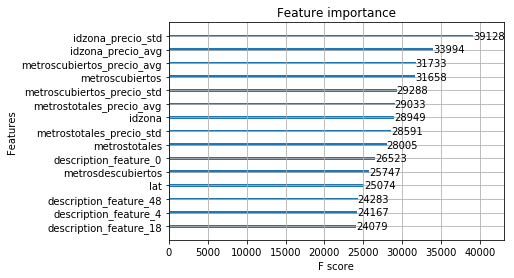

In [116]:
xgb.plot_importance(bst, max_num_features=15)

In [ ]:
dic_xgb_val = {}
dic_xgb_test = {}
num_models = 10

for i in tqdm(range(num_models)):
    param = {
        "objective": "gpu:reg:linear",
        "predictor": "gpu_predictor",
        'tree_method': 'gpu_hist',
        'eval_metric': 'rmse',
        'max_depth': 12,
        'subsample': 0.601952118908679,
        'colsample_bytree': 0.385907167484953,
        'colsample_bylevel': 0.22124681693231402,
        'reg_alpha': 1.6958985572392464,
        'reg_lambda': 39.473507254981286,
        'learning_rate': 0.05093346656231449,
        'max_delta_step': 0.11015167006000029,
        'gamma': 0.01816347483227848,
        'min_child': 52.98889245279933,
        'seed': i
    }
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(df_test.drop(['id'],axis=1))

    evals = [(dtrain, 'train'), (dval, 'validation')]
    bst = xgb.train(param, dtrain, evals=evals, num_boost_round=6500, verbose_eval=3)
    
    #dtrain_full = xgb.DMatrix(pd.concat([X_train, X_val], axis=0), label=pd.concat([y_train, y_val], axis=0))
    #evals = [(dtrain_full, 'train')]
    
    #bst = xgb.train(param, dtrain_full, evals=evals, num_boost_round=6500, verbose_eval=3)
    bst.save_model('xgb')
    
    bst.__del__()
    del bst
    gc.collect()
    
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model('xgb')  # load data
    
    xgb_y_val = bst.predict(dval)
    xgb_y_test = bst.predict(dtest)
    
    dtrain.__del__()
    dval.__del__()
    dtest.__del__()
    del dtrain; del dval; del dtest
    gc.collect()
    
    dic_xgb_val['xgb_' + str(i)] = xgb_y_val
    dic_xgb_test['xgb_' + str(i)] = xgb_y_test







  0%|          | 0/10 [00:00<?, ?it/s]

[0]	train-rmse:13.9311	validation-rmse:13.9117
[3]	train-rmse:13.9143	validation-rmse:13.8949
[6]	train-rmse:13.8975	validation-rmse:13.8781
[9]	train-rmse:13.8807	validation-rmse:13.8613
[12]	train-rmse:13.8639	validation-rmse:13.8445
[15]	train-rmse:13.847	validation-rmse:13.8277
[18]	train-rmse:13.8302	validation-rmse:13.8109
[21]	train-rmse:13.8134	validation-rmse:13.7941
[24]	train-rmse:13.7966	validation-rmse:13.7773
[27]	train-rmse:13.7798	validation-rmse:13.7605
[30]	train-rmse:13.763	validation-rmse:13.7437
[33]	train-rmse:13.7462	validation-rmse:13.7269
[36]	train-rmse:13.7294	validation-rmse:13.7101
[39]	train-rmse:13.7126	validation-rmse:13.6933
[42]	train-rmse:13.6958	validation-rmse:13.6765
[45]	train-rmse:13.6791	validation-rmse:13.6597
[48]	train-rmse:13.6623	validation-rmse:13.6429
[51]	train-rmse:13.6455	validation-rmse:13.6261
[54]	train-rmse:13.6287	validation-rmse:13.6093
[57]	train-rmse:13.6119	validation-rmse:13.5925
[60]	train-rmse:13.5951	validation-rmse:13.575

[507]	train-rmse:11.093	validation-rmse:11.0736
[510]	train-rmse:11.0763	validation-rmse:11.0568
[513]	train-rmse:11.0595	validation-rmse:11.04
[516]	train-rmse:11.0427	validation-rmse:11.0232
[519]	train-rmse:11.0259	validation-rmse:11.0064
[522]	train-rmse:11.0091	validation-rmse:10.9896
[525]	train-rmse:10.9923	validation-rmse:10.9729
[528]	train-rmse:10.9756	validation-rmse:10.9561
[531]	train-rmse:10.9588	validation-rmse:10.9393
[534]	train-rmse:10.942	validation-rmse:10.9225
[537]	train-rmse:10.9252	validation-rmse:10.9057
[540]	train-rmse:10.9084	validation-rmse:10.8889
[543]	train-rmse:10.8917	validation-rmse:10.8722
[546]	train-rmse:10.8749	validation-rmse:10.8554
[549]	train-rmse:10.8581	validation-rmse:10.8386
[552]	train-rmse:10.8413	validation-rmse:10.8218
[555]	train-rmse:10.8245	validation-rmse:10.805
[558]	train-rmse:10.8077	validation-rmse:10.7882
[561]	train-rmse:10.791	validation-rmse:10.7715
[564]	train-rmse:10.7742	validation-rmse:10.7547
[567]	train-rmse:10.7574	v

[1011]	train-rmse:8.2762	validation-rmse:8.2566
[1014]	train-rmse:8.25946	validation-rmse:8.23985
[1017]	train-rmse:8.24272	validation-rmse:8.22311
[1020]	train-rmse:8.22597	validation-rmse:8.20636
[1023]	train-rmse:8.20923	validation-rmse:8.18962
[1026]	train-rmse:8.19248	validation-rmse:8.17287
[1029]	train-rmse:8.17574	validation-rmse:8.15613
[1032]	train-rmse:8.159	validation-rmse:8.13938
[1035]	train-rmse:8.14226	validation-rmse:8.12264
[1038]	train-rmse:8.12551	validation-rmse:8.1059
[1041]	train-rmse:8.10877	validation-rmse:8.08916
[1044]	train-rmse:8.09203	validation-rmse:8.07241
[1047]	train-rmse:8.07529	validation-rmse:8.05567
[1050]	train-rmse:8.05855	validation-rmse:8.03893
[1053]	train-rmse:8.04181	validation-rmse:8.02219
[1056]	train-rmse:8.02507	validation-rmse:8.00545
[1059]	train-rmse:8.00833	validation-rmse:7.98871
[1062]	train-rmse:7.99159	validation-rmse:7.97197
[1065]	train-rmse:7.97485	validation-rmse:7.95523
[1068]	train-rmse:7.95812	validation-rmse:7.93849
[1071

[1506]	train-rmse:5.52046	validation-rmse:5.50066
[1509]	train-rmse:5.50382	validation-rmse:5.48402
[1512]	train-rmse:5.48719	validation-rmse:5.46738
[1515]	train-rmse:5.47056	validation-rmse:5.45075
[1518]	train-rmse:5.45392	validation-rmse:5.43412
[1521]	train-rmse:5.43729	validation-rmse:5.41748
[1524]	train-rmse:5.42066	validation-rmse:5.40085
[1527]	train-rmse:5.40404	validation-rmse:5.38422
[1530]	train-rmse:5.38741	validation-rmse:5.36759
[1533]	train-rmse:5.37078	validation-rmse:5.35097
[1536]	train-rmse:5.35416	validation-rmse:5.33434
[1539]	train-rmse:5.33753	validation-rmse:5.31771
[1542]	train-rmse:5.32091	validation-rmse:5.30109
[1545]	train-rmse:5.30429	validation-rmse:5.28447
[1548]	train-rmse:5.28767	validation-rmse:5.26785
[1551]	train-rmse:5.27105	validation-rmse:5.25123
[1554]	train-rmse:5.25444	validation-rmse:5.23461
[1557]	train-rmse:5.23782	validation-rmse:5.21799
[1560]	train-rmse:5.22121	validation-rmse:5.20138
[1563]	train-rmse:5.2046	validation-rmse:5.18476
[

[2001]	train-rmse:2.80729	validation-rmse:2.78721
[2004]	train-rmse:2.79123	validation-rmse:2.77115
[2007]	train-rmse:2.77518	validation-rmse:2.7551
[2010]	train-rmse:2.75914	validation-rmse:2.73906
[2013]	train-rmse:2.74311	validation-rmse:2.72303
[2016]	train-rmse:2.72708	validation-rmse:2.707
[2019]	train-rmse:2.71107	validation-rmse:2.69099
[2022]	train-rmse:2.69507	validation-rmse:2.67499
[2025]	train-rmse:2.67908	validation-rmse:2.659
[2028]	train-rmse:2.6631	validation-rmse:2.64302
[2031]	train-rmse:2.64712	validation-rmse:2.62704
[2034]	train-rmse:2.63116	validation-rmse:2.61108
[2037]	train-rmse:2.61521	validation-rmse:2.59513
[2040]	train-rmse:2.59928	validation-rmse:2.5792
[2043]	train-rmse:2.58335	validation-rmse:2.56327
[2046]	train-rmse:2.56743	validation-rmse:2.54736
[2049]	train-rmse:2.55153	validation-rmse:2.53145
[2052]	train-rmse:2.53564	validation-rmse:2.51556
[2055]	train-rmse:2.51976	validation-rmse:2.49968
[2058]	train-rmse:2.50389	validation-rmse:2.48382
[2061]	

[2493]	train-rmse:0.592944	validation-rmse:0.594613
[2496]	train-rmse:0.584339	validation-rmse:0.586652
[2499]	train-rmse:0.575822	validation-rmse:0.578573
[2502]	train-rmse:0.566765	validation-rmse:0.570086
[2505]	train-rmse:0.558578	validation-rmse:0.56248
[2508]	train-rmse:0.549877	validation-rmse:0.554435
[2511]	train-rmse:0.541486	validation-rmse:0.546698
[2514]	train-rmse:0.533598	validation-rmse:0.539559
[2517]	train-rmse:0.525973	validation-rmse:0.532491
[2520]	train-rmse:0.518468	validation-rmse:0.525543
[2523]	train-rmse:0.510684	validation-rmse:0.5185
[2526]	train-rmse:0.50308	validation-rmse:0.511621
[2529]	train-rmse:0.495287	validation-rmse:0.504495
[2532]	train-rmse:0.487628	validation-rmse:0.497512
[2535]	train-rmse:0.480366	validation-rmse:0.490862
[2538]	train-rmse:0.473434	validation-rmse:0.484569
[2541]	train-rmse:0.465944	validation-rmse:0.477927
[2544]	train-rmse:0.458672	validation-rmse:0.471411
[2547]	train-rmse:0.451568	validation-rmse:0.465033
[2550]	train-rms

[2970]	train-rmse:0.181286	validation-rmse:0.283067
[2973]	train-rmse:0.180816	validation-rmse:0.282976
[2976]	train-rmse:0.180373	validation-rmse:0.282917
[2979]	train-rmse:0.179883	validation-rmse:0.282836
[2982]	train-rmse:0.179479	validation-rmse:0.282765
[2985]	train-rmse:0.17892	validation-rmse:0.282713
[2988]	train-rmse:0.178517	validation-rmse:0.282657
[2991]	train-rmse:0.17812	validation-rmse:0.282598
[2994]	train-rmse:0.177661	validation-rmse:0.282573
[2997]	train-rmse:0.177248	validation-rmse:0.282505
[3000]	train-rmse:0.176916	validation-rmse:0.282417
[3003]	train-rmse:0.176402	validation-rmse:0.282303
[3006]	train-rmse:0.176029	validation-rmse:0.282247
[3009]	train-rmse:0.175631	validation-rmse:0.282184
[3012]	train-rmse:0.175245	validation-rmse:0.282124
[3015]	train-rmse:0.174899	validation-rmse:0.282109
[3018]	train-rmse:0.174548	validation-rmse:0.282064
[3021]	train-rmse:0.174106	validation-rmse:0.282009
[3024]	train-rmse:0.173702	validation-rmse:0.281943
[3027]	train-r

[3444]	train-rmse:0.130342	validation-rmse:0.277234
[3447]	train-rmse:0.130127	validation-rmse:0.277213
[3450]	train-rmse:0.12988	validation-rmse:0.277176
[3453]	train-rmse:0.12962	validation-rmse:0.277146
[3456]	train-rmse:0.129342	validation-rmse:0.277118
[3459]	train-rmse:0.12912	validation-rmse:0.277111
[3462]	train-rmse:0.12891	validation-rmse:0.277098
[3465]	train-rmse:0.128651	validation-rmse:0.27706
[3468]	train-rmse:0.128438	validation-rmse:0.277043
[3471]	train-rmse:0.128268	validation-rmse:0.277045
[3474]	train-rmse:0.128004	validation-rmse:0.277049
[3477]	train-rmse:0.127772	validation-rmse:0.277029
[3480]	train-rmse:0.127536	validation-rmse:0.276995
[3483]	train-rmse:0.127294	validation-rmse:0.276958
[3486]	train-rmse:0.127083	validation-rmse:0.276948
[3489]	train-rmse:0.12687	validation-rmse:0.276935
[3492]	train-rmse:0.126609	validation-rmse:0.276929
[3495]	train-rmse:0.126369	validation-rmse:0.276913
[3498]	train-rmse:0.126113	validation-rmse:0.276908
[3501]	train-rmse:

[3921]	train-rmse:0.098445	validation-rmse:0.275409
[3924]	train-rmse:0.098246	validation-rmse:0.275414
[3927]	train-rmse:0.09806	validation-rmse:0.275395
[3930]	train-rmse:0.097904	validation-rmse:0.275375
[3933]	train-rmse:0.09777	validation-rmse:0.275365
[3936]	train-rmse:0.097599	validation-rmse:0.275353
[3939]	train-rmse:0.09741	validation-rmse:0.275332
[3942]	train-rmse:0.097242	validation-rmse:0.275337
[3945]	train-rmse:0.09707	validation-rmse:0.275327
[3948]	train-rmse:0.096929	validation-rmse:0.275311
[3951]	train-rmse:0.096751	validation-rmse:0.275322
[3954]	train-rmse:0.096589	validation-rmse:0.275303
[3957]	train-rmse:0.096413	validation-rmse:0.275297
[3960]	train-rmse:0.096226	validation-rmse:0.275299
[3963]	train-rmse:0.096127	validation-rmse:0.275293
[3966]	train-rmse:0.095937	validation-rmse:0.275265
[3969]	train-rmse:0.095774	validation-rmse:0.275248
[3972]	train-rmse:0.095598	validation-rmse:0.27526
[3975]	train-rmse:0.095415	validation-rmse:0.275261
[3978]	train-rmse

[4398]	train-rmse:0.076715	validation-rmse:0.274614
[4401]	train-rmse:0.076588	validation-rmse:0.274609
[4404]	train-rmse:0.076488	validation-rmse:0.274602
[4407]	train-rmse:0.076374	validation-rmse:0.274593
[4410]	train-rmse:0.07625	validation-rmse:0.27459
[4413]	train-rmse:0.076152	validation-rmse:0.27458
[4416]	train-rmse:0.076012	validation-rmse:0.274577
[4419]	train-rmse:0.075914	validation-rmse:0.274572
[4422]	train-rmse:0.07579	validation-rmse:0.274565
[4425]	train-rmse:0.07568	validation-rmse:0.274566
[4428]	train-rmse:0.075579	validation-rmse:0.274563
[4431]	train-rmse:0.075455	validation-rmse:0.274561
[4434]	train-rmse:0.07534	validation-rmse:0.27455
[4437]	train-rmse:0.075247	validation-rmse:0.274536
[4440]	train-rmse:0.075142	validation-rmse:0.274533
[4443]	train-rmse:0.075055	validation-rmse:0.274525
[4446]	train-rmse:0.07495	validation-rmse:0.274529
[4449]	train-rmse:0.074831	validation-rmse:0.274535
[4452]	train-rmse:0.074707	validation-rmse:0.274524
[4455]	train-rmse:0.

[4875]	train-rmse:0.061541	validation-rmse:0.274152
[4878]	train-rmse:0.061468	validation-rmse:0.274148
[4881]	train-rmse:0.061393	validation-rmse:0.274152
[4884]	train-rmse:0.061316	validation-rmse:0.274147
[4887]	train-rmse:0.061232	validation-rmse:0.27414
[4890]	train-rmse:0.06115	validation-rmse:0.274143
[4893]	train-rmse:0.061063	validation-rmse:0.274144
[4896]	train-rmse:0.060993	validation-rmse:0.274147
[4899]	train-rmse:0.060924	validation-rmse:0.274147
[4902]	train-rmse:0.060818	validation-rmse:0.274139
[4905]	train-rmse:0.060729	validation-rmse:0.274137
[4908]	train-rmse:0.060678	validation-rmse:0.274134
[4911]	train-rmse:0.060606	validation-rmse:0.274134
[4914]	train-rmse:0.060523	validation-rmse:0.274121
[4917]	train-rmse:0.060444	validation-rmse:0.274121
[4920]	train-rmse:0.060358	validation-rmse:0.274111
[4923]	train-rmse:0.060273	validation-rmse:0.274107
[4926]	train-rmse:0.060192	validation-rmse:0.274095
[4929]	train-rmse:0.060109	validation-rmse:0.274097
[4932]	train-r

[5352]	train-rmse:0.050867	validation-rmse:0.273915
[5355]	train-rmse:0.050815	validation-rmse:0.27392
[5358]	train-rmse:0.050769	validation-rmse:0.273925
[5361]	train-rmse:0.050716	validation-rmse:0.273926
[5364]	train-rmse:0.050669	validation-rmse:0.273917
[5367]	train-rmse:0.050604	validation-rmse:0.273911
[5370]	train-rmse:0.050553	validation-rmse:0.273908
[5373]	train-rmse:0.050501	validation-rmse:0.273899
[5376]	train-rmse:0.050457	validation-rmse:0.273897
[5379]	train-rmse:0.050405	validation-rmse:0.273894
[5382]	train-rmse:0.050354	validation-rmse:0.273887
[5385]	train-rmse:0.050285	validation-rmse:0.273889
[5388]	train-rmse:0.050217	validation-rmse:0.273888
[5391]	train-rmse:0.050163	validation-rmse:0.273884
[5394]	train-rmse:0.050116	validation-rmse:0.273875
[5397]	train-rmse:0.050063	validation-rmse:0.273876
[5400]	train-rmse:0.05002	validation-rmse:0.273877
[5403]	train-rmse:0.049969	validation-rmse:0.273884
[5406]	train-rmse:0.049927	validation-rmse:0.273885
[5409]	train-r

[5829]	train-rmse:0.0433	validation-rmse:0.273741
[5832]	train-rmse:0.043259	validation-rmse:0.273742
[5835]	train-rmse:0.043226	validation-rmse:0.27374
[5838]	train-rmse:0.043184	validation-rmse:0.273741
[5841]	train-rmse:0.043139	validation-rmse:0.273736
[5844]	train-rmse:0.043096	validation-rmse:0.273739
[5847]	train-rmse:0.043058	validation-rmse:0.273741
[5850]	train-rmse:0.043013	validation-rmse:0.273745
[5853]	train-rmse:0.042973	validation-rmse:0.27374
[5856]	train-rmse:0.042936	validation-rmse:0.273737
[5859]	train-rmse:0.042894	validation-rmse:0.273742
[5862]	train-rmse:0.042848	validation-rmse:0.27374
[5865]	train-rmse:0.042812	validation-rmse:0.273739
[5868]	train-rmse:0.042771	validation-rmse:0.273743
[5871]	train-rmse:0.042733	validation-rmse:0.273747
[5874]	train-rmse:0.042695	validation-rmse:0.273748
[5877]	train-rmse:0.04265	validation-rmse:0.273748
[5880]	train-rmse:0.042608	validation-rmse:0.273742
[5883]	train-rmse:0.042564	validation-rmse:0.273747
[5886]	train-rmse:

[6306]	train-rmse:0.037632	validation-rmse:0.273665
[6309]	train-rmse:0.037605	validation-rmse:0.273662
[6312]	train-rmse:0.037575	validation-rmse:0.273661
[6315]	train-rmse:0.03754	validation-rmse:0.273659
[6318]	train-rmse:0.037511	validation-rmse:0.273655
[6321]	train-rmse:0.037486	validation-rmse:0.273652
[6324]	train-rmse:0.037451	validation-rmse:0.27365
[6327]	train-rmse:0.037417	validation-rmse:0.27365
[6330]	train-rmse:0.037385	validation-rmse:0.273648
[6333]	train-rmse:0.037357	validation-rmse:0.273647
[6336]	train-rmse:0.037329	validation-rmse:0.273649
[6339]	train-rmse:0.037302	validation-rmse:0.273646
[6342]	train-rmse:0.037274	validation-rmse:0.273647
[6345]	train-rmse:0.03724	validation-rmse:0.273648
[6348]	train-rmse:0.037206	validation-rmse:0.273645
[6351]	train-rmse:0.037182	validation-rmse:0.273644
[6354]	train-rmse:0.037153	validation-rmse:0.273643
[6357]	train-rmse:0.037129	validation-rmse:0.273642
[6360]	train-rmse:0.037101	validation-rmse:0.273643
[6363]	train-rms







 10%|█         | 1/10 [53:31<8:01:45, 3211.76s/it]

[0]	train-rmse:13.9311	validation-rmse:13.9117
[3]	train-rmse:13.9143	validation-rmse:13.8949
[6]	train-rmse:13.8975	validation-rmse:13.8781
[9]	train-rmse:13.8807	validation-rmse:13.8613
[12]	train-rmse:13.8639	validation-rmse:13.8445
[15]	train-rmse:13.847	validation-rmse:13.8277
[18]	train-rmse:13.8302	validation-rmse:13.8109
[21]	train-rmse:13.8134	validation-rmse:13.7941
[24]	train-rmse:13.7966	validation-rmse:13.7773
[27]	train-rmse:13.7798	validation-rmse:13.7605
[30]	train-rmse:13.763	validation-rmse:13.7437
[33]	train-rmse:13.7462	validation-rmse:13.7269
[36]	train-rmse:13.7294	validation-rmse:13.7101
[39]	train-rmse:13.7126	validation-rmse:13.6933
[42]	train-rmse:13.6958	validation-rmse:13.6765
[45]	train-rmse:13.6791	validation-rmse:13.6597
[48]	train-rmse:13.6623	validation-rmse:13.6429
[51]	train-rmse:13.6455	validation-rmse:13.6261
[54]	train-rmse:13.6287	validation-rmse:13.6093
[57]	train-rmse:13.6119	validation-rmse:13.5925
[60]	train-rmse:13.5951	validation-rmse:13.575

[507]	train-rmse:11.093	validation-rmse:11.0736
[510]	train-rmse:11.0763	validation-rmse:11.0568
[513]	train-rmse:11.0595	validation-rmse:11.04
[516]	train-rmse:11.0427	validation-rmse:11.0232
[519]	train-rmse:11.0259	validation-rmse:11.0064
[522]	train-rmse:11.0091	validation-rmse:10.9896
[525]	train-rmse:10.9923	validation-rmse:10.9729
[528]	train-rmse:10.9756	validation-rmse:10.9561
[531]	train-rmse:10.9588	validation-rmse:10.9393
[534]	train-rmse:10.942	validation-rmse:10.9225
[537]	train-rmse:10.9252	validation-rmse:10.9057
[540]	train-rmse:10.9084	validation-rmse:10.8889
[543]	train-rmse:10.8917	validation-rmse:10.8722
[546]	train-rmse:10.8749	validation-rmse:10.8554
[549]	train-rmse:10.8581	validation-rmse:10.8386
[552]	train-rmse:10.8413	validation-rmse:10.8218
[555]	train-rmse:10.8245	validation-rmse:10.805
[558]	train-rmse:10.8077	validation-rmse:10.7882
[561]	train-rmse:10.791	validation-rmse:10.7715
[564]	train-rmse:10.7742	validation-rmse:10.7547
[567]	train-rmse:10.7574	v

[1011]	train-rmse:8.2762	validation-rmse:8.2566
[1014]	train-rmse:8.25946	validation-rmse:8.23985
[1017]	train-rmse:8.24272	validation-rmse:8.22311
[1020]	train-rmse:8.22597	validation-rmse:8.20636
[1023]	train-rmse:8.20923	validation-rmse:8.18962
[1026]	train-rmse:8.19248	validation-rmse:8.17287
[1029]	train-rmse:8.17574	validation-rmse:8.15613
[1032]	train-rmse:8.159	validation-rmse:8.13938
[1035]	train-rmse:8.14226	validation-rmse:8.12264
[1038]	train-rmse:8.12551	validation-rmse:8.1059
[1041]	train-rmse:8.10877	validation-rmse:8.08916
[1044]	train-rmse:8.09203	validation-rmse:8.07241
[1047]	train-rmse:8.07529	validation-rmse:8.05567
[1050]	train-rmse:8.05855	validation-rmse:8.03893
[1053]	train-rmse:8.04181	validation-rmse:8.02219
[1056]	train-rmse:8.02507	validation-rmse:8.00545
[1059]	train-rmse:8.00833	validation-rmse:7.98871
[1062]	train-rmse:7.99159	validation-rmse:7.97197
[1065]	train-rmse:7.97485	validation-rmse:7.95523
[1068]	train-rmse:7.95812	validation-rmse:7.93849
[1071

[1506]	train-rmse:5.52046	validation-rmse:5.50066
[1509]	train-rmse:5.50382	validation-rmse:5.48402
[1512]	train-rmse:5.48719	validation-rmse:5.46738
[1515]	train-rmse:5.47056	validation-rmse:5.45075
[1518]	train-rmse:5.45392	validation-rmse:5.43412
[1521]	train-rmse:5.43729	validation-rmse:5.41748
[1524]	train-rmse:5.42066	validation-rmse:5.40085
[1527]	train-rmse:5.40404	validation-rmse:5.38422
[1530]	train-rmse:5.38741	validation-rmse:5.36759
[1533]	train-rmse:5.37078	validation-rmse:5.35097
[1536]	train-rmse:5.35416	validation-rmse:5.33434
[1539]	train-rmse:5.33753	validation-rmse:5.31771
[1542]	train-rmse:5.32091	validation-rmse:5.30109
[1545]	train-rmse:5.30429	validation-rmse:5.28447
[1548]	train-rmse:5.28767	validation-rmse:5.26785
[1551]	train-rmse:5.27105	validation-rmse:5.25123
[1554]	train-rmse:5.25444	validation-rmse:5.23461
[1557]	train-rmse:5.23782	validation-rmse:5.21799
[1560]	train-rmse:5.22121	validation-rmse:5.20138
[1563]	train-rmse:5.2046	validation-rmse:5.18476
[

[2001]	train-rmse:2.80729	validation-rmse:2.78721
[2004]	train-rmse:2.79123	validation-rmse:2.77115
[2007]	train-rmse:2.77518	validation-rmse:2.7551
[2010]	train-rmse:2.75914	validation-rmse:2.73906
[2013]	train-rmse:2.74311	validation-rmse:2.72303
[2016]	train-rmse:2.72708	validation-rmse:2.707
[2019]	train-rmse:2.71107	validation-rmse:2.69099
[2022]	train-rmse:2.69507	validation-rmse:2.67499
[2025]	train-rmse:2.67908	validation-rmse:2.659
[2028]	train-rmse:2.6631	validation-rmse:2.64302
[2031]	train-rmse:2.64712	validation-rmse:2.62704
[2034]	train-rmse:2.63116	validation-rmse:2.61108
[2037]	train-rmse:2.61521	validation-rmse:2.59513
[2040]	train-rmse:2.59928	validation-rmse:2.5792
[2043]	train-rmse:2.58335	validation-rmse:2.56327
[2046]	train-rmse:2.56743	validation-rmse:2.54736
[2049]	train-rmse:2.55153	validation-rmse:2.53145
[2052]	train-rmse:2.53564	validation-rmse:2.51556
[2055]	train-rmse:2.51976	validation-rmse:2.49968
[2058]	train-rmse:2.50389	validation-rmse:2.48382
[2061]	

[2493]	train-rmse:0.593431	validation-rmse:0.594552
[2496]	train-rmse:0.584569	validation-rmse:0.586317
[2499]	train-rmse:0.575814	validation-rmse:0.578104
[2502]	train-rmse:0.567466	validation-rmse:0.570353
[2505]	train-rmse:0.559036	validation-rmse:0.562458
[2508]	train-rmse:0.55085	validation-rmse:0.554786
[2511]	train-rmse:0.542542	validation-rmse:0.546924
[2514]	train-rmse:0.534341	validation-rmse:0.539272
[2517]	train-rmse:0.526186	validation-rmse:0.531688
[2520]	train-rmse:0.518148	validation-rmse:0.524416
[2523]	train-rmse:0.510521	validation-rmse:0.517472
[2526]	train-rmse:0.502836	validation-rmse:0.510486
[2529]	train-rmse:0.495743	validation-rmse:0.503975
[2532]	train-rmse:0.488145	validation-rmse:0.497067
[2535]	train-rmse:0.481362	validation-rmse:0.490992
[2538]	train-rmse:0.474516	validation-rmse:0.484908
[2541]	train-rmse:0.46753	validation-rmse:0.478471
[2544]	train-rmse:0.460477	validation-rmse:0.472037
[2547]	train-rmse:0.453698	validation-rmse:0.465872
[2550]	train-r

[2970]	train-rmse:0.179972	validation-rmse:0.281851
[2973]	train-rmse:0.179534	validation-rmse:0.281816
[2976]	train-rmse:0.179199	validation-rmse:0.281785
[2979]	train-rmse:0.178771	validation-rmse:0.281687
[2982]	train-rmse:0.17834	validation-rmse:0.281613
[2985]	train-rmse:0.178011	validation-rmse:0.281539
[2988]	train-rmse:0.177601	validation-rmse:0.281486
[2991]	train-rmse:0.177128	validation-rmse:0.281428
[2994]	train-rmse:0.176776	validation-rmse:0.281364
[2997]	train-rmse:0.176419	validation-rmse:0.281288
[3000]	train-rmse:0.176013	validation-rmse:0.28123
[3003]	train-rmse:0.175558	validation-rmse:0.281176
[3006]	train-rmse:0.175079	validation-rmse:0.281054
[3009]	train-rmse:0.174723	validation-rmse:0.280997
[3012]	train-rmse:0.174333	validation-rmse:0.28097
[3015]	train-rmse:0.173975	validation-rmse:0.280895
[3018]	train-rmse:0.173636	validation-rmse:0.280871
[3021]	train-rmse:0.173236	validation-rmse:0.280856
[3024]	train-rmse:0.172834	validation-rmse:0.280806
[3027]	train-rm

[3447]	train-rmse:0.130446	validation-rmse:0.27694
[3450]	train-rmse:0.130187	validation-rmse:0.27691
[3453]	train-rmse:0.130046	validation-rmse:0.276883
[3456]	train-rmse:0.129839	validation-rmse:0.276906
[3459]	train-rmse:0.129561	validation-rmse:0.276923
[3462]	train-rmse:0.129359	validation-rmse:0.276899
[3465]	train-rmse:0.129136	validation-rmse:0.276913
[3468]	train-rmse:0.128888	validation-rmse:0.276872
[3471]	train-rmse:0.128632	validation-rmse:0.276869
[3474]	train-rmse:0.128351	validation-rmse:0.27685
[3477]	train-rmse:0.128132	validation-rmse:0.276838
[3480]	train-rmse:0.127902	validation-rmse:0.276829
[3483]	train-rmse:0.127641	validation-rmse:0.276815
[3486]	train-rmse:0.127422	validation-rmse:0.276811
[3489]	train-rmse:0.127166	validation-rmse:0.276804
[3492]	train-rmse:0.126967	validation-rmse:0.2768
[3495]	train-rmse:0.126692	validation-rmse:0.27678
[3498]	train-rmse:0.126453	validation-rmse:0.276776
[3501]	train-rmse:0.126244	validation-rmse:0.276737
[3504]	train-rmse:

[3924]	train-rmse:0.098584	validation-rmse:0.275183
[3927]	train-rmse:0.098416	validation-rmse:0.275158
[3930]	train-rmse:0.098267	validation-rmse:0.275145
[3933]	train-rmse:0.098091	validation-rmse:0.275128
[3936]	train-rmse:0.097904	validation-rmse:0.275124
[3939]	train-rmse:0.097771	validation-rmse:0.275101
[3942]	train-rmse:0.097594	validation-rmse:0.2751
[3945]	train-rmse:0.097453	validation-rmse:0.275101
[3948]	train-rmse:0.097269	validation-rmse:0.275078
[3951]	train-rmse:0.097119	validation-rmse:0.275068
[3954]	train-rmse:0.096947	validation-rmse:0.275064
[3957]	train-rmse:0.09678	validation-rmse:0.275041
[3960]	train-rmse:0.096613	validation-rmse:0.275038
[3963]	train-rmse:0.096424	validation-rmse:0.275041
[3966]	train-rmse:0.096205	validation-rmse:0.274999
[3969]	train-rmse:0.096065	validation-rmse:0.274988
[3972]	train-rmse:0.095893	validation-rmse:0.274969
[3975]	train-rmse:0.095727	validation-rmse:0.274967
[3978]	train-rmse:0.09554	validation-rmse:0.274963
[3981]	train-rms

[4401]	train-rmse:0.076745	validation-rmse:0.274146
[4404]	train-rmse:0.076647	validation-rmse:0.274132
[4407]	train-rmse:0.07653	validation-rmse:0.274126
[4410]	train-rmse:0.076417	validation-rmse:0.274126
[4413]	train-rmse:0.076292	validation-rmse:0.274113
[4416]	train-rmse:0.07618	validation-rmse:0.274104
[4419]	train-rmse:0.07604	validation-rmse:0.274112
[4422]	train-rmse:0.07592	validation-rmse:0.274109
[4425]	train-rmse:0.075807	validation-rmse:0.274094
[4428]	train-rmse:0.075668	validation-rmse:0.274099
[4431]	train-rmse:0.075546	validation-rmse:0.274093
[4434]	train-rmse:0.075424	validation-rmse:0.2741
[4437]	train-rmse:0.075322	validation-rmse:0.274103
[4440]	train-rmse:0.075216	validation-rmse:0.274095
[4443]	train-rmse:0.075102	validation-rmse:0.274078
[4446]	train-rmse:0.074985	validation-rmse:0.274082
[4449]	train-rmse:0.074899	validation-rmse:0.274066
[4452]	train-rmse:0.074774	validation-rmse:0.274072
[4455]	train-rmse:0.074662	validation-rmse:0.274067
[4458]	train-rmse:

[4878]	train-rmse:0.061571	validation-rmse:0.273781
[4881]	train-rmse:0.061493	validation-rmse:0.273774
[4884]	train-rmse:0.0614	validation-rmse:0.273784
[4887]	train-rmse:0.061313	validation-rmse:0.273781
[4890]	train-rmse:0.061232	validation-rmse:0.273776
[4893]	train-rmse:0.061168	validation-rmse:0.273776
[4896]	train-rmse:0.061093	validation-rmse:0.273777
[4899]	train-rmse:0.061025	validation-rmse:0.273772
[4902]	train-rmse:0.060948	validation-rmse:0.27377
[4905]	train-rmse:0.060874	validation-rmse:0.273766
[4908]	train-rmse:0.060792	validation-rmse:0.273776
[4911]	train-rmse:0.060722	validation-rmse:0.273766
[4914]	train-rmse:0.060664	validation-rmse:0.273766
[4917]	train-rmse:0.060608	validation-rmse:0.273765
[4920]	train-rmse:0.060538	validation-rmse:0.273761
[4923]	train-rmse:0.060464	validation-rmse:0.273765
[4926]	train-rmse:0.060387	validation-rmse:0.273773
[4929]	train-rmse:0.060305	validation-rmse:0.273775
[4932]	train-rmse:0.060213	validation-rmse:0.273779
[4935]	train-rm

[5355]	train-rmse:0.050858	validation-rmse:0.273541
[5358]	train-rmse:0.050805	validation-rmse:0.273539
[5361]	train-rmse:0.050757	validation-rmse:0.273539
[5364]	train-rmse:0.050697	validation-rmse:0.273535
[5367]	train-rmse:0.05064	validation-rmse:0.273531
[5370]	train-rmse:0.050584	validation-rmse:0.273529
[5373]	train-rmse:0.050531	validation-rmse:0.273532
[5376]	train-rmse:0.050473	validation-rmse:0.273535
[5379]	train-rmse:0.050412	validation-rmse:0.273539
[5382]	train-rmse:0.050374	validation-rmse:0.273542
[5385]	train-rmse:0.050317	validation-rmse:0.273547
[5388]	train-rmse:0.050265	validation-rmse:0.273549
[5391]	train-rmse:0.050206	validation-rmse:0.273549
[5394]	train-rmse:0.050152	validation-rmse:0.273548
[5397]	train-rmse:0.050091	validation-rmse:0.273541
[5400]	train-rmse:0.050034	validation-rmse:0.273539
[5403]	train-rmse:0.049979	validation-rmse:0.273544
[5406]	train-rmse:0.04992	validation-rmse:0.273538
[5409]	train-rmse:0.04987	validation-rmse:0.273537
[5412]	train-rm

[5832]	train-rmse:0.043314	validation-rmse:0.273298
[5835]	train-rmse:0.043269	validation-rmse:0.273293
[5838]	train-rmse:0.043233	validation-rmse:0.273292
[5841]	train-rmse:0.043186	validation-rmse:0.273294
[5844]	train-rmse:0.043145	validation-rmse:0.273297
[5847]	train-rmse:0.043106	validation-rmse:0.273296
[5850]	train-rmse:0.043077	validation-rmse:0.273294
[5853]	train-rmse:0.043037	validation-rmse:0.273293
[5856]	train-rmse:0.042989	validation-rmse:0.273291
[5859]	train-rmse:0.04295	validation-rmse:0.273294
[5862]	train-rmse:0.042913	validation-rmse:0.273299
[5865]	train-rmse:0.042866	validation-rmse:0.273296
[5868]	train-rmse:0.042824	validation-rmse:0.273294
[5871]	train-rmse:0.04279	validation-rmse:0.273294
[5874]	train-rmse:0.042742	validation-rmse:0.27329
[5877]	train-rmse:0.042704	validation-rmse:0.273291
[5880]	train-rmse:0.042657	validation-rmse:0.273293
[5883]	train-rmse:0.042619	validation-rmse:0.273293
[5886]	train-rmse:0.04258	validation-rmse:0.273299
[5889]	train-rms

In [ ]:
df_xgb_val = pd.DataFrame(dic_xgb_val)
df_xgb_test = pd.DataFrame(dic_xgb_test)

In [ ]:
# df_xgb_val.to_csv('xgb_val.csv')
# df_xgb_test.to_csv('xgb_test.csv')

In [20]:
df_xgb_val = pd.read_csv('xgb_val.csv', index_col=0)
df_xgb_test = pd.read_csv('xgb_test.csv', index_col=0)

xgb_0      xgb_1      xgb_2      xgb_3      xgb_4      xgb_5  \
0  14.404677  14.357832  14.364537  14.377335  14.349959  14.413413   
1  14.755633  14.705214  14.743520  14.721928  14.676094  14.759967   
2  15.005149  14.974732  14.980875  14.913930  14.971573  14.953513   
3  14.342000  14.358539  14.380853  14.423366  14.373068  14.327758   
4  12.605529  12.594790  12.622932  12.507648  12.650233  12.657185   

       xgb_6      xgb_7      xgb_8      xgb_9  
0  14.365565  14.396181  14.360883  14.418727  
1  14.761238  14.690510  14.779802  14.723955  
2  15.064016  14.930486  14.990666  14.977444  
3  14.325992  14.459243  14.339330  14.330529  
4  12.666026  12.611805  12.672953  12.607372

In [60]:
from sklearn.model_selection import KFold

df = pd.read_csv('train.csv', index_col='id', parse_dates=['fecha'])
df_test = pd.read_csv('test.csv', parse_dates=['fecha'])
text_features = ["titulo", "descripcion", "direccion"]

for col in text_features:
    df[col].fillna('', inplace=True)
    df[col] = df[col].str.lower()
    df_test[col].fillna('', inplace=True)
    df_test[col] = df_test[col].str.lower()

df['año'] = df.fecha.dt.year
df['mes'] = df.fecha.dt.month
df_test['año'] = df_test.fecha.dt.year
df_test['mes'] = df_test.fecha.dt.month

df.drop(['fecha'], axis=1, inplace=True)
df_test.drop(['fecha'], axis=1, inplace=True)

df['metrosdescubiertos'] = df['metrostotales'] - df['metroscubiertos']
df_test['metrosdescubiertos'] = df_test['metrostotales'] - df_test['metroscubiertos']

df['ciudad'] = df['ciudad'].str.lower()
df['provincia'] = df['provincia'].str.lower()
df_test['ciudad'] = df_test['ciudad'].str.lower()
df_test['provincia'] = df_test['provincia'].str.lower()

le = LabelEncoder()
df_all = pd.concat([df, df_test], axis=0)
# # Iterate through the columns
for col in df_all:
    if col == 'titulo' or col == 'descripcion' or col == 'direccion':
        continue
        
    if df_all[col].dtype == 'object':
        le.fit(df_all[col].astype(str))
        # Transform both training and testing data
        df[col] = le.transform(df[col].astype(str))
        df_test[col] = le.transform(df_test[col].astype(str))

X = df.drop(['precio'], axis=1)
y = np.log(df['precio'])

num_folds = 8
kf = KFold(n_splits=num_folds)

X_valid_meta_list = [pd.DataFrame() for i in range(num_folds)]
y_valid_meta = pd.DataFrame()
X_test_meta_list = [pd.DataFrame() for i in range(num_folds)]
current_fold = 0

for train_index, val_index in kf.split(X):
    print("KFold " + str(current_fold+1))
    print(train_index , val_index)
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    df_test_copy = df_test.copy()
    
    fields_to_group_by = ['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'ciudad', 'antiguedad', 'año', 'mes',
                      'tipodepropiedad', 'idzona']
    d = group_target_by_fields(pd.concat([X_train, y_train], axis=1), 'precio', fields_to_group_by)

    apply_group_by_dict(X_train, d, fields_to_group_by, target='precio')
    apply_group_by_dict(X_val, d, fields_to_group_by, target='precio')
    apply_group_by_dict(df_test_copy, d, fields_to_group_by, target='precio')

    generate_text_features(X_train, text_features)
    generate_text_features(X_val, text_features)
    generate_text_features(df_test_copy, text_features)

    num_text_features = 20000
    tfidf_title = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                                  ngram_range=(1,1), min_df=3, max_df=0.4, norm='l2', sublinear_tf=False)
    tfidf_title.fit(X_train['titulo'])
    tfidf_descr = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                                   ngram_range=(1,3), min_df=10, max_df=0.5, norm='l2', sublinear_tf=False)
    tfidf_descr.fit(X_train['descripcion'])
    tfidf_dir = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('spanish'),
                                   ngram_range=(1,3), min_df=10, max_df=0.5, norm='l2', sublinear_tf=False)
    tfidf_dir.fit(X_train['direccion'])

    svd_features = 50
    svd_title = TruncatedSVD(n_components=svd_features, algorithm='arpack')
    svd_title.fit(tfidf_title.transform(X_train['titulo']))
    svd_descr = TruncatedSVD(n_components=svd_features, algorithm='arpack')
    svd_descr.fit(tfidf_descr.transform(X_train['descripcion']))
    svd_dir = TruncatedSVD(n_components=svd_features, algorithm='arpack')
    svd_dir.fit(tfidf_dir.transform(X_train['direccion']))

    title_features_train = np.array(svd_title.transform(tfidf_title.transform(X_train['titulo'])), dtype=np.float16)
    title_features_val = np.array(svd_title.transform(tfidf_title.transform(X_val['titulo'])), dtype=np.float16)
    title_features_test = np.array(svd_title.transform(tfidf_title.transform(df_test['titulo'])), dtype=np.float16)
    for i in range(svd_features):
        X_train['title_feature_' + str(i)] = title_features_train[:, i]
        X_val['title_feature_' + str(i)] = title_features_val[:, i]
        df_test_copy['title_feature_' + str(i)] = title_features_test[:, i]
    del title_features_train; del title_features_val
    gc.collect()
    description_features_train = np.array(svd_descr.transform(tfidf_descr.transform(X_train['descripcion'])), dtype=np.float16)
    description_features_val = np.array(svd_descr.transform(tfidf_descr.transform(X_val['descripcion'])), dtype=np.float16)
    description_features_test = np.array(svd_descr.transform(tfidf_descr.transform(df_test['descripcion'])), dtype=np.float16)
    for i in range(svd_features):
        X_train['description_feature_' + str(i)] = description_features_train[:, i]
        X_val['description_feature_' + str(i)] = description_features_val[:, i]
        df_test_copy['description_feature_' + str(i)] = description_features_test[:, i]

    del description_features_train; del description_features_val
    gc.collect()
    dir_features_train = np.array(svd_dir.transform(tfidf_dir.transform(X_train['direccion'])), dtype=np.float16)
    dir_features_val = np.array(svd_dir.transform(tfidf_dir.transform(X_val['direccion'])), dtype=np.float16)
    dir_features_test = np.array(svd_dir.transform(tfidf_dir.transform(df_test['direccion'])), dtype=np.float16)
    for i in range(svd_features):
        X_train['dir_feature_' + str(i)] = dir_features_train[:, i]
        X_val['dir_feature_' + str(i)] = dir_features_val[:, i]
        df_test_copy['dir_feature_' + str(i)] = dir_features_test[:, i]

    del dir_features_train; del dir_features_val
    gc.collect()
    X_train.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)
    X_val.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)
    df_test_copy.drop(['titulo', 'descripcion', 'direccion'], axis=1, inplace=True)
    
    cat_features = ['tipodepropiedad', 'ciudad', 'provincia']

    y_valid_meta = pd.concat([y_valid_meta, y_val], axis=0)
    
    
    #-------------- MODELS -------------------------- 
    
#     #----- XGB -------
#     num_models = 4

#     for i in tqdm(range(num_models)):
#         param = {
#             "objective": "gpu:reg:linear",
#             "predictor": "gpu_predictor",
#             'tree_method': 'gpu_hist',
#             'eval_metric': 'rmse',
#             'max_depth': 12,
#             'subsample': 0.601952118908679,
#             'colsample_bytree': 0.385907167484953,
#             'colsample_bylevel': 0.22124681693231402,
#             'reg_alpha': 1.6958985572392464,
#             'reg_lambda': 39.473507254981286,
#             'learning_rate': 0.05093346656231449,
#             'max_delta_step': 0.11015167006000029,
#             'gamma': 0.01816347483227848,
#             'min_child': 52.98889245279933,
#             'seed': i
#         }
#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dval = xgb.DMatrix(X_val, label=y_val)
#         dtest = xgb.DMatrix(df_test_copy.drop(['id'], axis=1))

#         evals = [(dtrain, 'train'), (dval, 'validation')]
#         bst = xgb.train(param, dtrain, evals=evals, num_boost_round=5000, verbose_eval=3)
#         bst.save_model('xgb')

#         bst.__del__()
#         del bst
#         gc.collect()

#         bst = xgb.Booster({'nthread': 4})  # init model
#         bst.load_model('xgb')  # load data

#         xgb_y_val = bst.predict(dval)
#         xgb_y_test = bst.predict(dtest)

#         dtrain.__del__()
#         dval.__del__()
#         dtest.__del__()
#         del dtrain; del dval; del dtest
#         gc.collect()
        
#         d_xgb_val = {}
#         d_xgb_test = {}

#         d_xgb_val['xgb_' + str(i)] = xgb_y_val
#         d_xgb_test['xgb_' + str(i)] = xgb_y_test
#         df_xgb_val = pd.DataFrame(d_xgb_val)
#         df_xgb_test = pd.DataFrame(d_xgb_test)
#         print('xgb_' + str(i))
#         print(RMSE(y_val, xgb_y_val))
        
#         X_valid_meta_list[current_fold] = pd.concat([X_valid_meta_list[current_fold], df_xgb_val], axis=1)
#         X_test_meta_list[current_fold] = pd.concat([X_test_meta_list[current_fold], df_xgb_test], axis=1)


#     #----- LGB -------
#     num_models = 10
    
#     for i in tqdm(range(num_models)):
#         params = {}

#         params["objective"] = "regression"
#         params["metric"] = "rmse"
#         params["n_estimators"] = 11000
#         params["max_depth"] = 12
#         params["min_data_per_leaf"] = 356
#         params["min_child_weight"] = 59.63861149380767
#         params["num_leaves"] = 174
#         params["learning_rate"] = 0.025#0.08035122695394581
#         params["subsample"] = 0.9483241853322317
#         params["subsample_freq"] = 9
#         params["lambda_l1"] = 5.844957597750421
#         params["lambda_l2"] = 20.530656510989612
#         params["feature_fraction"] = 0.35657869679717286
#         params["feature_fraction_seed"] = i
#         params["bagging_seed"] = i
#         params["device"] = "gpu"
#         params["max_bin"] = 64

#         train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
#         val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

#         model = lgb.train(params, train, valid_sets=[train, val], verbose_eval=10)
        
#         d_lgb_val = {}
#         d_lgb_test = {}

#         val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)
#         test = lgb.Dataset(df_test_copy.drop(['id'], axis=1), categorical_feature=cat_features)
#         y_pred_val = model.predict(val.data, num_iteration=model.current_iteration())
#         y_pred_test = model.predict(test.data, num_iteration=model.current_iteration())

#         d_lgb_val['lgb_' + str(i)] = y_pred_val
#         d_lgb_test['lgb_' + str(i)] = y_pred_test
#         df_lgb_val = pd.DataFrame(d_lgb_val)
#         df_lgb_test = pd.DataFrame(d_lgb_test)
#         print('lgb_' + str(i))
#         print(RMSE(y_val, y_pred_val))
        
#         X_valid_meta_list[current_fold] = pd.concat([X_valid_meta_list[current_fold], df_lgb_val], axis=1)
#         X_test_meta_list[current_fold] = pd.concat([X_test_meta_list[current_fold], df_lgb_test], axis=1)    
    
    
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp = imp.fit(X_train)

    X_train_imp = imp.transform(X_train)
    X_val_imp = imp.transform(X_val)
    X_test_imp = imp.transform(df_test_copy.drop(['id'], axis=1))
    
    min_max_scaler = preprocessing.MinMaxScaler()
    train_scaled = min_max_scaler.fit_transform(X_train_imp)
    val_scaled = min_max_scaler.transform(X_val_imp)
    test_scaled = min_max_scaler.transform(X_test_imp)
    X_train_scaled = pd.DataFrame(train_scaled)
    X_val_scaled = pd.DataFrame(val_scaled)
    X_test_scaled = pd.DataFrame(test_scaled)
                
        
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_val_lr = pd.DataFrame(lr.predict(X_val_scaled), columns=['lr'])
    y_pred_test_lr = pd.DataFrame(lr.predict(X_test_scaled), columns=['lr'])
    print(RMSE(y_val, y_pred_val_lr['lr'].values))

#     etr1 = ExtraTreesRegressor(max_depth=7, random_state=0, min_samples_leaf=200, n_estimators=500, n_jobs=4, verbose=3, max_features=0.3)
#     etr2 = ExtraTreesRegressor(max_depth=14, random_state=1, min_samples_leaf=400, n_estimators=700, n_jobs=4, verbose=3, max_features=0.3)
#     etr3 = ExtraTreesRegressor(max_depth=3, random_state=2, min_samples_leaf=400, n_estimators=400, n_jobs=4, verbose=3, max_features=0.3)
    etr1 = ExtraTreesRegressor(max_depth=7, random_state=0, min_samples_leaf=800, n_estimators=700, n_jobs=4, verbose=3, max_features=0.3)
    etr2 = ExtraTreesRegressor(max_depth=20, random_state=1, min_samples_leaf=800, n_estimators=700, n_jobs=4, verbose=3, max_features=0.3)
    etr3 = ExtraTreesRegressor(max_depth=4, random_state=2, min_samples_leaf=800, n_estimators=700, n_jobs=4, verbose=3, max_features=0.3)
    etr1.fit(X_train_imp, y_train)
    etr2.fit(X_train_imp, y_train)
    etr3.fit(X_train_imp, y_train)
    y_pred_val_etr1 = pd.DataFrame(etr1.predict(X_val_imp), columns=['etr4'])
    y_pred_val_etr2 = pd.DataFrame(etr2.predict(X_val_imp), columns=['etr5'])
    y_pred_val_etr3 = pd.DataFrame(etr3.predict(X_val_imp), columns=['etr6'])
    y_pred_test_etr1 = pd.DataFrame(etr1.predict(X_test_imp), columns=['etr4'])
    y_pred_test_etr2 = pd.DataFrame(etr2.predict(X_test_imp), columns=['etr5'])
    y_pred_test_etr3 = pd.DataFrame(etr3.predict(X_test_imp), columns=['etr6'])
    print("etr")
    print(RMSE(y_val, y_pred_val_etr1['etr4'].values))
    print(RMSE(y_val, y_pred_val_etr2['etr5'].values))
    print(RMSE(y_val, y_pred_val_etr3['etr6'].values))
    
#     svr = LinearSVR()
#     svr.fit(X_train_imp, y_train)
#     y_pred_val_svr = pd.DataFrame(svr.predict(X_val_imp), columns=['svr'])
#     y_pred_test_svr = pd.DataFrame(svr.predict(X_test_imp), columns=['svr'])

    mlp1 = MLPRegressor(hidden_layer_sizes=(50,), activation='tanh')
    mlp2 = MLPRegressor(hidden_layer_sizes=(100,), activation='tanh')
    mlp3 = MLPRegressor(hidden_layer_sizes=(100, 20), activation='tanh')
    mlp4 = MLPRegressor(hidden_layer_sizes=(50, 10), activation='tanh')
    mlp1.fit(X_train_scaled, y_train)
    mlp2.fit(X_train_scaled, y_train)
    mlp3.fit(X_train_scaled, y_train)
    mlp4.fit(X_train_scaled, y_train)
    y_pred_val_mlp1 = pd.DataFrame(mlp1.predict(X_val_scaled), columns=['mlp1'])
    y_pred_val_mlp2 = pd.DataFrame(mlp2.predict(X_val_scaled), columns=['mlp2'])
    y_pred_val_mlp3 = pd.DataFrame(mlp3.predict(X_val_scaled), columns=['mlp3'])
    y_pred_val_mlp4 = pd.DataFrame(mlp4.predict(X_val_scaled), columns=['mlp4'])
    y_pred_test_mlp1 = pd.DataFrame(mlp1.predict(X_test_scaled), columns=['mlp1'])
    y_pred_test_mlp2 = pd.DataFrame(mlp2.predict(X_test_scaled), columns=['mlp2'])
    y_pred_test_mlp3 = pd.DataFrame(mlp3.predict(X_test_scaled), columns=['mlp3'])
    y_pred_test_mlp4 = pd.DataFrame(mlp4.predict(X_test_scaled), columns=['mlp4']) 
    print("scaled:")
    print(RMSE(y_val, y_pred_val_mlp1['mlp1'].values))
    print(RMSE(y_val, y_pred_val_mlp2['mlp2'].values))
    print(RMSE(y_val, y_pred_val_mlp3['mlp3'].values))
    print(RMSE(y_val, y_pred_val_mlp4['mlp4'].values))
    
#     enet = ElasticNetCV()
#     enet.fit(X_train_imp, y_train)
#     y_pred_val_enet = pd.DataFrame(enet.predict(X_val_imp), columns=['enet'])
#     y_pred_test_enet = pd.DataFrame(enet.predict(X_test_imp), columns=['enet'])
    
#     ridge = RidgeCV()
#     ridge.fit(X_train_imp, y_train)
#     y_pred_val_ridge = pd.DataFrame(ridge.predict(X_val_imp), columns=['ridge'])
#     y_pred_test_ridge = pd.DataFrame(ridge.predict(X_test_imp), columns=['ridge'])
    
#     gbr1 = GradientBoostingRegressor(max_depth=7, random_state=0, min_samples_leaf=400, n_estimators=50, subsample=0.9, verbose=3, max_features=0.4)
#     gbr2 = GradientBoostingRegressor(max_depth=14, random_state=1, min_samples_leaf=400, n_estimators=50, subsample=0.9, verbose=3, max_features=0.6)
#     gbr3 = GradientBoostingRegressor(max_depth=9, random_state=2, min_samples_leaf=400, n_estimators=60, subsample=0.9, verbose=3, max_features=0.3)
#     gbr4 = GradientBoostingRegressor(max_depth=12, random_state=3, min_samples_leaf=400, n_estimators=60, subsample=0.9, verbose=3, max_features=0.3)
#     gbrs = [gbr1, gbr2, gbr3, gbr4]
#     ps = [threading.Thread(target=lambda i: gbrs[i].fit(X_train_imp, y_train), args=(i,)) for i in range(len(gbrs))]
#     for p in ps:
#         p.start() 
#     for p in ps:
#         p.join()
#     y_pred_val_gbr1 = pd.DataFrame(gbr1.predict(X_val_imp), columns=['gbr1'])
#     y_pred_val_gbr2 = pd.DataFrame(gbr2.predict(X_val_imp), columns=['gbr2'])
#     y_pred_val_gbr3 = pd.DataFrame(gbr3.predict(X_val_imp), columns=['gbr3'])
#     y_pred_val_gbr4 = pd.DataFrame(gbr4.predict(X_val_imp), columns=['gbr4'])
#     y_pred_test_gbr1 = pd.DataFrame(gbr1.predict(X_test_imp), columns=['gbr1'])
#     y_pred_test_gbr2 = pd.DataFrame(gbr2.predict(X_test_imp), columns=['gbr2'])
#     y_pred_test_gbr3 = pd.DataFrame(gbr3.predict(X_test_imp), columns=['gbr3'])
#     y_pred_test_gbr4 = pd.DataFrame(gbr4.predict(X_test_imp), columns=['gbr4'])
#     print(RMSE(y_val, y_pred_val_gbr1['gbr1'].values))
#     print(RMSE(y_val, y_pred_val_gbr2['gbr2'].values))
#     print(RMSE(y_val, y_pred_val_gbr3['gbr3'].values))
#     print(RMSE(y_val, y_pred_val_gbr4['gbr4'].values))

#     rf1 = RandomForestRegressor(max_depth=7, random_state=10, min_samples_leaf=600, n_estimators=300, n_jobs=4, verbose=3)
#     rf2 = RandomForestRegressor(max_depth=10, random_state=11, min_samples_leaf=600, n_estimators=300, n_jobs=4, verbose=3)
#     rf3 = RandomForestRegressor(max_depth=5, random_state=12, min_samples_leaf=600, n_estimators=300, n_jobs=4, verbose=3)
#     rf1.fit(X_train_imp, y_train)
#     rf2.fit(X_train_imp, y_train)
#     rf3.fit(X_train_imp, y_train)
#     y_pred_val_rf1 = pd.DataFrame(rf1.predict(X_val_imp), columns=['rf1'])
#     y_pred_val_rf2 = pd.DataFrame(rf2.predict(X_val_imp), columns=['rf2'])
#     y_pred_val_rf3 = pd.DataFrame(rf3.predict(X_val_imp), columns=['rf3'])
#     y_pred_test_rf1 = pd.DataFrame(rf1.predict(X_test_imp), columns=['rf1'])
#     y_pred_test_rf2 = pd.DataFrame(rf2.predict(X_test_imp), columns=['rf2'])
#     y_pred_test_rf3 = pd.DataFrame(rf3.predict(X_test_imp), columns=['rf3']) 

#     X_valid_meta_list[current_fold] = pd.concat([X_valid_meta_list[current_fold], y_pred_val_rf1, y_pred_val_rf2, y_pred_val_rf3, y_pred_val_gbr1, y_pred_val_gbr2, y_pred_val_gbr3, y_pred_val_gbr4, y_pred_val_enet, y_pred_val_ridge,
#                                                  y_pred_val_etr1, y_pred_val_etr2, y_pred_val_etr3, y_pred_val_svr, 
#                                                  y_pred_val_mlp1, y_pred_val_mlp2, y_pred_val_mlp3, y_pred_val_mlp4], axis=1)
#     X_test_meta_list[current_fold] = pd.concat([X_test_meta_list[current_fold], y_pred_test_rf1, y_pred_test_rf2, y_pred_test_rf3, y_pred_test_gbr1, y_pred_test_gbr2, y_pred_test_gbr3, y_pred_test_gbr4, y_pred_test_enet, y_pred_test_ridge,
#                                                 y_pred_test_etr1, y_pred_test_etr2, y_pred_test_etr3, y_pred_test_svr, 
#                                                 y_pred_test_mlp1, y_pred_test_mlp2, y_pred_test_mlp3, y_pred_test_mlp4], axis=1)
    

    
#     with open('X_valid_meta_list.pkl', 'wb') as output1:
#         pickle.dump(X_valid_meta_list, output1)
        
#     with open('X_test_meta_list.pkl', 'wb') as output2:
#         pickle.dump(X_test_meta_list, output2)
        
#     with open('y_valid_meta.pkl', 'wb') as output3:
#         pickle.dump(y_valid_meta, output3)
        
    current_fold += 1

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



KFold 1
[ 30000  30001  30002 ... 239997 239998 239999] [    0     1     2 ... 29997 29998 29999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.382309899816617
building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.1s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   35.3s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.3min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.4min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.3min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.0s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   50.7s


building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.5min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.8min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.4s


building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700building tree 58 of 700

building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   19.7s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   44.2s


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.4394470359138774
0.40408524986737665
0.5054711904905272
scaled:
0.34346945057799444
0.33983947953477706
0.3436189198159729
0.33799412789752725
KFold 2
[     0      1      2 ... 239997 239998 239999] [30000 30001 30002 ... 59997 59998 59999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.382454830570321
building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.7s


building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   33.3s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.3min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.2min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.0min finished


building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.6s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   48.3s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.4min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.8min finished


building tree 1 of 700building tree 2 of 700building tree 3 of 700

building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.8s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   18.8s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   43.2s


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.3min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.43804138488394956
0.4026457718866298
0.5016129165099651
scaled:
0.3400291011963336
0.3336614006952013
0.3271332151247289
0.33322004114099346
KFold 3
[     0      1      2 ... 239997 239998 239999] [60000 60001 60002 ... 89997 89998 89999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.37825014517877176
building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.8s


building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   31.3s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.2min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.0min finished


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.0s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   49.5s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.5min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.8min finished


building tree 1 of 700building tree 2 of 700building tree 3 of 700
building tree 4 of 700


building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   18.0s


building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   41.7s


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700building tree 299 of 700

building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.434849092880866
0.3996603149007473
0.4993968680400149
scaled:
0.3380282079188692
0.33295213204330626
0.32419482441858066
0.327893982414134
KFold 4
[     0      1      2 ... 239997 239998 239999] [ 90000  90001  90002 ... 119997 119998 119999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.3785405412870329
building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.2s


building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   30.7s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.1min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.0min finished


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.8s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   47.9s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.8min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.7min finished


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.6s


building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   16.7s


building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   38.7s


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.2min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.43496055580907456
0.4000916511457722
0.500683798515986
scaled:
0.33765216085782096
0.3278882035627422
0.33370101029095534
0.3301220045776956
KFold 5
[     0      1      2 ... 239997 239998 239999] [120000 120001 120002 ... 149997 149998 149999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.3825191223261639
building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.2s


building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   33.5s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.3min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.4min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.3min finished


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.5s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   52.6s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.5min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  5.0min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.3s


building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   20.1s


building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   44.5s


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.3min


building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700
building tree 549 of 700
building tree 550 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.43910527709355035
0.40247813873390603
0.5035564394653403
scaled:
0.3447216042947084
0.3341741494120519
0.3337160075189802
0.33763000641361185
KFold 6
[     0      1      2 ... 239997 239998 239999] [150000 150001 150002 ... 179997 179998 179999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.37896065212509644
building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.1s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   37.0s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.3min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.2min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.6s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   47.9s


building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.8min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.6min finished


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   17.8s


building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   41.4s


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.2min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.436700704145268
0.4011515583482917
0.5020537681698322
scaled:
0.3389646942308137
0.331178427555927
0.3364769685132953
0.3286260176457134
KFold 7
[     0      1      2 ... 239997 239998 239999] [180000 180001 180002 ... 209997 209998 209999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.3810753730692713
building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.5s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   30.6s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.1min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  2.9min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.7s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   48.5s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.9min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.4min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.7min finished


building tree 1 of 700building tree 2 of 700building tree 3 of 700


building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.4s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700building tree 64 of 700

building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   16.4s


building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700building tree 137 of 700

building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   38.3s


building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.2min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.43594150887510824
0.40021799612671566
0.4995682046385611
scaled:
0.34699320886073665
0.34201680960889436
0.32544391311507137
0.3323936768714768
KFold 8
[     0      1      2 ... 209997 209998 209999] [210000 210001 210002 ... 239997 239998 239999]


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

0.3793520348913592
building tree 1 of 700building tree 2 of 700
building tree 3 of 700
building tree 4 of 700

building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.4s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   31.5s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700building tree 146 of 700

building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.2min


building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  3.0min finished


building tree 1 of 700building tree 2 of 700
building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.7s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   48.0s


building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.8min


building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700
building tree 324 of 700
building tree 325 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  4.6min finished


building tree 1 of 700building tree 2 of 700

building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.8s


building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   19.4s


building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700
building tree 137 of 700
building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   45.2s


building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700
building tree 316 of 700
building tree 317 of 700
building tree 318 of 700
building tree 319 of 700
building tree 320 of 700
building tree 321 of 700
building tree 322 of 700
building tree 323 of 700


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.3min


building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700building tree 542 of 700

building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.

etr
0.4348922402350088
0.39965776485702365
0.5003207516978908
scaled:
0.3390405561933837
0.33044848745825894
0.32789039741580456
0.3331613114319015


In [65]:
# for train_index, val_index in kf.split(X):
#     print(train_index , val_index)

[ 30000  30001  30002 ... 239997 239998 239999] [    0     1     2 ... 29997 29998 29999]
[     0      1      2 ... 239997 239998 239999] [30000 30001 30002 ... 59997 59998 59999]
[     0      1      2 ... 239997 239998 239999] [60000 60001 60002 ... 89997 89998 89999]
[     0      1      2 ... 239997 239998 239999] [ 90000  90001  90002 ... 119997 119998 119999]
[     0      1      2 ... 239997 239998 239999] [120000 120001 120002 ... 149997 149998 149999]
[     0      1      2 ... 239997 239998 239999] [150000 150001 150002 ... 179997 179998 179999]
[     0      1      2 ... 239997 239998 239999] [180000 180001 180002 ... 209997 209998 209999]
[     0      1      2 ... 209997 209998 209999] [210000 210001 210002 ... 239997 239998 239999]


In [61]:
X_valid_meta = pd.concat([X_valid_meta_list[i] for i in range(num_folds)])

In [62]:
X_test_meta_all = pd.concat([X_test_meta_list[i] for i in range(num_folds)])
X_test_meta = X_test_meta_all.groupby(X_test_meta_all.index).mean()

In [ ]:
# 0.2639 val - 0.2601 test (lasso)
# 0.2638 val - 0.2596 test (ridge)
# 0.2632 val - 0.2592 test (extra trees max_depth=20, n_estimators=300, max_features=0.6)
# 0.2620 val - 0.2572 test (features + meta-features) (GBR max_depth=10, n_estimators=100, max_features=0.2, verbose=3, subsample=0.9, loss='ls', min_samples_leaf=100, min_impurity_decrease=0.2))
# 0.2612 val - 0.2547 test (features + meta-features) (lightgbm)

In [63]:
# X_valid_meta.to_csv('X_valid_meta_8_fold_extra')
# y_valid_meta.to_csv('y_valid_meta_8_fold_extra')
# X_test_meta.to_csv('X_test_meta_8_fold_extra')

In [ ]:
# training's rmse: 0.0714169	valid_1's rmse: 0.278861 (0.2811 lb - 0.2708 ensemble)

# params = {}

# params["objective"] = "regression"
# #params["boosting_type"] = "dart"
# #params["drop_rate"] = 0.5
# params["metric"] = "rmse"
# params["n_estimators"] = 20000
# params["max_depth"] = 12
# params["min_data_per_leaf"] = 356
# params["min_child_weight"] = 59.63861149380767
# params["num_leaves"] = 174
# params["learning_rate"] = 0.08035122695394581
# params["subsample"] = 0.9483241853322317
# params["subsample_freq"] = 9
# params["lambda_l1"] = 5.844957597750421
# params["lambda_l2"] = 20.530656510989612
# params["feature_fraction"] = 0.35657869679717286
# params["feature_fraction_seed"] = 1
# params["bagging_seed"] = 16
# params["device"] = "gpu"
# params["max_bin"] = 64


